##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 転移学習とファインチューニング

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/guide/keras/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で実行</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/keras/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">	Google Colabで実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/keras/transfer_learning.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     GitHubでソースを表示</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/keras/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a> </td>
</table>

## セットアップ

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

2022-12-14 21:09:07.615379: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:09:07.615476: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:09:07.615486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## はじめに

ある問題で学習した特徴量を取り入れ、それを新しい類似した問題に利用する方法を**転移学習**と呼びます。たとえば、アライグマの識別を学習したモデルの特徴量がある場合、それを使用してタヌキの識別を学習するモデルに取り組むことができます。

通常、転移学習はデータセットのデータが少なすぎてフルスケールモデルをゼロからトレーニングできないようなタスクで行われます。

ディープラーニングの文脈では、転移学習は次のワークフローで行われるのが最も一般的です。

1. 以前にトレーニングされたモデルからレイヤーを取得します。
2. 以降のトレーニングラウンドでそれらのレイヤーに含まれる情報が破損しないように凍結します。
3. 凍結したレイヤーの上にトレーニング対象のレイヤーを新たに追加します。これらのレイヤーは古い特徴量を新しいデータセットの予測に変換することを学習します。
4. データセットで新しいレイヤーをトレーニングします。

最後に任意で**ファインチューニング**を実施できます。ファインチューニングでは、上記で取得したモデル全体（または一部）を解凍し、新しいデータに対して非常に低い学習率で再トレーニングします。これを実施すると、事前トレーニング済みの特徴量を徐々に新しいデータに適応させ、意味のある改善を得られることがあります。

まずは、転移学習とファインチューニングのほとんどのワークフローの基礎である、Keras の `trainable` API について詳しく見てみましょう。

次に、一般的なワークフローを説明します。ImageNet データセットで事前にトレーニングされたモデルを取得してそれを Kaggle の「犬と猫」分類データセットで再トレーニングしてみましょう。

これは、[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) および 2016 年のブログ記事[「少ないデータで強力な画像分類モデルを構築する」](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)を基にしています。

## レイヤーの凍結: `trainable` 属性を理解する

レイヤーとモデルには 3 つの重み属性があります。

- `weights` は、レイヤーのすべての重み変数のリストです。
- `trainable_weights` は、トレーニング中の損失を最小限に抑えるために（勾配降下を介して）更新を意図した重みのリストです。
- `non_trainable_weights` は、トレーニングを意図していない重みのリストです。通常は、フォワードパスの間にモデルによって更新されます。

**例: `Dense` レイヤーに、トレーニング対象の重みが 2 つ（カーネルとバイアス）がある**

In [3]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


一般的に、重みはすべてトレーニング対象の重みです。トレーニング対象外の重みレイヤーを持つ組み込みレイヤーは、`BatchNormalization` レイヤーしかありません。これはトレーニング対象外の重みを使用して、トレーニング中の入力の平均と分散を追跡します。独自のカスタムレイヤーでトレーニング対象外の重みを使用する方法については、[レイヤーの新規作成ガイド](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)をご覧ください。

**例: `BatchNormalization` レイヤーに 、トレーニング対象の重みとトレーニング対象外の重みが 2 つずつある**

In [4]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


レイヤーとモデルには、ブール属性の `trainable` もあり、その値を変更することができます。`layer.trainable` を `False` に設定すると、すべてのレイヤーの重みがトレーニング対象からトレーニング対象外に移動されます。これはレイヤーの「凍結」と呼ばれるもので、凍結されたレイヤーの状態はトレーニング中に更新されません（`fit()` でトレーニングする場合、または`trainable_weights` に依存して勾配の更新を適用するカスタムループでトレーニングする場合）。

**例: `trainable` を `False`に設定する**

In [5]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


トレーニング対象の重みがトレーニング対象外の重みになると、その値はトレーニング中に更新されなくなります。

In [6]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

1/1 [==============================] - ETA: 0s - loss: 0.0501

1/1 [==============================] - 1s 990ms/step - loss: 0.0501


`layer.trainable` 属性を `layer.__call__()` の引数 `training` と混同しないようにしてください（後者は、レイヤーがフォワードパスを推論モードで実行するか、トレーニングモードで実行するかを制御します）。詳細については、[Keras よくある質問](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)をご覧ください。

## `trainable` 属性を再帰的に設定する

モデルや、サブレイヤーのあるレイヤーで `trainable = False` を設定すると、すべての子レイヤーもトレーニング対象外になります。

**例:**

In [7]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively

## 典型的な転移学習のワークフロー

ここでは、典型的な転移学習のワークフローを Keras に実装する方法を示します。

1. ベースモデルをインスタンス化し、それに事前トレーニング済みの重みを読み込みます。
2. `trainable = False` を設定して、ベースモデルのすべてのレイヤーを凍結します。
3. ベースモデルの 1 つ以上のレイヤーの出力上に新しいモデルを作成します。
4. 新しいデータセットで新しいモデルをトレーニングします。

これに代わる、より軽量なワークフローとして、以下のようなものも考えられます。

1. ベースモデルをインスタンス化し、それに事前トレーニング済みの重みを読み込みます。
2. 新しいデータセットを実行して、ベースモデルの 1 つ以上のレイヤーの出力を記録します。**特徴量抽出**と呼ばれる作業です。
3. その出力を新しい小さなモデルの入力データとして使用します。

この 2 番目のワークフローには、トレーニングのエポックごとに 1 回ではなく、データに対して 1 回だけベースモデルを実行するため、はるかに高速で安価になるというメリットがあります。

ただし、トレーニング中に新しいモデルの入力データを動的に変更することができないという問題があります。これはデータを拡張する際などに必要なことです。転移学習は通常、フルスケールでモデルを新規にトレーニングするには新しいデータセットのデータ量が少なすぎる場合に使用しますが、そのような場合、データの拡張が非常に重要になります。そこで以降では、1 番目のワークフローに焦点を当てます。

1 番目のワークフローは、Keras では以下のようになります。

まず最初に、事前トレーニング済みの重みを使用してベースモデルをインスタンス化します。

```python
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
```

次に、ベースモデルを凍結します。

```python
base_model.trainable = False
```

その上に新しいモデルを作成します。

```python
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
```

新しいデータでモデルをトレーニングします。

```python
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```

## ファインチューニング

モデルが新しいデータで収束したら、ベースモデルのすべてまたは一部を解凍して、非常に低い学習率でエンドツーエンドでモデル全体を再トレーニングすることができます。

これは任意に行える最後のステップではありますが、段階的な改善を期待することができます。ただし、すぐに過適合になる可能性もあることに注意してください。

このステップは、凍結レイヤーのあるモデルが収束するまでトレーニングされた*後に*のみ行うことが重要です。ランダムに初期化されたトレーニング対象レイヤーと事前にトレーニングされた特徴量を持つトレーニング対象レイヤーを混ぜると、トレーニング中に、ランダムに初期化されたレイヤーによって非常に大きな勾配の更新が発生し、事前にトレーニングされた特徴量が破損してしまうことになります。

また、この段階では学習率が非常に低いことも重要です。1 回目のトレーニングよりもはるかに大きなモデルを、非常に小さなデータセットでトレーニングするからです。その結果、大量の重みの更新を適用すると、あっという間に過適合が起きてしまう危険性があります。ここでは、事前トレーニング済みの重みを段階的に適応し直します。

ベースモデル全体のファインチューニングを実装するには、以下のようにします。

```python
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
```

**`compile()` および `trainable` に関する重要な注意事項**

モデルで `compile()` を呼び出すと、そのモデルの動作が「凍結」されます。これは、モデルがコンパイルされたときの `trainable` 属性の値は、`compile` が再び呼び出されるまで、そのモデルの寿命が続く限り保持されるということです。したがって、`trainable` の値を変更した場合には、その内容が考慮されるように必ずモデルでもう一度 `compile()` を呼び出してください。

**`BatchNormalization` レイヤーに関する重要な注意事項**

多くの画像モデルには `BatchNormalization` レイヤーが含まれています。このレイヤーは、あらゆる点において特殊なケースです。ここにいくつかの注意点を示します。

- `BatchNormalization` には、トレーニング中に更新されるトレーニング対象外の重みが 2 つ含まれています。これらは入力の平均と分散を追跡する変数です。
- `bn_layer.trainable = False` を設定すると、`BatchNormalization` レイヤーは推論モードで実行されるため、その平均と分散の統計は更新されません。[重みのトレーナビリティと推論/トレーニングモードは 2 つの直交する概念](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)であるため、これは一般的には他のレイヤーには当てはまりませんが、`BatchNormalization` レイヤーの場合は、この 2 つは関連しています。
- ファインチューニングを行うために  `BatchNormalization` レイヤーを含むモデルを解凍する場合、ベースモデルを呼び出す際に `training = False` を渡して `BatchNormalization` レイヤーを推論モードにしておく必要があります。推論モードになっていない場合、トレーニング対象外の重みに適用された更新によって、モデルが学習したものが突然破壊されてしまいます。

このガイドの最後にあるエンドツーエンドの例で、このパターンの動作を確認することができます。


## カスタムトレーニングループで転移学習とファインチューニングをする

`fit()` の代わりに独自の低レベルのトレーニングループを使用している場合でも、ワークフローは基本的に同じです。勾配の更新を適用する際には、`model.trainable_weights` のリストのみを考慮するように注意する必要があります。

```python
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
```

ファインチューニングの場合も同様です。

## エンドツーエンドの例: 猫と犬データセットの画像分類モデルのファインチューニング

この概念を固めるために、具体的なエンドツーエンドの転移学習とファインチューニングの例を見てみましょう。ImageNet で事前トレーニングされた Xception モデルを読み込み、Kaggleの 「犬と猫」分類データセットで使用します。

### データを取得する

まず、TFDS を使用して犬と猫のデータセットを取得してみましょう。独自のデータセットをお持ちの場合は、`tf.keras.preprocessing.image_dataset_from_directory` ユーティリティを使用して、クラス固有のフォルダにファイル作成されたディスク上の画像集合から類似のラベル付きデータセットオブジェクトを生成することもできます。

転移学習は、非常に小さなデータセットを扱う場合に最も有用です。データセットを小さく保つために、元のトレーニングデータ（画像 25,000 枚）の 40 ％をトレーニングに、10 ％を検証に、10 ％をテストに使用します。

In [8]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


ここにトレーニングデータセットの最初の 9 枚の画像があります。ご覧の通り、サイズはバラバラです。

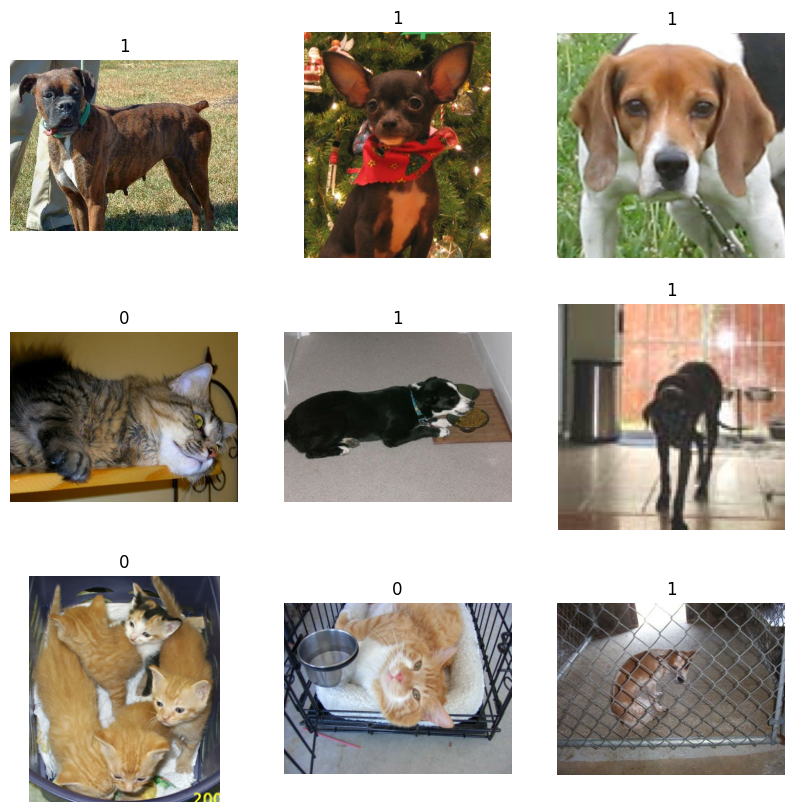

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

また、ラベル 1 が「犬」、ラベル 0 が「猫」であることもわかります。

### データを標準化する

生の画像には様々なサイズがあります。さらに、各ピクセルは 0 ～ 255 の 3 つの整数値（RGB レベル値）で構成されています。これは、ニューラルネットワークへの供給には適しません。次の 2 つを行う必要があります。

- 標準化して画像サイズを固定します。 150x150 を選択します。
- ピクセル値を -1 〜 1 に正規化します。これはモデル自体の一部として`Normalization`レイヤーを使用して行います。

一般的に、すでに処理済みのデータを使用するモデルとは対照的に、入力に生のデータを使用するモデルを開発するのは良い実践です。その理由は、モデルが前処理されたデータを期待していると、モデルをエクスポートして他の場所（ウェブブラウザやモバイルアプリ）で使用する際には、まったく同じ前処理パイプラインを常に再実装する必要が生じるからです。これはすぐに非常に面倒なことになります。だからこそ、モデルを使用する前に可能な限りの前処理を行う必要があるのです。

ここでは、（ディープニューラルネットワークは連続したデータバッチしか処理できないので）データパイプラインで画像のリサイズを行い、モデルを作成する際にモデルの一部として入力値のスケーリングを行います。

画像を 150×150 にリサイズしてみましょう。

In [10]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


さらに、データをバッチ処理して、キャッシング＆プリフェッチを使用し、読み込み速度を最適化してみましょう。

In [11]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### ランダムデータ拡張を使用する

大規模な画像データセットを持っていない場合には、ランダムに水平反転や少し回転を加えるなど、ランダムでありながら現実的な変換をトレーニング画像に適用し、サンプルの多様性を人為的に導入するのが良い実践です。これによって、過適合を遅らせると同時にトレーニングデータの異なった側面にモデルを公開することができます。

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

さまざまなランダム変換の後、最初のバッチの最初の画像がどのように見えるかを可視化してみましょう。

2022-12-14 21:09:16.514321: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


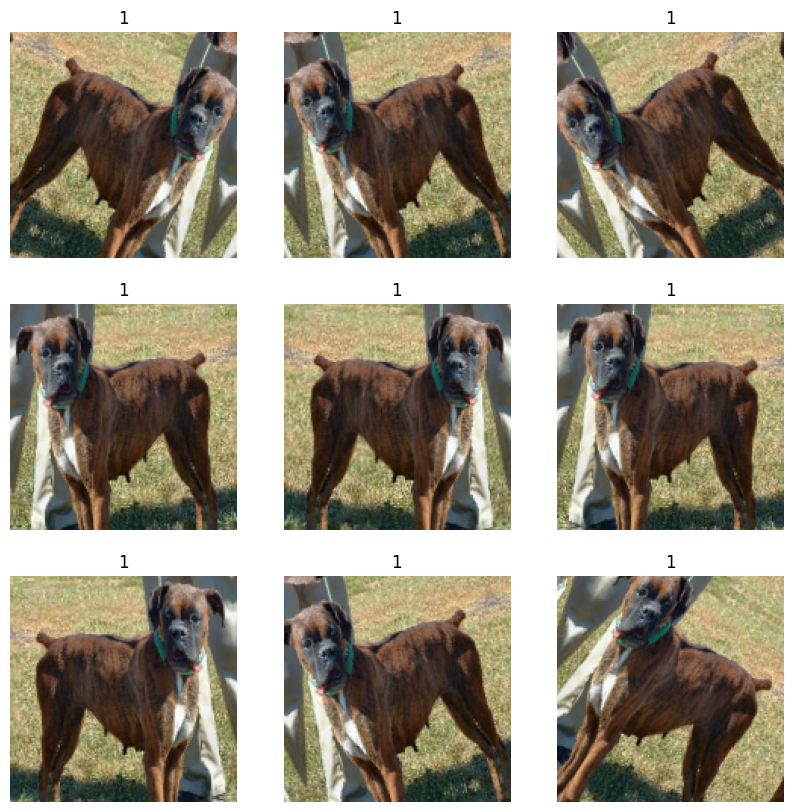

In [13]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## モデルを構築する

では、先ほど説明した青写真に沿ってモデルを構築してみましょう。

注意点:

- `Rescaling` レイヤーを追加して、入力値（最初の範囲は`[0, 255]`）を`[-1, 1]`の範囲にスケーリングします。
- 正則化のために、分類レイヤーの前に `Dropout` レイヤーを追加します。
- ベースモデルを呼び出す際に `training=False` を渡して推論モードで動作するようにし、ファインチューニングを実行するためにベースモデルを解凍した後でも BatchNorm の統計が更新されないようにします。

In [14]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

    8192/83683744 [..............................] - ETA: 0s

 4202496/83683744 [>.............................] - ETA: 1s

18022400/83683744 [=====>........................] - ETA: 0s

34701312/83683744 [===========>..................] - ETA: 0s

44621824/83683744 [==============>...............] - ETA: 0s

61087744/83683744 [====================>.........] - ETA: 0s

72966144/83683744 [=========================>....] - ETA: 0s

83683744/83683744 [==============================] - 0s 0us/step


Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         


 sequential_3 (Sequential)   (None, 150, 150, 3)       0         


 rescaling (Rescaling)       (None, 150, 150, 3)       0         


 xception (Functional)       (None, 5, 5, 2048)        20861480  


 global_average_pooling2d (G  (None, 2048)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 2048)              0         


 dense_7 (Dense)             (None, 1)                 2049      


Total params: 20,863,529


Trainable params: 2,049


Non-trainable params: 20,861,480


_________________________________________________________________


## トップレイヤーをトレーニングする

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20


  1/291 [..............................] - ETA: 27:47 - loss: 0.9236 - binary_accuracy: 0.4062

  2/291 [..............................] - ETA: 22s - loss: 0.7725 - binary_accuracy: 0.5000  

  3/291 [..............................] - ETA: 22s - loss: 0.7252 - binary_accuracy: 0.5729

  4/291 [..............................] - ETA: 22s - loss: 0.6906 - binary_accuracy: 0.6172

  5/291 [..............................] - ETA: 21s - loss: 0.6779 - binary_accuracy: 0.6250

  6/291 [..............................] - ETA: 21s - loss: 0.6652 - binary_accuracy: 0.6458

  7/291 [..............................] - ETA: 21s - loss: 0.6518 - binary_accuracy: 0.6652

  8/291 [..............................] - ETA: 21s - loss: 0.6379 - binary_accuracy: 0.6602

  9/291 [..............................] - ETA: 21s - loss: 0.6223 - binary_accuracy: 0.6597

 10/291 [>.............................] - ETA: 21s - loss: 0.6029 - binary_accuracy: 0.6687

 11/291 [>.............................] - ETA: 21s - loss: 0.5875 - binary_accuracy: 0.6761

 12/291 [>.............................] - ETA: 21s - loss: 0.5704 - binary_accuracy: 0.6901

 13/291 [>.............................] - ETA: 21s - loss: 0.5514 - binary_accuracy: 0.7019

 14/291 [>.............................] - ETA: 21s - loss: 0.5352 - binary_accuracy: 0.7054

 15/291 [>.............................] - ETA: 20s - loss: 0.5280 - binary_accuracy: 0.7104

 16/291 [>.............................] - ETA: 20s - loss: 0.5147 - binary_accuracy: 0.7207

 17/291 [>.............................] - ETA: 20s - loss: 0.4991 - binary_accuracy: 0.7335

 18/291 [>.............................] - ETA: 20s - loss: 0.4891 - binary_accuracy: 0.7396

 19/291 [>.............................] - ETA: 20s - loss: 0.4753 - binary_accuracy: 0.7484

 20/291 [=>............................] - ETA: 20s - loss: 0.4643 - binary_accuracy: 0.7563

 21/291 [=>............................] - ETA: 20s - loss: 0.4558 - binary_accuracy: 0.7649

 22/291 [=>............................] - ETA: 20s - loss: 0.4464 - binary_accuracy: 0.7727

 23/291 [=>............................] - ETA: 20s - loss: 0.4383 - binary_accuracy: 0.7785

 24/291 [=>............................] - ETA: 20s - loss: 0.4268 - binary_accuracy: 0.7865

 25/291 [=>............................] - ETA: 20s - loss: 0.4167 - binary_accuracy: 0.7925

 26/291 [=>............................] - ETA: 20s - loss: 0.4086 - binary_accuracy: 0.7981

 27/291 [=>............................] - ETA: 20s - loss: 0.4051 - binary_accuracy: 0.7986

 28/291 [=>............................] - ETA: 20s - loss: 0.4000 - binary_accuracy: 0.8036

 29/291 [=>............................] - ETA: 19s - loss: 0.3934 - binary_accuracy: 0.8082

 30/291 [==>...........................] - ETA: 19s - loss: 0.3861 - binary_accuracy: 0.8104

 31/291 [==>...........................] - ETA: 19s - loss: 0.3826 - binary_accuracy: 0.8125

 32/291 [==>...........................] - ETA: 19s - loss: 0.3769 - binary_accuracy: 0.8164

 33/291 [==>...........................] - ETA: 19s - loss: 0.3717 - binary_accuracy: 0.8201

 34/291 [==>...........................] - ETA: 19s - loss: 0.3676 - binary_accuracy: 0.8217

 35/291 [==>...........................] - ETA: 19s - loss: 0.3608 - binary_accuracy: 0.8250

 36/291 [==>...........................] - ETA: 19s - loss: 0.3585 - binary_accuracy: 0.8264

 37/291 [==>...........................] - ETA: 19s - loss: 0.3519 - binary_accuracy: 0.8311

 38/291 [==>...........................] - ETA: 19s - loss: 0.3511 - binary_accuracy: 0.8331

 39/291 [===>..........................] - ETA: 19s - loss: 0.3467 - binary_accuracy: 0.8349

 40/291 [===>..........................] - ETA: 19s - loss: 0.3419 - binary_accuracy: 0.8383

 41/291 [===>..........................] - ETA: 19s - loss: 0.3379 - binary_accuracy: 0.8415

 42/291 [===>..........................] - ETA: 18s - loss: 0.3342 - binary_accuracy: 0.8430

 43/291 [===>..........................] - ETA: 18s - loss: 0.3336 - binary_accuracy: 0.8438

 44/291 [===>..........................] - ETA: 18s - loss: 0.3317 - binary_accuracy: 0.8438

 45/291 [===>..........................] - ETA: 18s - loss: 0.3286 - binary_accuracy: 0.8472

 46/291 [===>..........................] - ETA: 18s - loss: 0.3248 - binary_accuracy: 0.8499

 47/291 [===>..........................] - ETA: 18s - loss: 0.3210 - binary_accuracy: 0.8517

 48/291 [===>..........................] - ETA: 18s - loss: 0.3162 - binary_accuracy: 0.8542

 49/291 [====>.........................] - ETA: 18s - loss: 0.3139 - binary_accuracy: 0.8559

 50/291 [====>.........................] - ETA: 18s - loss: 0.3110 - binary_accuracy: 0.8575

 51/291 [====>.........................] - ETA: 18s - loss: 0.3085 - binary_accuracy: 0.8591

 52/291 [====>.........................] - ETA: 18s - loss: 0.3049 - binary_accuracy: 0.8612

 53/291 [====>.........................] - ETA: 18s - loss: 0.3030 - binary_accuracy: 0.8614

 54/291 [====>.........................] - ETA: 18s - loss: 0.3004 - binary_accuracy: 0.8611

 55/291 [====>.........................] - ETA: 18s - loss: 0.2982 - binary_accuracy: 0.8619

 56/291 [====>.........................] - ETA: 17s - loss: 0.2946 - binary_accuracy: 0.8644

 57/291 [====>.........................] - ETA: 17s - loss: 0.2912 - binary_accuracy: 0.8662

 58/291 [====>.........................] - ETA: 17s - loss: 0.2881 - binary_accuracy: 0.8685

 59/291 [=====>........................] - ETA: 17s - loss: 0.2866 - binary_accuracy: 0.8697

 60/291 [=====>........................] - ETA: 17s - loss: 0.2860 - binary_accuracy: 0.8698

 61/291 [=====>........................] - ETA: 17s - loss: 0.2834 - binary_accuracy: 0.8719

 62/291 [=====>........................] - ETA: 17s - loss: 0.2805 - binary_accuracy: 0.8735

 63/291 [=====>........................] - ETA: 17s - loss: 0.2775 - binary_accuracy: 0.8750

 64/291 [=====>........................] - ETA: 17s - loss: 0.2747 - binary_accuracy: 0.8765

 65/291 [=====>........................] - ETA: 17s - loss: 0.2720 - binary_accuracy: 0.8784

 66/291 [=====>........................] - ETA: 17s - loss: 0.2701 - binary_accuracy: 0.8793

 67/291 [=====>........................] - ETA: 17s - loss: 0.2684 - binary_accuracy: 0.8806

 68/291 [======>.......................] - ETA: 17s - loss: 0.2663 - binary_accuracy: 0.8805

 69/291 [======>.......................] - ETA: 16s - loss: 0.2649 - binary_accuracy: 0.8809

 70/291 [======>.......................] - ETA: 16s - loss: 0.2624 - binary_accuracy: 0.8821

 71/291 [======>.......................] - ETA: 16s - loss: 0.2608 - binary_accuracy: 0.8825

 72/291 [======>.......................] - ETA: 16s - loss: 0.2603 - binary_accuracy: 0.8828

 73/291 [======>.......................] - ETA: 16s - loss: 0.2600 - binary_accuracy: 0.8836

 74/291 [======>.......................] - ETA: 16s - loss: 0.2603 - binary_accuracy: 0.8834

 75/291 [======>.......................] - ETA: 16s - loss: 0.2581 - binary_accuracy: 0.8842

 76/291 [======>.......................] - ETA: 16s - loss: 0.2565 - binary_accuracy: 0.8853

 77/291 [======>.......................] - ETA: 16s - loss: 0.2554 - binary_accuracy: 0.8864

 78/291 [=======>......................] - ETA: 16s - loss: 0.2536 - binary_accuracy: 0.8874

 79/291 [=======>......................] - ETA: 16s - loss: 0.2512 - binary_accuracy: 0.8884

 80/291 [=======>......................] - ETA: 16s - loss: 0.2498 - binary_accuracy: 0.8887

 81/291 [=======>......................] - ETA: 16s - loss: 0.2485 - binary_accuracy: 0.8893

 82/291 [=======>......................] - ETA: 15s - loss: 0.2469 - binary_accuracy: 0.8902

 83/291 [=======>......................] - ETA: 15s - loss: 0.2454 - binary_accuracy: 0.8912

 84/291 [=======>......................] - ETA: 15s - loss: 0.2438 - binary_accuracy: 0.8921

 85/291 [=======>......................] - ETA: 15s - loss: 0.2434 - binary_accuracy: 0.8923

 86/291 [=======>......................] - ETA: 15s - loss: 0.2418 - binary_accuracy: 0.8932

 87/291 [=======>......................] - ETA: 15s - loss: 0.2402 - binary_accuracy: 0.8940

 88/291 [========>.....................] - ETA: 15s - loss: 0.2389 - binary_accuracy: 0.8949

 89/291 [========>.....................] - ETA: 15s - loss: 0.2381 - binary_accuracy: 0.8950

 90/291 [========>.....................] - ETA: 15s - loss: 0.2368 - binary_accuracy: 0.8955

 91/291 [========>.....................] - ETA: 15s - loss: 0.2352 - binary_accuracy: 0.8966

 92/291 [========>.....................] - ETA: 15s - loss: 0.2345 - binary_accuracy: 0.8967

 93/291 [========>.....................] - ETA: 15s - loss: 0.2328 - binary_accuracy: 0.8975

 94/291 [========>.....................] - ETA: 15s - loss: 0.2308 - binary_accuracy: 0.8986

 95/291 [========>.....................] - ETA: 14s - loss: 0.2306 - binary_accuracy: 0.8987

 96/291 [========>.....................] - ETA: 14s - loss: 0.2291 - binary_accuracy: 0.8991

 97/291 [=========>....................] - ETA: 14s - loss: 0.2291 - binary_accuracy: 0.8988

 98/291 [=========>....................] - ETA: 14s - loss: 0.2277 - binary_accuracy: 0.8996

 99/291 [=========>....................] - ETA: 14s - loss: 0.2272 - binary_accuracy: 0.8996

100/291 [=========>....................] - ETA: 14s - loss: 0.2257 - binary_accuracy: 0.9000

101/291 [=========>....................] - ETA: 14s - loss: 0.2243 - binary_accuracy: 0.9004

102/291 [=========>....................] - ETA: 14s - loss: 0.2236 - binary_accuracy: 0.9010

103/291 [=========>....................] - ETA: 14s - loss: 0.2232 - binary_accuracy: 0.9014

104/291 [=========>....................] - ETA: 14s - loss: 0.2229 - binary_accuracy: 0.9011

105/291 [=========>....................] - ETA: 14s - loss: 0.2240 - binary_accuracy: 0.9009

106/291 [=========>....................] - ETA: 14s - loss: 0.2234 - binary_accuracy: 0.9012

107/291 [==========>...................] - ETA: 14s - loss: 0.2223 - binary_accuracy: 0.9016

108/291 [==========>...................] - ETA: 13s - loss: 0.2214 - binary_accuracy: 0.9019

109/291 [==========>...................] - ETA: 13s - loss: 0.2202 - binary_accuracy: 0.9022

110/291 [==========>...................] - ETA: 13s - loss: 0.2205 - binary_accuracy: 0.9020

111/291 [==========>...................] - ETA: 13s - loss: 0.2195 - binary_accuracy: 0.9020

112/291 [==========>...................] - ETA: 13s - loss: 0.2204 - binary_accuracy: 0.9018

113/291 [==========>...................] - ETA: 13s - loss: 0.2192 - binary_accuracy: 0.9021

114/291 [==========>...................] - ETA: 13s - loss: 0.2183 - binary_accuracy: 0.9027

115/291 [==========>...................] - ETA: 13s - loss: 0.2182 - binary_accuracy: 0.9027

116/291 [==========>...................] - ETA: 13s - loss: 0.2175 - binary_accuracy: 0.9027

117/291 [===========>..................] - ETA: 13s - loss: 0.2164 - binary_accuracy: 0.9033

118/291 [===========>..................] - ETA: 13s - loss: 0.2157 - binary_accuracy: 0.9033

119/291 [===========>..................] - ETA: 13s - loss: 0.2154 - binary_accuracy: 0.9036

120/291 [===========>..................] - ETA: 13s - loss: 0.2153 - binary_accuracy: 0.9039

121/291 [===========>..................] - ETA: 12s - loss: 0.2144 - binary_accuracy: 0.9042

122/291 [===========>..................] - ETA: 12s - loss: 0.2141 - binary_accuracy: 0.9042

123/291 [===========>..................] - ETA: 12s - loss: 0.2144 - binary_accuracy: 0.9040

124/291 [===========>..................] - ETA: 12s - loss: 0.2144 - binary_accuracy: 0.9042

125/291 [===========>..................] - ETA: 12s - loss: 0.2153 - binary_accuracy: 0.9038

126/291 [===========>..................] - ETA: 12s - loss: 0.2142 - binary_accuracy: 0.9040

127/291 [============>.................] - ETA: 12s - loss: 0.2137 - binary_accuracy: 0.9040

128/291 [============>.................] - ETA: 12s - loss: 0.2132 - binary_accuracy: 0.9045

129/291 [============>.................] - ETA: 12s - loss: 0.2127 - binary_accuracy: 0.9048

130/291 [============>.................] - ETA: 12s - loss: 0.2118 - binary_accuracy: 0.9053

131/291 [============>.................] - ETA: 12s - loss: 0.2109 - binary_accuracy: 0.9055

132/291 [============>.................] - ETA: 12s - loss: 0.2107 - binary_accuracy: 0.9058

133/291 [============>.................] - ETA: 12s - loss: 0.2103 - binary_accuracy: 0.9060

134/291 [============>.................] - ETA: 12s - loss: 0.2095 - binary_accuracy: 0.9062

135/291 [============>.................] - ETA: 11s - loss: 0.2085 - binary_accuracy: 0.9069

136/291 [=============>................] - ETA: 11s - loss: 0.2080 - binary_accuracy: 0.9069

137/291 [=============>................] - ETA: 11s - loss: 0.2068 - binary_accuracy: 0.9076

138/291 [=============>................] - ETA: 11s - loss: 0.2070 - binary_accuracy: 0.9074

139/291 [=============>................] - ETA: 11s - loss: 0.2065 - binary_accuracy: 0.9074

140/291 [=============>................] - ETA: 11s - loss: 0.2056 - binary_accuracy: 0.9078

141/291 [=============>................] - ETA: 11s - loss: 0.2055 - binary_accuracy: 0.9078

142/291 [=============>................] - ETA: 11s - loss: 0.2061 - binary_accuracy: 0.9076

143/291 [=============>................] - ETA: 11s - loss: 0.2053 - binary_accuracy: 0.9076

144/291 [=============>................] - ETA: 11s - loss: 0.2046 - binary_accuracy: 0.9080

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


145/291 [=============>................] - ETA: 11s - loss: 0.2042 - binary_accuracy: 0.9084

146/291 [==============>...............] - ETA: 11s - loss: 0.2035 - binary_accuracy: 0.9086

147/291 [==============>...............] - ETA: 11s - loss: 0.2027 - binary_accuracy: 0.9090

148/291 [==============>...............] - ETA: 10s - loss: 0.2029 - binary_accuracy: 0.9090

149/291 [==============>...............] - ETA: 10s - loss: 0.2022 - binary_accuracy: 0.9094

150/291 [==============>...............] - ETA: 10s - loss: 0.2014 - binary_accuracy: 0.9098

151/291 [==============>...............] - ETA: 10s - loss: 0.2016 - binary_accuracy: 0.9098

152/291 [==============>...............] - ETA: 10s - loss: 0.2014 - binary_accuracy: 0.9100

153/291 [==============>...............] - ETA: 10s - loss: 0.2004 - binary_accuracy: 0.9105

154/291 [==============>...............] - ETA: 10s - loss: 0.2002 - binary_accuracy: 0.9105

155/291 [==============>...............] - ETA: 10s - loss: 0.1999 - binary_accuracy: 0.9103

156/291 [===============>..............] - ETA: 10s - loss: 0.1997 - binary_accuracy: 0.9105

157/291 [===============>..............] - ETA: 10s - loss: 0.1993 - binary_accuracy: 0.9104

158/291 [===============>..............] - ETA: 10s - loss: 0.1985 - binary_accuracy: 0.9106

159/291 [===============>..............] - ETA: 10s - loss: 0.1992 - binary_accuracy: 0.9104

160/291 [===============>..............] - ETA: 10s - loss: 0.1996 - binary_accuracy: 0.9100

161/291 [===============>..............] - ETA: 9s - loss: 0.1994 - binary_accuracy: 0.9103 

162/291 [===============>..............] - ETA: 9s - loss: 0.1993 - binary_accuracy: 0.9105

163/291 [===============>..............] - ETA: 9s - loss: 0.1984 - binary_accuracy: 0.9109

164/291 [===============>..............] - ETA: 9s - loss: 0.1980 - binary_accuracy: 0.9110

165/291 [================>.............] - ETA: 9s - loss: 0.1985 - binary_accuracy: 0.9108

166/291 [================>.............] - ETA: 9s - loss: 0.1986 - binary_accuracy: 0.9108

167/291 [================>.............] - ETA: 9s - loss: 0.1983 - binary_accuracy: 0.9107

168/291 [================>.............] - ETA: 9s - loss: 0.1977 - binary_accuracy: 0.9111

169/291 [================>.............] - ETA: 9s - loss: 0.1972 - binary_accuracy: 0.9114

170/291 [================>.............] - ETA: 9s - loss: 0.1972 - binary_accuracy: 0.9116

171/291 [================>.............] - ETA: 9s - loss: 0.1968 - binary_accuracy: 0.9117

172/291 [================>.............] - ETA: 9s - loss: 0.1961 - binary_accuracy: 0.9121

173/291 [================>.............] - ETA: 9s - loss: 0.1954 - binary_accuracy: 0.9126

174/291 [================>.............] - ETA: 8s - loss: 0.1947 - binary_accuracy: 0.9131

175/291 [=================>............] - ETA: 8s - loss: 0.1948 - binary_accuracy: 0.9130

176/291 [=================>............] - ETA: 8s - loss: 0.1950 - binary_accuracy: 0.9130

177/291 [=================>............] - ETA: 8s - loss: 0.1946 - binary_accuracy: 0.9133

178/291 [=================>............] - ETA: 8s - loss: 0.1947 - binary_accuracy: 0.9134

179/291 [=================>............] - ETA: 8s - loss: 0.1941 - binary_accuracy: 0.9138

180/291 [=================>............] - ETA: 8s - loss: 0.1940 - binary_accuracy: 0.9137

181/291 [=================>............] - ETA: 8s - loss: 0.1934 - binary_accuracy: 0.9138

182/291 [=================>............] - ETA: 8s - loss: 0.1933 - binary_accuracy: 0.9138

183/291 [=================>............] - ETA: 8s - loss: 0.1925 - binary_accuracy: 0.9143

184/291 [=================>............] - ETA: 8s - loss: 0.1917 - binary_accuracy: 0.9147

185/291 [==================>...........] - ETA: 8s - loss: 0.1912 - binary_accuracy: 0.9149

186/291 [==================>...........] - ETA: 8s - loss: 0.1907 - binary_accuracy: 0.9152

187/291 [==================>...........] - ETA: 7s - loss: 0.1901 - binary_accuracy: 0.9154

188/291 [==================>...........] - ETA: 7s - loss: 0.1918 - binary_accuracy: 0.9151

189/291 [==================>...........] - ETA: 7s - loss: 0.1917 - binary_accuracy: 0.9153

190/291 [==================>...........] - ETA: 7s - loss: 0.1911 - binary_accuracy: 0.9158

191/291 [==================>...........] - ETA: 7s - loss: 0.1905 - binary_accuracy: 0.9159

192/291 [==================>...........] - ETA: 7s - loss: 0.1900 - binary_accuracy: 0.9160

193/291 [==================>...........] - ETA: 7s - loss: 0.1900 - binary_accuracy: 0.9161

194/291 [===================>..........] - ETA: 7s - loss: 0.1898 - binary_accuracy: 0.9161

195/291 [===================>..........] - ETA: 7s - loss: 0.1892 - binary_accuracy: 0.9165

196/291 [===================>..........] - ETA: 7s - loss: 0.1885 - binary_accuracy: 0.9169

197/291 [===================>..........] - ETA: 7s - loss: 0.1880 - binary_accuracy: 0.9170

198/291 [===================>..........] - ETA: 7s - loss: 0.1880 - binary_accuracy: 0.9168

199/291 [===================>..........] - ETA: 7s - loss: 0.1885 - binary_accuracy: 0.9168

200/291 [===================>..........] - ETA: 6s - loss: 0.1881 - binary_accuracy: 0.9169

201/291 [===================>..........] - ETA: 6s - loss: 0.1874 - binary_accuracy: 0.9173

202/291 [===================>..........] - ETA: 6s - loss: 0.1869 - binary_accuracy: 0.9177

203/291 [===================>..........] - ETA: 6s - loss: 0.1864 - binary_accuracy: 0.9181

204/291 [====================>.........] - ETA: 6s - loss: 0.1860 - binary_accuracy: 0.9184

205/291 [====================>.........] - ETA: 6s - loss: 0.1866 - binary_accuracy: 0.9181

206/291 [====================>.........] - ETA: 6s - loss: 0.1868 - binary_accuracy: 0.9181

207/291 [====================>.........] - ETA: 6s - loss: 0.1862 - binary_accuracy: 0.9183

208/291 [====================>.........] - ETA: 6s - loss: 0.1864 - binary_accuracy: 0.9183

209/291 [====================>.........] - ETA: 6s - loss: 0.1863 - binary_accuracy: 0.9184

210/291 [====================>.........] - ETA: 6s - loss: 0.1857 - binary_accuracy: 0.9186

211/291 [====================>.........] - ETA: 6s - loss: 0.1855 - binary_accuracy: 0.9184

212/291 [====================>.........] - ETA: 6s - loss: 0.1852 - binary_accuracy: 0.9183

213/291 [====================>.........] - ETA: 5s - loss: 0.1848 - binary_accuracy: 0.9186

214/291 [=====================>........] - ETA: 5s - loss: 0.1843 - binary_accuracy: 0.9187

215/291 [=====================>........] - ETA: 5s - loss: 0.1837 - binary_accuracy: 0.9190

216/291 [=====================>........] - ETA: 5s - loss: 0.1830 - binary_accuracy: 0.9194

217/291 [=====================>........] - ETA: 5s - loss: 0.1827 - binary_accuracy: 0.9195

218/291 [=====================>........] - ETA: 5s - loss: 0.1830 - binary_accuracy: 0.9194

219/291 [=====================>........] - ETA: 5s - loss: 0.1827 - binary_accuracy: 0.9195

220/291 [=====================>........] - ETA: 5s - loss: 0.1826 - binary_accuracy: 0.9196

221/291 [=====================>........] - ETA: 5s - loss: 0.1828 - binary_accuracy: 0.9195

222/291 [=====================>........] - ETA: 5s - loss: 0.1824 - binary_accuracy: 0.9198

223/291 [=====================>........] - ETA: 5s - loss: 0.1825 - binary_accuracy: 0.9198

224/291 [======================>.......] - ETA: 5s - loss: 0.1819 - binary_accuracy: 0.9202

225/291 [======================>.......] - ETA: 5s - loss: 0.1815 - binary_accuracy: 0.9203

226/291 [======================>.......] - ETA: 4s - loss: 0.1811 - binary_accuracy: 0.9205

227/291 [======================>.......] - ETA: 4s - loss: 0.1806 - binary_accuracy: 0.9207

228/291 [======================>.......] - ETA: 4s - loss: 0.1805 - binary_accuracy: 0.9205

229/291 [======================>.......] - ETA: 4s - loss: 0.1804 - binary_accuracy: 0.9206

230/291 [======================>.......] - ETA: 4s - loss: 0.1798 - binary_accuracy: 0.9209

231/291 [======================>.......] - ETA: 4s - loss: 0.1796 - binary_accuracy: 0.9210

232/291 [======================>.......] - ETA: 4s - loss: 0.1795 - binary_accuracy: 0.9212

233/291 [=======================>......] - ETA: 4s - loss: 0.1793 - binary_accuracy: 0.9213

234/291 [=======================>......] - ETA: 4s - loss: 0.1794 - binary_accuracy: 0.9209

235/291 [=======================>......] - ETA: 4s - loss: 0.1789 - binary_accuracy: 0.9211

236/291 [=======================>......] - ETA: 4s - loss: 0.1784 - binary_accuracy: 0.9213

237/291 [=======================>......] - ETA: 4s - loss: 0.1782 - binary_accuracy: 0.9215

238/291 [=======================>......] - ETA: 4s - loss: 0.1777 - binary_accuracy: 0.9219

239/291 [=======================>......] - ETA: 3s - loss: 0.1772 - binary_accuracy: 0.9222

240/291 [=======================>......] - ETA: 3s - loss: 0.1771 - binary_accuracy: 0.9223

241/291 [=======================>......] - ETA: 3s - loss: 0.1765 - binary_accuracy: 0.9226

242/291 [=======================>......] - ETA: 3s - loss: 0.1761 - binary_accuracy: 0.9229

243/291 [========================>.....] - ETA: 3s - loss: 0.1758 - binary_accuracy: 0.9228

244/291 [========================>.....] - ETA: 3s - loss: 0.1755 - binary_accuracy: 0.9232

245/291 [========================>.....] - ETA: 3s - loss: 0.1751 - binary_accuracy: 0.9233

246/291 [========================>.....] - ETA: 3s - loss: 0.1747 - binary_accuracy: 0.9235

247/291 [========================>.....] - ETA: 3s - loss: 0.1742 - binary_accuracy: 0.9238

248/291 [========================>.....] - ETA: 3s - loss: 0.1746 - binary_accuracy: 0.9236

249/291 [========================>.....] - ETA: 3s - loss: 0.1742 - binary_accuracy: 0.9238

250/291 [========================>.....] - ETA: 3s - loss: 0.1739 - binary_accuracy: 0.9239

251/291 [========================>.....] - ETA: 3s - loss: 0.1735 - binary_accuracy: 0.9241

252/291 [========================>.....] - ETA: 2s - loss: 0.1731 - binary_accuracy: 0.9242

253/291 [=========================>....] - ETA: 2s - loss: 0.1728 - binary_accuracy: 0.9245

254/291 [=========================>....] - ETA: 2s - loss: 0.1727 - binary_accuracy: 0.9245

255/291 [=========================>....] - ETA: 2s - loss: 0.1723 - binary_accuracy: 0.9244

256/291 [=========================>....] - ETA: 2s - loss: 0.1721 - binary_accuracy: 0.9247

257/291 [=========================>....] - ETA: 2s - loss: 0.1719 - binary_accuracy: 0.9249

258/291 [=========================>....] - ETA: 2s - loss: 0.1716 - binary_accuracy: 0.9249

259/291 [=========================>....] - ETA: 2s - loss: 0.1720 - binary_accuracy: 0.9248

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


260/291 [=========================>....] - ETA: 2s - loss: 0.1717 - binary_accuracy: 0.9251

261/291 [=========================>....] - ETA: 2s - loss: 0.1714 - binary_accuracy: 0.9253

262/291 [==========================>...] - ETA: 2s - loss: 0.1710 - binary_accuracy: 0.9255

263/291 [==========================>...] - ETA: 2s - loss: 0.1715 - binary_accuracy: 0.9255

264/291 [==========================>...] - ETA: 2s - loss: 0.1711 - binary_accuracy: 0.9257

265/291 [==========================>...] - ETA: 1s - loss: 0.1708 - binary_accuracy: 0.9258

266/291 [==========================>...] - ETA: 1s - loss: 0.1710 - binary_accuracy: 0.9258

267/291 [==========================>...] - ETA: 1s - loss: 0.1712 - binary_accuracy: 0.9257

268/291 [==========================>...] - ETA: 1s - loss: 0.1714 - binary_accuracy: 0.9256

269/291 [==========================>...] - ETA: 1s - loss: 0.1713 - binary_accuracy: 0.9257

270/291 [==========================>...] - ETA: 1s - loss: 0.1710 - binary_accuracy: 0.9257

271/291 [==========================>...] - ETA: 1s - loss: 0.1705 - binary_accuracy: 0.9259

272/291 [===========================>..] - ETA: 1s - loss: 0.1702 - binary_accuracy: 0.9259

273/291 [===========================>..] - ETA: 1s - loss: 0.1701 - binary_accuracy: 0.9258

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


274/291 [===========================>..] - ETA: 1s - loss: 0.1699 - binary_accuracy: 0.9260

275/291 [===========================>..] - ETA: 1s - loss: 0.1694 - binary_accuracy: 0.9262

276/291 [===========================>..] - ETA: 1s - loss: 0.1691 - binary_accuracy: 0.9264

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


277/291 [===========================>..] - ETA: 1s - loss: 0.1688 - binary_accuracy: 0.9264

278/291 [===========================>..] - ETA: 0s - loss: 0.1687 - binary_accuracy: 0.9265

279/291 [===========================>..] - ETA: 0s - loss: 0.1684 - binary_accuracy: 0.9267

280/291 [===========================>..] - ETA: 0s - loss: 0.1683 - binary_accuracy: 0.9268

281/291 [===========================>..] - ETA: 0s - loss: 0.1685 - binary_accuracy: 0.9267

282/291 [============================>.] - ETA: 0s - loss: 0.1683 - binary_accuracy: 0.9268

283/291 [============================>.] - ETA: 0s - loss: 0.1682 - binary_accuracy: 0.9268

284/291 [============================>.] - ETA: 0s - loss: 0.1679 - binary_accuracy: 0.9269

285/291 [============================>.] - ETA: 0s - loss: 0.1680 - binary_accuracy: 0.9269

286/291 [============================>.] - ETA: 0s - loss: 0.1689 - binary_accuracy: 0.9266

287/291 [============================>.] - ETA: 0s - loss: 0.1684 - binary_accuracy: 0.9268

288/291 [============================>.] - ETA: 0s - loss: 0.1682 - binary_accuracy: 0.9270

289/291 [============================>.] - ETA: 0s - loss: 0.1679 - binary_accuracy: 0.9271

290/291 [============================>.] - ETA: 0s - loss: 0.1676 - binary_accuracy: 0.9273

291/291 [==============================] - ETA: 0s - loss: 0.1674 - binary_accuracy: 0.9272

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


291/291 [==============================] - 33s 92ms/step - loss: 0.1674 - binary_accuracy: 0.9272 - val_loss: 0.0812 - val_binary_accuracy: 0.9690


Epoch 2/20


  1/291 [..............................] - ETA: 23s - loss: 0.2625 - binary_accuracy: 0.9062

  2/291 [..............................] - ETA: 22s - loss: 0.2259 - binary_accuracy: 0.8750

  3/291 [..............................] - ETA: 22s - loss: 0.2025 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 21s - loss: 0.2420 - binary_accuracy: 0.9062

  5/291 [..............................] - ETA: 21s - loss: 0.2194 - binary_accuracy: 0.9187

  6/291 [..............................] - ETA: 21s - loss: 0.2196 - binary_accuracy: 0.9219

  7/291 [..............................] - ETA: 21s - loss: 0.1976 - binary_accuracy: 0.9330

  8/291 [..............................] - ETA: 21s - loss: 0.2098 - binary_accuracy: 0.9258

  9/291 [..............................] - ETA: 21s - loss: 0.2208 - binary_accuracy: 0.9236

 10/291 [>.............................] - ETA: 21s - loss: 0.2113 - binary_accuracy: 0.9281

 11/291 [>.............................] - ETA: 21s - loss: 0.2092 - binary_accuracy: 0.9261

 12/291 [>.............................] - ETA: 21s - loss: 0.2005 - binary_accuracy: 0.9297

 13/291 [>.............................] - ETA: 20s - loss: 0.1984 - binary_accuracy: 0.9327

 14/291 [>.............................] - ETA: 20s - loss: 0.1893 - binary_accuracy: 0.9353

 15/291 [>.............................] - ETA: 20s - loss: 0.1832 - binary_accuracy: 0.9375

 16/291 [>.............................] - ETA: 20s - loss: 0.1750 - binary_accuracy: 0.9395

 17/291 [>.............................] - ETA: 20s - loss: 0.1683 - binary_accuracy: 0.9412

 18/291 [>.............................] - ETA: 20s - loss: 0.1673 - binary_accuracy: 0.9392

 19/291 [>.............................] - ETA: 20s - loss: 0.1642 - binary_accuracy: 0.9391

 20/291 [=>............................] - ETA: 20s - loss: 0.1581 - binary_accuracy: 0.9422

 21/291 [=>............................] - ETA: 20s - loss: 0.1656 - binary_accuracy: 0.9375

 22/291 [=>............................] - ETA: 20s - loss: 0.1634 - binary_accuracy: 0.9361

 23/291 [=>............................] - ETA: 20s - loss: 0.1602 - binary_accuracy: 0.9375

 24/291 [=>............................] - ETA: 19s - loss: 0.1547 - binary_accuracy: 0.9401

 25/291 [=>............................] - ETA: 19s - loss: 0.1507 - binary_accuracy: 0.9400

 26/291 [=>............................] - ETA: 19s - loss: 0.1527 - binary_accuracy: 0.9399

 27/291 [=>............................] - ETA: 19s - loss: 0.1540 - binary_accuracy: 0.9410

 28/291 [=>............................] - ETA: 19s - loss: 0.1542 - binary_accuracy: 0.9408

 29/291 [=>............................] - ETA: 19s - loss: 0.1539 - binary_accuracy: 0.9397

 30/291 [==>...........................] - ETA: 19s - loss: 0.1546 - binary_accuracy: 0.9385

 31/291 [==>...........................] - ETA: 19s - loss: 0.1553 - binary_accuracy: 0.9385

 32/291 [==>...........................] - ETA: 19s - loss: 0.1524 - binary_accuracy: 0.9395

 33/291 [==>...........................] - ETA: 19s - loss: 0.1500 - binary_accuracy: 0.9403

 34/291 [==>...........................] - ETA: 19s - loss: 0.1505 - binary_accuracy: 0.9403

 35/291 [==>...........................] - ETA: 19s - loss: 0.1482 - binary_accuracy: 0.9402

 36/291 [==>...........................] - ETA: 18s - loss: 0.1484 - binary_accuracy: 0.9401

 37/291 [==>...........................] - ETA: 18s - loss: 0.1468 - binary_accuracy: 0.9409

 38/291 [==>...........................] - ETA: 18s - loss: 0.1445 - binary_accuracy: 0.9424

 39/291 [===>..........................] - ETA: 18s - loss: 0.1422 - binary_accuracy: 0.9431

 40/291 [===>..........................] - ETA: 18s - loss: 0.1409 - binary_accuracy: 0.9430

 41/291 [===>..........................] - ETA: 18s - loss: 0.1391 - binary_accuracy: 0.9436

 42/291 [===>..........................] - ETA: 18s - loss: 0.1389 - binary_accuracy: 0.9442

 43/291 [===>..........................] - ETA: 18s - loss: 0.1424 - binary_accuracy: 0.9426

 44/291 [===>..........................] - ETA: 18s - loss: 0.1425 - binary_accuracy: 0.9425

 45/291 [===>..........................] - ETA: 18s - loss: 0.1421 - binary_accuracy: 0.9431

 46/291 [===>..........................] - ETA: 18s - loss: 0.1413 - binary_accuracy: 0.9429

 47/291 [===>..........................] - ETA: 18s - loss: 0.1418 - binary_accuracy: 0.9415

 48/291 [===>..........................] - ETA: 18s - loss: 0.1393 - binary_accuracy: 0.9427

 49/291 [====>.........................] - ETA: 17s - loss: 0.1381 - binary_accuracy: 0.9439

 50/291 [====>.........................] - ETA: 17s - loss: 0.1392 - binary_accuracy: 0.9438

 51/291 [====>.........................] - ETA: 17s - loss: 0.1377 - binary_accuracy: 0.9449

 52/291 [====>.........................] - ETA: 17s - loss: 0.1376 - binary_accuracy: 0.9447

 53/291 [====>.........................] - ETA: 17s - loss: 0.1367 - binary_accuracy: 0.9452

 54/291 [====>.........................] - ETA: 17s - loss: 0.1357 - binary_accuracy: 0.9462

 55/291 [====>.........................] - ETA: 17s - loss: 0.1349 - binary_accuracy: 0.9466

 56/291 [====>.........................] - ETA: 17s - loss: 0.1343 - binary_accuracy: 0.9470

 57/291 [====>.........................] - ETA: 17s - loss: 0.1334 - binary_accuracy: 0.9474

 58/291 [====>.........................] - ETA: 17s - loss: 0.1341 - binary_accuracy: 0.9467

 59/291 [=====>........................] - ETA: 17s - loss: 0.1322 - binary_accuracy: 0.9476

 60/291 [=====>........................] - ETA: 17s - loss: 0.1314 - binary_accuracy: 0.9479

 61/291 [=====>........................] - ETA: 17s - loss: 0.1299 - binary_accuracy: 0.9483

 62/291 [=====>........................] - ETA: 16s - loss: 0.1296 - binary_accuracy: 0.9486

 63/291 [=====>........................] - ETA: 16s - loss: 0.1289 - binary_accuracy: 0.9484

 64/291 [=====>........................] - ETA: 16s - loss: 0.1279 - binary_accuracy: 0.9482

 65/291 [=====>........................] - ETA: 16s - loss: 0.1266 - binary_accuracy: 0.9486

 66/291 [=====>........................] - ETA: 16s - loss: 0.1260 - binary_accuracy: 0.9489

 67/291 [=====>........................] - ETA: 16s - loss: 0.1279 - binary_accuracy: 0.9482

 68/291 [======>.......................] - ETA: 16s - loss: 0.1267 - binary_accuracy: 0.9485

 69/291 [======>.......................] - ETA: 16s - loss: 0.1256 - binary_accuracy: 0.9493

 70/291 [======>.......................] - ETA: 16s - loss: 0.1246 - binary_accuracy: 0.9496

 71/291 [======>.......................] - ETA: 16s - loss: 0.1249 - binary_accuracy: 0.9489

 72/291 [======>.......................] - ETA: 16s - loss: 0.1251 - binary_accuracy: 0.9492

 73/291 [======>.......................] - ETA: 16s - loss: 0.1276 - binary_accuracy: 0.9491

 74/291 [======>.......................] - ETA: 16s - loss: 0.1289 - binary_accuracy: 0.9476

 75/291 [======>.......................] - ETA: 15s - loss: 0.1289 - binary_accuracy: 0.9475

 76/291 [======>.......................] - ETA: 15s - loss: 0.1293 - binary_accuracy: 0.9470

 77/291 [======>.......................] - ETA: 15s - loss: 0.1298 - binary_accuracy: 0.9464

 78/291 [=======>......................] - ETA: 15s - loss: 0.1286 - binary_accuracy: 0.9471

 79/291 [=======>......................] - ETA: 15s - loss: 0.1285 - binary_accuracy: 0.9466

 80/291 [=======>......................] - ETA: 15s - loss: 0.1294 - binary_accuracy: 0.9461

 81/291 [=======>......................] - ETA: 15s - loss: 0.1292 - binary_accuracy: 0.9460

 82/291 [=======>......................] - ETA: 15s - loss: 0.1281 - binary_accuracy: 0.9466

 83/291 [=======>......................] - ETA: 15s - loss: 0.1272 - binary_accuracy: 0.9473

 84/291 [=======>......................] - ETA: 15s - loss: 0.1283 - binary_accuracy: 0.9472

 85/291 [=======>......................] - ETA: 15s - loss: 0.1280 - binary_accuracy: 0.9478

 86/291 [=======>......................] - ETA: 15s - loss: 0.1279 - binary_accuracy: 0.9477

 87/291 [=======>......................] - ETA: 15s - loss: 0.1282 - binary_accuracy: 0.9479

 88/291 [========>.....................] - ETA: 14s - loss: 0.1286 - binary_accuracy: 0.9471

 89/291 [========>.....................] - ETA: 14s - loss: 0.1293 - binary_accuracy: 0.9463

 90/291 [========>.....................] - ETA: 14s - loss: 0.1284 - binary_accuracy: 0.9465

 91/291 [========>.....................] - ETA: 14s - loss: 0.1276 - binary_accuracy: 0.9471

 92/291 [========>.....................] - ETA: 14s - loss: 0.1269 - binary_accuracy: 0.9477

 93/291 [========>.....................] - ETA: 14s - loss: 0.1262 - binary_accuracy: 0.9479

 94/291 [========>.....................] - ETA: 14s - loss: 0.1255 - binary_accuracy: 0.9481

 95/291 [========>.....................] - ETA: 14s - loss: 0.1260 - binary_accuracy: 0.9477

 96/291 [========>.....................] - ETA: 14s - loss: 0.1252 - binary_accuracy: 0.9476

 97/291 [=========>....................] - ETA: 14s - loss: 0.1267 - binary_accuracy: 0.9468

 98/291 [=========>....................] - ETA: 14s - loss: 0.1271 - binary_accuracy: 0.9464

 99/291 [=========>....................] - ETA: 14s - loss: 0.1277 - binary_accuracy: 0.9460

100/291 [=========>....................] - ETA: 14s - loss: 0.1273 - binary_accuracy: 0.9463

101/291 [=========>....................] - ETA: 14s - loss: 0.1268 - binary_accuracy: 0.9465

102/291 [=========>....................] - ETA: 14s - loss: 0.1265 - binary_accuracy: 0.9467

103/291 [=========>....................] - ETA: 13s - loss: 0.1268 - binary_accuracy: 0.9469

104/291 [=========>....................] - ETA: 13s - loss: 0.1269 - binary_accuracy: 0.9471

105/291 [=========>....................] - ETA: 13s - loss: 0.1286 - binary_accuracy: 0.9470

106/291 [=========>....................] - ETA: 13s - loss: 0.1298 - binary_accuracy: 0.9469

107/291 [==========>...................] - ETA: 13s - loss: 0.1287 - binary_accuracy: 0.9474

108/291 [==========>...................] - ETA: 13s - loss: 0.1291 - binary_accuracy: 0.9473

109/291 [==========>...................] - ETA: 13s - loss: 0.1281 - binary_accuracy: 0.9478

110/291 [==========>...................] - ETA: 13s - loss: 0.1276 - binary_accuracy: 0.9483

111/291 [==========>...................] - ETA: 13s - loss: 0.1276 - binary_accuracy: 0.9482

112/291 [==========>...................] - ETA: 13s - loss: 0.1289 - binary_accuracy: 0.9475

113/291 [==========>...................] - ETA: 13s - loss: 0.1281 - binary_accuracy: 0.9480

114/291 [==========>...................] - ETA: 13s - loss: 0.1279 - binary_accuracy: 0.9482

115/291 [==========>...................] - ETA: 13s - loss: 0.1282 - binary_accuracy: 0.9481

116/291 [==========>...................] - ETA: 12s - loss: 0.1280 - binary_accuracy: 0.9477

117/291 [===========>..................] - ETA: 12s - loss: 0.1274 - binary_accuracy: 0.9479

118/291 [===========>..................] - ETA: 12s - loss: 0.1277 - binary_accuracy: 0.9476

119/291 [===========>..................] - ETA: 12s - loss: 0.1274 - binary_accuracy: 0.9477

120/291 [===========>..................] - ETA: 12s - loss: 0.1266 - binary_accuracy: 0.9482

121/291 [===========>..................] - ETA: 12s - loss: 0.1259 - binary_accuracy: 0.9486

122/291 [===========>..................] - ETA: 12s - loss: 0.1269 - binary_accuracy: 0.9485

123/291 [===========>..................] - ETA: 12s - loss: 0.1276 - binary_accuracy: 0.9487

124/291 [===========>..................] - ETA: 12s - loss: 0.1279 - binary_accuracy: 0.9478

125/291 [===========>..................] - ETA: 12s - loss: 0.1299 - binary_accuracy: 0.9477

126/291 [===========>..................] - ETA: 12s - loss: 0.1291 - binary_accuracy: 0.9482

127/291 [============>.................] - ETA: 12s - loss: 0.1291 - binary_accuracy: 0.9478

128/291 [============>.................] - ETA: 12s - loss: 0.1287 - binary_accuracy: 0.9480

129/291 [============>.................] - ETA: 12s - loss: 0.1285 - binary_accuracy: 0.9479

130/291 [============>.................] - ETA: 11s - loss: 0.1282 - binary_accuracy: 0.9481

131/291 [============>.................] - ETA: 11s - loss: 0.1275 - binary_accuracy: 0.9485

132/291 [============>.................] - ETA: 11s - loss: 0.1271 - binary_accuracy: 0.9489

133/291 [============>.................] - ETA: 11s - loss: 0.1268 - binary_accuracy: 0.9488

134/291 [============>.................] - ETA: 11s - loss: 0.1264 - binary_accuracy: 0.9489

135/291 [============>.................] - ETA: 11s - loss: 0.1261 - binary_accuracy: 0.9488

136/291 [=============>................] - ETA: 11s - loss: 0.1262 - binary_accuracy: 0.9485

137/291 [=============>................] - ETA: 11s - loss: 0.1255 - binary_accuracy: 0.9489

138/291 [=============>................] - ETA: 11s - loss: 0.1262 - binary_accuracy: 0.9490

139/291 [=============>................] - ETA: 11s - loss: 0.1261 - binary_accuracy: 0.9487

140/291 [=============>................] - ETA: 11s - loss: 0.1258 - binary_accuracy: 0.9489

141/291 [=============>................] - ETA: 11s - loss: 0.1260 - binary_accuracy: 0.9484

142/291 [=============>................] - ETA: 11s - loss: 0.1273 - binary_accuracy: 0.9478

143/291 [=============>................] - ETA: 11s - loss: 0.1269 - binary_accuracy: 0.9480

144/291 [=============>................] - ETA: 10s - loss: 0.1266 - binary_accuracy: 0.9479

145/291 [=============>................] - ETA: 10s - loss: 0.1264 - binary_accuracy: 0.9478

146/291 [==============>...............] - ETA: 10s - loss: 0.1263 - binary_accuracy: 0.9476

147/291 [==============>...............] - ETA: 10s - loss: 0.1258 - binary_accuracy: 0.9479

148/291 [==============>...............] - ETA: 10s - loss: 0.1257 - binary_accuracy: 0.9478

149/291 [==============>...............] - ETA: 10s - loss: 0.1251 - binary_accuracy: 0.9482

150/291 [==============>...............] - ETA: 10s - loss: 0.1247 - binary_accuracy: 0.9483

151/291 [==============>...............] - ETA: 10s - loss: 0.1245 - binary_accuracy: 0.9485

152/291 [==============>...............] - ETA: 10s - loss: 0.1246 - binary_accuracy: 0.9484

153/291 [==============>...............] - ETA: 10s - loss: 0.1238 - binary_accuracy: 0.9487

154/291 [==============>...............] - ETA: 10s - loss: 0.1239 - binary_accuracy: 0.9489

155/291 [==============>...............] - ETA: 10s - loss: 0.1234 - binary_accuracy: 0.9490

156/291 [===============>..............] - ETA: 10s - loss: 0.1241 - binary_accuracy: 0.9491

157/291 [===============>..............] - ETA: 9s - loss: 0.1243 - binary_accuracy: 0.9492 

158/291 [===============>..............] - ETA: 9s - loss: 0.1239 - binary_accuracy: 0.9496

159/291 [===============>..............] - ETA: 9s - loss: 0.1235 - binary_accuracy: 0.9495

160/291 [===============>..............] - ETA: 9s - loss: 0.1246 - binary_accuracy: 0.9492

161/291 [===============>..............] - ETA: 9s - loss: 0.1252 - binary_accuracy: 0.9493

162/291 [===============>..............] - ETA: 9s - loss: 0.1251 - binary_accuracy: 0.9495

163/291 [===============>..............] - ETA: 9s - loss: 0.1248 - binary_accuracy: 0.9496

164/291 [===============>..............] - ETA: 9s - loss: 0.1247 - binary_accuracy: 0.9495

165/291 [================>.............] - ETA: 9s - loss: 0.1252 - binary_accuracy: 0.9494

166/291 [================>.............] - ETA: 9s - loss: 0.1252 - binary_accuracy: 0.9494

167/291 [================>.............] - ETA: 9s - loss: 0.1250 - binary_accuracy: 0.9495

168/291 [================>.............] - ETA: 9s - loss: 0.1248 - binary_accuracy: 0.9494

169/291 [================>.............] - ETA: 9s - loss: 0.1246 - binary_accuracy: 0.9495

170/291 [================>.............] - ETA: 8s - loss: 0.1243 - binary_accuracy: 0.9494

171/291 [================>.............] - ETA: 8s - loss: 0.1247 - binary_accuracy: 0.9494

172/291 [================>.............] - ETA: 8s - loss: 0.1248 - binary_accuracy: 0.9493

173/291 [================>.............] - ETA: 8s - loss: 0.1244 - binary_accuracy: 0.9494

174/291 [================>.............] - ETA: 8s - loss: 0.1238 - binary_accuracy: 0.9497

175/291 [=================>............] - ETA: 8s - loss: 0.1244 - binary_accuracy: 0.9495

176/291 [=================>............] - ETA: 8s - loss: 0.1246 - binary_accuracy: 0.9492

177/291 [=================>............] - ETA: 8s - loss: 0.1242 - binary_accuracy: 0.9495

178/291 [=================>............] - ETA: 8s - loss: 0.1252 - binary_accuracy: 0.9489

179/291 [=================>............] - ETA: 8s - loss: 0.1249 - binary_accuracy: 0.9490

180/291 [=================>............] - ETA: 8s - loss: 0.1249 - binary_accuracy: 0.9491

181/291 [=================>............] - ETA: 8s - loss: 0.1253 - binary_accuracy: 0.9489

182/291 [=================>............] - ETA: 8s - loss: 0.1260 - binary_accuracy: 0.9483

183/291 [=================>............] - ETA: 8s - loss: 0.1257 - binary_accuracy: 0.9484

184/291 [=================>............] - ETA: 7s - loss: 0.1251 - binary_accuracy: 0.9487

185/291 [==================>...........] - ETA: 7s - loss: 0.1248 - binary_accuracy: 0.9488

186/291 [==================>...........] - ETA: 7s - loss: 0.1244 - binary_accuracy: 0.9489

187/291 [==================>...........] - ETA: 7s - loss: 0.1246 - binary_accuracy: 0.9489

188/291 [==================>...........] - ETA: 7s - loss: 0.1257 - binary_accuracy: 0.9485

189/291 [==================>...........] - ETA: 7s - loss: 0.1260 - binary_accuracy: 0.9484

190/291 [==================>...........] - ETA: 7s - loss: 0.1257 - binary_accuracy: 0.9487

191/291 [==================>...........] - ETA: 7s - loss: 0.1258 - binary_accuracy: 0.9485

192/291 [==================>...........] - ETA: 7s - loss: 0.1265 - binary_accuracy: 0.9482

193/291 [==================>...........] - ETA: 7s - loss: 0.1270 - binary_accuracy: 0.9477

194/291 [===================>..........] - ETA: 7s - loss: 0.1272 - binary_accuracy: 0.9478

195/291 [===================>..........] - ETA: 7s - loss: 0.1271 - binary_accuracy: 0.9478

196/291 [===================>..........] - ETA: 7s - loss: 0.1269 - binary_accuracy: 0.9477

197/291 [===================>..........] - ETA: 6s - loss: 0.1267 - binary_accuracy: 0.9477

198/291 [===================>..........] - ETA: 6s - loss: 0.1270 - binary_accuracy: 0.9474

199/291 [===================>..........] - ETA: 6s - loss: 0.1272 - binary_accuracy: 0.9474

200/291 [===================>..........] - ETA: 6s - loss: 0.1269 - binary_accuracy: 0.9477

201/291 [===================>..........] - ETA: 6s - loss: 0.1267 - binary_accuracy: 0.9478

202/291 [===================>..........] - ETA: 6s - loss: 0.1267 - binary_accuracy: 0.9479

203/291 [===================>..........] - ETA: 6s - loss: 0.1269 - binary_accuracy: 0.9478

204/291 [====================>.........] - ETA: 6s - loss: 0.1268 - binary_accuracy: 0.9479

205/291 [====================>.........] - ETA: 6s - loss: 0.1274 - binary_accuracy: 0.9477

206/291 [====================>.........] - ETA: 6s - loss: 0.1273 - binary_accuracy: 0.9478

207/291 [====================>.........] - ETA: 6s - loss: 0.1274 - binary_accuracy: 0.9475

208/291 [====================>.........] - ETA: 6s - loss: 0.1277 - binary_accuracy: 0.9476

209/291 [====================>.........] - ETA: 6s - loss: 0.1281 - binary_accuracy: 0.9474

210/291 [====================>.........] - ETA: 6s - loss: 0.1278 - binary_accuracy: 0.9473

211/291 [====================>.........] - ETA: 5s - loss: 0.1280 - binary_accuracy: 0.9473

212/291 [====================>.........] - ETA: 5s - loss: 0.1279 - binary_accuracy: 0.9471

213/291 [====================>.........] - ETA: 5s - loss: 0.1276 - binary_accuracy: 0.9472

214/291 [=====================>........] - ETA: 5s - loss: 0.1273 - binary_accuracy: 0.9474

215/291 [=====================>........] - ETA: 5s - loss: 0.1270 - binary_accuracy: 0.9475

216/291 [=====================>........] - ETA: 5s - loss: 0.1268 - binary_accuracy: 0.9476

217/291 [=====================>........] - ETA: 5s - loss: 0.1268 - binary_accuracy: 0.9477

218/291 [=====================>........] - ETA: 5s - loss: 0.1268 - binary_accuracy: 0.9480

219/291 [=====================>........] - ETA: 5s - loss: 0.1268 - binary_accuracy: 0.9479

220/291 [=====================>........] - ETA: 5s - loss: 0.1269 - binary_accuracy: 0.9479

221/291 [=====================>........] - ETA: 5s - loss: 0.1267 - binary_accuracy: 0.9481

222/291 [=====================>........] - ETA: 5s - loss: 0.1265 - binary_accuracy: 0.9482

223/291 [=====================>........] - ETA: 5s - loss: 0.1265 - binary_accuracy: 0.9483

224/291 [======================>.......] - ETA: 4s - loss: 0.1260 - binary_accuracy: 0.9485

225/291 [======================>.......] - ETA: 4s - loss: 0.1263 - binary_accuracy: 0.9483

226/291 [======================>.......] - ETA: 4s - loss: 0.1259 - binary_accuracy: 0.9486

227/291 [======================>.......] - ETA: 4s - loss: 0.1255 - binary_accuracy: 0.9488

228/291 [======================>.......] - ETA: 4s - loss: 0.1258 - binary_accuracy: 0.9486

229/291 [======================>.......] - ETA: 4s - loss: 0.1256 - binary_accuracy: 0.9487

230/291 [======================>.......] - ETA: 4s - loss: 0.1256 - binary_accuracy: 0.9488

231/291 [======================>.......] - ETA: 4s - loss: 0.1253 - binary_accuracy: 0.9489

232/291 [======================>.......] - ETA: 4s - loss: 0.1256 - binary_accuracy: 0.9487

233/291 [=======================>......] - ETA: 4s - loss: 0.1261 - binary_accuracy: 0.9484

234/291 [=======================>......] - ETA: 4s - loss: 0.1262 - binary_accuracy: 0.9485

235/291 [=======================>......] - ETA: 4s - loss: 0.1258 - binary_accuracy: 0.9485

236/291 [=======================>......] - ETA: 4s - loss: 0.1255 - binary_accuracy: 0.9486

237/291 [=======================>......] - ETA: 4s - loss: 0.1254 - binary_accuracy: 0.9486

238/291 [=======================>......] - ETA: 3s - loss: 0.1252 - binary_accuracy: 0.9487

239/291 [=======================>......] - ETA: 3s - loss: 0.1248 - binary_accuracy: 0.9487

240/291 [=======================>......] - ETA: 3s - loss: 0.1248 - binary_accuracy: 0.9488

241/291 [=======================>......] - ETA: 3s - loss: 0.1254 - binary_accuracy: 0.9487

242/291 [=======================>......] - ETA: 3s - loss: 0.1253 - binary_accuracy: 0.9486

243/291 [========================>.....] - ETA: 3s - loss: 0.1255 - binary_accuracy: 0.9486

244/291 [========================>.....] - ETA: 3s - loss: 0.1253 - binary_accuracy: 0.9486

245/291 [========================>.....] - ETA: 3s - loss: 0.1250 - binary_accuracy: 0.9487

246/291 [========================>.....] - ETA: 3s - loss: 0.1252 - binary_accuracy: 0.9487

247/291 [========================>.....] - ETA: 3s - loss: 0.1253 - binary_accuracy: 0.9486

248/291 [========================>.....] - ETA: 3s - loss: 0.1257 - binary_accuracy: 0.9485

249/291 [========================>.....] - ETA: 3s - loss: 0.1254 - binary_accuracy: 0.9487

250/291 [========================>.....] - ETA: 3s - loss: 0.1255 - binary_accuracy: 0.9486

251/291 [========================>.....] - ETA: 2s - loss: 0.1255 - binary_accuracy: 0.9487

252/291 [========================>.....] - ETA: 2s - loss: 0.1253 - binary_accuracy: 0.9488

253/291 [=========================>....] - ETA: 2s - loss: 0.1250 - binary_accuracy: 0.9490

254/291 [=========================>....] - ETA: 2s - loss: 0.1259 - binary_accuracy: 0.9489

255/291 [=========================>....] - ETA: 2s - loss: 0.1257 - binary_accuracy: 0.9491

256/291 [=========================>....] - ETA: 2s - loss: 0.1253 - binary_accuracy: 0.9493

257/291 [=========================>....] - ETA: 2s - loss: 0.1252 - binary_accuracy: 0.9494

258/291 [=========================>....] - ETA: 2s - loss: 0.1252 - binary_accuracy: 0.9494

259/291 [=========================>....] - ETA: 2s - loss: 0.1254 - binary_accuracy: 0.9492

260/291 [=========================>....] - ETA: 2s - loss: 0.1253 - binary_accuracy: 0.9493

261/291 [=========================>....] - ETA: 2s - loss: 0.1251 - binary_accuracy: 0.9494

262/291 [==========================>...] - ETA: 2s - loss: 0.1253 - binary_accuracy: 0.9491

263/291 [==========================>...] - ETA: 2s - loss: 0.1254 - binary_accuracy: 0.9490

264/291 [==========================>...] - ETA: 2s - loss: 0.1253 - binary_accuracy: 0.9490

265/291 [==========================>...] - ETA: 1s - loss: 0.1250 - binary_accuracy: 0.9492

266/291 [==========================>...] - ETA: 1s - loss: 0.1246 - binary_accuracy: 0.9494

267/291 [==========================>...] - ETA: 1s - loss: 0.1246 - binary_accuracy: 0.9493

268/291 [==========================>...] - ETA: 1s - loss: 0.1249 - binary_accuracy: 0.9490

269/291 [==========================>...] - ETA: 1s - loss: 0.1246 - binary_accuracy: 0.9491

270/291 [==========================>...] - ETA: 1s - loss: 0.1247 - binary_accuracy: 0.9488

271/291 [==========================>...] - ETA: 1s - loss: 0.1243 - binary_accuracy: 0.9490

272/291 [===========================>..] - ETA: 1s - loss: 0.1241 - binary_accuracy: 0.9491

273/291 [===========================>..] - ETA: 1s - loss: 0.1241 - binary_accuracy: 0.9489

274/291 [===========================>..] - ETA: 1s - loss: 0.1239 - binary_accuracy: 0.9489

275/291 [===========================>..] - ETA: 1s - loss: 0.1237 - binary_accuracy: 0.9491

276/291 [===========================>..] - ETA: 1s - loss: 0.1234 - binary_accuracy: 0.9492

277/291 [===========================>..] - ETA: 1s - loss: 0.1232 - binary_accuracy: 0.9492

278/291 [===========================>..] - ETA: 0s - loss: 0.1229 - binary_accuracy: 0.9494

279/291 [===========================>..] - ETA: 0s - loss: 0.1227 - binary_accuracy: 0.9496

280/291 [===========================>..] - ETA: 0s - loss: 0.1224 - binary_accuracy: 0.9498

281/291 [===========================>..] - ETA: 0s - loss: 0.1228 - binary_accuracy: 0.9495

282/291 [============================>.] - ETA: 0s - loss: 0.1228 - binary_accuracy: 0.9494

283/291 [============================>.] - ETA: 0s - loss: 0.1228 - binary_accuracy: 0.9493

284/291 [============================>.] - ETA: 0s - loss: 0.1226 - binary_accuracy: 0.9495

285/291 [============================>.] - ETA: 0s - loss: 0.1228 - binary_accuracy: 0.9493

286/291 [============================>.] - ETA: 0s - loss: 0.1239 - binary_accuracy: 0.9490

287/291 [============================>.] - ETA: 0s - loss: 0.1236 - binary_accuracy: 0.9492

288/291 [============================>.] - ETA: 0s - loss: 0.1233 - binary_accuracy: 0.9492

289/291 [============================>.] - ETA: 0s - loss: 0.1231 - binary_accuracy: 0.9493

290/291 [============================>.] - ETA: 0s - loss: 0.1228 - binary_accuracy: 0.9495

291/291 [==============================] - ETA: 0s - loss: 0.1230 - binary_accuracy: 0.9494

291/291 [==============================] - 24s 83ms/step - loss: 0.1230 - binary_accuracy: 0.9494 - val_loss: 0.0777 - val_binary_accuracy: 0.9708


Epoch 3/20


  1/291 [..............................] - ETA: 21s - loss: 0.1200 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 22s - loss: 0.0938 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 21s - loss: 0.0800 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 21s - loss: 0.0928 - binary_accuracy: 0.9609

  5/291 [..............................] - ETA: 21s - loss: 0.0893 - binary_accuracy: 0.9625

  6/291 [..............................] - ETA: 21s - loss: 0.1063 - binary_accuracy: 0.9583

  7/291 [..............................] - ETA: 21s - loss: 0.1063 - binary_accuracy: 0.9554

  8/291 [..............................] - ETA: 21s - loss: 0.1195 - binary_accuracy: 0.9492

  9/291 [..............................] - ETA: 21s - loss: 0.1339 - binary_accuracy: 0.9444

 10/291 [>.............................] - ETA: 20s - loss: 0.1309 - binary_accuracy: 0.9406

 11/291 [>.............................] - ETA: 20s - loss: 0.1300 - binary_accuracy: 0.9403

 12/291 [>.............................] - ETA: 20s - loss: 0.1238 - binary_accuracy: 0.9427

 13/291 [>.............................] - ETA: 20s - loss: 0.1282 - binary_accuracy: 0.9423

 14/291 [>.............................] - ETA: 20s - loss: 0.1222 - binary_accuracy: 0.9464

 15/291 [>.............................] - ETA: 20s - loss: 0.1202 - binary_accuracy: 0.9479

 16/291 [>.............................] - ETA: 20s - loss: 0.1249 - binary_accuracy: 0.9473

 17/291 [>.............................] - ETA: 20s - loss: 0.1188 - binary_accuracy: 0.9504

 18/291 [>.............................] - ETA: 20s - loss: 0.1158 - binary_accuracy: 0.9514

 19/291 [>.............................] - ETA: 20s - loss: 0.1132 - binary_accuracy: 0.9523

 20/291 [=>............................] - ETA: 20s - loss: 0.1111 - binary_accuracy: 0.9531

 21/291 [=>............................] - ETA: 19s - loss: 0.1243 - binary_accuracy: 0.9464

 22/291 [=>............................] - ETA: 19s - loss: 0.1238 - binary_accuracy: 0.9474

 23/291 [=>............................] - ETA: 19s - loss: 0.1286 - binary_accuracy: 0.9470

 24/291 [=>............................] - ETA: 19s - loss: 0.1246 - binary_accuracy: 0.9492

 25/291 [=>............................] - ETA: 19s - loss: 0.1216 - binary_accuracy: 0.9500

 26/291 [=>............................] - ETA: 19s - loss: 0.1186 - binary_accuracy: 0.9507

 27/291 [=>............................] - ETA: 19s - loss: 0.1211 - binary_accuracy: 0.9491

 28/291 [=>............................] - ETA: 19s - loss: 0.1199 - binary_accuracy: 0.9487

 29/291 [=>............................] - ETA: 19s - loss: 0.1194 - binary_accuracy: 0.9483

 30/291 [==>...........................] - ETA: 19s - loss: 0.1195 - binary_accuracy: 0.9469

 31/291 [==>...........................] - ETA: 19s - loss: 0.1219 - binary_accuracy: 0.9456

 32/291 [==>...........................] - ETA: 19s - loss: 0.1224 - binary_accuracy: 0.9463

 33/291 [==>...........................] - ETA: 19s - loss: 0.1209 - binary_accuracy: 0.9470

 34/291 [==>...........................] - ETA: 19s - loss: 0.1196 - binary_accuracy: 0.9485

 35/291 [==>...........................] - ETA: 18s - loss: 0.1216 - binary_accuracy: 0.9482

 36/291 [==>...........................] - ETA: 18s - loss: 0.1198 - binary_accuracy: 0.9497

 37/291 [==>...........................] - ETA: 18s - loss: 0.1182 - binary_accuracy: 0.9502

 38/291 [==>...........................] - ETA: 18s - loss: 0.1192 - binary_accuracy: 0.9507

 39/291 [===>..........................] - ETA: 18s - loss: 0.1189 - binary_accuracy: 0.9511

 40/291 [===>..........................] - ETA: 18s - loss: 0.1171 - binary_accuracy: 0.9523

 41/291 [===>..........................] - ETA: 18s - loss: 0.1162 - binary_accuracy: 0.9527

 42/291 [===>..........................] - ETA: 18s - loss: 0.1164 - binary_accuracy: 0.9516

 43/291 [===>..........................] - ETA: 18s - loss: 0.1157 - binary_accuracy: 0.9520

 44/291 [===>..........................] - ETA: 18s - loss: 0.1151 - binary_accuracy: 0.9531

 45/291 [===>..........................] - ETA: 18s - loss: 0.1152 - binary_accuracy: 0.9535

 46/291 [===>..........................] - ETA: 18s - loss: 0.1143 - binary_accuracy: 0.9538

 47/291 [===>..........................] - ETA: 18s - loss: 0.1154 - binary_accuracy: 0.9535

 48/291 [===>..........................] - ETA: 18s - loss: 0.1134 - binary_accuracy: 0.9544

 49/291 [====>.........................] - ETA: 17s - loss: 0.1128 - binary_accuracy: 0.9541

 50/291 [====>.........................] - ETA: 17s - loss: 0.1176 - binary_accuracy: 0.9538

 51/291 [====>.........................] - ETA: 17s - loss: 0.1166 - binary_accuracy: 0.9540

 52/291 [====>.........................] - ETA: 17s - loss: 0.1169 - binary_accuracy: 0.9537

 53/291 [====>.........................] - ETA: 17s - loss: 0.1161 - binary_accuracy: 0.9540

 54/291 [====>.........................] - ETA: 17s - loss: 0.1158 - binary_accuracy: 0.9537

 55/291 [====>.........................] - ETA: 17s - loss: 0.1161 - binary_accuracy: 0.9534

 56/291 [====>.........................] - ETA: 17s - loss: 0.1152 - binary_accuracy: 0.9542

 57/291 [====>.........................] - ETA: 17s - loss: 0.1153 - binary_accuracy: 0.9534

 58/291 [====>.........................] - ETA: 17s - loss: 0.1139 - binary_accuracy: 0.9542

 59/291 [=====>........................] - ETA: 17s - loss: 0.1127 - binary_accuracy: 0.9550

 60/291 [=====>........................] - ETA: 17s - loss: 0.1127 - binary_accuracy: 0.9547

 61/291 [=====>........................] - ETA: 17s - loss: 0.1119 - binary_accuracy: 0.9549

 62/291 [=====>........................] - ETA: 17s - loss: 0.1117 - binary_accuracy: 0.9551

 63/291 [=====>........................] - ETA: 16s - loss: 0.1115 - binary_accuracy: 0.9554

 64/291 [=====>........................] - ETA: 16s - loss: 0.1106 - binary_accuracy: 0.9556

 65/291 [=====>........................] - ETA: 16s - loss: 0.1096 - binary_accuracy: 0.9563

 66/291 [=====>........................] - ETA: 16s - loss: 0.1095 - binary_accuracy: 0.9564

 67/291 [=====>........................] - ETA: 16s - loss: 0.1097 - binary_accuracy: 0.9566

 68/291 [======>.......................] - ETA: 16s - loss: 0.1087 - binary_accuracy: 0.9573

 69/291 [======>.......................] - ETA: 16s - loss: 0.1081 - binary_accuracy: 0.9574

 70/291 [======>.......................] - ETA: 16s - loss: 0.1072 - binary_accuracy: 0.9580

 71/291 [======>.......................] - ETA: 16s - loss: 0.1074 - binary_accuracy: 0.9573

 72/291 [======>.......................] - ETA: 16s - loss: 0.1068 - binary_accuracy: 0.9579

 73/291 [======>.......................] - ETA: 16s - loss: 0.1062 - binary_accuracy: 0.9585

 74/291 [======>.......................] - ETA: 16s - loss: 0.1057 - binary_accuracy: 0.9586

 75/291 [======>.......................] - ETA: 16s - loss: 0.1047 - binary_accuracy: 0.9592

 76/291 [======>.......................] - ETA: 15s - loss: 0.1046 - binary_accuracy: 0.9593

 77/291 [======>.......................] - ETA: 15s - loss: 0.1042 - binary_accuracy: 0.9594

 78/291 [=======>......................] - ETA: 15s - loss: 0.1036 - binary_accuracy: 0.9595

 79/291 [=======>......................] - ETA: 15s - loss: 0.1031 - binary_accuracy: 0.9597

 80/291 [=======>......................] - ETA: 15s - loss: 0.1029 - binary_accuracy: 0.9598

 81/291 [=======>......................] - ETA: 15s - loss: 0.1038 - binary_accuracy: 0.9599

 82/291 [=======>......................] - ETA: 15s - loss: 0.1033 - binary_accuracy: 0.9600

 83/291 [=======>......................] - ETA: 15s - loss: 0.1028 - binary_accuracy: 0.9597

 84/291 [=======>......................] - ETA: 15s - loss: 0.1035 - binary_accuracy: 0.9587

 85/291 [=======>......................] - ETA: 15s - loss: 0.1039 - binary_accuracy: 0.9581

 86/291 [=======>......................] - ETA: 15s - loss: 0.1030 - binary_accuracy: 0.9586

 87/291 [=======>......................] - ETA: 15s - loss: 0.1029 - binary_accuracy: 0.9583

 88/291 [========>.....................] - ETA: 15s - loss: 0.1048 - binary_accuracy: 0.9574

 89/291 [========>.....................] - ETA: 14s - loss: 0.1061 - binary_accuracy: 0.9568

 90/291 [========>.....................] - ETA: 14s - loss: 0.1058 - binary_accuracy: 0.9569

 91/291 [========>.....................] - ETA: 14s - loss: 0.1053 - binary_accuracy: 0.9574

 92/291 [========>.....................] - ETA: 14s - loss: 0.1052 - binary_accuracy: 0.9575

 93/291 [========>.....................] - ETA: 14s - loss: 0.1046 - binary_accuracy: 0.9577

 94/291 [========>.....................] - ETA: 14s - loss: 0.1038 - binary_accuracy: 0.9578

 95/291 [========>.....................] - ETA: 14s - loss: 0.1061 - binary_accuracy: 0.9563

 96/291 [========>.....................] - ETA: 14s - loss: 0.1063 - binary_accuracy: 0.9561

 97/291 [=========>....................] - ETA: 14s - loss: 0.1064 - binary_accuracy: 0.9562

 98/291 [=========>....................] - ETA: 14s - loss: 0.1058 - binary_accuracy: 0.9566

 99/291 [=========>....................] - ETA: 14s - loss: 0.1053 - binary_accuracy: 0.9568

100/291 [=========>....................] - ETA: 14s - loss: 0.1048 - binary_accuracy: 0.9566

101/291 [=========>....................] - ETA: 14s - loss: 0.1059 - binary_accuracy: 0.9564

102/291 [=========>....................] - ETA: 13s - loss: 0.1060 - binary_accuracy: 0.9562

103/291 [=========>....................] - ETA: 13s - loss: 0.1058 - binary_accuracy: 0.9563

104/291 [=========>....................] - ETA: 13s - loss: 0.1054 - binary_accuracy: 0.9564

105/291 [=========>....................] - ETA: 13s - loss: 0.1081 - binary_accuracy: 0.9560

106/291 [=========>....................] - ETA: 13s - loss: 0.1076 - binary_accuracy: 0.9561

107/291 [==========>...................] - ETA: 13s - loss: 0.1067 - binary_accuracy: 0.9565

108/291 [==========>...................] - ETA: 13s - loss: 0.1072 - binary_accuracy: 0.9563

109/291 [==========>...................] - ETA: 13s - loss: 0.1066 - binary_accuracy: 0.9564

110/291 [==========>...................] - ETA: 13s - loss: 0.1063 - binary_accuracy: 0.9565

111/291 [==========>...................] - ETA: 13s - loss: 0.1067 - binary_accuracy: 0.9564

112/291 [==========>...................] - ETA: 13s - loss: 0.1079 - binary_accuracy: 0.9559

113/291 [==========>...................] - ETA: 13s - loss: 0.1071 - binary_accuracy: 0.9563

114/291 [==========>...................] - ETA: 13s - loss: 0.1070 - binary_accuracy: 0.9561

115/291 [==========>...................] - ETA: 13s - loss: 0.1074 - binary_accuracy: 0.9560

116/291 [==========>...................] - ETA: 12s - loss: 0.1080 - binary_accuracy: 0.9555

117/291 [===========>..................] - ETA: 12s - loss: 0.1087 - binary_accuracy: 0.9554

118/291 [===========>..................] - ETA: 12s - loss: 0.1089 - binary_accuracy: 0.9550

119/291 [===========>..................] - ETA: 12s - loss: 0.1093 - binary_accuracy: 0.9548

120/291 [===========>..................] - ETA: 12s - loss: 0.1090 - binary_accuracy: 0.9549

121/291 [===========>..................] - ETA: 12s - loss: 0.1086 - binary_accuracy: 0.9551

122/291 [===========>..................] - ETA: 12s - loss: 0.1084 - binary_accuracy: 0.9549

123/291 [===========>..................] - ETA: 12s - loss: 0.1097 - binary_accuracy: 0.9548

124/291 [===========>..................] - ETA: 12s - loss: 0.1102 - binary_accuracy: 0.9546

125/291 [===========>..................] - ETA: 12s - loss: 0.1121 - binary_accuracy: 0.9542

126/291 [===========>..................] - ETA: 12s - loss: 0.1117 - binary_accuracy: 0.9544

127/291 [============>.................] - ETA: 12s - loss: 0.1117 - binary_accuracy: 0.9542

128/291 [============>.................] - ETA: 12s - loss: 0.1114 - binary_accuracy: 0.9543

129/291 [============>.................] - ETA: 11s - loss: 0.1112 - binary_accuracy: 0.9542

130/291 [============>.................] - ETA: 11s - loss: 0.1112 - binary_accuracy: 0.9543

131/291 [============>.................] - ETA: 11s - loss: 0.1113 - binary_accuracy: 0.9542

132/291 [============>.................] - ETA: 11s - loss: 0.1112 - binary_accuracy: 0.9541

133/291 [============>.................] - ETA: 11s - loss: 0.1114 - binary_accuracy: 0.9537

134/291 [============>.................] - ETA: 11s - loss: 0.1109 - binary_accuracy: 0.9541

135/291 [============>.................] - ETA: 11s - loss: 0.1102 - binary_accuracy: 0.9544

136/291 [=============>................] - ETA: 11s - loss: 0.1106 - binary_accuracy: 0.9538

137/291 [=============>................] - ETA: 11s - loss: 0.1100 - binary_accuracy: 0.9542

138/291 [=============>................] - ETA: 11s - loss: 0.1103 - binary_accuracy: 0.9543

139/291 [=============>................] - ETA: 11s - loss: 0.1099 - binary_accuracy: 0.9544

140/291 [=============>................] - ETA: 11s - loss: 0.1095 - binary_accuracy: 0.9545

141/291 [=============>................] - ETA: 11s - loss: 0.1098 - binary_accuracy: 0.9541

142/291 [=============>................] - ETA: 11s - loss: 0.1102 - binary_accuracy: 0.9536

143/291 [=============>................] - ETA: 10s - loss: 0.1104 - binary_accuracy: 0.9535

144/291 [=============>................] - ETA: 10s - loss: 0.1109 - binary_accuracy: 0.9533

145/291 [=============>................] - ETA: 10s - loss: 0.1108 - binary_accuracy: 0.9532

146/291 [==============>...............] - ETA: 10s - loss: 0.1102 - binary_accuracy: 0.9536

147/291 [==============>...............] - ETA: 10s - loss: 0.1105 - binary_accuracy: 0.9537

148/291 [==============>...............] - ETA: 10s - loss: 0.1110 - binary_accuracy: 0.9535

149/291 [==============>...............] - ETA: 10s - loss: 0.1105 - binary_accuracy: 0.9539

150/291 [==============>...............] - ETA: 10s - loss: 0.1100 - binary_accuracy: 0.9542

151/291 [==============>...............] - ETA: 10s - loss: 0.1100 - binary_accuracy: 0.9541

152/291 [==============>...............] - ETA: 10s - loss: 0.1096 - binary_accuracy: 0.9542

153/291 [==============>...............] - ETA: 10s - loss: 0.1090 - binary_accuracy: 0.9545

154/291 [==============>...............] - ETA: 10s - loss: 0.1088 - binary_accuracy: 0.9545

155/291 [==============>...............] - ETA: 10s - loss: 0.1096 - binary_accuracy: 0.9544

156/291 [===============>..............] - ETA: 10s - loss: 0.1097 - binary_accuracy: 0.9543

157/291 [===============>..............] - ETA: 9s - loss: 0.1099 - binary_accuracy: 0.9542 

158/291 [===============>..............] - ETA: 9s - loss: 0.1104 - binary_accuracy: 0.9541

159/291 [===============>..............] - ETA: 9s - loss: 0.1100 - binary_accuracy: 0.9542

160/291 [===============>..............] - ETA: 9s - loss: 0.1120 - binary_accuracy: 0.9535

161/291 [===============>..............] - ETA: 9s - loss: 0.1124 - binary_accuracy: 0.9532

162/291 [===============>..............] - ETA: 9s - loss: 0.1119 - binary_accuracy: 0.9535

163/291 [===============>..............] - ETA: 9s - loss: 0.1116 - binary_accuracy: 0.9536

164/291 [===============>..............] - ETA: 9s - loss: 0.1112 - binary_accuracy: 0.9539

165/291 [================>.............] - ETA: 9s - loss: 0.1113 - binary_accuracy: 0.9538

166/291 [================>.............] - ETA: 9s - loss: 0.1111 - binary_accuracy: 0.9537

167/291 [================>.............] - ETA: 9s - loss: 0.1109 - binary_accuracy: 0.9538

168/291 [================>.............] - ETA: 9s - loss: 0.1109 - binary_accuracy: 0.9539

169/291 [================>.............] - ETA: 9s - loss: 0.1108 - binary_accuracy: 0.9540

170/291 [================>.............] - ETA: 8s - loss: 0.1106 - binary_accuracy: 0.9542

171/291 [================>.............] - ETA: 8s - loss: 0.1109 - binary_accuracy: 0.9541

172/291 [================>.............] - ETA: 8s - loss: 0.1115 - binary_accuracy: 0.9539

173/291 [================>.............] - ETA: 8s - loss: 0.1111 - binary_accuracy: 0.9541

174/291 [================>.............] - ETA: 8s - loss: 0.1108 - binary_accuracy: 0.9542

175/291 [=================>............] - ETA: 8s - loss: 0.1116 - binary_accuracy: 0.9539

176/291 [=================>............] - ETA: 8s - loss: 0.1120 - binary_accuracy: 0.9538

177/291 [=================>............] - ETA: 8s - loss: 0.1116 - binary_accuracy: 0.9541

178/291 [=================>............] - ETA: 8s - loss: 0.1116 - binary_accuracy: 0.9540

179/291 [=================>............] - ETA: 8s - loss: 0.1112 - binary_accuracy: 0.9543

180/291 [=================>............] - ETA: 8s - loss: 0.1113 - binary_accuracy: 0.9542

181/291 [=================>............] - ETA: 8s - loss: 0.1124 - binary_accuracy: 0.9537

182/291 [=================>............] - ETA: 8s - loss: 0.1130 - binary_accuracy: 0.9536

183/291 [=================>............] - ETA: 8s - loss: 0.1134 - binary_accuracy: 0.9534

184/291 [=================>............] - ETA: 7s - loss: 0.1130 - binary_accuracy: 0.9536

185/291 [==================>...........] - ETA: 7s - loss: 0.1125 - binary_accuracy: 0.9539

186/291 [==================>...........] - ETA: 7s - loss: 0.1129 - binary_accuracy: 0.9538

187/291 [==================>...........] - ETA: 7s - loss: 0.1128 - binary_accuracy: 0.9537

188/291 [==================>...........] - ETA: 7s - loss: 0.1131 - binary_accuracy: 0.9536

189/291 [==================>...........] - ETA: 7s - loss: 0.1129 - binary_accuracy: 0.9537

190/291 [==================>...........] - ETA: 7s - loss: 0.1135 - binary_accuracy: 0.9538

191/291 [==================>...........] - ETA: 7s - loss: 0.1131 - binary_accuracy: 0.9540

192/291 [==================>...........] - ETA: 7s - loss: 0.1140 - binary_accuracy: 0.9539

193/291 [==================>...........] - ETA: 7s - loss: 0.1141 - binary_accuracy: 0.9537

194/291 [===================>..........] - ETA: 7s - loss: 0.1143 - binary_accuracy: 0.9536

195/291 [===================>..........] - ETA: 7s - loss: 0.1141 - binary_accuracy: 0.9537

196/291 [===================>..........] - ETA: 7s - loss: 0.1138 - binary_accuracy: 0.9538

197/291 [===================>..........] - ETA: 7s - loss: 0.1134 - binary_accuracy: 0.9540

198/291 [===================>..........] - ETA: 6s - loss: 0.1138 - binary_accuracy: 0.9539

199/291 [===================>..........] - ETA: 6s - loss: 0.1135 - binary_accuracy: 0.9540

200/291 [===================>..........] - ETA: 6s - loss: 0.1134 - binary_accuracy: 0.9541

201/291 [===================>..........] - ETA: 6s - loss: 0.1132 - binary_accuracy: 0.9541

202/291 [===================>..........] - ETA: 6s - loss: 0.1129 - binary_accuracy: 0.9544

203/291 [===================>..........] - ETA: 6s - loss: 0.1127 - binary_accuracy: 0.9546

204/291 [====================>.........] - ETA: 6s - loss: 0.1126 - binary_accuracy: 0.9547

205/291 [====================>.........] - ETA: 6s - loss: 0.1132 - binary_accuracy: 0.9546

206/291 [====================>.........] - ETA: 6s - loss: 0.1133 - binary_accuracy: 0.9545

207/291 [====================>.........] - ETA: 6s - loss: 0.1131 - binary_accuracy: 0.9544

208/291 [====================>.........] - ETA: 6s - loss: 0.1131 - binary_accuracy: 0.9542

209/291 [====================>.........] - ETA: 6s - loss: 0.1130 - binary_accuracy: 0.9541

210/291 [====================>.........] - ETA: 6s - loss: 0.1131 - binary_accuracy: 0.9542

211/291 [====================>.........] - ETA: 5s - loss: 0.1131 - binary_accuracy: 0.9542

212/291 [====================>.........] - ETA: 5s - loss: 0.1130 - binary_accuracy: 0.9542

213/291 [====================>.........] - ETA: 5s - loss: 0.1128 - binary_accuracy: 0.9542

214/291 [=====================>........] - ETA: 5s - loss: 0.1129 - binary_accuracy: 0.9543

215/291 [=====================>........] - ETA: 5s - loss: 0.1127 - binary_accuracy: 0.9544

216/291 [=====================>........] - ETA: 5s - loss: 0.1124 - binary_accuracy: 0.9544

217/291 [=====================>........] - ETA: 5s - loss: 0.1122 - binary_accuracy: 0.9545

218/291 [=====================>........] - ETA: 5s - loss: 0.1124 - binary_accuracy: 0.9546

219/291 [=====================>........] - ETA: 5s - loss: 0.1120 - binary_accuracy: 0.9548

220/291 [=====================>........] - ETA: 5s - loss: 0.1118 - binary_accuracy: 0.9550

221/291 [=====================>........] - ETA: 5s - loss: 0.1115 - binary_accuracy: 0.9552

222/291 [=====================>........] - ETA: 5s - loss: 0.1114 - binary_accuracy: 0.9550

223/291 [=====================>........] - ETA: 5s - loss: 0.1113 - binary_accuracy: 0.9549

224/291 [======================>.......] - ETA: 5s - loss: 0.1109 - binary_accuracy: 0.9551

225/291 [======================>.......] - ETA: 4s - loss: 0.1107 - binary_accuracy: 0.9550

226/291 [======================>.......] - ETA: 4s - loss: 0.1104 - binary_accuracy: 0.9552

227/291 [======================>.......] - ETA: 4s - loss: 0.1101 - binary_accuracy: 0.9554

228/291 [======================>.......] - ETA: 4s - loss: 0.1103 - binary_accuracy: 0.9552

229/291 [======================>.......] - ETA: 4s - loss: 0.1101 - binary_accuracy: 0.9554

230/291 [======================>.......] - ETA: 4s - loss: 0.1097 - binary_accuracy: 0.9556

231/291 [======================>.......] - ETA: 4s - loss: 0.1093 - binary_accuracy: 0.9558

232/291 [======================>.......] - ETA: 4s - loss: 0.1091 - binary_accuracy: 0.9560

233/291 [=======================>......] - ETA: 4s - loss: 0.1096 - binary_accuracy: 0.9557

234/291 [=======================>......] - ETA: 4s - loss: 0.1096 - binary_accuracy: 0.9555

235/291 [=======================>......] - ETA: 4s - loss: 0.1093 - binary_accuracy: 0.9557

236/291 [=======================>......] - ETA: 4s - loss: 0.1091 - binary_accuracy: 0.9558

237/291 [=======================>......] - ETA: 4s - loss: 0.1090 - binary_accuracy: 0.9558

238/291 [=======================>......] - ETA: 3s - loss: 0.1092 - binary_accuracy: 0.9559

239/291 [=======================>......] - ETA: 3s - loss: 0.1091 - binary_accuracy: 0.9559

240/291 [=======================>......] - ETA: 3s - loss: 0.1094 - binary_accuracy: 0.9557

241/291 [=======================>......] - ETA: 3s - loss: 0.1090 - binary_accuracy: 0.9559

242/291 [=======================>......] - ETA: 3s - loss: 0.1087 - binary_accuracy: 0.9561

243/291 [========================>.....] - ETA: 3s - loss: 0.1086 - binary_accuracy: 0.9560

244/291 [========================>.....] - ETA: 3s - loss: 0.1082 - binary_accuracy: 0.9562

245/291 [========================>.....] - ETA: 3s - loss: 0.1079 - binary_accuracy: 0.9564

246/291 [========================>.....] - ETA: 3s - loss: 0.1078 - binary_accuracy: 0.9564

247/291 [========================>.....] - ETA: 3s - loss: 0.1077 - binary_accuracy: 0.9565

248/291 [========================>.....] - ETA: 3s - loss: 0.1081 - binary_accuracy: 0.9563

249/291 [========================>.....] - ETA: 3s - loss: 0.1079 - binary_accuracy: 0.9563

250/291 [========================>.....] - ETA: 3s - loss: 0.1080 - binary_accuracy: 0.9563

251/291 [========================>.....] - ETA: 2s - loss: 0.1079 - binary_accuracy: 0.9563

252/291 [========================>.....] - ETA: 2s - loss: 0.1080 - binary_accuracy: 0.9562

253/291 [=========================>....] - ETA: 2s - loss: 0.1078 - binary_accuracy: 0.9563

254/291 [=========================>....] - ETA: 2s - loss: 0.1082 - binary_accuracy: 0.9561

255/291 [=========================>....] - ETA: 2s - loss: 0.1081 - binary_accuracy: 0.9560

256/291 [=========================>....] - ETA: 2s - loss: 0.1079 - binary_accuracy: 0.9562

257/291 [=========================>....] - ETA: 2s - loss: 0.1080 - binary_accuracy: 0.9562

258/291 [=========================>....] - ETA: 2s - loss: 0.1078 - binary_accuracy: 0.9563

259/291 [=========================>....] - ETA: 2s - loss: 0.1078 - binary_accuracy: 0.9562

260/291 [=========================>....] - ETA: 2s - loss: 0.1076 - binary_accuracy: 0.9564

261/291 [=========================>....] - ETA: 2s - loss: 0.1075 - binary_accuracy: 0.9563

262/291 [==========================>...] - ETA: 2s - loss: 0.1073 - binary_accuracy: 0.9565

263/291 [==========================>...] - ETA: 2s - loss: 0.1079 - binary_accuracy: 0.9563

264/291 [==========================>...] - ETA: 2s - loss: 0.1078 - binary_accuracy: 0.9563

265/291 [==========================>...] - ETA: 1s - loss: 0.1074 - binary_accuracy: 0.9565

266/291 [==========================>...] - ETA: 1s - loss: 0.1076 - binary_accuracy: 0.9564

267/291 [==========================>...] - ETA: 1s - loss: 0.1078 - binary_accuracy: 0.9560

268/291 [==========================>...] - ETA: 1s - loss: 0.1079 - binary_accuracy: 0.9559

269/291 [==========================>...] - ETA: 1s - loss: 0.1078 - binary_accuracy: 0.9559

270/291 [==========================>...] - ETA: 1s - loss: 0.1076 - binary_accuracy: 0.9559

271/291 [==========================>...] - ETA: 1s - loss: 0.1073 - binary_accuracy: 0.9561

272/291 [===========================>..] - ETA: 1s - loss: 0.1070 - binary_accuracy: 0.9562

273/291 [===========================>..] - ETA: 1s - loss: 0.1069 - binary_accuracy: 0.9563

274/291 [===========================>..] - ETA: 1s - loss: 0.1066 - binary_accuracy: 0.9564

275/291 [===========================>..] - ETA: 1s - loss: 0.1063 - binary_accuracy: 0.9565

276/291 [===========================>..] - ETA: 1s - loss: 0.1061 - binary_accuracy: 0.9566

277/291 [===========================>..] - ETA: 1s - loss: 0.1058 - binary_accuracy: 0.9568

278/291 [===========================>..] - ETA: 0s - loss: 0.1059 - binary_accuracy: 0.9567

279/291 [===========================>..] - ETA: 0s - loss: 0.1058 - binary_accuracy: 0.9569

280/291 [===========================>..] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9569

281/291 [===========================>..] - ETA: 0s - loss: 0.1059 - binary_accuracy: 0.9566

282/291 [============================>.] - ETA: 0s - loss: 0.1059 - binary_accuracy: 0.9564

283/291 [============================>.] - ETA: 0s - loss: 0.1062 - binary_accuracy: 0.9565

284/291 [============================>.] - ETA: 0s - loss: 0.1060 - binary_accuracy: 0.9565

285/291 [============================>.] - ETA: 0s - loss: 0.1060 - binary_accuracy: 0.9565

286/291 [============================>.] - ETA: 0s - loss: 0.1066 - binary_accuracy: 0.9562

287/291 [============================>.] - ETA: 0s - loss: 0.1064 - binary_accuracy: 0.9563

288/291 [============================>.] - ETA: 0s - loss: 0.1061 - binary_accuracy: 0.9565

289/291 [============================>.] - ETA: 0s - loss: 0.1059 - binary_accuracy: 0.9566

290/291 [============================>.] - ETA: 0s - loss: 0.1058 - binary_accuracy: 0.9567

291/291 [==============================] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.9568

291/291 [==============================] - 24s 84ms/step - loss: 0.1056 - binary_accuracy: 0.9568 - val_loss: 0.0744 - val_binary_accuracy: 0.9699


Epoch 4/20


  1/291 [..............................] - ETA: 23s - loss: 0.1179 - binary_accuracy: 0.8750

  2/291 [..............................] - ETA: 22s - loss: 0.0996 - binary_accuracy: 0.9062

  3/291 [..............................] - ETA: 22s - loss: 0.0861 - binary_accuracy: 0.9271

  4/291 [..............................] - ETA: 21s - loss: 0.0924 - binary_accuracy: 0.9375

  5/291 [..............................] - ETA: 21s - loss: 0.0853 - binary_accuracy: 0.9500

  6/291 [..............................] - ETA: 21s - loss: 0.1147 - binary_accuracy: 0.9479

  7/291 [..............................] - ETA: 21s - loss: 0.1036 - binary_accuracy: 0.9554

  8/291 [..............................] - ETA: 21s - loss: 0.1148 - binary_accuracy: 0.9453

  9/291 [..............................] - ETA: 21s - loss: 0.1443 - binary_accuracy: 0.9340

 10/291 [>.............................] - ETA: 21s - loss: 0.1413 - binary_accuracy: 0.9344

 11/291 [>.............................] - ETA: 20s - loss: 0.1419 - binary_accuracy: 0.9318

 12/291 [>.............................] - ETA: 20s - loss: 0.1393 - binary_accuracy: 0.9323

 13/291 [>.............................] - ETA: 20s - loss: 0.1325 - binary_accuracy: 0.9375

 14/291 [>.............................] - ETA: 20s - loss: 0.1256 - binary_accuracy: 0.9397

 15/291 [>.............................] - ETA: 20s - loss: 0.1236 - binary_accuracy: 0.9417

 16/291 [>.............................] - ETA: 20s - loss: 0.1171 - binary_accuracy: 0.9453

 17/291 [>.............................] - ETA: 20s - loss: 0.1119 - binary_accuracy: 0.9485

 18/291 [>.............................] - ETA: 20s - loss: 0.1124 - binary_accuracy: 0.9462

 19/291 [>.............................] - ETA: 20s - loss: 0.1087 - binary_accuracy: 0.9490

 20/291 [=>............................] - ETA: 20s - loss: 0.1053 - binary_accuracy: 0.9516

 21/291 [=>............................] - ETA: 20s - loss: 0.1108 - binary_accuracy: 0.9479

 22/291 [=>............................] - ETA: 20s - loss: 0.1122 - binary_accuracy: 0.9474

 23/291 [=>............................] - ETA: 19s - loss: 0.1131 - binary_accuracy: 0.9457

 24/291 [=>............................] - ETA: 19s - loss: 0.1091 - binary_accuracy: 0.9479

 25/291 [=>............................] - ETA: 19s - loss: 0.1059 - binary_accuracy: 0.9488

 26/291 [=>............................] - ETA: 19s - loss: 0.1032 - binary_accuracy: 0.9495

 27/291 [=>............................] - ETA: 19s - loss: 0.1036 - binary_accuracy: 0.9502

 28/291 [=>............................] - ETA: 19s - loss: 0.1026 - binary_accuracy: 0.9509

 29/291 [=>............................] - ETA: 19s - loss: 0.1046 - binary_accuracy: 0.9494

 30/291 [==>...........................] - ETA: 19s - loss: 0.1042 - binary_accuracy: 0.9479

 31/291 [==>...........................] - ETA: 19s - loss: 0.1080 - binary_accuracy: 0.9486

 32/291 [==>...........................] - ETA: 19s - loss: 0.1053 - binary_accuracy: 0.9502

 33/291 [==>...........................] - ETA: 19s - loss: 0.1045 - binary_accuracy: 0.9508

 34/291 [==>...........................] - ETA: 19s - loss: 0.1053 - binary_accuracy: 0.9485

 35/291 [==>...........................] - ETA: 18s - loss: 0.1035 - binary_accuracy: 0.9491

 36/291 [==>...........................] - ETA: 18s - loss: 0.1053 - binary_accuracy: 0.9497

 37/291 [==>...........................] - ETA: 18s - loss: 0.1045 - binary_accuracy: 0.9502

 38/291 [==>...........................] - ETA: 18s - loss: 0.1051 - binary_accuracy: 0.9498

 39/291 [===>..........................] - ETA: 18s - loss: 0.1074 - binary_accuracy: 0.9479

 40/291 [===>..........................] - ETA: 18s - loss: 0.1060 - binary_accuracy: 0.9477

 41/291 [===>..........................] - ETA: 18s - loss: 0.1058 - binary_accuracy: 0.9474

 42/291 [===>..........................] - ETA: 18s - loss: 0.1044 - binary_accuracy: 0.9487

 43/291 [===>..........................] - ETA: 18s - loss: 0.1058 - binary_accuracy: 0.9484

 44/291 [===>..........................] - ETA: 18s - loss: 0.1060 - binary_accuracy: 0.9482

 45/291 [===>..........................] - ETA: 18s - loss: 0.1053 - binary_accuracy: 0.9493

 46/291 [===>..........................] - ETA: 18s - loss: 0.1058 - binary_accuracy: 0.9490

 47/291 [===>..........................] - ETA: 18s - loss: 0.1078 - binary_accuracy: 0.9475

 48/291 [===>..........................] - ETA: 18s - loss: 0.1061 - binary_accuracy: 0.9486

 49/291 [====>.........................] - ETA: 18s - loss: 0.1074 - binary_accuracy: 0.9483

 50/291 [====>.........................] - ETA: 17s - loss: 0.1063 - binary_accuracy: 0.9494

 51/291 [====>.........................] - ETA: 17s - loss: 0.1047 - binary_accuracy: 0.9504

 52/291 [====>.........................] - ETA: 17s - loss: 0.1044 - binary_accuracy: 0.9501

 53/291 [====>.........................] - ETA: 17s - loss: 0.1031 - binary_accuracy: 0.9511

 54/291 [====>.........................] - ETA: 17s - loss: 0.1023 - binary_accuracy: 0.9514

 55/291 [====>.........................] - ETA: 17s - loss: 0.1020 - binary_accuracy: 0.9517

 56/291 [====>.........................] - ETA: 17s - loss: 0.1006 - binary_accuracy: 0.9526

 57/291 [====>.........................] - ETA: 17s - loss: 0.0998 - binary_accuracy: 0.9529

 58/291 [====>.........................] - ETA: 17s - loss: 0.0990 - binary_accuracy: 0.9537

 59/291 [=====>........................] - ETA: 17s - loss: 0.0977 - binary_accuracy: 0.9544

 60/291 [=====>........................] - ETA: 17s - loss: 0.0982 - binary_accuracy: 0.9542

 61/291 [=====>........................] - ETA: 17s - loss: 0.0970 - binary_accuracy: 0.9549

 62/291 [=====>........................] - ETA: 17s - loss: 0.0972 - binary_accuracy: 0.9546

 63/291 [=====>........................] - ETA: 17s - loss: 0.0963 - binary_accuracy: 0.9554

 64/291 [=====>........................] - ETA: 16s - loss: 0.0957 - binary_accuracy: 0.9556

 65/291 [=====>........................] - ETA: 16s - loss: 0.0951 - binary_accuracy: 0.9558

 66/291 [=====>........................] - ETA: 16s - loss: 0.0957 - binary_accuracy: 0.9560

 67/291 [=====>........................] - ETA: 16s - loss: 0.0961 - binary_accuracy: 0.9557

 68/291 [======>.......................] - ETA: 16s - loss: 0.0952 - binary_accuracy: 0.9563

 69/291 [======>.......................] - ETA: 16s - loss: 0.0943 - binary_accuracy: 0.9570

 70/291 [======>.......................] - ETA: 16s - loss: 0.0935 - binary_accuracy: 0.9576

 71/291 [======>.......................] - ETA: 16s - loss: 0.0928 - binary_accuracy: 0.9582

 72/291 [======>.......................] - ETA: 16s - loss: 0.0933 - binary_accuracy: 0.9583

 73/291 [======>.......................] - ETA: 16s - loss: 0.0937 - binary_accuracy: 0.9580

 74/291 [======>.......................] - ETA: 16s - loss: 0.0940 - binary_accuracy: 0.9578

 75/291 [======>.......................] - ETA: 16s - loss: 0.0933 - binary_accuracy: 0.9583

 76/291 [======>.......................] - ETA: 16s - loss: 0.0938 - binary_accuracy: 0.9581

 77/291 [======>.......................] - ETA: 16s - loss: 0.0946 - binary_accuracy: 0.9578

 78/291 [=======>......................] - ETA: 15s - loss: 0.0942 - binary_accuracy: 0.9579

 79/291 [=======>......................] - ETA: 15s - loss: 0.0933 - binary_accuracy: 0.9585

 80/291 [=======>......................] - ETA: 15s - loss: 0.0955 - binary_accuracy: 0.9574

 81/291 [=======>......................] - ETA: 15s - loss: 0.0958 - binary_accuracy: 0.9576

 82/291 [=======>......................] - ETA: 15s - loss: 0.0950 - binary_accuracy: 0.9581

 83/291 [=======>......................] - ETA: 15s - loss: 0.0944 - binary_accuracy: 0.9586

 84/291 [=======>......................] - ETA: 15s - loss: 0.0943 - binary_accuracy: 0.9587

 85/291 [=======>......................] - ETA: 15s - loss: 0.0938 - binary_accuracy: 0.9585

 86/291 [=======>......................] - ETA: 15s - loss: 0.0929 - binary_accuracy: 0.9589

 87/291 [=======>......................] - ETA: 15s - loss: 0.0927 - binary_accuracy: 0.9591

 88/291 [========>.....................] - ETA: 15s - loss: 0.0940 - binary_accuracy: 0.9585

 89/291 [========>.....................] - ETA: 15s - loss: 0.0943 - binary_accuracy: 0.9586

 90/291 [========>.....................] - ETA: 15s - loss: 0.0945 - binary_accuracy: 0.9587

 91/291 [========>.....................] - ETA: 15s - loss: 0.0942 - binary_accuracy: 0.9588

 92/291 [========>.....................] - ETA: 14s - loss: 0.0936 - binary_accuracy: 0.9592

 93/291 [========>.....................] - ETA: 14s - loss: 0.0941 - binary_accuracy: 0.9590

 94/291 [========>.....................] - ETA: 14s - loss: 0.0936 - binary_accuracy: 0.9591

 95/291 [========>.....................] - ETA: 14s - loss: 0.0960 - binary_accuracy: 0.9579

 96/291 [========>.....................] - ETA: 14s - loss: 0.0953 - binary_accuracy: 0.9580

 97/291 [=========>....................] - ETA: 14s - loss: 0.0970 - binary_accuracy: 0.9575

 98/291 [=========>....................] - ETA: 14s - loss: 0.0973 - binary_accuracy: 0.9570

 99/291 [=========>....................] - ETA: 14s - loss: 0.0970 - binary_accuracy: 0.9568

100/291 [=========>....................] - ETA: 14s - loss: 0.0969 - binary_accuracy: 0.9566

101/291 [=========>....................] - ETA: 14s - loss: 0.0985 - binary_accuracy: 0.9564

102/291 [=========>....................] - ETA: 14s - loss: 0.0981 - binary_accuracy: 0.9565

103/291 [=========>....................] - ETA: 14s - loss: 0.0983 - binary_accuracy: 0.9566

104/291 [=========>....................] - ETA: 14s - loss: 0.0988 - binary_accuracy: 0.9561

105/291 [=========>....................] - ETA: 14s - loss: 0.1015 - binary_accuracy: 0.9560

106/291 [=========>....................] - ETA: 13s - loss: 0.1013 - binary_accuracy: 0.9561

107/291 [==========>...................] - ETA: 13s - loss: 0.1005 - binary_accuracy: 0.9565

108/291 [==========>...................] - ETA: 13s - loss: 0.1006 - binary_accuracy: 0.9566

109/291 [==========>...................] - ETA: 13s - loss: 0.0998 - binary_accuracy: 0.9570

110/291 [==========>...................] - ETA: 13s - loss: 0.1004 - binary_accuracy: 0.9568

111/291 [==========>...................] - ETA: 13s - loss: 0.1007 - binary_accuracy: 0.9566

112/291 [==========>...................] - ETA: 13s - loss: 0.1040 - binary_accuracy: 0.9559

113/291 [==========>...................] - ETA: 13s - loss: 0.1033 - binary_accuracy: 0.9563

114/291 [==========>...................] - ETA: 13s - loss: 0.1028 - binary_accuracy: 0.9567

115/291 [==========>...................] - ETA: 13s - loss: 0.1024 - binary_accuracy: 0.9571

116/291 [==========>...................] - ETA: 13s - loss: 0.1034 - binary_accuracy: 0.9561

117/291 [===========>..................] - ETA: 13s - loss: 0.1030 - binary_accuracy: 0.9562

118/291 [===========>..................] - ETA: 13s - loss: 0.1030 - binary_accuracy: 0.9560

119/291 [===========>..................] - ETA: 12s - loss: 0.1032 - binary_accuracy: 0.9559

120/291 [===========>..................] - ETA: 12s - loss: 0.1028 - binary_accuracy: 0.9560

121/291 [===========>..................] - ETA: 12s - loss: 0.1029 - binary_accuracy: 0.9558

122/291 [===========>..................] - ETA: 12s - loss: 0.1030 - binary_accuracy: 0.9559

123/291 [===========>..................] - ETA: 12s - loss: 0.1043 - binary_accuracy: 0.9555

124/291 [===========>..................] - ETA: 12s - loss: 0.1041 - binary_accuracy: 0.9556

125/291 [===========>..................] - ETA: 12s - loss: 0.1053 - binary_accuracy: 0.9555

126/291 [===========>..................] - ETA: 12s - loss: 0.1049 - binary_accuracy: 0.9559

127/291 [============>.................] - ETA: 12s - loss: 0.1050 - binary_accuracy: 0.9555

128/291 [============>.................] - ETA: 12s - loss: 0.1056 - binary_accuracy: 0.9556

129/291 [============>.................] - ETA: 12s - loss: 0.1056 - binary_accuracy: 0.9554

130/291 [============>.................] - ETA: 12s - loss: 0.1053 - binary_accuracy: 0.9555

131/291 [============>.................] - ETA: 12s - loss: 0.1059 - binary_accuracy: 0.9554

132/291 [============>.................] - ETA: 11s - loss: 0.1056 - binary_accuracy: 0.9555

133/291 [============>.................] - ETA: 11s - loss: 0.1055 - binary_accuracy: 0.9551

134/291 [============>.................] - ETA: 11s - loss: 0.1053 - binary_accuracy: 0.9550

135/291 [============>.................] - ETA: 11s - loss: 0.1047 - binary_accuracy: 0.9553

136/291 [=============>................] - ETA: 11s - loss: 0.1044 - binary_accuracy: 0.9552

137/291 [=============>................] - ETA: 11s - loss: 0.1038 - binary_accuracy: 0.9555

138/291 [=============>................] - ETA: 11s - loss: 0.1048 - binary_accuracy: 0.9554

139/291 [=============>................] - ETA: 11s - loss: 0.1046 - binary_accuracy: 0.9555

140/291 [=============>................] - ETA: 11s - loss: 0.1042 - binary_accuracy: 0.9556

141/291 [=============>................] - ETA: 11s - loss: 0.1047 - binary_accuracy: 0.9552

142/291 [=============>................] - ETA: 11s - loss: 0.1055 - binary_accuracy: 0.9547

143/291 [=============>................] - ETA: 11s - loss: 0.1051 - binary_accuracy: 0.9548

144/291 [=============>................] - ETA: 11s - loss: 0.1048 - binary_accuracy: 0.9546

145/291 [=============>................] - ETA: 11s - loss: 0.1045 - binary_accuracy: 0.9550

146/291 [==============>...............] - ETA: 10s - loss: 0.1052 - binary_accuracy: 0.9546

147/291 [==============>...............] - ETA: 10s - loss: 0.1048 - binary_accuracy: 0.9549

148/291 [==============>...............] - ETA: 10s - loss: 0.1046 - binary_accuracy: 0.9550

149/291 [==============>...............] - ETA: 10s - loss: 0.1044 - binary_accuracy: 0.9551

150/291 [==============>...............] - ETA: 10s - loss: 0.1043 - binary_accuracy: 0.9550

151/291 [==============>...............] - ETA: 10s - loss: 0.1042 - binary_accuracy: 0.9551

152/291 [==============>...............] - ETA: 10s - loss: 0.1039 - binary_accuracy: 0.9552

153/291 [==============>...............] - ETA: 10s - loss: 0.1034 - binary_accuracy: 0.9555

154/291 [==============>...............] - ETA: 10s - loss: 0.1029 - binary_accuracy: 0.9558

155/291 [==============>...............] - ETA: 10s - loss: 0.1028 - binary_accuracy: 0.9558

156/291 [===============>..............] - ETA: 10s - loss: 0.1036 - binary_accuracy: 0.9555

157/291 [===============>..............] - ETA: 10s - loss: 0.1034 - binary_accuracy: 0.9554

158/291 [===============>..............] - ETA: 10s - loss: 0.1037 - binary_accuracy: 0.9551

159/291 [===============>..............] - ETA: 9s - loss: 0.1048 - binary_accuracy: 0.9550 

160/291 [===============>..............] - ETA: 9s - loss: 0.1068 - binary_accuracy: 0.9545

161/291 [===============>..............] - ETA: 9s - loss: 0.1070 - binary_accuracy: 0.9546

162/291 [===============>..............] - ETA: 9s - loss: 0.1066 - binary_accuracy: 0.9549

163/291 [===============>..............] - ETA: 9s - loss: 0.1065 - binary_accuracy: 0.9549

164/291 [===============>..............] - ETA: 9s - loss: 0.1065 - binary_accuracy: 0.9548

165/291 [================>.............] - ETA: 9s - loss: 0.1064 - binary_accuracy: 0.9547

166/291 [================>.............] - ETA: 9s - loss: 0.1062 - binary_accuracy: 0.9548

167/291 [================>.............] - ETA: 9s - loss: 0.1061 - binary_accuracy: 0.9549

168/291 [================>.............] - ETA: 9s - loss: 0.1063 - binary_accuracy: 0.9548

169/291 [================>.............] - ETA: 9s - loss: 0.1063 - binary_accuracy: 0.9547

170/291 [================>.............] - ETA: 9s - loss: 0.1058 - binary_accuracy: 0.9550

171/291 [================>.............] - ETA: 9s - loss: 0.1057 - binary_accuracy: 0.9549

172/291 [================>.............] - ETA: 8s - loss: 0.1056 - binary_accuracy: 0.9549

173/291 [================>.............] - ETA: 8s - loss: 0.1052 - binary_accuracy: 0.9550

174/291 [================>.............] - ETA: 8s - loss: 0.1047 - binary_accuracy: 0.9553

175/291 [=================>............] - ETA: 8s - loss: 0.1056 - binary_accuracy: 0.9550

176/291 [=================>............] - ETA: 8s - loss: 0.1059 - binary_accuracy: 0.9547

177/291 [=================>............] - ETA: 8s - loss: 0.1055 - binary_accuracy: 0.9550

178/291 [=================>............] - ETA: 8s - loss: 0.1057 - binary_accuracy: 0.9549

179/291 [=================>............] - ETA: 8s - loss: 0.1055 - binary_accuracy: 0.9550

180/291 [=================>............] - ETA: 8s - loss: 0.1061 - binary_accuracy: 0.9547

181/291 [=================>............] - ETA: 8s - loss: 0.1058 - binary_accuracy: 0.9549

182/291 [=================>............] - ETA: 8s - loss: 0.1075 - binary_accuracy: 0.9545

183/291 [=================>............] - ETA: 8s - loss: 0.1072 - binary_accuracy: 0.9544

184/291 [=================>............] - ETA: 8s - loss: 0.1067 - binary_accuracy: 0.9547

185/291 [==================>...........] - ETA: 7s - loss: 0.1071 - binary_accuracy: 0.9544

186/291 [==================>...........] - ETA: 7s - loss: 0.1068 - binary_accuracy: 0.9545

187/291 [==================>...........] - ETA: 7s - loss: 0.1066 - binary_accuracy: 0.9545

188/291 [==================>...........] - ETA: 7s - loss: 0.1070 - binary_accuracy: 0.9543

189/291 [==================>...........] - ETA: 7s - loss: 0.1069 - binary_accuracy: 0.9544

190/291 [==================>...........] - ETA: 7s - loss: 0.1069 - binary_accuracy: 0.9544

191/291 [==================>...........] - ETA: 7s - loss: 0.1076 - binary_accuracy: 0.9544

192/291 [==================>...........] - ETA: 7s - loss: 0.1082 - binary_accuracy: 0.9541

193/291 [==================>...........] - ETA: 7s - loss: 0.1091 - binary_accuracy: 0.9539

194/291 [===================>..........] - ETA: 7s - loss: 0.1094 - binary_accuracy: 0.9538

195/291 [===================>..........] - ETA: 7s - loss: 0.1092 - binary_accuracy: 0.9540

196/291 [===================>..........] - ETA: 7s - loss: 0.1092 - binary_accuracy: 0.9539

197/291 [===================>..........] - ETA: 7s - loss: 0.1091 - binary_accuracy: 0.9538

198/291 [===================>..........] - ETA: 6s - loss: 0.1096 - binary_accuracy: 0.9538

199/291 [===================>..........] - ETA: 6s - loss: 0.1099 - binary_accuracy: 0.9535

200/291 [===================>..........] - ETA: 6s - loss: 0.1099 - binary_accuracy: 0.9534

201/291 [===================>..........] - ETA: 6s - loss: 0.1099 - binary_accuracy: 0.9535

202/291 [===================>..........] - ETA: 6s - loss: 0.1101 - binary_accuracy: 0.9534

203/291 [===================>..........] - ETA: 6s - loss: 0.1099 - binary_accuracy: 0.9537

204/291 [====================>.........] - ETA: 6s - loss: 0.1097 - binary_accuracy: 0.9536

205/291 [====================>.........] - ETA: 6s - loss: 0.1098 - binary_accuracy: 0.9535

206/291 [====================>.........] - ETA: 6s - loss: 0.1098 - binary_accuracy: 0.9534

207/291 [====================>.........] - ETA: 6s - loss: 0.1096 - binary_accuracy: 0.9535

208/291 [====================>.........] - ETA: 6s - loss: 0.1100 - binary_accuracy: 0.9531

209/291 [====================>.........] - ETA: 6s - loss: 0.1101 - binary_accuracy: 0.9529

210/291 [====================>.........] - ETA: 6s - loss: 0.1100 - binary_accuracy: 0.9530

211/291 [====================>.........] - ETA: 6s - loss: 0.1100 - binary_accuracy: 0.9529

212/291 [====================>.........] - ETA: 5s - loss: 0.1102 - binary_accuracy: 0.9530

213/291 [====================>.........] - ETA: 5s - loss: 0.1100 - binary_accuracy: 0.9531

214/291 [=====================>........] - ETA: 5s - loss: 0.1098 - binary_accuracy: 0.9533

215/291 [=====================>........] - ETA: 5s - loss: 0.1094 - binary_accuracy: 0.9535

216/291 [=====================>........] - ETA: 5s - loss: 0.1091 - binary_accuracy: 0.9537

217/291 [=====================>........] - ETA: 5s - loss: 0.1089 - binary_accuracy: 0.9538

218/291 [=====================>........] - ETA: 5s - loss: 0.1087 - binary_accuracy: 0.9540

219/291 [=====================>........] - ETA: 5s - loss: 0.1089 - binary_accuracy: 0.9539

220/291 [=====================>........] - ETA: 5s - loss: 0.1087 - binary_accuracy: 0.9541

221/291 [=====================>........] - ETA: 5s - loss: 0.1088 - binary_accuracy: 0.9540

222/291 [=====================>........] - ETA: 5s - loss: 0.1087 - binary_accuracy: 0.9541

223/291 [=====================>........] - ETA: 5s - loss: 0.1085 - binary_accuracy: 0.9543

224/291 [======================>.......] - ETA: 5s - loss: 0.1081 - binary_accuracy: 0.9545

225/291 [======================>.......] - ETA: 4s - loss: 0.1083 - binary_accuracy: 0.9544

226/291 [======================>.......] - ETA: 4s - loss: 0.1082 - binary_accuracy: 0.9545

227/291 [======================>.......] - ETA: 4s - loss: 0.1080 - binary_accuracy: 0.9546

228/291 [======================>.......] - ETA: 4s - loss: 0.1082 - binary_accuracy: 0.9544

229/291 [======================>.......] - ETA: 4s - loss: 0.1081 - binary_accuracy: 0.9543

230/291 [======================>.......] - ETA: 4s - loss: 0.1081 - binary_accuracy: 0.9542

231/291 [======================>.......] - ETA: 4s - loss: 0.1079 - binary_accuracy: 0.9543

232/291 [======================>.......] - ETA: 4s - loss: 0.1078 - binary_accuracy: 0.9545

233/291 [=======================>......] - ETA: 4s - loss: 0.1079 - binary_accuracy: 0.9544

234/291 [=======================>......] - ETA: 4s - loss: 0.1077 - binary_accuracy: 0.9545

235/291 [=======================>......] - ETA: 4s - loss: 0.1074 - binary_accuracy: 0.9547

236/291 [=======================>......] - ETA: 4s - loss: 0.1072 - binary_accuracy: 0.9547

237/291 [=======================>......] - ETA: 4s - loss: 0.1072 - binary_accuracy: 0.9546

238/291 [=======================>......] - ETA: 3s - loss: 0.1071 - binary_accuracy: 0.9547

239/291 [=======================>......] - ETA: 3s - loss: 0.1068 - binary_accuracy: 0.9548

240/291 [=======================>......] - ETA: 3s - loss: 0.1068 - binary_accuracy: 0.9548

241/291 [=======================>......] - ETA: 3s - loss: 0.1065 - binary_accuracy: 0.9550

242/291 [=======================>......] - ETA: 3s - loss: 0.1062 - binary_accuracy: 0.9552

243/291 [========================>.....] - ETA: 3s - loss: 0.1060 - binary_accuracy: 0.9554

244/291 [========================>.....] - ETA: 3s - loss: 0.1058 - binary_accuracy: 0.9556

245/291 [========================>.....] - ETA: 3s - loss: 0.1055 - binary_accuracy: 0.9557

246/291 [========================>.....] - ETA: 3s - loss: 0.1053 - binary_accuracy: 0.9557

247/291 [========================>.....] - ETA: 3s - loss: 0.1050 - binary_accuracy: 0.9557

248/291 [========================>.....] - ETA: 3s - loss: 0.1054 - binary_accuracy: 0.9553

249/291 [========================>.....] - ETA: 3s - loss: 0.1052 - binary_accuracy: 0.9554

250/291 [========================>.....] - ETA: 3s - loss: 0.1052 - binary_accuracy: 0.9553

251/291 [========================>.....] - ETA: 3s - loss: 0.1056 - binary_accuracy: 0.9552

252/291 [========================>.....] - ETA: 2s - loss: 0.1053 - binary_accuracy: 0.9552

253/291 [=========================>....] - ETA: 2s - loss: 0.1051 - binary_accuracy: 0.9553

254/291 [=========================>....] - ETA: 2s - loss: 0.1051 - binary_accuracy: 0.9552

255/291 [=========================>....] - ETA: 2s - loss: 0.1051 - binary_accuracy: 0.9550

256/291 [=========================>....] - ETA: 2s - loss: 0.1048 - binary_accuracy: 0.9551

257/291 [=========================>....] - ETA: 2s - loss: 0.1051 - binary_accuracy: 0.9549

258/291 [=========================>....] - ETA: 2s - loss: 0.1049 - binary_accuracy: 0.9549

259/291 [=========================>....] - ETA: 2s - loss: 0.1049 - binary_accuracy: 0.9550

260/291 [=========================>....] - ETA: 2s - loss: 0.1047 - binary_accuracy: 0.9552

261/291 [=========================>....] - ETA: 2s - loss: 0.1045 - binary_accuracy: 0.9552

262/291 [==========================>...] - ETA: 2s - loss: 0.1043 - binary_accuracy: 0.9553

263/291 [==========================>...] - ETA: 2s - loss: 0.1046 - binary_accuracy: 0.9551

264/291 [==========================>...] - ETA: 2s - loss: 0.1046 - binary_accuracy: 0.9551

265/291 [==========================>...] - ETA: 1s - loss: 0.1044 - binary_accuracy: 0.9552

266/291 [==========================>...] - ETA: 1s - loss: 0.1045 - binary_accuracy: 0.9551

267/291 [==========================>...] - ETA: 1s - loss: 0.1044 - binary_accuracy: 0.9551

268/291 [==========================>...] - ETA: 1s - loss: 0.1044 - binary_accuracy: 0.9551

269/291 [==========================>...] - ETA: 1s - loss: 0.1044 - binary_accuracy: 0.9550

270/291 [==========================>...] - ETA: 1s - loss: 0.1045 - binary_accuracy: 0.9549

271/291 [==========================>...] - ETA: 1s - loss: 0.1042 - binary_accuracy: 0.9550

272/291 [===========================>..] - ETA: 1s - loss: 0.1039 - binary_accuracy: 0.9552

273/291 [===========================>..] - ETA: 1s - loss: 0.1039 - binary_accuracy: 0.9551

274/291 [===========================>..] - ETA: 1s - loss: 0.1039 - binary_accuracy: 0.9551

275/291 [===========================>..] - ETA: 1s - loss: 0.1038 - binary_accuracy: 0.9551

276/291 [===========================>..] - ETA: 1s - loss: 0.1036 - binary_accuracy: 0.9552

277/291 [===========================>..] - ETA: 1s - loss: 0.1034 - binary_accuracy: 0.9553

278/291 [===========================>..] - ETA: 0s - loss: 0.1033 - binary_accuracy: 0.9555

279/291 [===========================>..] - ETA: 0s - loss: 0.1031 - binary_accuracy: 0.9556

280/291 [===========================>..] - ETA: 0s - loss: 0.1032 - binary_accuracy: 0.9556

281/291 [===========================>..] - ETA: 0s - loss: 0.1035 - binary_accuracy: 0.9553

282/291 [============================>.] - ETA: 0s - loss: 0.1038 - binary_accuracy: 0.9552

283/291 [============================>.] - ETA: 0s - loss: 0.1042 - binary_accuracy: 0.9552

284/291 [============================>.] - ETA: 0s - loss: 0.1039 - binary_accuracy: 0.9553

285/291 [============================>.] - ETA: 0s - loss: 0.1044 - binary_accuracy: 0.9553

286/291 [============================>.] - ETA: 0s - loss: 0.1051 - binary_accuracy: 0.9550

287/291 [============================>.] - ETA: 0s - loss: 0.1048 - binary_accuracy: 0.9551

288/291 [============================>.] - ETA: 0s - loss: 0.1047 - binary_accuracy: 0.9552

289/291 [============================>.] - ETA: 0s - loss: 0.1047 - binary_accuracy: 0.9550

290/291 [============================>.] - ETA: 0s - loss: 0.1045 - binary_accuracy: 0.9550

291/291 [==============================] - ETA: 0s - loss: 0.1044 - binary_accuracy: 0.9551

291/291 [==============================] - 25s 84ms/step - loss: 0.1044 - binary_accuracy: 0.9551 - val_loss: 0.0728 - val_binary_accuracy: 0.9716


Epoch 5/20


  1/291 [..............................] - ETA: 21s - loss: 0.1162 - binary_accuracy: 0.8750

  2/291 [..............................] - ETA: 22s - loss: 0.0989 - binary_accuracy: 0.9062

  3/291 [..............................] - ETA: 21s - loss: 0.0911 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 21s - loss: 0.0805 - binary_accuracy: 0.9531

  5/291 [..............................] - ETA: 21s - loss: 0.0819 - binary_accuracy: 0.9500

  6/291 [..............................] - ETA: 21s - loss: 0.1000 - binary_accuracy: 0.9479

  7/291 [..............................] - ETA: 21s - loss: 0.1006 - binary_accuracy: 0.9509

  8/291 [..............................] - ETA: 21s - loss: 0.1086 - binary_accuracy: 0.9492

  9/291 [..............................] - ETA: 21s - loss: 0.1098 - binary_accuracy: 0.9514

 10/291 [>.............................] - ETA: 21s - loss: 0.1079 - binary_accuracy: 0.9563

 11/291 [>.............................] - ETA: 21s - loss: 0.1154 - binary_accuracy: 0.9517

 12/291 [>.............................] - ETA: 21s - loss: 0.1136 - binary_accuracy: 0.9531

 13/291 [>.............................] - ETA: 21s - loss: 0.1210 - binary_accuracy: 0.9543

 14/291 [>.............................] - ETA: 20s - loss: 0.1162 - binary_accuracy: 0.9554

 15/291 [>.............................] - ETA: 20s - loss: 0.1219 - binary_accuracy: 0.9521

 16/291 [>.............................] - ETA: 20s - loss: 0.1193 - binary_accuracy: 0.9531

 17/291 [>.............................] - ETA: 20s - loss: 0.1138 - binary_accuracy: 0.9559

 18/291 [>.............................] - ETA: 20s - loss: 0.1147 - binary_accuracy: 0.9549

 19/291 [>.............................] - ETA: 20s - loss: 0.1104 - binary_accuracy: 0.9572

 20/291 [=>............................] - ETA: 20s - loss: 0.1063 - binary_accuracy: 0.9594

 21/291 [=>............................] - ETA: 20s - loss: 0.1166 - binary_accuracy: 0.9554

 22/291 [=>............................] - ETA: 20s - loss: 0.1146 - binary_accuracy: 0.9560

 23/291 [=>............................] - ETA: 20s - loss: 0.1188 - binary_accuracy: 0.9552

 24/291 [=>............................] - ETA: 20s - loss: 0.1159 - binary_accuracy: 0.9557

 25/291 [=>............................] - ETA: 19s - loss: 0.1129 - binary_accuracy: 0.9550

 26/291 [=>............................] - ETA: 19s - loss: 0.1132 - binary_accuracy: 0.9555

 27/291 [=>............................] - ETA: 19s - loss: 0.1162 - binary_accuracy: 0.9549

 28/291 [=>............................] - ETA: 19s - loss: 0.1156 - binary_accuracy: 0.9542

 29/291 [=>............................] - ETA: 19s - loss: 0.1139 - binary_accuracy: 0.9547

 30/291 [==>...........................] - ETA: 19s - loss: 0.1148 - binary_accuracy: 0.9542

 31/291 [==>...........................] - ETA: 19s - loss: 0.1155 - binary_accuracy: 0.9546

 32/291 [==>...........................] - ETA: 19s - loss: 0.1141 - binary_accuracy: 0.9541

 33/291 [==>...........................] - ETA: 19s - loss: 0.1120 - binary_accuracy: 0.9555

 34/291 [==>...........................] - ETA: 19s - loss: 0.1118 - binary_accuracy: 0.9550

 35/291 [==>...........................] - ETA: 19s - loss: 0.1111 - binary_accuracy: 0.9545

 36/291 [==>...........................] - ETA: 19s - loss: 0.1128 - binary_accuracy: 0.9549

 37/291 [==>...........................] - ETA: 18s - loss: 0.1102 - binary_accuracy: 0.9561

 38/291 [==>...........................] - ETA: 18s - loss: 0.1096 - binary_accuracy: 0.9564

 39/291 [===>..........................] - ETA: 18s - loss: 0.1088 - binary_accuracy: 0.9567

 40/291 [===>..........................] - ETA: 18s - loss: 0.1067 - binary_accuracy: 0.9578

 41/291 [===>..........................] - ETA: 18s - loss: 0.1064 - binary_accuracy: 0.9573

 42/291 [===>..........................] - ETA: 18s - loss: 0.1049 - binary_accuracy: 0.9576

 43/291 [===>..........................] - ETA: 18s - loss: 0.1051 - binary_accuracy: 0.9578

 44/291 [===>..........................] - ETA: 18s - loss: 0.1037 - binary_accuracy: 0.9588

 45/291 [===>..........................] - ETA: 18s - loss: 0.1058 - binary_accuracy: 0.9569

 46/291 [===>..........................] - ETA: 18s - loss: 0.1066 - binary_accuracy: 0.9565

 47/291 [===>..........................] - ETA: 18s - loss: 0.1064 - binary_accuracy: 0.9555

 48/291 [===>..........................] - ETA: 18s - loss: 0.1048 - binary_accuracy: 0.9564

 49/291 [====>.........................] - ETA: 18s - loss: 0.1054 - binary_accuracy: 0.9566

 50/291 [====>.........................] - ETA: 17s - loss: 0.1050 - binary_accuracy: 0.9575

 51/291 [====>.........................] - ETA: 17s - loss: 0.1044 - binary_accuracy: 0.9577

 52/291 [====>.........................] - ETA: 17s - loss: 0.1045 - binary_accuracy: 0.9573

 53/291 [====>.........................] - ETA: 17s - loss: 0.1041 - binary_accuracy: 0.9575

 54/291 [====>.........................] - ETA: 17s - loss: 0.1032 - binary_accuracy: 0.9578

 55/291 [====>.........................] - ETA: 17s - loss: 0.1034 - binary_accuracy: 0.9568

 56/291 [====>.........................] - ETA: 17s - loss: 0.1022 - binary_accuracy: 0.9576

 57/291 [====>.........................] - ETA: 17s - loss: 0.1021 - binary_accuracy: 0.9572

 58/291 [====>.........................] - ETA: 17s - loss: 0.1006 - binary_accuracy: 0.9580

 59/291 [=====>........................] - ETA: 17s - loss: 0.0995 - binary_accuracy: 0.9587

 60/291 [=====>........................] - ETA: 17s - loss: 0.1005 - binary_accuracy: 0.9578

 61/291 [=====>........................] - ETA: 17s - loss: 0.0999 - binary_accuracy: 0.9580

 62/291 [=====>........................] - ETA: 17s - loss: 0.0996 - binary_accuracy: 0.9582

 63/291 [=====>........................] - ETA: 16s - loss: 0.0989 - binary_accuracy: 0.9588

 64/291 [=====>........................] - ETA: 16s - loss: 0.0979 - binary_accuracy: 0.9595

 65/291 [=====>........................] - ETA: 16s - loss: 0.0969 - binary_accuracy: 0.9596

 66/291 [=====>........................] - ETA: 16s - loss: 0.0959 - binary_accuracy: 0.9602

 67/291 [=====>........................] - ETA: 16s - loss: 0.0974 - binary_accuracy: 0.9590

 68/291 [======>.......................] - ETA: 16s - loss: 0.0968 - binary_accuracy: 0.9591

 69/291 [======>.......................] - ETA: 16s - loss: 0.0957 - binary_accuracy: 0.9597

 70/291 [======>.......................] - ETA: 16s - loss: 0.0965 - binary_accuracy: 0.9598

 71/291 [======>.......................] - ETA: 16s - loss: 0.0968 - binary_accuracy: 0.9586

 72/291 [======>.......................] - ETA: 16s - loss: 0.0975 - binary_accuracy: 0.9588

 73/291 [======>.......................] - ETA: 16s - loss: 0.0970 - binary_accuracy: 0.9589

 74/291 [======>.......................] - ETA: 16s - loss: 0.0977 - binary_accuracy: 0.9586

 75/291 [======>.......................] - ETA: 16s - loss: 0.0975 - binary_accuracy: 0.9588

 76/291 [======>.......................] - ETA: 15s - loss: 0.0982 - binary_accuracy: 0.9585

 77/291 [======>.......................] - ETA: 15s - loss: 0.1015 - binary_accuracy: 0.9578

 78/291 [=======>......................] - ETA: 15s - loss: 0.1011 - binary_accuracy: 0.9575

 79/291 [=======>......................] - ETA: 15s - loss: 0.1000 - binary_accuracy: 0.9581

 80/291 [=======>......................] - ETA: 15s - loss: 0.1007 - binary_accuracy: 0.9574

 81/291 [=======>......................] - ETA: 15s - loss: 0.1014 - binary_accuracy: 0.9576

 82/291 [=======>......................] - ETA: 15s - loss: 0.1009 - binary_accuracy: 0.9577

 83/291 [=======>......................] - ETA: 15s - loss: 0.1005 - binary_accuracy: 0.9575

 84/291 [=======>......................] - ETA: 15s - loss: 0.1014 - binary_accuracy: 0.9572

 85/291 [=======>......................] - ETA: 15s - loss: 0.1018 - binary_accuracy: 0.9570

 86/291 [=======>......................] - ETA: 15s - loss: 0.1011 - binary_accuracy: 0.9575

 87/291 [=======>......................] - ETA: 15s - loss: 0.1012 - binary_accuracy: 0.9576

 88/291 [========>.....................] - ETA: 15s - loss: 0.1020 - binary_accuracy: 0.9567

 89/291 [========>.....................] - ETA: 14s - loss: 0.1030 - binary_accuracy: 0.9561

 90/291 [========>.....................] - ETA: 14s - loss: 0.1024 - binary_accuracy: 0.9563

 91/291 [========>.....................] - ETA: 14s - loss: 0.1020 - binary_accuracy: 0.9564

 92/291 [========>.....................] - ETA: 14s - loss: 0.1014 - binary_accuracy: 0.9569

 93/291 [========>.....................] - ETA: 14s - loss: 0.1016 - binary_accuracy: 0.9567

 94/291 [========>.....................] - ETA: 14s - loss: 0.1011 - binary_accuracy: 0.9568

 95/291 [========>.....................] - ETA: 14s - loss: 0.1027 - binary_accuracy: 0.9556

 96/291 [========>.....................] - ETA: 14s - loss: 0.1028 - binary_accuracy: 0.9554

 97/291 [=========>....................] - ETA: 14s - loss: 0.1040 - binary_accuracy: 0.9549

 98/291 [=========>....................] - ETA: 14s - loss: 0.1038 - binary_accuracy: 0.9544

 99/291 [=========>....................] - ETA: 14s - loss: 0.1039 - binary_accuracy: 0.9542

100/291 [=========>....................] - ETA: 14s - loss: 0.1036 - binary_accuracy: 0.9547

101/291 [=========>....................] - ETA: 14s - loss: 0.1037 - binary_accuracy: 0.9548

102/291 [=========>....................] - ETA: 13s - loss: 0.1033 - binary_accuracy: 0.9550

103/291 [=========>....................] - ETA: 13s - loss: 0.1036 - binary_accuracy: 0.9551

104/291 [=========>....................] - ETA: 13s - loss: 0.1030 - binary_accuracy: 0.9552

105/291 [=========>....................] - ETA: 13s - loss: 0.1048 - binary_accuracy: 0.9551

106/291 [=========>....................] - ETA: 13s - loss: 0.1053 - binary_accuracy: 0.9549

107/291 [==========>...................] - ETA: 13s - loss: 0.1051 - binary_accuracy: 0.9550

108/291 [==========>...................] - ETA: 13s - loss: 0.1048 - binary_accuracy: 0.9552

109/291 [==========>...................] - ETA: 13s - loss: 0.1053 - binary_accuracy: 0.9550

110/291 [==========>...................] - ETA: 13s - loss: 0.1052 - binary_accuracy: 0.9548

111/291 [==========>...................] - ETA: 13s - loss: 0.1059 - binary_accuracy: 0.9547

112/291 [==========>...................] - ETA: 13s - loss: 0.1068 - binary_accuracy: 0.9548

113/291 [==========>...................] - ETA: 13s - loss: 0.1067 - binary_accuracy: 0.9549

114/291 [==========>...................] - ETA: 13s - loss: 0.1059 - binary_accuracy: 0.9553

115/291 [==========>...................] - ETA: 13s - loss: 0.1053 - binary_accuracy: 0.9557

116/291 [==========>...................] - ETA: 12s - loss: 0.1063 - binary_accuracy: 0.9553

117/291 [===========>..................] - ETA: 12s - loss: 0.1055 - binary_accuracy: 0.9557

118/291 [===========>..................] - ETA: 12s - loss: 0.1064 - binary_accuracy: 0.9552

119/291 [===========>..................] - ETA: 12s - loss: 0.1063 - binary_accuracy: 0.9551

120/291 [===========>..................] - ETA: 12s - loss: 0.1056 - binary_accuracy: 0.9555

121/291 [===========>..................] - ETA: 12s - loss: 0.1051 - binary_accuracy: 0.9556

122/291 [===========>..................] - ETA: 12s - loss: 0.1049 - binary_accuracy: 0.9557

123/291 [===========>..................] - ETA: 12s - loss: 0.1063 - binary_accuracy: 0.9555

124/291 [===========>..................] - ETA: 12s - loss: 0.1077 - binary_accuracy: 0.9549

125/291 [===========>..................] - ETA: 12s - loss: 0.1089 - binary_accuracy: 0.9540

126/291 [===========>..................] - ETA: 12s - loss: 0.1084 - binary_accuracy: 0.9544

127/291 [============>.................] - ETA: 12s - loss: 0.1084 - binary_accuracy: 0.9542

128/291 [============>.................] - ETA: 12s - loss: 0.1081 - binary_accuracy: 0.9541

129/291 [============>.................] - ETA: 11s - loss: 0.1079 - binary_accuracy: 0.9542

130/291 [============>.................] - ETA: 11s - loss: 0.1079 - binary_accuracy: 0.9543

131/291 [============>.................] - ETA: 11s - loss: 0.1075 - binary_accuracy: 0.9547

132/291 [============>.................] - ETA: 11s - loss: 0.1079 - binary_accuracy: 0.9543

133/291 [============>.................] - ETA: 11s - loss: 0.1083 - binary_accuracy: 0.9539

134/291 [============>.................] - ETA: 11s - loss: 0.1081 - binary_accuracy: 0.9541

135/291 [============>.................] - ETA: 11s - loss: 0.1075 - binary_accuracy: 0.9544

136/291 [=============>................] - ETA: 11s - loss: 0.1072 - binary_accuracy: 0.9545

137/291 [=============>................] - ETA: 11s - loss: 0.1065 - binary_accuracy: 0.9548

138/291 [=============>................] - ETA: 11s - loss: 0.1065 - binary_accuracy: 0.9549

139/291 [=============>................] - ETA: 11s - loss: 0.1061 - binary_accuracy: 0.9553

140/291 [=============>................] - ETA: 11s - loss: 0.1060 - binary_accuracy: 0.9554

141/291 [=============>................] - ETA: 11s - loss: 0.1063 - binary_accuracy: 0.9555

142/291 [=============>................] - ETA: 10s - loss: 0.1064 - binary_accuracy: 0.9553

143/291 [=============>................] - ETA: 10s - loss: 0.1060 - binary_accuracy: 0.9554

144/291 [=============>................] - ETA: 10s - loss: 0.1063 - binary_accuracy: 0.9553

145/291 [=============>................] - ETA: 10s - loss: 0.1060 - binary_accuracy: 0.9554

146/291 [==============>...............] - ETA: 10s - loss: 0.1058 - binary_accuracy: 0.9555

147/291 [==============>...............] - ETA: 10s - loss: 0.1054 - binary_accuracy: 0.9558

148/291 [==============>...............] - ETA: 10s - loss: 0.1051 - binary_accuracy: 0.9561

149/291 [==============>...............] - ETA: 10s - loss: 0.1049 - binary_accuracy: 0.9562

150/291 [==============>...............] - ETA: 10s - loss: 0.1045 - binary_accuracy: 0.9563

151/291 [==============>...............] - ETA: 10s - loss: 0.1041 - binary_accuracy: 0.9563

152/291 [==============>...............] - ETA: 10s - loss: 0.1045 - binary_accuracy: 0.9564

153/291 [==============>...............] - ETA: 10s - loss: 0.1041 - binary_accuracy: 0.9567

154/291 [==============>...............] - ETA: 10s - loss: 0.1040 - binary_accuracy: 0.9568

155/291 [==============>...............] - ETA: 10s - loss: 0.1040 - binary_accuracy: 0.9569

156/291 [===============>..............] - ETA: 9s - loss: 0.1044 - binary_accuracy: 0.9569 

157/291 [===============>..............] - ETA: 9s - loss: 0.1045 - binary_accuracy: 0.9566

158/291 [===============>..............] - ETA: 9s - loss: 0.1043 - binary_accuracy: 0.9569

159/291 [===============>..............] - ETA: 9s - loss: 0.1043 - binary_accuracy: 0.9566

160/291 [===============>..............] - ETA: 9s - loss: 0.1054 - binary_accuracy: 0.9559

161/291 [===============>..............] - ETA: 9s - loss: 0.1051 - binary_accuracy: 0.9561

162/291 [===============>..............] - ETA: 9s - loss: 0.1047 - binary_accuracy: 0.9562

163/291 [===============>..............] - ETA: 9s - loss: 0.1043 - binary_accuracy: 0.9565

164/291 [===============>..............] - ETA: 9s - loss: 0.1040 - binary_accuracy: 0.9566

165/291 [================>.............] - ETA: 9s - loss: 0.1040 - binary_accuracy: 0.9564

166/291 [================>.............] - ETA: 9s - loss: 0.1041 - binary_accuracy: 0.9563

167/291 [================>.............] - ETA: 9s - loss: 0.1038 - binary_accuracy: 0.9564

168/291 [================>.............] - ETA: 9s - loss: 0.1035 - binary_accuracy: 0.9565

169/291 [================>.............] - ETA: 8s - loss: 0.1032 - binary_accuracy: 0.9567

170/291 [================>.............] - ETA: 8s - loss: 0.1028 - binary_accuracy: 0.9570

171/291 [================>.............] - ETA: 8s - loss: 0.1031 - binary_accuracy: 0.9571

172/291 [================>.............] - ETA: 8s - loss: 0.1036 - binary_accuracy: 0.9571

173/291 [================>.............] - ETA: 8s - loss: 0.1031 - binary_accuracy: 0.9574

174/291 [================>.............] - ETA: 8s - loss: 0.1027 - binary_accuracy: 0.9574

175/291 [=================>............] - ETA: 8s - loss: 0.1035 - binary_accuracy: 0.9573

176/291 [=================>............] - ETA: 8s - loss: 0.1037 - binary_accuracy: 0.9572

177/291 [=================>............] - ETA: 8s - loss: 0.1032 - binary_accuracy: 0.9575

178/291 [=================>............] - ETA: 8s - loss: 0.1029 - binary_accuracy: 0.9577

179/291 [=================>............] - ETA: 8s - loss: 0.1030 - binary_accuracy: 0.9578

180/291 [=================>............] - ETA: 8s - loss: 0.1031 - binary_accuracy: 0.9576

181/291 [=================>............] - ETA: 8s - loss: 0.1027 - binary_accuracy: 0.9579

182/291 [=================>............] - ETA: 8s - loss: 0.1026 - binary_accuracy: 0.9579

183/291 [=================>............] - ETA: 7s - loss: 0.1022 - binary_accuracy: 0.9582

184/291 [=================>............] - ETA: 7s - loss: 0.1019 - binary_accuracy: 0.9584

185/291 [==================>...........] - ETA: 7s - loss: 0.1017 - binary_accuracy: 0.9586

186/291 [==================>...........] - ETA: 7s - loss: 0.1016 - binary_accuracy: 0.9587

187/291 [==================>...........] - ETA: 7s - loss: 0.1020 - binary_accuracy: 0.9587

188/291 [==================>...........] - ETA: 7s - loss: 0.1040 - binary_accuracy: 0.9581

189/291 [==================>...........] - ETA: 7s - loss: 0.1043 - binary_accuracy: 0.9578

190/291 [==================>...........] - ETA: 7s - loss: 0.1040 - binary_accuracy: 0.9581

191/291 [==================>...........] - ETA: 7s - loss: 0.1041 - binary_accuracy: 0.9580

192/291 [==================>...........] - ETA: 7s - loss: 0.1044 - binary_accuracy: 0.9578

193/291 [==================>...........] - ETA: 7s - loss: 0.1045 - binary_accuracy: 0.9577

194/291 [===================>..........] - ETA: 7s - loss: 0.1050 - binary_accuracy: 0.9576

195/291 [===================>..........] - ETA: 7s - loss: 0.1047 - binary_accuracy: 0.9577

196/291 [===================>..........] - ETA: 7s - loss: 0.1043 - binary_accuracy: 0.9579

197/291 [===================>..........] - ETA: 6s - loss: 0.1043 - binary_accuracy: 0.9578

198/291 [===================>..........] - ETA: 6s - loss: 0.1045 - binary_accuracy: 0.9577

199/291 [===================>..........] - ETA: 6s - loss: 0.1049 - binary_accuracy: 0.9576

200/291 [===================>..........] - ETA: 6s - loss: 0.1046 - binary_accuracy: 0.9578

201/291 [===================>..........] - ETA: 6s - loss: 0.1043 - binary_accuracy: 0.9579

202/291 [===================>..........] - ETA: 6s - loss: 0.1044 - binary_accuracy: 0.9578

203/291 [===================>..........] - ETA: 6s - loss: 0.1045 - binary_accuracy: 0.9578

204/291 [====================>.........] - ETA: 6s - loss: 0.1044 - binary_accuracy: 0.9577

205/291 [====================>.........] - ETA: 6s - loss: 0.1046 - binary_accuracy: 0.9576

206/291 [====================>.........] - ETA: 6s - loss: 0.1052 - binary_accuracy: 0.9575

207/291 [====================>.........] - ETA: 6s - loss: 0.1050 - binary_accuracy: 0.9576

208/291 [====================>.........] - ETA: 6s - loss: 0.1048 - binary_accuracy: 0.9576

209/291 [====================>.........] - ETA: 6s - loss: 0.1049 - binary_accuracy: 0.9577

210/291 [====================>.........] - ETA: 5s - loss: 0.1052 - binary_accuracy: 0.9576

211/291 [====================>.........] - ETA: 5s - loss: 0.1051 - binary_accuracy: 0.9576

212/291 [====================>.........] - ETA: 5s - loss: 0.1050 - binary_accuracy: 0.9577

213/291 [====================>.........] - ETA: 5s - loss: 0.1046 - binary_accuracy: 0.9579

214/291 [=====================>........] - ETA: 5s - loss: 0.1042 - binary_accuracy: 0.9581

215/291 [=====================>........] - ETA: 5s - loss: 0.1039 - binary_accuracy: 0.9583

216/291 [=====================>........] - ETA: 5s - loss: 0.1035 - binary_accuracy: 0.9585

217/291 [=====================>........] - ETA: 5s - loss: 0.1033 - binary_accuracy: 0.9587

218/291 [=====================>........] - ETA: 5s - loss: 0.1038 - binary_accuracy: 0.9586

219/291 [=====================>........] - ETA: 5s - loss: 0.1035 - binary_accuracy: 0.9588

220/291 [=====================>........] - ETA: 5s - loss: 0.1034 - binary_accuracy: 0.9588

221/291 [=====================>........] - ETA: 5s - loss: 0.1031 - binary_accuracy: 0.9590

222/291 [=====================>........] - ETA: 5s - loss: 0.1033 - binary_accuracy: 0.9589

223/291 [=====================>........] - ETA: 5s - loss: 0.1035 - binary_accuracy: 0.9588

224/291 [======================>.......] - ETA: 4s - loss: 0.1031 - binary_accuracy: 0.9590

225/291 [======================>.......] - ETA: 4s - loss: 0.1033 - binary_accuracy: 0.9588

226/291 [======================>.......] - ETA: 4s - loss: 0.1029 - binary_accuracy: 0.9589

227/291 [======================>.......] - ETA: 4s - loss: 0.1026 - binary_accuracy: 0.9591

228/291 [======================>.......] - ETA: 4s - loss: 0.1026 - binary_accuracy: 0.9590

229/291 [======================>.......] - ETA: 4s - loss: 0.1025 - binary_accuracy: 0.9591

230/291 [======================>.......] - ETA: 4s - loss: 0.1024 - binary_accuracy: 0.9591

231/291 [======================>.......] - ETA: 4s - loss: 0.1023 - binary_accuracy: 0.9591

232/291 [======================>.......] - ETA: 4s - loss: 0.1024 - binary_accuracy: 0.9591

233/291 [=======================>......] - ETA: 4s - loss: 0.1023 - binary_accuracy: 0.9591

234/291 [=======================>......] - ETA: 4s - loss: 0.1027 - binary_accuracy: 0.9590

235/291 [=======================>......] - ETA: 4s - loss: 0.1025 - binary_accuracy: 0.9590

236/291 [=======================>......] - ETA: 4s - loss: 0.1022 - binary_accuracy: 0.9592

237/291 [=======================>......] - ETA: 3s - loss: 0.1021 - binary_accuracy: 0.9593

238/291 [=======================>......] - ETA: 3s - loss: 0.1018 - binary_accuracy: 0.9594

239/291 [=======================>......] - ETA: 3s - loss: 0.1022 - binary_accuracy: 0.9592

240/291 [=======================>......] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9592

241/291 [=======================>......] - ETA: 3s - loss: 0.1020 - binary_accuracy: 0.9594

242/291 [=======================>......] - ETA: 3s - loss: 0.1017 - binary_accuracy: 0.9596

243/291 [========================>.....] - ETA: 3s - loss: 0.1015 - binary_accuracy: 0.9596

244/291 [========================>.....] - ETA: 3s - loss: 0.1013 - binary_accuracy: 0.9598

245/291 [========================>.....] - ETA: 3s - loss: 0.1009 - binary_accuracy: 0.9599

246/291 [========================>.....] - ETA: 3s - loss: 0.1010 - binary_accuracy: 0.9600

247/291 [========================>.....] - ETA: 3s - loss: 0.1007 - binary_accuracy: 0.9600

248/291 [========================>.....] - ETA: 3s - loss: 0.1012 - binary_accuracy: 0.9598

249/291 [========================>.....] - ETA: 3s - loss: 0.1011 - binary_accuracy: 0.9598

250/291 [========================>.....] - ETA: 3s - loss: 0.1009 - binary_accuracy: 0.9599

251/291 [========================>.....] - ETA: 2s - loss: 0.1007 - binary_accuracy: 0.9600

252/291 [========================>.....] - ETA: 2s - loss: 0.1004 - binary_accuracy: 0.9602

253/291 [=========================>....] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9600

254/291 [=========================>....] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9595

255/291 [=========================>....] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9594

256/291 [=========================>....] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9595

257/291 [=========================>....] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9594

258/291 [=========================>....] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9595

259/291 [=========================>....] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9595

260/291 [=========================>....] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9595

261/291 [=========================>....] - ETA: 2s - loss: 0.1006 - binary_accuracy: 0.9597

262/291 [==========================>...] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9597

263/291 [==========================>...] - ETA: 2s - loss: 0.1009 - binary_accuracy: 0.9595

264/291 [==========================>...] - ETA: 1s - loss: 0.1007 - binary_accuracy: 0.9594

265/291 [==========================>...] - ETA: 1s - loss: 0.1006 - binary_accuracy: 0.9594

266/291 [==========================>...] - ETA: 1s - loss: 0.1006 - binary_accuracy: 0.9594

267/291 [==========================>...] - ETA: 1s - loss: 0.1006 - binary_accuracy: 0.9594

268/291 [==========================>...] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9593

269/291 [==========================>...] - ETA: 1s - loss: 0.1011 - binary_accuracy: 0.9592

270/291 [==========================>...] - ETA: 1s - loss: 0.1010 - binary_accuracy: 0.9591

271/291 [==========================>...] - ETA: 1s - loss: 0.1007 - binary_accuracy: 0.9593

272/291 [===========================>..] - ETA: 1s - loss: 0.1004 - binary_accuracy: 0.9594

273/291 [===========================>..] - ETA: 1s - loss: 0.1004 - binary_accuracy: 0.9595

274/291 [===========================>..] - ETA: 1s - loss: 0.1001 - binary_accuracy: 0.9595

275/291 [===========================>..] - ETA: 1s - loss: 0.0999 - binary_accuracy: 0.9597

276/291 [===========================>..] - ETA: 1s - loss: 0.0996 - binary_accuracy: 0.9597

277/291 [===========================>..] - ETA: 1s - loss: 0.0993 - binary_accuracy: 0.9598

278/291 [===========================>..] - ETA: 0s - loss: 0.0991 - binary_accuracy: 0.9600

279/291 [===========================>..] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.9601

280/291 [===========================>..] - ETA: 0s - loss: 0.0987 - binary_accuracy: 0.9602

281/291 [===========================>..] - ETA: 0s - loss: 0.0988 - binary_accuracy: 0.9600

282/291 [============================>.] - ETA: 0s - loss: 0.0988 - binary_accuracy: 0.9599

283/291 [============================>.] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.9599

284/291 [============================>.] - ETA: 0s - loss: 0.0987 - binary_accuracy: 0.9601

285/291 [============================>.] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.9600

286/291 [============================>.] - ETA: 0s - loss: 0.0995 - binary_accuracy: 0.9598

287/291 [============================>.] - ETA: 0s - loss: 0.0992 - binary_accuracy: 0.9599

288/291 [============================>.] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.9600

289/291 [============================>.] - ETA: 0s - loss: 0.0990 - binary_accuracy: 0.9600

290/291 [============================>.] - ETA: 0s - loss: 0.0988 - binary_accuracy: 0.9599

291/291 [==============================] - ETA: 0s - loss: 0.0993 - binary_accuracy: 0.9597

291/291 [==============================] - 24s 83ms/step - loss: 0.0993 - binary_accuracy: 0.9597 - val_loss: 0.0733 - val_binary_accuracy: 0.9695


Epoch 6/20


  1/291 [..............................] - ETA: 23s - loss: 0.0503 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 22s - loss: 0.0698 - binary_accuracy: 0.9531

  3/291 [..............................] - ETA: 22s - loss: 0.0668 - binary_accuracy: 0.9583

  4/291 [..............................] - ETA: 22s - loss: 0.0763 - binary_accuracy: 0.9609

  5/291 [..............................] - ETA: 21s - loss: 0.0692 - binary_accuracy: 0.9688

  6/291 [..............................] - ETA: 21s - loss: 0.0816 - binary_accuracy: 0.9688

  7/291 [..............................] - ETA: 21s - loss: 0.0857 - binary_accuracy: 0.9643

  8/291 [..............................] - ETA: 21s - loss: 0.0837 - binary_accuracy: 0.9648

  9/291 [..............................] - ETA: 21s - loss: 0.1089 - binary_accuracy: 0.9583

 10/291 [>.............................] - ETA: 21s - loss: 0.1138 - binary_accuracy: 0.9563

 11/291 [>.............................] - ETA: 21s - loss: 0.1069 - binary_accuracy: 0.9574

 12/291 [>.............................] - ETA: 21s - loss: 0.1000 - binary_accuracy: 0.9609

 13/291 [>.............................] - ETA: 20s - loss: 0.0974 - binary_accuracy: 0.9639

 14/291 [>.............................] - ETA: 20s - loss: 0.1020 - binary_accuracy: 0.9621

 15/291 [>.............................] - ETA: 20s - loss: 0.1075 - binary_accuracy: 0.9604

 16/291 [>.............................] - ETA: 20s - loss: 0.1014 - binary_accuracy: 0.9629

 17/291 [>.............................] - ETA: 20s - loss: 0.0962 - binary_accuracy: 0.9651

 18/291 [>.............................] - ETA: 20s - loss: 0.0958 - binary_accuracy: 0.9653

 19/291 [>.............................] - ETA: 20s - loss: 0.0922 - binary_accuracy: 0.9671

 20/291 [=>............................] - ETA: 20s - loss: 0.0900 - binary_accuracy: 0.9688

 21/291 [=>............................] - ETA: 20s - loss: 0.0990 - binary_accuracy: 0.9673

 22/291 [=>............................] - ETA: 19s - loss: 0.0995 - binary_accuracy: 0.9673

 23/291 [=>............................] - ETA: 19s - loss: 0.0990 - binary_accuracy: 0.9674

 24/291 [=>............................] - ETA: 19s - loss: 0.0995 - binary_accuracy: 0.9661

 25/291 [=>............................] - ETA: 19s - loss: 0.0964 - binary_accuracy: 0.9663

 26/291 [=>............................] - ETA: 19s - loss: 0.0974 - binary_accuracy: 0.9639

 27/291 [=>............................] - ETA: 19s - loss: 0.1003 - binary_accuracy: 0.9630

 28/291 [=>............................] - ETA: 19s - loss: 0.0981 - binary_accuracy: 0.9643

 29/291 [=>............................] - ETA: 19s - loss: 0.0961 - binary_accuracy: 0.9655

 30/291 [==>...........................] - ETA: 19s - loss: 0.1043 - binary_accuracy: 0.9635

 31/291 [==>...........................] - ETA: 19s - loss: 0.1060 - binary_accuracy: 0.9617

 32/291 [==>...........................] - ETA: 19s - loss: 0.1049 - binary_accuracy: 0.9619

 33/291 [==>...........................] - ETA: 19s - loss: 0.1058 - binary_accuracy: 0.9612

 34/291 [==>...........................] - ETA: 18s - loss: 0.1042 - binary_accuracy: 0.9614

 35/291 [==>...........................] - ETA: 18s - loss: 0.1024 - binary_accuracy: 0.9616

 36/291 [==>...........................] - ETA: 18s - loss: 0.1019 - binary_accuracy: 0.9618

 37/291 [==>...........................] - ETA: 18s - loss: 0.1008 - binary_accuracy: 0.9628

 38/291 [==>...........................] - ETA: 18s - loss: 0.1003 - binary_accuracy: 0.9630

 39/291 [===>..........................] - ETA: 18s - loss: 0.0995 - binary_accuracy: 0.9639

 40/291 [===>..........................] - ETA: 18s - loss: 0.0984 - binary_accuracy: 0.9648

 41/291 [===>..........................] - ETA: 18s - loss: 0.0981 - binary_accuracy: 0.9642

 42/291 [===>..........................] - ETA: 18s - loss: 0.0965 - binary_accuracy: 0.9650

 43/291 [===>..........................] - ETA: 18s - loss: 0.0981 - binary_accuracy: 0.9644

 44/291 [===>..........................] - ETA: 18s - loss: 0.0974 - binary_accuracy: 0.9645

 45/291 [===>..........................] - ETA: 18s - loss: 0.0973 - binary_accuracy: 0.9646

 46/291 [===>..........................] - ETA: 18s - loss: 0.0973 - binary_accuracy: 0.9647

 47/291 [===>..........................] - ETA: 18s - loss: 0.1027 - binary_accuracy: 0.9634

 48/291 [===>..........................] - ETA: 17s - loss: 0.1012 - binary_accuracy: 0.9642

 49/291 [====>.........................] - ETA: 17s - loss: 0.1001 - binary_accuracy: 0.9649

 50/291 [====>.........................] - ETA: 17s - loss: 0.1017 - binary_accuracy: 0.9644

 51/291 [====>.........................] - ETA: 17s - loss: 0.1012 - binary_accuracy: 0.9645

 52/291 [====>.........................] - ETA: 17s - loss: 0.0997 - binary_accuracy: 0.9651

 53/291 [====>.........................] - ETA: 17s - loss: 0.0987 - binary_accuracy: 0.9658

 54/291 [====>.........................] - ETA: 17s - loss: 0.0972 - binary_accuracy: 0.9664

 55/291 [====>.........................] - ETA: 17s - loss: 0.0966 - binary_accuracy: 0.9659

 56/291 [====>.........................] - ETA: 17s - loss: 0.0952 - binary_accuracy: 0.9665

 57/291 [====>.........................] - ETA: 17s - loss: 0.0945 - binary_accuracy: 0.9666

 58/291 [====>.........................] - ETA: 17s - loss: 0.0938 - binary_accuracy: 0.9666

 59/291 [=====>........................] - ETA: 17s - loss: 0.0924 - binary_accuracy: 0.9672

 60/291 [=====>........................] - ETA: 17s - loss: 0.0945 - binary_accuracy: 0.9661

 61/291 [=====>........................] - ETA: 17s - loss: 0.0942 - binary_accuracy: 0.9662

 62/291 [=====>........................] - ETA: 17s - loss: 0.0941 - binary_accuracy: 0.9662

 63/291 [=====>........................] - ETA: 16s - loss: 0.0938 - binary_accuracy: 0.9663

 64/291 [=====>........................] - ETA: 16s - loss: 0.0932 - binary_accuracy: 0.9668

 65/291 [=====>........................] - ETA: 16s - loss: 0.0923 - binary_accuracy: 0.9673

 66/291 [=====>........................] - ETA: 16s - loss: 0.0930 - binary_accuracy: 0.9669

 67/291 [=====>........................] - ETA: 16s - loss: 0.0934 - binary_accuracy: 0.9664

 68/291 [======>.......................] - ETA: 16s - loss: 0.0923 - binary_accuracy: 0.9669

 69/291 [======>.......................] - ETA: 16s - loss: 0.0928 - binary_accuracy: 0.9665

 70/291 [======>.......................] - ETA: 16s - loss: 0.0931 - binary_accuracy: 0.9665

 71/291 [======>.......................] - ETA: 16s - loss: 0.0943 - binary_accuracy: 0.9652

 72/291 [======>.......................] - ETA: 16s - loss: 0.0953 - binary_accuracy: 0.9644

 73/291 [======>.......................] - ETA: 16s - loss: 0.0954 - binary_accuracy: 0.9645

 74/291 [======>.......................] - ETA: 16s - loss: 0.0984 - binary_accuracy: 0.9633

 75/291 [======>.......................] - ETA: 16s - loss: 0.0978 - binary_accuracy: 0.9633

 76/291 [======>.......................] - ETA: 15s - loss: 0.0992 - binary_accuracy: 0.9626

 77/291 [======>.......................] - ETA: 15s - loss: 0.1001 - binary_accuracy: 0.9623

 78/291 [=======>......................] - ETA: 15s - loss: 0.0999 - binary_accuracy: 0.9619

 79/291 [=======>......................] - ETA: 15s - loss: 0.0989 - binary_accuracy: 0.9624

 80/291 [=======>......................] - ETA: 15s - loss: 0.0983 - binary_accuracy: 0.9629

 81/291 [=======>......................] - ETA: 15s - loss: 0.0987 - binary_accuracy: 0.9626

 82/291 [=======>......................] - ETA: 15s - loss: 0.0982 - binary_accuracy: 0.9627

 83/291 [=======>......................] - ETA: 15s - loss: 0.0976 - binary_accuracy: 0.9627

 84/291 [=======>......................] - ETA: 15s - loss: 0.0976 - binary_accuracy: 0.9624

 85/291 [=======>......................] - ETA: 15s - loss: 0.0975 - binary_accuracy: 0.9625

 86/291 [=======>......................] - ETA: 15s - loss: 0.0980 - binary_accuracy: 0.9622

 87/291 [=======>......................] - ETA: 15s - loss: 0.0981 - binary_accuracy: 0.9619

 88/291 [========>.....................] - ETA: 15s - loss: 0.0979 - binary_accuracy: 0.9620

 89/291 [========>.....................] - ETA: 15s - loss: 0.0981 - binary_accuracy: 0.9617

 90/291 [========>.....................] - ETA: 14s - loss: 0.0981 - binary_accuracy: 0.9615

 91/291 [========>.....................] - ETA: 14s - loss: 0.0981 - binary_accuracy: 0.9615

 92/291 [========>.....................] - ETA: 14s - loss: 0.0977 - binary_accuracy: 0.9616

 93/291 [========>.....................] - ETA: 14s - loss: 0.0974 - binary_accuracy: 0.9617

 94/291 [========>.....................] - ETA: 14s - loss: 0.0970 - binary_accuracy: 0.9618

 95/291 [========>.....................] - ETA: 14s - loss: 0.0986 - binary_accuracy: 0.9605

 96/291 [========>.....................] - ETA: 14s - loss: 0.0986 - binary_accuracy: 0.9603

 97/291 [=========>....................] - ETA: 14s - loss: 0.0993 - binary_accuracy: 0.9601

 98/291 [=========>....................] - ETA: 14s - loss: 0.0994 - binary_accuracy: 0.9598

 99/291 [=========>....................] - ETA: 14s - loss: 0.0997 - binary_accuracy: 0.9599

100/291 [=========>....................] - ETA: 14s - loss: 0.0993 - binary_accuracy: 0.9600

101/291 [=========>....................] - ETA: 14s - loss: 0.1000 - binary_accuracy: 0.9601

102/291 [=========>....................] - ETA: 14s - loss: 0.0999 - binary_accuracy: 0.9596

103/291 [=========>....................] - ETA: 13s - loss: 0.0992 - binary_accuracy: 0.9600

104/291 [=========>....................] - ETA: 13s - loss: 0.0993 - binary_accuracy: 0.9600

105/291 [=========>....................] - ETA: 13s - loss: 0.1015 - binary_accuracy: 0.9598

106/291 [=========>....................] - ETA: 13s - loss: 0.1025 - binary_accuracy: 0.9593

107/291 [==========>...................] - ETA: 13s - loss: 0.1019 - binary_accuracy: 0.9594

108/291 [==========>...................] - ETA: 13s - loss: 0.1029 - binary_accuracy: 0.9592

109/291 [==========>...................] - ETA: 13s - loss: 0.1020 - binary_accuracy: 0.9596

110/291 [==========>...................] - ETA: 13s - loss: 0.1031 - binary_accuracy: 0.9588

111/291 [==========>...................] - ETA: 13s - loss: 0.1033 - binary_accuracy: 0.9586

112/291 [==========>...................] - ETA: 13s - loss: 0.1050 - binary_accuracy: 0.9581

113/291 [==========>...................] - ETA: 13s - loss: 0.1043 - binary_accuracy: 0.9585

114/291 [==========>...................] - ETA: 13s - loss: 0.1037 - binary_accuracy: 0.9586

115/291 [==========>...................] - ETA: 13s - loss: 0.1033 - binary_accuracy: 0.9590

116/291 [==========>...................] - ETA: 12s - loss: 0.1040 - binary_accuracy: 0.9582

117/291 [===========>..................] - ETA: 12s - loss: 0.1033 - binary_accuracy: 0.9586

118/291 [===========>..................] - ETA: 12s - loss: 0.1035 - binary_accuracy: 0.9582

119/291 [===========>..................] - ETA: 12s - loss: 0.1035 - binary_accuracy: 0.9582

120/291 [===========>..................] - ETA: 12s - loss: 0.1027 - binary_accuracy: 0.9586

121/291 [===========>..................] - ETA: 12s - loss: 0.1024 - binary_accuracy: 0.9587

122/291 [===========>..................] - ETA: 12s - loss: 0.1028 - binary_accuracy: 0.9585

123/291 [===========>..................] - ETA: 12s - loss: 0.1040 - binary_accuracy: 0.9583

124/291 [===========>..................] - ETA: 12s - loss: 0.1035 - binary_accuracy: 0.9587

125/291 [===========>..................] - ETA: 12s - loss: 0.1055 - binary_accuracy: 0.9582

126/291 [===========>..................] - ETA: 12s - loss: 0.1052 - binary_accuracy: 0.9583

127/291 [============>.................] - ETA: 12s - loss: 0.1062 - binary_accuracy: 0.9574

128/291 [============>.................] - ETA: 12s - loss: 0.1073 - binary_accuracy: 0.9568

129/291 [============>.................] - ETA: 11s - loss: 0.1067 - binary_accuracy: 0.9571

130/291 [============>.................] - ETA: 11s - loss: 0.1063 - binary_accuracy: 0.9572

131/291 [============>.................] - ETA: 11s - loss: 0.1058 - binary_accuracy: 0.9573

132/291 [============>.................] - ETA: 11s - loss: 0.1056 - binary_accuracy: 0.9571

133/291 [============>.................] - ETA: 11s - loss: 0.1056 - binary_accuracy: 0.9570

134/291 [============>.................] - ETA: 11s - loss: 0.1050 - binary_accuracy: 0.9573

135/291 [============>.................] - ETA: 11s - loss: 0.1043 - binary_accuracy: 0.9576

136/291 [=============>................] - ETA: 11s - loss: 0.1040 - binary_accuracy: 0.9577

137/291 [=============>................] - ETA: 11s - loss: 0.1033 - binary_accuracy: 0.9580

138/291 [=============>................] - ETA: 11s - loss: 0.1042 - binary_accuracy: 0.9574

139/291 [=============>................] - ETA: 11s - loss: 0.1038 - binary_accuracy: 0.9577

140/291 [=============>................] - ETA: 11s - loss: 0.1033 - binary_accuracy: 0.9578

141/291 [=============>................] - ETA: 11s - loss: 0.1037 - binary_accuracy: 0.9574

142/291 [=============>................] - ETA: 11s - loss: 0.1039 - binary_accuracy: 0.9573

143/291 [=============>................] - ETA: 10s - loss: 0.1035 - binary_accuracy: 0.9572

144/291 [=============>................] - ETA: 10s - loss: 0.1035 - binary_accuracy: 0.9570

145/291 [=============>................] - ETA: 10s - loss: 0.1033 - binary_accuracy: 0.9569

146/291 [==============>...............] - ETA: 10s - loss: 0.1031 - binary_accuracy: 0.9570

147/291 [==============>...............] - ETA: 10s - loss: 0.1026 - binary_accuracy: 0.9573

148/291 [==============>...............] - ETA: 10s - loss: 0.1035 - binary_accuracy: 0.9569

149/291 [==============>...............] - ETA: 10s - loss: 0.1031 - binary_accuracy: 0.9572

150/291 [==============>...............] - ETA: 10s - loss: 0.1026 - binary_accuracy: 0.9575

151/291 [==============>...............] - ETA: 10s - loss: 0.1032 - binary_accuracy: 0.9572

152/291 [==============>...............] - ETA: 10s - loss: 0.1027 - binary_accuracy: 0.9574

153/291 [==============>...............] - ETA: 10s - loss: 0.1022 - binary_accuracy: 0.9577

154/291 [==============>...............] - ETA: 10s - loss: 0.1021 - binary_accuracy: 0.9578

155/291 [==============>...............] - ETA: 10s - loss: 0.1017 - binary_accuracy: 0.9579

156/291 [===============>..............] - ETA: 10s - loss: 0.1019 - binary_accuracy: 0.9577

157/291 [===============>..............] - ETA: 9s - loss: 0.1017 - binary_accuracy: 0.9576 

158/291 [===============>..............] - ETA: 9s - loss: 0.1024 - binary_accuracy: 0.9575

159/291 [===============>..............] - ETA: 9s - loss: 0.1032 - binary_accuracy: 0.9574

160/291 [===============>..............] - ETA: 9s - loss: 0.1045 - binary_accuracy: 0.9568

161/291 [===============>..............] - ETA: 9s - loss: 0.1049 - binary_accuracy: 0.9569

162/291 [===============>..............] - ETA: 9s - loss: 0.1044 - binary_accuracy: 0.9572

163/291 [===============>..............] - ETA: 9s - loss: 0.1039 - binary_accuracy: 0.9574

164/291 [===============>..............] - ETA: 9s - loss: 0.1037 - binary_accuracy: 0.9575

165/291 [================>.............] - ETA: 9s - loss: 0.1039 - binary_accuracy: 0.9574

166/291 [================>.............] - ETA: 9s - loss: 0.1038 - binary_accuracy: 0.9573

167/291 [================>.............] - ETA: 9s - loss: 0.1035 - binary_accuracy: 0.9573

168/291 [================>.............] - ETA: 9s - loss: 0.1039 - binary_accuracy: 0.9572

169/291 [================>.............] - ETA: 9s - loss: 0.1038 - binary_accuracy: 0.9573

170/291 [================>.............] - ETA: 8s - loss: 0.1036 - binary_accuracy: 0.9574

171/291 [================>.............] - ETA: 8s - loss: 0.1033 - binary_accuracy: 0.9576

172/291 [================>.............] - ETA: 8s - loss: 0.1033 - binary_accuracy: 0.9575

173/291 [================>.............] - ETA: 8s - loss: 0.1028 - binary_accuracy: 0.9577

174/291 [================>.............] - ETA: 8s - loss: 0.1024 - binary_accuracy: 0.9580

175/291 [=================>............] - ETA: 8s - loss: 0.1027 - binary_accuracy: 0.9579

176/291 [=================>............] - ETA: 8s - loss: 0.1026 - binary_accuracy: 0.9581

177/291 [=================>............] - ETA: 8s - loss: 0.1024 - binary_accuracy: 0.9582

178/291 [=================>............] - ETA: 8s - loss: 0.1034 - binary_accuracy: 0.9577

179/291 [=================>............] - ETA: 8s - loss: 0.1031 - binary_accuracy: 0.9578

180/291 [=================>............] - ETA: 8s - loss: 0.1031 - binary_accuracy: 0.9576

181/291 [=================>............] - ETA: 8s - loss: 0.1037 - binary_accuracy: 0.9575

182/291 [=================>............] - ETA: 8s - loss: 0.1044 - binary_accuracy: 0.9571

183/291 [=================>............] - ETA: 7s - loss: 0.1043 - binary_accuracy: 0.9568

184/291 [=================>............] - ETA: 7s - loss: 0.1040 - binary_accuracy: 0.9567

185/291 [==================>...........] - ETA: 7s - loss: 0.1037 - binary_accuracy: 0.9568

186/291 [==================>...........] - ETA: 7s - loss: 0.1034 - binary_accuracy: 0.9570

187/291 [==================>...........] - ETA: 7s - loss: 0.1031 - binary_accuracy: 0.9571

188/291 [==================>...........] - ETA: 7s - loss: 0.1038 - binary_accuracy: 0.9566

189/291 [==================>...........] - ETA: 7s - loss: 0.1046 - binary_accuracy: 0.9563

190/291 [==================>...........] - ETA: 7s - loss: 0.1042 - binary_accuracy: 0.9566

191/291 [==================>...........] - ETA: 7s - loss: 0.1041 - binary_accuracy: 0.9565

192/291 [==================>...........] - ETA: 7s - loss: 0.1049 - binary_accuracy: 0.9561

193/291 [==================>...........] - ETA: 7s - loss: 0.1052 - binary_accuracy: 0.9560

194/291 [===================>..........] - ETA: 7s - loss: 0.1053 - binary_accuracy: 0.9560

195/291 [===================>..........] - ETA: 7s - loss: 0.1050 - binary_accuracy: 0.9561

196/291 [===================>..........] - ETA: 7s - loss: 0.1047 - binary_accuracy: 0.9563

197/291 [===================>..........] - ETA: 6s - loss: 0.1044 - binary_accuracy: 0.9565

198/291 [===================>..........] - ETA: 6s - loss: 0.1051 - binary_accuracy: 0.9563

199/291 [===================>..........] - ETA: 6s - loss: 0.1049 - binary_accuracy: 0.9563

200/291 [===================>..........] - ETA: 6s - loss: 0.1046 - binary_accuracy: 0.9564

201/291 [===================>..........] - ETA: 6s - loss: 0.1043 - binary_accuracy: 0.9565

202/291 [===================>..........] - ETA: 6s - loss: 0.1040 - binary_accuracy: 0.9567

203/291 [===================>..........] - ETA: 6s - loss: 0.1037 - binary_accuracy: 0.9569

204/291 [====================>.........] - ETA: 6s - loss: 0.1033 - binary_accuracy: 0.9571

205/291 [====================>.........] - ETA: 6s - loss: 0.1039 - binary_accuracy: 0.9567

206/291 [====================>.........] - ETA: 6s - loss: 0.1038 - binary_accuracy: 0.9566

207/291 [====================>.........] - ETA: 6s - loss: 0.1035 - binary_accuracy: 0.9565

208/291 [====================>.........] - ETA: 6s - loss: 0.1036 - binary_accuracy: 0.9561

209/291 [====================>.........] - ETA: 6s - loss: 0.1040 - binary_accuracy: 0.9559

210/291 [====================>.........] - ETA: 6s - loss: 0.1037 - binary_accuracy: 0.9561

211/291 [====================>.........] - ETA: 5s - loss: 0.1038 - binary_accuracy: 0.9560

212/291 [====================>.........] - ETA: 5s - loss: 0.1034 - binary_accuracy: 0.9562

213/291 [====================>.........] - ETA: 5s - loss: 0.1033 - binary_accuracy: 0.9563

214/291 [=====================>........] - ETA: 5s - loss: 0.1030 - binary_accuracy: 0.9565

215/291 [=====================>........] - ETA: 5s - loss: 0.1028 - binary_accuracy: 0.9565

216/291 [=====================>........] - ETA: 5s - loss: 0.1024 - binary_accuracy: 0.9567

217/291 [=====================>........] - ETA: 5s - loss: 0.1022 - binary_accuracy: 0.9569

218/291 [=====================>........] - ETA: 5s - loss: 0.1025 - binary_accuracy: 0.9567

219/291 [=====================>........] - ETA: 5s - loss: 0.1023 - binary_accuracy: 0.9568

220/291 [=====================>........] - ETA: 5s - loss: 0.1021 - binary_accuracy: 0.9568

221/291 [=====================>........] - ETA: 5s - loss: 0.1018 - binary_accuracy: 0.9570

222/291 [=====================>........] - ETA: 5s - loss: 0.1016 - binary_accuracy: 0.9571

223/291 [=====================>........] - ETA: 5s - loss: 0.1016 - binary_accuracy: 0.9570

224/291 [======================>.......] - ETA: 4s - loss: 0.1012 - binary_accuracy: 0.9572

225/291 [======================>.......] - ETA: 4s - loss: 0.1011 - binary_accuracy: 0.9572

226/291 [======================>.......] - ETA: 4s - loss: 0.1008 - binary_accuracy: 0.9574

227/291 [======================>.......] - ETA: 4s - loss: 0.1004 - binary_accuracy: 0.9576

228/291 [======================>.......] - ETA: 4s - loss: 0.1007 - binary_accuracy: 0.9574

229/291 [======================>.......] - ETA: 4s - loss: 0.1005 - binary_accuracy: 0.9574

230/291 [======================>.......] - ETA: 4s - loss: 0.1005 - binary_accuracy: 0.9573

231/291 [======================>.......] - ETA: 4s - loss: 0.1002 - binary_accuracy: 0.9575

232/291 [======================>.......] - ETA: 4s - loss: 0.1001 - binary_accuracy: 0.9576

233/291 [=======================>......] - ETA: 4s - loss: 0.1000 - binary_accuracy: 0.9576

234/291 [=======================>......] - ETA: 4s - loss: 0.1000 - binary_accuracy: 0.9577

235/291 [=======================>......] - ETA: 4s - loss: 0.0999 - binary_accuracy: 0.9577

236/291 [=======================>......] - ETA: 4s - loss: 0.0996 - binary_accuracy: 0.9579

237/291 [=======================>......] - ETA: 4s - loss: 0.0996 - binary_accuracy: 0.9579

238/291 [=======================>......] - ETA: 3s - loss: 0.0997 - binary_accuracy: 0.9579

239/291 [=======================>......] - ETA: 3s - loss: 0.0994 - binary_accuracy: 0.9579

240/291 [=======================>......] - ETA: 3s - loss: 0.0992 - binary_accuracy: 0.9581

241/291 [=======================>......] - ETA: 3s - loss: 0.0994 - binary_accuracy: 0.9580

242/291 [=======================>......] - ETA: 3s - loss: 0.0994 - binary_accuracy: 0.9579

243/291 [========================>.....] - ETA: 3s - loss: 0.0994 - binary_accuracy: 0.9578

244/291 [========================>.....] - ETA: 3s - loss: 0.0993 - binary_accuracy: 0.9579

245/291 [========================>.....] - ETA: 3s - loss: 0.0991 - binary_accuracy: 0.9578

246/291 [========================>.....] - ETA: 3s - loss: 0.0992 - binary_accuracy: 0.9578

247/291 [========================>.....] - ETA: 3s - loss: 0.0988 - binary_accuracy: 0.9580

248/291 [========================>.....] - ETA: 3s - loss: 0.0993 - binary_accuracy: 0.9575

249/291 [========================>.....] - ETA: 3s - loss: 0.0990 - binary_accuracy: 0.9577

250/291 [========================>.....] - ETA: 3s - loss: 0.0993 - binary_accuracy: 0.9574

251/291 [========================>.....] - ETA: 2s - loss: 0.0991 - binary_accuracy: 0.9575

252/291 [========================>.....] - ETA: 2s - loss: 0.0990 - binary_accuracy: 0.9573

253/291 [=========================>....] - ETA: 2s - loss: 0.0991 - binary_accuracy: 0.9573

254/291 [=========================>....] - ETA: 2s - loss: 0.1000 - binary_accuracy: 0.9571

255/291 [=========================>....] - ETA: 2s - loss: 0.0999 - binary_accuracy: 0.9571

256/291 [=========================>....] - ETA: 2s - loss: 0.0998 - binary_accuracy: 0.9572

257/291 [=========================>....] - ETA: 2s - loss: 0.0998 - binary_accuracy: 0.9571

258/291 [=========================>....] - ETA: 2s - loss: 0.0998 - binary_accuracy: 0.9571

259/291 [=========================>....] - ETA: 2s - loss: 0.1004 - binary_accuracy: 0.9569

260/291 [=========================>....] - ETA: 2s - loss: 0.1006 - binary_accuracy: 0.9569

261/291 [=========================>....] - ETA: 2s - loss: 0.1003 - binary_accuracy: 0.9570

262/291 [==========================>...] - ETA: 2s - loss: 0.1004 - binary_accuracy: 0.9571

263/291 [==========================>...] - ETA: 2s - loss: 0.1004 - binary_accuracy: 0.9571

264/291 [==========================>...] - ETA: 2s - loss: 0.1002 - binary_accuracy: 0.9571

265/291 [==========================>...] - ETA: 1s - loss: 0.0999 - binary_accuracy: 0.9573

266/291 [==========================>...] - ETA: 1s - loss: 0.1003 - binary_accuracy: 0.9572

267/291 [==========================>...] - ETA: 1s - loss: 0.1004 - binary_accuracy: 0.9572

268/291 [==========================>...] - ETA: 1s - loss: 0.1009 - binary_accuracy: 0.9571

269/291 [==========================>...] - ETA: 1s - loss: 0.1009 - binary_accuracy: 0.9570

270/291 [==========================>...] - ETA: 1s - loss: 0.1007 - binary_accuracy: 0.9571

271/291 [==========================>...] - ETA: 1s - loss: 0.1005 - binary_accuracy: 0.9572

272/291 [===========================>..] - ETA: 1s - loss: 0.1003 - binary_accuracy: 0.9573

273/291 [===========================>..] - ETA: 1s - loss: 0.1002 - binary_accuracy: 0.9573

274/291 [===========================>..] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9573

275/291 [===========================>..] - ETA: 1s - loss: 0.0998 - binary_accuracy: 0.9575

276/291 [===========================>..] - ETA: 1s - loss: 0.0998 - binary_accuracy: 0.9574

277/291 [===========================>..] - ETA: 1s - loss: 0.0996 - binary_accuracy: 0.9576

278/291 [===========================>..] - ETA: 0s - loss: 0.0995 - binary_accuracy: 0.9576

279/291 [===========================>..] - ETA: 0s - loss: 0.0992 - binary_accuracy: 0.9578

280/291 [===========================>..] - ETA: 0s - loss: 0.0991 - binary_accuracy: 0.9578

281/291 [===========================>..] - ETA: 0s - loss: 0.0994 - binary_accuracy: 0.9576

282/291 [============================>.] - ETA: 0s - loss: 0.0993 - binary_accuracy: 0.9577

283/291 [============================>.] - ETA: 0s - loss: 0.0999 - binary_accuracy: 0.9577

284/291 [============================>.] - ETA: 0s - loss: 0.0996 - binary_accuracy: 0.9579

285/291 [============================>.] - ETA: 0s - loss: 0.0999 - binary_accuracy: 0.9578

286/291 [============================>.] - ETA: 0s - loss: 0.1003 - binary_accuracy: 0.9578

287/291 [============================>.] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.9579

288/291 [============================>.] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.9578

289/291 [============================>.] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9579

290/291 [============================>.] - ETA: 0s - loss: 0.0996 - binary_accuracy: 0.9580

291/291 [==============================] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9577

291/291 [==============================] - 24s 84ms/step - loss: 0.0997 - binary_accuracy: 0.9577 - val_loss: 0.0725 - val_binary_accuracy: 0.9699


Epoch 7/20


  1/291 [..............................] - ETA: 21s - loss: 0.1722 - binary_accuracy: 0.9062

  2/291 [..............................] - ETA: 21s - loss: 0.2350 - binary_accuracy: 0.8906

  3/291 [..............................] - ETA: 20s - loss: 0.1657 - binary_accuracy: 0.9271

  4/291 [..............................] - ETA: 20s - loss: 0.1644 - binary_accuracy: 0.9297

  5/291 [..............................] - ETA: 20s - loss: 0.1382 - binary_accuracy: 0.9438

  6/291 [..............................] - ETA: 20s - loss: 0.1414 - binary_accuracy: 0.9427

  7/291 [..............................] - ETA: 20s - loss: 0.1383 - binary_accuracy: 0.9420

  8/291 [..............................] - ETA: 20s - loss: 0.1306 - binary_accuracy: 0.9414

  9/291 [..............................] - ETA: 20s - loss: 0.1472 - binary_accuracy: 0.9410

 10/291 [>.............................] - ETA: 20s - loss: 0.1406 - binary_accuracy: 0.9438

 11/291 [>.............................] - ETA: 20s - loss: 0.1333 - binary_accuracy: 0.9460

 12/291 [>.............................] - ETA: 20s - loss: 0.1340 - binary_accuracy: 0.9479

 13/291 [>.............................] - ETA: 20s - loss: 0.1330 - binary_accuracy: 0.9495

 14/291 [>.............................] - ETA: 20s - loss: 0.1275 - binary_accuracy: 0.9531

 15/291 [>.............................] - ETA: 20s - loss: 0.1263 - binary_accuracy: 0.9542

 16/291 [>.............................] - ETA: 20s - loss: 0.1227 - binary_accuracy: 0.9531

 17/291 [>.............................] - ETA: 20s - loss: 0.1162 - binary_accuracy: 0.9559

 18/291 [>.............................] - ETA: 20s - loss: 0.1126 - binary_accuracy: 0.9566

 19/291 [>.............................] - ETA: 20s - loss: 0.1074 - binary_accuracy: 0.9589

 20/291 [=>............................] - ETA: 20s - loss: 0.1055 - binary_accuracy: 0.9609

 21/291 [=>............................] - ETA: 20s - loss: 0.1158 - binary_accuracy: 0.9598

 22/291 [=>............................] - ETA: 19s - loss: 0.1146 - binary_accuracy: 0.9602

 23/291 [=>............................] - ETA: 19s - loss: 0.1153 - binary_accuracy: 0.9606

 24/291 [=>............................] - ETA: 19s - loss: 0.1144 - binary_accuracy: 0.9609

 25/291 [=>............................] - ETA: 19s - loss: 0.1105 - binary_accuracy: 0.9625

 26/291 [=>............................] - ETA: 19s - loss: 0.1139 - binary_accuracy: 0.9603

 27/291 [=>............................] - ETA: 19s - loss: 0.1144 - binary_accuracy: 0.9595

 28/291 [=>............................] - ETA: 19s - loss: 0.1151 - binary_accuracy: 0.9587

 29/291 [=>............................] - ETA: 19s - loss: 0.1144 - binary_accuracy: 0.9591

 30/291 [==>...........................] - ETA: 19s - loss: 0.1147 - binary_accuracy: 0.9573

 31/291 [==>...........................] - ETA: 19s - loss: 0.1160 - binary_accuracy: 0.9567

 32/291 [==>...........................] - ETA: 19s - loss: 0.1133 - binary_accuracy: 0.9570

 33/291 [==>...........................] - ETA: 19s - loss: 0.1111 - binary_accuracy: 0.9574

 34/291 [==>...........................] - ETA: 19s - loss: 0.1116 - binary_accuracy: 0.9568

 35/291 [==>...........................] - ETA: 18s - loss: 0.1101 - binary_accuracy: 0.9571

 36/291 [==>...........................] - ETA: 18s - loss: 0.1093 - binary_accuracy: 0.9583

 37/291 [==>...........................] - ETA: 18s - loss: 0.1071 - binary_accuracy: 0.9595

 38/291 [==>...........................] - ETA: 18s - loss: 0.1075 - binary_accuracy: 0.9589

 39/291 [===>..........................] - ETA: 18s - loss: 0.1072 - binary_accuracy: 0.9583

 40/291 [===>..........................] - ETA: 18s - loss: 0.1055 - binary_accuracy: 0.9594

 41/291 [===>..........................] - ETA: 18s - loss: 0.1063 - binary_accuracy: 0.9581

 42/291 [===>..........................] - ETA: 18s - loss: 0.1050 - binary_accuracy: 0.9591

 43/291 [===>..........................] - ETA: 18s - loss: 0.1056 - binary_accuracy: 0.9593

 44/291 [===>..........................] - ETA: 18s - loss: 0.1040 - binary_accuracy: 0.9602

 45/291 [===>..........................] - ETA: 18s - loss: 0.1042 - binary_accuracy: 0.9597

 46/291 [===>..........................] - ETA: 18s - loss: 0.1028 - binary_accuracy: 0.9606

 47/291 [===>..........................] - ETA: 18s - loss: 0.1026 - binary_accuracy: 0.9601

 48/291 [===>..........................] - ETA: 18s - loss: 0.1009 - binary_accuracy: 0.9609

 49/291 [====>.........................] - ETA: 17s - loss: 0.0994 - binary_accuracy: 0.9617

 50/291 [====>.........................] - ETA: 17s - loss: 0.1012 - binary_accuracy: 0.9613

 51/291 [====>.........................] - ETA: 17s - loss: 0.1007 - binary_accuracy: 0.9614

 52/291 [====>.........................] - ETA: 17s - loss: 0.1002 - binary_accuracy: 0.9615

 53/291 [====>.........................] - ETA: 17s - loss: 0.0990 - binary_accuracy: 0.9623

 54/291 [====>.........................] - ETA: 17s - loss: 0.0980 - binary_accuracy: 0.9630

 55/291 [====>.........................] - ETA: 17s - loss: 0.0980 - binary_accuracy: 0.9625

 56/291 [====>.........................] - ETA: 17s - loss: 0.0965 - binary_accuracy: 0.9632

 57/291 [====>.........................] - ETA: 17s - loss: 0.0957 - binary_accuracy: 0.9638

 58/291 [====>.........................] - ETA: 17s - loss: 0.0944 - binary_accuracy: 0.9644

 59/291 [=====>........................] - ETA: 17s - loss: 0.0936 - binary_accuracy: 0.9650

 60/291 [=====>........................] - ETA: 17s - loss: 0.0942 - binary_accuracy: 0.9651

 61/291 [=====>........................] - ETA: 17s - loss: 0.0937 - binary_accuracy: 0.9647

 62/291 [=====>........................] - ETA: 16s - loss: 0.0936 - binary_accuracy: 0.9647

 63/291 [=====>........................] - ETA: 16s - loss: 0.0932 - binary_accuracy: 0.9648

 64/291 [=====>........................] - ETA: 16s - loss: 0.0921 - binary_accuracy: 0.9653

 65/291 [=====>........................] - ETA: 16s - loss: 0.0914 - binary_accuracy: 0.9654

 66/291 [=====>........................] - ETA: 16s - loss: 0.0906 - binary_accuracy: 0.9659

 67/291 [=====>........................] - ETA: 16s - loss: 0.0914 - binary_accuracy: 0.9655

 68/291 [======>.......................] - ETA: 16s - loss: 0.0911 - binary_accuracy: 0.9655

 69/291 [======>.......................] - ETA: 16s - loss: 0.0903 - binary_accuracy: 0.9660

 70/291 [======>.......................] - ETA: 16s - loss: 0.0896 - binary_accuracy: 0.9661

 71/291 [======>.......................] - ETA: 16s - loss: 0.0896 - binary_accuracy: 0.9657

 72/291 [======>.......................] - ETA: 16s - loss: 0.0898 - binary_accuracy: 0.9657

 73/291 [======>.......................] - ETA: 16s - loss: 0.0890 - binary_accuracy: 0.9658

 74/291 [======>.......................] - ETA: 16s - loss: 0.0894 - binary_accuracy: 0.9654

 75/291 [======>.......................] - ETA: 16s - loss: 0.0890 - binary_accuracy: 0.9654

 76/291 [======>.......................] - ETA: 15s - loss: 0.0893 - binary_accuracy: 0.9655

 77/291 [======>.......................] - ETA: 15s - loss: 0.0898 - binary_accuracy: 0.9651

 78/291 [=======>......................] - ETA: 15s - loss: 0.0891 - binary_accuracy: 0.9655

 79/291 [=======>......................] - ETA: 15s - loss: 0.0894 - binary_accuracy: 0.9656

 80/291 [=======>......................] - ETA: 15s - loss: 0.0896 - binary_accuracy: 0.9652

 81/291 [=======>......................] - ETA: 15s - loss: 0.0897 - binary_accuracy: 0.9653

 82/291 [=======>......................] - ETA: 15s - loss: 0.0893 - binary_accuracy: 0.9657

 83/291 [=======>......................] - ETA: 15s - loss: 0.0886 - binary_accuracy: 0.9657

 84/291 [=======>......................] - ETA: 15s - loss: 0.0904 - binary_accuracy: 0.9647

 85/291 [=======>......................] - ETA: 15s - loss: 0.0907 - binary_accuracy: 0.9643

 86/291 [=======>......................] - ETA: 15s - loss: 0.0900 - binary_accuracy: 0.9648

 87/291 [=======>......................] - ETA: 15s - loss: 0.0897 - binary_accuracy: 0.9648

 88/291 [========>.....................] - ETA: 15s - loss: 0.0910 - binary_accuracy: 0.9641

 89/291 [========>.....................] - ETA: 14s - loss: 0.0911 - binary_accuracy: 0.9642

 90/291 [========>.....................] - ETA: 14s - loss: 0.0907 - binary_accuracy: 0.9642

 91/291 [========>.....................] - ETA: 14s - loss: 0.0904 - binary_accuracy: 0.9646

 92/291 [========>.....................] - ETA: 14s - loss: 0.0901 - binary_accuracy: 0.9647

 93/291 [========>.....................] - ETA: 14s - loss: 0.0902 - binary_accuracy: 0.9647

 94/291 [========>.....................] - ETA: 14s - loss: 0.0896 - binary_accuracy: 0.9651

 95/291 [========>.....................] - ETA: 14s - loss: 0.0916 - binary_accuracy: 0.9641

 96/291 [========>.....................] - ETA: 14s - loss: 0.0916 - binary_accuracy: 0.9639

 97/291 [=========>....................] - ETA: 14s - loss: 0.0916 - binary_accuracy: 0.9639

 98/291 [=========>....................] - ETA: 14s - loss: 0.0915 - binary_accuracy: 0.9640

 99/291 [=========>....................] - ETA: 14s - loss: 0.0921 - binary_accuracy: 0.9637

100/291 [=========>....................] - ETA: 14s - loss: 0.0922 - binary_accuracy: 0.9638

101/291 [=========>....................] - ETA: 14s - loss: 0.0921 - binary_accuracy: 0.9635

102/291 [=========>....................] - ETA: 14s - loss: 0.0928 - binary_accuracy: 0.9632

103/291 [=========>....................] - ETA: 13s - loss: 0.0935 - binary_accuracy: 0.9630

104/291 [=========>....................] - ETA: 13s - loss: 0.0942 - binary_accuracy: 0.9624

105/291 [=========>....................] - ETA: 13s - loss: 0.0957 - binary_accuracy: 0.9622

106/291 [=========>....................] - ETA: 13s - loss: 0.0950 - binary_accuracy: 0.9626

107/291 [==========>...................] - ETA: 13s - loss: 0.0943 - binary_accuracy: 0.9629

108/291 [==========>...................] - ETA: 13s - loss: 0.0951 - binary_accuracy: 0.9627

109/291 [==========>...................] - ETA: 13s - loss: 0.0946 - binary_accuracy: 0.9627

110/291 [==========>...................] - ETA: 13s - loss: 0.0951 - binary_accuracy: 0.9625

111/291 [==========>...................] - ETA: 13s - loss: 0.0947 - binary_accuracy: 0.9628

112/291 [==========>...................] - ETA: 13s - loss: 0.0970 - binary_accuracy: 0.9623

113/291 [==========>...................] - ETA: 13s - loss: 0.0962 - binary_accuracy: 0.9627

114/291 [==========>...................] - ETA: 13s - loss: 0.0958 - binary_accuracy: 0.9627

115/291 [==========>...................] - ETA: 13s - loss: 0.0955 - binary_accuracy: 0.9628

116/291 [==========>...................] - ETA: 12s - loss: 0.0957 - binary_accuracy: 0.9620

117/291 [===========>..................] - ETA: 12s - loss: 0.0952 - binary_accuracy: 0.9623

118/291 [===========>..................] - ETA: 12s - loss: 0.0954 - binary_accuracy: 0.9621

119/291 [===========>..................] - ETA: 12s - loss: 0.0953 - binary_accuracy: 0.9619

120/291 [===========>..................] - ETA: 12s - loss: 0.0947 - binary_accuracy: 0.9622

121/291 [===========>..................] - ETA: 12s - loss: 0.0947 - binary_accuracy: 0.9620

122/291 [===========>..................] - ETA: 12s - loss: 0.0949 - binary_accuracy: 0.9621

123/291 [===========>..................] - ETA: 12s - loss: 0.0960 - binary_accuracy: 0.9614

124/291 [===========>..................] - ETA: 12s - loss: 0.0962 - binary_accuracy: 0.9609

125/291 [===========>..................] - ETA: 12s - loss: 0.0973 - binary_accuracy: 0.9607

126/291 [===========>..................] - ETA: 12s - loss: 0.0969 - binary_accuracy: 0.9608

127/291 [============>.................] - ETA: 12s - loss: 0.0970 - binary_accuracy: 0.9606

128/291 [============>.................] - ETA: 12s - loss: 0.0966 - binary_accuracy: 0.9609

129/291 [============>.................] - ETA: 12s - loss: 0.0961 - binary_accuracy: 0.9610

130/291 [============>.................] - ETA: 11s - loss: 0.0960 - binary_accuracy: 0.9611

131/291 [============>.................] - ETA: 11s - loss: 0.0959 - binary_accuracy: 0.9611

132/291 [============>.................] - ETA: 11s - loss: 0.0966 - binary_accuracy: 0.9609

133/291 [============>.................] - ETA: 11s - loss: 0.0964 - binary_accuracy: 0.9610

134/291 [============>.................] - ETA: 11s - loss: 0.0965 - binary_accuracy: 0.9611

135/291 [============>.................] - ETA: 11s - loss: 0.0968 - binary_accuracy: 0.9611

136/291 [=============>................] - ETA: 11s - loss: 0.0968 - binary_accuracy: 0.9609

137/291 [=============>................] - ETA: 11s - loss: 0.0962 - binary_accuracy: 0.9612

138/291 [=============>................] - ETA: 11s - loss: 0.0965 - binary_accuracy: 0.9611

139/291 [=============>................] - ETA: 11s - loss: 0.0961 - binary_accuracy: 0.9613

140/291 [=============>................] - ETA: 11s - loss: 0.0955 - binary_accuracy: 0.9616

141/291 [=============>................] - ETA: 11s - loss: 0.0961 - binary_accuracy: 0.9614

142/291 [=============>................] - ETA: 11s - loss: 0.0966 - binary_accuracy: 0.9610

143/291 [=============>................] - ETA: 10s - loss: 0.0967 - binary_accuracy: 0.9609

144/291 [=============>................] - ETA: 10s - loss: 0.0965 - binary_accuracy: 0.9607

145/291 [=============>................] - ETA: 10s - loss: 0.0964 - binary_accuracy: 0.9606

146/291 [==============>...............] - ETA: 10s - loss: 0.0966 - binary_accuracy: 0.9602

147/291 [==============>...............] - ETA: 10s - loss: 0.0963 - binary_accuracy: 0.9602

148/291 [==============>...............] - ETA: 10s - loss: 0.0970 - binary_accuracy: 0.9601

149/291 [==============>...............] - ETA: 10s - loss: 0.0973 - binary_accuracy: 0.9599

150/291 [==============>...............] - ETA: 10s - loss: 0.0971 - binary_accuracy: 0.9600

151/291 [==============>...............] - ETA: 10s - loss: 0.0969 - binary_accuracy: 0.9599

152/291 [==============>...............] - ETA: 10s - loss: 0.0972 - binary_accuracy: 0.9597

153/291 [==============>...............] - ETA: 10s - loss: 0.0966 - binary_accuracy: 0.9600

154/291 [==============>...............] - ETA: 10s - loss: 0.0967 - binary_accuracy: 0.9600

155/291 [==============>...............] - ETA: 10s - loss: 0.0964 - binary_accuracy: 0.9601

156/291 [===============>..............] - ETA: 10s - loss: 0.0971 - binary_accuracy: 0.9601

157/291 [===============>..............] - ETA: 9s - loss: 0.0967 - binary_accuracy: 0.9604 

158/291 [===============>..............] - ETA: 9s - loss: 0.0966 - binary_accuracy: 0.9604

159/291 [===============>..............] - ETA: 9s - loss: 0.0960 - binary_accuracy: 0.9607

160/291 [===============>..............] - ETA: 9s - loss: 0.0978 - binary_accuracy: 0.9602

161/291 [===============>..............] - ETA: 9s - loss: 0.0978 - binary_accuracy: 0.9602

162/291 [===============>..............] - ETA: 9s - loss: 0.0976 - binary_accuracy: 0.9605

163/291 [===============>..............] - ETA: 9s - loss: 0.0980 - binary_accuracy: 0.9603

164/291 [===============>..............] - ETA: 9s - loss: 0.0977 - binary_accuracy: 0.9606

165/291 [================>.............] - ETA: 9s - loss: 0.0976 - binary_accuracy: 0.9604

166/291 [================>.............] - ETA: 9s - loss: 0.0973 - binary_accuracy: 0.9607

167/291 [================>.............] - ETA: 9s - loss: 0.0971 - binary_accuracy: 0.9607

168/291 [================>.............] - ETA: 9s - loss: 0.0972 - binary_accuracy: 0.9606

169/291 [================>.............] - ETA: 9s - loss: 0.0974 - binary_accuracy: 0.9604

170/291 [================>.............] - ETA: 8s - loss: 0.0971 - binary_accuracy: 0.9605

171/291 [================>.............] - ETA: 8s - loss: 0.0980 - binary_accuracy: 0.9603

172/291 [================>.............] - ETA: 8s - loss: 0.0983 - binary_accuracy: 0.9600

173/291 [================>.............] - ETA: 8s - loss: 0.0978 - binary_accuracy: 0.9603

174/291 [================>.............] - ETA: 8s - loss: 0.0975 - binary_accuracy: 0.9601

175/291 [=================>............] - ETA: 8s - loss: 0.0981 - binary_accuracy: 0.9600

176/291 [=================>............] - ETA: 8s - loss: 0.0984 - binary_accuracy: 0.9599

177/291 [=================>............] - ETA: 8s - loss: 0.0980 - binary_accuracy: 0.9601

178/291 [=================>............] - ETA: 8s - loss: 0.0991 - binary_accuracy: 0.9598

179/291 [=================>............] - ETA: 8s - loss: 0.0987 - binary_accuracy: 0.9600

180/291 [=================>............] - ETA: 8s - loss: 0.0991 - binary_accuracy: 0.9597

181/291 [=================>............] - ETA: 8s - loss: 0.0998 - binary_accuracy: 0.9594

182/291 [=================>............] - ETA: 8s - loss: 0.1013 - binary_accuracy: 0.9588

183/291 [=================>............] - ETA: 8s - loss: 0.1009 - binary_accuracy: 0.9590

184/291 [=================>............] - ETA: 7s - loss: 0.1006 - binary_accuracy: 0.9591

185/291 [==================>...........] - ETA: 7s - loss: 0.1015 - binary_accuracy: 0.9586

186/291 [==================>...........] - ETA: 7s - loss: 0.1011 - binary_accuracy: 0.9588

187/291 [==================>...........] - ETA: 7s - loss: 0.1011 - binary_accuracy: 0.9589

188/291 [==================>...........] - ETA: 7s - loss: 0.1015 - binary_accuracy: 0.9588

189/291 [==================>...........] - ETA: 7s - loss: 0.1016 - binary_accuracy: 0.9587

190/291 [==================>...........] - ETA: 7s - loss: 0.1014 - binary_accuracy: 0.9589

191/291 [==================>...........] - ETA: 7s - loss: 0.1013 - binary_accuracy: 0.9589

192/291 [==================>...........] - ETA: 7s - loss: 0.1021 - binary_accuracy: 0.9587

193/291 [==================>...........] - ETA: 7s - loss: 0.1030 - binary_accuracy: 0.9584

194/291 [===================>..........] - ETA: 7s - loss: 0.1032 - binary_accuracy: 0.9584

195/291 [===================>..........] - ETA: 7s - loss: 0.1030 - binary_accuracy: 0.9585

196/291 [===================>..........] - ETA: 7s - loss: 0.1026 - binary_accuracy: 0.9587

197/291 [===================>..........] - ETA: 6s - loss: 0.1027 - binary_accuracy: 0.9586

198/291 [===================>..........] - ETA: 6s - loss: 0.1032 - binary_accuracy: 0.9583

199/291 [===================>..........] - ETA: 6s - loss: 0.1034 - binary_accuracy: 0.9582

200/291 [===================>..........] - ETA: 6s - loss: 0.1031 - binary_accuracy: 0.9584

201/291 [===================>..........] - ETA: 6s - loss: 0.1028 - binary_accuracy: 0.9586

202/291 [===================>..........] - ETA: 6s - loss: 0.1027 - binary_accuracy: 0.9587

203/291 [===================>..........] - ETA: 6s - loss: 0.1026 - binary_accuracy: 0.9587

204/291 [====================>.........] - ETA: 6s - loss: 0.1024 - binary_accuracy: 0.9588

205/291 [====================>.........] - ETA: 6s - loss: 0.1032 - binary_accuracy: 0.9585

206/291 [====================>.........] - ETA: 6s - loss: 0.1035 - binary_accuracy: 0.9583

207/291 [====================>.........] - ETA: 6s - loss: 0.1033 - binary_accuracy: 0.9583

208/291 [====================>.........] - ETA: 6s - loss: 0.1033 - binary_accuracy: 0.9581

209/291 [====================>.........] - ETA: 6s - loss: 0.1036 - binary_accuracy: 0.9578

210/291 [====================>.........] - ETA: 6s - loss: 0.1038 - binary_accuracy: 0.9577

211/291 [====================>.........] - ETA: 5s - loss: 0.1044 - binary_accuracy: 0.9573

212/291 [====================>.........] - ETA: 5s - loss: 0.1041 - binary_accuracy: 0.9575

213/291 [====================>.........] - ETA: 5s - loss: 0.1040 - binary_accuracy: 0.9576

214/291 [=====================>........] - ETA: 5s - loss: 0.1038 - binary_accuracy: 0.9577

215/291 [=====================>........] - ETA: 5s - loss: 0.1035 - binary_accuracy: 0.9577

216/291 [=====================>........] - ETA: 5s - loss: 0.1031 - binary_accuracy: 0.9579

217/291 [=====================>........] - ETA: 5s - loss: 0.1028 - binary_accuracy: 0.9581

218/291 [=====================>........] - ETA: 5s - loss: 0.1026 - binary_accuracy: 0.9581

219/291 [=====================>........] - ETA: 5s - loss: 0.1025 - binary_accuracy: 0.9583

220/291 [=====================>........] - ETA: 5s - loss: 0.1024 - binary_accuracy: 0.9584

221/291 [=====================>........] - ETA: 5s - loss: 0.1021 - binary_accuracy: 0.9586

222/291 [=====================>........] - ETA: 5s - loss: 0.1021 - binary_accuracy: 0.9586

223/291 [=====================>........] - ETA: 5s - loss: 0.1022 - binary_accuracy: 0.9585

224/291 [======================>.......] - ETA: 4s - loss: 0.1018 - binary_accuracy: 0.9587

225/291 [======================>.......] - ETA: 4s - loss: 0.1025 - binary_accuracy: 0.9586

226/291 [======================>.......] - ETA: 4s - loss: 0.1023 - binary_accuracy: 0.9588

227/291 [======================>.......] - ETA: 4s - loss: 0.1019 - binary_accuracy: 0.9590

228/291 [======================>.......] - ETA: 4s - loss: 0.1019 - binary_accuracy: 0.9589

229/291 [======================>.......] - ETA: 4s - loss: 0.1018 - binary_accuracy: 0.9589

230/291 [======================>.......] - ETA: 4s - loss: 0.1015 - binary_accuracy: 0.9591

231/291 [======================>.......] - ETA: 4s - loss: 0.1014 - binary_accuracy: 0.9591

232/291 [======================>.......] - ETA: 4s - loss: 0.1015 - binary_accuracy: 0.9591

233/291 [=======================>......] - ETA: 4s - loss: 0.1016 - binary_accuracy: 0.9591

234/291 [=======================>......] - ETA: 4s - loss: 0.1014 - binary_accuracy: 0.9591

235/291 [=======================>......] - ETA: 4s - loss: 0.1011 - binary_accuracy: 0.9593

236/291 [=======================>......] - ETA: 4s - loss: 0.1008 - binary_accuracy: 0.9595

237/291 [=======================>......] - ETA: 3s - loss: 0.1008 - binary_accuracy: 0.9595

238/291 [=======================>......] - ETA: 3s - loss: 0.1006 - binary_accuracy: 0.9596

239/291 [=======================>......] - ETA: 3s - loss: 0.1005 - binary_accuracy: 0.9595

240/291 [=======================>......] - ETA: 3s - loss: 0.1009 - binary_accuracy: 0.9591

241/291 [=======================>......] - ETA: 3s - loss: 0.1006 - binary_accuracy: 0.9593

242/291 [=======================>......] - ETA: 3s - loss: 0.1004 - binary_accuracy: 0.9593

243/291 [========================>.....] - ETA: 3s - loss: 0.1001 - binary_accuracy: 0.9594

244/291 [========================>.....] - ETA: 3s - loss: 0.0999 - binary_accuracy: 0.9595

245/291 [========================>.....] - ETA: 3s - loss: 0.0996 - binary_accuracy: 0.9597

246/291 [========================>.....] - ETA: 3s - loss: 0.0995 - binary_accuracy: 0.9597

247/291 [========================>.....] - ETA: 3s - loss: 0.0993 - binary_accuracy: 0.9599

248/291 [========================>.....] - ETA: 3s - loss: 0.0993 - binary_accuracy: 0.9599

249/291 [========================>.....] - ETA: 3s - loss: 0.0990 - binary_accuracy: 0.9601

250/291 [========================>.....] - ETA: 3s - loss: 0.0988 - binary_accuracy: 0.9601

251/291 [========================>.....] - ETA: 2s - loss: 0.0987 - binary_accuracy: 0.9600

252/291 [========================>.....] - ETA: 2s - loss: 0.0988 - binary_accuracy: 0.9601

253/291 [=========================>....] - ETA: 2s - loss: 0.0986 - binary_accuracy: 0.9601

254/291 [=========================>....] - ETA: 2s - loss: 0.0991 - binary_accuracy: 0.9599

255/291 [=========================>....] - ETA: 2s - loss: 0.0992 - binary_accuracy: 0.9598

256/291 [=========================>....] - ETA: 2s - loss: 0.0991 - binary_accuracy: 0.9598

257/291 [=========================>....] - ETA: 2s - loss: 0.0991 - binary_accuracy: 0.9599

258/291 [=========================>....] - ETA: 2s - loss: 0.0991 - binary_accuracy: 0.9599

259/291 [=========================>....] - ETA: 2s - loss: 0.0996 - binary_accuracy: 0.9597

260/291 [=========================>....] - ETA: 2s - loss: 0.0993 - binary_accuracy: 0.9599

261/291 [=========================>....] - ETA: 2s - loss: 0.0992 - binary_accuracy: 0.9599

262/291 [==========================>...] - ETA: 2s - loss: 0.0990 - binary_accuracy: 0.9600

263/291 [==========================>...] - ETA: 2s - loss: 0.0991 - binary_accuracy: 0.9600

264/291 [==========================>...] - ETA: 1s - loss: 0.0993 - binary_accuracy: 0.9599

265/291 [==========================>...] - ETA: 1s - loss: 0.0994 - binary_accuracy: 0.9598

266/291 [==========================>...] - ETA: 1s - loss: 0.0998 - binary_accuracy: 0.9594

267/291 [==========================>...] - ETA: 1s - loss: 0.0999 - binary_accuracy: 0.9593

268/291 [==========================>...] - ETA: 1s - loss: 0.1003 - binary_accuracy: 0.9591

269/291 [==========================>...] - ETA: 1s - loss: 0.1002 - binary_accuracy: 0.9591

270/291 [==========================>...] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9591

271/291 [==========================>...] - ETA: 1s - loss: 0.0998 - binary_accuracy: 0.9593

272/291 [===========================>..] - ETA: 1s - loss: 0.0995 - binary_accuracy: 0.9593

273/291 [===========================>..] - ETA: 1s - loss: 0.0995 - binary_accuracy: 0.9594

274/291 [===========================>..] - ETA: 1s - loss: 0.0996 - binary_accuracy: 0.9592

275/291 [===========================>..] - ETA: 1s - loss: 0.0993 - binary_accuracy: 0.9593

276/291 [===========================>..] - ETA: 1s - loss: 0.0991 - binary_accuracy: 0.9594

277/291 [===========================>..] - ETA: 1s - loss: 0.0988 - binary_accuracy: 0.9594

278/291 [===========================>..] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.9593

279/291 [===========================>..] - ETA: 0s - loss: 0.0987 - binary_accuracy: 0.9593

280/291 [===========================>..] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.9594

281/291 [===========================>..] - ETA: 0s - loss: 0.0987 - binary_accuracy: 0.9592

282/291 [============================>.] - ETA: 0s - loss: 0.0988 - binary_accuracy: 0.9592

283/291 [============================>.] - ETA: 0s - loss: 0.0994 - binary_accuracy: 0.9593

284/291 [============================>.] - ETA: 0s - loss: 0.0991 - binary_accuracy: 0.9594

285/291 [============================>.] - ETA: 0s - loss: 0.0993 - binary_accuracy: 0.9594

286/291 [============================>.] - ETA: 0s - loss: 0.0999 - binary_accuracy: 0.9591

287/291 [============================>.] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9592

288/291 [============================>.] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9591

289/291 [============================>.] - ETA: 0s - loss: 0.0996 - binary_accuracy: 0.9592

290/291 [============================>.] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9593

291/291 [==============================] - ETA: 0s - loss: 0.0999 - binary_accuracy: 0.9591

291/291 [==============================] - 24s 83ms/step - loss: 0.0999 - binary_accuracy: 0.9591 - val_loss: 0.0750 - val_binary_accuracy: 0.9716


Epoch 8/20


  1/291 [..............................] - ETA: 21s - loss: 0.0331 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 21s - loss: 0.1175 - binary_accuracy: 0.9375

  3/291 [..............................] - ETA: 21s - loss: 0.0912 - binary_accuracy: 0.9479

  4/291 [..............................] - ETA: 21s - loss: 0.1045 - binary_accuracy: 0.9453

  5/291 [..............................] - ETA: 21s - loss: 0.1004 - binary_accuracy: 0.9438

  6/291 [..............................] - ETA: 21s - loss: 0.0946 - binary_accuracy: 0.9531

  7/291 [..............................] - ETA: 21s - loss: 0.0905 - binary_accuracy: 0.9598

  8/291 [..............................] - ETA: 21s - loss: 0.0961 - binary_accuracy: 0.9609

  9/291 [..............................] - ETA: 21s - loss: 0.1133 - binary_accuracy: 0.9549

 10/291 [>.............................] - ETA: 21s - loss: 0.1100 - binary_accuracy: 0.9531

 11/291 [>.............................] - ETA: 20s - loss: 0.1057 - binary_accuracy: 0.9545

 12/291 [>.............................] - ETA: 20s - loss: 0.1037 - binary_accuracy: 0.9557

 13/291 [>.............................] - ETA: 20s - loss: 0.0998 - binary_accuracy: 0.9591

 14/291 [>.............................] - ETA: 20s - loss: 0.0945 - binary_accuracy: 0.9621

 15/291 [>.............................] - ETA: 20s - loss: 0.1011 - binary_accuracy: 0.9604

 16/291 [>.............................] - ETA: 20s - loss: 0.0979 - binary_accuracy: 0.9609

 17/291 [>.............................] - ETA: 20s - loss: 0.0936 - binary_accuracy: 0.9632

 18/291 [>.............................] - ETA: 20s - loss: 0.0945 - binary_accuracy: 0.9601

 19/291 [>.............................] - ETA: 20s - loss: 0.0907 - binary_accuracy: 0.9622

 20/291 [=>............................] - ETA: 20s - loss: 0.0893 - binary_accuracy: 0.9625

 21/291 [=>............................] - ETA: 20s - loss: 0.0942 - binary_accuracy: 0.9613

 22/291 [=>............................] - ETA: 20s - loss: 0.0975 - binary_accuracy: 0.9602

 23/291 [=>............................] - ETA: 19s - loss: 0.1034 - binary_accuracy: 0.9606

 24/291 [=>............................] - ETA: 19s - loss: 0.1000 - binary_accuracy: 0.9622

 25/291 [=>............................] - ETA: 19s - loss: 0.0970 - binary_accuracy: 0.9638

 26/291 [=>............................] - ETA: 19s - loss: 0.0957 - binary_accuracy: 0.9639

 27/291 [=>............................] - ETA: 19s - loss: 0.0973 - binary_accuracy: 0.9630

 28/291 [=>............................] - ETA: 19s - loss: 0.0957 - binary_accuracy: 0.9643

 29/291 [=>............................] - ETA: 19s - loss: 0.0961 - binary_accuracy: 0.9644

 30/291 [==>...........................] - ETA: 19s - loss: 0.0948 - binary_accuracy: 0.9646

 31/291 [==>...........................] - ETA: 19s - loss: 0.0986 - binary_accuracy: 0.9627

 32/291 [==>...........................] - ETA: 19s - loss: 0.0963 - binary_accuracy: 0.9639

 33/291 [==>...........................] - ETA: 19s - loss: 0.0961 - binary_accuracy: 0.9640

 34/291 [==>...........................] - ETA: 19s - loss: 0.0955 - binary_accuracy: 0.9642

 35/291 [==>...........................] - ETA: 18s - loss: 0.0946 - binary_accuracy: 0.9634

 36/291 [==>...........................] - ETA: 18s - loss: 0.0942 - binary_accuracy: 0.9627

 37/291 [==>...........................] - ETA: 18s - loss: 0.0933 - binary_accuracy: 0.9628

 38/291 [==>...........................] - ETA: 18s - loss: 0.0926 - binary_accuracy: 0.9638

 39/291 [===>..........................] - ETA: 18s - loss: 0.0921 - binary_accuracy: 0.9639

 40/291 [===>..........................] - ETA: 18s - loss: 0.0920 - binary_accuracy: 0.9641

 41/291 [===>..........................] - ETA: 18s - loss: 0.0937 - binary_accuracy: 0.9634

 42/291 [===>..........................] - ETA: 18s - loss: 0.0925 - binary_accuracy: 0.9643

 43/291 [===>..........................] - ETA: 18s - loss: 0.0936 - binary_accuracy: 0.9629

 44/291 [===>..........................] - ETA: 18s - loss: 0.0941 - binary_accuracy: 0.9616

 45/291 [===>..........................] - ETA: 18s - loss: 0.0960 - binary_accuracy: 0.9604

 46/291 [===>..........................] - ETA: 18s - loss: 0.0965 - binary_accuracy: 0.9599

 47/291 [===>..........................] - ETA: 17s - loss: 0.0960 - binary_accuracy: 0.9601

 48/291 [===>..........................] - ETA: 17s - loss: 0.0947 - binary_accuracy: 0.9609

 49/291 [====>.........................] - ETA: 17s - loss: 0.0940 - binary_accuracy: 0.9611

 50/291 [====>.........................] - ETA: 17s - loss: 0.0945 - binary_accuracy: 0.9613

 51/291 [====>.........................] - ETA: 17s - loss: 0.0934 - binary_accuracy: 0.9620

 52/291 [====>.........................] - ETA: 17s - loss: 0.0953 - binary_accuracy: 0.9603

 53/291 [====>.........................] - ETA: 17s - loss: 0.0941 - binary_accuracy: 0.9605

 54/291 [====>.........................] - ETA: 17s - loss: 0.0931 - binary_accuracy: 0.9606

 55/291 [====>.........................] - ETA: 17s - loss: 0.0926 - binary_accuracy: 0.9602

 56/291 [====>.........................] - ETA: 17s - loss: 0.0915 - binary_accuracy: 0.9604

 57/291 [====>.........................] - ETA: 17s - loss: 0.0916 - binary_accuracy: 0.9594

 58/291 [====>.........................] - ETA: 17s - loss: 0.0903 - binary_accuracy: 0.9601

 59/291 [=====>........................] - ETA: 17s - loss: 0.0889 - binary_accuracy: 0.9608

 60/291 [=====>........................] - ETA: 16s - loss: 0.0917 - binary_accuracy: 0.9594

 61/291 [=====>........................] - ETA: 16s - loss: 0.0907 - binary_accuracy: 0.9600

 62/291 [=====>........................] - ETA: 16s - loss: 0.0900 - binary_accuracy: 0.9602

 63/291 [=====>........................] - ETA: 16s - loss: 0.0894 - binary_accuracy: 0.9603

 64/291 [=====>........................] - ETA: 16s - loss: 0.0901 - binary_accuracy: 0.9604

 65/291 [=====>........................] - ETA: 16s - loss: 0.0890 - binary_accuracy: 0.9611

 66/291 [=====>........................] - ETA: 16s - loss: 0.0895 - binary_accuracy: 0.9607

 67/291 [=====>........................] - ETA: 16s - loss: 0.0904 - binary_accuracy: 0.9599

 68/291 [======>.......................] - ETA: 16s - loss: 0.0895 - binary_accuracy: 0.9600

 69/291 [======>.......................] - ETA: 16s - loss: 0.0891 - binary_accuracy: 0.9601

 70/291 [======>.......................] - ETA: 16s - loss: 0.0895 - binary_accuracy: 0.9603

 71/291 [======>.......................] - ETA: 16s - loss: 0.0902 - binary_accuracy: 0.9595

 72/291 [======>.......................] - ETA: 16s - loss: 0.0910 - binary_accuracy: 0.9588

 73/291 [======>.......................] - ETA: 16s - loss: 0.0915 - binary_accuracy: 0.9585

 74/291 [======>.......................] - ETA: 15s - loss: 0.0938 - binary_accuracy: 0.9582

 75/291 [======>.......................] - ETA: 15s - loss: 0.0929 - binary_accuracy: 0.9588

 76/291 [======>.......................] - ETA: 15s - loss: 0.0935 - binary_accuracy: 0.9581

 77/291 [======>.......................] - ETA: 15s - loss: 0.0958 - binary_accuracy: 0.9570

 78/291 [=======>......................] - ETA: 15s - loss: 0.0952 - binary_accuracy: 0.9571

 79/291 [=======>......................] - ETA: 15s - loss: 0.0953 - binary_accuracy: 0.9573

 80/291 [=======>......................] - ETA: 15s - loss: 0.0956 - binary_accuracy: 0.9574

 81/291 [=======>......................] - ETA: 15s - loss: 0.0953 - binary_accuracy: 0.9576

 82/291 [=======>......................] - ETA: 15s - loss: 0.0946 - binary_accuracy: 0.9581

 83/291 [=======>......................] - ETA: 15s - loss: 0.0951 - binary_accuracy: 0.9578

 84/291 [=======>......................] - ETA: 15s - loss: 0.0958 - binary_accuracy: 0.9572

 85/291 [=======>......................] - ETA: 15s - loss: 0.0955 - binary_accuracy: 0.9574

 86/291 [=======>......................] - ETA: 15s - loss: 0.0952 - binary_accuracy: 0.9571

 87/291 [=======>......................] - ETA: 15s - loss: 0.0944 - binary_accuracy: 0.9576

 88/291 [========>.....................] - ETA: 14s - loss: 0.0954 - binary_accuracy: 0.9567

 89/291 [========>.....................] - ETA: 14s - loss: 0.0961 - binary_accuracy: 0.9561

 90/291 [========>.....................] - ETA: 14s - loss: 0.0966 - binary_accuracy: 0.9563

 91/291 [========>.....................] - ETA: 14s - loss: 0.0964 - binary_accuracy: 0.9564

 92/291 [========>.....................] - ETA: 14s - loss: 0.0956 - binary_accuracy: 0.9565

 93/291 [========>.....................] - ETA: 14s - loss: 0.0957 - binary_accuracy: 0.9567

 94/291 [========>.....................] - ETA: 14s - loss: 0.0951 - binary_accuracy: 0.9568

 95/291 [========>.....................] - ETA: 14s - loss: 0.0961 - binary_accuracy: 0.9563

 96/291 [========>.....................] - ETA: 14s - loss: 0.0956 - binary_accuracy: 0.9564

 97/291 [=========>....................] - ETA: 14s - loss: 0.0958 - binary_accuracy: 0.9559

 98/291 [=========>....................] - ETA: 14s - loss: 0.0954 - binary_accuracy: 0.9560

 99/291 [=========>....................] - ETA: 14s - loss: 0.0955 - binary_accuracy: 0.9558

100/291 [=========>....................] - ETA: 14s - loss: 0.0958 - binary_accuracy: 0.9559

101/291 [=========>....................] - ETA: 14s - loss: 0.0978 - binary_accuracy: 0.9558

102/291 [=========>....................] - ETA: 13s - loss: 0.0971 - binary_accuracy: 0.9562

103/291 [=========>....................] - ETA: 13s - loss: 0.0982 - binary_accuracy: 0.9560

104/291 [=========>....................] - ETA: 13s - loss: 0.0977 - binary_accuracy: 0.9561

105/291 [=========>....................] - ETA: 13s - loss: 0.0997 - binary_accuracy: 0.9560

106/291 [=========>....................] - ETA: 13s - loss: 0.0996 - binary_accuracy: 0.9561

107/291 [==========>...................] - ETA: 13s - loss: 0.0989 - binary_accuracy: 0.9565

108/291 [==========>...................] - ETA: 13s - loss: 0.0988 - binary_accuracy: 0.9566

109/291 [==========>...................] - ETA: 13s - loss: 0.0986 - binary_accuracy: 0.9564

110/291 [==========>...................] - ETA: 13s - loss: 0.0985 - binary_accuracy: 0.9565

111/291 [==========>...................] - ETA: 13s - loss: 0.0987 - binary_accuracy: 0.9566

112/291 [==========>...................] - ETA: 13s - loss: 0.0989 - binary_accuracy: 0.9568

113/291 [==========>...................] - ETA: 13s - loss: 0.0982 - binary_accuracy: 0.9571

114/291 [==========>...................] - ETA: 13s - loss: 0.0979 - binary_accuracy: 0.9575

115/291 [==========>...................] - ETA: 13s - loss: 0.0978 - binary_accuracy: 0.9576

116/291 [==========>...................] - ETA: 12s - loss: 0.0995 - binary_accuracy: 0.9566

117/291 [===========>..................] - ETA: 12s - loss: 0.0993 - binary_accuracy: 0.9567

118/291 [===========>..................] - ETA: 12s - loss: 0.0992 - binary_accuracy: 0.9566

119/291 [===========>..................] - ETA: 12s - loss: 0.0998 - binary_accuracy: 0.9564

120/291 [===========>..................] - ETA: 12s - loss: 0.0991 - binary_accuracy: 0.9568

121/291 [===========>..................] - ETA: 12s - loss: 0.0984 - binary_accuracy: 0.9571

122/291 [===========>..................] - ETA: 12s - loss: 0.0978 - binary_accuracy: 0.9575

123/291 [===========>..................] - ETA: 12s - loss: 0.1006 - binary_accuracy: 0.9568

124/291 [===========>..................] - ETA: 12s - loss: 0.1004 - binary_accuracy: 0.9569

125/291 [===========>..................] - ETA: 12s - loss: 0.1016 - binary_accuracy: 0.9563

126/291 [===========>..................] - ETA: 12s - loss: 0.1011 - binary_accuracy: 0.9563

127/291 [============>.................] - ETA: 12s - loss: 0.1016 - binary_accuracy: 0.9562

128/291 [============>.................] - ETA: 12s - loss: 0.1012 - binary_accuracy: 0.9563

129/291 [============>.................] - ETA: 11s - loss: 0.1010 - binary_accuracy: 0.9564

130/291 [============>.................] - ETA: 11s - loss: 0.1014 - binary_accuracy: 0.9565

131/291 [============>.................] - ETA: 11s - loss: 0.1010 - binary_accuracy: 0.9566

132/291 [============>.................] - ETA: 11s - loss: 0.1013 - binary_accuracy: 0.9564

133/291 [============>.................] - ETA: 11s - loss: 0.1018 - binary_accuracy: 0.9561

134/291 [============>.................] - ETA: 11s - loss: 0.1016 - binary_accuracy: 0.9559

135/291 [============>.................] - ETA: 11s - loss: 0.1014 - binary_accuracy: 0.9560

136/291 [=============>................] - ETA: 11s - loss: 0.1015 - binary_accuracy: 0.9559

137/291 [=============>................] - ETA: 11s - loss: 0.1010 - binary_accuracy: 0.9562

138/291 [=============>................] - ETA: 11s - loss: 0.1022 - binary_accuracy: 0.9558

139/291 [=============>................] - ETA: 11s - loss: 0.1018 - binary_accuracy: 0.9562

140/291 [=============>................] - ETA: 11s - loss: 0.1013 - binary_accuracy: 0.9563

141/291 [=============>................] - ETA: 11s - loss: 0.1024 - binary_accuracy: 0.9557

142/291 [=============>................] - ETA: 11s - loss: 0.1041 - binary_accuracy: 0.9551

143/291 [=============>................] - ETA: 10s - loss: 0.1041 - binary_accuracy: 0.9550

144/291 [=============>................] - ETA: 10s - loss: 0.1043 - binary_accuracy: 0.9551

145/291 [=============>................] - ETA: 10s - loss: 0.1041 - binary_accuracy: 0.9552

146/291 [==============>...............] - ETA: 10s - loss: 0.1041 - binary_accuracy: 0.9553

147/291 [==============>...............] - ETA: 10s - loss: 0.1036 - binary_accuracy: 0.9556

148/291 [==============>...............] - ETA: 10s - loss: 0.1037 - binary_accuracy: 0.9557

149/291 [==============>...............] - ETA: 10s - loss: 0.1033 - binary_accuracy: 0.9557

150/291 [==============>...............] - ETA: 10s - loss: 0.1030 - binary_accuracy: 0.9558

151/291 [==============>...............] - ETA: 10s - loss: 0.1025 - binary_accuracy: 0.9561

152/291 [==============>...............] - ETA: 10s - loss: 0.1021 - binary_accuracy: 0.9564

153/291 [==============>...............] - ETA: 10s - loss: 0.1015 - binary_accuracy: 0.9567

154/291 [==============>...............] - ETA: 10s - loss: 0.1016 - binary_accuracy: 0.9568

155/291 [==============>...............] - ETA: 10s - loss: 0.1013 - binary_accuracy: 0.9569

156/291 [===============>..............] - ETA: 9s - loss: 0.1019 - binary_accuracy: 0.9567 

157/291 [===============>..............] - ETA: 9s - loss: 0.1017 - binary_accuracy: 0.9570

158/291 [===============>..............] - ETA: 9s - loss: 0.1022 - binary_accuracy: 0.9569

159/291 [===============>..............] - ETA: 9s - loss: 0.1018 - binary_accuracy: 0.9568

160/291 [===============>..............] - ETA: 9s - loss: 0.1032 - binary_accuracy: 0.9563

161/291 [===============>..............] - ETA: 9s - loss: 0.1030 - binary_accuracy: 0.9563

162/291 [===============>..............] - ETA: 9s - loss: 0.1027 - binary_accuracy: 0.9564

163/291 [===============>..............] - ETA: 9s - loss: 0.1027 - binary_accuracy: 0.9565

164/291 [===============>..............] - ETA: 9s - loss: 0.1039 - binary_accuracy: 0.9564

165/291 [================>.............] - ETA: 9s - loss: 0.1036 - binary_accuracy: 0.9564

166/291 [================>.............] - ETA: 9s - loss: 0.1035 - binary_accuracy: 0.9563

167/291 [================>.............] - ETA: 9s - loss: 0.1032 - binary_accuracy: 0.9564

168/291 [================>.............] - ETA: 9s - loss: 0.1034 - binary_accuracy: 0.9563

169/291 [================>.............] - ETA: 9s - loss: 0.1033 - binary_accuracy: 0.9562

170/291 [================>.............] - ETA: 8s - loss: 0.1029 - binary_accuracy: 0.9563

171/291 [================>.............] - ETA: 8s - loss: 0.1033 - binary_accuracy: 0.9563

172/291 [================>.............] - ETA: 8s - loss: 0.1038 - binary_accuracy: 0.9562

173/291 [================>.............] - ETA: 8s - loss: 0.1033 - binary_accuracy: 0.9563

174/291 [================>.............] - ETA: 8s - loss: 0.1030 - binary_accuracy: 0.9564

175/291 [=================>............] - ETA: 8s - loss: 0.1033 - binary_accuracy: 0.9564

176/291 [=================>............] - ETA: 8s - loss: 0.1038 - binary_accuracy: 0.9560

177/291 [=================>............] - ETA: 8s - loss: 0.1035 - binary_accuracy: 0.9560

178/291 [=================>............] - ETA: 8s - loss: 0.1040 - binary_accuracy: 0.9561

179/291 [=================>............] - ETA: 8s - loss: 0.1038 - binary_accuracy: 0.9562

180/291 [=================>............] - ETA: 8s - loss: 0.1040 - binary_accuracy: 0.9561

181/291 [=================>............] - ETA: 8s - loss: 0.1048 - binary_accuracy: 0.9561

182/291 [=================>............] - ETA: 8s - loss: 0.1052 - binary_accuracy: 0.9559

183/291 [=================>............] - ETA: 7s - loss: 0.1047 - binary_accuracy: 0.9561

184/291 [=================>............] - ETA: 7s - loss: 0.1042 - binary_accuracy: 0.9564

185/291 [==================>...........] - ETA: 7s - loss: 0.1043 - binary_accuracy: 0.9561

186/291 [==================>...........] - ETA: 7s - loss: 0.1044 - binary_accuracy: 0.9560

187/291 [==================>...........] - ETA: 7s - loss: 0.1041 - binary_accuracy: 0.9562

188/291 [==================>...........] - ETA: 7s - loss: 0.1043 - binary_accuracy: 0.9561

189/291 [==================>...........] - ETA: 7s - loss: 0.1045 - binary_accuracy: 0.9560

190/291 [==================>...........] - ETA: 7s - loss: 0.1050 - binary_accuracy: 0.9561

191/291 [==================>...........] - ETA: 7s - loss: 0.1055 - binary_accuracy: 0.9560

192/291 [==================>...........] - ETA: 7s - loss: 0.1054 - binary_accuracy: 0.9561

193/291 [==================>...........] - ETA: 7s - loss: 0.1058 - binary_accuracy: 0.9560

194/291 [===================>..........] - ETA: 7s - loss: 0.1062 - binary_accuracy: 0.9559

195/291 [===================>..........] - ETA: 7s - loss: 0.1059 - binary_accuracy: 0.9561

196/291 [===================>..........] - ETA: 7s - loss: 0.1055 - binary_accuracy: 0.9563

197/291 [===================>..........] - ETA: 6s - loss: 0.1052 - binary_accuracy: 0.9564

198/291 [===================>..........] - ETA: 6s - loss: 0.1053 - binary_accuracy: 0.9564

199/291 [===================>..........] - ETA: 6s - loss: 0.1059 - binary_accuracy: 0.9562

200/291 [===================>..........] - ETA: 6s - loss: 0.1055 - binary_accuracy: 0.9564

201/291 [===================>..........] - ETA: 6s - loss: 0.1055 - binary_accuracy: 0.9565

202/291 [===================>..........] - ETA: 6s - loss: 0.1052 - binary_accuracy: 0.9567

203/291 [===================>..........] - ETA: 6s - loss: 0.1052 - binary_accuracy: 0.9567

204/291 [====================>.........] - ETA: 6s - loss: 0.1053 - binary_accuracy: 0.9568

205/291 [====================>.........] - ETA: 6s - loss: 0.1053 - binary_accuracy: 0.9567

206/291 [====================>.........] - ETA: 6s - loss: 0.1060 - binary_accuracy: 0.9565

207/291 [====================>.........] - ETA: 6s - loss: 0.1056 - binary_accuracy: 0.9567

208/291 [====================>.........] - ETA: 6s - loss: 0.1053 - binary_accuracy: 0.9567

209/291 [====================>.........] - ETA: 6s - loss: 0.1053 - binary_accuracy: 0.9568

210/291 [====================>.........] - ETA: 5s - loss: 0.1050 - binary_accuracy: 0.9568

211/291 [====================>.........] - ETA: 5s - loss: 0.1057 - binary_accuracy: 0.9566

212/291 [====================>.........] - ETA: 5s - loss: 0.1053 - binary_accuracy: 0.9567

213/291 [====================>.........] - ETA: 5s - loss: 0.1050 - binary_accuracy: 0.9569

214/291 [=====================>........] - ETA: 5s - loss: 0.1049 - binary_accuracy: 0.9569

215/291 [=====================>........] - ETA: 5s - loss: 0.1049 - binary_accuracy: 0.9568

216/291 [=====================>........] - ETA: 5s - loss: 0.1046 - binary_accuracy: 0.9570

217/291 [=====================>........] - ETA: 5s - loss: 0.1051 - binary_accuracy: 0.9571

218/291 [=====================>........] - ETA: 5s - loss: 0.1052 - binary_accuracy: 0.9571

219/291 [=====================>........] - ETA: 5s - loss: 0.1050 - binary_accuracy: 0.9572

220/291 [=====================>........] - ETA: 5s - loss: 0.1048 - binary_accuracy: 0.9572

221/291 [=====================>........] - ETA: 5s - loss: 0.1046 - binary_accuracy: 0.9573

222/291 [=====================>........] - ETA: 5s - loss: 0.1044 - binary_accuracy: 0.9575

223/291 [=====================>........] - ETA: 5s - loss: 0.1043 - binary_accuracy: 0.9575

224/291 [======================>.......] - ETA: 4s - loss: 0.1039 - binary_accuracy: 0.9577

225/291 [======================>.......] - ETA: 4s - loss: 0.1043 - binary_accuracy: 0.9576

226/291 [======================>.......] - ETA: 4s - loss: 0.1042 - binary_accuracy: 0.9577

227/291 [======================>.......] - ETA: 4s - loss: 0.1038 - binary_accuracy: 0.9579

228/291 [======================>.......] - ETA: 4s - loss: 0.1042 - binary_accuracy: 0.9576

229/291 [======================>.......] - ETA: 4s - loss: 0.1039 - binary_accuracy: 0.9578

230/291 [======================>.......] - ETA: 4s - loss: 0.1035 - binary_accuracy: 0.9580

231/291 [======================>.......] - ETA: 4s - loss: 0.1035 - binary_accuracy: 0.9581

232/291 [======================>.......] - ETA: 4s - loss: 0.1038 - binary_accuracy: 0.9580

233/291 [=======================>......] - ETA: 4s - loss: 0.1038 - binary_accuracy: 0.9580

234/291 [=======================>......] - ETA: 4s - loss: 0.1039 - binary_accuracy: 0.9578

235/291 [=======================>......] - ETA: 4s - loss: 0.1035 - binary_accuracy: 0.9580

236/291 [=======================>......] - ETA: 4s - loss: 0.1033 - binary_accuracy: 0.9582

237/291 [=======================>......] - ETA: 3s - loss: 0.1031 - binary_accuracy: 0.9582

238/291 [=======================>......] - ETA: 3s - loss: 0.1028 - binary_accuracy: 0.9584

239/291 [=======================>......] - ETA: 3s - loss: 0.1025 - binary_accuracy: 0.9586

240/291 [=======================>......] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9585

241/291 [=======================>......] - ETA: 3s - loss: 0.1024 - binary_accuracy: 0.9586

242/291 [=======================>......] - ETA: 3s - loss: 0.1021 - binary_accuracy: 0.9588

243/291 [========================>.....] - ETA: 3s - loss: 0.1020 - binary_accuracy: 0.9586

244/291 [========================>.....] - ETA: 3s - loss: 0.1021 - binary_accuracy: 0.9586

245/291 [========================>.....] - ETA: 3s - loss: 0.1019 - binary_accuracy: 0.9588

246/291 [========================>.....] - ETA: 3s - loss: 0.1017 - binary_accuracy: 0.9588

247/291 [========================>.....] - ETA: 3s - loss: 0.1014 - binary_accuracy: 0.9590

248/291 [========================>.....] - ETA: 3s - loss: 0.1018 - binary_accuracy: 0.9587

249/291 [========================>.....] - ETA: 3s - loss: 0.1015 - binary_accuracy: 0.9588

250/291 [========================>.....] - ETA: 3s - loss: 0.1016 - binary_accuracy: 0.9589

251/291 [========================>.....] - ETA: 2s - loss: 0.1015 - binary_accuracy: 0.9588

252/291 [========================>.....] - ETA: 2s - loss: 0.1012 - binary_accuracy: 0.9590

253/291 [=========================>....] - ETA: 2s - loss: 0.1009 - binary_accuracy: 0.9591

254/291 [=========================>....] - ETA: 2s - loss: 0.1013 - binary_accuracy: 0.9589

255/291 [=========================>....] - ETA: 2s - loss: 0.1013 - binary_accuracy: 0.9588

256/291 [=========================>....] - ETA: 2s - loss: 0.1011 - binary_accuracy: 0.9590

257/291 [=========================>....] - ETA: 2s - loss: 0.1013 - binary_accuracy: 0.9589

258/291 [=========================>....] - ETA: 2s - loss: 0.1011 - binary_accuracy: 0.9589

259/291 [=========================>....] - ETA: 2s - loss: 0.1011 - binary_accuracy: 0.9590

260/291 [=========================>....] - ETA: 2s - loss: 0.1009 - binary_accuracy: 0.9591

261/291 [=========================>....] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9592

262/291 [==========================>...] - ETA: 2s - loss: 0.1009 - binary_accuracy: 0.9591

263/291 [==========================>...] - ETA: 2s - loss: 0.1011 - binary_accuracy: 0.9591

264/291 [==========================>...] - ETA: 1s - loss: 0.1010 - binary_accuracy: 0.9590

265/291 [==========================>...] - ETA: 1s - loss: 0.1008 - binary_accuracy: 0.9592

266/291 [==========================>...] - ETA: 1s - loss: 0.1007 - binary_accuracy: 0.9592

267/291 [==========================>...] - ETA: 1s - loss: 0.1005 - binary_accuracy: 0.9594

268/291 [==========================>...] - ETA: 1s - loss: 0.1006 - binary_accuracy: 0.9593

269/291 [==========================>...] - ETA: 1s - loss: 0.1005 - binary_accuracy: 0.9592

270/291 [==========================>...] - ETA: 1s - loss: 0.1003 - binary_accuracy: 0.9591

271/291 [==========================>...] - ETA: 1s - loss: 0.1001 - binary_accuracy: 0.9592

272/291 [===========================>..] - ETA: 1s - loss: 0.0998 - binary_accuracy: 0.9593

273/291 [===========================>..] - ETA: 1s - loss: 0.0996 - binary_accuracy: 0.9594

274/291 [===========================>..] - ETA: 1s - loss: 0.0993 - binary_accuracy: 0.9594

275/291 [===========================>..] - ETA: 1s - loss: 0.0990 - binary_accuracy: 0.9595

276/291 [===========================>..] - ETA: 1s - loss: 0.0989 - binary_accuracy: 0.9596

277/291 [===========================>..] - ETA: 1s - loss: 0.0988 - binary_accuracy: 0.9596

278/291 [===========================>..] - ETA: 0s - loss: 0.0986 - binary_accuracy: 0.9596

279/291 [===========================>..] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.9597

280/291 [===========================>..] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.9597

281/291 [===========================>..] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.9594

282/291 [============================>.] - ETA: 0s - loss: 0.0987 - binary_accuracy: 0.9594

283/291 [============================>.] - ETA: 0s - loss: 0.0994 - binary_accuracy: 0.9595

284/291 [============================>.] - ETA: 0s - loss: 0.0991 - binary_accuracy: 0.9596

285/291 [============================>.] - ETA: 0s - loss: 0.0994 - binary_accuracy: 0.9595

286/291 [============================>.] - ETA: 0s - loss: 0.0995 - binary_accuracy: 0.9594

287/291 [============================>.] - ETA: 0s - loss: 0.0993 - binary_accuracy: 0.9595

288/291 [============================>.] - ETA: 0s - loss: 0.0992 - binary_accuracy: 0.9595

289/291 [============================>.] - ETA: 0s - loss: 0.0990 - binary_accuracy: 0.9597

290/291 [============================>.] - ETA: 0s - loss: 0.0987 - binary_accuracy: 0.9598

291/291 [==============================] - ETA: 0s - loss: 0.0986 - binary_accuracy: 0.9599

291/291 [==============================] - 24s 83ms/step - loss: 0.0986 - binary_accuracy: 0.9599 - val_loss: 0.0754 - val_binary_accuracy: 0.9712


Epoch 9/20


  1/291 [..............................] - ETA: 21s - loss: 0.0448 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 21s - loss: 0.0597 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 21s - loss: 0.0573 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 21s - loss: 0.0633 - binary_accuracy: 0.9609

  5/291 [..............................] - ETA: 21s - loss: 0.0554 - binary_accuracy: 0.9688

  6/291 [..............................] - ETA: 21s - loss: 0.0710 - binary_accuracy: 0.9583

  7/291 [..............................] - ETA: 21s - loss: 0.0676 - binary_accuracy: 0.9643

  8/291 [..............................] - ETA: 21s - loss: 0.0726 - binary_accuracy: 0.9609

  9/291 [..............................] - ETA: 21s - loss: 0.0975 - binary_accuracy: 0.9549

 10/291 [>.............................] - ETA: 21s - loss: 0.1032 - binary_accuracy: 0.9563

 11/291 [>.............................] - ETA: 20s - loss: 0.1014 - binary_accuracy: 0.9545

 12/291 [>.............................] - ETA: 20s - loss: 0.0990 - binary_accuracy: 0.9557

 13/291 [>.............................] - ETA: 20s - loss: 0.1052 - binary_accuracy: 0.9567

 14/291 [>.............................] - ETA: 20s - loss: 0.0992 - binary_accuracy: 0.9598

 15/291 [>.............................] - ETA: 20s - loss: 0.1014 - binary_accuracy: 0.9604

 16/291 [>.............................] - ETA: 20s - loss: 0.0977 - binary_accuracy: 0.9609

 17/291 [>.............................] - ETA: 20s - loss: 0.0933 - binary_accuracy: 0.9632

 18/291 [>.............................] - ETA: 20s - loss: 0.0938 - binary_accuracy: 0.9618

 19/291 [>.............................] - ETA: 20s - loss: 0.0906 - binary_accuracy: 0.9638

 20/291 [=>............................] - ETA: 20s - loss: 0.0916 - binary_accuracy: 0.9641

 21/291 [=>............................] - ETA: 20s - loss: 0.0974 - binary_accuracy: 0.9628

 22/291 [=>............................] - ETA: 20s - loss: 0.0981 - binary_accuracy: 0.9616

 23/291 [=>............................] - ETA: 19s - loss: 0.0966 - binary_accuracy: 0.9606

 24/291 [=>............................] - ETA: 19s - loss: 0.0953 - binary_accuracy: 0.9609

 25/291 [=>............................] - ETA: 19s - loss: 0.0920 - binary_accuracy: 0.9625

 26/291 [=>............................] - ETA: 19s - loss: 0.0905 - binary_accuracy: 0.9627

 27/291 [=>............................] - ETA: 19s - loss: 0.0952 - binary_accuracy: 0.9606

 28/291 [=>............................] - ETA: 19s - loss: 0.0937 - binary_accuracy: 0.9609

 29/291 [=>............................] - ETA: 19s - loss: 0.0939 - binary_accuracy: 0.9612

 30/291 [==>...........................] - ETA: 19s - loss: 0.0932 - binary_accuracy: 0.9604

 31/291 [==>...........................] - ETA: 19s - loss: 0.0942 - binary_accuracy: 0.9607

 32/291 [==>...........................] - ETA: 19s - loss: 0.0970 - binary_accuracy: 0.9609

 33/291 [==>...........................] - ETA: 19s - loss: 0.0952 - binary_accuracy: 0.9621

 34/291 [==>...........................] - ETA: 19s - loss: 0.0942 - binary_accuracy: 0.9632

 35/291 [==>...........................] - ETA: 19s - loss: 0.0934 - binary_accuracy: 0.9625

 36/291 [==>...........................] - ETA: 18s - loss: 0.0917 - binary_accuracy: 0.9635

 37/291 [==>...........................] - ETA: 18s - loss: 0.0901 - binary_accuracy: 0.9645

 38/291 [==>...........................] - ETA: 18s - loss: 0.0893 - binary_accuracy: 0.9646

 39/291 [===>..........................] - ETA: 18s - loss: 0.0885 - binary_accuracy: 0.9647

 40/291 [===>..........................] - ETA: 18s - loss: 0.0873 - binary_accuracy: 0.9648

 41/291 [===>..........................] - ETA: 18s - loss: 0.0869 - binary_accuracy: 0.9649

 42/291 [===>..........................] - ETA: 18s - loss: 0.0857 - binary_accuracy: 0.9658

 43/291 [===>..........................] - ETA: 18s - loss: 0.0879 - binary_accuracy: 0.9651

 44/291 [===>..........................] - ETA: 18s - loss: 0.0875 - binary_accuracy: 0.9659

 45/291 [===>..........................] - ETA: 18s - loss: 0.0875 - binary_accuracy: 0.9667

 46/291 [===>..........................] - ETA: 18s - loss: 0.0870 - binary_accuracy: 0.9667

 47/291 [===>..........................] - ETA: 18s - loss: 0.0879 - binary_accuracy: 0.9654

 48/291 [===>..........................] - ETA: 18s - loss: 0.0863 - binary_accuracy: 0.9661

 49/291 [====>.........................] - ETA: 18s - loss: 0.0860 - binary_accuracy: 0.9662

 50/291 [====>.........................] - ETA: 17s - loss: 0.0848 - binary_accuracy: 0.9669

 51/291 [====>.........................] - ETA: 17s - loss: 0.0849 - binary_accuracy: 0.9663

 52/291 [====>.........................] - ETA: 17s - loss: 0.0841 - binary_accuracy: 0.9663

 53/291 [====>.........................] - ETA: 17s - loss: 0.0834 - binary_accuracy: 0.9670

 54/291 [====>.........................] - ETA: 17s - loss: 0.0823 - binary_accuracy: 0.9676

 55/291 [====>.........................] - ETA: 17s - loss: 0.0826 - binary_accuracy: 0.9676

 56/291 [====>.........................] - ETA: 17s - loss: 0.0815 - binary_accuracy: 0.9682

 57/291 [====>.........................] - ETA: 17s - loss: 0.0810 - binary_accuracy: 0.9688

 58/291 [====>.........................] - ETA: 17s - loss: 0.0803 - binary_accuracy: 0.9693

 59/291 [=====>........................] - ETA: 17s - loss: 0.0798 - binary_accuracy: 0.9698

 60/291 [=====>........................] - ETA: 17s - loss: 0.0827 - binary_accuracy: 0.9682

 61/291 [=====>........................] - ETA: 17s - loss: 0.0818 - binary_accuracy: 0.9688

 62/291 [=====>........................] - ETA: 16s - loss: 0.0820 - binary_accuracy: 0.9682

 63/291 [=====>........................] - ETA: 16s - loss: 0.0812 - binary_accuracy: 0.9688

 64/291 [=====>........................] - ETA: 16s - loss: 0.0806 - binary_accuracy: 0.9692

 65/291 [=====>........................] - ETA: 16s - loss: 0.0800 - binary_accuracy: 0.9697

 66/291 [=====>........................] - ETA: 16s - loss: 0.0798 - binary_accuracy: 0.9697

 67/291 [=====>........................] - ETA: 16s - loss: 0.0796 - binary_accuracy: 0.9692

 68/291 [======>.......................] - ETA: 16s - loss: 0.0790 - binary_accuracy: 0.9692

 69/291 [======>.......................] - ETA: 16s - loss: 0.0785 - binary_accuracy: 0.9697

 70/291 [======>.......................] - ETA: 16s - loss: 0.0779 - binary_accuracy: 0.9701

 71/291 [======>.......................] - ETA: 16s - loss: 0.0786 - binary_accuracy: 0.9696

 72/291 [======>.......................] - ETA: 16s - loss: 0.0788 - binary_accuracy: 0.9696

 73/291 [======>.......................] - ETA: 16s - loss: 0.0801 - binary_accuracy: 0.9692

 74/291 [======>.......................] - ETA: 16s - loss: 0.0807 - binary_accuracy: 0.9688

 75/291 [======>.......................] - ETA: 16s - loss: 0.0806 - binary_accuracy: 0.9683

 76/291 [======>.......................] - ETA: 15s - loss: 0.0822 - binary_accuracy: 0.9675

 77/291 [======>.......................] - ETA: 15s - loss: 0.0859 - binary_accuracy: 0.9667

 78/291 [=======>......................] - ETA: 15s - loss: 0.0860 - binary_accuracy: 0.9663

 79/291 [=======>......................] - ETA: 15s - loss: 0.0853 - binary_accuracy: 0.9664

 80/291 [=======>......................] - ETA: 15s - loss: 0.0869 - binary_accuracy: 0.9652

 81/291 [=======>......................] - ETA: 15s - loss: 0.0868 - binary_accuracy: 0.9653

 82/291 [=======>......................] - ETA: 15s - loss: 0.0864 - binary_accuracy: 0.9653

 83/291 [=======>......................] - ETA: 15s - loss: 0.0858 - binary_accuracy: 0.9657

 84/291 [=======>......................] - ETA: 15s - loss: 0.0861 - binary_accuracy: 0.9654

 85/291 [=======>......................] - ETA: 15s - loss: 0.0866 - binary_accuracy: 0.9651

 86/291 [=======>......................] - ETA: 15s - loss: 0.0869 - binary_accuracy: 0.9648

 87/291 [=======>......................] - ETA: 15s - loss: 0.0862 - binary_accuracy: 0.9652

 88/291 [========>.....................] - ETA: 15s - loss: 0.0870 - binary_accuracy: 0.9645

 89/291 [========>.....................] - ETA: 15s - loss: 0.0890 - binary_accuracy: 0.9638

 90/291 [========>.....................] - ETA: 14s - loss: 0.0894 - binary_accuracy: 0.9639

 91/291 [========>.....................] - ETA: 14s - loss: 0.0895 - binary_accuracy: 0.9639

 92/291 [========>.....................] - ETA: 14s - loss: 0.0891 - binary_accuracy: 0.9640

 93/291 [========>.....................] - ETA: 14s - loss: 0.0889 - binary_accuracy: 0.9637

 94/291 [========>.....................] - ETA: 14s - loss: 0.0882 - binary_accuracy: 0.9641

 95/291 [========>.....................] - ETA: 14s - loss: 0.0880 - binary_accuracy: 0.9645

 96/291 [========>.....................] - ETA: 14s - loss: 0.0882 - binary_accuracy: 0.9642

 97/291 [=========>....................] - ETA: 14s - loss: 0.0879 - binary_accuracy: 0.9646

 98/291 [=========>....................] - ETA: 14s - loss: 0.0882 - binary_accuracy: 0.9640

 99/291 [=========>....................] - ETA: 14s - loss: 0.0883 - binary_accuracy: 0.9640

100/291 [=========>....................] - ETA: 14s - loss: 0.0879 - binary_accuracy: 0.9641

101/291 [=========>....................] - ETA: 14s - loss: 0.0876 - binary_accuracy: 0.9644

102/291 [=========>....................] - ETA: 14s - loss: 0.0870 - binary_accuracy: 0.9648

103/291 [=========>....................] - ETA: 13s - loss: 0.0876 - binary_accuracy: 0.9648

104/291 [=========>....................] - ETA: 13s - loss: 0.0879 - binary_accuracy: 0.9648

105/291 [=========>....................] - ETA: 13s - loss: 0.0899 - binary_accuracy: 0.9646

106/291 [=========>....................] - ETA: 13s - loss: 0.0909 - binary_accuracy: 0.9643

107/291 [==========>...................] - ETA: 13s - loss: 0.0902 - binary_accuracy: 0.9647

108/291 [==========>...................] - ETA: 13s - loss: 0.0902 - binary_accuracy: 0.9647

109/291 [==========>...................] - ETA: 13s - loss: 0.0895 - binary_accuracy: 0.9650

110/291 [==========>...................] - ETA: 13s - loss: 0.0890 - binary_accuracy: 0.9653

111/291 [==========>...................] - ETA: 13s - loss: 0.0889 - binary_accuracy: 0.9657

112/291 [==========>...................] - ETA: 13s - loss: 0.0890 - binary_accuracy: 0.9657

113/291 [==========>...................] - ETA: 13s - loss: 0.0884 - binary_accuracy: 0.9657

114/291 [==========>...................] - ETA: 13s - loss: 0.0882 - binary_accuracy: 0.9657

115/291 [==========>...................] - ETA: 13s - loss: 0.0895 - binary_accuracy: 0.9649

116/291 [==========>...................] - ETA: 13s - loss: 0.0907 - binary_accuracy: 0.9642

117/291 [===========>..................] - ETA: 12s - loss: 0.0904 - binary_accuracy: 0.9642

118/291 [===========>..................] - ETA: 12s - loss: 0.0904 - binary_accuracy: 0.9637

119/291 [===========>..................] - ETA: 12s - loss: 0.0901 - binary_accuracy: 0.9638

120/291 [===========>..................] - ETA: 12s - loss: 0.0898 - binary_accuracy: 0.9641

121/291 [===========>..................] - ETA: 12s - loss: 0.0891 - binary_accuracy: 0.9644

122/291 [===========>..................] - ETA: 12s - loss: 0.0890 - binary_accuracy: 0.9644

123/291 [===========>..................] - ETA: 12s - loss: 0.0906 - binary_accuracy: 0.9642

124/291 [===========>..................] - ETA: 12s - loss: 0.0907 - binary_accuracy: 0.9642

125/291 [===========>..................] - ETA: 12s - loss: 0.0923 - binary_accuracy: 0.9635

126/291 [===========>..................] - ETA: 12s - loss: 0.0917 - binary_accuracy: 0.9638

127/291 [============>.................] - ETA: 12s - loss: 0.0915 - binary_accuracy: 0.9641

128/291 [============>.................] - ETA: 12s - loss: 0.0911 - binary_accuracy: 0.9641

129/291 [============>.................] - ETA: 12s - loss: 0.0906 - binary_accuracy: 0.9644

130/291 [============>.................] - ETA: 11s - loss: 0.0906 - binary_accuracy: 0.9644

131/291 [============>.................] - ETA: 11s - loss: 0.0901 - binary_accuracy: 0.9647

132/291 [============>.................] - ETA: 11s - loss: 0.0901 - binary_accuracy: 0.9645

133/291 [============>.................] - ETA: 11s - loss: 0.0906 - binary_accuracy: 0.9638

134/291 [============>.................] - ETA: 11s - loss: 0.0902 - binary_accuracy: 0.9641

135/291 [============>.................] - ETA: 11s - loss: 0.0897 - binary_accuracy: 0.9644

136/291 [=============>................] - ETA: 11s - loss: 0.0895 - binary_accuracy: 0.9642

137/291 [=============>................] - ETA: 11s - loss: 0.0890 - binary_accuracy: 0.9644

138/291 [=============>................] - ETA: 11s - loss: 0.0896 - binary_accuracy: 0.9642

139/291 [=============>................] - ETA: 11s - loss: 0.0902 - binary_accuracy: 0.9643

140/291 [=============>................] - ETA: 11s - loss: 0.0897 - binary_accuracy: 0.9645

141/291 [=============>................] - ETA: 11s - loss: 0.0902 - binary_accuracy: 0.9641

142/291 [=============>................] - ETA: 11s - loss: 0.0919 - binary_accuracy: 0.9632

143/291 [=============>................] - ETA: 10s - loss: 0.0915 - binary_accuracy: 0.9633

144/291 [=============>................] - ETA: 10s - loss: 0.0912 - binary_accuracy: 0.9633

145/291 [=============>................] - ETA: 10s - loss: 0.0912 - binary_accuracy: 0.9631

146/291 [==============>...............] - ETA: 10s - loss: 0.0915 - binary_accuracy: 0.9628

147/291 [==============>...............] - ETA: 10s - loss: 0.0911 - binary_accuracy: 0.9630

148/291 [==============>...............] - ETA: 10s - loss: 0.0911 - binary_accuracy: 0.9630

149/291 [==============>...............] - ETA: 10s - loss: 0.0907 - binary_accuracy: 0.9633

150/291 [==============>...............] - ETA: 10s - loss: 0.0905 - binary_accuracy: 0.9633

151/291 [==============>...............] - ETA: 10s - loss: 0.0902 - binary_accuracy: 0.9634

152/291 [==============>...............] - ETA: 10s - loss: 0.0906 - binary_accuracy: 0.9632

153/291 [==============>...............] - ETA: 10s - loss: 0.0902 - binary_accuracy: 0.9634

154/291 [==============>...............] - ETA: 10s - loss: 0.0902 - binary_accuracy: 0.9635

155/291 [==============>...............] - ETA: 10s - loss: 0.0898 - binary_accuracy: 0.9637

156/291 [===============>..............] - ETA: 9s - loss: 0.0909 - binary_accuracy: 0.9633 

157/291 [===============>..............] - ETA: 9s - loss: 0.0910 - binary_accuracy: 0.9634

158/291 [===============>..............] - ETA: 9s - loss: 0.0911 - binary_accuracy: 0.9632

159/291 [===============>..............] - ETA: 9s - loss: 0.0913 - binary_accuracy: 0.9631

160/291 [===============>..............] - ETA: 9s - loss: 0.0927 - binary_accuracy: 0.9625

161/291 [===============>..............] - ETA: 9s - loss: 0.0929 - binary_accuracy: 0.9625

162/291 [===============>..............] - ETA: 9s - loss: 0.0926 - binary_accuracy: 0.9626

163/291 [===============>..............] - ETA: 9s - loss: 0.0924 - binary_accuracy: 0.9628

164/291 [===============>..............] - ETA: 9s - loss: 0.0933 - binary_accuracy: 0.9628

165/291 [================>.............] - ETA: 9s - loss: 0.0929 - binary_accuracy: 0.9629

166/291 [================>.............] - ETA: 9s - loss: 0.0928 - binary_accuracy: 0.9629

167/291 [================>.............] - ETA: 9s - loss: 0.0924 - binary_accuracy: 0.9631

168/291 [================>.............] - ETA: 9s - loss: 0.0926 - binary_accuracy: 0.9630

169/291 [================>.............] - ETA: 8s - loss: 0.0922 - binary_accuracy: 0.9632

170/291 [================>.............] - ETA: 8s - loss: 0.0921 - binary_accuracy: 0.9632

171/291 [================>.............] - ETA: 8s - loss: 0.0928 - binary_accuracy: 0.9631

172/291 [================>.............] - ETA: 8s - loss: 0.0933 - binary_accuracy: 0.9631

173/291 [================>.............] - ETA: 8s - loss: 0.0929 - binary_accuracy: 0.9633

174/291 [================>.............] - ETA: 8s - loss: 0.0927 - binary_accuracy: 0.9634

175/291 [=================>............] - ETA: 8s - loss: 0.0935 - binary_accuracy: 0.9629

176/291 [=================>............] - ETA: 8s - loss: 0.0934 - binary_accuracy: 0.9631

177/291 [=================>............] - ETA: 8s - loss: 0.0932 - binary_accuracy: 0.9631

178/291 [=================>............] - ETA: 8s - loss: 0.0931 - binary_accuracy: 0.9631

179/291 [=================>............] - ETA: 8s - loss: 0.0927 - binary_accuracy: 0.9633

180/291 [=================>............] - ETA: 8s - loss: 0.0927 - binary_accuracy: 0.9634

181/291 [=================>............] - ETA: 8s - loss: 0.0929 - binary_accuracy: 0.9632

182/291 [=================>............] - ETA: 8s - loss: 0.0935 - binary_accuracy: 0.9629

183/291 [=================>............] - ETA: 7s - loss: 0.0932 - binary_accuracy: 0.9629

184/291 [=================>............] - ETA: 7s - loss: 0.0927 - binary_accuracy: 0.9631

185/291 [==================>...........] - ETA: 7s - loss: 0.0929 - binary_accuracy: 0.9630

186/291 [==================>...........] - ETA: 7s - loss: 0.0933 - binary_accuracy: 0.9630

187/291 [==================>...........] - ETA: 7s - loss: 0.0932 - binary_accuracy: 0.9632

188/291 [==================>...........] - ETA: 7s - loss: 0.0932 - binary_accuracy: 0.9633

189/291 [==================>...........] - ETA: 7s - loss: 0.0933 - binary_accuracy: 0.9633

190/291 [==================>...........] - ETA: 7s - loss: 0.0931 - binary_accuracy: 0.9635

191/291 [==================>...........] - ETA: 7s - loss: 0.0931 - binary_accuracy: 0.9634

192/291 [==================>...........] - ETA: 7s - loss: 0.0941 - binary_accuracy: 0.9632

193/291 [==================>...........] - ETA: 7s - loss: 0.0945 - binary_accuracy: 0.9631

194/291 [===================>..........] - ETA: 7s - loss: 0.0944 - binary_accuracy: 0.9631

195/291 [===================>..........] - ETA: 7s - loss: 0.0942 - binary_accuracy: 0.9633

196/291 [===================>..........] - ETA: 6s - loss: 0.0939 - binary_accuracy: 0.9633

197/291 [===================>..........] - ETA: 6s - loss: 0.0936 - binary_accuracy: 0.9635

198/291 [===================>..........] - ETA: 6s - loss: 0.0935 - binary_accuracy: 0.9635

199/291 [===================>..........] - ETA: 6s - loss: 0.0934 - binary_accuracy: 0.9636

200/291 [===================>..........] - ETA: 6s - loss: 0.0931 - binary_accuracy: 0.9638

201/291 [===================>..........] - ETA: 6s - loss: 0.0933 - binary_accuracy: 0.9638

202/291 [===================>..........] - ETA: 6s - loss: 0.0937 - binary_accuracy: 0.9636

203/291 [===================>..........] - ETA: 6s - loss: 0.0936 - binary_accuracy: 0.9637

204/291 [====================>.........] - ETA: 6s - loss: 0.0933 - binary_accuracy: 0.9638

205/291 [====================>.........] - ETA: 6s - loss: 0.0936 - binary_accuracy: 0.9637

206/291 [====================>.........] - ETA: 6s - loss: 0.0939 - binary_accuracy: 0.9634

207/291 [====================>.........] - ETA: 6s - loss: 0.0938 - binary_accuracy: 0.9633

208/291 [====================>.........] - ETA: 6s - loss: 0.0939 - binary_accuracy: 0.9633

209/291 [====================>.........] - ETA: 6s - loss: 0.0938 - binary_accuracy: 0.9632

210/291 [====================>.........] - ETA: 5s - loss: 0.0935 - binary_accuracy: 0.9632

211/291 [====================>.........] - ETA: 5s - loss: 0.0937 - binary_accuracy: 0.9631

212/291 [====================>.........] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9630

213/291 [====================>.........] - ETA: 5s - loss: 0.0935 - binary_accuracy: 0.9632

214/291 [=====================>........] - ETA: 5s - loss: 0.0932 - binary_accuracy: 0.9633

215/291 [=====================>........] - ETA: 5s - loss: 0.0930 - binary_accuracy: 0.9634

216/291 [=====================>........] - ETA: 5s - loss: 0.0927 - binary_accuracy: 0.9635

217/291 [=====================>........] - ETA: 5s - loss: 0.0932 - binary_accuracy: 0.9634

218/291 [=====================>........] - ETA: 5s - loss: 0.0932 - binary_accuracy: 0.9634

219/291 [=====================>........] - ETA: 5s - loss: 0.0930 - binary_accuracy: 0.9635

220/291 [=====================>........] - ETA: 5s - loss: 0.0928 - binary_accuracy: 0.9636

221/291 [=====================>........] - ETA: 5s - loss: 0.0927 - binary_accuracy: 0.9638

222/291 [=====================>........] - ETA: 5s - loss: 0.0929 - binary_accuracy: 0.9635

223/291 [=====================>........] - ETA: 5s - loss: 0.0928 - binary_accuracy: 0.9636

224/291 [======================>.......] - ETA: 4s - loss: 0.0925 - binary_accuracy: 0.9637

225/291 [======================>.......] - ETA: 4s - loss: 0.0926 - binary_accuracy: 0.9636

226/291 [======================>.......] - ETA: 4s - loss: 0.0924 - binary_accuracy: 0.9636

227/291 [======================>.......] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9638

228/291 [======================>.......] - ETA: 4s - loss: 0.0926 - binary_accuracy: 0.9637

229/291 [======================>.......] - ETA: 4s - loss: 0.0924 - binary_accuracy: 0.9637

230/291 [======================>.......] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9637

231/291 [======================>.......] - ETA: 4s - loss: 0.0922 - binary_accuracy: 0.9637

232/291 [======================>.......] - ETA: 4s - loss: 0.0919 - binary_accuracy: 0.9639

233/291 [=======================>......] - ETA: 4s - loss: 0.0924 - binary_accuracy: 0.9638

234/291 [=======================>......] - ETA: 4s - loss: 0.0924 - binary_accuracy: 0.9638

235/291 [=======================>......] - ETA: 4s - loss: 0.0921 - binary_accuracy: 0.9640

236/291 [=======================>......] - ETA: 4s - loss: 0.0919 - binary_accuracy: 0.9641

237/291 [=======================>......] - ETA: 3s - loss: 0.0917 - binary_accuracy: 0.9643

238/291 [=======================>......] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9642

239/291 [=======================>......] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9642

240/291 [=======================>......] - ETA: 3s - loss: 0.0922 - binary_accuracy: 0.9643

241/291 [=======================>......] - ETA: 3s - loss: 0.0919 - binary_accuracy: 0.9645

242/291 [=======================>......] - ETA: 3s - loss: 0.0916 - binary_accuracy: 0.9646

243/291 [========================>.....] - ETA: 3s - loss: 0.0916 - binary_accuracy: 0.9645

244/291 [========================>.....] - ETA: 3s - loss: 0.0913 - binary_accuracy: 0.9647

245/291 [========================>.....] - ETA: 3s - loss: 0.0910 - binary_accuracy: 0.9648

246/291 [========================>.....] - ETA: 3s - loss: 0.0909 - binary_accuracy: 0.9648

247/291 [========================>.....] - ETA: 3s - loss: 0.0908 - binary_accuracy: 0.9650

248/291 [========================>.....] - ETA: 3s - loss: 0.0912 - binary_accuracy: 0.9647

249/291 [========================>.....] - ETA: 3s - loss: 0.0909 - binary_accuracy: 0.9649

250/291 [========================>.....] - ETA: 3s - loss: 0.0907 - binary_accuracy: 0.9649

251/291 [========================>.....] - ETA: 2s - loss: 0.0907 - binary_accuracy: 0.9649

252/291 [========================>.....] - ETA: 2s - loss: 0.0913 - binary_accuracy: 0.9644

253/291 [=========================>....] - ETA: 2s - loss: 0.0912 - binary_accuracy: 0.9644

254/291 [=========================>....] - ETA: 2s - loss: 0.0916 - binary_accuracy: 0.9643

255/291 [=========================>....] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9641

256/291 [=========================>....] - ETA: 2s - loss: 0.0915 - binary_accuracy: 0.9642

257/291 [=========================>....] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9640

258/291 [=========================>....] - ETA: 2s - loss: 0.0915 - binary_accuracy: 0.9640

259/291 [=========================>....] - ETA: 2s - loss: 0.0914 - binary_accuracy: 0.9640

260/291 [=========================>....] - ETA: 2s - loss: 0.0914 - binary_accuracy: 0.9641

261/291 [=========================>....] - ETA: 2s - loss: 0.0913 - binary_accuracy: 0.9641

262/291 [==========================>...] - ETA: 2s - loss: 0.0915 - binary_accuracy: 0.9641

263/291 [==========================>...] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9640

264/291 [==========================>...] - ETA: 1s - loss: 0.0916 - binary_accuracy: 0.9640

265/291 [==========================>...] - ETA: 1s - loss: 0.0913 - binary_accuracy: 0.9642

266/291 [==========================>...] - ETA: 1s - loss: 0.0916 - binary_accuracy: 0.9642

267/291 [==========================>...] - ETA: 1s - loss: 0.0916 - binary_accuracy: 0.9642

268/291 [==========================>...] - ETA: 1s - loss: 0.0916 - binary_accuracy: 0.9642

269/291 [==========================>...] - ETA: 1s - loss: 0.0914 - binary_accuracy: 0.9643

270/291 [==========================>...] - ETA: 1s - loss: 0.0913 - binary_accuracy: 0.9644

271/291 [==========================>...] - ETA: 1s - loss: 0.0910 - binary_accuracy: 0.9645

272/291 [===========================>..] - ETA: 1s - loss: 0.0908 - binary_accuracy: 0.9645

273/291 [===========================>..] - ETA: 1s - loss: 0.0908 - binary_accuracy: 0.9644

274/291 [===========================>..] - ETA: 1s - loss: 0.0907 - binary_accuracy: 0.9643

275/291 [===========================>..] - ETA: 1s - loss: 0.0905 - binary_accuracy: 0.9644

276/291 [===========================>..] - ETA: 1s - loss: 0.0905 - binary_accuracy: 0.9644

277/291 [===========================>..] - ETA: 1s - loss: 0.0904 - binary_accuracy: 0.9645

278/291 [===========================>..] - ETA: 0s - loss: 0.0903 - binary_accuracy: 0.9646

279/291 [===========================>..] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9646

280/291 [===========================>..] - ETA: 0s - loss: 0.0900 - binary_accuracy: 0.9646

281/291 [===========================>..] - ETA: 0s - loss: 0.0900 - binary_accuracy: 0.9647

282/291 [============================>.] - ETA: 0s - loss: 0.0899 - binary_accuracy: 0.9649

283/291 [============================>.] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9649

284/291 [============================>.] - ETA: 0s - loss: 0.0899 - binary_accuracy: 0.9650

285/291 [============================>.] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9648

286/291 [============================>.] - ETA: 0s - loss: 0.0904 - binary_accuracy: 0.9647

287/291 [============================>.] - ETA: 0s - loss: 0.0901 - binary_accuracy: 0.9648

288/291 [============================>.] - ETA: 0s - loss: 0.0900 - binary_accuracy: 0.9650

289/291 [============================>.] - ETA: 0s - loss: 0.0898 - binary_accuracy: 0.9651

290/291 [============================>.] - ETA: 0s - loss: 0.0897 - binary_accuracy: 0.9652

291/291 [==============================] - ETA: 0s - loss: 0.0903 - binary_accuracy: 0.9651

291/291 [==============================] - 24s 83ms/step - loss: 0.0903 - binary_accuracy: 0.9651 - val_loss: 0.0731 - val_binary_accuracy: 0.9712


Epoch 10/20


  1/291 [..............................] - ETA: 22s - loss: 0.1060 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 21s - loss: 0.0912 - binary_accuracy: 0.9531

  3/291 [..............................] - ETA: 21s - loss: 0.0634 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 21s - loss: 0.0730 - binary_accuracy: 0.9688

  5/291 [..............................] - ETA: 21s - loss: 0.0682 - binary_accuracy: 0.9750

  6/291 [..............................] - ETA: 21s - loss: 0.0900 - binary_accuracy: 0.9688

  7/291 [..............................] - ETA: 21s - loss: 0.0904 - binary_accuracy: 0.9688

  8/291 [..............................] - ETA: 21s - loss: 0.1039 - binary_accuracy: 0.9609

  9/291 [..............................] - ETA: 21s - loss: 0.1338 - binary_accuracy: 0.9479

 10/291 [>.............................] - ETA: 21s - loss: 0.1347 - binary_accuracy: 0.9469

 11/291 [>.............................] - ETA: 21s - loss: 0.1306 - binary_accuracy: 0.9489

 12/291 [>.............................] - ETA: 20s - loss: 0.1296 - binary_accuracy: 0.9505

 13/291 [>.............................] - ETA: 20s - loss: 0.1271 - binary_accuracy: 0.9519

 14/291 [>.............................] - ETA: 20s - loss: 0.1206 - binary_accuracy: 0.9554

 15/291 [>.............................] - ETA: 20s - loss: 0.1208 - binary_accuracy: 0.9563

 16/291 [>.............................] - ETA: 20s - loss: 0.1161 - binary_accuracy: 0.9570

 17/291 [>.............................] - ETA: 20s - loss: 0.1098 - binary_accuracy: 0.9596

 18/291 [>.............................] - ETA: 20s - loss: 0.1090 - binary_accuracy: 0.9566

 19/291 [>.............................] - ETA: 20s - loss: 0.1045 - binary_accuracy: 0.9589

 20/291 [=>............................] - ETA: 20s - loss: 0.1031 - binary_accuracy: 0.9594

 21/291 [=>............................] - ETA: 20s - loss: 0.1086 - binary_accuracy: 0.9568

 22/291 [=>............................] - ETA: 19s - loss: 0.1067 - binary_accuracy: 0.9574

 23/291 [=>............................] - ETA: 19s - loss: 0.1050 - binary_accuracy: 0.9565

 24/291 [=>............................] - ETA: 19s - loss: 0.1031 - binary_accuracy: 0.9570

 25/291 [=>............................] - ETA: 19s - loss: 0.1007 - binary_accuracy: 0.9575

 26/291 [=>............................] - ETA: 19s - loss: 0.1021 - binary_accuracy: 0.9555

 27/291 [=>............................] - ETA: 19s - loss: 0.1085 - binary_accuracy: 0.9549

 28/291 [=>............................] - ETA: 19s - loss: 0.1056 - binary_accuracy: 0.9565

 29/291 [=>............................] - ETA: 19s - loss: 0.1067 - binary_accuracy: 0.9547

 30/291 [==>...........................] - ETA: 19s - loss: 0.1051 - binary_accuracy: 0.9563

 31/291 [==>...........................] - ETA: 19s - loss: 0.1063 - binary_accuracy: 0.9556

 32/291 [==>...........................] - ETA: 19s - loss: 0.1043 - binary_accuracy: 0.9561

 33/291 [==>...........................] - ETA: 19s - loss: 0.1031 - binary_accuracy: 0.9564

 34/291 [==>...........................] - ETA: 19s - loss: 0.1043 - binary_accuracy: 0.9559

 35/291 [==>...........................] - ETA: 19s - loss: 0.1023 - binary_accuracy: 0.9563

 36/291 [==>...........................] - ETA: 18s - loss: 0.1022 - binary_accuracy: 0.9566

 37/291 [==>...........................] - ETA: 18s - loss: 0.0998 - binary_accuracy: 0.9578

 38/291 [==>...........................] - ETA: 18s - loss: 0.0993 - binary_accuracy: 0.9581

 39/291 [===>..........................] - ETA: 18s - loss: 0.0977 - binary_accuracy: 0.9591

 40/291 [===>..........................] - ETA: 18s - loss: 0.0959 - binary_accuracy: 0.9602

 41/291 [===>..........................] - ETA: 18s - loss: 0.0951 - binary_accuracy: 0.9604

 42/291 [===>..........................] - ETA: 18s - loss: 0.0940 - binary_accuracy: 0.9606

 43/291 [===>..........................] - ETA: 18s - loss: 0.0987 - binary_accuracy: 0.9600

 44/291 [===>..........................] - ETA: 18s - loss: 0.0978 - binary_accuracy: 0.9609

 45/291 [===>..........................] - ETA: 18s - loss: 0.0982 - binary_accuracy: 0.9611

 46/291 [===>..........................] - ETA: 18s - loss: 0.0968 - binary_accuracy: 0.9613

 47/291 [===>..........................] - ETA: 18s - loss: 0.0995 - binary_accuracy: 0.9614

 48/291 [===>..........................] - ETA: 18s - loss: 0.0982 - binary_accuracy: 0.9622

 49/291 [====>.........................] - ETA: 17s - loss: 0.0967 - binary_accuracy: 0.9630

 50/291 [====>.........................] - ETA: 17s - loss: 0.0959 - binary_accuracy: 0.9631

 51/291 [====>.........................] - ETA: 17s - loss: 0.0958 - binary_accuracy: 0.9626

 52/291 [====>.........................] - ETA: 17s - loss: 0.0983 - binary_accuracy: 0.9615

 53/291 [====>.........................] - ETA: 17s - loss: 0.0970 - binary_accuracy: 0.9623

 54/291 [====>.........................] - ETA: 17s - loss: 0.0963 - binary_accuracy: 0.9630

 55/291 [====>.........................] - ETA: 17s - loss: 0.0963 - binary_accuracy: 0.9631

 56/291 [====>.........................] - ETA: 17s - loss: 0.0947 - binary_accuracy: 0.9637

 57/291 [====>.........................] - ETA: 17s - loss: 0.0946 - binary_accuracy: 0.9638

 58/291 [====>.........................] - ETA: 17s - loss: 0.0932 - binary_accuracy: 0.9644

 59/291 [=====>........................] - ETA: 17s - loss: 0.0918 - binary_accuracy: 0.9650

 60/291 [=====>........................] - ETA: 17s - loss: 0.0921 - binary_accuracy: 0.9651

 61/291 [=====>........................] - ETA: 17s - loss: 0.0916 - binary_accuracy: 0.9652

 62/291 [=====>........................] - ETA: 16s - loss: 0.0921 - binary_accuracy: 0.9642

 63/291 [=====>........................] - ETA: 16s - loss: 0.0911 - binary_accuracy: 0.9648

 64/291 [=====>........................] - ETA: 16s - loss: 0.0899 - binary_accuracy: 0.9653

 65/291 [=====>........................] - ETA: 16s - loss: 0.0895 - binary_accuracy: 0.9654

 66/291 [=====>........................] - ETA: 16s - loss: 0.0888 - binary_accuracy: 0.9659

 67/291 [=====>........................] - ETA: 16s - loss: 0.0902 - binary_accuracy: 0.9646

 68/291 [======>.......................] - ETA: 16s - loss: 0.0897 - binary_accuracy: 0.9646

 69/291 [======>.......................] - ETA: 16s - loss: 0.0886 - binary_accuracy: 0.9651

 70/291 [======>.......................] - ETA: 16s - loss: 0.0889 - binary_accuracy: 0.9647

 71/291 [======>.......................] - ETA: 16s - loss: 0.0889 - binary_accuracy: 0.9643

 72/291 [======>.......................] - ETA: 16s - loss: 0.0894 - binary_accuracy: 0.9644

 73/291 [======>.......................] - ETA: 16s - loss: 0.0899 - binary_accuracy: 0.9645

 74/291 [======>.......................] - ETA: 16s - loss: 0.0909 - binary_accuracy: 0.9645

 75/291 [======>.......................] - ETA: 16s - loss: 0.0900 - binary_accuracy: 0.9650

 76/291 [======>.......................] - ETA: 15s - loss: 0.0907 - binary_accuracy: 0.9646

 77/291 [======>.......................] - ETA: 15s - loss: 0.0914 - binary_accuracy: 0.9639

 78/291 [=======>......................] - ETA: 15s - loss: 0.0907 - binary_accuracy: 0.9643

 79/291 [=======>......................] - ETA: 15s - loss: 0.0907 - binary_accuracy: 0.9644

 80/291 [=======>......................] - ETA: 15s - loss: 0.0911 - binary_accuracy: 0.9645

 81/291 [=======>......................] - ETA: 15s - loss: 0.0916 - binary_accuracy: 0.9641

 82/291 [=======>......................] - ETA: 15s - loss: 0.0914 - binary_accuracy: 0.9642

 83/291 [=======>......................] - ETA: 15s - loss: 0.0916 - binary_accuracy: 0.9639

 84/291 [=======>......................] - ETA: 15s - loss: 0.0911 - binary_accuracy: 0.9639

 85/291 [=======>......................] - ETA: 15s - loss: 0.0906 - binary_accuracy: 0.9643

 86/291 [=======>......................] - ETA: 15s - loss: 0.0897 - binary_accuracy: 0.9648

 87/291 [=======>......................] - ETA: 15s - loss: 0.0898 - binary_accuracy: 0.9644

 88/291 [========>.....................] - ETA: 15s - loss: 0.0906 - binary_accuracy: 0.9638

 89/291 [========>.....................] - ETA: 15s - loss: 0.0908 - binary_accuracy: 0.9638

 90/291 [========>.....................] - ETA: 14s - loss: 0.0906 - binary_accuracy: 0.9639

 91/291 [========>.....................] - ETA: 14s - loss: 0.0905 - binary_accuracy: 0.9639

 92/291 [========>.....................] - ETA: 14s - loss: 0.0901 - binary_accuracy: 0.9643

 93/291 [========>.....................] - ETA: 14s - loss: 0.0900 - binary_accuracy: 0.9640

 94/291 [========>.....................] - ETA: 14s - loss: 0.0903 - binary_accuracy: 0.9638

 95/291 [========>.....................] - ETA: 14s - loss: 0.0919 - binary_accuracy: 0.9628

 96/291 [========>.....................] - ETA: 14s - loss: 0.0913 - binary_accuracy: 0.9632

 97/291 [=========>....................] - ETA: 14s - loss: 0.0909 - binary_accuracy: 0.9633

 98/291 [=========>....................] - ETA: 14s - loss: 0.0917 - binary_accuracy: 0.9630

 99/291 [=========>....................] - ETA: 14s - loss: 0.0916 - binary_accuracy: 0.9631

100/291 [=========>....................] - ETA: 14s - loss: 0.0916 - binary_accuracy: 0.9628

101/291 [=========>....................] - ETA: 14s - loss: 0.0919 - binary_accuracy: 0.9629

102/291 [=========>....................] - ETA: 14s - loss: 0.0916 - binary_accuracy: 0.9629

103/291 [=========>....................] - ETA: 14s - loss: 0.0911 - binary_accuracy: 0.9633

104/291 [=========>....................] - ETA: 13s - loss: 0.0909 - binary_accuracy: 0.9630

105/291 [=========>....................] - ETA: 13s - loss: 0.0936 - binary_accuracy: 0.9625

106/291 [=========>....................] - ETA: 13s - loss: 0.0930 - binary_accuracy: 0.9629

107/291 [==========>...................] - ETA: 13s - loss: 0.0922 - binary_accuracy: 0.9632

108/291 [==========>...................] - ETA: 13s - loss: 0.0920 - binary_accuracy: 0.9633

109/291 [==========>...................] - ETA: 13s - loss: 0.0923 - binary_accuracy: 0.9630

110/291 [==========>...................] - ETA: 13s - loss: 0.0926 - binary_accuracy: 0.9631

111/291 [==========>...................] - ETA: 13s - loss: 0.0923 - binary_accuracy: 0.9634

112/291 [==========>...................] - ETA: 13s - loss: 0.0935 - binary_accuracy: 0.9632

113/291 [==========>...................] - ETA: 13s - loss: 0.0928 - binary_accuracy: 0.9635

114/291 [==========>...................] - ETA: 13s - loss: 0.0922 - binary_accuracy: 0.9638

115/291 [==========>...................] - ETA: 13s - loss: 0.0918 - binary_accuracy: 0.9641

116/291 [==========>...................] - ETA: 13s - loss: 0.0917 - binary_accuracy: 0.9639

117/291 [===========>..................] - ETA: 12s - loss: 0.0912 - binary_accuracy: 0.9642

118/291 [===========>..................] - ETA: 12s - loss: 0.0910 - binary_accuracy: 0.9642

119/291 [===========>..................] - ETA: 12s - loss: 0.0911 - binary_accuracy: 0.9643

120/291 [===========>..................] - ETA: 12s - loss: 0.0905 - binary_accuracy: 0.9646

121/291 [===========>..................] - ETA: 12s - loss: 0.0900 - binary_accuracy: 0.9646

122/291 [===========>..................] - ETA: 12s - loss: 0.0896 - binary_accuracy: 0.9649

123/291 [===========>..................] - ETA: 12s - loss: 0.0905 - binary_accuracy: 0.9649

124/291 [===========>..................] - ETA: 12s - loss: 0.0921 - binary_accuracy: 0.9647

125/291 [===========>..................] - ETA: 12s - loss: 0.0923 - binary_accuracy: 0.9645

126/291 [===========>..................] - ETA: 12s - loss: 0.0916 - binary_accuracy: 0.9648

127/291 [============>.................] - ETA: 12s - loss: 0.0917 - binary_accuracy: 0.9643

128/291 [============>.................] - ETA: 12s - loss: 0.0914 - binary_accuracy: 0.9644

129/291 [============>.................] - ETA: 12s - loss: 0.0910 - binary_accuracy: 0.9646

130/291 [============>.................] - ETA: 11s - loss: 0.0912 - binary_accuracy: 0.9647

131/291 [============>.................] - ETA: 11s - loss: 0.0907 - binary_accuracy: 0.9647

132/291 [============>.................] - ETA: 11s - loss: 0.0904 - binary_accuracy: 0.9650

133/291 [============>.................] - ETA: 11s - loss: 0.0904 - binary_accuracy: 0.9650

134/291 [============>.................] - ETA: 11s - loss: 0.0905 - binary_accuracy: 0.9650

135/291 [============>.................] - ETA: 11s - loss: 0.0907 - binary_accuracy: 0.9650

136/291 [=============>................] - ETA: 11s - loss: 0.0904 - binary_accuracy: 0.9651

137/291 [=============>................] - ETA: 11s - loss: 0.0899 - binary_accuracy: 0.9653

138/291 [=============>................] - ETA: 11s - loss: 0.0905 - binary_accuracy: 0.9651

139/291 [=============>................] - ETA: 11s - loss: 0.0903 - binary_accuracy: 0.9654

140/291 [=============>................] - ETA: 11s - loss: 0.0898 - binary_accuracy: 0.9656

141/291 [=============>................] - ETA: 11s - loss: 0.0899 - binary_accuracy: 0.9656

142/291 [=============>................] - ETA: 11s - loss: 0.0899 - binary_accuracy: 0.9657

143/291 [=============>................] - ETA: 10s - loss: 0.0899 - binary_accuracy: 0.9655

144/291 [=============>................] - ETA: 10s - loss: 0.0899 - binary_accuracy: 0.9655

145/291 [=============>................] - ETA: 10s - loss: 0.0897 - binary_accuracy: 0.9655

146/291 [==============>...............] - ETA: 10s - loss: 0.0899 - binary_accuracy: 0.9655

147/291 [==============>...............] - ETA: 10s - loss: 0.0895 - binary_accuracy: 0.9658

148/291 [==============>...............] - ETA: 10s - loss: 0.0890 - binary_accuracy: 0.9660

149/291 [==============>...............] - ETA: 10s - loss: 0.0885 - binary_accuracy: 0.9662

150/291 [==============>...............] - ETA: 10s - loss: 0.0881 - binary_accuracy: 0.9665

151/291 [==============>...............] - ETA: 10s - loss: 0.0886 - binary_accuracy: 0.9665

152/291 [==============>...............] - ETA: 10s - loss: 0.0889 - binary_accuracy: 0.9663

153/291 [==============>...............] - ETA: 10s - loss: 0.0885 - binary_accuracy: 0.9665

154/291 [==============>...............] - ETA: 10s - loss: 0.0893 - binary_accuracy: 0.9663

155/291 [==============>...............] - ETA: 10s - loss: 0.0896 - binary_accuracy: 0.9663

156/291 [===============>..............] - ETA: 10s - loss: 0.0899 - binary_accuracy: 0.9661

157/291 [===============>..............] - ETA: 9s - loss: 0.0902 - binary_accuracy: 0.9660 

158/291 [===============>..............] - ETA: 9s - loss: 0.0898 - binary_accuracy: 0.9662

159/291 [===============>..............] - ETA: 9s - loss: 0.0903 - binary_accuracy: 0.9660

160/291 [===============>..............] - ETA: 9s - loss: 0.0915 - binary_accuracy: 0.9654

161/291 [===============>..............] - ETA: 9s - loss: 0.0916 - binary_accuracy: 0.9655

162/291 [===============>..............] - ETA: 9s - loss: 0.0913 - binary_accuracy: 0.9657

163/291 [===============>..............] - ETA: 9s - loss: 0.0913 - binary_accuracy: 0.9657

164/291 [===============>..............] - ETA: 9s - loss: 0.0912 - binary_accuracy: 0.9657

165/291 [================>.............] - ETA: 9s - loss: 0.0913 - binary_accuracy: 0.9655

166/291 [================>.............] - ETA: 9s - loss: 0.0917 - binary_accuracy: 0.9654

167/291 [================>.............] - ETA: 9s - loss: 0.0917 - binary_accuracy: 0.9652

168/291 [================>.............] - ETA: 9s - loss: 0.0919 - binary_accuracy: 0.9650

169/291 [================>.............] - ETA: 9s - loss: 0.0916 - binary_accuracy: 0.9652

170/291 [================>.............] - ETA: 8s - loss: 0.0912 - binary_accuracy: 0.9654

171/291 [================>.............] - ETA: 8s - loss: 0.0920 - binary_accuracy: 0.9653

172/291 [================>.............] - ETA: 8s - loss: 0.0921 - binary_accuracy: 0.9651

173/291 [================>.............] - ETA: 8s - loss: 0.0917 - binary_accuracy: 0.9653

174/291 [================>.............] - ETA: 8s - loss: 0.0917 - binary_accuracy: 0.9653

175/291 [=================>............] - ETA: 8s - loss: 0.0923 - binary_accuracy: 0.9654

176/291 [=================>............] - ETA: 8s - loss: 0.0931 - binary_accuracy: 0.9650

177/291 [=================>............] - ETA: 8s - loss: 0.0927 - binary_accuracy: 0.9652

178/291 [=================>............] - ETA: 8s - loss: 0.0933 - binary_accuracy: 0.9651

179/291 [=================>............] - ETA: 8s - loss: 0.0935 - binary_accuracy: 0.9651

180/291 [=================>............] - ETA: 8s - loss: 0.0942 - binary_accuracy: 0.9648

181/291 [=================>............] - ETA: 8s - loss: 0.0944 - binary_accuracy: 0.9646

182/291 [=================>............] - ETA: 8s - loss: 0.0946 - binary_accuracy: 0.9646

183/291 [=================>............] - ETA: 7s - loss: 0.0943 - binary_accuracy: 0.9647

184/291 [=================>............] - ETA: 7s - loss: 0.0940 - binary_accuracy: 0.9648

185/291 [==================>...........] - ETA: 7s - loss: 0.0940 - binary_accuracy: 0.9644

186/291 [==================>...........] - ETA: 7s - loss: 0.0951 - binary_accuracy: 0.9640

187/291 [==================>...........] - ETA: 7s - loss: 0.0954 - binary_accuracy: 0.9639

188/291 [==================>...........] - ETA: 7s - loss: 0.0959 - binary_accuracy: 0.9636

189/291 [==================>...........] - ETA: 7s - loss: 0.0966 - binary_accuracy: 0.9633

190/291 [==================>...........] - ETA: 7s - loss: 0.0969 - binary_accuracy: 0.9633

191/291 [==================>...........] - ETA: 7s - loss: 0.0970 - binary_accuracy: 0.9632

192/291 [==================>...........] - ETA: 7s - loss: 0.0971 - binary_accuracy: 0.9631

193/291 [==================>...........] - ETA: 7s - loss: 0.0975 - binary_accuracy: 0.9629

194/291 [===================>..........] - ETA: 7s - loss: 0.0978 - binary_accuracy: 0.9630

195/291 [===================>..........] - ETA: 7s - loss: 0.0974 - binary_accuracy: 0.9631

196/291 [===================>..........] - ETA: 7s - loss: 0.0974 - binary_accuracy: 0.9632

197/291 [===================>..........] - ETA: 6s - loss: 0.0973 - binary_accuracy: 0.9632

198/291 [===================>..........] - ETA: 6s - loss: 0.0975 - binary_accuracy: 0.9632

199/291 [===================>..........] - ETA: 6s - loss: 0.0976 - binary_accuracy: 0.9631

200/291 [===================>..........] - ETA: 6s - loss: 0.0975 - binary_accuracy: 0.9631

201/291 [===================>..........] - ETA: 6s - loss: 0.0979 - binary_accuracy: 0.9632

202/291 [===================>..........] - ETA: 6s - loss: 0.0984 - binary_accuracy: 0.9630

203/291 [===================>..........] - ETA: 6s - loss: 0.0985 - binary_accuracy: 0.9631

204/291 [====================>.........] - ETA: 6s - loss: 0.0983 - binary_accuracy: 0.9631

205/291 [====================>.........] - ETA: 6s - loss: 0.0989 - binary_accuracy: 0.9628

206/291 [====================>.........] - ETA: 6s - loss: 0.0996 - binary_accuracy: 0.9624

207/291 [====================>.........] - ETA: 6s - loss: 0.0993 - binary_accuracy: 0.9624

208/291 [====================>.........] - ETA: 6s - loss: 0.0990 - binary_accuracy: 0.9626

209/291 [====================>.........] - ETA: 6s - loss: 0.0994 - binary_accuracy: 0.9622

210/291 [====================>.........] - ETA: 5s - loss: 0.0992 - binary_accuracy: 0.9622

211/291 [====================>.........] - ETA: 5s - loss: 0.0992 - binary_accuracy: 0.9622

212/291 [====================>.........] - ETA: 5s - loss: 0.0989 - binary_accuracy: 0.9623

213/291 [====================>.........] - ETA: 5s - loss: 0.0986 - binary_accuracy: 0.9624

214/291 [=====================>........] - ETA: 5s - loss: 0.0983 - binary_accuracy: 0.9626

215/291 [=====================>........] - ETA: 5s - loss: 0.0983 - binary_accuracy: 0.9626

216/291 [=====================>........] - ETA: 5s - loss: 0.0980 - binary_accuracy: 0.9627

217/291 [=====================>........] - ETA: 5s - loss: 0.0987 - binary_accuracy: 0.9626

218/291 [=====================>........] - ETA: 5s - loss: 0.0985 - binary_accuracy: 0.9627

219/291 [=====================>........] - ETA: 5s - loss: 0.0983 - binary_accuracy: 0.9628

220/291 [=====================>........] - ETA: 5s - loss: 0.0980 - binary_accuracy: 0.9629

221/291 [=====================>........] - ETA: 5s - loss: 0.0977 - binary_accuracy: 0.9631

222/291 [=====================>........] - ETA: 5s - loss: 0.0975 - binary_accuracy: 0.9631

223/291 [=====================>........] - ETA: 5s - loss: 0.0976 - binary_accuracy: 0.9630

224/291 [======================>.......] - ETA: 4s - loss: 0.0972 - binary_accuracy: 0.9632

225/291 [======================>.......] - ETA: 4s - loss: 0.0983 - binary_accuracy: 0.9629

226/291 [======================>.......] - ETA: 4s - loss: 0.0979 - binary_accuracy: 0.9631

227/291 [======================>.......] - ETA: 4s - loss: 0.0977 - binary_accuracy: 0.9631

228/291 [======================>.......] - ETA: 4s - loss: 0.0978 - binary_accuracy: 0.9630

229/291 [======================>.......] - ETA: 4s - loss: 0.0975 - binary_accuracy: 0.9630

230/291 [======================>.......] - ETA: 4s - loss: 0.0972 - binary_accuracy: 0.9632

231/291 [======================>.......] - ETA: 4s - loss: 0.0968 - binary_accuracy: 0.9633

232/291 [======================>.......] - ETA: 4s - loss: 0.0974 - binary_accuracy: 0.9632

233/291 [=======================>......] - ETA: 4s - loss: 0.0974 - binary_accuracy: 0.9633

234/291 [=======================>......] - ETA: 4s - loss: 0.0974 - binary_accuracy: 0.9633

235/291 [=======================>......] - ETA: 4s - loss: 0.0973 - binary_accuracy: 0.9632

236/291 [=======================>......] - ETA: 4s - loss: 0.0970 - binary_accuracy: 0.9633

237/291 [=======================>......] - ETA: 3s - loss: 0.0967 - binary_accuracy: 0.9635

238/291 [=======================>......] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9635

239/291 [=======================>......] - ETA: 3s - loss: 0.0963 - binary_accuracy: 0.9637

240/291 [=======================>......] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9634

241/291 [=======================>......] - ETA: 3s - loss: 0.0963 - binary_accuracy: 0.9634

242/291 [=======================>......] - ETA: 3s - loss: 0.0960 - binary_accuracy: 0.9636

243/291 [========================>.....] - ETA: 3s - loss: 0.0958 - binary_accuracy: 0.9636

244/291 [========================>.....] - ETA: 3s - loss: 0.0956 - binary_accuracy: 0.9638

245/291 [========================>.....] - ETA: 3s - loss: 0.0952 - binary_accuracy: 0.9639

246/291 [========================>.....] - ETA: 3s - loss: 0.0950 - binary_accuracy: 0.9639

247/291 [========================>.....] - ETA: 3s - loss: 0.0952 - binary_accuracy: 0.9638

248/291 [========================>.....] - ETA: 3s - loss: 0.0957 - binary_accuracy: 0.9636

249/291 [========================>.....] - ETA: 3s - loss: 0.0953 - binary_accuracy: 0.9637

250/291 [========================>.....] - ETA: 3s - loss: 0.0955 - binary_accuracy: 0.9635

251/291 [========================>.....] - ETA: 2s - loss: 0.0954 - binary_accuracy: 0.9635

252/291 [========================>.....] - ETA: 2s - loss: 0.0958 - binary_accuracy: 0.9633

253/291 [=========================>....] - ETA: 2s - loss: 0.0956 - binary_accuracy: 0.9634

254/291 [=========================>....] - ETA: 2s - loss: 0.0958 - binary_accuracy: 0.9633

255/291 [=========================>....] - ETA: 2s - loss: 0.0956 - binary_accuracy: 0.9634

256/291 [=========================>....] - ETA: 2s - loss: 0.0954 - binary_accuracy: 0.9635

257/291 [=========================>....] - ETA: 2s - loss: 0.0952 - binary_accuracy: 0.9635

258/291 [=========================>....] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9637

259/291 [=========================>....] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9637

260/291 [=========================>....] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9637

261/291 [=========================>....] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9637

262/291 [==========================>...] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9637

263/291 [==========================>...] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9638

264/291 [==========================>...] - ETA: 1s - loss: 0.0948 - binary_accuracy: 0.9638

265/291 [==========================>...] - ETA: 1s - loss: 0.0947 - binary_accuracy: 0.9638

266/291 [==========================>...] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9638

267/291 [==========================>...] - ETA: 1s - loss: 0.0953 - binary_accuracy: 0.9636

268/291 [==========================>...] - ETA: 1s - loss: 0.0957 - binary_accuracy: 0.9634

269/291 [==========================>...] - ETA: 1s - loss: 0.0955 - binary_accuracy: 0.9634

270/291 [==========================>...] - ETA: 1s - loss: 0.0952 - binary_accuracy: 0.9635

271/291 [==========================>...] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9637

272/291 [===========================>..] - ETA: 1s - loss: 0.0946 - binary_accuracy: 0.9638

273/291 [===========================>..] - ETA: 1s - loss: 0.0945 - binary_accuracy: 0.9638

274/291 [===========================>..] - ETA: 1s - loss: 0.0943 - binary_accuracy: 0.9638

275/291 [===========================>..] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9639

276/291 [===========================>..] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9639

277/291 [===========================>..] - ETA: 1s - loss: 0.0939 - binary_accuracy: 0.9640

278/291 [===========================>..] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9641

279/291 [===========================>..] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.9642

280/291 [===========================>..] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9642

281/291 [===========================>..] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.9642

282/291 [============================>.] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9642

283/291 [============================>.] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.9641

284/291 [============================>.] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9642

285/291 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9640

286/291 [============================>.] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9638

287/291 [============================>.] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.9640

288/291 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9641

289/291 [============================>.] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9641

290/291 [============================>.] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9641

291/291 [==============================] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.9642

291/291 [==============================] - 24s 83ms/step - loss: 0.0933 - binary_accuracy: 0.9642 - val_loss: 0.0724 - val_binary_accuracy: 0.9703


Epoch 11/20


  1/291 [..............................] - ETA: 21s - loss: 0.0912 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 21s - loss: 0.0550 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 21s - loss: 0.0407 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 21s - loss: 0.0466 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 21s - loss: 0.0432 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 21s - loss: 0.0477 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 21s - loss: 0.0504 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 21s - loss: 0.0605 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 20s - loss: 0.1004 - binary_accuracy: 0.9826

 10/291 [>.............................] - ETA: 20s - loss: 0.0968 - binary_accuracy: 0.9844

 11/291 [>.............................] - ETA: 20s - loss: 0.1076 - binary_accuracy: 0.9773

 12/291 [>.............................] - ETA: 20s - loss: 0.1045 - binary_accuracy: 0.9766

 13/291 [>.............................] - ETA: 20s - loss: 0.1060 - binary_accuracy: 0.9712

 14/291 [>.............................] - ETA: 20s - loss: 0.1002 - binary_accuracy: 0.9710

 15/291 [>.............................] - ETA: 20s - loss: 0.1037 - binary_accuracy: 0.9688

 16/291 [>.............................] - ETA: 20s - loss: 0.0977 - binary_accuracy: 0.9707

 17/291 [>.............................] - ETA: 20s - loss: 0.0942 - binary_accuracy: 0.9706

 18/291 [>.............................] - ETA: 20s - loss: 0.0931 - binary_accuracy: 0.9705

 19/291 [>.............................] - ETA: 20s - loss: 0.0891 - binary_accuracy: 0.9720

 20/291 [=>............................] - ETA: 20s - loss: 0.0867 - binary_accuracy: 0.9719

 21/291 [=>............................] - ETA: 19s - loss: 0.0927 - binary_accuracy: 0.9702

 22/291 [=>............................] - ETA: 19s - loss: 0.0959 - binary_accuracy: 0.9688

 23/291 [=>............................] - ETA: 19s - loss: 0.0950 - binary_accuracy: 0.9688

 24/291 [=>............................] - ETA: 19s - loss: 0.0921 - binary_accuracy: 0.9701

 25/291 [=>............................] - ETA: 19s - loss: 0.0902 - binary_accuracy: 0.9700

 26/291 [=>............................] - ETA: 19s - loss: 0.0878 - binary_accuracy: 0.9712

 27/291 [=>............................] - ETA: 19s - loss: 0.0917 - binary_accuracy: 0.9699

 28/291 [=>............................] - ETA: 19s - loss: 0.0938 - binary_accuracy: 0.9688

 29/291 [=>............................] - ETA: 19s - loss: 0.0992 - binary_accuracy: 0.9655

 30/291 [==>...........................] - ETA: 19s - loss: 0.0993 - binary_accuracy: 0.9646

 31/291 [==>...........................] - ETA: 19s - loss: 0.1028 - binary_accuracy: 0.9627

 32/291 [==>...........................] - ETA: 19s - loss: 0.1063 - binary_accuracy: 0.9629

 33/291 [==>...........................] - ETA: 19s - loss: 0.1101 - binary_accuracy: 0.9612

 34/291 [==>...........................] - ETA: 18s - loss: 0.1109 - binary_accuracy: 0.9605

 35/291 [==>...........................] - ETA: 18s - loss: 0.1097 - binary_accuracy: 0.9598

 36/291 [==>...........................] - ETA: 18s - loss: 0.1096 - binary_accuracy: 0.9601

 37/291 [==>...........................] - ETA: 18s - loss: 0.1076 - binary_accuracy: 0.9611

 38/291 [==>...........................] - ETA: 18s - loss: 0.1063 - binary_accuracy: 0.9613

 39/291 [===>..........................] - ETA: 18s - loss: 0.1064 - binary_accuracy: 0.9615

 40/291 [===>..........................] - ETA: 18s - loss: 0.1041 - binary_accuracy: 0.9625

 41/291 [===>..........................] - ETA: 18s - loss: 0.1036 - binary_accuracy: 0.9627

 42/291 [===>..........................] - ETA: 18s - loss: 0.1019 - binary_accuracy: 0.9635

 43/291 [===>..........................] - ETA: 18s - loss: 0.1017 - binary_accuracy: 0.9622

 44/291 [===>..........................] - ETA: 18s - loss: 0.1012 - binary_accuracy: 0.9624

 45/291 [===>..........................] - ETA: 18s - loss: 0.1014 - binary_accuracy: 0.9625

 46/291 [===>..........................] - ETA: 18s - loss: 0.1002 - binary_accuracy: 0.9626

 47/291 [===>..........................] - ETA: 18s - loss: 0.1032 - binary_accuracy: 0.9621

 48/291 [===>..........................] - ETA: 18s - loss: 0.1013 - binary_accuracy: 0.9629

 49/291 [====>.........................] - ETA: 17s - loss: 0.1012 - binary_accuracy: 0.9630

 50/291 [====>.........................] - ETA: 17s - loss: 0.1045 - binary_accuracy: 0.9631

 51/291 [====>.........................] - ETA: 17s - loss: 0.1034 - binary_accuracy: 0.9638

 52/291 [====>.........................] - ETA: 17s - loss: 0.1040 - binary_accuracy: 0.9633

 53/291 [====>.........................] - ETA: 17s - loss: 0.1032 - binary_accuracy: 0.9634

 54/291 [====>.........................] - ETA: 17s - loss: 0.1027 - binary_accuracy: 0.9635

 55/291 [====>.........................] - ETA: 17s - loss: 0.1022 - binary_accuracy: 0.9636

 56/291 [====>.........................] - ETA: 17s - loss: 0.1009 - binary_accuracy: 0.9643

 57/291 [====>.........................] - ETA: 17s - loss: 0.0998 - binary_accuracy: 0.9649

 58/291 [====>.........................] - ETA: 17s - loss: 0.0988 - binary_accuracy: 0.9655

 59/291 [=====>........................] - ETA: 17s - loss: 0.0975 - binary_accuracy: 0.9656

 60/291 [=====>........................] - ETA: 17s - loss: 0.0968 - binary_accuracy: 0.9661

 61/291 [=====>........................] - ETA: 17s - loss: 0.0953 - binary_accuracy: 0.9667

 62/291 [=====>........................] - ETA: 16s - loss: 0.0951 - binary_accuracy: 0.9662

 63/291 [=====>........................] - ETA: 16s - loss: 0.0943 - binary_accuracy: 0.9668

 64/291 [=====>........................] - ETA: 16s - loss: 0.0936 - binary_accuracy: 0.9668

 65/291 [=====>........................] - ETA: 16s - loss: 0.0933 - binary_accuracy: 0.9668

 66/291 [=====>........................] - ETA: 16s - loss: 0.0936 - binary_accuracy: 0.9664

 67/291 [=====>........................] - ETA: 16s - loss: 0.0931 - binary_accuracy: 0.9669

 68/291 [======>.......................] - ETA: 16s - loss: 0.0924 - binary_accuracy: 0.9665

 69/291 [======>.......................] - ETA: 16s - loss: 0.0919 - binary_accuracy: 0.9665

 70/291 [======>.......................] - ETA: 16s - loss: 0.0918 - binary_accuracy: 0.9665

 71/291 [======>.......................] - ETA: 16s - loss: 0.0929 - binary_accuracy: 0.9657

 72/291 [======>.......................] - ETA: 16s - loss: 0.0921 - binary_accuracy: 0.9661

 73/291 [======>.......................] - ETA: 16s - loss: 0.0931 - binary_accuracy: 0.9653

 74/291 [======>.......................] - ETA: 16s - loss: 0.0946 - binary_accuracy: 0.9645

 75/291 [======>.......................] - ETA: 15s - loss: 0.0942 - binary_accuracy: 0.9646

 76/291 [======>.......................] - ETA: 15s - loss: 0.0944 - binary_accuracy: 0.9642

 77/291 [======>.......................] - ETA: 15s - loss: 0.0953 - binary_accuracy: 0.9635

 78/291 [=======>......................] - ETA: 15s - loss: 0.0952 - binary_accuracy: 0.9635

 79/291 [=======>......................] - ETA: 15s - loss: 0.0944 - binary_accuracy: 0.9640

 80/291 [=======>......................] - ETA: 15s - loss: 0.0941 - binary_accuracy: 0.9641

 81/291 [=======>......................] - ETA: 15s - loss: 0.0942 - binary_accuracy: 0.9641

 82/291 [=======>......................] - ETA: 15s - loss: 0.0939 - binary_accuracy: 0.9642

 83/291 [=======>......................] - ETA: 15s - loss: 0.0934 - binary_accuracy: 0.9639

 84/291 [=======>......................] - ETA: 15s - loss: 0.0937 - binary_accuracy: 0.9635

 85/291 [=======>......................] - ETA: 15s - loss: 0.0941 - binary_accuracy: 0.9632

 86/291 [=======>......................] - ETA: 15s - loss: 0.0932 - binary_accuracy: 0.9637

 87/291 [=======>......................] - ETA: 15s - loss: 0.0939 - binary_accuracy: 0.9637

 88/291 [========>.....................] - ETA: 14s - loss: 0.0937 - binary_accuracy: 0.9638

 89/291 [========>.....................] - ETA: 14s - loss: 0.0954 - binary_accuracy: 0.9628

 90/291 [========>.....................] - ETA: 14s - loss: 0.0953 - binary_accuracy: 0.9628

 91/291 [========>.....................] - ETA: 14s - loss: 0.0950 - binary_accuracy: 0.9629

 92/291 [========>.....................] - ETA: 14s - loss: 0.0948 - binary_accuracy: 0.9626

 93/291 [========>.....................] - ETA: 14s - loss: 0.0950 - binary_accuracy: 0.9624

 94/291 [========>.....................] - ETA: 14s - loss: 0.0944 - binary_accuracy: 0.9624

 95/291 [========>.....................] - ETA: 14s - loss: 0.0959 - binary_accuracy: 0.9618

 96/291 [========>.....................] - ETA: 14s - loss: 0.0958 - binary_accuracy: 0.9616

 97/291 [=========>....................] - ETA: 14s - loss: 0.0964 - binary_accuracy: 0.9613

 98/291 [=========>....................] - ETA: 14s - loss: 0.0968 - binary_accuracy: 0.9608

 99/291 [=========>....................] - ETA: 14s - loss: 0.0974 - binary_accuracy: 0.9605

100/291 [=========>....................] - ETA: 14s - loss: 0.0969 - binary_accuracy: 0.9606

101/291 [=========>....................] - ETA: 13s - loss: 0.0965 - binary_accuracy: 0.9604

102/291 [=========>....................] - ETA: 13s - loss: 0.0967 - binary_accuracy: 0.9605

103/291 [=========>....................] - ETA: 13s - loss: 0.0963 - binary_accuracy: 0.9609

104/291 [=========>....................] - ETA: 13s - loss: 0.0962 - binary_accuracy: 0.9609

105/291 [=========>....................] - ETA: 13s - loss: 0.0992 - binary_accuracy: 0.9604

106/291 [=========>....................] - ETA: 13s - loss: 0.0993 - binary_accuracy: 0.9602

107/291 [==========>...................] - ETA: 13s - loss: 0.0987 - binary_accuracy: 0.9606

108/291 [==========>...................] - ETA: 13s - loss: 0.1000 - binary_accuracy: 0.9606

109/291 [==========>...................] - ETA: 13s - loss: 0.0991 - binary_accuracy: 0.9610

110/291 [==========>...................] - ETA: 13s - loss: 0.0993 - binary_accuracy: 0.9611

111/291 [==========>...................] - ETA: 13s - loss: 0.0995 - binary_accuracy: 0.9609

112/291 [==========>...................] - ETA: 13s - loss: 0.1008 - binary_accuracy: 0.9601

113/291 [==========>...................] - ETA: 13s - loss: 0.1000 - binary_accuracy: 0.9605

114/291 [==========>...................] - ETA: 13s - loss: 0.0995 - binary_accuracy: 0.9605

115/291 [==========>...................] - ETA: 12s - loss: 0.0990 - binary_accuracy: 0.9609

116/291 [==========>...................] - ETA: 12s - loss: 0.0999 - binary_accuracy: 0.9601

117/291 [===========>..................] - ETA: 12s - loss: 0.0996 - binary_accuracy: 0.9602

118/291 [===========>..................] - ETA: 12s - loss: 0.0994 - binary_accuracy: 0.9603

119/291 [===========>..................] - ETA: 12s - loss: 0.0991 - binary_accuracy: 0.9603

120/291 [===========>..................] - ETA: 12s - loss: 0.0986 - binary_accuracy: 0.9604

121/291 [===========>..................] - ETA: 12s - loss: 0.0981 - binary_accuracy: 0.9607

122/291 [===========>..................] - ETA: 12s - loss: 0.0977 - binary_accuracy: 0.9608

123/291 [===========>..................] - ETA: 12s - loss: 0.0990 - binary_accuracy: 0.9604

124/291 [===========>..................] - ETA: 12s - loss: 0.0997 - binary_accuracy: 0.9599

125/291 [===========>..................] - ETA: 12s - loss: 0.1000 - binary_accuracy: 0.9600

126/291 [===========>..................] - ETA: 12s - loss: 0.0993 - binary_accuracy: 0.9603

127/291 [============>.................] - ETA: 12s - loss: 0.1008 - binary_accuracy: 0.9592

128/291 [============>.................] - ETA: 11s - loss: 0.1006 - binary_accuracy: 0.9590

129/291 [============>.................] - ETA: 11s - loss: 0.1006 - binary_accuracy: 0.9588

130/291 [============>.................] - ETA: 11s - loss: 0.1008 - binary_accuracy: 0.9589

131/291 [============>.................] - ETA: 11s - loss: 0.1006 - binary_accuracy: 0.9590

132/291 [============>.................] - ETA: 11s - loss: 0.1008 - binary_accuracy: 0.9586

133/291 [============>.................] - ETA: 11s - loss: 0.1003 - binary_accuracy: 0.9589

134/291 [============>.................] - ETA: 11s - loss: 0.1007 - binary_accuracy: 0.9587

135/291 [============>.................] - ETA: 11s - loss: 0.1002 - binary_accuracy: 0.9590

136/291 [=============>................] - ETA: 11s - loss: 0.1002 - binary_accuracy: 0.9591

137/291 [=============>................] - ETA: 11s - loss: 0.0995 - binary_accuracy: 0.9594

138/291 [=============>................] - ETA: 11s - loss: 0.1003 - binary_accuracy: 0.9592

139/291 [=============>................] - ETA: 11s - loss: 0.1003 - binary_accuracy: 0.9591

140/291 [=============>................] - ETA: 11s - loss: 0.0997 - binary_accuracy: 0.9594

141/291 [=============>................] - ETA: 11s - loss: 0.0997 - binary_accuracy: 0.9592

142/291 [=============>................] - ETA: 10s - loss: 0.0996 - binary_accuracy: 0.9593

143/291 [=============>................] - ETA: 10s - loss: 0.0993 - binary_accuracy: 0.9594

144/291 [=============>................] - ETA: 10s - loss: 0.0987 - binary_accuracy: 0.9596

145/291 [=============>................] - ETA: 10s - loss: 0.0985 - binary_accuracy: 0.9595

146/291 [==============>...............] - ETA: 10s - loss: 0.0989 - binary_accuracy: 0.9591

147/291 [==============>...............] - ETA: 10s - loss: 0.0986 - binary_accuracy: 0.9592

148/291 [==============>...............] - ETA: 10s - loss: 0.0988 - binary_accuracy: 0.9592

149/291 [==============>...............] - ETA: 10s - loss: 0.0983 - binary_accuracy: 0.9595

150/291 [==============>...............] - ETA: 10s - loss: 0.0978 - binary_accuracy: 0.9598

151/291 [==============>...............] - ETA: 10s - loss: 0.0974 - binary_accuracy: 0.9599

152/291 [==============>...............] - ETA: 10s - loss: 0.0972 - binary_accuracy: 0.9599

153/291 [==============>...............] - ETA: 10s - loss: 0.0967 - binary_accuracy: 0.9602

154/291 [==============>...............] - ETA: 10s - loss: 0.0963 - binary_accuracy: 0.9604

155/291 [==============>...............] - ETA: 9s - loss: 0.0958 - binary_accuracy: 0.9607 

156/291 [===============>..............] - ETA: 9s - loss: 0.0965 - binary_accuracy: 0.9607

157/291 [===============>..............] - ETA: 9s - loss: 0.0964 - binary_accuracy: 0.9608

158/291 [===============>..............] - ETA: 9s - loss: 0.0964 - binary_accuracy: 0.9606

159/291 [===============>..............] - ETA: 9s - loss: 0.0961 - binary_accuracy: 0.9607

160/291 [===============>..............] - ETA: 9s - loss: 0.0974 - binary_accuracy: 0.9600

161/291 [===============>..............] - ETA: 9s - loss: 0.0974 - binary_accuracy: 0.9598

162/291 [===============>..............] - ETA: 9s - loss: 0.0970 - binary_accuracy: 0.9601

163/291 [===============>..............] - ETA: 9s - loss: 0.0966 - binary_accuracy: 0.9603

164/291 [===============>..............] - ETA: 9s - loss: 0.0962 - binary_accuracy: 0.9606

165/291 [================>.............] - ETA: 9s - loss: 0.0966 - binary_accuracy: 0.9604

166/291 [================>.............] - ETA: 9s - loss: 0.0966 - binary_accuracy: 0.9601

167/291 [================>.............] - ETA: 9s - loss: 0.0961 - binary_accuracy: 0.9603

168/291 [================>.............] - ETA: 9s - loss: 0.0958 - binary_accuracy: 0.9606

169/291 [================>.............] - ETA: 8s - loss: 0.0957 - binary_accuracy: 0.9606

170/291 [================>.............] - ETA: 8s - loss: 0.0955 - binary_accuracy: 0.9607

171/291 [================>.............] - ETA: 8s - loss: 0.0961 - binary_accuracy: 0.9605

172/291 [================>.............] - ETA: 8s - loss: 0.0968 - binary_accuracy: 0.9602

173/291 [================>.............] - ETA: 8s - loss: 0.0963 - binary_accuracy: 0.9604

174/291 [================>.............] - ETA: 8s - loss: 0.0962 - binary_accuracy: 0.9605

175/291 [=================>............] - ETA: 8s - loss: 0.0975 - binary_accuracy: 0.9600

176/291 [=================>............] - ETA: 8s - loss: 0.0977 - binary_accuracy: 0.9599

177/291 [=================>............] - ETA: 8s - loss: 0.0973 - binary_accuracy: 0.9601

178/291 [=================>............] - ETA: 8s - loss: 0.0974 - binary_accuracy: 0.9601

179/291 [=================>............] - ETA: 8s - loss: 0.0971 - binary_accuracy: 0.9602

180/291 [=================>............] - ETA: 8s - loss: 0.0973 - binary_accuracy: 0.9601

181/291 [=================>............] - ETA: 8s - loss: 0.0970 - binary_accuracy: 0.9603

182/291 [=================>............] - ETA: 8s - loss: 0.0973 - binary_accuracy: 0.9603

183/291 [=================>............] - ETA: 7s - loss: 0.0972 - binary_accuracy: 0.9604

184/291 [=================>............] - ETA: 7s - loss: 0.0974 - binary_accuracy: 0.9604

185/291 [==================>...........] - ETA: 7s - loss: 0.0970 - binary_accuracy: 0.9606

186/291 [==================>...........] - ETA: 7s - loss: 0.0968 - binary_accuracy: 0.9607

187/291 [==================>...........] - ETA: 7s - loss: 0.0966 - binary_accuracy: 0.9609

188/291 [==================>...........] - ETA: 7s - loss: 0.0971 - binary_accuracy: 0.9608

189/291 [==================>...........] - ETA: 7s - loss: 0.0972 - binary_accuracy: 0.9608

190/291 [==================>...........] - ETA: 7s - loss: 0.0969 - binary_accuracy: 0.9610

191/291 [==================>...........] - ETA: 7s - loss: 0.0973 - binary_accuracy: 0.9609

192/291 [==================>...........] - ETA: 7s - loss: 0.0977 - binary_accuracy: 0.9604

193/291 [==================>...........] - ETA: 7s - loss: 0.0976 - binary_accuracy: 0.9605

194/291 [===================>..........] - ETA: 7s - loss: 0.0974 - binary_accuracy: 0.9605

195/291 [===================>..........] - ETA: 7s - loss: 0.0974 - binary_accuracy: 0.9604

196/291 [===================>..........] - ETA: 6s - loss: 0.0971 - binary_accuracy: 0.9606

197/291 [===================>..........] - ETA: 6s - loss: 0.0970 - binary_accuracy: 0.9607

198/291 [===================>..........] - ETA: 6s - loss: 0.0975 - binary_accuracy: 0.9604

199/291 [===================>..........] - ETA: 6s - loss: 0.0974 - binary_accuracy: 0.9606

200/291 [===================>..........] - ETA: 6s - loss: 0.0971 - binary_accuracy: 0.9608

201/291 [===================>..........] - ETA: 6s - loss: 0.0974 - binary_accuracy: 0.9608

202/291 [===================>..........] - ETA: 6s - loss: 0.0971 - binary_accuracy: 0.9610

203/291 [===================>..........] - ETA: 6s - loss: 0.0973 - binary_accuracy: 0.9611

204/291 [====================>.........] - ETA: 6s - loss: 0.0971 - binary_accuracy: 0.9611

205/291 [====================>.........] - ETA: 6s - loss: 0.0970 - binary_accuracy: 0.9611

206/291 [====================>.........] - ETA: 6s - loss: 0.0972 - binary_accuracy: 0.9609

207/291 [====================>.........] - ETA: 6s - loss: 0.0970 - binary_accuracy: 0.9609

208/291 [====================>.........] - ETA: 6s - loss: 0.0972 - binary_accuracy: 0.9606

209/291 [====================>.........] - ETA: 6s - loss: 0.0971 - binary_accuracy: 0.9607

210/291 [====================>.........] - ETA: 5s - loss: 0.0973 - binary_accuracy: 0.9606

211/291 [====================>.........] - ETA: 5s - loss: 0.0977 - binary_accuracy: 0.9605

212/291 [====================>.........] - ETA: 5s - loss: 0.0976 - binary_accuracy: 0.9605

213/291 [====================>.........] - ETA: 5s - loss: 0.0972 - binary_accuracy: 0.9607

214/291 [=====================>........] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9609

215/291 [=====================>........] - ETA: 5s - loss: 0.0965 - binary_accuracy: 0.9610

216/291 [=====================>........] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9611

217/291 [=====================>........] - ETA: 5s - loss: 0.0965 - binary_accuracy: 0.9608

218/291 [=====================>........] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9607

219/291 [=====================>........] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9608

220/291 [=====================>........] - ETA: 5s - loss: 0.0967 - binary_accuracy: 0.9609

221/291 [=====================>........] - ETA: 5s - loss: 0.0963 - binary_accuracy: 0.9611

222/291 [=====================>........] - ETA: 5s - loss: 0.0962 - binary_accuracy: 0.9611

223/291 [=====================>........] - ETA: 5s - loss: 0.0960 - binary_accuracy: 0.9610

224/291 [======================>.......] - ETA: 4s - loss: 0.0957 - binary_accuracy: 0.9612

225/291 [======================>.......] - ETA: 4s - loss: 0.0958 - binary_accuracy: 0.9611

226/291 [======================>.......] - ETA: 4s - loss: 0.0956 - binary_accuracy: 0.9611

227/291 [======================>.......] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9613

228/291 [======================>.......] - ETA: 4s - loss: 0.0954 - binary_accuracy: 0.9612

229/291 [======================>.......] - ETA: 4s - loss: 0.0953 - binary_accuracy: 0.9614

230/291 [======================>.......] - ETA: 4s - loss: 0.0951 - binary_accuracy: 0.9615

231/291 [======================>.......] - ETA: 4s - loss: 0.0948 - binary_accuracy: 0.9617

232/291 [======================>.......] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9616

233/291 [=======================>......] - ETA: 4s - loss: 0.0960 - binary_accuracy: 0.9615

234/291 [=======================>......] - ETA: 4s - loss: 0.0958 - binary_accuracy: 0.9615

235/291 [=======================>......] - ETA: 4s - loss: 0.0955 - binary_accuracy: 0.9617

236/291 [=======================>......] - ETA: 4s - loss: 0.0954 - binary_accuracy: 0.9617

237/291 [=======================>......] - ETA: 3s - loss: 0.0955 - binary_accuracy: 0.9616

238/291 [=======================>......] - ETA: 3s - loss: 0.0959 - binary_accuracy: 0.9615

239/291 [=======================>......] - ETA: 3s - loss: 0.0957 - binary_accuracy: 0.9617

240/291 [=======================>......] - ETA: 3s - loss: 0.0960 - binary_accuracy: 0.9616

241/291 [=======================>......] - ETA: 3s - loss: 0.0956 - binary_accuracy: 0.9617

242/291 [=======================>......] - ETA: 3s - loss: 0.0953 - binary_accuracy: 0.9619

243/291 [========================>.....] - ETA: 3s - loss: 0.0951 - binary_accuracy: 0.9619

244/291 [========================>.....] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9621

245/291 [========================>.....] - ETA: 3s - loss: 0.0945 - binary_accuracy: 0.9622

246/291 [========================>.....] - ETA: 3s - loss: 0.0944 - binary_accuracy: 0.9623

247/291 [========================>.....] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9623

248/291 [========================>.....] - ETA: 3s - loss: 0.0949 - binary_accuracy: 0.9619

249/291 [========================>.....] - ETA: 3s - loss: 0.0946 - binary_accuracy: 0.9620

250/291 [========================>.....] - ETA: 3s - loss: 0.0944 - binary_accuracy: 0.9621

251/291 [========================>.....] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9620

252/291 [========================>.....] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9618

253/291 [=========================>....] - ETA: 2s - loss: 0.0947 - binary_accuracy: 0.9617

254/291 [=========================>....] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9616

255/291 [=========================>....] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9616

256/291 [=========================>....] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9617

257/291 [=========================>....] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9617

258/291 [=========================>....] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9617

259/291 [=========================>....] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9616

260/291 [=========================>....] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9617

261/291 [=========================>....] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9617

262/291 [==========================>...] - ETA: 2s - loss: 0.0941 - binary_accuracy: 0.9616

263/291 [==========================>...] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9615

264/291 [==========================>...] - ETA: 1s - loss: 0.0940 - binary_accuracy: 0.9616

265/291 [==========================>...] - ETA: 1s - loss: 0.0939 - binary_accuracy: 0.9617

266/291 [==========================>...] - ETA: 1s - loss: 0.0938 - binary_accuracy: 0.9617

267/291 [==========================>...] - ETA: 1s - loss: 0.0938 - binary_accuracy: 0.9616

268/291 [==========================>...] - ETA: 1s - loss: 0.0941 - binary_accuracy: 0.9616

269/291 [==========================>...] - ETA: 1s - loss: 0.0940 - binary_accuracy: 0.9615

270/291 [==========================>...] - ETA: 1s - loss: 0.0939 - binary_accuracy: 0.9616

271/291 [==========================>...] - ETA: 1s - loss: 0.0936 - binary_accuracy: 0.9617

272/291 [===========================>..] - ETA: 1s - loss: 0.0933 - binary_accuracy: 0.9619

273/291 [===========================>..] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9618

274/291 [===========================>..] - ETA: 1s - loss: 0.0939 - binary_accuracy: 0.9616

275/291 [===========================>..] - ETA: 1s - loss: 0.0936 - binary_accuracy: 0.9616

276/291 [===========================>..] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9615

277/291 [===========================>..] - ETA: 1s - loss: 0.0941 - binary_accuracy: 0.9614

278/291 [===========================>..] - ETA: 0s - loss: 0.0939 - binary_accuracy: 0.9616

279/291 [===========================>..] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9617

280/291 [===========================>..] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.9618

281/291 [===========================>..] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9619

282/291 [============================>.] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.9618

283/291 [============================>.] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.9617

284/291 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9618

285/291 [============================>.] - ETA: 0s - loss: 0.0941 - binary_accuracy: 0.9617

286/291 [============================>.] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.9618

287/291 [============================>.] - ETA: 0s - loss: 0.0939 - binary_accuracy: 0.9619

288/291 [============================>.] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.9618

289/291 [============================>.] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.9619

290/291 [============================>.] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.9620

291/291 [==============================] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9621

291/291 [==============================] - 24s 83ms/step - loss: 0.0935 - binary_accuracy: 0.9621 - val_loss: 0.0712 - val_binary_accuracy: 0.9729


Epoch 12/20


  1/291 [..............................] - ETA: 22s - loss: 0.1828 - binary_accuracy: 0.9062

  2/291 [..............................] - ETA: 21s - loss: 0.1099 - binary_accuracy: 0.9375

  3/291 [..............................] - ETA: 22s - loss: 0.0939 - binary_accuracy: 0.9479

  4/291 [..............................] - ETA: 22s - loss: 0.0774 - binary_accuracy: 0.9609

  5/291 [..............................] - ETA: 22s - loss: 0.0657 - binary_accuracy: 0.9688

  6/291 [..............................] - ETA: 22s - loss: 0.0648 - binary_accuracy: 0.9740

  7/291 [..............................] - ETA: 21s - loss: 0.0629 - binary_accuracy: 0.9777

  8/291 [..............................] - ETA: 21s - loss: 0.0665 - binary_accuracy: 0.9766

  9/291 [..............................] - ETA: 21s - loss: 0.0973 - binary_accuracy: 0.9688

 10/291 [>.............................] - ETA: 21s - loss: 0.0945 - binary_accuracy: 0.9656

 11/291 [>.............................] - ETA: 21s - loss: 0.0876 - binary_accuracy: 0.9688

 12/291 [>.............................] - ETA: 21s - loss: 0.0849 - binary_accuracy: 0.9688

 13/291 [>.............................] - ETA: 21s - loss: 0.0888 - binary_accuracy: 0.9688

 14/291 [>.............................] - ETA: 21s - loss: 0.0878 - binary_accuracy: 0.9665

 15/291 [>.............................] - ETA: 21s - loss: 0.0928 - binary_accuracy: 0.9646

 16/291 [>.............................] - ETA: 20s - loss: 0.0880 - binary_accuracy: 0.9668

 17/291 [>.............................] - ETA: 20s - loss: 0.0836 - binary_accuracy: 0.9688

 18/291 [>.............................] - ETA: 20s - loss: 0.0800 - binary_accuracy: 0.9705

 19/291 [>.............................] - ETA: 20s - loss: 0.0811 - binary_accuracy: 0.9704

 20/291 [=>............................] - ETA: 20s - loss: 0.0795 - binary_accuracy: 0.9703

 21/291 [=>............................] - ETA: 20s - loss: 0.0891 - binary_accuracy: 0.9673

 22/291 [=>............................] - ETA: 20s - loss: 0.0922 - binary_accuracy: 0.9645

 23/291 [=>............................] - ETA: 20s - loss: 0.0898 - binary_accuracy: 0.9660

 24/291 [=>............................] - ETA: 20s - loss: 0.0867 - binary_accuracy: 0.9674

 25/291 [=>............................] - ETA: 19s - loss: 0.0842 - binary_accuracy: 0.9675

 26/291 [=>............................] - ETA: 19s - loss: 0.0829 - binary_accuracy: 0.9675

 27/291 [=>............................] - ETA: 19s - loss: 0.0862 - binary_accuracy: 0.9653

 28/291 [=>............................] - ETA: 19s - loss: 0.0850 - binary_accuracy: 0.9654

 29/291 [=>............................] - ETA: 19s - loss: 0.0851 - binary_accuracy: 0.9644

 30/291 [==>...........................] - ETA: 19s - loss: 0.0864 - binary_accuracy: 0.9635

 31/291 [==>...........................] - ETA: 19s - loss: 0.0855 - binary_accuracy: 0.9637

 32/291 [==>...........................] - ETA: 19s - loss: 0.0911 - binary_accuracy: 0.9639

 33/291 [==>...........................] - ETA: 19s - loss: 0.0900 - binary_accuracy: 0.9650

 34/291 [==>...........................] - ETA: 19s - loss: 0.0918 - binary_accuracy: 0.9632

 35/291 [==>...........................] - ETA: 19s - loss: 0.0923 - binary_accuracy: 0.9616

 36/291 [==>...........................] - ETA: 19s - loss: 0.0908 - binary_accuracy: 0.9627

 37/291 [==>...........................] - ETA: 18s - loss: 0.0892 - binary_accuracy: 0.9637

 38/291 [==>...........................] - ETA: 18s - loss: 0.0913 - binary_accuracy: 0.9613

 39/291 [===>..........................] - ETA: 18s - loss: 0.0901 - binary_accuracy: 0.9615

 40/291 [===>..........................] - ETA: 18s - loss: 0.0890 - binary_accuracy: 0.9617

 41/291 [===>..........................] - ETA: 18s - loss: 0.0887 - binary_accuracy: 0.9619

 42/291 [===>..........................] - ETA: 18s - loss: 0.0874 - binary_accuracy: 0.9628

 43/291 [===>..........................] - ETA: 18s - loss: 0.0870 - binary_accuracy: 0.9629

 44/291 [===>..........................] - ETA: 18s - loss: 0.0854 - binary_accuracy: 0.9638

 45/291 [===>..........................] - ETA: 18s - loss: 0.0868 - binary_accuracy: 0.9632

 46/291 [===>..........................] - ETA: 18s - loss: 0.0855 - binary_accuracy: 0.9640

 47/291 [===>..........................] - ETA: 18s - loss: 0.0854 - binary_accuracy: 0.9641

 48/291 [===>..........................] - ETA: 18s - loss: 0.0841 - binary_accuracy: 0.9648

 49/291 [====>.........................] - ETA: 17s - loss: 0.0837 - binary_accuracy: 0.9649

 50/291 [====>.........................] - ETA: 17s - loss: 0.0829 - binary_accuracy: 0.9656

 51/291 [====>.........................] - ETA: 17s - loss: 0.0820 - binary_accuracy: 0.9663

 52/291 [====>.........................] - ETA: 17s - loss: 0.0831 - binary_accuracy: 0.9657

 53/291 [====>.........................] - ETA: 17s - loss: 0.0819 - binary_accuracy: 0.9664

 54/291 [====>.........................] - ETA: 17s - loss: 0.0811 - binary_accuracy: 0.9670

 55/291 [====>.........................] - ETA: 17s - loss: 0.0811 - binary_accuracy: 0.9665

 56/291 [====>.........................] - ETA: 17s - loss: 0.0799 - binary_accuracy: 0.9671

 57/291 [====>.........................] - ETA: 17s - loss: 0.0790 - binary_accuracy: 0.9677

 58/291 [====>.........................] - ETA: 17s - loss: 0.0797 - binary_accuracy: 0.9671

 59/291 [=====>........................] - ETA: 17s - loss: 0.0788 - binary_accuracy: 0.9677

 60/291 [=====>........................] - ETA: 17s - loss: 0.0805 - binary_accuracy: 0.9661

 61/291 [=====>........................] - ETA: 17s - loss: 0.0807 - binary_accuracy: 0.9657

 62/291 [=====>........................] - ETA: 16s - loss: 0.0817 - binary_accuracy: 0.9657

 63/291 [=====>........................] - ETA: 16s - loss: 0.0820 - binary_accuracy: 0.9658

 64/291 [=====>........................] - ETA: 16s - loss: 0.0818 - binary_accuracy: 0.9653

 65/291 [=====>........................] - ETA: 16s - loss: 0.0806 - binary_accuracy: 0.9659

 66/291 [=====>........................] - ETA: 16s - loss: 0.0811 - binary_accuracy: 0.9659

 67/291 [=====>........................] - ETA: 16s - loss: 0.0835 - binary_accuracy: 0.9650

 68/291 [======>.......................] - ETA: 16s - loss: 0.0830 - binary_accuracy: 0.9651

 69/291 [======>.......................] - ETA: 16s - loss: 0.0828 - binary_accuracy: 0.9651

 70/291 [======>.......................] - ETA: 16s - loss: 0.0830 - binary_accuracy: 0.9652

 71/291 [======>.......................] - ETA: 16s - loss: 0.0841 - binary_accuracy: 0.9643

 72/291 [======>.......................] - ETA: 16s - loss: 0.0841 - binary_accuracy: 0.9644

 73/291 [======>.......................] - ETA: 16s - loss: 0.0863 - binary_accuracy: 0.9640

 74/291 [======>.......................] - ETA: 16s - loss: 0.0877 - binary_accuracy: 0.9628

 75/291 [======>.......................] - ETA: 15s - loss: 0.0871 - binary_accuracy: 0.9629

 76/291 [======>.......................] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9630

 77/291 [======>.......................] - ETA: 15s - loss: 0.0867 - binary_accuracy: 0.9635

 78/291 [=======>......................] - ETA: 15s - loss: 0.0868 - binary_accuracy: 0.9635

 79/291 [=======>......................] - ETA: 15s - loss: 0.0865 - binary_accuracy: 0.9636

 80/291 [=======>......................] - ETA: 15s - loss: 0.0862 - binary_accuracy: 0.9633

 81/291 [=======>......................] - ETA: 15s - loss: 0.0857 - binary_accuracy: 0.9633

 82/291 [=======>......................] - ETA: 15s - loss: 0.0851 - binary_accuracy: 0.9638

 83/291 [=======>......................] - ETA: 15s - loss: 0.0852 - binary_accuracy: 0.9631

 84/291 [=======>......................] - ETA: 15s - loss: 0.0855 - binary_accuracy: 0.9624

 85/291 [=======>......................] - ETA: 15s - loss: 0.0851 - binary_accuracy: 0.9625

 86/291 [=======>......................] - ETA: 15s - loss: 0.0853 - binary_accuracy: 0.9626

 87/291 [=======>......................] - ETA: 15s - loss: 0.0846 - binary_accuracy: 0.9630

 88/291 [========>.....................] - ETA: 15s - loss: 0.0851 - binary_accuracy: 0.9631

 89/291 [========>.....................] - ETA: 14s - loss: 0.0857 - binary_accuracy: 0.9628

 90/291 [========>.....................] - ETA: 14s - loss: 0.0858 - binary_accuracy: 0.9628

 91/291 [========>.....................] - ETA: 14s - loss: 0.0851 - binary_accuracy: 0.9633

 92/291 [========>.....................] - ETA: 14s - loss: 0.0851 - binary_accuracy: 0.9633

 93/291 [========>.....................] - ETA: 14s - loss: 0.0849 - binary_accuracy: 0.9630

 94/291 [========>.....................] - ETA: 14s - loss: 0.0842 - binary_accuracy: 0.9634

 95/291 [========>.....................] - ETA: 14s - loss: 0.0849 - binary_accuracy: 0.9632

 96/291 [========>.....................] - ETA: 14s - loss: 0.0845 - binary_accuracy: 0.9632

 97/291 [=========>....................] - ETA: 14s - loss: 0.0849 - binary_accuracy: 0.9630

 98/291 [=========>....................] - ETA: 14s - loss: 0.0848 - binary_accuracy: 0.9627

 99/291 [=========>....................] - ETA: 14s - loss: 0.0842 - binary_accuracy: 0.9631

100/291 [=========>....................] - ETA: 14s - loss: 0.0840 - binary_accuracy: 0.9628

101/291 [=========>....................] - ETA: 14s - loss: 0.0854 - binary_accuracy: 0.9623

102/291 [=========>....................] - ETA: 14s - loss: 0.0858 - binary_accuracy: 0.9623

103/291 [=========>....................] - ETA: 13s - loss: 0.0858 - binary_accuracy: 0.9624

104/291 [=========>....................] - ETA: 13s - loss: 0.0856 - binary_accuracy: 0.9621

105/291 [=========>....................] - ETA: 13s - loss: 0.0879 - binary_accuracy: 0.9616

106/291 [=========>....................] - ETA: 13s - loss: 0.0881 - binary_accuracy: 0.9614

107/291 [==========>...................] - ETA: 13s - loss: 0.0874 - binary_accuracy: 0.9617

108/291 [==========>...................] - ETA: 13s - loss: 0.0871 - binary_accuracy: 0.9618

109/291 [==========>...................] - ETA: 13s - loss: 0.0868 - binary_accuracy: 0.9619

110/291 [==========>...................] - ETA: 13s - loss: 0.0878 - binary_accuracy: 0.9614

111/291 [==========>...................] - ETA: 13s - loss: 0.0884 - binary_accuracy: 0.9606

112/291 [==========>...................] - ETA: 13s - loss: 0.0904 - binary_accuracy: 0.9595

113/291 [==========>...................] - ETA: 13s - loss: 0.0897 - binary_accuracy: 0.9599

114/291 [==========>...................] - ETA: 13s - loss: 0.0895 - binary_accuracy: 0.9600

115/291 [==========>...................] - ETA: 13s - loss: 0.0893 - binary_accuracy: 0.9603

116/291 [==========>...................] - ETA: 13s - loss: 0.0901 - binary_accuracy: 0.9596

117/291 [===========>..................] - ETA: 12s - loss: 0.0896 - binary_accuracy: 0.9599

118/291 [===========>..................] - ETA: 12s - loss: 0.0894 - binary_accuracy: 0.9600

119/291 [===========>..................] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9601

120/291 [===========>..................] - ETA: 12s - loss: 0.0891 - binary_accuracy: 0.9602

121/291 [===========>..................] - ETA: 12s - loss: 0.0886 - binary_accuracy: 0.9602

122/291 [===========>..................] - ETA: 12s - loss: 0.0882 - binary_accuracy: 0.9606

123/291 [===========>..................] - ETA: 12s - loss: 0.0892 - binary_accuracy: 0.9601

124/291 [===========>..................] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9599

125/291 [===========>..................] - ETA: 12s - loss: 0.0905 - binary_accuracy: 0.9597

126/291 [===========>..................] - ETA: 12s - loss: 0.0899 - binary_accuracy: 0.9601

127/291 [============>.................] - ETA: 12s - loss: 0.0905 - binary_accuracy: 0.9596

128/291 [============>.................] - ETA: 12s - loss: 0.0901 - binary_accuracy: 0.9597

129/291 [============>.................] - ETA: 12s - loss: 0.0903 - binary_accuracy: 0.9595

130/291 [============>.................] - ETA: 11s - loss: 0.0906 - binary_accuracy: 0.9594

131/291 [============>.................] - ETA: 11s - loss: 0.0902 - binary_accuracy: 0.9594

132/291 [============>.................] - ETA: 11s - loss: 0.0913 - binary_accuracy: 0.9593

133/291 [============>.................] - ETA: 11s - loss: 0.0916 - binary_accuracy: 0.9589

134/291 [============>.................] - ETA: 11s - loss: 0.0916 - binary_accuracy: 0.9590

135/291 [============>.................] - ETA: 11s - loss: 0.0911 - binary_accuracy: 0.9593

136/291 [=============>................] - ETA: 11s - loss: 0.0908 - binary_accuracy: 0.9591

137/291 [=============>................] - ETA: 11s - loss: 0.0903 - binary_accuracy: 0.9594

138/291 [=============>................] - ETA: 11s - loss: 0.0904 - binary_accuracy: 0.9595

139/291 [=============>................] - ETA: 11s - loss: 0.0906 - binary_accuracy: 0.9593

140/291 [=============>................] - ETA: 11s - loss: 0.0901 - binary_accuracy: 0.9596

141/291 [=============>................] - ETA: 11s - loss: 0.0903 - binary_accuracy: 0.9597

142/291 [=============>................] - ETA: 11s - loss: 0.0905 - binary_accuracy: 0.9595

143/291 [=============>................] - ETA: 11s - loss: 0.0907 - binary_accuracy: 0.9594

144/291 [=============>................] - ETA: 10s - loss: 0.0911 - binary_accuracy: 0.9592

145/291 [=============>................] - ETA: 10s - loss: 0.0910 - binary_accuracy: 0.9593

146/291 [==============>...............] - ETA: 10s - loss: 0.0909 - binary_accuracy: 0.9595

147/291 [==============>...............] - ETA: 10s - loss: 0.0906 - binary_accuracy: 0.9596

148/291 [==============>...............] - ETA: 10s - loss: 0.0912 - binary_accuracy: 0.9595

149/291 [==============>...............] - ETA: 10s - loss: 0.0910 - binary_accuracy: 0.9595

150/291 [==============>...............] - ETA: 10s - loss: 0.0905 - binary_accuracy: 0.9598

151/291 [==============>...............] - ETA: 10s - loss: 0.0905 - binary_accuracy: 0.9599

152/291 [==============>...............] - ETA: 10s - loss: 0.0904 - binary_accuracy: 0.9601

153/291 [==============>...............] - ETA: 10s - loss: 0.0899 - binary_accuracy: 0.9604

154/291 [==============>...............] - ETA: 10s - loss: 0.0898 - binary_accuracy: 0.9604

155/291 [==============>...............] - ETA: 10s - loss: 0.0894 - binary_accuracy: 0.9607

156/291 [===============>..............] - ETA: 10s - loss: 0.0898 - binary_accuracy: 0.9605

157/291 [===============>..............] - ETA: 9s - loss: 0.0896 - binary_accuracy: 0.9608 

158/291 [===============>..............] - ETA: 9s - loss: 0.0891 - binary_accuracy: 0.9610

159/291 [===============>..............] - ETA: 9s - loss: 0.0890 - binary_accuracy: 0.9611

160/291 [===============>..............] - ETA: 9s - loss: 0.0896 - binary_accuracy: 0.9607

161/291 [===============>..............] - ETA: 9s - loss: 0.0897 - binary_accuracy: 0.9608

162/291 [===============>..............] - ETA: 9s - loss: 0.0895 - binary_accuracy: 0.9608

163/291 [===============>..............] - ETA: 9s - loss: 0.0893 - binary_accuracy: 0.9609

164/291 [===============>..............] - ETA: 9s - loss: 0.0889 - binary_accuracy: 0.9611

165/291 [================>.............] - ETA: 9s - loss: 0.0887 - binary_accuracy: 0.9612

166/291 [================>.............] - ETA: 9s - loss: 0.0884 - binary_accuracy: 0.9612

167/291 [================>.............] - ETA: 9s - loss: 0.0889 - binary_accuracy: 0.9611

168/291 [================>.............] - ETA: 9s - loss: 0.0888 - binary_accuracy: 0.9611

169/291 [================>.............] - ETA: 9s - loss: 0.0888 - binary_accuracy: 0.9612

170/291 [================>.............] - ETA: 8s - loss: 0.0886 - binary_accuracy: 0.9612

171/291 [================>.............] - ETA: 8s - loss: 0.0894 - binary_accuracy: 0.9609

172/291 [================>.............] - ETA: 8s - loss: 0.0892 - binary_accuracy: 0.9611

173/291 [================>.............] - ETA: 8s - loss: 0.0889 - binary_accuracy: 0.9612

174/291 [================>.............] - ETA: 8s - loss: 0.0890 - binary_accuracy: 0.9612

175/291 [=================>............] - ETA: 8s - loss: 0.0894 - binary_accuracy: 0.9613

176/291 [=================>............] - ETA: 8s - loss: 0.0893 - binary_accuracy: 0.9615

177/291 [=================>............] - ETA: 8s - loss: 0.0889 - binary_accuracy: 0.9617

178/291 [=================>............] - ETA: 8s - loss: 0.0900 - binary_accuracy: 0.9612

179/291 [=================>............] - ETA: 8s - loss: 0.0897 - binary_accuracy: 0.9612

180/291 [=================>............] - ETA: 8s - loss: 0.0897 - binary_accuracy: 0.9611

181/291 [=================>............] - ETA: 8s - loss: 0.0908 - binary_accuracy: 0.9610

182/291 [=================>............] - ETA: 8s - loss: 0.0917 - binary_accuracy: 0.9603

183/291 [=================>............] - ETA: 8s - loss: 0.0916 - binary_accuracy: 0.9604

184/291 [=================>............] - ETA: 7s - loss: 0.0912 - binary_accuracy: 0.9606

185/291 [==================>...........] - ETA: 7s - loss: 0.0918 - binary_accuracy: 0.9603

186/291 [==================>...........] - ETA: 7s - loss: 0.0914 - binary_accuracy: 0.9605

187/291 [==================>...........] - ETA: 7s - loss: 0.0916 - binary_accuracy: 0.9606

188/291 [==================>...........] - ETA: 7s - loss: 0.0928 - binary_accuracy: 0.9601

189/291 [==================>...........] - ETA: 7s - loss: 0.0925 - binary_accuracy: 0.9602

190/291 [==================>...........] - ETA: 7s - loss: 0.0933 - binary_accuracy: 0.9602

191/291 [==================>...........] - ETA: 7s - loss: 0.0931 - binary_accuracy: 0.9601

192/291 [==================>...........] - ETA: 7s - loss: 0.0936 - binary_accuracy: 0.9598

193/291 [==================>...........] - ETA: 7s - loss: 0.0941 - binary_accuracy: 0.9597

194/291 [===================>..........] - ETA: 7s - loss: 0.0939 - binary_accuracy: 0.9599

195/291 [===================>..........] - ETA: 7s - loss: 0.0938 - binary_accuracy: 0.9599

196/291 [===================>..........] - ETA: 7s - loss: 0.0935 - binary_accuracy: 0.9600

197/291 [===================>..........] - ETA: 6s - loss: 0.0938 - binary_accuracy: 0.9600

198/291 [===================>..........] - ETA: 6s - loss: 0.0941 - binary_accuracy: 0.9598

199/291 [===================>..........] - ETA: 6s - loss: 0.0946 - binary_accuracy: 0.9596

200/291 [===================>..........] - ETA: 6s - loss: 0.0945 - binary_accuracy: 0.9597

201/291 [===================>..........] - ETA: 6s - loss: 0.0943 - binary_accuracy: 0.9597

202/291 [===================>..........] - ETA: 6s - loss: 0.0940 - binary_accuracy: 0.9599

203/291 [===================>..........] - ETA: 6s - loss: 0.0939 - binary_accuracy: 0.9601

204/291 [====================>.........] - ETA: 6s - loss: 0.0936 - binary_accuracy: 0.9603

205/291 [====================>.........] - ETA: 6s - loss: 0.0939 - binary_accuracy: 0.9602

206/291 [====================>.........] - ETA: 6s - loss: 0.0939 - binary_accuracy: 0.9601

207/291 [====================>.........] - ETA: 6s - loss: 0.0936 - binary_accuracy: 0.9601

208/291 [====================>.........] - ETA: 6s - loss: 0.0936 - binary_accuracy: 0.9600

209/291 [====================>.........] - ETA: 6s - loss: 0.0939 - binary_accuracy: 0.9596

210/291 [====================>.........] - ETA: 6s - loss: 0.0940 - binary_accuracy: 0.9597

211/291 [====================>.........] - ETA: 5s - loss: 0.0941 - binary_accuracy: 0.9597

212/291 [====================>.........] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9598

213/291 [====================>.........] - ETA: 5s - loss: 0.0936 - binary_accuracy: 0.9598

214/291 [=====================>........] - ETA: 5s - loss: 0.0934 - binary_accuracy: 0.9600

215/291 [=====================>........] - ETA: 5s - loss: 0.0932 - binary_accuracy: 0.9600

216/291 [=====================>........] - ETA: 5s - loss: 0.0929 - binary_accuracy: 0.9602

217/291 [=====================>........] - ETA: 5s - loss: 0.0926 - binary_accuracy: 0.9604

218/291 [=====================>........] - ETA: 5s - loss: 0.0926 - binary_accuracy: 0.9604

219/291 [=====================>........] - ETA: 5s - loss: 0.0927 - binary_accuracy: 0.9603

220/291 [=====================>........] - ETA: 5s - loss: 0.0931 - binary_accuracy: 0.9602

221/291 [=====================>........] - ETA: 5s - loss: 0.0932 - binary_accuracy: 0.9601

222/291 [=====================>........] - ETA: 5s - loss: 0.0933 - binary_accuracy: 0.9602

223/291 [=====================>........] - ETA: 5s - loss: 0.0935 - binary_accuracy: 0.9601

224/291 [======================>.......] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9602

225/291 [======================>.......] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9601

226/291 [======================>.......] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9602

227/291 [======================>.......] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9604

228/291 [======================>.......] - ETA: 4s - loss: 0.0935 - binary_accuracy: 0.9601

229/291 [======================>.......] - ETA: 4s - loss: 0.0934 - binary_accuracy: 0.9602

230/291 [======================>.......] - ETA: 4s - loss: 0.0932 - binary_accuracy: 0.9602

231/291 [======================>.......] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9602

232/291 [======================>.......] - ETA: 4s - loss: 0.0929 - binary_accuracy: 0.9604

233/291 [=======================>......] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9602

234/291 [=======================>......] - ETA: 4s - loss: 0.0934 - binary_accuracy: 0.9599

235/291 [=======================>......] - ETA: 4s - loss: 0.0932 - binary_accuracy: 0.9600

236/291 [=======================>......] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9599

237/291 [=======================>......] - ETA: 4s - loss: 0.0929 - binary_accuracy: 0.9599

238/291 [=======================>......] - ETA: 3s - loss: 0.0927 - binary_accuracy: 0.9601

239/291 [=======================>......] - ETA: 3s - loss: 0.0928 - binary_accuracy: 0.9601

240/291 [=======================>......] - ETA: 3s - loss: 0.0929 - binary_accuracy: 0.9599

241/291 [=======================>......] - ETA: 3s - loss: 0.0927 - binary_accuracy: 0.9601

242/291 [=======================>......] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9602

243/291 [========================>.....] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9603

244/291 [========================>.....] - ETA: 3s - loss: 0.0921 - binary_accuracy: 0.9604

245/291 [========================>.....] - ETA: 3s - loss: 0.0918 - binary_accuracy: 0.9606

246/291 [========================>.....] - ETA: 3s - loss: 0.0917 - binary_accuracy: 0.9606

247/291 [========================>.....] - ETA: 3s - loss: 0.0917 - binary_accuracy: 0.9605

248/291 [========================>.....] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9603

249/291 [========================>.....] - ETA: 3s - loss: 0.0922 - binary_accuracy: 0.9605

250/291 [========================>.....] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9604

251/291 [========================>.....] - ETA: 2s - loss: 0.0921 - binary_accuracy: 0.9605

252/291 [========================>.....] - ETA: 2s - loss: 0.0922 - binary_accuracy: 0.9604

253/291 [=========================>....] - ETA: 2s - loss: 0.0921 - binary_accuracy: 0.9605

254/291 [=========================>....] - ETA: 2s - loss: 0.0921 - binary_accuracy: 0.9603

255/291 [=========================>....] - ETA: 2s - loss: 0.0920 - binary_accuracy: 0.9603

256/291 [=========================>....] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9604

257/291 [=========================>....] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9604

258/291 [=========================>....] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9604

259/291 [=========================>....] - ETA: 2s - loss: 0.0916 - binary_accuracy: 0.9605

260/291 [=========================>....] - ETA: 2s - loss: 0.0915 - binary_accuracy: 0.9606

261/291 [=========================>....] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9605

262/291 [==========================>...] - ETA: 2s - loss: 0.0916 - binary_accuracy: 0.9606

263/291 [==========================>...] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9607

264/291 [==========================>...] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9606

265/291 [==========================>...] - ETA: 1s - loss: 0.0915 - binary_accuracy: 0.9606

266/291 [==========================>...] - ETA: 1s - loss: 0.0916 - binary_accuracy: 0.9604

267/291 [==========================>...] - ETA: 1s - loss: 0.0918 - binary_accuracy: 0.9601

268/291 [==========================>...] - ETA: 1s - loss: 0.0922 - binary_accuracy: 0.9600

269/291 [==========================>...] - ETA: 1s - loss: 0.0920 - binary_accuracy: 0.9600

270/291 [==========================>...] - ETA: 1s - loss: 0.0917 - binary_accuracy: 0.9602

271/291 [==========================>...] - ETA: 1s - loss: 0.0915 - binary_accuracy: 0.9603

272/291 [===========================>..] - ETA: 1s - loss: 0.0913 - binary_accuracy: 0.9605

273/291 [===========================>..] - ETA: 1s - loss: 0.0912 - binary_accuracy: 0.9605

274/291 [===========================>..] - ETA: 1s - loss: 0.0911 - binary_accuracy: 0.9605

275/291 [===========================>..] - ETA: 1s - loss: 0.0911 - binary_accuracy: 0.9606

276/291 [===========================>..] - ETA: 1s - loss: 0.0910 - binary_accuracy: 0.9605

277/291 [===========================>..] - ETA: 1s - loss: 0.0907 - binary_accuracy: 0.9606

278/291 [===========================>..] - ETA: 0s - loss: 0.0908 - binary_accuracy: 0.9607

279/291 [===========================>..] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9608

280/291 [===========================>..] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9608

281/291 [===========================>..] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9607

282/291 [============================>.] - ETA: 0s - loss: 0.0905 - binary_accuracy: 0.9609

283/291 [============================>.] - ETA: 0s - loss: 0.0906 - binary_accuracy: 0.9608

284/291 [============================>.] - ETA: 0s - loss: 0.0904 - binary_accuracy: 0.9609

285/291 [============================>.] - ETA: 0s - loss: 0.0903 - binary_accuracy: 0.9611

286/291 [============================>.] - ETA: 0s - loss: 0.0908 - binary_accuracy: 0.9609

287/291 [============================>.] - ETA: 0s - loss: 0.0906 - binary_accuracy: 0.9610

288/291 [============================>.] - ETA: 0s - loss: 0.0905 - binary_accuracy: 0.9610

289/291 [============================>.] - ETA: 0s - loss: 0.0903 - binary_accuracy: 0.9611

290/291 [============================>.] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9610

291/291 [==============================] - ETA: 0s - loss: 0.0908 - binary_accuracy: 0.9609

291/291 [==============================] - 24s 83ms/step - loss: 0.0908 - binary_accuracy: 0.9609 - val_loss: 0.0755 - val_binary_accuracy: 0.9716


Epoch 13/20


  1/291 [..............................] - ETA: 22s - loss: 0.1452 - binary_accuracy: 0.9375

  2/291 [..............................] - ETA: 22s - loss: 0.1251 - binary_accuracy: 0.9531

  3/291 [..............................] - ETA: 21s - loss: 0.0888 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 21s - loss: 0.0818 - binary_accuracy: 0.9688

  5/291 [..............................] - ETA: 22s - loss: 0.0856 - binary_accuracy: 0.9688

  6/291 [..............................] - ETA: 21s - loss: 0.0866 - binary_accuracy: 0.9688

  7/291 [..............................] - ETA: 21s - loss: 0.0832 - binary_accuracy: 0.9688

  8/291 [..............................] - ETA: 21s - loss: 0.0864 - binary_accuracy: 0.9648

  9/291 [..............................] - ETA: 21s - loss: 0.1183 - binary_accuracy: 0.9549

 10/291 [>.............................] - ETA: 21s - loss: 0.1198 - binary_accuracy: 0.9500

 11/291 [>.............................] - ETA: 21s - loss: 0.1205 - binary_accuracy: 0.9489

 12/291 [>.............................] - ETA: 21s - loss: 0.1215 - binary_accuracy: 0.9479

 13/291 [>.............................] - ETA: 21s - loss: 0.1163 - binary_accuracy: 0.9519

 14/291 [>.............................] - ETA: 21s - loss: 0.1090 - binary_accuracy: 0.9554

 15/291 [>.............................] - ETA: 21s - loss: 0.1060 - binary_accuracy: 0.9563

 16/291 [>.............................] - ETA: 20s - loss: 0.1002 - binary_accuracy: 0.9590

 17/291 [>.............................] - ETA: 20s - loss: 0.0957 - binary_accuracy: 0.9614

 18/291 [>.............................] - ETA: 20s - loss: 0.0960 - binary_accuracy: 0.9601

 19/291 [>.............................] - ETA: 20s - loss: 0.0957 - binary_accuracy: 0.9605

 20/291 [=>............................] - ETA: 20s - loss: 0.0937 - binary_accuracy: 0.9609

 21/291 [=>............................] - ETA: 20s - loss: 0.1028 - binary_accuracy: 0.9583

 22/291 [=>............................] - ETA: 20s - loss: 0.1014 - binary_accuracy: 0.9602

 23/291 [=>............................] - ETA: 20s - loss: 0.1017 - binary_accuracy: 0.9592

 24/291 [=>............................] - ETA: 20s - loss: 0.1008 - binary_accuracy: 0.9596

 25/291 [=>............................] - ETA: 19s - loss: 0.1008 - binary_accuracy: 0.9588

 26/291 [=>............................] - ETA: 19s - loss: 0.1011 - binary_accuracy: 0.9591

 27/291 [=>............................] - ETA: 19s - loss: 0.1013 - binary_accuracy: 0.9583

 28/291 [=>............................] - ETA: 19s - loss: 0.1007 - binary_accuracy: 0.9587

 29/291 [=>............................] - ETA: 19s - loss: 0.1000 - binary_accuracy: 0.9580

 30/291 [==>...........................] - ETA: 19s - loss: 0.1025 - binary_accuracy: 0.9583

 31/291 [==>...........................] - ETA: 19s - loss: 0.1063 - binary_accuracy: 0.9587

 32/291 [==>...........................] - ETA: 19s - loss: 0.1111 - binary_accuracy: 0.9590

 33/291 [==>...........................] - ETA: 19s - loss: 0.1137 - binary_accuracy: 0.9564

 34/291 [==>...........................] - ETA: 19s - loss: 0.1120 - binary_accuracy: 0.9568

 35/291 [==>...........................] - ETA: 19s - loss: 0.1098 - binary_accuracy: 0.9571

 36/291 [==>...........................] - ETA: 19s - loss: 0.1095 - binary_accuracy: 0.9575

 37/291 [==>...........................] - ETA: 19s - loss: 0.1073 - binary_accuracy: 0.9586

 38/291 [==>...........................] - ETA: 18s - loss: 0.1110 - binary_accuracy: 0.9572

 39/291 [===>..........................] - ETA: 18s - loss: 0.1111 - binary_accuracy: 0.9575

 40/291 [===>..........................] - ETA: 18s - loss: 0.1092 - binary_accuracy: 0.9586

 41/291 [===>..........................] - ETA: 18s - loss: 0.1115 - binary_accuracy: 0.9573

 42/291 [===>..........................] - ETA: 18s - loss: 0.1105 - binary_accuracy: 0.9576

 43/291 [===>..........................] - ETA: 18s - loss: 0.1094 - binary_accuracy: 0.9578

 44/291 [===>..........................] - ETA: 18s - loss: 0.1091 - binary_accuracy: 0.9581

 45/291 [===>..........................] - ETA: 18s - loss: 0.1081 - binary_accuracy: 0.9583

 46/291 [===>..........................] - ETA: 18s - loss: 0.1072 - binary_accuracy: 0.9586

 47/291 [===>..........................] - ETA: 18s - loss: 0.1072 - binary_accuracy: 0.9588

 48/291 [===>..........................] - ETA: 18s - loss: 0.1056 - binary_accuracy: 0.9596

 49/291 [====>.........................] - ETA: 18s - loss: 0.1041 - binary_accuracy: 0.9605

 50/291 [====>.........................] - ETA: 17s - loss: 0.1041 - binary_accuracy: 0.9606

 51/291 [====>.........................] - ETA: 17s - loss: 0.1028 - binary_accuracy: 0.9614

 52/291 [====>.........................] - ETA: 17s - loss: 0.1019 - binary_accuracy: 0.9615

 53/291 [====>.........................] - ETA: 17s - loss: 0.1009 - binary_accuracy: 0.9623

 54/291 [====>.........................] - ETA: 17s - loss: 0.1001 - binary_accuracy: 0.9624

 55/291 [====>.........................] - ETA: 17s - loss: 0.0991 - binary_accuracy: 0.9631

 56/291 [====>.........................] - ETA: 17s - loss: 0.0976 - binary_accuracy: 0.9637

 57/291 [====>.........................] - ETA: 17s - loss: 0.0985 - binary_accuracy: 0.9627

 58/291 [====>.........................] - ETA: 17s - loss: 0.0971 - binary_accuracy: 0.9634

 59/291 [=====>........................] - ETA: 17s - loss: 0.0956 - binary_accuracy: 0.9640

 60/291 [=====>........................] - ETA: 17s - loss: 0.0948 - binary_accuracy: 0.9641

 61/291 [=====>........................] - ETA: 17s - loss: 0.0941 - binary_accuracy: 0.9641

 62/291 [=====>........................] - ETA: 17s - loss: 0.0930 - binary_accuracy: 0.9642

 63/291 [=====>........................] - ETA: 16s - loss: 0.0917 - binary_accuracy: 0.9648

 64/291 [=====>........................] - ETA: 16s - loss: 0.0910 - binary_accuracy: 0.9648

 65/291 [=====>........................] - ETA: 16s - loss: 0.0897 - binary_accuracy: 0.9654

 66/291 [=====>........................] - ETA: 16s - loss: 0.0898 - binary_accuracy: 0.9654

 67/291 [=====>........................] - ETA: 16s - loss: 0.0903 - binary_accuracy: 0.9650

 68/291 [======>.......................] - ETA: 16s - loss: 0.0892 - binary_accuracy: 0.9655

 69/291 [======>.......................] - ETA: 16s - loss: 0.0884 - binary_accuracy: 0.9660

 70/291 [======>.......................] - ETA: 16s - loss: 0.0876 - binary_accuracy: 0.9665

 71/291 [======>.......................] - ETA: 16s - loss: 0.0891 - binary_accuracy: 0.9652

 72/291 [======>.......................] - ETA: 16s - loss: 0.0887 - binary_accuracy: 0.9657

 73/291 [======>.......................] - ETA: 16s - loss: 0.0884 - binary_accuracy: 0.9658

 74/291 [======>.......................] - ETA: 16s - loss: 0.0882 - binary_accuracy: 0.9658

 75/291 [======>.......................] - ETA: 16s - loss: 0.0875 - binary_accuracy: 0.9663

 76/291 [======>.......................] - ETA: 15s - loss: 0.0874 - binary_accuracy: 0.9663

 77/291 [======>.......................] - ETA: 15s - loss: 0.0888 - binary_accuracy: 0.9663

 78/291 [=======>......................] - ETA: 15s - loss: 0.0880 - binary_accuracy: 0.9667

 79/291 [=======>......................] - ETA: 15s - loss: 0.0871 - binary_accuracy: 0.9672

 80/291 [=======>......................] - ETA: 15s - loss: 0.0877 - binary_accuracy: 0.9664

 81/291 [=======>......................] - ETA: 15s - loss: 0.0879 - binary_accuracy: 0.9664

 82/291 [=======>......................] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9665

 83/291 [=======>......................] - ETA: 15s - loss: 0.0871 - binary_accuracy: 0.9665

 84/291 [=======>......................] - ETA: 15s - loss: 0.0897 - binary_accuracy: 0.9661

 85/291 [=======>......................] - ETA: 15s - loss: 0.0898 - binary_accuracy: 0.9662

 86/291 [=======>......................] - ETA: 15s - loss: 0.0890 - binary_accuracy: 0.9666

 87/291 [=======>......................] - ETA: 15s - loss: 0.0896 - binary_accuracy: 0.9666

 88/291 [========>.....................] - ETA: 15s - loss: 0.0899 - binary_accuracy: 0.9666

 89/291 [========>.....................] - ETA: 14s - loss: 0.0900 - binary_accuracy: 0.9663

 90/291 [========>.....................] - ETA: 14s - loss: 0.0896 - binary_accuracy: 0.9663

 91/291 [========>.....................] - ETA: 14s - loss: 0.0892 - binary_accuracy: 0.9667

 92/291 [========>.....................] - ETA: 14s - loss: 0.0889 - binary_accuracy: 0.9671

 93/291 [========>.....................] - ETA: 14s - loss: 0.0884 - binary_accuracy: 0.9671

 94/291 [========>.....................] - ETA: 14s - loss: 0.0876 - binary_accuracy: 0.9674

 95/291 [========>.....................] - ETA: 14s - loss: 0.0884 - binary_accuracy: 0.9668

 96/291 [========>.....................] - ETA: 14s - loss: 0.0884 - binary_accuracy: 0.9665

 97/291 [=========>....................] - ETA: 14s - loss: 0.0886 - binary_accuracy: 0.9665

 98/291 [=========>....................] - ETA: 14s - loss: 0.0898 - binary_accuracy: 0.9662

 99/291 [=========>....................] - ETA: 14s - loss: 0.0901 - binary_accuracy: 0.9659

100/291 [=========>....................] - ETA: 14s - loss: 0.0897 - binary_accuracy: 0.9659

101/291 [=========>....................] - ETA: 14s - loss: 0.0907 - binary_accuracy: 0.9653

102/291 [=========>....................] - ETA: 14s - loss: 0.0902 - binary_accuracy: 0.9654

103/291 [=========>....................] - ETA: 13s - loss: 0.0900 - binary_accuracy: 0.9654

104/291 [=========>....................] - ETA: 13s - loss: 0.0905 - binary_accuracy: 0.9654

105/291 [=========>....................] - ETA: 13s - loss: 0.0935 - binary_accuracy: 0.9646

106/291 [=========>....................] - ETA: 13s - loss: 0.0939 - binary_accuracy: 0.9643

107/291 [==========>...................] - ETA: 13s - loss: 0.0934 - binary_accuracy: 0.9644

108/291 [==========>...................] - ETA: 13s - loss: 0.0928 - binary_accuracy: 0.9647

109/291 [==========>...................] - ETA: 13s - loss: 0.0920 - binary_accuracy: 0.9650

110/291 [==========>...................] - ETA: 13s - loss: 0.0928 - binary_accuracy: 0.9645

111/291 [==========>...................] - ETA: 13s - loss: 0.0926 - binary_accuracy: 0.9645

112/291 [==========>...................] - ETA: 13s - loss: 0.0935 - binary_accuracy: 0.9640

113/291 [==========>...................] - ETA: 13s - loss: 0.0930 - binary_accuracy: 0.9640

114/291 [==========>...................] - ETA: 13s - loss: 0.0933 - binary_accuracy: 0.9638

115/291 [==========>...................] - ETA: 13s - loss: 0.0932 - binary_accuracy: 0.9639

116/291 [==========>...................] - ETA: 12s - loss: 0.0940 - binary_accuracy: 0.9636

117/291 [===========>..................] - ETA: 12s - loss: 0.0933 - binary_accuracy: 0.9639

118/291 [===========>..................] - ETA: 12s - loss: 0.0936 - binary_accuracy: 0.9635

119/291 [===========>..................] - ETA: 12s - loss: 0.0930 - binary_accuracy: 0.9638

120/291 [===========>..................] - ETA: 12s - loss: 0.0928 - binary_accuracy: 0.9638

121/291 [===========>..................] - ETA: 12s - loss: 0.0931 - binary_accuracy: 0.9636

122/291 [===========>..................] - ETA: 12s - loss: 0.0935 - binary_accuracy: 0.9634

123/291 [===========>..................] - ETA: 12s - loss: 0.0945 - binary_accuracy: 0.9629

124/291 [===========>..................] - ETA: 12s - loss: 0.0946 - binary_accuracy: 0.9627

125/291 [===========>..................] - ETA: 12s - loss: 0.0954 - binary_accuracy: 0.9622

126/291 [===========>..................] - ETA: 12s - loss: 0.0950 - binary_accuracy: 0.9623

127/291 [============>.................] - ETA: 12s - loss: 0.0950 - binary_accuracy: 0.9624

128/291 [============>.................] - ETA: 12s - loss: 0.0947 - binary_accuracy: 0.9624

129/291 [============>.................] - ETA: 12s - loss: 0.0944 - binary_accuracy: 0.9625

130/291 [============>.................] - ETA: 11s - loss: 0.0943 - binary_accuracy: 0.9623

131/291 [============>.................] - ETA: 11s - loss: 0.0937 - binary_accuracy: 0.9625

132/291 [============>.................] - ETA: 11s - loss: 0.0932 - binary_accuracy: 0.9628

133/291 [============>.................] - ETA: 11s - loss: 0.0937 - binary_accuracy: 0.9624

134/291 [============>.................] - ETA: 11s - loss: 0.0937 - binary_accuracy: 0.9625

135/291 [============>.................] - ETA: 11s - loss: 0.0934 - binary_accuracy: 0.9625

136/291 [=============>................] - ETA: 11s - loss: 0.0934 - binary_accuracy: 0.9625

137/291 [=============>................] - ETA: 11s - loss: 0.0928 - binary_accuracy: 0.9628

138/291 [=============>................] - ETA: 11s - loss: 0.0930 - binary_accuracy: 0.9626

139/291 [=============>................] - ETA: 11s - loss: 0.0925 - binary_accuracy: 0.9629

140/291 [=============>................] - ETA: 11s - loss: 0.0919 - binary_accuracy: 0.9632

141/291 [=============>................] - ETA: 11s - loss: 0.0925 - binary_accuracy: 0.9628

142/291 [=============>................] - ETA: 11s - loss: 0.0938 - binary_accuracy: 0.9621

143/291 [=============>................] - ETA: 10s - loss: 0.0938 - binary_accuracy: 0.9620

144/291 [=============>................] - ETA: 10s - loss: 0.0933 - binary_accuracy: 0.9620

145/291 [=============>................] - ETA: 10s - loss: 0.0933 - binary_accuracy: 0.9621

146/291 [==============>...............] - ETA: 10s - loss: 0.0931 - binary_accuracy: 0.9621

147/291 [==============>...............] - ETA: 10s - loss: 0.0928 - binary_accuracy: 0.9622

148/291 [==============>...............] - ETA: 10s - loss: 0.0925 - binary_accuracy: 0.9624

149/291 [==============>...............] - ETA: 10s - loss: 0.0919 - binary_accuracy: 0.9627

150/291 [==============>...............] - ETA: 10s - loss: 0.0923 - binary_accuracy: 0.9627

151/291 [==============>...............] - ETA: 10s - loss: 0.0921 - binary_accuracy: 0.9625

152/291 [==============>...............] - ETA: 10s - loss: 0.0925 - binary_accuracy: 0.9622

153/291 [==============>...............] - ETA: 10s - loss: 0.0922 - binary_accuracy: 0.9624

154/291 [==============>...............] - ETA: 10s - loss: 0.0923 - binary_accuracy: 0.9625

155/291 [==============>...............] - ETA: 10s - loss: 0.0918 - binary_accuracy: 0.9627

156/291 [===============>..............] - ETA: 10s - loss: 0.0922 - binary_accuracy: 0.9625

157/291 [===============>..............] - ETA: 9s - loss: 0.0922 - binary_accuracy: 0.9624 

158/291 [===============>..............] - ETA: 9s - loss: 0.0931 - binary_accuracy: 0.9618

159/291 [===============>..............] - ETA: 9s - loss: 0.0935 - binary_accuracy: 0.9617

160/291 [===============>..............] - ETA: 9s - loss: 0.0943 - binary_accuracy: 0.9611

161/291 [===============>..............] - ETA: 9s - loss: 0.0944 - binary_accuracy: 0.9610

162/291 [===============>..............] - ETA: 9s - loss: 0.0943 - binary_accuracy: 0.9608

163/291 [===============>..............] - ETA: 9s - loss: 0.0946 - binary_accuracy: 0.9609

164/291 [===============>..............] - ETA: 9s - loss: 0.0958 - binary_accuracy: 0.9604

165/291 [================>.............] - ETA: 9s - loss: 0.0958 - binary_accuracy: 0.9602

166/291 [================>.............] - ETA: 9s - loss: 0.0956 - binary_accuracy: 0.9601

167/291 [================>.............] - ETA: 9s - loss: 0.0955 - binary_accuracy: 0.9601

168/291 [================>.............] - ETA: 9s - loss: 0.0958 - binary_accuracy: 0.9598

169/291 [================>.............] - ETA: 9s - loss: 0.0957 - binary_accuracy: 0.9601

170/291 [================>.............] - ETA: 8s - loss: 0.0956 - binary_accuracy: 0.9601

171/291 [================>.............] - ETA: 8s - loss: 0.0960 - binary_accuracy: 0.9598

172/291 [================>.............] - ETA: 8s - loss: 0.0959 - binary_accuracy: 0.9600

173/291 [================>.............] - ETA: 8s - loss: 0.0957 - binary_accuracy: 0.9601

174/291 [================>.............] - ETA: 8s - loss: 0.0954 - binary_accuracy: 0.9603

175/291 [=================>............] - ETA: 8s - loss: 0.0955 - binary_accuracy: 0.9602

176/291 [=================>............] - ETA: 8s - loss: 0.0958 - binary_accuracy: 0.9600

177/291 [=================>............] - ETA: 8s - loss: 0.0954 - binary_accuracy: 0.9603

178/291 [=================>............] - ETA: 8s - loss: 0.0954 - binary_accuracy: 0.9603

179/291 [=================>............] - ETA: 8s - loss: 0.0955 - binary_accuracy: 0.9604

180/291 [=================>............] - ETA: 8s - loss: 0.0959 - binary_accuracy: 0.9601

181/291 [=================>............] - ETA: 8s - loss: 0.0963 - binary_accuracy: 0.9601

182/291 [=================>............] - ETA: 8s - loss: 0.0967 - binary_accuracy: 0.9596

183/291 [=================>............] - ETA: 8s - loss: 0.0964 - binary_accuracy: 0.9599

184/291 [=================>............] - ETA: 7s - loss: 0.0962 - binary_accuracy: 0.9599

185/291 [==================>...........] - ETA: 7s - loss: 0.0967 - binary_accuracy: 0.9598

186/291 [==================>...........] - ETA: 7s - loss: 0.0965 - binary_accuracy: 0.9600

187/291 [==================>...........] - ETA: 7s - loss: 0.0963 - binary_accuracy: 0.9601

188/291 [==================>...........] - ETA: 7s - loss: 0.0971 - binary_accuracy: 0.9598

189/291 [==================>...........] - ETA: 7s - loss: 0.0969 - binary_accuracy: 0.9600

190/291 [==================>...........] - ETA: 7s - loss: 0.0968 - binary_accuracy: 0.9602

191/291 [==================>...........] - ETA: 7s - loss: 0.0969 - binary_accuracy: 0.9599

192/291 [==================>...........] - ETA: 7s - loss: 0.0968 - binary_accuracy: 0.9601

193/291 [==================>...........] - ETA: 7s - loss: 0.0977 - binary_accuracy: 0.9597

194/291 [===================>..........] - ETA: 7s - loss: 0.0984 - binary_accuracy: 0.9594

195/291 [===================>..........] - ETA: 7s - loss: 0.0985 - binary_accuracy: 0.9593

196/291 [===================>..........] - ETA: 7s - loss: 0.0982 - binary_accuracy: 0.9595

197/291 [===================>..........] - ETA: 6s - loss: 0.0982 - binary_accuracy: 0.9595

198/291 [===================>..........] - ETA: 6s - loss: 0.0987 - binary_accuracy: 0.9594

199/291 [===================>..........] - ETA: 6s - loss: 0.0987 - binary_accuracy: 0.9593

200/291 [===================>..........] - ETA: 6s - loss: 0.0984 - binary_accuracy: 0.9594

201/291 [===================>..........] - ETA: 6s - loss: 0.0985 - binary_accuracy: 0.9594

202/291 [===================>..........] - ETA: 6s - loss: 0.0983 - binary_accuracy: 0.9596

203/291 [===================>..........] - ETA: 6s - loss: 0.0979 - binary_accuracy: 0.9598

204/291 [====================>.........] - ETA: 6s - loss: 0.0981 - binary_accuracy: 0.9597

205/291 [====================>.........] - ETA: 6s - loss: 0.0991 - binary_accuracy: 0.9595

206/291 [====================>.........] - ETA: 6s - loss: 0.0989 - binary_accuracy: 0.9595

207/291 [====================>.........] - ETA: 6s - loss: 0.0989 - binary_accuracy: 0.9595

208/291 [====================>.........] - ETA: 6s - loss: 0.1000 - binary_accuracy: 0.9591

209/291 [====================>.........] - ETA: 6s - loss: 0.1002 - binary_accuracy: 0.9587

210/291 [====================>.........] - ETA: 6s - loss: 0.1005 - binary_accuracy: 0.9585

211/291 [====================>.........] - ETA: 5s - loss: 0.1005 - binary_accuracy: 0.9582

212/291 [====================>.........] - ETA: 5s - loss: 0.1005 - binary_accuracy: 0.9583

213/291 [====================>.........] - ETA: 5s - loss: 0.1004 - binary_accuracy: 0.9583

214/291 [=====================>........] - ETA: 5s - loss: 0.1000 - binary_accuracy: 0.9585

215/291 [=====================>........] - ETA: 5s - loss: 0.0997 - binary_accuracy: 0.9586

216/291 [=====================>........] - ETA: 5s - loss: 0.0993 - binary_accuracy: 0.9588

217/291 [=====================>........] - ETA: 5s - loss: 0.0992 - binary_accuracy: 0.9587

218/291 [=====================>........] - ETA: 5s - loss: 0.0991 - binary_accuracy: 0.9587

219/291 [=====================>........] - ETA: 5s - loss: 0.0991 - binary_accuracy: 0.9586

220/291 [=====================>........] - ETA: 5s - loss: 0.0988 - binary_accuracy: 0.9588

221/291 [=====================>........] - ETA: 5s - loss: 0.0985 - binary_accuracy: 0.9590

222/291 [=====================>........] - ETA: 5s - loss: 0.0985 - binary_accuracy: 0.9588

223/291 [=====================>........] - ETA: 5s - loss: 0.0983 - binary_accuracy: 0.9588

224/291 [======================>.......] - ETA: 4s - loss: 0.0980 - binary_accuracy: 0.9590

225/291 [======================>.......] - ETA: 4s - loss: 0.0987 - binary_accuracy: 0.9589

226/291 [======================>.......] - ETA: 4s - loss: 0.0985 - binary_accuracy: 0.9591

227/291 [======================>.......] - ETA: 4s - loss: 0.0985 - binary_accuracy: 0.9591

228/291 [======================>.......] - ETA: 4s - loss: 0.0987 - binary_accuracy: 0.9592

229/291 [======================>.......] - ETA: 4s - loss: 0.0986 - binary_accuracy: 0.9592

230/291 [======================>.......] - ETA: 4s - loss: 0.0984 - binary_accuracy: 0.9594

231/291 [======================>.......] - ETA: 4s - loss: 0.0983 - binary_accuracy: 0.9594

232/291 [======================>.......] - ETA: 4s - loss: 0.0986 - binary_accuracy: 0.9592

233/291 [=======================>......] - ETA: 4s - loss: 0.0996 - binary_accuracy: 0.9591

234/291 [=======================>......] - ETA: 4s - loss: 0.0997 - binary_accuracy: 0.9590

235/291 [=======================>......] - ETA: 4s - loss: 0.0994 - binary_accuracy: 0.9592

236/291 [=======================>......] - ETA: 4s - loss: 0.0991 - binary_accuracy: 0.9592

237/291 [=======================>......] - ETA: 4s - loss: 0.0989 - binary_accuracy: 0.9593

238/291 [=======================>......] - ETA: 3s - loss: 0.0986 - binary_accuracy: 0.9594

239/291 [=======================>......] - ETA: 3s - loss: 0.0984 - binary_accuracy: 0.9596

240/291 [=======================>......] - ETA: 3s - loss: 0.0985 - binary_accuracy: 0.9596

241/291 [=======================>......] - ETA: 3s - loss: 0.0981 - binary_accuracy: 0.9598

242/291 [=======================>......] - ETA: 3s - loss: 0.0978 - binary_accuracy: 0.9600

243/291 [========================>.....] - ETA: 3s - loss: 0.0977 - binary_accuracy: 0.9600

244/291 [========================>.....] - ETA: 3s - loss: 0.0975 - binary_accuracy: 0.9600

245/291 [========================>.....] - ETA: 3s - loss: 0.0974 - binary_accuracy: 0.9601

246/291 [========================>.....] - ETA: 3s - loss: 0.0973 - binary_accuracy: 0.9601

247/291 [========================>.....] - ETA: 3s - loss: 0.0970 - binary_accuracy: 0.9603

248/291 [========================>.....] - ETA: 3s - loss: 0.0977 - binary_accuracy: 0.9599

249/291 [========================>.....] - ETA: 3s - loss: 0.0975 - binary_accuracy: 0.9601

250/291 [========================>.....] - ETA: 3s - loss: 0.0978 - binary_accuracy: 0.9599

251/291 [========================>.....] - ETA: 2s - loss: 0.0977 - binary_accuracy: 0.9600

252/291 [========================>.....] - ETA: 2s - loss: 0.0977 - binary_accuracy: 0.9599

253/291 [=========================>....] - ETA: 2s - loss: 0.0973 - binary_accuracy: 0.9601

254/291 [=========================>....] - ETA: 2s - loss: 0.0976 - binary_accuracy: 0.9601

255/291 [=========================>....] - ETA: 2s - loss: 0.0973 - binary_accuracy: 0.9603

256/291 [=========================>....] - ETA: 2s - loss: 0.0970 - binary_accuracy: 0.9604

257/291 [=========================>....] - ETA: 2s - loss: 0.0970 - binary_accuracy: 0.9604

258/291 [=========================>....] - ETA: 2s - loss: 0.0969 - binary_accuracy: 0.9604

259/291 [=========================>....] - ETA: 2s - loss: 0.0968 - binary_accuracy: 0.9603

260/291 [=========================>....] - ETA: 2s - loss: 0.0965 - binary_accuracy: 0.9605

261/291 [=========================>....] - ETA: 2s - loss: 0.0963 - binary_accuracy: 0.9606

262/291 [==========================>...] - ETA: 2s - loss: 0.0961 - binary_accuracy: 0.9606

263/291 [==========================>...] - ETA: 2s - loss: 0.0960 - binary_accuracy: 0.9608

264/291 [==========================>...] - ETA: 2s - loss: 0.0959 - binary_accuracy: 0.9608

265/291 [==========================>...] - ETA: 1s - loss: 0.0957 - binary_accuracy: 0.9610

266/291 [==========================>...] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9609

267/291 [==========================>...] - ETA: 1s - loss: 0.0961 - binary_accuracy: 0.9609

268/291 [==========================>...] - ETA: 1s - loss: 0.0959 - binary_accuracy: 0.9609

269/291 [==========================>...] - ETA: 1s - loss: 0.0960 - binary_accuracy: 0.9610

270/291 [==========================>...] - ETA: 1s - loss: 0.0958 - binary_accuracy: 0.9609

271/291 [==========================>...] - ETA: 1s - loss: 0.0955 - binary_accuracy: 0.9610

272/291 [===========================>..] - ETA: 1s - loss: 0.0952 - binary_accuracy: 0.9612

273/291 [===========================>..] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9613

274/291 [===========================>..] - ETA: 1s - loss: 0.0947 - binary_accuracy: 0.9615

275/291 [===========================>..] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9616

276/291 [===========================>..] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9616

277/291 [===========================>..] - ETA: 1s - loss: 0.0941 - binary_accuracy: 0.9618

278/291 [===========================>..] - ETA: 0s - loss: 0.0939 - binary_accuracy: 0.9619

279/291 [===========================>..] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9620

280/291 [===========================>..] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9621

281/291 [===========================>..] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9620

282/291 [============================>.] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.9619

283/291 [============================>.] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9619

284/291 [============================>.] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.9620

285/291 [============================>.] - ETA: 0s - loss: 0.0944 - binary_accuracy: 0.9621

286/291 [============================>.] - ETA: 0s - loss: 0.0949 - binary_accuracy: 0.9620

287/291 [============================>.] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9621

288/291 [============================>.] - ETA: 0s - loss: 0.0944 - binary_accuracy: 0.9621

289/291 [============================>.] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.9622

290/291 [============================>.] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9622

291/291 [==============================] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.9623

291/291 [==============================] - 24s 83ms/step - loss: 0.0940 - binary_accuracy: 0.9623 - val_loss: 0.0744 - val_binary_accuracy: 0.9725


Epoch 14/20


  1/291 [..............................] - ETA: 21s - loss: 0.0908 - binary_accuracy: 0.9375

  2/291 [..............................] - ETA: 22s - loss: 0.0580 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 22s - loss: 0.0543 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 22s - loss: 0.0481 - binary_accuracy: 0.9766

  5/291 [..............................] - ETA: 22s - loss: 0.0448 - binary_accuracy: 0.9812

  6/291 [..............................] - ETA: 22s - loss: 0.0526 - binary_accuracy: 0.9792

  7/291 [..............................] - ETA: 21s - loss: 0.0520 - binary_accuracy: 0.9821

  8/291 [..............................] - ETA: 21s - loss: 0.0687 - binary_accuracy: 0.9688

  9/291 [..............................] - ETA: 21s - loss: 0.0712 - binary_accuracy: 0.9653

 10/291 [>.............................] - ETA: 21s - loss: 0.0820 - binary_accuracy: 0.9563

 11/291 [>.............................] - ETA: 21s - loss: 0.0858 - binary_accuracy: 0.9545

 12/291 [>.............................] - ETA: 21s - loss: 0.0806 - binary_accuracy: 0.9583

 13/291 [>.............................] - ETA: 21s - loss: 0.0758 - binary_accuracy: 0.9615

 14/291 [>.............................] - ETA: 20s - loss: 0.0717 - binary_accuracy: 0.9643

 15/291 [>.............................] - ETA: 20s - loss: 0.0731 - binary_accuracy: 0.9646

 16/291 [>.............................] - ETA: 20s - loss: 0.0732 - binary_accuracy: 0.9648

 17/291 [>.............................] - ETA: 20s - loss: 0.0697 - binary_accuracy: 0.9669

 18/291 [>.............................] - ETA: 20s - loss: 0.0720 - binary_accuracy: 0.9653

 19/291 [>.............................] - ETA: 20s - loss: 0.0690 - binary_accuracy: 0.9671

 20/291 [=>............................] - ETA: 20s - loss: 0.0729 - binary_accuracy: 0.9656

 21/291 [=>............................] - ETA: 20s - loss: 0.0866 - binary_accuracy: 0.9613

 22/291 [=>............................] - ETA: 20s - loss: 0.0885 - binary_accuracy: 0.9602

 23/291 [=>............................] - ETA: 20s - loss: 0.0887 - binary_accuracy: 0.9592

 24/291 [=>............................] - ETA: 19s - loss: 0.0870 - binary_accuracy: 0.9596

 25/291 [=>............................] - ETA: 19s - loss: 0.0841 - binary_accuracy: 0.9613

 26/291 [=>............................] - ETA: 19s - loss: 0.0875 - binary_accuracy: 0.9603

 27/291 [=>............................] - ETA: 19s - loss: 0.0922 - binary_accuracy: 0.9583

 28/291 [=>............................] - ETA: 19s - loss: 0.0925 - binary_accuracy: 0.9587

 29/291 [=>............................] - ETA: 19s - loss: 0.0919 - binary_accuracy: 0.9591

 30/291 [==>...........................] - ETA: 19s - loss: 0.0925 - binary_accuracy: 0.9594

 31/291 [==>...........................] - ETA: 19s - loss: 0.0941 - binary_accuracy: 0.9597

 32/291 [==>...........................] - ETA: 19s - loss: 0.0955 - binary_accuracy: 0.9600

 33/291 [==>...........................] - ETA: 19s - loss: 0.0964 - binary_accuracy: 0.9602

 34/291 [==>...........................] - ETA: 19s - loss: 0.0958 - binary_accuracy: 0.9605

 35/291 [==>...........................] - ETA: 19s - loss: 0.0943 - binary_accuracy: 0.9607

 36/291 [==>...........................] - ETA: 18s - loss: 0.0923 - binary_accuracy: 0.9618

 37/291 [==>...........................] - ETA: 18s - loss: 0.0923 - binary_accuracy: 0.9611

 38/291 [==>...........................] - ETA: 18s - loss: 0.0927 - binary_accuracy: 0.9605

 39/291 [===>..........................] - ETA: 18s - loss: 0.0924 - binary_accuracy: 0.9599

 40/291 [===>..........................] - ETA: 18s - loss: 0.0905 - binary_accuracy: 0.9609

 41/291 [===>..........................] - ETA: 18s - loss: 0.0914 - binary_accuracy: 0.9596

 42/291 [===>..........................] - ETA: 18s - loss: 0.0901 - binary_accuracy: 0.9606

 43/291 [===>..........................] - ETA: 18s - loss: 0.0898 - binary_accuracy: 0.9608

 44/291 [===>..........................] - ETA: 18s - loss: 0.0889 - binary_accuracy: 0.9609

 45/291 [===>..........................] - ETA: 18s - loss: 0.0886 - binary_accuracy: 0.9611

 46/291 [===>..........................] - ETA: 18s - loss: 0.0874 - binary_accuracy: 0.9613

 47/291 [===>..........................] - ETA: 18s - loss: 0.0908 - binary_accuracy: 0.9601

 48/291 [===>..........................] - ETA: 17s - loss: 0.0892 - binary_accuracy: 0.9609

 49/291 [====>.........................] - ETA: 17s - loss: 0.0883 - binary_accuracy: 0.9617

 50/291 [====>.........................] - ETA: 17s - loss: 0.0876 - binary_accuracy: 0.9619

 51/291 [====>.........................] - ETA: 17s - loss: 0.0869 - binary_accuracy: 0.9620

 52/291 [====>.........................] - ETA: 17s - loss: 0.0865 - binary_accuracy: 0.9615

 53/291 [====>.........................] - ETA: 17s - loss: 0.0857 - binary_accuracy: 0.9623

 54/291 [====>.........................] - ETA: 17s - loss: 0.0849 - binary_accuracy: 0.9630

 55/291 [====>.........................] - ETA: 17s - loss: 0.0844 - binary_accuracy: 0.9625

 56/291 [====>.........................] - ETA: 17s - loss: 0.0831 - binary_accuracy: 0.9632

 57/291 [====>.........................] - ETA: 17s - loss: 0.0832 - binary_accuracy: 0.9633

 58/291 [====>.........................] - ETA: 17s - loss: 0.0825 - binary_accuracy: 0.9639

 59/291 [=====>........................] - ETA: 17s - loss: 0.0816 - binary_accuracy: 0.9645

 60/291 [=====>........................] - ETA: 17s - loss: 0.0825 - binary_accuracy: 0.9646

 61/291 [=====>........................] - ETA: 17s - loss: 0.0822 - binary_accuracy: 0.9641

 62/291 [=====>........................] - ETA: 16s - loss: 0.0818 - binary_accuracy: 0.9642

 63/291 [=====>........................] - ETA: 16s - loss: 0.0809 - binary_accuracy: 0.9648

 64/291 [=====>........................] - ETA: 16s - loss: 0.0803 - binary_accuracy: 0.9648

 65/291 [=====>........................] - ETA: 16s - loss: 0.0793 - binary_accuracy: 0.9654

 66/291 [=====>........................] - ETA: 16s - loss: 0.0822 - binary_accuracy: 0.9650

 67/291 [=====>........................] - ETA: 16s - loss: 0.0846 - binary_accuracy: 0.9641

 68/291 [======>.......................] - ETA: 16s - loss: 0.0839 - binary_accuracy: 0.9646

 69/291 [======>.......................] - ETA: 16s - loss: 0.0842 - binary_accuracy: 0.9647

 70/291 [======>.......................] - ETA: 16s - loss: 0.0836 - binary_accuracy: 0.9652

 71/291 [======>.......................] - ETA: 16s - loss: 0.0832 - binary_accuracy: 0.9652

 72/291 [======>.......................] - ETA: 16s - loss: 0.0829 - binary_accuracy: 0.9653

 73/291 [======>.......................] - ETA: 16s - loss: 0.0844 - binary_accuracy: 0.9645

 74/291 [======>.......................] - ETA: 16s - loss: 0.0849 - binary_accuracy: 0.9641

 75/291 [======>.......................] - ETA: 16s - loss: 0.0839 - binary_accuracy: 0.9646

 76/291 [======>.......................] - ETA: 15s - loss: 0.0852 - binary_accuracy: 0.9642

 77/291 [======>.......................] - ETA: 15s - loss: 0.0864 - binary_accuracy: 0.9631

 78/291 [=======>......................] - ETA: 15s - loss: 0.0868 - binary_accuracy: 0.9631

 79/291 [=======>......................] - ETA: 15s - loss: 0.0865 - binary_accuracy: 0.9632

 80/291 [=======>......................] - ETA: 15s - loss: 0.0868 - binary_accuracy: 0.9629

 81/291 [=======>......................] - ETA: 15s - loss: 0.0867 - binary_accuracy: 0.9630

 82/291 [=======>......................] - ETA: 15s - loss: 0.0876 - binary_accuracy: 0.9630

 83/291 [=======>......................] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9631

 84/291 [=======>......................] - ETA: 15s - loss: 0.0884 - binary_accuracy: 0.9624

 85/291 [=======>......................] - ETA: 15s - loss: 0.0891 - binary_accuracy: 0.9625

 86/291 [=======>......................] - ETA: 15s - loss: 0.0883 - binary_accuracy: 0.9629

 87/291 [=======>......................] - ETA: 15s - loss: 0.0878 - binary_accuracy: 0.9630

 88/291 [========>.....................] - ETA: 15s - loss: 0.0879 - binary_accuracy: 0.9627

 89/291 [========>.....................] - ETA: 15s - loss: 0.0881 - binary_accuracy: 0.9628

 90/291 [========>.....................] - ETA: 14s - loss: 0.0890 - binary_accuracy: 0.9628

 91/291 [========>.....................] - ETA: 14s - loss: 0.0886 - binary_accuracy: 0.9629

 92/291 [========>.....................] - ETA: 14s - loss: 0.0882 - binary_accuracy: 0.9633

 93/291 [========>.....................] - ETA: 14s - loss: 0.0877 - binary_accuracy: 0.9630

 94/291 [========>.....................] - ETA: 14s - loss: 0.0881 - binary_accuracy: 0.9628

 95/291 [========>.....................] - ETA: 14s - loss: 0.0891 - binary_accuracy: 0.9618

 96/291 [========>.....................] - ETA: 14s - loss: 0.0885 - binary_accuracy: 0.9622

 97/291 [=========>....................] - ETA: 14s - loss: 0.0884 - binary_accuracy: 0.9620

 98/291 [=========>....................] - ETA: 14s - loss: 0.0882 - binary_accuracy: 0.9617

 99/291 [=========>....................] - ETA: 14s - loss: 0.0879 - binary_accuracy: 0.9618

100/291 [=========>....................] - ETA: 14s - loss: 0.0881 - binary_accuracy: 0.9616

101/291 [=========>....................] - ETA: 14s - loss: 0.0874 - binary_accuracy: 0.9619

102/291 [=========>....................] - ETA: 14s - loss: 0.0870 - binary_accuracy: 0.9623

103/291 [=========>....................] - ETA: 13s - loss: 0.0872 - binary_accuracy: 0.9624

104/291 [=========>....................] - ETA: 13s - loss: 0.0873 - binary_accuracy: 0.9621

105/291 [=========>....................] - ETA: 13s - loss: 0.0893 - binary_accuracy: 0.9622

106/291 [=========>....................] - ETA: 13s - loss: 0.0898 - binary_accuracy: 0.9620

107/291 [==========>...................] - ETA: 13s - loss: 0.0898 - binary_accuracy: 0.9620

108/291 [==========>...................] - ETA: 13s - loss: 0.0900 - binary_accuracy: 0.9621

109/291 [==========>...................] - ETA: 13s - loss: 0.0893 - binary_accuracy: 0.9624

110/291 [==========>...................] - ETA: 13s - loss: 0.0907 - binary_accuracy: 0.9619

111/291 [==========>...................] - ETA: 13s - loss: 0.0901 - binary_accuracy: 0.9623

112/291 [==========>...................] - ETA: 13s - loss: 0.0916 - binary_accuracy: 0.9618

113/291 [==========>...................] - ETA: 13s - loss: 0.0910 - binary_accuracy: 0.9621

114/291 [==========>...................] - ETA: 13s - loss: 0.0902 - binary_accuracy: 0.9624

115/291 [==========>...................] - ETA: 13s - loss: 0.0899 - binary_accuracy: 0.9628

116/291 [==========>...................] - ETA: 12s - loss: 0.0901 - binary_accuracy: 0.9626

117/291 [===========>..................] - ETA: 12s - loss: 0.0897 - binary_accuracy: 0.9626

118/291 [===========>..................] - ETA: 12s - loss: 0.0893 - binary_accuracy: 0.9627

119/291 [===========>..................] - ETA: 12s - loss: 0.0891 - binary_accuracy: 0.9627

120/291 [===========>..................] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9628

121/291 [===========>..................] - ETA: 12s - loss: 0.0888 - binary_accuracy: 0.9631

122/291 [===========>..................] - ETA: 12s - loss: 0.0900 - binary_accuracy: 0.9626

123/291 [===========>..................] - ETA: 12s - loss: 0.0909 - binary_accuracy: 0.9627

124/291 [===========>..................] - ETA: 12s - loss: 0.0916 - binary_accuracy: 0.9619

125/291 [===========>..................] - ETA: 12s - loss: 0.0919 - binary_accuracy: 0.9617

126/291 [===========>..................] - ETA: 12s - loss: 0.0915 - binary_accuracy: 0.9618

127/291 [============>.................] - ETA: 12s - loss: 0.0916 - binary_accuracy: 0.9619

128/291 [============>.................] - ETA: 12s - loss: 0.0922 - binary_accuracy: 0.9617

129/291 [============>.................] - ETA: 12s - loss: 0.0920 - binary_accuracy: 0.9615

130/291 [============>.................] - ETA: 11s - loss: 0.0923 - binary_accuracy: 0.9615

131/291 [============>.................] - ETA: 11s - loss: 0.0919 - binary_accuracy: 0.9616

132/291 [============>.................] - ETA: 11s - loss: 0.0935 - binary_accuracy: 0.9612

133/291 [============>.................] - ETA: 11s - loss: 0.0931 - binary_accuracy: 0.9612

134/291 [============>.................] - ETA: 11s - loss: 0.0933 - binary_accuracy: 0.9611

135/291 [============>.................] - ETA: 11s - loss: 0.0933 - binary_accuracy: 0.9609

136/291 [=============>................] - ETA: 11s - loss: 0.0929 - binary_accuracy: 0.9609

137/291 [=============>................] - ETA: 11s - loss: 0.0924 - binary_accuracy: 0.9612

138/291 [=============>................] - ETA: 11s - loss: 0.0923 - binary_accuracy: 0.9615

139/291 [=============>................] - ETA: 11s - loss: 0.0920 - binary_accuracy: 0.9616

140/291 [=============>................] - ETA: 11s - loss: 0.0914 - binary_accuracy: 0.9618

141/291 [=============>................] - ETA: 11s - loss: 0.0921 - binary_accuracy: 0.9617

142/291 [=============>................] - ETA: 11s - loss: 0.0924 - binary_accuracy: 0.9617

143/291 [=============>................] - ETA: 10s - loss: 0.0921 - binary_accuracy: 0.9618

144/291 [=============>................] - ETA: 10s - loss: 0.0920 - binary_accuracy: 0.9618

145/291 [=============>................] - ETA: 10s - loss: 0.0920 - binary_accuracy: 0.9619

146/291 [==============>...............] - ETA: 10s - loss: 0.0921 - binary_accuracy: 0.9617

147/291 [==============>...............] - ETA: 10s - loss: 0.0916 - binary_accuracy: 0.9619

148/291 [==============>...............] - ETA: 10s - loss: 0.0910 - binary_accuracy: 0.9622

149/291 [==============>...............] - ETA: 10s - loss: 0.0913 - binary_accuracy: 0.9618

150/291 [==============>...............] - ETA: 10s - loss: 0.0911 - binary_accuracy: 0.9619

151/291 [==============>...............] - ETA: 10s - loss: 0.0923 - binary_accuracy: 0.9615

152/291 [==============>...............] - ETA: 10s - loss: 0.0926 - binary_accuracy: 0.9613

153/291 [==============>...............] - ETA: 10s - loss: 0.0923 - binary_accuracy: 0.9614

154/291 [==============>...............] - ETA: 10s - loss: 0.0921 - binary_accuracy: 0.9616

155/291 [==============>...............] - ETA: 10s - loss: 0.0917 - binary_accuracy: 0.9617

156/291 [===============>..............] - ETA: 10s - loss: 0.0920 - binary_accuracy: 0.9613

157/291 [===============>..............] - ETA: 9s - loss: 0.0918 - binary_accuracy: 0.9612 

158/291 [===============>..............] - ETA: 9s - loss: 0.0920 - binary_accuracy: 0.9612

159/291 [===============>..............] - ETA: 9s - loss: 0.0931 - binary_accuracy: 0.9609

160/291 [===============>..............] - ETA: 9s - loss: 0.0947 - binary_accuracy: 0.9604

161/291 [===============>..............] - ETA: 9s - loss: 0.0947 - binary_accuracy: 0.9602

162/291 [===============>..............] - ETA: 9s - loss: 0.0945 - binary_accuracy: 0.9603

163/291 [===============>..............] - ETA: 9s - loss: 0.0941 - binary_accuracy: 0.9603

164/291 [===============>..............] - ETA: 9s - loss: 0.0948 - binary_accuracy: 0.9602

165/291 [================>.............] - ETA: 9s - loss: 0.0944 - binary_accuracy: 0.9602

166/291 [================>.............] - ETA: 9s - loss: 0.0946 - binary_accuracy: 0.9601

167/291 [================>.............] - ETA: 9s - loss: 0.0941 - binary_accuracy: 0.9603

168/291 [================>.............] - ETA: 9s - loss: 0.0940 - binary_accuracy: 0.9604

169/291 [================>.............] - ETA: 9s - loss: 0.0941 - binary_accuracy: 0.9604

170/291 [================>.............] - ETA: 8s - loss: 0.0936 - binary_accuracy: 0.9607

171/291 [================>.............] - ETA: 8s - loss: 0.0936 - binary_accuracy: 0.9607

172/291 [================>.............] - ETA: 8s - loss: 0.0933 - binary_accuracy: 0.9609

173/291 [================>.............] - ETA: 8s - loss: 0.0928 - binary_accuracy: 0.9612

174/291 [================>.............] - ETA: 8s - loss: 0.0924 - binary_accuracy: 0.9614

175/291 [=================>............] - ETA: 8s - loss: 0.0929 - binary_accuracy: 0.9613

176/291 [=================>............] - ETA: 8s - loss: 0.0939 - binary_accuracy: 0.9608

177/291 [=================>............] - ETA: 8s - loss: 0.0938 - binary_accuracy: 0.9608

178/291 [=================>............] - ETA: 8s - loss: 0.0938 - binary_accuracy: 0.9607

179/291 [=================>............] - ETA: 8s - loss: 0.0939 - binary_accuracy: 0.9605

180/291 [=================>............] - ETA: 8s - loss: 0.0938 - binary_accuracy: 0.9606

181/291 [=================>............] - ETA: 8s - loss: 0.0948 - binary_accuracy: 0.9606

182/291 [=================>............] - ETA: 8s - loss: 0.0952 - binary_accuracy: 0.9603

183/291 [=================>............] - ETA: 7s - loss: 0.0951 - binary_accuracy: 0.9604

184/291 [=================>............] - ETA: 7s - loss: 0.0947 - binary_accuracy: 0.9606

185/291 [==================>...........] - ETA: 7s - loss: 0.0956 - binary_accuracy: 0.9600

186/291 [==================>...........] - ETA: 7s - loss: 0.0955 - binary_accuracy: 0.9598

187/291 [==================>...........] - ETA: 7s - loss: 0.0956 - binary_accuracy: 0.9597

188/291 [==================>...........] - ETA: 7s - loss: 0.0964 - binary_accuracy: 0.9594

189/291 [==================>...........] - ETA: 7s - loss: 0.0967 - binary_accuracy: 0.9592

190/291 [==================>...........] - ETA: 7s - loss: 0.0970 - binary_accuracy: 0.9592

191/291 [==================>...........] - ETA: 7s - loss: 0.0970 - binary_accuracy: 0.9591

192/291 [==================>...........] - ETA: 7s - loss: 0.0971 - binary_accuracy: 0.9591

193/291 [==================>...........] - ETA: 7s - loss: 0.0973 - binary_accuracy: 0.9592

194/291 [===================>..........] - ETA: 7s - loss: 0.0972 - binary_accuracy: 0.9592

195/291 [===================>..........] - ETA: 7s - loss: 0.0969 - binary_accuracy: 0.9595

196/291 [===================>..........] - ETA: 7s - loss: 0.0965 - binary_accuracy: 0.9597

197/291 [===================>..........] - ETA: 6s - loss: 0.0961 - binary_accuracy: 0.9599

198/291 [===================>..........] - ETA: 6s - loss: 0.0960 - binary_accuracy: 0.9599

199/291 [===================>..........] - ETA: 6s - loss: 0.0964 - binary_accuracy: 0.9596

200/291 [===================>..........] - ETA: 6s - loss: 0.0961 - binary_accuracy: 0.9598

201/291 [===================>..........] - ETA: 6s - loss: 0.0962 - binary_accuracy: 0.9597

202/291 [===================>..........] - ETA: 6s - loss: 0.0961 - binary_accuracy: 0.9598

203/291 [===================>..........] - ETA: 6s - loss: 0.0961 - binary_accuracy: 0.9597

204/291 [====================>.........] - ETA: 6s - loss: 0.0961 - binary_accuracy: 0.9594

205/291 [====================>.........] - ETA: 6s - loss: 0.0970 - binary_accuracy: 0.9591

206/291 [====================>.........] - ETA: 6s - loss: 0.0968 - binary_accuracy: 0.9590

207/291 [====================>.........] - ETA: 6s - loss: 0.0965 - binary_accuracy: 0.9591

208/291 [====================>.........] - ETA: 6s - loss: 0.0962 - binary_accuracy: 0.9593

209/291 [====================>.........] - ETA: 6s - loss: 0.0964 - binary_accuracy: 0.9592

210/291 [====================>.........] - ETA: 5s - loss: 0.0962 - binary_accuracy: 0.9592

211/291 [====================>.........] - ETA: 5s - loss: 0.0962 - binary_accuracy: 0.9593

212/291 [====================>.........] - ETA: 5s - loss: 0.0958 - binary_accuracy: 0.9595

213/291 [====================>.........] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9597

214/291 [=====================>........] - ETA: 5s - loss: 0.0959 - binary_accuracy: 0.9597

215/291 [=====================>........] - ETA: 5s - loss: 0.0957 - binary_accuracy: 0.9597

216/291 [=====================>........] - ETA: 5s - loss: 0.0953 - binary_accuracy: 0.9599

217/291 [=====================>........] - ETA: 5s - loss: 0.0953 - binary_accuracy: 0.9601

218/291 [=====================>........] - ETA: 5s - loss: 0.0954 - binary_accuracy: 0.9600

219/291 [=====================>........] - ETA: 5s - loss: 0.0953 - binary_accuracy: 0.9600

220/291 [=====================>........] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9599

221/291 [=====================>........] - ETA: 5s - loss: 0.0952 - binary_accuracy: 0.9601

222/291 [=====================>........] - ETA: 5s - loss: 0.0953 - binary_accuracy: 0.9602

223/291 [=====================>........] - ETA: 5s - loss: 0.0952 - binary_accuracy: 0.9602

224/291 [======================>.......] - ETA: 4s - loss: 0.0949 - binary_accuracy: 0.9604

225/291 [======================>.......] - ETA: 4s - loss: 0.0953 - binary_accuracy: 0.9604

226/291 [======================>.......] - ETA: 4s - loss: 0.0950 - binary_accuracy: 0.9606

227/291 [======================>.......] - ETA: 4s - loss: 0.0946 - binary_accuracy: 0.9608

228/291 [======================>.......] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9605

229/291 [======================>.......] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9604

230/291 [======================>.......] - ETA: 4s - loss: 0.0950 - binary_accuracy: 0.9605

231/291 [======================>.......] - ETA: 4s - loss: 0.0948 - binary_accuracy: 0.9606

232/291 [======================>.......] - ETA: 4s - loss: 0.0949 - binary_accuracy: 0.9607

233/291 [=======================>......] - ETA: 4s - loss: 0.0960 - binary_accuracy: 0.9604

234/291 [=======================>......] - ETA: 4s - loss: 0.0958 - binary_accuracy: 0.9603

235/291 [=======================>......] - ETA: 4s - loss: 0.0955 - binary_accuracy: 0.9605

236/291 [=======================>......] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9607

237/291 [=======================>......] - ETA: 3s - loss: 0.0951 - binary_accuracy: 0.9607

238/291 [=======================>......] - ETA: 3s - loss: 0.0955 - binary_accuracy: 0.9605

239/291 [=======================>......] - ETA: 3s - loss: 0.0953 - binary_accuracy: 0.9605

240/291 [=======================>......] - ETA: 3s - loss: 0.0952 - binary_accuracy: 0.9604

241/291 [=======================>......] - ETA: 3s - loss: 0.0949 - binary_accuracy: 0.9605

242/291 [=======================>......] - ETA: 3s - loss: 0.0952 - binary_accuracy: 0.9604

243/291 [========================>.....] - ETA: 3s - loss: 0.0950 - binary_accuracy: 0.9604

244/291 [========================>.....] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9604

245/291 [========================>.....] - ETA: 3s - loss: 0.0946 - binary_accuracy: 0.9606

246/291 [========================>.....] - ETA: 3s - loss: 0.0944 - binary_accuracy: 0.9606

247/291 [========================>.....] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9608

248/291 [========================>.....] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9606

249/291 [========================>.....] - ETA: 3s - loss: 0.0946 - binary_accuracy: 0.9607

250/291 [========================>.....] - ETA: 3s - loss: 0.0946 - binary_accuracy: 0.9607

251/291 [========================>.....] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9607

252/291 [========================>.....] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9608

253/291 [=========================>....] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9608

254/291 [=========================>....] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9606

255/291 [=========================>....] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9608

256/291 [=========================>....] - ETA: 2s - loss: 0.0941 - binary_accuracy: 0.9609

257/291 [=========================>....] - ETA: 2s - loss: 0.0939 - binary_accuracy: 0.9611

258/291 [=========================>....] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9611

259/291 [=========================>....] - ETA: 2s - loss: 0.0938 - binary_accuracy: 0.9610

260/291 [=========================>....] - ETA: 2s - loss: 0.0935 - binary_accuracy: 0.9612

261/291 [=========================>....] - ETA: 2s - loss: 0.0936 - binary_accuracy: 0.9611

262/291 [==========================>...] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9610

263/291 [==========================>...] - ETA: 2s - loss: 0.0940 - binary_accuracy: 0.9610

264/291 [==========================>...] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9609

265/291 [==========================>...] - ETA: 1s - loss: 0.0941 - binary_accuracy: 0.9611

266/291 [==========================>...] - ETA: 1s - loss: 0.0943 - binary_accuracy: 0.9610

267/291 [==========================>...] - ETA: 1s - loss: 0.0941 - binary_accuracy: 0.9610

268/291 [==========================>...] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9609

269/291 [==========================>...] - ETA: 1s - loss: 0.0949 - binary_accuracy: 0.9610

270/291 [==========================>...] - ETA: 1s - loss: 0.0947 - binary_accuracy: 0.9610

271/291 [==========================>...] - ETA: 1s - loss: 0.0946 - binary_accuracy: 0.9610

272/291 [===========================>..] - ETA: 1s - loss: 0.0943 - binary_accuracy: 0.9612

273/291 [===========================>..] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9612

274/291 [===========================>..] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9611

275/291 [===========================>..] - ETA: 1s - loss: 0.0939 - binary_accuracy: 0.9613

276/291 [===========================>..] - ETA: 1s - loss: 0.0936 - binary_accuracy: 0.9614

277/291 [===========================>..] - ETA: 1s - loss: 0.0934 - binary_accuracy: 0.9615

278/291 [===========================>..] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9617

279/291 [===========================>..] - ETA: 0s - loss: 0.0929 - binary_accuracy: 0.9618

280/291 [===========================>..] - ETA: 0s - loss: 0.0927 - binary_accuracy: 0.9619

281/291 [===========================>..] - ETA: 0s - loss: 0.0927 - binary_accuracy: 0.9617

282/291 [============================>.] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9615

283/291 [============================>.] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.9615

284/291 [============================>.] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9616

285/291 [============================>.] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.9616

286/291 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9616

287/291 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9617

288/291 [============================>.] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9618

289/291 [============================>.] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9617

290/291 [============================>.] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.9619

291/291 [==============================] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.9618

291/291 [==============================] - 24s 83ms/step - loss: 0.0933 - binary_accuracy: 0.9618 - val_loss: 0.0730 - val_binary_accuracy: 0.9703


Epoch 15/20


  1/291 [..............................] - ETA: 21s - loss: 0.0636 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 22s - loss: 0.0571 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 21s - loss: 0.0395 - binary_accuracy: 0.9792

  4/291 [..............................] - ETA: 21s - loss: 0.0498 - binary_accuracy: 0.9766

  5/291 [..............................] - ETA: 21s - loss: 0.0558 - binary_accuracy: 0.9688

  6/291 [..............................] - ETA: 21s - loss: 0.0621 - binary_accuracy: 0.9688

  7/291 [..............................] - ETA: 20s - loss: 0.0646 - binary_accuracy: 0.9688

  8/291 [..............................] - ETA: 21s - loss: 0.0709 - binary_accuracy: 0.9648

  9/291 [..............................] - ETA: 20s - loss: 0.1006 - binary_accuracy: 0.9549

 10/291 [>.............................] - ETA: 20s - loss: 0.1011 - binary_accuracy: 0.9500

 11/291 [>.............................] - ETA: 20s - loss: 0.1056 - binary_accuracy: 0.9517

 12/291 [>.............................] - ETA: 20s - loss: 0.1023 - binary_accuracy: 0.9531

 13/291 [>.............................] - ETA: 20s - loss: 0.1000 - binary_accuracy: 0.9543

 14/291 [>.............................] - ETA: 20s - loss: 0.0952 - binary_accuracy: 0.9576

 15/291 [>.............................] - ETA: 20s - loss: 0.0940 - binary_accuracy: 0.9583

 16/291 [>.............................] - ETA: 20s - loss: 0.0936 - binary_accuracy: 0.9590

 17/291 [>.............................] - ETA: 20s - loss: 0.0890 - binary_accuracy: 0.9614

 18/291 [>.............................] - ETA: 20s - loss: 0.0905 - binary_accuracy: 0.9583

 19/291 [>.............................] - ETA: 20s - loss: 0.0868 - binary_accuracy: 0.9605

 20/291 [=>............................] - ETA: 19s - loss: 0.0866 - binary_accuracy: 0.9609

 21/291 [=>............................] - ETA: 19s - loss: 0.0883 - binary_accuracy: 0.9598

 22/291 [=>............................] - ETA: 19s - loss: 0.0873 - binary_accuracy: 0.9602

 23/291 [=>............................] - ETA: 19s - loss: 0.0856 - binary_accuracy: 0.9620

 24/291 [=>............................] - ETA: 19s - loss: 0.0834 - binary_accuracy: 0.9635

 25/291 [=>............................] - ETA: 19s - loss: 0.0803 - binary_accuracy: 0.9650

 26/291 [=>............................] - ETA: 19s - loss: 0.0822 - binary_accuracy: 0.9639

 27/291 [=>............................] - ETA: 19s - loss: 0.0845 - binary_accuracy: 0.9641

 28/291 [=>............................] - ETA: 19s - loss: 0.0868 - binary_accuracy: 0.9643

 29/291 [=>............................] - ETA: 19s - loss: 0.0895 - binary_accuracy: 0.9634

 30/291 [==>...........................] - ETA: 19s - loss: 0.0876 - binary_accuracy: 0.9646

 31/291 [==>...........................] - ETA: 19s - loss: 0.0879 - binary_accuracy: 0.9647

 32/291 [==>...........................] - ETA: 19s - loss: 0.0928 - binary_accuracy: 0.9648

 33/291 [==>...........................] - ETA: 19s - loss: 0.0923 - binary_accuracy: 0.9640

 34/291 [==>...........................] - ETA: 19s - loss: 0.0932 - binary_accuracy: 0.9632

 35/291 [==>...........................] - ETA: 19s - loss: 0.0918 - binary_accuracy: 0.9625

 36/291 [==>...........................] - ETA: 19s - loss: 0.0913 - binary_accuracy: 0.9627

 37/291 [==>...........................] - ETA: 18s - loss: 0.0927 - binary_accuracy: 0.9620

 38/291 [==>...........................] - ETA: 18s - loss: 0.0914 - binary_accuracy: 0.9630

 39/291 [===>..........................] - ETA: 18s - loss: 0.0912 - binary_accuracy: 0.9615

 40/291 [===>..........................] - ETA: 18s - loss: 0.0901 - binary_accuracy: 0.9617

 41/291 [===>..........................] - ETA: 18s - loss: 0.0909 - binary_accuracy: 0.9619

 42/291 [===>..........................] - ETA: 18s - loss: 0.0901 - binary_accuracy: 0.9628

 43/291 [===>..........................] - ETA: 18s - loss: 0.0895 - binary_accuracy: 0.9622

 44/291 [===>..........................] - ETA: 18s - loss: 0.0884 - binary_accuracy: 0.9631

 45/291 [===>..........................] - ETA: 18s - loss: 0.0890 - binary_accuracy: 0.9632

 46/291 [===>..........................] - ETA: 18s - loss: 0.0876 - binary_accuracy: 0.9640

 47/291 [===>..........................] - ETA: 18s - loss: 0.0916 - binary_accuracy: 0.9621

 48/291 [===>..........................] - ETA: 18s - loss: 0.0898 - binary_accuracy: 0.9629

 49/291 [====>.........................] - ETA: 18s - loss: 0.0900 - binary_accuracy: 0.9624

 50/291 [====>.........................] - ETA: 18s - loss: 0.0902 - binary_accuracy: 0.9625

 51/291 [====>.........................] - ETA: 17s - loss: 0.0896 - binary_accuracy: 0.9632

 52/291 [====>.........................] - ETA: 17s - loss: 0.0884 - binary_accuracy: 0.9639

 53/291 [====>.........................] - ETA: 17s - loss: 0.0881 - binary_accuracy: 0.9640

 54/291 [====>.........................] - ETA: 17s - loss: 0.0891 - binary_accuracy: 0.9630

 55/291 [====>.........................] - ETA: 17s - loss: 0.0892 - binary_accuracy: 0.9631

 56/291 [====>.........................] - ETA: 17s - loss: 0.0879 - binary_accuracy: 0.9637

 57/291 [====>.........................] - ETA: 17s - loss: 0.0873 - binary_accuracy: 0.9633

 58/291 [====>.........................] - ETA: 17s - loss: 0.0863 - binary_accuracy: 0.9639

 59/291 [=====>........................] - ETA: 17s - loss: 0.0851 - binary_accuracy: 0.9645

 60/291 [=====>........................] - ETA: 17s - loss: 0.0850 - binary_accuracy: 0.9646

 61/291 [=====>........................] - ETA: 17s - loss: 0.0851 - binary_accuracy: 0.9636

 62/291 [=====>........................] - ETA: 17s - loss: 0.0845 - binary_accuracy: 0.9637

 63/291 [=====>........................] - ETA: 17s - loss: 0.0837 - binary_accuracy: 0.9643

 64/291 [=====>........................] - ETA: 16s - loss: 0.0830 - binary_accuracy: 0.9648

 65/291 [=====>........................] - ETA: 16s - loss: 0.0822 - binary_accuracy: 0.9654

 66/291 [=====>........................] - ETA: 16s - loss: 0.0816 - binary_accuracy: 0.9659

 67/291 [=====>........................] - ETA: 16s - loss: 0.0827 - binary_accuracy: 0.9655

 68/291 [======>.......................] - ETA: 16s - loss: 0.0823 - binary_accuracy: 0.9655

 69/291 [======>.......................] - ETA: 16s - loss: 0.0816 - binary_accuracy: 0.9660

 70/291 [======>.......................] - ETA: 16s - loss: 0.0810 - binary_accuracy: 0.9661

 71/291 [======>.......................] - ETA: 16s - loss: 0.0818 - binary_accuracy: 0.9657

 72/291 [======>.......................] - ETA: 16s - loss: 0.0829 - binary_accuracy: 0.9648

 73/291 [======>.......................] - ETA: 16s - loss: 0.0822 - binary_accuracy: 0.9649

 74/291 [======>.......................] - ETA: 16s - loss: 0.0837 - binary_accuracy: 0.9645

 75/291 [======>.......................] - ETA: 16s - loss: 0.0827 - binary_accuracy: 0.9650

 76/291 [======>.......................] - ETA: 16s - loss: 0.0826 - binary_accuracy: 0.9650

 77/291 [======>.......................] - ETA: 16s - loss: 0.0836 - binary_accuracy: 0.9647

 78/291 [=======>......................] - ETA: 15s - loss: 0.0829 - binary_accuracy: 0.9651

 79/291 [=======>......................] - ETA: 15s - loss: 0.0823 - binary_accuracy: 0.9656

 80/291 [=======>......................] - ETA: 15s - loss: 0.0827 - binary_accuracy: 0.9656

 81/291 [=======>......................] - ETA: 15s - loss: 0.0829 - binary_accuracy: 0.9657

 82/291 [=======>......................] - ETA: 15s - loss: 0.0826 - binary_accuracy: 0.9661

 83/291 [=======>......................] - ETA: 15s - loss: 0.0819 - binary_accuracy: 0.9665

 84/291 [=======>......................] - ETA: 15s - loss: 0.0824 - binary_accuracy: 0.9658

 85/291 [=======>......................] - ETA: 15s - loss: 0.0820 - binary_accuracy: 0.9662

 86/291 [=======>......................] - ETA: 15s - loss: 0.0819 - binary_accuracy: 0.9662

 87/291 [=======>......................] - ETA: 15s - loss: 0.0817 - binary_accuracy: 0.9659

 88/291 [========>.....................] - ETA: 15s - loss: 0.0817 - binary_accuracy: 0.9659

 89/291 [========>.....................] - ETA: 15s - loss: 0.0820 - binary_accuracy: 0.9659

 90/291 [========>.....................] - ETA: 15s - loss: 0.0818 - binary_accuracy: 0.9660

 91/291 [========>.....................] - ETA: 14s - loss: 0.0814 - binary_accuracy: 0.9663

 92/291 [========>.....................] - ETA: 14s - loss: 0.0811 - binary_accuracy: 0.9664

 93/291 [========>.....................] - ETA: 14s - loss: 0.0815 - binary_accuracy: 0.9664

 94/291 [========>.....................] - ETA: 14s - loss: 0.0807 - binary_accuracy: 0.9668

 95/291 [========>.....................] - ETA: 14s - loss: 0.0816 - binary_accuracy: 0.9661

 96/291 [========>.....................] - ETA: 14s - loss: 0.0817 - binary_accuracy: 0.9658

 97/291 [=========>....................] - ETA: 14s - loss: 0.0812 - binary_accuracy: 0.9662

 98/291 [=========>....................] - ETA: 14s - loss: 0.0817 - binary_accuracy: 0.9656

 99/291 [=========>....................] - ETA: 14s - loss: 0.0820 - binary_accuracy: 0.9653

100/291 [=========>....................] - ETA: 14s - loss: 0.0816 - binary_accuracy: 0.9653

101/291 [=========>....................] - ETA: 14s - loss: 0.0811 - binary_accuracy: 0.9653

102/291 [=========>....................] - ETA: 14s - loss: 0.0805 - binary_accuracy: 0.9657

103/291 [=========>....................] - ETA: 14s - loss: 0.0811 - binary_accuracy: 0.9657

104/291 [=========>....................] - ETA: 13s - loss: 0.0818 - binary_accuracy: 0.9657

105/291 [=========>....................] - ETA: 13s - loss: 0.0834 - binary_accuracy: 0.9655

106/291 [=========>....................] - ETA: 13s - loss: 0.0830 - binary_accuracy: 0.9655

107/291 [==========>...................] - ETA: 13s - loss: 0.0823 - binary_accuracy: 0.9658

108/291 [==========>...................] - ETA: 13s - loss: 0.0825 - binary_accuracy: 0.9659

109/291 [==========>...................] - ETA: 13s - loss: 0.0820 - binary_accuracy: 0.9662

110/291 [==========>...................] - ETA: 13s - loss: 0.0822 - binary_accuracy: 0.9659

111/291 [==========>...................] - ETA: 13s - loss: 0.0820 - binary_accuracy: 0.9659

112/291 [==========>...................] - ETA: 13s - loss: 0.0828 - binary_accuracy: 0.9654

113/291 [==========>...................] - ETA: 13s - loss: 0.0823 - binary_accuracy: 0.9657

114/291 [==========>...................] - ETA: 13s - loss: 0.0817 - binary_accuracy: 0.9660

115/291 [==========>...................] - ETA: 13s - loss: 0.0815 - binary_accuracy: 0.9660

116/291 [==========>...................] - ETA: 13s - loss: 0.0820 - binary_accuracy: 0.9655

117/291 [===========>..................] - ETA: 12s - loss: 0.0816 - binary_accuracy: 0.9658

118/291 [===========>..................] - ETA: 12s - loss: 0.0827 - binary_accuracy: 0.9650

119/291 [===========>..................] - ETA: 12s - loss: 0.0826 - binary_accuracy: 0.9651

120/291 [===========>..................] - ETA: 12s - loss: 0.0824 - binary_accuracy: 0.9654

121/291 [===========>..................] - ETA: 12s - loss: 0.0824 - binary_accuracy: 0.9654

122/291 [===========>..................] - ETA: 12s - loss: 0.0822 - binary_accuracy: 0.9657

123/291 [===========>..................] - ETA: 12s - loss: 0.0832 - binary_accuracy: 0.9654

124/291 [===========>..................] - ETA: 12s - loss: 0.0836 - binary_accuracy: 0.9652

125/291 [===========>..................] - ETA: 12s - loss: 0.0861 - binary_accuracy: 0.9645

126/291 [===========>..................] - ETA: 12s - loss: 0.0861 - binary_accuracy: 0.9645

127/291 [============>.................] - ETA: 12s - loss: 0.0861 - binary_accuracy: 0.9641

128/291 [============>.................] - ETA: 12s - loss: 0.0870 - binary_accuracy: 0.9636

129/291 [============>.................] - ETA: 12s - loss: 0.0869 - binary_accuracy: 0.9634

130/291 [============>.................] - ETA: 11s - loss: 0.0869 - binary_accuracy: 0.9635

131/291 [============>.................] - ETA: 11s - loss: 0.0872 - binary_accuracy: 0.9633

132/291 [============>.................] - ETA: 11s - loss: 0.0869 - binary_accuracy: 0.9633

133/291 [============>.................] - ETA: 11s - loss: 0.0869 - binary_accuracy: 0.9631

134/291 [============>.................] - ETA: 11s - loss: 0.0867 - binary_accuracy: 0.9632

135/291 [============>.................] - ETA: 11s - loss: 0.0862 - binary_accuracy: 0.9634

136/291 [=============>................] - ETA: 11s - loss: 0.0864 - binary_accuracy: 0.9630

137/291 [=============>................] - ETA: 11s - loss: 0.0860 - binary_accuracy: 0.9633

138/291 [=============>................] - ETA: 11s - loss: 0.0873 - binary_accuracy: 0.9631

139/291 [=============>................] - ETA: 11s - loss: 0.0869 - binary_accuracy: 0.9634

140/291 [=============>................] - ETA: 11s - loss: 0.0864 - binary_accuracy: 0.9636

141/291 [=============>................] - ETA: 11s - loss: 0.0862 - binary_accuracy: 0.9637

142/291 [=============>................] - ETA: 11s - loss: 0.0872 - binary_accuracy: 0.9632

143/291 [=============>................] - ETA: 11s - loss: 0.0869 - binary_accuracy: 0.9633

144/291 [=============>................] - ETA: 10s - loss: 0.0877 - binary_accuracy: 0.9629

145/291 [=============>................] - ETA: 10s - loss: 0.0875 - binary_accuracy: 0.9629

146/291 [==============>...............] - ETA: 10s - loss: 0.0882 - binary_accuracy: 0.9628

147/291 [==============>...............] - ETA: 10s - loss: 0.0880 - binary_accuracy: 0.9630

148/291 [==============>...............] - ETA: 10s - loss: 0.0876 - binary_accuracy: 0.9633

149/291 [==============>...............] - ETA: 10s - loss: 0.0874 - binary_accuracy: 0.9633

150/291 [==============>...............] - ETA: 10s - loss: 0.0871 - binary_accuracy: 0.9635

151/291 [==============>...............] - ETA: 10s - loss: 0.0865 - binary_accuracy: 0.9638

152/291 [==============>...............] - ETA: 10s - loss: 0.0864 - binary_accuracy: 0.9640

153/291 [==============>...............] - ETA: 10s - loss: 0.0861 - binary_accuracy: 0.9643

154/291 [==============>...............] - ETA: 10s - loss: 0.0859 - binary_accuracy: 0.9645

155/291 [==============>...............] - ETA: 10s - loss: 0.0863 - binary_accuracy: 0.9639

156/291 [===============>..............] - ETA: 10s - loss: 0.0865 - binary_accuracy: 0.9637

157/291 [===============>..............] - ETA: 9s - loss: 0.0863 - binary_accuracy: 0.9640 

158/291 [===============>..............] - ETA: 9s - loss: 0.0863 - binary_accuracy: 0.9640

159/291 [===============>..............] - ETA: 9s - loss: 0.0868 - binary_accuracy: 0.9640

160/291 [===============>..............] - ETA: 9s - loss: 0.0878 - binary_accuracy: 0.9637

161/291 [===============>..............] - ETA: 9s - loss: 0.0880 - binary_accuracy: 0.9635

162/291 [===============>..............] - ETA: 9s - loss: 0.0877 - binary_accuracy: 0.9637

163/291 [===============>..............] - ETA: 9s - loss: 0.0874 - binary_accuracy: 0.9640

164/291 [===============>..............] - ETA: 9s - loss: 0.0880 - binary_accuracy: 0.9636

165/291 [================>.............] - ETA: 9s - loss: 0.0883 - binary_accuracy: 0.9636

166/291 [================>.............] - ETA: 9s - loss: 0.0880 - binary_accuracy: 0.9637

167/291 [================>.............] - ETA: 9s - loss: 0.0876 - binary_accuracy: 0.9639

168/291 [================>.............] - ETA: 9s - loss: 0.0885 - binary_accuracy: 0.9637

169/291 [================>.............] - ETA: 9s - loss: 0.0884 - binary_accuracy: 0.9638

170/291 [================>.............] - ETA: 8s - loss: 0.0880 - binary_accuracy: 0.9640

171/291 [================>.............] - ETA: 8s - loss: 0.0884 - binary_accuracy: 0.9640

172/291 [================>.............] - ETA: 8s - loss: 0.0884 - binary_accuracy: 0.9642

173/291 [================>.............] - ETA: 8s - loss: 0.0880 - binary_accuracy: 0.9644

174/291 [================>.............] - ETA: 8s - loss: 0.0880 - binary_accuracy: 0.9643

175/291 [=================>............] - ETA: 8s - loss: 0.0889 - binary_accuracy: 0.9643

176/291 [=================>............] - ETA: 8s - loss: 0.0888 - binary_accuracy: 0.9645

177/291 [=================>............] - ETA: 8s - loss: 0.0885 - binary_accuracy: 0.9647

178/291 [=================>............] - ETA: 8s - loss: 0.0886 - binary_accuracy: 0.9645

179/291 [=================>............] - ETA: 8s - loss: 0.0885 - binary_accuracy: 0.9646

180/291 [=================>............] - ETA: 8s - loss: 0.0886 - binary_accuracy: 0.9646

181/291 [=================>............] - ETA: 8s - loss: 0.0885 - binary_accuracy: 0.9646

182/291 [=================>............] - ETA: 8s - loss: 0.0892 - binary_accuracy: 0.9645

183/291 [=================>............] - ETA: 8s - loss: 0.0892 - binary_accuracy: 0.9643

184/291 [=================>............] - ETA: 7s - loss: 0.0890 - binary_accuracy: 0.9645

185/291 [==================>...........] - ETA: 7s - loss: 0.0890 - binary_accuracy: 0.9644

186/291 [==================>...........] - ETA: 7s - loss: 0.0888 - binary_accuracy: 0.9644

187/291 [==================>...........] - ETA: 7s - loss: 0.0894 - binary_accuracy: 0.9644

188/291 [==================>...........] - ETA: 7s - loss: 0.0897 - binary_accuracy: 0.9643

189/291 [==================>...........] - ETA: 7s - loss: 0.0898 - binary_accuracy: 0.9641

190/291 [==================>...........] - ETA: 7s - loss: 0.0901 - binary_accuracy: 0.9641

191/291 [==================>...........] - ETA: 7s - loss: 0.0906 - binary_accuracy: 0.9640

192/291 [==================>...........] - ETA: 7s - loss: 0.0912 - binary_accuracy: 0.9634

193/291 [==================>...........] - ETA: 7s - loss: 0.0916 - binary_accuracy: 0.9629

194/291 [===================>..........] - ETA: 7s - loss: 0.0913 - binary_accuracy: 0.9631

195/291 [===================>..........] - ETA: 7s - loss: 0.0913 - binary_accuracy: 0.9631

196/291 [===================>..........] - ETA: 7s - loss: 0.0910 - binary_accuracy: 0.9633

197/291 [===================>..........] - ETA: 6s - loss: 0.0909 - binary_accuracy: 0.9634

198/291 [===================>..........] - ETA: 6s - loss: 0.0912 - binary_accuracy: 0.9634

199/291 [===================>..........] - ETA: 6s - loss: 0.0912 - binary_accuracy: 0.9634

200/291 [===================>..........] - ETA: 6s - loss: 0.0909 - binary_accuracy: 0.9636

201/291 [===================>..........] - ETA: 6s - loss: 0.0911 - binary_accuracy: 0.9636

202/291 [===================>..........] - ETA: 6s - loss: 0.0909 - binary_accuracy: 0.9638

203/291 [===================>..........] - ETA: 6s - loss: 0.0912 - binary_accuracy: 0.9638

204/291 [====================>.........] - ETA: 6s - loss: 0.0913 - binary_accuracy: 0.9638

205/291 [====================>.........] - ETA: 6s - loss: 0.0920 - binary_accuracy: 0.9637

206/291 [====================>.........] - ETA: 6s - loss: 0.0917 - binary_accuracy: 0.9639

207/291 [====================>.........] - ETA: 6s - loss: 0.0917 - binary_accuracy: 0.9638

208/291 [====================>.........] - ETA: 6s - loss: 0.0915 - binary_accuracy: 0.9639

209/291 [====================>.........] - ETA: 6s - loss: 0.0915 - binary_accuracy: 0.9640

210/291 [====================>.........] - ETA: 6s - loss: 0.0913 - binary_accuracy: 0.9640

211/291 [====================>.........] - ETA: 5s - loss: 0.0919 - binary_accuracy: 0.9637

212/291 [====================>.........] - ETA: 5s - loss: 0.0920 - binary_accuracy: 0.9636

213/291 [====================>.........] - ETA: 5s - loss: 0.0921 - binary_accuracy: 0.9635

214/291 [=====================>........] - ETA: 5s - loss: 0.0918 - binary_accuracy: 0.9635

215/291 [=====================>........] - ETA: 5s - loss: 0.0917 - binary_accuracy: 0.9635

216/291 [=====================>........] - ETA: 5s - loss: 0.0913 - binary_accuracy: 0.9637

217/291 [=====================>........] - ETA: 5s - loss: 0.0915 - binary_accuracy: 0.9636

218/291 [=====================>........] - ETA: 5s - loss: 0.0913 - binary_accuracy: 0.9637

219/291 [=====================>........] - ETA: 5s - loss: 0.0911 - binary_accuracy: 0.9639

220/291 [=====================>........] - ETA: 5s - loss: 0.0918 - binary_accuracy: 0.9638

221/291 [=====================>........] - ETA: 5s - loss: 0.0915 - binary_accuracy: 0.9639

222/291 [=====================>........] - ETA: 5s - loss: 0.0915 - binary_accuracy: 0.9640

223/291 [=====================>........] - ETA: 5s - loss: 0.0916 - binary_accuracy: 0.9640

224/291 [======================>.......] - ETA: 4s - loss: 0.0913 - binary_accuracy: 0.9641

225/291 [======================>.......] - ETA: 4s - loss: 0.0914 - binary_accuracy: 0.9640

226/291 [======================>.......] - ETA: 4s - loss: 0.0912 - binary_accuracy: 0.9642

227/291 [======================>.......] - ETA: 4s - loss: 0.0909 - binary_accuracy: 0.9643

228/291 [======================>.......] - ETA: 4s - loss: 0.0909 - binary_accuracy: 0.9644

229/291 [======================>.......] - ETA: 4s - loss: 0.0906 - binary_accuracy: 0.9645

230/291 [======================>.......] - ETA: 4s - loss: 0.0904 - binary_accuracy: 0.9645

231/291 [======================>.......] - ETA: 4s - loss: 0.0907 - binary_accuracy: 0.9646

232/291 [======================>.......] - ETA: 4s - loss: 0.0907 - binary_accuracy: 0.9647

233/291 [=======================>......] - ETA: 4s - loss: 0.0907 - binary_accuracy: 0.9649

234/291 [=======================>......] - ETA: 4s - loss: 0.0905 - binary_accuracy: 0.9650

235/291 [=======================>......] - ETA: 4s - loss: 0.0903 - binary_accuracy: 0.9650

236/291 [=======================>......] - ETA: 4s - loss: 0.0901 - binary_accuracy: 0.9652

237/291 [=======================>......] - ETA: 3s - loss: 0.0903 - binary_accuracy: 0.9651

238/291 [=======================>......] - ETA: 3s - loss: 0.0905 - binary_accuracy: 0.9651

239/291 [=======================>......] - ETA: 3s - loss: 0.0904 - binary_accuracy: 0.9651

240/291 [=======================>......] - ETA: 3s - loss: 0.0905 - binary_accuracy: 0.9650

241/291 [=======================>......] - ETA: 3s - loss: 0.0906 - binary_accuracy: 0.9650

242/291 [=======================>......] - ETA: 3s - loss: 0.0905 - binary_accuracy: 0.9650

243/291 [========================>.....] - ETA: 3s - loss: 0.0905 - binary_accuracy: 0.9650

244/291 [========================>.....] - ETA: 3s - loss: 0.0904 - binary_accuracy: 0.9650

245/291 [========================>.....] - ETA: 3s - loss: 0.0901 - binary_accuracy: 0.9652

246/291 [========================>.....] - ETA: 3s - loss: 0.0901 - binary_accuracy: 0.9652

247/291 [========================>.....] - ETA: 3s - loss: 0.0900 - binary_accuracy: 0.9652

248/291 [========================>.....] - ETA: 3s - loss: 0.0903 - binary_accuracy: 0.9650

249/291 [========================>.....] - ETA: 3s - loss: 0.0901 - binary_accuracy: 0.9651

250/291 [========================>.....] - ETA: 3s - loss: 0.0900 - binary_accuracy: 0.9653

251/291 [========================>.....] - ETA: 2s - loss: 0.0898 - binary_accuracy: 0.9654

252/291 [========================>.....] - ETA: 2s - loss: 0.0899 - binary_accuracy: 0.9654

253/291 [=========================>....] - ETA: 2s - loss: 0.0898 - binary_accuracy: 0.9654

254/291 [=========================>....] - ETA: 2s - loss: 0.0902 - binary_accuracy: 0.9653

255/291 [=========================>....] - ETA: 2s - loss: 0.0902 - binary_accuracy: 0.9652

256/291 [=========================>....] - ETA: 2s - loss: 0.0899 - binary_accuracy: 0.9653

257/291 [=========================>....] - ETA: 2s - loss: 0.0899 - binary_accuracy: 0.9653

258/291 [=========================>....] - ETA: 2s - loss: 0.0897 - binary_accuracy: 0.9655

259/291 [=========================>....] - ETA: 2s - loss: 0.0896 - binary_accuracy: 0.9655

260/291 [=========================>....] - ETA: 2s - loss: 0.0894 - binary_accuracy: 0.9656

261/291 [=========================>....] - ETA: 2s - loss: 0.0893 - binary_accuracy: 0.9656

262/291 [==========================>...] - ETA: 2s - loss: 0.0893 - binary_accuracy: 0.9656

263/291 [==========================>...] - ETA: 2s - loss: 0.0896 - binary_accuracy: 0.9654

264/291 [==========================>...] - ETA: 1s - loss: 0.0895 - binary_accuracy: 0.9654

265/291 [==========================>...] - ETA: 1s - loss: 0.0894 - binary_accuracy: 0.9653

266/291 [==========================>...] - ETA: 1s - loss: 0.0895 - binary_accuracy: 0.9652

267/291 [==========================>...] - ETA: 1s - loss: 0.0897 - binary_accuracy: 0.9651

268/291 [==========================>...] - ETA: 1s - loss: 0.0902 - binary_accuracy: 0.9651

269/291 [==========================>...] - ETA: 1s - loss: 0.0901 - binary_accuracy: 0.9650

270/291 [==========================>...] - ETA: 1s - loss: 0.0900 - binary_accuracy: 0.9650

271/291 [==========================>...] - ETA: 1s - loss: 0.0897 - binary_accuracy: 0.9652

272/291 [===========================>..] - ETA: 1s - loss: 0.0894 - binary_accuracy: 0.9653

273/291 [===========================>..] - ETA: 1s - loss: 0.0892 - binary_accuracy: 0.9653

274/291 [===========================>..] - ETA: 1s - loss: 0.0891 - binary_accuracy: 0.9652

275/291 [===========================>..] - ETA: 1s - loss: 0.0888 - binary_accuracy: 0.9653

276/291 [===========================>..] - ETA: 1s - loss: 0.0887 - binary_accuracy: 0.9652

277/291 [===========================>..] - ETA: 1s - loss: 0.0884 - binary_accuracy: 0.9654

278/291 [===========================>..] - ETA: 0s - loss: 0.0882 - binary_accuracy: 0.9655

279/291 [===========================>..] - ETA: 0s - loss: 0.0880 - binary_accuracy: 0.9656

280/291 [===========================>..] - ETA: 0s - loss: 0.0879 - binary_accuracy: 0.9656

281/291 [===========================>..] - ETA: 0s - loss: 0.0882 - binary_accuracy: 0.9654

282/291 [============================>.] - ETA: 0s - loss: 0.0884 - binary_accuracy: 0.9652

283/291 [============================>.] - ETA: 0s - loss: 0.0883 - binary_accuracy: 0.9652

284/291 [============================>.] - ETA: 0s - loss: 0.0880 - binary_accuracy: 0.9653

285/291 [============================>.] - ETA: 0s - loss: 0.0881 - binary_accuracy: 0.9655

286/291 [============================>.] - ETA: 0s - loss: 0.0881 - binary_accuracy: 0.9654

287/291 [============================>.] - ETA: 0s - loss: 0.0879 - binary_accuracy: 0.9655

288/291 [============================>.] - ETA: 0s - loss: 0.0877 - binary_accuracy: 0.9655

289/291 [============================>.] - ETA: 0s - loss: 0.0875 - binary_accuracy: 0.9655

290/291 [============================>.] - ETA: 0s - loss: 0.0873 - binary_accuracy: 0.9656

291/291 [==============================] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9656

291/291 [==============================] - 24s 83ms/step - loss: 0.0872 - binary_accuracy: 0.9656 - val_loss: 0.0716 - val_binary_accuracy: 0.9721


Epoch 16/20


  1/291 [..............................] - ETA: 21s - loss: 0.0520 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 21s - loss: 0.1386 - binary_accuracy: 0.9219

  3/291 [..............................] - ETA: 21s - loss: 0.1238 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 21s - loss: 0.0992 - binary_accuracy: 0.9531

  5/291 [..............................] - ETA: 21s - loss: 0.0862 - binary_accuracy: 0.9625

  6/291 [..............................] - ETA: 21s - loss: 0.0854 - binary_accuracy: 0.9635

  7/291 [..............................] - ETA: 21s - loss: 0.0849 - binary_accuracy: 0.9643

  8/291 [..............................] - ETA: 21s - loss: 0.1021 - binary_accuracy: 0.9531

  9/291 [..............................] - ETA: 21s - loss: 0.1259 - binary_accuracy: 0.9444

 10/291 [>.............................] - ETA: 20s - loss: 0.1220 - binary_accuracy: 0.9469

 11/291 [>.............................] - ETA: 20s - loss: 0.1160 - binary_accuracy: 0.9489

 12/291 [>.............................] - ETA: 20s - loss: 0.1135 - binary_accuracy: 0.9505

 13/291 [>.............................] - ETA: 20s - loss: 0.1112 - binary_accuracy: 0.9519

 14/291 [>.............................] - ETA: 20s - loss: 0.1077 - binary_accuracy: 0.9531

 15/291 [>.............................] - ETA: 20s - loss: 0.1095 - binary_accuracy: 0.9500

 16/291 [>.............................] - ETA: 20s - loss: 0.1032 - binary_accuracy: 0.9531

 17/291 [>.............................] - ETA: 20s - loss: 0.0973 - binary_accuracy: 0.9559

 18/291 [>.............................] - ETA: 20s - loss: 0.1003 - binary_accuracy: 0.9514

 19/291 [>.............................] - ETA: 20s - loss: 0.1000 - binary_accuracy: 0.9523

 20/291 [=>............................] - ETA: 19s - loss: 0.0955 - binary_accuracy: 0.9547

 21/291 [=>............................] - ETA: 19s - loss: 0.1024 - binary_accuracy: 0.9524

 22/291 [=>............................] - ETA: 19s - loss: 0.1009 - binary_accuracy: 0.9531

 23/291 [=>............................] - ETA: 19s - loss: 0.1020 - binary_accuracy: 0.9511

 24/291 [=>............................] - ETA: 19s - loss: 0.0994 - binary_accuracy: 0.9531

 25/291 [=>............................] - ETA: 19s - loss: 0.0964 - binary_accuracy: 0.9538

 26/291 [=>............................] - ETA: 19s - loss: 0.0957 - binary_accuracy: 0.9531

 27/291 [=>............................] - ETA: 19s - loss: 0.0959 - binary_accuracy: 0.9537

 28/291 [=>............................] - ETA: 19s - loss: 0.0961 - binary_accuracy: 0.9542

 29/291 [=>............................] - ETA: 19s - loss: 0.0954 - binary_accuracy: 0.9526

 30/291 [==>...........................] - ETA: 19s - loss: 0.0960 - binary_accuracy: 0.9531

 31/291 [==>...........................] - ETA: 19s - loss: 0.1009 - binary_accuracy: 0.9516

 32/291 [==>...........................] - ETA: 19s - loss: 0.1054 - binary_accuracy: 0.9512

 33/291 [==>...........................] - ETA: 18s - loss: 0.1058 - binary_accuracy: 0.9517

 34/291 [==>...........................] - ETA: 18s - loss: 0.1060 - binary_accuracy: 0.9513

 35/291 [==>...........................] - ETA: 18s - loss: 0.1033 - binary_accuracy: 0.9527

 36/291 [==>...........................] - ETA: 18s - loss: 0.1016 - binary_accuracy: 0.9540

 37/291 [==>...........................] - ETA: 18s - loss: 0.1009 - binary_accuracy: 0.9535

 38/291 [==>...........................] - ETA: 18s - loss: 0.1025 - binary_accuracy: 0.9531

 39/291 [===>..........................] - ETA: 18s - loss: 0.1026 - binary_accuracy: 0.9535

 40/291 [===>..........................] - ETA: 18s - loss: 0.1013 - binary_accuracy: 0.9547

 41/291 [===>..........................] - ETA: 18s - loss: 0.1016 - binary_accuracy: 0.9543

 42/291 [===>..........................] - ETA: 18s - loss: 0.0998 - binary_accuracy: 0.9554

 43/291 [===>..........................] - ETA: 18s - loss: 0.1033 - binary_accuracy: 0.9542

 44/291 [===>..........................] - ETA: 18s - loss: 0.1025 - binary_accuracy: 0.9553

 45/291 [===>..........................] - ETA: 18s - loss: 0.1043 - binary_accuracy: 0.9549

 46/291 [===>..........................] - ETA: 18s - loss: 0.1027 - binary_accuracy: 0.9558

 47/291 [===>..........................] - ETA: 17s - loss: 0.1025 - binary_accuracy: 0.9561

 48/291 [===>..........................] - ETA: 17s - loss: 0.1025 - binary_accuracy: 0.9564

 49/291 [====>.........................] - ETA: 17s - loss: 0.1011 - binary_accuracy: 0.9573

 50/291 [====>.........................] - ETA: 17s - loss: 0.0996 - binary_accuracy: 0.9581

 51/291 [====>.........................] - ETA: 17s - loss: 0.0984 - binary_accuracy: 0.9589

 52/291 [====>.........................] - ETA: 17s - loss: 0.0988 - binary_accuracy: 0.9585

 53/291 [====>.........................] - ETA: 17s - loss: 0.0973 - binary_accuracy: 0.9593

 54/291 [====>.........................] - ETA: 17s - loss: 0.0961 - binary_accuracy: 0.9601

 55/291 [====>.........................] - ETA: 17s - loss: 0.0958 - binary_accuracy: 0.9602

 56/291 [====>.........................] - ETA: 17s - loss: 0.0945 - binary_accuracy: 0.9609

 57/291 [====>.........................] - ETA: 17s - loss: 0.0945 - binary_accuracy: 0.9611

 58/291 [====>.........................] - ETA: 17s - loss: 0.0940 - binary_accuracy: 0.9612

 59/291 [=====>........................] - ETA: 17s - loss: 0.0927 - binary_accuracy: 0.9619

 60/291 [=====>........................] - ETA: 16s - loss: 0.0941 - binary_accuracy: 0.9609

 61/291 [=====>........................] - ETA: 16s - loss: 0.0933 - binary_accuracy: 0.9611

 62/291 [=====>........................] - ETA: 16s - loss: 0.0939 - binary_accuracy: 0.9612

 63/291 [=====>........................] - ETA: 16s - loss: 0.0935 - binary_accuracy: 0.9613

 64/291 [=====>........................] - ETA: 16s - loss: 0.0944 - binary_accuracy: 0.9609

 65/291 [=====>........................] - ETA: 16s - loss: 0.0931 - binary_accuracy: 0.9615

 66/291 [=====>........................] - ETA: 16s - loss: 0.0922 - binary_accuracy: 0.9621

 67/291 [=====>........................] - ETA: 16s - loss: 0.0921 - binary_accuracy: 0.9622

 68/291 [======>.......................] - ETA: 16s - loss: 0.0914 - binary_accuracy: 0.9623

 69/291 [======>.......................] - ETA: 16s - loss: 0.0913 - binary_accuracy: 0.9624

 70/291 [======>.......................] - ETA: 16s - loss: 0.0909 - binary_accuracy: 0.9621

 71/291 [======>.......................] - ETA: 16s - loss: 0.0903 - binary_accuracy: 0.9621

 72/291 [======>.......................] - ETA: 16s - loss: 0.0896 - binary_accuracy: 0.9627

 73/291 [======>.......................] - ETA: 15s - loss: 0.0902 - binary_accuracy: 0.9628

 74/291 [======>.......................] - ETA: 15s - loss: 0.0914 - binary_accuracy: 0.9620

 75/291 [======>.......................] - ETA: 15s - loss: 0.0913 - binary_accuracy: 0.9621

 76/291 [======>.......................] - ETA: 15s - loss: 0.0925 - binary_accuracy: 0.9613

 77/291 [======>.......................] - ETA: 15s - loss: 0.0926 - binary_accuracy: 0.9610

 78/291 [=======>......................] - ETA: 15s - loss: 0.0920 - binary_accuracy: 0.9615

 79/291 [=======>......................] - ETA: 15s - loss: 0.0919 - binary_accuracy: 0.9612

 80/291 [=======>......................] - ETA: 15s - loss: 0.0921 - binary_accuracy: 0.9605

 81/291 [=======>......................] - ETA: 15s - loss: 0.0918 - binary_accuracy: 0.9606

 82/291 [=======>......................] - ETA: 15s - loss: 0.0913 - binary_accuracy: 0.9607

 83/291 [=======>......................] - ETA: 15s - loss: 0.0907 - binary_accuracy: 0.9608

 84/291 [=======>......................] - ETA: 15s - loss: 0.0910 - binary_accuracy: 0.9606

 85/291 [=======>......................] - ETA: 15s - loss: 0.0904 - binary_accuracy: 0.9610

 86/291 [=======>......................] - ETA: 15s - loss: 0.0901 - binary_accuracy: 0.9611

 87/291 [=======>......................] - ETA: 14s - loss: 0.0897 - binary_accuracy: 0.9608

 88/291 [========>.....................] - ETA: 14s - loss: 0.0897 - binary_accuracy: 0.9606

 89/291 [========>.....................] - ETA: 14s - loss: 0.0903 - binary_accuracy: 0.9600

 90/291 [========>.....................] - ETA: 14s - loss: 0.0897 - binary_accuracy: 0.9601

 91/291 [========>.....................] - ETA: 14s - loss: 0.0895 - binary_accuracy: 0.9602

 92/291 [========>.....................] - ETA: 14s - loss: 0.0893 - binary_accuracy: 0.9603

 93/291 [========>.....................] - ETA: 14s - loss: 0.0891 - binary_accuracy: 0.9600

 94/291 [========>.....................] - ETA: 14s - loss: 0.0884 - binary_accuracy: 0.9604

 95/291 [========>.....................] - ETA: 14s - loss: 0.0897 - binary_accuracy: 0.9595

 96/291 [========>.....................] - ETA: 14s - loss: 0.0891 - binary_accuracy: 0.9596

 97/291 [=========>....................] - ETA: 14s - loss: 0.0889 - binary_accuracy: 0.9597

 98/291 [=========>....................] - ETA: 14s - loss: 0.0887 - binary_accuracy: 0.9595

 99/291 [=========>....................] - ETA: 14s - loss: 0.0895 - binary_accuracy: 0.9593

100/291 [=========>....................] - ETA: 14s - loss: 0.0891 - binary_accuracy: 0.9594

101/291 [=========>....................] - ETA: 13s - loss: 0.0887 - binary_accuracy: 0.9598

102/291 [=========>....................] - ETA: 13s - loss: 0.0883 - binary_accuracy: 0.9599

103/291 [=========>....................] - ETA: 13s - loss: 0.0880 - binary_accuracy: 0.9600

104/291 [=========>....................] - ETA: 13s - loss: 0.0882 - binary_accuracy: 0.9597

105/291 [=========>....................] - ETA: 13s - loss: 0.0890 - binary_accuracy: 0.9598

106/291 [=========>....................] - ETA: 13s - loss: 0.0892 - binary_accuracy: 0.9596

107/291 [==========>...................] - ETA: 13s - loss: 0.0886 - binary_accuracy: 0.9600

108/291 [==========>...................] - ETA: 13s - loss: 0.0895 - binary_accuracy: 0.9601

109/291 [==========>...................] - ETA: 13s - loss: 0.0888 - binary_accuracy: 0.9604

110/291 [==========>...................] - ETA: 13s - loss: 0.0893 - binary_accuracy: 0.9605

111/291 [==========>...................] - ETA: 13s - loss: 0.0892 - binary_accuracy: 0.9603

112/291 [==========>...................] - ETA: 13s - loss: 0.0924 - binary_accuracy: 0.9601

113/291 [==========>...................] - ETA: 13s - loss: 0.0916 - binary_accuracy: 0.9605

114/291 [==========>...................] - ETA: 12s - loss: 0.0914 - binary_accuracy: 0.9603

115/291 [==========>...................] - ETA: 12s - loss: 0.0920 - binary_accuracy: 0.9598

116/291 [==========>...................] - ETA: 12s - loss: 0.0923 - binary_accuracy: 0.9596

117/291 [===========>..................] - ETA: 12s - loss: 0.0916 - binary_accuracy: 0.9599

118/291 [===========>..................] - ETA: 12s - loss: 0.0923 - binary_accuracy: 0.9597

119/291 [===========>..................] - ETA: 12s - loss: 0.0924 - binary_accuracy: 0.9596

120/291 [===========>..................] - ETA: 12s - loss: 0.0917 - binary_accuracy: 0.9599

121/291 [===========>..................] - ETA: 12s - loss: 0.0912 - binary_accuracy: 0.9602

122/291 [===========>..................] - ETA: 12s - loss: 0.0924 - binary_accuracy: 0.9600

123/291 [===========>..................] - ETA: 12s - loss: 0.0940 - binary_accuracy: 0.9596

124/291 [===========>..................] - ETA: 12s - loss: 0.0938 - binary_accuracy: 0.9597

125/291 [===========>..................] - ETA: 12s - loss: 0.0956 - binary_accuracy: 0.9588

126/291 [===========>..................] - ETA: 12s - loss: 0.0955 - binary_accuracy: 0.9586

127/291 [============>.................] - ETA: 12s - loss: 0.0957 - binary_accuracy: 0.9582

128/291 [============>.................] - ETA: 11s - loss: 0.0964 - binary_accuracy: 0.9580

129/291 [============>.................] - ETA: 11s - loss: 0.0962 - binary_accuracy: 0.9581

130/291 [============>.................] - ETA: 11s - loss: 0.0964 - binary_accuracy: 0.9579

131/291 [============>.................] - ETA: 11s - loss: 0.0963 - binary_accuracy: 0.9580

132/291 [============>.................] - ETA: 11s - loss: 0.0966 - binary_accuracy: 0.9581

133/291 [============>.................] - ETA: 11s - loss: 0.0966 - binary_accuracy: 0.9579

134/291 [============>.................] - ETA: 11s - loss: 0.0969 - binary_accuracy: 0.9578

135/291 [============>.................] - ETA: 11s - loss: 0.0973 - binary_accuracy: 0.9579

136/291 [=============>................] - ETA: 11s - loss: 0.0971 - binary_accuracy: 0.9580

137/291 [=============>................] - ETA: 11s - loss: 0.0965 - binary_accuracy: 0.9583

138/291 [=============>................] - ETA: 11s - loss: 0.0984 - binary_accuracy: 0.9579

139/291 [=============>................] - ETA: 11s - loss: 0.0978 - binary_accuracy: 0.9582

140/291 [=============>................] - ETA: 11s - loss: 0.0973 - binary_accuracy: 0.9583

141/291 [=============>................] - ETA: 11s - loss: 0.0976 - binary_accuracy: 0.9581

142/291 [=============>................] - ETA: 10s - loss: 0.0977 - binary_accuracy: 0.9580

143/291 [=============>................] - ETA: 10s - loss: 0.0976 - binary_accuracy: 0.9580

144/291 [=============>................] - ETA: 10s - loss: 0.0979 - binary_accuracy: 0.9579

145/291 [=============>................] - ETA: 10s - loss: 0.0978 - binary_accuracy: 0.9580

146/291 [==============>...............] - ETA: 10s - loss: 0.0979 - binary_accuracy: 0.9580

147/291 [==============>...............] - ETA: 10s - loss: 0.0978 - binary_accuracy: 0.9579

148/291 [==============>...............] - ETA: 10s - loss: 0.0976 - binary_accuracy: 0.9580

149/291 [==============>...............] - ETA: 10s - loss: 0.0977 - binary_accuracy: 0.9578

150/291 [==============>...............] - ETA: 10s - loss: 0.0973 - binary_accuracy: 0.9581

151/291 [==============>...............] - ETA: 10s - loss: 0.0968 - binary_accuracy: 0.9582

152/291 [==============>...............] - ETA: 10s - loss: 0.0969 - binary_accuracy: 0.9583

153/291 [==============>...............] - ETA: 10s - loss: 0.0964 - binary_accuracy: 0.9585

154/291 [==============>...............] - ETA: 10s - loss: 0.0965 - binary_accuracy: 0.9584

155/291 [==============>...............] - ETA: 9s - loss: 0.0966 - binary_accuracy: 0.9581 

156/291 [===============>..............] - ETA: 9s - loss: 0.0975 - binary_accuracy: 0.9577

157/291 [===============>..............] - ETA: 9s - loss: 0.0972 - binary_accuracy: 0.9578

158/291 [===============>..............] - ETA: 9s - loss: 0.0977 - binary_accuracy: 0.9575

159/291 [===============>..............] - ETA: 9s - loss: 0.0972 - binary_accuracy: 0.9577

160/291 [===============>..............] - ETA: 9s - loss: 0.0992 - binary_accuracy: 0.9570

161/291 [===============>..............] - ETA: 9s - loss: 0.0992 - binary_accuracy: 0.9569

162/291 [===============>..............] - ETA: 9s - loss: 0.1000 - binary_accuracy: 0.9566

163/291 [===============>..............] - ETA: 9s - loss: 0.0998 - binary_accuracy: 0.9565

164/291 [===============>..............] - ETA: 9s - loss: 0.0995 - binary_accuracy: 0.9566

165/291 [================>.............] - ETA: 9s - loss: 0.0991 - binary_accuracy: 0.9566

166/291 [================>.............] - ETA: 9s - loss: 0.0987 - binary_accuracy: 0.9567

167/291 [================>.............] - ETA: 9s - loss: 0.0989 - binary_accuracy: 0.9568

168/291 [================>.............] - ETA: 9s - loss: 0.0993 - binary_accuracy: 0.9565

169/291 [================>.............] - ETA: 8s - loss: 0.0994 - binary_accuracy: 0.9565

170/291 [================>.............] - ETA: 8s - loss: 0.0990 - binary_accuracy: 0.9568

171/291 [================>.............] - ETA: 8s - loss: 0.0987 - binary_accuracy: 0.9569

172/291 [================>.............] - ETA: 8s - loss: 0.0988 - binary_accuracy: 0.9566

173/291 [================>.............] - ETA: 8s - loss: 0.0983 - binary_accuracy: 0.9568

174/291 [================>.............] - ETA: 8s - loss: 0.0978 - binary_accuracy: 0.9571

175/291 [=================>............] - ETA: 8s - loss: 0.0991 - binary_accuracy: 0.9570

176/291 [=================>............] - ETA: 8s - loss: 0.0993 - binary_accuracy: 0.9569

177/291 [=================>............] - ETA: 8s - loss: 0.0989 - binary_accuracy: 0.9571

178/291 [=================>............] - ETA: 8s - loss: 0.0994 - binary_accuracy: 0.9570

179/291 [=================>............] - ETA: 8s - loss: 0.0990 - binary_accuracy: 0.9572

180/291 [=================>............] - ETA: 8s - loss: 0.0992 - binary_accuracy: 0.9569

181/291 [=================>............] - ETA: 8s - loss: 0.0993 - binary_accuracy: 0.9570

182/291 [=================>............] - ETA: 7s - loss: 0.0996 - binary_accuracy: 0.9567

183/291 [=================>............] - ETA: 7s - loss: 0.0996 - binary_accuracy: 0.9566

184/291 [=================>............] - ETA: 7s - loss: 0.0993 - binary_accuracy: 0.9567

185/291 [==================>...........] - ETA: 7s - loss: 0.0990 - binary_accuracy: 0.9569

186/291 [==================>...........] - ETA: 7s - loss: 0.0987 - binary_accuracy: 0.9572

187/291 [==================>...........] - ETA: 7s - loss: 0.0984 - binary_accuracy: 0.9574

188/291 [==================>...........] - ETA: 7s - loss: 0.0986 - binary_accuracy: 0.9571

189/291 [==================>...........] - ETA: 7s - loss: 0.0992 - binary_accuracy: 0.9570

190/291 [==================>...........] - ETA: 7s - loss: 0.0993 - binary_accuracy: 0.9571

191/291 [==================>...........] - ETA: 7s - loss: 0.0989 - binary_accuracy: 0.9571

192/291 [==================>...........] - ETA: 7s - loss: 0.0990 - binary_accuracy: 0.9572

193/291 [==================>...........] - ETA: 7s - loss: 0.0998 - binary_accuracy: 0.9569

194/291 [===================>..........] - ETA: 7s - loss: 0.0995 - binary_accuracy: 0.9572

195/291 [===================>..........] - ETA: 7s - loss: 0.0994 - binary_accuracy: 0.9572

196/291 [===================>..........] - ETA: 6s - loss: 0.0990 - binary_accuracy: 0.9573

197/291 [===================>..........] - ETA: 6s - loss: 0.0992 - binary_accuracy: 0.9572

198/291 [===================>..........] - ETA: 6s - loss: 0.0991 - binary_accuracy: 0.9574

199/291 [===================>..........] - ETA: 6s - loss: 0.0988 - binary_accuracy: 0.9574

200/291 [===================>..........] - ETA: 6s - loss: 0.0986 - binary_accuracy: 0.9575

201/291 [===================>..........] - ETA: 6s - loss: 0.0990 - binary_accuracy: 0.9574

202/291 [===================>..........] - ETA: 6s - loss: 0.0989 - binary_accuracy: 0.9576

203/291 [===================>..........] - ETA: 6s - loss: 0.0985 - binary_accuracy: 0.9578

204/291 [====================>.........] - ETA: 6s - loss: 0.0985 - binary_accuracy: 0.9577

205/291 [====================>.........] - ETA: 6s - loss: 0.0985 - binary_accuracy: 0.9578

206/291 [====================>.........] - ETA: 6s - loss: 0.0986 - binary_accuracy: 0.9578

207/291 [====================>.........] - ETA: 6s - loss: 0.0982 - binary_accuracy: 0.9580

208/291 [====================>.........] - ETA: 6s - loss: 0.0979 - binary_accuracy: 0.9581

209/291 [====================>.........] - ETA: 6s - loss: 0.0982 - binary_accuracy: 0.9578

210/291 [====================>.........] - ETA: 5s - loss: 0.0981 - binary_accuracy: 0.9577

211/291 [====================>.........] - ETA: 5s - loss: 0.0982 - binary_accuracy: 0.9578

212/291 [====================>.........] - ETA: 5s - loss: 0.0978 - binary_accuracy: 0.9580

213/291 [====================>.........] - ETA: 5s - loss: 0.0976 - binary_accuracy: 0.9579

214/291 [=====================>........] - ETA: 5s - loss: 0.0973 - binary_accuracy: 0.9581

215/291 [=====================>........] - ETA: 5s - loss: 0.0973 - binary_accuracy: 0.9578

216/291 [=====================>........] - ETA: 5s - loss: 0.0970 - binary_accuracy: 0.9579

217/291 [=====================>........] - ETA: 5s - loss: 0.0972 - binary_accuracy: 0.9579

218/291 [=====================>........] - ETA: 5s - loss: 0.0970 - binary_accuracy: 0.9580

219/291 [=====================>........] - ETA: 5s - loss: 0.0967 - binary_accuracy: 0.9582

220/291 [=====================>........] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9582

221/291 [=====================>........] - ETA: 5s - loss: 0.0966 - binary_accuracy: 0.9584

222/291 [=====================>........] - ETA: 5s - loss: 0.0970 - binary_accuracy: 0.9583

223/291 [=====================>........] - ETA: 4s - loss: 0.0969 - binary_accuracy: 0.9584

224/291 [======================>.......] - ETA: 4s - loss: 0.0965 - binary_accuracy: 0.9586

225/291 [======================>.......] - ETA: 4s - loss: 0.0972 - binary_accuracy: 0.9582

226/291 [======================>.......] - ETA: 4s - loss: 0.0970 - binary_accuracy: 0.9582

227/291 [======================>.......] - ETA: 4s - loss: 0.0967 - binary_accuracy: 0.9584

228/291 [======================>.......] - ETA: 4s - loss: 0.0971 - binary_accuracy: 0.9582

229/291 [======================>.......] - ETA: 4s - loss: 0.0969 - binary_accuracy: 0.9584

230/291 [======================>.......] - ETA: 4s - loss: 0.0968 - binary_accuracy: 0.9584

231/291 [======================>.......] - ETA: 4s - loss: 0.0969 - binary_accuracy: 0.9583

232/291 [======================>.......] - ETA: 4s - loss: 0.0968 - binary_accuracy: 0.9584

233/291 [=======================>......] - ETA: 4s - loss: 0.0973 - binary_accuracy: 0.9584

234/291 [=======================>......] - ETA: 4s - loss: 0.0971 - binary_accuracy: 0.9586

235/291 [=======================>......] - ETA: 4s - loss: 0.0969 - binary_accuracy: 0.9588

236/291 [=======================>......] - ETA: 4s - loss: 0.0965 - binary_accuracy: 0.9590

237/291 [=======================>......] - ETA: 3s - loss: 0.0966 - binary_accuracy: 0.9589

238/291 [=======================>......] - ETA: 3s - loss: 0.0964 - binary_accuracy: 0.9589

239/291 [=======================>......] - ETA: 3s - loss: 0.0962 - binary_accuracy: 0.9589

240/291 [=======================>......] - ETA: 3s - loss: 0.0960 - binary_accuracy: 0.9591

241/291 [=======================>......] - ETA: 3s - loss: 0.0957 - binary_accuracy: 0.9592

242/291 [=======================>......] - ETA: 3s - loss: 0.0962 - binary_accuracy: 0.9592

243/291 [========================>.....] - ETA: 3s - loss: 0.0963 - binary_accuracy: 0.9591

244/291 [========================>.....] - ETA: 3s - loss: 0.0960 - binary_accuracy: 0.9593

245/291 [========================>.....] - ETA: 3s - loss: 0.0957 - binary_accuracy: 0.9594

246/291 [========================>.....] - ETA: 3s - loss: 0.0957 - binary_accuracy: 0.9595

247/291 [========================>.....] - ETA: 3s - loss: 0.0954 - binary_accuracy: 0.9596

248/291 [========================>.....] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9592

249/291 [========================>.....] - ETA: 3s - loss: 0.0962 - binary_accuracy: 0.9593

250/291 [========================>.....] - ETA: 3s - loss: 0.0962 - binary_accuracy: 0.9592

251/291 [========================>.....] - ETA: 2s - loss: 0.0960 - binary_accuracy: 0.9593

252/291 [========================>.....] - ETA: 2s - loss: 0.0959 - binary_accuracy: 0.9594

253/291 [=========================>....] - ETA: 2s - loss: 0.0958 - binary_accuracy: 0.9596

254/291 [=========================>....] - ETA: 2s - loss: 0.0956 - binary_accuracy: 0.9596

255/291 [=========================>....] - ETA: 2s - loss: 0.0957 - binary_accuracy: 0.9596

256/291 [=========================>....] - ETA: 2s - loss: 0.0954 - binary_accuracy: 0.9597

257/291 [=========================>....] - ETA: 2s - loss: 0.0955 - binary_accuracy: 0.9598

258/291 [=========================>....] - ETA: 2s - loss: 0.0951 - binary_accuracy: 0.9599

259/291 [=========================>....] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9599

260/291 [=========================>....] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9601

261/291 [=========================>....] - ETA: 2s - loss: 0.0947 - binary_accuracy: 0.9601

262/291 [==========================>...] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9600

263/291 [==========================>...] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9600

264/291 [==========================>...] - ETA: 1s - loss: 0.0947 - binary_accuracy: 0.9600

265/291 [==========================>...] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9601

266/291 [==========================>...] - ETA: 1s - loss: 0.0947 - binary_accuracy: 0.9601

267/291 [==========================>...] - ETA: 1s - loss: 0.0947 - binary_accuracy: 0.9600

268/291 [==========================>...] - ETA: 1s - loss: 0.0952 - binary_accuracy: 0.9599

269/291 [==========================>...] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9599

270/291 [==========================>...] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9600

271/291 [==========================>...] - ETA: 1s - loss: 0.0948 - binary_accuracy: 0.9601

272/291 [===========================>..] - ETA: 1s - loss: 0.0948 - binary_accuracy: 0.9601

273/291 [===========================>..] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9601

274/291 [===========================>..] - ETA: 1s - loss: 0.0947 - binary_accuracy: 0.9602

275/291 [===========================>..] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9603

276/291 [===========================>..] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9605

277/291 [===========================>..] - ETA: 1s - loss: 0.0939 - binary_accuracy: 0.9606

278/291 [===========================>..] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.9607

279/291 [===========================>..] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.9608

280/291 [===========================>..] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9608

281/291 [===========================>..] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9607

282/291 [============================>.] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.9607

283/291 [============================>.] - ETA: 0s - loss: 0.0945 - binary_accuracy: 0.9607

284/291 [============================>.] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9608

285/291 [============================>.] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9607

286/291 [============================>.] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.9607

287/291 [============================>.] - ETA: 0s - loss: 0.0944 - binary_accuracy: 0.9608

288/291 [============================>.] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9608

289/291 [============================>.] - ETA: 0s - loss: 0.0941 - binary_accuracy: 0.9609

290/291 [============================>.] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9609

291/291 [==============================] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.9610

291/291 [==============================] - 24s 82ms/step - loss: 0.0940 - binary_accuracy: 0.9610 - val_loss: 0.0718 - val_binary_accuracy: 0.9716


Epoch 17/20


  1/291 [..............................] - ETA: 21s - loss: 0.2193 - binary_accuracy: 0.8750

  2/291 [..............................] - ETA: 21s - loss: 0.1983 - binary_accuracy: 0.8906

  3/291 [..............................] - ETA: 21s - loss: 0.1741 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 21s - loss: 0.1453 - binary_accuracy: 0.9219

  5/291 [..............................] - ETA: 21s - loss: 0.1306 - binary_accuracy: 0.9312

  6/291 [..............................] - ETA: 21s - loss: 0.1276 - binary_accuracy: 0.9323

  7/291 [..............................] - ETA: 20s - loss: 0.1184 - binary_accuracy: 0.9420

  8/291 [..............................] - ETA: 20s - loss: 0.1321 - binary_accuracy: 0.9375

  9/291 [..............................] - ETA: 20s - loss: 0.1342 - binary_accuracy: 0.9375

 10/291 [>.............................] - ETA: 20s - loss: 0.1414 - binary_accuracy: 0.9312

 11/291 [>.............................] - ETA: 20s - loss: 0.1363 - binary_accuracy: 0.9347

 12/291 [>.............................] - ETA: 20s - loss: 0.1273 - binary_accuracy: 0.9401

 13/291 [>.............................] - ETA: 20s - loss: 0.1267 - binary_accuracy: 0.9423

 14/291 [>.............................] - ETA: 20s - loss: 0.1184 - binary_accuracy: 0.9464

 15/291 [>.............................] - ETA: 20s - loss: 0.1171 - binary_accuracy: 0.9458

 16/291 [>.............................] - ETA: 20s - loss: 0.1104 - binary_accuracy: 0.9492

 17/291 [>.............................] - ETA: 20s - loss: 0.1048 - binary_accuracy: 0.9522

 18/291 [>.............................] - ETA: 20s - loss: 0.1060 - binary_accuracy: 0.9514

 19/291 [>.............................] - ETA: 20s - loss: 0.1020 - binary_accuracy: 0.9539

 20/291 [=>............................] - ETA: 19s - loss: 0.0978 - binary_accuracy: 0.9563

 21/291 [=>............................] - ETA: 19s - loss: 0.1004 - binary_accuracy: 0.9554

 22/291 [=>............................] - ETA: 19s - loss: 0.0987 - binary_accuracy: 0.9560

 23/291 [=>............................] - ETA: 19s - loss: 0.0966 - binary_accuracy: 0.9565

 24/291 [=>............................] - ETA: 19s - loss: 0.0941 - binary_accuracy: 0.9583

 25/291 [=>............................] - ETA: 19s - loss: 0.0932 - binary_accuracy: 0.9575

 26/291 [=>............................] - ETA: 19s - loss: 0.0934 - binary_accuracy: 0.9567

 27/291 [=>............................] - ETA: 19s - loss: 0.0996 - binary_accuracy: 0.9560

 28/291 [=>............................] - ETA: 19s - loss: 0.0981 - binary_accuracy: 0.9565

 29/291 [=>............................] - ETA: 19s - loss: 0.1014 - binary_accuracy: 0.9558

 30/291 [==>...........................] - ETA: 19s - loss: 0.1068 - binary_accuracy: 0.9542

 31/291 [==>...........................] - ETA: 19s - loss: 0.1108 - binary_accuracy: 0.9516

 32/291 [==>...........................] - ETA: 19s - loss: 0.1142 - binary_accuracy: 0.9521

 33/291 [==>...........................] - ETA: 18s - loss: 0.1143 - binary_accuracy: 0.9527

 34/291 [==>...........................] - ETA: 18s - loss: 0.1158 - binary_accuracy: 0.9522

 35/291 [==>...........................] - ETA: 18s - loss: 0.1128 - binary_accuracy: 0.9536

 36/291 [==>...........................] - ETA: 18s - loss: 0.1114 - binary_accuracy: 0.9540

 37/291 [==>...........................] - ETA: 18s - loss: 0.1101 - binary_accuracy: 0.9552

 38/291 [==>...........................] - ETA: 18s - loss: 0.1093 - binary_accuracy: 0.9564

 39/291 [===>..........................] - ETA: 18s - loss: 0.1087 - binary_accuracy: 0.9559

 40/291 [===>..........................] - ETA: 18s - loss: 0.1062 - binary_accuracy: 0.9570

 41/291 [===>..........................] - ETA: 18s - loss: 0.1073 - binary_accuracy: 0.9558

 42/291 [===>..........................] - ETA: 18s - loss: 0.1055 - binary_accuracy: 0.9568

 43/291 [===>..........................] - ETA: 18s - loss: 0.1051 - binary_accuracy: 0.9571

 44/291 [===>..........................] - ETA: 18s - loss: 0.1040 - binary_accuracy: 0.9581

 45/291 [===>..........................] - ETA: 18s - loss: 0.1028 - binary_accuracy: 0.9590

 46/291 [===>..........................] - ETA: 17s - loss: 0.1018 - binary_accuracy: 0.9592

 47/291 [===>..........................] - ETA: 17s - loss: 0.1027 - binary_accuracy: 0.9581

 48/291 [===>..........................] - ETA: 17s - loss: 0.1011 - binary_accuracy: 0.9590

 49/291 [====>.........................] - ETA: 17s - loss: 0.0996 - binary_accuracy: 0.9598

 50/291 [====>.........................] - ETA: 17s - loss: 0.1021 - binary_accuracy: 0.9594

 51/291 [====>.........................] - ETA: 17s - loss: 0.1016 - binary_accuracy: 0.9596

 52/291 [====>.........................] - ETA: 17s - loss: 0.1027 - binary_accuracy: 0.9591

 53/291 [====>.........................] - ETA: 17s - loss: 0.1011 - binary_accuracy: 0.9599

 54/291 [====>.........................] - ETA: 17s - loss: 0.1024 - binary_accuracy: 0.9583

 55/291 [====>.........................] - ETA: 17s - loss: 0.1025 - binary_accuracy: 0.9585

 56/291 [====>.........................] - ETA: 17s - loss: 0.1010 - binary_accuracy: 0.9593

 57/291 [====>.........................] - ETA: 17s - loss: 0.1002 - binary_accuracy: 0.9600

 58/291 [====>.........................] - ETA: 17s - loss: 0.0988 - binary_accuracy: 0.9607

 59/291 [=====>........................] - ETA: 17s - loss: 0.0980 - binary_accuracy: 0.9608

 60/291 [=====>........................] - ETA: 16s - loss: 0.0993 - binary_accuracy: 0.9599

 61/291 [=====>........................] - ETA: 16s - loss: 0.0983 - binary_accuracy: 0.9600

 62/291 [=====>........................] - ETA: 16s - loss: 0.0976 - binary_accuracy: 0.9602

 63/291 [=====>........................] - ETA: 16s - loss: 0.0966 - binary_accuracy: 0.9608

 64/291 [=====>........................] - ETA: 16s - loss: 0.0964 - binary_accuracy: 0.9609

 65/291 [=====>........................] - ETA: 16s - loss: 0.0954 - binary_accuracy: 0.9615

 66/291 [=====>........................] - ETA: 16s - loss: 0.0965 - binary_accuracy: 0.9612

 67/291 [=====>........................] - ETA: 16s - loss: 0.0964 - binary_accuracy: 0.9608

 68/291 [======>.......................] - ETA: 16s - loss: 0.0956 - binary_accuracy: 0.9609

 69/291 [======>.......................] - ETA: 16s - loss: 0.0968 - binary_accuracy: 0.9606

 70/291 [======>.......................] - ETA: 16s - loss: 0.0959 - binary_accuracy: 0.9612

 71/291 [======>.......................] - ETA: 16s - loss: 0.0964 - binary_accuracy: 0.9604

 72/291 [======>.......................] - ETA: 16s - loss: 0.0956 - binary_accuracy: 0.9609

 73/291 [======>.......................] - ETA: 15s - loss: 0.0955 - binary_accuracy: 0.9610

 74/291 [======>.......................] - ETA: 15s - loss: 0.0955 - binary_accuracy: 0.9611

 75/291 [======>.......................] - ETA: 15s - loss: 0.0944 - binary_accuracy: 0.9617

 76/291 [======>.......................] - ETA: 15s - loss: 0.0952 - binary_accuracy: 0.9618

 77/291 [======>.......................] - ETA: 15s - loss: 0.0964 - binary_accuracy: 0.9610

 78/291 [=======>......................] - ETA: 15s - loss: 0.0956 - binary_accuracy: 0.9615

 79/291 [=======>......................] - ETA: 15s - loss: 0.0951 - binary_accuracy: 0.9620

 80/291 [=======>......................] - ETA: 15s - loss: 0.0960 - binary_accuracy: 0.9613

 81/291 [=======>......................] - ETA: 15s - loss: 0.0964 - binary_accuracy: 0.9614

 82/291 [=======>......................] - ETA: 15s - loss: 0.0960 - binary_accuracy: 0.9619

 83/291 [=======>......................] - ETA: 15s - loss: 0.0958 - binary_accuracy: 0.9620

 84/291 [=======>......................] - ETA: 15s - loss: 0.0963 - binary_accuracy: 0.9617

 85/291 [=======>......................] - ETA: 15s - loss: 0.0958 - binary_accuracy: 0.9618

 86/291 [=======>......................] - ETA: 15s - loss: 0.0955 - binary_accuracy: 0.9618

 87/291 [=======>......................] - ETA: 14s - loss: 0.0947 - binary_accuracy: 0.9623

 88/291 [========>.....................] - ETA: 14s - loss: 0.0955 - binary_accuracy: 0.9613

 89/291 [========>.....................] - ETA: 14s - loss: 0.0954 - binary_accuracy: 0.9614

 90/291 [========>.....................] - ETA: 14s - loss: 0.0965 - binary_accuracy: 0.9615

 91/291 [========>.....................] - ETA: 14s - loss: 0.0960 - binary_accuracy: 0.9619

 92/291 [========>.....................] - ETA: 14s - loss: 0.0953 - binary_accuracy: 0.9620

 93/291 [========>.....................] - ETA: 14s - loss: 0.0954 - binary_accuracy: 0.9617

 94/291 [========>.....................] - ETA: 14s - loss: 0.0945 - binary_accuracy: 0.9621

 95/291 [========>.....................] - ETA: 14s - loss: 0.0952 - binary_accuracy: 0.9618

 96/291 [========>.....................] - ETA: 14s - loss: 0.0948 - binary_accuracy: 0.9616

 97/291 [=========>....................] - ETA: 14s - loss: 0.0951 - binary_accuracy: 0.9613

 98/291 [=========>....................] - ETA: 14s - loss: 0.0954 - binary_accuracy: 0.9608

 99/291 [=========>....................] - ETA: 14s - loss: 0.0960 - binary_accuracy: 0.9605

100/291 [=========>....................] - ETA: 14s - loss: 0.0965 - binary_accuracy: 0.9603

101/291 [=========>....................] - ETA: 13s - loss: 0.0976 - binary_accuracy: 0.9601

102/291 [=========>....................] - ETA: 13s - loss: 0.0972 - binary_accuracy: 0.9602

103/291 [=========>....................] - ETA: 13s - loss: 0.0964 - binary_accuracy: 0.9606

104/291 [=========>....................] - ETA: 13s - loss: 0.0962 - binary_accuracy: 0.9606

105/291 [=========>....................] - ETA: 13s - loss: 0.0983 - binary_accuracy: 0.9601

106/291 [=========>....................] - ETA: 13s - loss: 0.0990 - binary_accuracy: 0.9599

107/291 [==========>...................] - ETA: 13s - loss: 0.0984 - binary_accuracy: 0.9603

108/291 [==========>...................] - ETA: 13s - loss: 0.0978 - binary_accuracy: 0.9606

109/291 [==========>...................] - ETA: 13s - loss: 0.0974 - binary_accuracy: 0.9607

110/291 [==========>...................] - ETA: 13s - loss: 0.0975 - binary_accuracy: 0.9608

111/291 [==========>...................] - ETA: 13s - loss: 0.0973 - binary_accuracy: 0.9609

112/291 [==========>...................] - ETA: 13s - loss: 0.0986 - binary_accuracy: 0.9604

113/291 [==========>...................] - ETA: 13s - loss: 0.0977 - binary_accuracy: 0.9607

114/291 [==========>...................] - ETA: 12s - loss: 0.0977 - binary_accuracy: 0.9608

115/291 [==========>...................] - ETA: 12s - loss: 0.0971 - binary_accuracy: 0.9611

116/291 [==========>...................] - ETA: 12s - loss: 0.0974 - binary_accuracy: 0.9609

117/291 [===========>..................] - ETA: 12s - loss: 0.0975 - binary_accuracy: 0.9607

118/291 [===========>..................] - ETA: 12s - loss: 0.0981 - binary_accuracy: 0.9605

119/291 [===========>..................] - ETA: 12s - loss: 0.0976 - binary_accuracy: 0.9609

120/291 [===========>..................] - ETA: 12s - loss: 0.0971 - binary_accuracy: 0.9612

121/291 [===========>..................] - ETA: 12s - loss: 0.0967 - binary_accuracy: 0.9613

122/291 [===========>..................] - ETA: 12s - loss: 0.0967 - binary_accuracy: 0.9613

123/291 [===========>..................] - ETA: 12s - loss: 0.0988 - binary_accuracy: 0.9606

124/291 [===========>..................] - ETA: 12s - loss: 0.0991 - binary_accuracy: 0.9607

125/291 [===========>..................] - ETA: 12s - loss: 0.0997 - binary_accuracy: 0.9600

126/291 [===========>..................] - ETA: 12s - loss: 0.0992 - binary_accuracy: 0.9603

127/291 [============>.................] - ETA: 12s - loss: 0.0990 - binary_accuracy: 0.9606

128/291 [============>.................] - ETA: 11s - loss: 0.0984 - binary_accuracy: 0.9609

129/291 [============>.................] - ETA: 11s - loss: 0.0979 - binary_accuracy: 0.9612

130/291 [============>.................] - ETA: 11s - loss: 0.0976 - binary_accuracy: 0.9615

131/291 [============>.................] - ETA: 11s - loss: 0.0976 - binary_accuracy: 0.9611

132/291 [============>.................] - ETA: 11s - loss: 0.0980 - binary_accuracy: 0.9607

133/291 [============>.................] - ETA: 11s - loss: 0.0980 - binary_accuracy: 0.9605

134/291 [============>.................] - ETA: 11s - loss: 0.0976 - binary_accuracy: 0.9608

135/291 [============>.................] - ETA: 11s - loss: 0.0972 - binary_accuracy: 0.9609

136/291 [=============>................] - ETA: 11s - loss: 0.0980 - binary_accuracy: 0.9607

137/291 [=============>................] - ETA: 11s - loss: 0.0977 - binary_accuracy: 0.9605

138/291 [=============>................] - ETA: 11s - loss: 0.0979 - binary_accuracy: 0.9604

139/291 [=============>................] - ETA: 11s - loss: 0.0974 - binary_accuracy: 0.9607

140/291 [=============>................] - ETA: 11s - loss: 0.0971 - binary_accuracy: 0.9605

141/291 [=============>................] - ETA: 10s - loss: 0.0971 - binary_accuracy: 0.9605

142/291 [=============>................] - ETA: 10s - loss: 0.0981 - binary_accuracy: 0.9597

143/291 [=============>................] - ETA: 10s - loss: 0.0981 - binary_accuracy: 0.9596

144/291 [=============>................] - ETA: 10s - loss: 0.0984 - binary_accuracy: 0.9596

145/291 [=============>................] - ETA: 10s - loss: 0.0983 - binary_accuracy: 0.9597

146/291 [==============>...............] - ETA: 10s - loss: 0.0984 - binary_accuracy: 0.9598

147/291 [==============>...............] - ETA: 10s - loss: 0.0981 - binary_accuracy: 0.9598

148/291 [==============>...............] - ETA: 10s - loss: 0.0979 - binary_accuracy: 0.9599

149/291 [==============>...............] - ETA: 10s - loss: 0.0975 - binary_accuracy: 0.9602

150/291 [==============>...............] - ETA: 10s - loss: 0.0971 - binary_accuracy: 0.9604

151/291 [==============>...............] - ETA: 10s - loss: 0.0965 - binary_accuracy: 0.9607

152/291 [==============>...............] - ETA: 10s - loss: 0.0969 - binary_accuracy: 0.9607

153/291 [==============>...............] - ETA: 10s - loss: 0.0969 - binary_accuracy: 0.9608

154/291 [==============>...............] - ETA: 10s - loss: 0.0968 - binary_accuracy: 0.9608

155/291 [==============>...............] - ETA: 9s - loss: 0.0964 - binary_accuracy: 0.9611 

156/291 [===============>..............] - ETA: 9s - loss: 0.0972 - binary_accuracy: 0.9609

157/291 [===============>..............] - ETA: 9s - loss: 0.0968 - binary_accuracy: 0.9612

158/291 [===============>..............] - ETA: 9s - loss: 0.0966 - binary_accuracy: 0.9612

159/291 [===============>..............] - ETA: 9s - loss: 0.0961 - binary_accuracy: 0.9615

160/291 [===============>..............] - ETA: 9s - loss: 0.0965 - binary_accuracy: 0.9613

161/291 [===============>..............] - ETA: 9s - loss: 0.0968 - binary_accuracy: 0.9614

162/291 [===============>..............] - ETA: 9s - loss: 0.0965 - binary_accuracy: 0.9614

163/291 [===============>..............] - ETA: 9s - loss: 0.0960 - binary_accuracy: 0.9617

164/291 [===============>..............] - ETA: 9s - loss: 0.0956 - binary_accuracy: 0.9617

165/291 [================>.............] - ETA: 9s - loss: 0.0967 - binary_accuracy: 0.9614

166/291 [================>.............] - ETA: 9s - loss: 0.0967 - binary_accuracy: 0.9612

167/291 [================>.............] - ETA: 9s - loss: 0.0964 - binary_accuracy: 0.9615

168/291 [================>.............] - ETA: 8s - loss: 0.0965 - binary_accuracy: 0.9615

169/291 [================>.............] - ETA: 8s - loss: 0.0961 - binary_accuracy: 0.9617

170/291 [================>.............] - ETA: 8s - loss: 0.0960 - binary_accuracy: 0.9618

171/291 [================>.............] - ETA: 8s - loss: 0.0962 - binary_accuracy: 0.9618

172/291 [================>.............] - ETA: 8s - loss: 0.0965 - binary_accuracy: 0.9617

173/291 [================>.............] - ETA: 8s - loss: 0.0960 - binary_accuracy: 0.9619

174/291 [================>.............] - ETA: 8s - loss: 0.0961 - binary_accuracy: 0.9617

175/291 [=================>............] - ETA: 8s - loss: 0.0970 - binary_accuracy: 0.9618

176/291 [=================>............] - ETA: 8s - loss: 0.0973 - binary_accuracy: 0.9616

177/291 [=================>............] - ETA: 8s - loss: 0.0968 - binary_accuracy: 0.9619

178/291 [=================>............] - ETA: 8s - loss: 0.0965 - binary_accuracy: 0.9621

179/291 [=================>............] - ETA: 8s - loss: 0.0962 - binary_accuracy: 0.9621

180/291 [=================>............] - ETA: 8s - loss: 0.0963 - binary_accuracy: 0.9622

181/291 [=================>............] - ETA: 8s - loss: 0.0962 - binary_accuracy: 0.9620

182/291 [=================>............] - ETA: 7s - loss: 0.0968 - binary_accuracy: 0.9615

183/291 [=================>............] - ETA: 7s - loss: 0.0967 - binary_accuracy: 0.9616

184/291 [=================>............] - ETA: 7s - loss: 0.0965 - binary_accuracy: 0.9616

185/291 [==================>...........] - ETA: 7s - loss: 0.0963 - binary_accuracy: 0.9617

186/291 [==================>...........] - ETA: 7s - loss: 0.0962 - binary_accuracy: 0.9615

187/291 [==================>...........] - ETA: 7s - loss: 0.0958 - binary_accuracy: 0.9616

188/291 [==================>...........] - ETA: 7s - loss: 0.0964 - binary_accuracy: 0.9611

189/291 [==================>...........] - ETA: 7s - loss: 0.0966 - binary_accuracy: 0.9608

190/291 [==================>...........] - ETA: 7s - loss: 0.0963 - binary_accuracy: 0.9610

191/291 [==================>...........] - ETA: 7s - loss: 0.0964 - binary_accuracy: 0.9609

192/291 [==================>...........] - ETA: 7s - loss: 0.0969 - binary_accuracy: 0.9609

193/291 [==================>...........] - ETA: 7s - loss: 0.0971 - binary_accuracy: 0.9607

194/291 [===================>..........] - ETA: 7s - loss: 0.0972 - binary_accuracy: 0.9607

195/291 [===================>..........] - ETA: 7s - loss: 0.0970 - binary_accuracy: 0.9609

196/291 [===================>..........] - ETA: 6s - loss: 0.0967 - binary_accuracy: 0.9609

197/291 [===================>..........] - ETA: 6s - loss: 0.0965 - binary_accuracy: 0.9610

198/291 [===================>..........] - ETA: 6s - loss: 0.0966 - binary_accuracy: 0.9610

199/291 [===================>..........] - ETA: 6s - loss: 0.0971 - binary_accuracy: 0.9609

200/291 [===================>..........] - ETA: 6s - loss: 0.0967 - binary_accuracy: 0.9611

201/291 [===================>..........] - ETA: 6s - loss: 0.0965 - binary_accuracy: 0.9611

202/291 [===================>..........] - ETA: 6s - loss: 0.0964 - binary_accuracy: 0.9612

203/291 [===================>..........] - ETA: 6s - loss: 0.0962 - binary_accuracy: 0.9614

204/291 [====================>.........] - ETA: 6s - loss: 0.0960 - binary_accuracy: 0.9616

205/291 [====================>.........] - ETA: 6s - loss: 0.0958 - binary_accuracy: 0.9617

206/291 [====================>.........] - ETA: 6s - loss: 0.0966 - binary_accuracy: 0.9613

207/291 [====================>.........] - ETA: 6s - loss: 0.0965 - binary_accuracy: 0.9614

208/291 [====================>.........] - ETA: 6s - loss: 0.0966 - binary_accuracy: 0.9614

209/291 [====================>.........] - ETA: 6s - loss: 0.0965 - binary_accuracy: 0.9614

210/291 [====================>.........] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9613

211/291 [====================>.........] - ETA: 5s - loss: 0.0963 - binary_accuracy: 0.9613

212/291 [====================>.........] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9612

213/291 [====================>.........] - ETA: 5s - loss: 0.0969 - binary_accuracy: 0.9611

214/291 [=====================>........] - ETA: 5s - loss: 0.0966 - binary_accuracy: 0.9613

215/291 [=====================>........] - ETA: 5s - loss: 0.0969 - binary_accuracy: 0.9612

216/291 [=====================>........] - ETA: 5s - loss: 0.0965 - binary_accuracy: 0.9614

217/291 [=====================>........] - ETA: 5s - loss: 0.0970 - binary_accuracy: 0.9613

218/291 [=====================>........] - ETA: 5s - loss: 0.0967 - binary_accuracy: 0.9614

219/291 [=====================>........] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9613

220/291 [=====================>........] - ETA: 5s - loss: 0.0966 - binary_accuracy: 0.9615

221/291 [=====================>........] - ETA: 5s - loss: 0.0963 - binary_accuracy: 0.9617

222/291 [=====================>........] - ETA: 5s - loss: 0.0962 - binary_accuracy: 0.9617

223/291 [=====================>........] - ETA: 4s - loss: 0.0963 - binary_accuracy: 0.9617

224/291 [======================>.......] - ETA: 4s - loss: 0.0959 - binary_accuracy: 0.9619

225/291 [======================>.......] - ETA: 4s - loss: 0.0968 - binary_accuracy: 0.9617

226/291 [======================>.......] - ETA: 4s - loss: 0.0966 - binary_accuracy: 0.9617

227/291 [======================>.......] - ETA: 4s - loss: 0.0964 - binary_accuracy: 0.9619

228/291 [======================>.......] - ETA: 4s - loss: 0.0966 - binary_accuracy: 0.9618

229/291 [======================>.......] - ETA: 4s - loss: 0.0964 - binary_accuracy: 0.9619

230/291 [======================>.......] - ETA: 4s - loss: 0.0964 - binary_accuracy: 0.9618

231/291 [======================>.......] - ETA: 4s - loss: 0.0961 - binary_accuracy: 0.9620

232/291 [======================>.......] - ETA: 4s - loss: 0.0959 - binary_accuracy: 0.9620

233/291 [=======================>......] - ETA: 4s - loss: 0.0956 - binary_accuracy: 0.9622

234/291 [=======================>......] - ETA: 4s - loss: 0.0954 - binary_accuracy: 0.9623

235/291 [=======================>......] - ETA: 4s - loss: 0.0951 - binary_accuracy: 0.9625

236/291 [=======================>......] - ETA: 4s - loss: 0.0948 - binary_accuracy: 0.9627

237/291 [=======================>......] - ETA: 3s - loss: 0.0950 - binary_accuracy: 0.9627

238/291 [=======================>......] - ETA: 3s - loss: 0.0947 - binary_accuracy: 0.9628

239/291 [=======================>......] - ETA: 3s - loss: 0.0950 - binary_accuracy: 0.9627

240/291 [=======================>......] - ETA: 3s - loss: 0.0949 - binary_accuracy: 0.9628

241/291 [=======================>......] - ETA: 3s - loss: 0.0947 - binary_accuracy: 0.9628

242/291 [=======================>......] - ETA: 3s - loss: 0.0944 - binary_accuracy: 0.9629

243/291 [========================>.....] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9630

244/291 [========================>.....] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9629

245/291 [========================>.....] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9630

246/291 [========================>.....] - ETA: 3s - loss: 0.0940 - binary_accuracy: 0.9630

247/291 [========================>.....] - ETA: 3s - loss: 0.0939 - binary_accuracy: 0.9631

248/291 [========================>.....] - ETA: 3s - loss: 0.0945 - binary_accuracy: 0.9626

249/291 [========================>.....] - ETA: 3s - loss: 0.0943 - binary_accuracy: 0.9627

250/291 [========================>.....] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9628

251/291 [========================>.....] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9628

252/291 [========================>.....] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9628

253/291 [=========================>....] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9629

254/291 [=========================>....] - ETA: 2s - loss: 0.0955 - binary_accuracy: 0.9627

255/291 [=========================>....] - ETA: 2s - loss: 0.0960 - binary_accuracy: 0.9626

256/291 [=========================>....] - ETA: 2s - loss: 0.0958 - binary_accuracy: 0.9626

257/291 [=========================>....] - ETA: 2s - loss: 0.0959 - binary_accuracy: 0.9625

258/291 [=========================>....] - ETA: 2s - loss: 0.0957 - binary_accuracy: 0.9625

259/291 [=========================>....] - ETA: 2s - loss: 0.0956 - binary_accuracy: 0.9625

260/291 [=========================>....] - ETA: 2s - loss: 0.0955 - binary_accuracy: 0.9626

261/291 [=========================>....] - ETA: 2s - loss: 0.0954 - binary_accuracy: 0.9626

262/291 [==========================>...] - ETA: 2s - loss: 0.0954 - binary_accuracy: 0.9627

263/291 [==========================>...] - ETA: 2s - loss: 0.0959 - binary_accuracy: 0.9625

264/291 [==========================>...] - ETA: 1s - loss: 0.0956 - binary_accuracy: 0.9626

265/291 [==========================>...] - ETA: 1s - loss: 0.0955 - binary_accuracy: 0.9626

266/291 [==========================>...] - ETA: 1s - loss: 0.0956 - binary_accuracy: 0.9626

267/291 [==========================>...] - ETA: 1s - loss: 0.0956 - binary_accuracy: 0.9625

268/291 [==========================>...] - ETA: 1s - loss: 0.0960 - binary_accuracy: 0.9623

269/291 [==========================>...] - ETA: 1s - loss: 0.0958 - binary_accuracy: 0.9625

270/291 [==========================>...] - ETA: 1s - loss: 0.0955 - binary_accuracy: 0.9625

271/291 [==========================>...] - ETA: 1s - loss: 0.0956 - binary_accuracy: 0.9625

272/291 [===========================>..] - ETA: 1s - loss: 0.0952 - binary_accuracy: 0.9627

273/291 [===========================>..] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9627

274/291 [===========================>..] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9626

275/291 [===========================>..] - ETA: 1s - loss: 0.0948 - binary_accuracy: 0.9627

276/291 [===========================>..] - ETA: 1s - loss: 0.0948 - binary_accuracy: 0.9627

277/291 [===========================>..] - ETA: 1s - loss: 0.0945 - binary_accuracy: 0.9629

278/291 [===========================>..] - ETA: 0s - loss: 0.0944 - binary_accuracy: 0.9629

279/291 [===========================>..] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.9630

280/291 [===========================>..] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.9632

281/291 [===========================>..] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9630

282/291 [============================>.] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.9630

283/291 [============================>.] - ETA: 0s - loss: 0.0944 - binary_accuracy: 0.9629

284/291 [============================>.] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9629

285/291 [============================>.] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.9628

286/291 [============================>.] - ETA: 0s - loss: 0.0955 - binary_accuracy: 0.9625

287/291 [============================>.] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.9627

288/291 [============================>.] - ETA: 0s - loss: 0.0951 - binary_accuracy: 0.9627

289/291 [============================>.] - ETA: 0s - loss: 0.0948 - binary_accuracy: 0.9628

290/291 [============================>.] - ETA: 0s - loss: 0.0948 - binary_accuracy: 0.9627

291/291 [==============================] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9628

291/291 [==============================] - 24s 82ms/step - loss: 0.0946 - binary_accuracy: 0.9628 - val_loss: 0.0738 - val_binary_accuracy: 0.9699


Epoch 18/20


  1/291 [..............................] - ETA: 22s - loss: 0.1273 - binary_accuracy: 0.9375

  2/291 [..............................] - ETA: 22s - loss: 0.1778 - binary_accuracy: 0.9062

  3/291 [..............................] - ETA: 21s - loss: 0.1253 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 21s - loss: 0.1090 - binary_accuracy: 0.9453

  5/291 [..............................] - ETA: 21s - loss: 0.1019 - binary_accuracy: 0.9500

  6/291 [..............................] - ETA: 21s - loss: 0.1145 - binary_accuracy: 0.9375

  7/291 [..............................] - ETA: 21s - loss: 0.1118 - binary_accuracy: 0.9420

  8/291 [..............................] - ETA: 21s - loss: 0.1061 - binary_accuracy: 0.9414

  9/291 [..............................] - ETA: 21s - loss: 0.1250 - binary_accuracy: 0.9340

 10/291 [>.............................] - ETA: 20s - loss: 0.1232 - binary_accuracy: 0.9375

 11/291 [>.............................] - ETA: 20s - loss: 0.1269 - binary_accuracy: 0.9347

 12/291 [>.............................] - ETA: 20s - loss: 0.1214 - binary_accuracy: 0.9375

 13/291 [>.............................] - ETA: 20s - loss: 0.1164 - binary_accuracy: 0.9399

 14/291 [>.............................] - ETA: 20s - loss: 0.1089 - binary_accuracy: 0.9442

 15/291 [>.............................] - ETA: 20s - loss: 0.1078 - binary_accuracy: 0.9458

 16/291 [>.............................] - ETA: 20s - loss: 0.1070 - binary_accuracy: 0.9473

 17/291 [>.............................] - ETA: 20s - loss: 0.1011 - binary_accuracy: 0.9504

 18/291 [>.............................] - ETA: 20s - loss: 0.0972 - binary_accuracy: 0.9531

 19/291 [>.............................] - ETA: 20s - loss: 0.0952 - binary_accuracy: 0.9539

 20/291 [=>............................] - ETA: 20s - loss: 0.0935 - binary_accuracy: 0.9547

 21/291 [=>............................] - ETA: 20s - loss: 0.0967 - binary_accuracy: 0.9554

 22/291 [=>............................] - ETA: 20s - loss: 0.0941 - binary_accuracy: 0.9560

 23/291 [=>............................] - ETA: 20s - loss: 0.1007 - binary_accuracy: 0.9565

 24/291 [=>............................] - ETA: 19s - loss: 0.0985 - binary_accuracy: 0.9583

 25/291 [=>............................] - ETA: 19s - loss: 0.0954 - binary_accuracy: 0.9600

 26/291 [=>............................] - ETA: 19s - loss: 0.1002 - binary_accuracy: 0.9591

 27/291 [=>............................] - ETA: 19s - loss: 0.1033 - binary_accuracy: 0.9595

 28/291 [=>............................] - ETA: 19s - loss: 0.1011 - binary_accuracy: 0.9609

 29/291 [=>............................] - ETA: 19s - loss: 0.1028 - binary_accuracy: 0.9612

 30/291 [==>...........................] - ETA: 19s - loss: 0.1024 - binary_accuracy: 0.9615

 31/291 [==>...........................] - ETA: 19s - loss: 0.1020 - binary_accuracy: 0.9607

 32/291 [==>...........................] - ETA: 19s - loss: 0.1006 - binary_accuracy: 0.9609

 33/291 [==>...........................] - ETA: 19s - loss: 0.1061 - binary_accuracy: 0.9602

 34/291 [==>...........................] - ETA: 19s - loss: 0.1072 - binary_accuracy: 0.9586

 35/291 [==>...........................] - ETA: 18s - loss: 0.1053 - binary_accuracy: 0.9589

 36/291 [==>...........................] - ETA: 18s - loss: 0.1042 - binary_accuracy: 0.9601

 37/291 [==>...........................] - ETA: 18s - loss: 0.1047 - binary_accuracy: 0.9595

 38/291 [==>...........................] - ETA: 18s - loss: 0.1033 - binary_accuracy: 0.9605

 39/291 [===>..........................] - ETA: 18s - loss: 0.1047 - binary_accuracy: 0.9591

 40/291 [===>..........................] - ETA: 18s - loss: 0.1029 - binary_accuracy: 0.9594

 41/291 [===>..........................] - ETA: 18s - loss: 0.1025 - binary_accuracy: 0.9588

 42/291 [===>..........................] - ETA: 18s - loss: 0.1018 - binary_accuracy: 0.9591

 43/291 [===>..........................] - ETA: 18s - loss: 0.1054 - binary_accuracy: 0.9586

 44/291 [===>..........................] - ETA: 18s - loss: 0.1052 - binary_accuracy: 0.9588

 45/291 [===>..........................] - ETA: 18s - loss: 0.1043 - binary_accuracy: 0.9597

 46/291 [===>..........................] - ETA: 18s - loss: 0.1046 - binary_accuracy: 0.9592

 47/291 [===>..........................] - ETA: 18s - loss: 0.1049 - binary_accuracy: 0.9588

 48/291 [===>..........................] - ETA: 18s - loss: 0.1040 - binary_accuracy: 0.9590

 49/291 [====>.........................] - ETA: 17s - loss: 0.1023 - binary_accuracy: 0.9598

 50/291 [====>.........................] - ETA: 17s - loss: 0.1012 - binary_accuracy: 0.9600

 51/291 [====>.........................] - ETA: 17s - loss: 0.1018 - binary_accuracy: 0.9602

 52/291 [====>.........................] - ETA: 17s - loss: 0.1023 - binary_accuracy: 0.9603

 53/291 [====>.........................] - ETA: 17s - loss: 0.1009 - binary_accuracy: 0.9611

 54/291 [====>.........................] - ETA: 17s - loss: 0.0997 - binary_accuracy: 0.9618

 55/291 [====>.........................] - ETA: 17s - loss: 0.0987 - binary_accuracy: 0.9619

 56/291 [====>.........................] - ETA: 17s - loss: 0.0971 - binary_accuracy: 0.9626

 57/291 [====>.........................] - ETA: 17s - loss: 0.0966 - binary_accuracy: 0.9627

 58/291 [====>.........................] - ETA: 17s - loss: 0.0951 - binary_accuracy: 0.9634

 59/291 [=====>........................] - ETA: 17s - loss: 0.0939 - binary_accuracy: 0.9640

 60/291 [=====>........................] - ETA: 17s - loss: 0.0951 - binary_accuracy: 0.9630

 61/291 [=====>........................] - ETA: 17s - loss: 0.0940 - binary_accuracy: 0.9636

 62/291 [=====>........................] - ETA: 16s - loss: 0.0938 - binary_accuracy: 0.9642

 63/291 [=====>........................] - ETA: 16s - loss: 0.0930 - binary_accuracy: 0.9648

 64/291 [=====>........................] - ETA: 16s - loss: 0.0921 - binary_accuracy: 0.9653

 65/291 [=====>........................] - ETA: 16s - loss: 0.0914 - binary_accuracy: 0.9659

 66/291 [=====>........................] - ETA: 16s - loss: 0.0934 - binary_accuracy: 0.9659

 67/291 [=====>........................] - ETA: 16s - loss: 0.0953 - binary_accuracy: 0.9655

 68/291 [======>.......................] - ETA: 16s - loss: 0.0941 - binary_accuracy: 0.9660

 69/291 [======>.......................] - ETA: 16s - loss: 0.0949 - binary_accuracy: 0.9660

 70/291 [======>.......................] - ETA: 16s - loss: 0.0949 - binary_accuracy: 0.9656

 71/291 [======>.......................] - ETA: 16s - loss: 0.0957 - binary_accuracy: 0.9652

 72/291 [======>.......................] - ETA: 16s - loss: 0.0953 - binary_accuracy: 0.9653

 73/291 [======>.......................] - ETA: 16s - loss: 0.0952 - binary_accuracy: 0.9653

 74/291 [======>.......................] - ETA: 16s - loss: 0.0974 - binary_accuracy: 0.9645

 75/291 [======>.......................] - ETA: 15s - loss: 0.0963 - binary_accuracy: 0.9650

 76/291 [======>.......................] - ETA: 15s - loss: 0.0968 - binary_accuracy: 0.9650

 77/291 [======>.......................] - ETA: 15s - loss: 0.0966 - binary_accuracy: 0.9647

 78/291 [=======>......................] - ETA: 15s - loss: 0.0964 - binary_accuracy: 0.9647

 79/291 [=======>......................] - ETA: 15s - loss: 0.0952 - binary_accuracy: 0.9652

 80/291 [=======>......................] - ETA: 15s - loss: 0.0946 - binary_accuracy: 0.9652

 81/291 [=======>......................] - ETA: 15s - loss: 0.0946 - binary_accuracy: 0.9653

 82/291 [=======>......................] - ETA: 15s - loss: 0.0946 - binary_accuracy: 0.9649

 83/291 [=======>......................] - ETA: 15s - loss: 0.0941 - binary_accuracy: 0.9654

 84/291 [=======>......................] - ETA: 15s - loss: 0.0948 - binary_accuracy: 0.9650

 85/291 [=======>......................] - ETA: 15s - loss: 0.0948 - binary_accuracy: 0.9651

 86/291 [=======>......................] - ETA: 15s - loss: 0.0942 - binary_accuracy: 0.9651

 87/291 [=======>......................] - ETA: 15s - loss: 0.0933 - binary_accuracy: 0.9655

 88/291 [========>.....................] - ETA: 15s - loss: 0.0924 - binary_accuracy: 0.9659

 89/291 [========>.....................] - ETA: 14s - loss: 0.0931 - binary_accuracy: 0.9652

 90/291 [========>.....................] - ETA: 14s - loss: 0.0931 - binary_accuracy: 0.9649

 91/291 [========>.....................] - ETA: 14s - loss: 0.0926 - binary_accuracy: 0.9653

 92/291 [========>.....................] - ETA: 14s - loss: 0.0927 - binary_accuracy: 0.9650

 93/291 [========>.....................] - ETA: 14s - loss: 0.0919 - binary_accuracy: 0.9654

 94/291 [========>.....................] - ETA: 14s - loss: 0.0912 - binary_accuracy: 0.9658

 95/291 [========>.....................] - ETA: 14s - loss: 0.0916 - binary_accuracy: 0.9655

 96/291 [========>.....................] - ETA: 14s - loss: 0.0916 - binary_accuracy: 0.9652

 97/291 [=========>....................] - ETA: 14s - loss: 0.0913 - binary_accuracy: 0.9652

 98/291 [=========>....................] - ETA: 14s - loss: 0.0914 - binary_accuracy: 0.9649

 99/291 [=========>....................] - ETA: 14s - loss: 0.0915 - binary_accuracy: 0.9650

100/291 [=========>....................] - ETA: 14s - loss: 0.0912 - binary_accuracy: 0.9650

101/291 [=========>....................] - ETA: 14s - loss: 0.0926 - binary_accuracy: 0.9647

102/291 [=========>....................] - ETA: 13s - loss: 0.0935 - binary_accuracy: 0.9642

103/291 [=========>....................] - ETA: 13s - loss: 0.0929 - binary_accuracy: 0.9645

104/291 [=========>....................] - ETA: 13s - loss: 0.0925 - binary_accuracy: 0.9645

105/291 [=========>....................] - ETA: 13s - loss: 0.0946 - binary_accuracy: 0.9643

106/291 [=========>....................] - ETA: 13s - loss: 0.0947 - binary_accuracy: 0.9640

107/291 [==========>...................] - ETA: 13s - loss: 0.0941 - binary_accuracy: 0.9644

108/291 [==========>...................] - ETA: 13s - loss: 0.0950 - binary_accuracy: 0.9644

109/291 [==========>...................] - ETA: 13s - loss: 0.0943 - binary_accuracy: 0.9647

110/291 [==========>...................] - ETA: 13s - loss: 0.0943 - binary_accuracy: 0.9645

111/291 [==========>...................] - ETA: 13s - loss: 0.0950 - binary_accuracy: 0.9640

112/291 [==========>...................] - ETA: 13s - loss: 0.0956 - binary_accuracy: 0.9637

113/291 [==========>...................] - ETA: 13s - loss: 0.0950 - binary_accuracy: 0.9640

114/291 [==========>...................] - ETA: 13s - loss: 0.0944 - binary_accuracy: 0.9644

115/291 [==========>...................] - ETA: 12s - loss: 0.0941 - binary_accuracy: 0.9647

116/291 [==========>...................] - ETA: 12s - loss: 0.0949 - binary_accuracy: 0.9639

117/291 [===========>..................] - ETA: 12s - loss: 0.0942 - binary_accuracy: 0.9642

118/291 [===========>..................] - ETA: 12s - loss: 0.0945 - binary_accuracy: 0.9637

119/291 [===========>..................] - ETA: 12s - loss: 0.0942 - binary_accuracy: 0.9638

120/291 [===========>..................] - ETA: 12s - loss: 0.0952 - binary_accuracy: 0.9635

121/291 [===========>..................] - ETA: 12s - loss: 0.0947 - binary_accuracy: 0.9638

122/291 [===========>..................] - ETA: 12s - loss: 0.0941 - binary_accuracy: 0.9641

123/291 [===========>..................] - ETA: 12s - loss: 0.0961 - binary_accuracy: 0.9637

124/291 [===========>..................] - ETA: 12s - loss: 0.0965 - binary_accuracy: 0.9632

125/291 [===========>..................] - ETA: 12s - loss: 0.0968 - binary_accuracy: 0.9630

126/291 [===========>..................] - ETA: 12s - loss: 0.0962 - binary_accuracy: 0.9633

127/291 [============>.................] - ETA: 12s - loss: 0.0961 - binary_accuracy: 0.9633

128/291 [============>.................] - ETA: 12s - loss: 0.0968 - binary_accuracy: 0.9631

129/291 [============>.................] - ETA: 11s - loss: 0.0966 - binary_accuracy: 0.9632

130/291 [============>.................] - ETA: 11s - loss: 0.0970 - binary_accuracy: 0.9630

131/291 [============>.................] - ETA: 11s - loss: 0.0972 - binary_accuracy: 0.9630

132/291 [============>.................] - ETA: 11s - loss: 0.0985 - binary_accuracy: 0.9628

133/291 [============>.................] - ETA: 11s - loss: 0.0983 - binary_accuracy: 0.9629

134/291 [============>.................] - ETA: 11s - loss: 0.0978 - binary_accuracy: 0.9632

135/291 [============>.................] - ETA: 11s - loss: 0.0972 - binary_accuracy: 0.9634

136/291 [=============>................] - ETA: 11s - loss: 0.0968 - binary_accuracy: 0.9637

137/291 [=============>................] - ETA: 11s - loss: 0.0962 - binary_accuracy: 0.9640

138/291 [=============>................] - ETA: 11s - loss: 0.0971 - binary_accuracy: 0.9633

139/291 [=============>................] - ETA: 11s - loss: 0.0966 - binary_accuracy: 0.9636

140/291 [=============>................] - ETA: 11s - loss: 0.0960 - binary_accuracy: 0.9638

141/291 [=============>................] - ETA: 11s - loss: 0.0956 - binary_accuracy: 0.9641

142/291 [=============>................] - ETA: 10s - loss: 0.0959 - binary_accuracy: 0.9637

143/291 [=============>................] - ETA: 10s - loss: 0.0955 - binary_accuracy: 0.9637

144/291 [=============>................] - ETA: 10s - loss: 0.0959 - binary_accuracy: 0.9638

145/291 [=============>................] - ETA: 10s - loss: 0.0956 - binary_accuracy: 0.9638

146/291 [==============>...............] - ETA: 10s - loss: 0.0957 - binary_accuracy: 0.9636

147/291 [==============>...............] - ETA: 10s - loss: 0.0952 - binary_accuracy: 0.9639

148/291 [==============>...............] - ETA: 10s - loss: 0.0947 - binary_accuracy: 0.9641

149/291 [==============>...............] - ETA: 10s - loss: 0.0942 - binary_accuracy: 0.9643

150/291 [==============>...............] - ETA: 10s - loss: 0.0939 - binary_accuracy: 0.9644

151/291 [==============>...............] - ETA: 10s - loss: 0.0934 - binary_accuracy: 0.9646

152/291 [==============>...............] - ETA: 10s - loss: 0.0934 - binary_accuracy: 0.9648

153/291 [==============>...............] - ETA: 10s - loss: 0.0929 - binary_accuracy: 0.9651

154/291 [==============>...............] - ETA: 10s - loss: 0.0928 - binary_accuracy: 0.9651

155/291 [==============>...............] - ETA: 9s - loss: 0.0931 - binary_accuracy: 0.9651 

156/291 [===============>..............] - ETA: 9s - loss: 0.0940 - binary_accuracy: 0.9649

157/291 [===============>..............] - ETA: 9s - loss: 0.0938 - binary_accuracy: 0.9652

158/291 [===============>..............] - ETA: 9s - loss: 0.0940 - binary_accuracy: 0.9652

159/291 [===============>..............] - ETA: 9s - loss: 0.0936 - binary_accuracy: 0.9654

160/291 [===============>..............] - ETA: 9s - loss: 0.0942 - binary_accuracy: 0.9650

161/291 [===============>..............] - ETA: 9s - loss: 0.0947 - binary_accuracy: 0.9647

162/291 [===============>..............] - ETA: 9s - loss: 0.0945 - binary_accuracy: 0.9647

163/291 [===============>..............] - ETA: 9s - loss: 0.0941 - binary_accuracy: 0.9649

164/291 [===============>..............] - ETA: 9s - loss: 0.0936 - binary_accuracy: 0.9651

165/291 [================>.............] - ETA: 9s - loss: 0.0935 - binary_accuracy: 0.9652

166/291 [================>.............] - ETA: 9s - loss: 0.0932 - binary_accuracy: 0.9652

167/291 [================>.............] - ETA: 9s - loss: 0.0931 - binary_accuracy: 0.9652

168/291 [================>.............] - ETA: 9s - loss: 0.0931 - binary_accuracy: 0.9652

169/291 [================>.............] - ETA: 8s - loss: 0.0932 - binary_accuracy: 0.9652

170/291 [================>.............] - ETA: 8s - loss: 0.0929 - binary_accuracy: 0.9654

171/291 [================>.............] - ETA: 8s - loss: 0.0933 - binary_accuracy: 0.9655

172/291 [================>.............] - ETA: 8s - loss: 0.0934 - binary_accuracy: 0.9653

173/291 [================>.............] - ETA: 8s - loss: 0.0933 - binary_accuracy: 0.9653

174/291 [================>.............] - ETA: 8s - loss: 0.0928 - binary_accuracy: 0.9655

175/291 [=================>............] - ETA: 8s - loss: 0.0932 - binary_accuracy: 0.9654

176/291 [=================>............] - ETA: 8s - loss: 0.0935 - binary_accuracy: 0.9652

177/291 [=================>............] - ETA: 8s - loss: 0.0930 - binary_accuracy: 0.9654

178/291 [=================>............] - ETA: 8s - loss: 0.0936 - binary_accuracy: 0.9652

179/291 [=================>............] - ETA: 8s - loss: 0.0933 - binary_accuracy: 0.9653

180/291 [=================>............] - ETA: 8s - loss: 0.0931 - binary_accuracy: 0.9655

181/291 [=================>............] - ETA: 8s - loss: 0.0938 - binary_accuracy: 0.9651

182/291 [=================>............] - ETA: 7s - loss: 0.0946 - binary_accuracy: 0.9650

183/291 [=================>............] - ETA: 7s - loss: 0.0950 - binary_accuracy: 0.9647

184/291 [=================>............] - ETA: 7s - loss: 0.0947 - binary_accuracy: 0.9647

185/291 [==================>...........] - ETA: 7s - loss: 0.0950 - binary_accuracy: 0.9647

186/291 [==================>...........] - ETA: 7s - loss: 0.0956 - binary_accuracy: 0.9645

187/291 [==================>...........] - ETA: 7s - loss: 0.0959 - binary_accuracy: 0.9644

188/291 [==================>...........] - ETA: 7s - loss: 0.0963 - binary_accuracy: 0.9639

189/291 [==================>...........] - ETA: 7s - loss: 0.0964 - binary_accuracy: 0.9640

190/291 [==================>...........] - ETA: 7s - loss: 0.0964 - binary_accuracy: 0.9640

191/291 [==================>...........] - ETA: 7s - loss: 0.0965 - binary_accuracy: 0.9638

192/291 [==================>...........] - ETA: 7s - loss: 0.0968 - binary_accuracy: 0.9637

193/291 [==================>...........] - ETA: 7s - loss: 0.0973 - binary_accuracy: 0.9636

194/291 [===================>..........] - ETA: 7s - loss: 0.0984 - binary_accuracy: 0.9633

195/291 [===================>..........] - ETA: 7s - loss: 0.0985 - binary_accuracy: 0.9631

196/291 [===================>..........] - ETA: 6s - loss: 0.0981 - binary_accuracy: 0.9633

197/291 [===================>..........] - ETA: 6s - loss: 0.0978 - binary_accuracy: 0.9635

198/291 [===================>..........] - ETA: 6s - loss: 0.0979 - binary_accuracy: 0.9635

199/291 [===================>..........] - ETA: 6s - loss: 0.0978 - binary_accuracy: 0.9636

200/291 [===================>..........] - ETA: 6s - loss: 0.0974 - binary_accuracy: 0.9638

201/291 [===================>..........] - ETA: 6s - loss: 0.0973 - binary_accuracy: 0.9636

202/291 [===================>..........] - ETA: 6s - loss: 0.0972 - binary_accuracy: 0.9636

203/291 [===================>..........] - ETA: 6s - loss: 0.0968 - binary_accuracy: 0.9638

204/291 [====================>.........] - ETA: 6s - loss: 0.0967 - binary_accuracy: 0.9637

205/291 [====================>.........] - ETA: 6s - loss: 0.0971 - binary_accuracy: 0.9631

206/291 [====================>.........] - ETA: 6s - loss: 0.0985 - binary_accuracy: 0.9627

207/291 [====================>.........] - ETA: 6s - loss: 0.0983 - binary_accuracy: 0.9627

208/291 [====================>.........] - ETA: 6s - loss: 0.0984 - binary_accuracy: 0.9626

209/291 [====================>.........] - ETA: 6s - loss: 0.0982 - binary_accuracy: 0.9626

210/291 [====================>.........] - ETA: 5s - loss: 0.0980 - binary_accuracy: 0.9624

211/291 [====================>.........] - ETA: 5s - loss: 0.0978 - binary_accuracy: 0.9625

212/291 [====================>.........] - ETA: 5s - loss: 0.0980 - binary_accuracy: 0.9626

213/291 [====================>.........] - ETA: 5s - loss: 0.0977 - binary_accuracy: 0.9627

214/291 [=====================>........] - ETA: 5s - loss: 0.0973 - binary_accuracy: 0.9629

215/291 [=====================>........] - ETA: 5s - loss: 0.0972 - binary_accuracy: 0.9628

216/291 [=====================>........] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9630

217/291 [=====================>........] - ETA: 5s - loss: 0.0965 - binary_accuracy: 0.9631

218/291 [=====================>........] - ETA: 5s - loss: 0.0967 - binary_accuracy: 0.9630

219/291 [=====================>........] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9630

220/291 [=====================>........] - ETA: 5s - loss: 0.0966 - binary_accuracy: 0.9632

221/291 [=====================>........] - ETA: 5s - loss: 0.0963 - binary_accuracy: 0.9634

222/291 [=====================>........] - ETA: 5s - loss: 0.0960 - binary_accuracy: 0.9635

223/291 [=====================>........] - ETA: 4s - loss: 0.0963 - binary_accuracy: 0.9634

224/291 [======================>.......] - ETA: 4s - loss: 0.0960 - binary_accuracy: 0.9636

225/291 [======================>.......] - ETA: 4s - loss: 0.0965 - binary_accuracy: 0.9635

226/291 [======================>.......] - ETA: 4s - loss: 0.0963 - binary_accuracy: 0.9635

227/291 [======================>.......] - ETA: 4s - loss: 0.0962 - binary_accuracy: 0.9635

228/291 [======================>.......] - ETA: 4s - loss: 0.0959 - binary_accuracy: 0.9635

229/291 [======================>.......] - ETA: 4s - loss: 0.0956 - binary_accuracy: 0.9637

230/291 [======================>.......] - ETA: 4s - loss: 0.0954 - binary_accuracy: 0.9639

231/291 [======================>.......] - ETA: 4s - loss: 0.0955 - binary_accuracy: 0.9637

232/291 [======================>.......] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9639

233/291 [=======================>......] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9639

234/291 [=======================>......] - ETA: 4s - loss: 0.0950 - binary_accuracy: 0.9638

235/291 [=======================>......] - ETA: 4s - loss: 0.0947 - binary_accuracy: 0.9640

236/291 [=======================>......] - ETA: 4s - loss: 0.0944 - binary_accuracy: 0.9641

237/291 [=======================>......] - ETA: 3s - loss: 0.0943 - binary_accuracy: 0.9643

238/291 [=======================>......] - ETA: 3s - loss: 0.0946 - binary_accuracy: 0.9642

239/291 [=======================>......] - ETA: 3s - loss: 0.0944 - binary_accuracy: 0.9642

240/291 [=======================>......] - ETA: 3s - loss: 0.0945 - binary_accuracy: 0.9641

241/291 [=======================>......] - ETA: 3s - loss: 0.0944 - binary_accuracy: 0.9641

242/291 [=======================>......] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9641

243/291 [========================>.....] - ETA: 3s - loss: 0.0939 - binary_accuracy: 0.9641

244/291 [========================>.....] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9643

245/291 [========================>.....] - ETA: 3s - loss: 0.0936 - binary_accuracy: 0.9644

246/291 [========================>.....] - ETA: 3s - loss: 0.0933 - binary_accuracy: 0.9646

247/291 [========================>.....] - ETA: 3s - loss: 0.0931 - binary_accuracy: 0.9646

248/291 [========================>.....] - ETA: 3s - loss: 0.0935 - binary_accuracy: 0.9646

249/291 [========================>.....] - ETA: 3s - loss: 0.0932 - binary_accuracy: 0.9647

250/291 [========================>.....] - ETA: 3s - loss: 0.0931 - binary_accuracy: 0.9649

251/291 [========================>.....] - ETA: 2s - loss: 0.0929 - binary_accuracy: 0.9648

252/291 [========================>.....] - ETA: 2s - loss: 0.0931 - binary_accuracy: 0.9647

253/291 [=========================>....] - ETA: 2s - loss: 0.0931 - binary_accuracy: 0.9647

254/291 [=========================>....] - ETA: 2s - loss: 0.0935 - binary_accuracy: 0.9646

255/291 [=========================>....] - ETA: 2s - loss: 0.0935 - binary_accuracy: 0.9645

256/291 [=========================>....] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9646

257/291 [=========================>....] - ETA: 2s - loss: 0.0931 - binary_accuracy: 0.9646

258/291 [=========================>....] - ETA: 2s - loss: 0.0928 - binary_accuracy: 0.9648

259/291 [=========================>....] - ETA: 2s - loss: 0.0929 - binary_accuracy: 0.9646

260/291 [=========================>....] - ETA: 2s - loss: 0.0929 - binary_accuracy: 0.9645

261/291 [=========================>....] - ETA: 2s - loss: 0.0927 - binary_accuracy: 0.9646

262/291 [==========================>...] - ETA: 2s - loss: 0.0926 - binary_accuracy: 0.9646

263/291 [==========================>...] - ETA: 2s - loss: 0.0929 - binary_accuracy: 0.9646

264/291 [==========================>...] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9646

265/291 [==========================>...] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9645

266/291 [==========================>...] - ETA: 1s - loss: 0.0933 - binary_accuracy: 0.9644

267/291 [==========================>...] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9641

268/291 [==========================>...] - ETA: 1s - loss: 0.0940 - binary_accuracy: 0.9640

269/291 [==========================>...] - ETA: 1s - loss: 0.0938 - binary_accuracy: 0.9640

270/291 [==========================>...] - ETA: 1s - loss: 0.0936 - binary_accuracy: 0.9641

271/291 [==========================>...] - ETA: 1s - loss: 0.0933 - binary_accuracy: 0.9643

272/291 [===========================>..] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9644

273/291 [===========================>..] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9643

274/291 [===========================>..] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9643

275/291 [===========================>..] - ETA: 1s - loss: 0.0928 - binary_accuracy: 0.9644

276/291 [===========================>..] - ETA: 1s - loss: 0.0926 - binary_accuracy: 0.9644

277/291 [===========================>..] - ETA: 1s - loss: 0.0923 - binary_accuracy: 0.9646

278/291 [===========================>..] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9647

279/291 [===========================>..] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9647

280/291 [===========================>..] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9648

281/291 [===========================>..] - ETA: 0s - loss: 0.0915 - binary_accuracy: 0.9650

282/291 [============================>.] - ETA: 0s - loss: 0.0915 - binary_accuracy: 0.9649

283/291 [============================>.] - ETA: 0s - loss: 0.0916 - binary_accuracy: 0.9649

284/291 [============================>.] - ETA: 0s - loss: 0.0913 - binary_accuracy: 0.9650

285/291 [============================>.] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9648

286/291 [============================>.] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9646

287/291 [============================>.] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9647

288/291 [============================>.] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9647

289/291 [============================>.] - ETA: 0s - loss: 0.0916 - binary_accuracy: 0.9649

290/291 [============================>.] - ETA: 0s - loss: 0.0914 - binary_accuracy: 0.9649

291/291 [==============================] - ETA: 0s - loss: 0.0914 - binary_accuracy: 0.9648

291/291 [==============================] - 24s 83ms/step - loss: 0.0914 - binary_accuracy: 0.9648 - val_loss: 0.0751 - val_binary_accuracy: 0.9716


Epoch 19/20


  1/291 [..............................] - ETA: 21s - loss: 0.0378 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 21s - loss: 0.1217 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 21s - loss: 0.0853 - binary_accuracy: 0.9792

  4/291 [..............................] - ETA: 20s - loss: 0.0731 - binary_accuracy: 0.9844

  5/291 [..............................] - ETA: 20s - loss: 0.0752 - binary_accuracy: 0.9812

  6/291 [..............................] - ETA: 20s - loss: 0.0765 - binary_accuracy: 0.9792

  7/291 [..............................] - ETA: 20s - loss: 0.0777 - binary_accuracy: 0.9777

  8/291 [..............................] - ETA: 20s - loss: 0.0818 - binary_accuracy: 0.9727

  9/291 [..............................] - ETA: 20s - loss: 0.1145 - binary_accuracy: 0.9583

 10/291 [>.............................] - ETA: 20s - loss: 0.1129 - binary_accuracy: 0.9531

 11/291 [>.............................] - ETA: 20s - loss: 0.1070 - binary_accuracy: 0.9574

 12/291 [>.............................] - ETA: 20s - loss: 0.1060 - binary_accuracy: 0.9557

 13/291 [>.............................] - ETA: 20s - loss: 0.1220 - binary_accuracy: 0.9543

 14/291 [>.............................] - ETA: 20s - loss: 0.1167 - binary_accuracy: 0.9554

 15/291 [>.............................] - ETA: 20s - loss: 0.1210 - binary_accuracy: 0.9542

 16/291 [>.............................] - ETA: 20s - loss: 0.1168 - binary_accuracy: 0.9531

 17/291 [>.............................] - ETA: 20s - loss: 0.1115 - binary_accuracy: 0.9559

 18/291 [>.............................] - ETA: 20s - loss: 0.1089 - binary_accuracy: 0.9566

 19/291 [>.............................] - ETA: 20s - loss: 0.1061 - binary_accuracy: 0.9572

 20/291 [=>............................] - ETA: 20s - loss: 0.1022 - binary_accuracy: 0.9594

 21/291 [=>............................] - ETA: 20s - loss: 0.1114 - binary_accuracy: 0.9583

 22/291 [=>............................] - ETA: 19s - loss: 0.1081 - binary_accuracy: 0.9588

 23/291 [=>............................] - ETA: 19s - loss: 0.1062 - binary_accuracy: 0.9592

 24/291 [=>............................] - ETA: 19s - loss: 0.1026 - binary_accuracy: 0.9609

 25/291 [=>............................] - ETA: 19s - loss: 0.1036 - binary_accuracy: 0.9600

 26/291 [=>............................] - ETA: 19s - loss: 0.1025 - binary_accuracy: 0.9603

 27/291 [=>............................] - ETA: 19s - loss: 0.1105 - binary_accuracy: 0.9583

 28/291 [=>............................] - ETA: 19s - loss: 0.1087 - binary_accuracy: 0.9587

 29/291 [=>............................] - ETA: 19s - loss: 0.1078 - binary_accuracy: 0.9580

 30/291 [==>...........................] - ETA: 19s - loss: 0.1057 - binary_accuracy: 0.9583

 31/291 [==>...........................] - ETA: 19s - loss: 0.1051 - binary_accuracy: 0.9577

 32/291 [==>...........................] - ETA: 19s - loss: 0.1091 - binary_accuracy: 0.9570

 33/291 [==>...........................] - ETA: 19s - loss: 0.1077 - binary_accuracy: 0.9574

 34/291 [==>...........................] - ETA: 19s - loss: 0.1074 - binary_accuracy: 0.9568

 35/291 [==>...........................] - ETA: 19s - loss: 0.1050 - binary_accuracy: 0.9571

 36/291 [==>...........................] - ETA: 19s - loss: 0.1038 - binary_accuracy: 0.9583

 37/291 [==>...........................] - ETA: 18s - loss: 0.1022 - binary_accuracy: 0.9586

 38/291 [==>...........................] - ETA: 18s - loss: 0.1011 - binary_accuracy: 0.9589

 39/291 [===>..........................] - ETA: 18s - loss: 0.1006 - binary_accuracy: 0.9591

 40/291 [===>..........................] - ETA: 18s - loss: 0.0988 - binary_accuracy: 0.9602

 41/291 [===>..........................] - ETA: 18s - loss: 0.0980 - binary_accuracy: 0.9604

 42/291 [===>..........................] - ETA: 18s - loss: 0.0966 - binary_accuracy: 0.9613

 43/291 [===>..........................] - ETA: 18s - loss: 0.0976 - binary_accuracy: 0.9608

 44/291 [===>..........................] - ETA: 18s - loss: 0.0960 - binary_accuracy: 0.9616

 45/291 [===>..........................] - ETA: 18s - loss: 0.0977 - binary_accuracy: 0.9611

 46/291 [===>..........................] - ETA: 18s - loss: 0.0968 - binary_accuracy: 0.9613

 47/291 [===>..........................] - ETA: 18s - loss: 0.0970 - binary_accuracy: 0.9608

 48/291 [===>..........................] - ETA: 18s - loss: 0.0953 - binary_accuracy: 0.9616

 49/291 [====>.........................] - ETA: 18s - loss: 0.0936 - binary_accuracy: 0.9624

 50/291 [====>.........................] - ETA: 17s - loss: 0.0935 - binary_accuracy: 0.9625

 51/291 [====>.........................] - ETA: 17s - loss: 0.0946 - binary_accuracy: 0.9614

 52/291 [====>.........................] - ETA: 17s - loss: 0.0942 - binary_accuracy: 0.9615

 53/291 [====>.........................] - ETA: 17s - loss: 0.0932 - binary_accuracy: 0.9623

 54/291 [====>.........................] - ETA: 17s - loss: 0.0929 - binary_accuracy: 0.9624

 55/291 [====>.........................] - ETA: 17s - loss: 0.0936 - binary_accuracy: 0.9625

 56/291 [====>.........................] - ETA: 17s - loss: 0.0925 - binary_accuracy: 0.9626

 57/291 [====>.........................] - ETA: 17s - loss: 0.0916 - binary_accuracy: 0.9627

 58/291 [====>.........................] - ETA: 17s - loss: 0.0907 - binary_accuracy: 0.9634

 59/291 [=====>........................] - ETA: 17s - loss: 0.0893 - binary_accuracy: 0.9640

 60/291 [=====>........................] - ETA: 17s - loss: 0.0909 - binary_accuracy: 0.9630

 61/291 [=====>........................] - ETA: 17s - loss: 0.0913 - binary_accuracy: 0.9626

 62/291 [=====>........................] - ETA: 17s - loss: 0.0914 - binary_accuracy: 0.9627

 63/291 [=====>........................] - ETA: 16s - loss: 0.0902 - binary_accuracy: 0.9633

 64/291 [=====>........................] - ETA: 16s - loss: 0.0909 - binary_accuracy: 0.9629

 65/291 [=====>........................] - ETA: 16s - loss: 0.0900 - binary_accuracy: 0.9635

 66/291 [=====>........................] - ETA: 16s - loss: 0.0900 - binary_accuracy: 0.9635

 67/291 [=====>........................] - ETA: 16s - loss: 0.0914 - binary_accuracy: 0.9627

 68/291 [======>.......................] - ETA: 16s - loss: 0.0907 - binary_accuracy: 0.9628

 69/291 [======>.......................] - ETA: 16s - loss: 0.0897 - binary_accuracy: 0.9633

 70/291 [======>.......................] - ETA: 16s - loss: 0.0894 - binary_accuracy: 0.9634

 71/291 [======>.......................] - ETA: 16s - loss: 0.0893 - binary_accuracy: 0.9626

 72/291 [======>.......................] - ETA: 16s - loss: 0.0885 - binary_accuracy: 0.9631

 73/291 [======>.......................] - ETA: 16s - loss: 0.0881 - binary_accuracy: 0.9632

 74/291 [======>.......................] - ETA: 16s - loss: 0.0896 - binary_accuracy: 0.9628

 75/291 [======>.......................] - ETA: 16s - loss: 0.0889 - binary_accuracy: 0.9629

 76/291 [======>.......................] - ETA: 15s - loss: 0.0900 - binary_accuracy: 0.9630

 77/291 [======>.......................] - ETA: 15s - loss: 0.0904 - binary_accuracy: 0.9627

 78/291 [=======>......................] - ETA: 15s - loss: 0.0898 - binary_accuracy: 0.9631

 79/291 [=======>......................] - ETA: 15s - loss: 0.0892 - binary_accuracy: 0.9632

 80/291 [=======>......................] - ETA: 15s - loss: 0.0891 - binary_accuracy: 0.9629

 81/291 [=======>......................] - ETA: 15s - loss: 0.0890 - binary_accuracy: 0.9630

 82/291 [=======>......................] - ETA: 15s - loss: 0.0886 - binary_accuracy: 0.9630

 83/291 [=======>......................] - ETA: 15s - loss: 0.0886 - binary_accuracy: 0.9631

 84/291 [=======>......................] - ETA: 15s - loss: 0.0887 - binary_accuracy: 0.9628

 85/291 [=======>......................] - ETA: 15s - loss: 0.0886 - binary_accuracy: 0.9629

 86/291 [=======>......................] - ETA: 15s - loss: 0.0883 - binary_accuracy: 0.9629

 87/291 [=======>......................] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9634

 88/291 [========>.....................] - ETA: 14s - loss: 0.0888 - binary_accuracy: 0.9627

 89/291 [========>.....................] - ETA: 14s - loss: 0.0888 - binary_accuracy: 0.9628

 90/291 [========>.....................] - ETA: 14s - loss: 0.0882 - binary_accuracy: 0.9628

 91/291 [========>.....................] - ETA: 14s - loss: 0.0877 - binary_accuracy: 0.9633

 92/291 [========>.....................] - ETA: 14s - loss: 0.0870 - binary_accuracy: 0.9637

 93/291 [========>.....................] - ETA: 14s - loss: 0.0876 - binary_accuracy: 0.9634

 94/291 [========>.....................] - ETA: 14s - loss: 0.0868 - binary_accuracy: 0.9638

 95/291 [========>.....................] - ETA: 14s - loss: 0.0884 - binary_accuracy: 0.9635

 96/291 [========>.....................] - ETA: 14s - loss: 0.0883 - binary_accuracy: 0.9632

 97/291 [=========>....................] - ETA: 14s - loss: 0.0883 - binary_accuracy: 0.9630

 98/291 [=========>....................] - ETA: 14s - loss: 0.0883 - binary_accuracy: 0.9630

 99/291 [=========>....................] - ETA: 14s - loss: 0.0892 - binary_accuracy: 0.9628

100/291 [=========>....................] - ETA: 14s - loss: 0.0889 - binary_accuracy: 0.9625

101/291 [=========>....................] - ETA: 13s - loss: 0.0887 - binary_accuracy: 0.9626

102/291 [=========>....................] - ETA: 13s - loss: 0.0891 - binary_accuracy: 0.9623

103/291 [=========>....................] - ETA: 13s - loss: 0.0893 - binary_accuracy: 0.9624

104/291 [=========>....................] - ETA: 13s - loss: 0.0895 - binary_accuracy: 0.9621

105/291 [=========>....................] - ETA: 13s - loss: 0.0914 - binary_accuracy: 0.9616

106/291 [=========>....................] - ETA: 13s - loss: 0.0920 - binary_accuracy: 0.9611

107/291 [==========>...................] - ETA: 13s - loss: 0.0914 - binary_accuracy: 0.9614

108/291 [==========>...................] - ETA: 13s - loss: 0.0921 - binary_accuracy: 0.9612

109/291 [==========>...................] - ETA: 13s - loss: 0.0916 - binary_accuracy: 0.9613

110/291 [==========>...................] - ETA: 13s - loss: 0.0919 - binary_accuracy: 0.9611

111/291 [==========>...................] - ETA: 13s - loss: 0.0915 - binary_accuracy: 0.9611

112/291 [==========>...................] - ETA: 13s - loss: 0.0921 - binary_accuracy: 0.9609

113/291 [==========>...................] - ETA: 13s - loss: 0.0914 - binary_accuracy: 0.9613

114/291 [==========>...................] - ETA: 13s - loss: 0.0909 - binary_accuracy: 0.9613

115/291 [==========>...................] - ETA: 12s - loss: 0.0903 - binary_accuracy: 0.9617

116/291 [==========>...................] - ETA: 12s - loss: 0.0905 - binary_accuracy: 0.9612

117/291 [===========>..................] - ETA: 12s - loss: 0.0903 - binary_accuracy: 0.9613

118/291 [===========>..................] - ETA: 12s - loss: 0.0905 - binary_accuracy: 0.9611

119/291 [===========>..................] - ETA: 12s - loss: 0.0909 - binary_accuracy: 0.9611

120/291 [===========>..................] - ETA: 12s - loss: 0.0906 - binary_accuracy: 0.9615

121/291 [===========>..................] - ETA: 12s - loss: 0.0905 - binary_accuracy: 0.9615

122/291 [===========>..................] - ETA: 12s - loss: 0.0913 - binary_accuracy: 0.9613

123/291 [===========>..................] - ETA: 12s - loss: 0.0920 - binary_accuracy: 0.9609

124/291 [===========>..................] - ETA: 12s - loss: 0.0928 - binary_accuracy: 0.9607

125/291 [===========>..................] - ETA: 12s - loss: 0.0942 - binary_accuracy: 0.9603

126/291 [===========>..................] - ETA: 12s - loss: 0.0940 - binary_accuracy: 0.9603

127/291 [============>.................] - ETA: 12s - loss: 0.0940 - binary_accuracy: 0.9601

128/291 [============>.................] - ETA: 11s - loss: 0.0935 - binary_accuracy: 0.9604

129/291 [============>.................] - ETA: 11s - loss: 0.0932 - binary_accuracy: 0.9605

130/291 [============>.................] - ETA: 11s - loss: 0.0929 - binary_accuracy: 0.9606

131/291 [============>.................] - ETA: 11s - loss: 0.0931 - binary_accuracy: 0.9604

132/291 [============>.................] - ETA: 11s - loss: 0.0930 - binary_accuracy: 0.9605

133/291 [============>.................] - ETA: 11s - loss: 0.0930 - binary_accuracy: 0.9605

134/291 [============>.................] - ETA: 11s - loss: 0.0927 - binary_accuracy: 0.9608

135/291 [============>.................] - ETA: 11s - loss: 0.0927 - binary_accuracy: 0.9609

136/291 [=============>................] - ETA: 11s - loss: 0.0928 - binary_accuracy: 0.9607

137/291 [=============>................] - ETA: 11s - loss: 0.0922 - binary_accuracy: 0.9610

138/291 [=============>................] - ETA: 11s - loss: 0.0928 - binary_accuracy: 0.9608

139/291 [=============>................] - ETA: 11s - loss: 0.0927 - binary_accuracy: 0.9609

140/291 [=============>................] - ETA: 11s - loss: 0.0922 - binary_accuracy: 0.9609

141/291 [=============>................] - ETA: 11s - loss: 0.0927 - binary_accuracy: 0.9605

142/291 [=============>................] - ETA: 10s - loss: 0.0929 - binary_accuracy: 0.9604

143/291 [=============>................] - ETA: 10s - loss: 0.0925 - binary_accuracy: 0.9607

144/291 [=============>................] - ETA: 10s - loss: 0.0925 - binary_accuracy: 0.9607

145/291 [=============>................] - ETA: 10s - loss: 0.0923 - binary_accuracy: 0.9608

146/291 [==============>...............] - ETA: 10s - loss: 0.0930 - binary_accuracy: 0.9606

147/291 [==============>...............] - ETA: 10s - loss: 0.0931 - binary_accuracy: 0.9607

148/291 [==============>...............] - ETA: 10s - loss: 0.0932 - binary_accuracy: 0.9607

149/291 [==============>...............] - ETA: 10s - loss: 0.0926 - binary_accuracy: 0.9610

150/291 [==============>...............] - ETA: 10s - loss: 0.0924 - binary_accuracy: 0.9610

151/291 [==============>...............] - ETA: 10s - loss: 0.0923 - binary_accuracy: 0.9611

152/291 [==============>...............] - ETA: 10s - loss: 0.0921 - binary_accuracy: 0.9613

153/291 [==============>...............] - ETA: 10s - loss: 0.0918 - binary_accuracy: 0.9616

154/291 [==============>...............] - ETA: 10s - loss: 0.0918 - binary_accuracy: 0.9616

155/291 [==============>...............] - ETA: 10s - loss: 0.0916 - binary_accuracy: 0.9617

156/291 [===============>..............] - ETA: 9s - loss: 0.0913 - binary_accuracy: 0.9619 

157/291 [===============>..............] - ETA: 9s - loss: 0.0914 - binary_accuracy: 0.9618

158/291 [===============>..............] - ETA: 9s - loss: 0.0912 - binary_accuracy: 0.9618

159/291 [===============>..............] - ETA: 9s - loss: 0.0911 - binary_accuracy: 0.9619

160/291 [===============>..............] - ETA: 9s - loss: 0.0929 - binary_accuracy: 0.9611

161/291 [===============>..............] - ETA: 9s - loss: 0.0933 - binary_accuracy: 0.9610

162/291 [===============>..............] - ETA: 9s - loss: 0.0929 - binary_accuracy: 0.9612

163/291 [===============>..............] - ETA: 9s - loss: 0.0926 - binary_accuracy: 0.9613

164/291 [===============>..............] - ETA: 9s - loss: 0.0926 - binary_accuracy: 0.9613

165/291 [================>.............] - ETA: 9s - loss: 0.0930 - binary_accuracy: 0.9612

166/291 [================>.............] - ETA: 9s - loss: 0.0930 - binary_accuracy: 0.9610

167/291 [================>.............] - ETA: 9s - loss: 0.0931 - binary_accuracy: 0.9609

168/291 [================>.............] - ETA: 9s - loss: 0.0937 - binary_accuracy: 0.9606

169/291 [================>.............] - ETA: 8s - loss: 0.0936 - binary_accuracy: 0.9606

170/291 [================>.............] - ETA: 8s - loss: 0.0932 - binary_accuracy: 0.9608

171/291 [================>.............] - ETA: 8s - loss: 0.0935 - binary_accuracy: 0.9609

172/291 [================>.............] - ETA: 8s - loss: 0.0939 - binary_accuracy: 0.9606

173/291 [================>.............] - ETA: 8s - loss: 0.0934 - binary_accuracy: 0.9608

174/291 [================>.............] - ETA: 8s - loss: 0.0931 - binary_accuracy: 0.9608

175/291 [=================>............] - ETA: 8s - loss: 0.0934 - binary_accuracy: 0.9609

176/291 [=================>............] - ETA: 8s - loss: 0.0936 - binary_accuracy: 0.9606

177/291 [=================>............] - ETA: 8s - loss: 0.0933 - binary_accuracy: 0.9608

178/291 [=================>............] - ETA: 8s - loss: 0.0936 - binary_accuracy: 0.9605

179/291 [=================>............] - ETA: 8s - loss: 0.0937 - binary_accuracy: 0.9604

180/291 [=================>............] - ETA: 8s - loss: 0.0938 - binary_accuracy: 0.9602

181/291 [=================>............] - ETA: 8s - loss: 0.0945 - binary_accuracy: 0.9603

182/291 [=================>............] - ETA: 8s - loss: 0.0943 - binary_accuracy: 0.9603

183/291 [=================>............] - ETA: 7s - loss: 0.0942 - binary_accuracy: 0.9602

184/291 [=================>............] - ETA: 7s - loss: 0.0940 - binary_accuracy: 0.9603

185/291 [==================>...........] - ETA: 7s - loss: 0.0942 - binary_accuracy: 0.9601

186/291 [==================>...........] - ETA: 7s - loss: 0.0943 - binary_accuracy: 0.9602

187/291 [==================>...........] - ETA: 7s - loss: 0.0940 - binary_accuracy: 0.9604

188/291 [==================>...........] - ETA: 7s - loss: 0.0942 - binary_accuracy: 0.9604

189/291 [==================>...........] - ETA: 7s - loss: 0.0938 - binary_accuracy: 0.9605

190/291 [==================>...........] - ETA: 7s - loss: 0.0937 - binary_accuracy: 0.9605

191/291 [==================>...........] - ETA: 7s - loss: 0.0936 - binary_accuracy: 0.9604

192/291 [==================>...........] - ETA: 7s - loss: 0.0942 - binary_accuracy: 0.9601

193/291 [==================>...........] - ETA: 7s - loss: 0.0944 - binary_accuracy: 0.9602

194/291 [===================>..........] - ETA: 7s - loss: 0.0947 - binary_accuracy: 0.9601

195/291 [===================>..........] - ETA: 7s - loss: 0.0943 - binary_accuracy: 0.9603

196/291 [===================>..........] - ETA: 7s - loss: 0.0940 - binary_accuracy: 0.9605

197/291 [===================>..........] - ETA: 6s - loss: 0.0940 - binary_accuracy: 0.9603

198/291 [===================>..........] - ETA: 6s - loss: 0.0947 - binary_accuracy: 0.9602

199/291 [===================>..........] - ETA: 6s - loss: 0.0945 - binary_accuracy: 0.9604

200/291 [===================>..........] - ETA: 6s - loss: 0.0941 - binary_accuracy: 0.9606

201/291 [===================>..........] - ETA: 6s - loss: 0.0941 - binary_accuracy: 0.9607

202/291 [===================>..........] - ETA: 6s - loss: 0.0940 - binary_accuracy: 0.9607

203/291 [===================>..........] - ETA: 6s - loss: 0.0939 - binary_accuracy: 0.9607

204/291 [====================>.........] - ETA: 6s - loss: 0.0937 - binary_accuracy: 0.9608

205/291 [====================>.........] - ETA: 6s - loss: 0.0944 - binary_accuracy: 0.9605

206/291 [====================>.........] - ETA: 6s - loss: 0.0942 - binary_accuracy: 0.9606

207/291 [====================>.........] - ETA: 6s - loss: 0.0939 - binary_accuracy: 0.9607

208/291 [====================>.........] - ETA: 6s - loss: 0.0940 - binary_accuracy: 0.9606

209/291 [====================>.........] - ETA: 6s - loss: 0.0942 - binary_accuracy: 0.9605

210/291 [====================>.........] - ETA: 5s - loss: 0.0940 - binary_accuracy: 0.9606

211/291 [====================>.........] - ETA: 5s - loss: 0.0939 - binary_accuracy: 0.9606

212/291 [====================>.........] - ETA: 5s - loss: 0.0940 - binary_accuracy: 0.9606

213/291 [====================>.........] - ETA: 5s - loss: 0.0939 - binary_accuracy: 0.9607

214/291 [=====================>........] - ETA: 5s - loss: 0.0939 - binary_accuracy: 0.9607

215/291 [=====================>........] - ETA: 5s - loss: 0.0944 - binary_accuracy: 0.9605

216/291 [=====================>........] - ETA: 5s - loss: 0.0941 - binary_accuracy: 0.9606

217/291 [=====================>........] - ETA: 5s - loss: 0.0953 - binary_accuracy: 0.9604

218/291 [=====================>........] - ETA: 5s - loss: 0.0951 - binary_accuracy: 0.9606

219/291 [=====================>........] - ETA: 5s - loss: 0.0949 - binary_accuracy: 0.9606

220/291 [=====================>........] - ETA: 5s - loss: 0.0952 - binary_accuracy: 0.9607

221/291 [=====================>........] - ETA: 5s - loss: 0.0950 - binary_accuracy: 0.9608

222/291 [=====================>........] - ETA: 5s - loss: 0.0950 - binary_accuracy: 0.9607

223/291 [=====================>........] - ETA: 5s - loss: 0.0954 - binary_accuracy: 0.9605

224/291 [======================>.......] - ETA: 4s - loss: 0.0950 - binary_accuracy: 0.9607

225/291 [======================>.......] - ETA: 4s - loss: 0.0959 - binary_accuracy: 0.9603

226/291 [======================>.......] - ETA: 4s - loss: 0.0956 - binary_accuracy: 0.9605

227/291 [======================>.......] - ETA: 4s - loss: 0.0958 - binary_accuracy: 0.9604

228/291 [======================>.......] - ETA: 4s - loss: 0.0960 - binary_accuracy: 0.9601

229/291 [======================>.......] - ETA: 4s - loss: 0.0957 - binary_accuracy: 0.9603

230/291 [======================>.......] - ETA: 4s - loss: 0.0954 - binary_accuracy: 0.9605

231/291 [======================>.......] - ETA: 4s - loss: 0.0956 - binary_accuracy: 0.9604

232/291 [======================>.......] - ETA: 4s - loss: 0.0954 - binary_accuracy: 0.9604

233/291 [=======================>......] - ETA: 4s - loss: 0.0957 - binary_accuracy: 0.9602

234/291 [=======================>......] - ETA: 4s - loss: 0.0957 - binary_accuracy: 0.9603

235/291 [=======================>......] - ETA: 4s - loss: 0.0954 - binary_accuracy: 0.9604

236/291 [=======================>......] - ETA: 4s - loss: 0.0951 - binary_accuracy: 0.9605

237/291 [=======================>......] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9607

238/291 [=======================>......] - ETA: 3s - loss: 0.0953 - binary_accuracy: 0.9605

239/291 [=======================>......] - ETA: 3s - loss: 0.0951 - binary_accuracy: 0.9606

240/291 [=======================>......] - ETA: 3s - loss: 0.0956 - binary_accuracy: 0.9605

241/291 [=======================>......] - ETA: 3s - loss: 0.0956 - binary_accuracy: 0.9605

242/291 [=======================>......] - ETA: 3s - loss: 0.0953 - binary_accuracy: 0.9606

243/291 [========================>.....] - ETA: 3s - loss: 0.0955 - binary_accuracy: 0.9605

244/291 [========================>.....] - ETA: 3s - loss: 0.0952 - binary_accuracy: 0.9607

245/291 [========================>.....] - ETA: 3s - loss: 0.0949 - binary_accuracy: 0.9608

246/291 [========================>.....] - ETA: 3s - loss: 0.0947 - binary_accuracy: 0.9609

247/291 [========================>.....] - ETA: 3s - loss: 0.0945 - binary_accuracy: 0.9609

248/291 [========================>.....] - ETA: 3s - loss: 0.0949 - binary_accuracy: 0.9607

249/291 [========================>.....] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9606

250/291 [========================>.....] - ETA: 3s - loss: 0.0946 - binary_accuracy: 0.9607

251/291 [========================>.....] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9607

252/291 [========================>.....] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9607

253/291 [=========================>....] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9608

254/291 [=========================>....] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9608

255/291 [=========================>....] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9608

256/291 [=========================>....] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9609

257/291 [=========================>....] - ETA: 2s - loss: 0.0940 - binary_accuracy: 0.9611

258/291 [=========================>....] - ETA: 2s - loss: 0.0940 - binary_accuracy: 0.9611

259/291 [=========================>....] - ETA: 2s - loss: 0.0940 - binary_accuracy: 0.9611

260/291 [=========================>....] - ETA: 2s - loss: 0.0940 - binary_accuracy: 0.9612

261/291 [=========================>....] - ETA: 2s - loss: 0.0938 - binary_accuracy: 0.9613

262/291 [==========================>...] - ETA: 2s - loss: 0.0936 - binary_accuracy: 0.9614

263/291 [==========================>...] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9613

264/291 [==========================>...] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9613

265/291 [==========================>...] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9613

266/291 [==========================>...] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9612

267/291 [==========================>...] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9613

268/291 [==========================>...] - ETA: 1s - loss: 0.0939 - binary_accuracy: 0.9612

269/291 [==========================>...] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9612

270/291 [==========================>...] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9613

271/291 [==========================>...] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9615

272/291 [===========================>..] - ETA: 1s - loss: 0.0929 - binary_accuracy: 0.9616

273/291 [===========================>..] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9617

274/291 [===========================>..] - ETA: 1s - loss: 0.0929 - binary_accuracy: 0.9617

275/291 [===========================>..] - ETA: 1s - loss: 0.0926 - binary_accuracy: 0.9618

276/291 [===========================>..] - ETA: 1s - loss: 0.0923 - binary_accuracy: 0.9620

277/291 [===========================>..] - ETA: 1s - loss: 0.0921 - binary_accuracy: 0.9620

278/291 [===========================>..] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9620

279/291 [===========================>..] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9620

280/291 [===========================>..] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9621

281/291 [===========================>..] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9621

282/291 [============================>.] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9620

283/291 [============================>.] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9620

284/291 [============================>.] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9621

285/291 [============================>.] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9622

286/291 [============================>.] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9621

287/291 [============================>.] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9622

288/291 [============================>.] - ETA: 0s - loss: 0.0916 - binary_accuracy: 0.9622

289/291 [============================>.] - ETA: 0s - loss: 0.0915 - binary_accuracy: 0.9624

290/291 [============================>.] - ETA: 0s - loss: 0.0916 - binary_accuracy: 0.9623

291/291 [==============================] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9622

291/291 [==============================] - 24s 83ms/step - loss: 0.0918 - binary_accuracy: 0.9622 - val_loss: 0.0717 - val_binary_accuracy: 0.9703


Epoch 20/20


  1/291 [..............................] - ETA: 23s - loss: 0.0393 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 22s - loss: 0.0389 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 22s - loss: 0.0390 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 21s - loss: 0.0364 - binary_accuracy: 0.9766

  5/291 [..............................] - ETA: 21s - loss: 0.0467 - binary_accuracy: 0.9750

  6/291 [..............................] - ETA: 21s - loss: 0.0529 - binary_accuracy: 0.9688

  7/291 [..............................] - ETA: 21s - loss: 0.0584 - binary_accuracy: 0.9688

  8/291 [..............................] - ETA: 21s - loss: 0.0747 - binary_accuracy: 0.9570

  9/291 [..............................] - ETA: 21s - loss: 0.0905 - binary_accuracy: 0.9514

 10/291 [>.............................] - ETA: 21s - loss: 0.0873 - binary_accuracy: 0.9563

 11/291 [>.............................] - ETA: 21s - loss: 0.0850 - binary_accuracy: 0.9574

 12/291 [>.............................] - ETA: 20s - loss: 0.0876 - binary_accuracy: 0.9583

 13/291 [>.............................] - ETA: 20s - loss: 0.0845 - binary_accuracy: 0.9591

 14/291 [>.............................] - ETA: 20s - loss: 0.0819 - binary_accuracy: 0.9598

 15/291 [>.............................] - ETA: 20s - loss: 0.0843 - binary_accuracy: 0.9583

 16/291 [>.............................] - ETA: 20s - loss: 0.0803 - binary_accuracy: 0.9609

 17/291 [>.............................] - ETA: 20s - loss: 0.0805 - binary_accuracy: 0.9614

 18/291 [>.............................] - ETA: 20s - loss: 0.0814 - binary_accuracy: 0.9601

 19/291 [>.............................] - ETA: 20s - loss: 0.0824 - binary_accuracy: 0.9605

 20/291 [=>............................] - ETA: 20s - loss: 0.0806 - binary_accuracy: 0.9625

 21/291 [=>............................] - ETA: 20s - loss: 0.0880 - binary_accuracy: 0.9583

 22/291 [=>............................] - ETA: 19s - loss: 0.0879 - binary_accuracy: 0.9588

 23/291 [=>............................] - ETA: 19s - loss: 0.0854 - binary_accuracy: 0.9606

 24/291 [=>............................] - ETA: 19s - loss: 0.0827 - binary_accuracy: 0.9622

 25/291 [=>............................] - ETA: 19s - loss: 0.0802 - binary_accuracy: 0.9638

 26/291 [=>............................] - ETA: 19s - loss: 0.0790 - binary_accuracy: 0.9639

 27/291 [=>............................] - ETA: 19s - loss: 0.0830 - binary_accuracy: 0.9641

 28/291 [=>............................] - ETA: 19s - loss: 0.0862 - binary_accuracy: 0.9632

 29/291 [=>............................] - ETA: 19s - loss: 0.0868 - binary_accuracy: 0.9634

 30/291 [==>...........................] - ETA: 19s - loss: 0.0903 - binary_accuracy: 0.9635

 31/291 [==>...........................] - ETA: 19s - loss: 0.0945 - binary_accuracy: 0.9627

 32/291 [==>...........................] - ETA: 19s - loss: 0.0973 - binary_accuracy: 0.9629

 33/291 [==>...........................] - ETA: 19s - loss: 0.0992 - binary_accuracy: 0.9612

 34/291 [==>...........................] - ETA: 18s - loss: 0.0978 - binary_accuracy: 0.9623

 35/291 [==>...........................] - ETA: 18s - loss: 0.0970 - binary_accuracy: 0.9616

 36/291 [==>...........................] - ETA: 18s - loss: 0.0952 - binary_accuracy: 0.9627

 37/291 [==>...........................] - ETA: 18s - loss: 0.0942 - binary_accuracy: 0.9628

 38/291 [==>...........................] - ETA: 18s - loss: 0.0951 - binary_accuracy: 0.9630

 39/291 [===>..........................] - ETA: 18s - loss: 0.0967 - binary_accuracy: 0.9615

 40/291 [===>..........................] - ETA: 18s - loss: 0.0954 - binary_accuracy: 0.9625

 41/291 [===>..........................] - ETA: 18s - loss: 0.0945 - binary_accuracy: 0.9627

 42/291 [===>..........................] - ETA: 18s - loss: 0.0931 - binary_accuracy: 0.9635

 43/291 [===>..........................] - ETA: 18s - loss: 0.0923 - binary_accuracy: 0.9637

 44/291 [===>..........................] - ETA: 18s - loss: 0.0915 - binary_accuracy: 0.9638

 45/291 [===>..........................] - ETA: 18s - loss: 0.0915 - binary_accuracy: 0.9639

 46/291 [===>..........................] - ETA: 18s - loss: 0.0904 - binary_accuracy: 0.9647

 47/291 [===>..........................] - ETA: 17s - loss: 0.0892 - binary_accuracy: 0.9654

 48/291 [===>..........................] - ETA: 17s - loss: 0.0876 - binary_accuracy: 0.9661

 49/291 [====>.........................] - ETA: 17s - loss: 0.0877 - binary_accuracy: 0.9656

 50/291 [====>.........................] - ETA: 17s - loss: 0.0880 - binary_accuracy: 0.9650

 51/291 [====>.........................] - ETA: 17s - loss: 0.0873 - binary_accuracy: 0.9657

 52/291 [====>.........................] - ETA: 17s - loss: 0.0871 - binary_accuracy: 0.9651

 53/291 [====>.........................] - ETA: 17s - loss: 0.0867 - binary_accuracy: 0.9646

 54/291 [====>.........................] - ETA: 17s - loss: 0.0869 - binary_accuracy: 0.9635

 55/291 [====>.........................] - ETA: 17s - loss: 0.0865 - binary_accuracy: 0.9631

 56/291 [====>.........................] - ETA: 17s - loss: 0.0861 - binary_accuracy: 0.9632

 57/291 [====>.........................] - ETA: 17s - loss: 0.0856 - binary_accuracy: 0.9627

 58/291 [====>.........................] - ETA: 17s - loss: 0.0847 - binary_accuracy: 0.9628

 59/291 [=====>........................] - ETA: 17s - loss: 0.0838 - binary_accuracy: 0.9635

 60/291 [=====>........................] - ETA: 17s - loss: 0.0842 - binary_accuracy: 0.9635

 61/291 [=====>........................] - ETA: 16s - loss: 0.0847 - binary_accuracy: 0.9631

 62/291 [=====>........................] - ETA: 16s - loss: 0.0859 - binary_accuracy: 0.9622

 63/291 [=====>........................] - ETA: 16s - loss: 0.0854 - binary_accuracy: 0.9623

 64/291 [=====>........................] - ETA: 16s - loss: 0.0853 - binary_accuracy: 0.9624

 65/291 [=====>........................] - ETA: 16s - loss: 0.0841 - binary_accuracy: 0.9630

 66/291 [=====>........................] - ETA: 16s - loss: 0.0844 - binary_accuracy: 0.9626

 67/291 [=====>........................] - ETA: 16s - loss: 0.0864 - binary_accuracy: 0.9618

 68/291 [======>.......................] - ETA: 16s - loss: 0.0857 - binary_accuracy: 0.9619

 69/291 [======>.......................] - ETA: 16s - loss: 0.0850 - binary_accuracy: 0.9624

 70/291 [======>.......................] - ETA: 16s - loss: 0.0847 - binary_accuracy: 0.9625

 71/291 [======>.......................] - ETA: 16s - loss: 0.0841 - binary_accuracy: 0.9626

 72/291 [======>.......................] - ETA: 16s - loss: 0.0843 - binary_accuracy: 0.9627

 73/291 [======>.......................] - ETA: 16s - loss: 0.0846 - binary_accuracy: 0.9628

 74/291 [======>.......................] - ETA: 16s - loss: 0.0852 - binary_accuracy: 0.9624

 75/291 [======>.......................] - ETA: 15s - loss: 0.0858 - binary_accuracy: 0.9625

 76/291 [======>.......................] - ETA: 15s - loss: 0.0877 - binary_accuracy: 0.9622

 77/291 [======>.......................] - ETA: 15s - loss: 0.0878 - binary_accuracy: 0.9623

 78/291 [=======>......................] - ETA: 15s - loss: 0.0870 - binary_accuracy: 0.9627

 79/291 [=======>......................] - ETA: 15s - loss: 0.0861 - binary_accuracy: 0.9632

 80/291 [=======>......................] - ETA: 15s - loss: 0.0873 - binary_accuracy: 0.9629

 81/291 [=======>......................] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9630

 82/291 [=======>......................] - ETA: 15s - loss: 0.0882 - binary_accuracy: 0.9630

 83/291 [=======>......................] - ETA: 15s - loss: 0.0884 - binary_accuracy: 0.9627

 84/291 [=======>......................] - ETA: 15s - loss: 0.0906 - binary_accuracy: 0.9624

 85/291 [=======>......................] - ETA: 15s - loss: 0.0900 - binary_accuracy: 0.9629

 86/291 [=======>......................] - ETA: 15s - loss: 0.0901 - binary_accuracy: 0.9629

 87/291 [=======>......................] - ETA: 15s - loss: 0.0894 - binary_accuracy: 0.9634

 88/291 [========>.....................] - ETA: 15s - loss: 0.0894 - binary_accuracy: 0.9631

 89/291 [========>.....................] - ETA: 14s - loss: 0.0909 - binary_accuracy: 0.9624

 90/291 [========>.....................] - ETA: 14s - loss: 0.0902 - binary_accuracy: 0.9625

 91/291 [========>.....................] - ETA: 14s - loss: 0.0894 - binary_accuracy: 0.9629

 92/291 [========>.....................] - ETA: 14s - loss: 0.0890 - binary_accuracy: 0.9630

 93/291 [========>.....................] - ETA: 14s - loss: 0.0882 - binary_accuracy: 0.9634

 94/291 [========>.....................] - ETA: 14s - loss: 0.0875 - binary_accuracy: 0.9638

 95/291 [========>.....................] - ETA: 14s - loss: 0.0884 - binary_accuracy: 0.9638

 96/291 [========>.....................] - ETA: 14s - loss: 0.0883 - binary_accuracy: 0.9639

 97/291 [=========>....................] - ETA: 14s - loss: 0.0892 - binary_accuracy: 0.9636

 98/291 [=========>....................] - ETA: 14s - loss: 0.0892 - binary_accuracy: 0.9633

 99/291 [=========>....................] - ETA: 14s - loss: 0.0894 - binary_accuracy: 0.9631

100/291 [=========>....................] - ETA: 14s - loss: 0.0906 - binary_accuracy: 0.9628

101/291 [=========>....................] - ETA: 14s - loss: 0.0905 - binary_accuracy: 0.9629

102/291 [=========>....................] - ETA: 13s - loss: 0.0904 - binary_accuracy: 0.9629

103/291 [=========>....................] - ETA: 13s - loss: 0.0896 - binary_accuracy: 0.9633

104/291 [=========>....................] - ETA: 13s - loss: 0.0895 - binary_accuracy: 0.9630

105/291 [=========>....................] - ETA: 13s - loss: 0.0906 - binary_accuracy: 0.9628

106/291 [=========>....................] - ETA: 13s - loss: 0.0907 - binary_accuracy: 0.9623

107/291 [==========>...................] - ETA: 13s - loss: 0.0900 - binary_accuracy: 0.9626

108/291 [==========>...................] - ETA: 13s - loss: 0.0904 - binary_accuracy: 0.9627

109/291 [==========>...................] - ETA: 13s - loss: 0.0900 - binary_accuracy: 0.9627

110/291 [==========>...................] - ETA: 13s - loss: 0.0919 - binary_accuracy: 0.9619

111/291 [==========>...................] - ETA: 13s - loss: 0.0919 - binary_accuracy: 0.9617

112/291 [==========>...................] - ETA: 13s - loss: 0.0932 - binary_accuracy: 0.9615

113/291 [==========>...................] - ETA: 13s - loss: 0.0926 - binary_accuracy: 0.9618

114/291 [==========>...................] - ETA: 13s - loss: 0.0925 - binary_accuracy: 0.9616

115/291 [==========>...................] - ETA: 13s - loss: 0.0923 - binary_accuracy: 0.9620

116/291 [==========>...................] - ETA: 13s - loss: 0.0925 - binary_accuracy: 0.9617

117/291 [===========>..................] - ETA: 12s - loss: 0.0918 - binary_accuracy: 0.9621

118/291 [===========>..................] - ETA: 12s - loss: 0.0917 - binary_accuracy: 0.9621

119/291 [===========>..................] - ETA: 12s - loss: 0.0913 - binary_accuracy: 0.9622

120/291 [===========>..................] - ETA: 12s - loss: 0.0907 - binary_accuracy: 0.9625

121/291 [===========>..................] - ETA: 12s - loss: 0.0910 - binary_accuracy: 0.9626

122/291 [===========>..................] - ETA: 12s - loss: 0.0906 - binary_accuracy: 0.9629

123/291 [===========>..................] - ETA: 12s - loss: 0.0922 - binary_accuracy: 0.9624

124/291 [===========>..................] - ETA: 12s - loss: 0.0921 - binary_accuracy: 0.9624

125/291 [===========>..................] - ETA: 12s - loss: 0.0925 - binary_accuracy: 0.9622

126/291 [===========>..................] - ETA: 12s - loss: 0.0919 - binary_accuracy: 0.9625

127/291 [============>.................] - ETA: 12s - loss: 0.0919 - binary_accuracy: 0.9624

128/291 [============>.................] - ETA: 12s - loss: 0.0916 - binary_accuracy: 0.9626

129/291 [============>.................] - ETA: 12s - loss: 0.0915 - binary_accuracy: 0.9625

130/291 [============>.................] - ETA: 12s - loss: 0.0913 - binary_accuracy: 0.9623

131/291 [============>.................] - ETA: 11s - loss: 0.0908 - binary_accuracy: 0.9625

132/291 [============>.................] - ETA: 11s - loss: 0.0906 - binary_accuracy: 0.9624

133/291 [============>.................] - ETA: 11s - loss: 0.0918 - binary_accuracy: 0.9615

134/291 [============>.................] - ETA: 11s - loss: 0.0917 - binary_accuracy: 0.9615

135/291 [============>.................] - ETA: 11s - loss: 0.0912 - binary_accuracy: 0.9618

136/291 [=============>................] - ETA: 11s - loss: 0.0914 - binary_accuracy: 0.9616

137/291 [=============>................] - ETA: 11s - loss: 0.0910 - binary_accuracy: 0.9617

138/291 [=============>................] - ETA: 11s - loss: 0.0918 - binary_accuracy: 0.9615

139/291 [=============>................] - ETA: 11s - loss: 0.0916 - binary_accuracy: 0.9616

140/291 [=============>................] - ETA: 11s - loss: 0.0910 - binary_accuracy: 0.9618

141/291 [=============>................] - ETA: 11s - loss: 0.0912 - binary_accuracy: 0.9617

142/291 [=============>................] - ETA: 11s - loss: 0.0915 - binary_accuracy: 0.9610

143/291 [=============>................] - ETA: 11s - loss: 0.0909 - binary_accuracy: 0.9613

144/291 [=============>................] - ETA: 10s - loss: 0.0903 - binary_accuracy: 0.9616

145/291 [=============>................] - ETA: 10s - loss: 0.0902 - binary_accuracy: 0.9616

146/291 [==============>...............] - ETA: 10s - loss: 0.0903 - binary_accuracy: 0.9613

147/291 [==============>...............] - ETA: 10s - loss: 0.0898 - binary_accuracy: 0.9615

148/291 [==============>...............] - ETA: 10s - loss: 0.0896 - binary_accuracy: 0.9618

149/291 [==============>...............] - ETA: 10s - loss: 0.0891 - binary_accuracy: 0.9620

150/291 [==============>...............] - ETA: 10s - loss: 0.0891 - binary_accuracy: 0.9619

151/291 [==============>...............] - ETA: 10s - loss: 0.0887 - binary_accuracy: 0.9621

152/291 [==============>...............] - ETA: 10s - loss: 0.0886 - binary_accuracy: 0.9624

153/291 [==============>...............] - ETA: 10s - loss: 0.0882 - binary_accuracy: 0.9626

154/291 [==============>...............] - ETA: 10s - loss: 0.0879 - binary_accuracy: 0.9629

155/291 [==============>...............] - ETA: 10s - loss: 0.0874 - binary_accuracy: 0.9631

156/291 [===============>..............] - ETA: 10s - loss: 0.0877 - binary_accuracy: 0.9631

157/291 [===============>..............] - ETA: 9s - loss: 0.0876 - binary_accuracy: 0.9632 

158/291 [===============>..............] - ETA: 9s - loss: 0.0872 - binary_accuracy: 0.9634

159/291 [===============>..............] - ETA: 9s - loss: 0.0870 - binary_accuracy: 0.9634

160/291 [===============>..............] - ETA: 9s - loss: 0.0883 - binary_accuracy: 0.9629

161/291 [===============>..............] - ETA: 9s - loss: 0.0883 - binary_accuracy: 0.9629

162/291 [===============>..............] - ETA: 9s - loss: 0.0885 - binary_accuracy: 0.9626

163/291 [===============>..............] - ETA: 9s - loss: 0.0880 - binary_accuracy: 0.9628

164/291 [===============>..............] - ETA: 9s - loss: 0.0876 - binary_accuracy: 0.9630

165/291 [================>.............] - ETA: 9s - loss: 0.0879 - binary_accuracy: 0.9627

166/291 [================>.............] - ETA: 9s - loss: 0.0879 - binary_accuracy: 0.9625

167/291 [================>.............] - ETA: 9s - loss: 0.0879 - binary_accuracy: 0.9626

168/291 [================>.............] - ETA: 9s - loss: 0.0877 - binary_accuracy: 0.9626

169/291 [================>.............] - ETA: 9s - loss: 0.0877 - binary_accuracy: 0.9626

170/291 [================>.............] - ETA: 8s - loss: 0.0873 - binary_accuracy: 0.9629

171/291 [================>.............] - ETA: 8s - loss: 0.0874 - binary_accuracy: 0.9627

172/291 [================>.............] - ETA: 8s - loss: 0.0872 - binary_accuracy: 0.9628

173/291 [================>.............] - ETA: 8s - loss: 0.0868 - binary_accuracy: 0.9630

174/291 [================>.............] - ETA: 8s - loss: 0.0868 - binary_accuracy: 0.9630

175/291 [=================>............] - ETA: 8s - loss: 0.0875 - binary_accuracy: 0.9629

176/291 [=================>............] - ETA: 8s - loss: 0.0872 - binary_accuracy: 0.9631

177/291 [=================>............] - ETA: 8s - loss: 0.0868 - binary_accuracy: 0.9633

178/291 [=================>............] - ETA: 8s - loss: 0.0872 - binary_accuracy: 0.9628

179/291 [=================>............] - ETA: 8s - loss: 0.0875 - binary_accuracy: 0.9626

180/291 [=================>............] - ETA: 8s - loss: 0.0877 - binary_accuracy: 0.9625

181/291 [=================>............] - ETA: 8s - loss: 0.0877 - binary_accuracy: 0.9625

182/291 [=================>............] - ETA: 8s - loss: 0.0879 - binary_accuracy: 0.9622

183/291 [=================>............] - ETA: 8s - loss: 0.0877 - binary_accuracy: 0.9623

184/291 [=================>............] - ETA: 7s - loss: 0.0873 - binary_accuracy: 0.9625

185/291 [==================>...........] - ETA: 7s - loss: 0.0873 - binary_accuracy: 0.9623

186/291 [==================>...........] - ETA: 7s - loss: 0.0870 - binary_accuracy: 0.9625

187/291 [==================>...........] - ETA: 7s - loss: 0.0869 - binary_accuracy: 0.9626

188/291 [==================>...........] - ETA: 7s - loss: 0.0877 - binary_accuracy: 0.9624

189/291 [==================>...........] - ETA: 7s - loss: 0.0880 - binary_accuracy: 0.9623

190/291 [==================>...........] - ETA: 7s - loss: 0.0877 - binary_accuracy: 0.9625

191/291 [==================>...........] - ETA: 7s - loss: 0.0883 - binary_accuracy: 0.9622

192/291 [==================>...........] - ETA: 7s - loss: 0.0881 - binary_accuracy: 0.9624

193/291 [==================>...........] - ETA: 7s - loss: 0.0886 - binary_accuracy: 0.9621

194/291 [===================>..........] - ETA: 7s - loss: 0.0885 - binary_accuracy: 0.9621

195/291 [===================>..........] - ETA: 7s - loss: 0.0882 - binary_accuracy: 0.9623

196/291 [===================>..........] - ETA: 7s - loss: 0.0880 - binary_accuracy: 0.9624

197/291 [===================>..........] - ETA: 6s - loss: 0.0877 - binary_accuracy: 0.9626

198/291 [===================>..........] - ETA: 6s - loss: 0.0878 - binary_accuracy: 0.9626

199/291 [===================>..........] - ETA: 6s - loss: 0.0883 - binary_accuracy: 0.9625

200/291 [===================>..........] - ETA: 6s - loss: 0.0881 - binary_accuracy: 0.9627

201/291 [===================>..........] - ETA: 6s - loss: 0.0879 - binary_accuracy: 0.9627

202/291 [===================>..........] - ETA: 6s - loss: 0.0879 - binary_accuracy: 0.9626

203/291 [===================>..........] - ETA: 6s - loss: 0.0877 - binary_accuracy: 0.9627

204/291 [====================>.........] - ETA: 6s - loss: 0.0874 - binary_accuracy: 0.9628

205/291 [====================>.........] - ETA: 6s - loss: 0.0874 - binary_accuracy: 0.9628

206/291 [====================>.........] - ETA: 6s - loss: 0.0875 - binary_accuracy: 0.9625

207/291 [====================>.........] - ETA: 6s - loss: 0.0872 - binary_accuracy: 0.9627

208/291 [====================>.........] - ETA: 6s - loss: 0.0870 - binary_accuracy: 0.9627

209/291 [====================>.........] - ETA: 6s - loss: 0.0869 - binary_accuracy: 0.9625

210/291 [====================>.........] - ETA: 6s - loss: 0.0867 - binary_accuracy: 0.9625

211/291 [====================>.........] - ETA: 5s - loss: 0.0869 - binary_accuracy: 0.9624

212/291 [====================>.........] - ETA: 5s - loss: 0.0865 - binary_accuracy: 0.9626

213/291 [====================>.........] - ETA: 5s - loss: 0.0863 - binary_accuracy: 0.9626

214/291 [=====================>........] - ETA: 5s - loss: 0.0860 - binary_accuracy: 0.9628

215/291 [=====================>........] - ETA: 5s - loss: 0.0865 - binary_accuracy: 0.9625

216/291 [=====================>........] - ETA: 5s - loss: 0.0863 - binary_accuracy: 0.9627

217/291 [=====================>........] - ETA: 5s - loss: 0.0863 - binary_accuracy: 0.9626

218/291 [=====================>........] - ETA: 5s - loss: 0.0863 - binary_accuracy: 0.9626

219/291 [=====================>........] - ETA: 5s - loss: 0.0864 - binary_accuracy: 0.9626

220/291 [=====================>........] - ETA: 5s - loss: 0.0866 - binary_accuracy: 0.9626

221/291 [=====================>........] - ETA: 5s - loss: 0.0864 - binary_accuracy: 0.9628

222/291 [=====================>........] - ETA: 5s - loss: 0.0863 - binary_accuracy: 0.9627

223/291 [=====================>........] - ETA: 5s - loss: 0.0863 - binary_accuracy: 0.9627

224/291 [======================>.......] - ETA: 4s - loss: 0.0859 - binary_accuracy: 0.9629

225/291 [======================>.......] - ETA: 4s - loss: 0.0859 - binary_accuracy: 0.9629

226/291 [======================>.......] - ETA: 4s - loss: 0.0857 - binary_accuracy: 0.9629

227/291 [======================>.......] - ETA: 4s - loss: 0.0859 - binary_accuracy: 0.9630

228/291 [======================>.......] - ETA: 4s - loss: 0.0863 - binary_accuracy: 0.9629

229/291 [======================>.......] - ETA: 4s - loss: 0.0863 - binary_accuracy: 0.9629

230/291 [======================>.......] - ETA: 4s - loss: 0.0861 - binary_accuracy: 0.9629

231/291 [======================>.......] - ETA: 4s - loss: 0.0859 - binary_accuracy: 0.9629

232/291 [======================>.......] - ETA: 4s - loss: 0.0862 - binary_accuracy: 0.9630

233/291 [=======================>......] - ETA: 4s - loss: 0.0862 - binary_accuracy: 0.9630

234/291 [=======================>......] - ETA: 4s - loss: 0.0865 - binary_accuracy: 0.9629

235/291 [=======================>......] - ETA: 4s - loss: 0.0863 - binary_accuracy: 0.9630

236/291 [=======================>......] - ETA: 4s - loss: 0.0862 - binary_accuracy: 0.9631

237/291 [=======================>......] - ETA: 3s - loss: 0.0861 - binary_accuracy: 0.9631

238/291 [=======================>......] - ETA: 3s - loss: 0.0862 - binary_accuracy: 0.9628

239/291 [=======================>......] - ETA: 3s - loss: 0.0862 - binary_accuracy: 0.9629

240/291 [=======================>......] - ETA: 3s - loss: 0.0865 - binary_accuracy: 0.9628

241/291 [=======================>......] - ETA: 3s - loss: 0.0863 - binary_accuracy: 0.9628

242/291 [=======================>......] - ETA: 3s - loss: 0.0861 - binary_accuracy: 0.9629

243/291 [========================>.....] - ETA: 3s - loss: 0.0861 - binary_accuracy: 0.9630

244/291 [========================>.....] - ETA: 3s - loss: 0.0860 - binary_accuracy: 0.9631

245/291 [========================>.....] - ETA: 3s - loss: 0.0856 - binary_accuracy: 0.9633

246/291 [========================>.....] - ETA: 3s - loss: 0.0856 - binary_accuracy: 0.9632

247/291 [========================>.....] - ETA: 3s - loss: 0.0854 - binary_accuracy: 0.9633

248/291 [========================>.....] - ETA: 3s - loss: 0.0859 - binary_accuracy: 0.9630

249/291 [========================>.....] - ETA: 3s - loss: 0.0857 - binary_accuracy: 0.9630

250/291 [========================>.....] - ETA: 3s - loss: 0.0858 - binary_accuracy: 0.9629

251/291 [========================>.....] - ETA: 2s - loss: 0.0862 - binary_accuracy: 0.9626

252/291 [========================>.....] - ETA: 2s - loss: 0.0865 - binary_accuracy: 0.9627

253/291 [=========================>....] - ETA: 2s - loss: 0.0863 - binary_accuracy: 0.9627

254/291 [=========================>....] - ETA: 2s - loss: 0.0868 - binary_accuracy: 0.9626

255/291 [=========================>....] - ETA: 2s - loss: 0.0867 - binary_accuracy: 0.9626

256/291 [=========================>....] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9626

257/291 [=========================>....] - ETA: 2s - loss: 0.0867 - binary_accuracy: 0.9625

258/291 [=========================>....] - ETA: 2s - loss: 0.0865 - binary_accuracy: 0.9627

259/291 [=========================>....] - ETA: 2s - loss: 0.0867 - binary_accuracy: 0.9626

260/291 [=========================>....] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9626

261/291 [=========================>....] - ETA: 2s - loss: 0.0867 - binary_accuracy: 0.9625

262/291 [==========================>...] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9627

263/291 [==========================>...] - ETA: 2s - loss: 0.0867 - binary_accuracy: 0.9626

264/291 [==========================>...] - ETA: 1s - loss: 0.0867 - binary_accuracy: 0.9626

265/291 [==========================>...] - ETA: 1s - loss: 0.0865 - binary_accuracy: 0.9626

266/291 [==========================>...] - ETA: 1s - loss: 0.0868 - binary_accuracy: 0.9625

267/291 [==========================>...] - ETA: 1s - loss: 0.0871 - binary_accuracy: 0.9624

268/291 [==========================>...] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9625

269/291 [==========================>...] - ETA: 1s - loss: 0.0873 - binary_accuracy: 0.9625

270/291 [==========================>...] - ETA: 1s - loss: 0.0870 - binary_accuracy: 0.9626

271/291 [==========================>...] - ETA: 1s - loss: 0.0868 - binary_accuracy: 0.9628

272/291 [===========================>..] - ETA: 1s - loss: 0.0865 - binary_accuracy: 0.9629

273/291 [===========================>..] - ETA: 1s - loss: 0.0863 - binary_accuracy: 0.9630

274/291 [===========================>..] - ETA: 1s - loss: 0.0863 - binary_accuracy: 0.9630

275/291 [===========================>..] - ETA: 1s - loss: 0.0861 - binary_accuracy: 0.9632

276/291 [===========================>..] - ETA: 1s - loss: 0.0859 - binary_accuracy: 0.9632

277/291 [===========================>..] - ETA: 1s - loss: 0.0857 - binary_accuracy: 0.9632

278/291 [===========================>..] - ETA: 0s - loss: 0.0858 - binary_accuracy: 0.9631

279/291 [===========================>..] - ETA: 0s - loss: 0.0857 - binary_accuracy: 0.9631

280/291 [===========================>..] - ETA: 0s - loss: 0.0855 - binary_accuracy: 0.9633

281/291 [===========================>..] - ETA: 0s - loss: 0.0855 - binary_accuracy: 0.9633

282/291 [============================>.] - ETA: 0s - loss: 0.0854 - binary_accuracy: 0.9632

283/291 [============================>.] - ETA: 0s - loss: 0.0859 - binary_accuracy: 0.9630

284/291 [============================>.] - ETA: 0s - loss: 0.0856 - binary_accuracy: 0.9631

285/291 [============================>.] - ETA: 0s - loss: 0.0857 - binary_accuracy: 0.9632

286/291 [============================>.] - ETA: 0s - loss: 0.0863 - binary_accuracy: 0.9630

287/291 [============================>.] - ETA: 0s - loss: 0.0861 - binary_accuracy: 0.9631

288/291 [============================>.] - ETA: 0s - loss: 0.0862 - binary_accuracy: 0.9631

289/291 [============================>.] - ETA: 0s - loss: 0.0861 - binary_accuracy: 0.9631

290/291 [============================>.] - ETA: 0s - loss: 0.0858 - binary_accuracy: 0.9633

291/291 [==============================] - ETA: 0s - loss: 0.0859 - binary_accuracy: 0.9632

291/291 [==============================] - 24s 83ms/step - loss: 0.0859 - binary_accuracy: 0.9632 - val_loss: 0.0733 - val_binary_accuracy: 0.9725


## モデル全体のファインチューニングを行う

最後に、ベースモデルを解凍して、モデル全体のエンドツーエンドを低い学習率でトレーニングしてみましょう。

重要なのは、モデル構築時の呼び出しで `training=False` を渡しているため、ベースモデルがトレーニング対象になっても、推論モードで動作しているということです。つまり、内側のバッチ正則化レイヤーのバッチ統計は更新されません。更新してしまうと、それまでにモデルが学習してきた表現が破壊されてしまいます。

In [16]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         


 sequential_3 (Sequential)   (None, 150, 150, 3)       0         


 rescaling (Rescaling)       (None, 150, 150, 3)       0         


 xception (Functional)       (None, 5, 5, 2048)        20861480  


 global_average_pooling2d (G  (None, 2048)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 2048)              0         


 dense_7 (Dense)             (None, 1)                 2049      


Total params: 20,863,529


Trainable params: 20,809,001


Non-trainable params: 54,528


_________________________________________________________________


Epoch 1/10


  1/291 [..............................] - ETA: 1:53:38 - loss: 0.1346 - binary_accuracy: 0.9062

  2/291 [..............................] - ETA: 52s - loss: 0.0829 - binary_accuracy: 0.9375    

  3/291 [..............................] - ETA: 52s - loss: 0.1375 - binary_accuracy: 0.9271

  4/291 [..............................] - ETA: 52s - loss: 0.1206 - binary_accuracy: 0.9375

  5/291 [..............................] - ETA: 51s - loss: 0.1235 - binary_accuracy: 0.9438

  6/291 [..............................] - ETA: 51s - loss: 0.1217 - binary_accuracy: 0.9427

  7/291 [..............................] - ETA: 51s - loss: 0.1163 - binary_accuracy: 0.9464

  8/291 [..............................] - ETA: 51s - loss: 0.1166 - binary_accuracy: 0.9375

  9/291 [..............................] - ETA: 51s - loss: 0.1459 - binary_accuracy: 0.9340

 10/291 [>.............................] - ETA: 50s - loss: 0.1559 - binary_accuracy: 0.9281

 11/291 [>.............................] - ETA: 50s - loss: 0.1634 - binary_accuracy: 0.9261

 12/291 [>.............................] - ETA: 50s - loss: 0.1540 - binary_accuracy: 0.9297

 13/291 [>.............................] - ETA: 49s - loss: 0.1524 - binary_accuracy: 0.9327

 14/291 [>.............................] - ETA: 49s - loss: 0.1448 - binary_accuracy: 0.9375

 15/291 [>.............................] - ETA: 49s - loss: 0.1476 - binary_accuracy: 0.9354

 16/291 [>.............................] - ETA: 49s - loss: 0.1399 - binary_accuracy: 0.9395

 17/291 [>.............................] - ETA: 49s - loss: 0.1394 - binary_accuracy: 0.9393

 18/291 [>.............................] - ETA: 48s - loss: 0.1405 - binary_accuracy: 0.9392

 19/291 [>.............................] - ETA: 48s - loss: 0.1346 - binary_accuracy: 0.9424

 20/291 [=>............................] - ETA: 48s - loss: 0.1290 - binary_accuracy: 0.9453

 21/291 [=>............................] - ETA: 48s - loss: 0.1304 - binary_accuracy: 0.9449

 22/291 [=>............................] - ETA: 48s - loss: 0.1306 - binary_accuracy: 0.9460

 23/291 [=>............................] - ETA: 47s - loss: 0.1271 - binary_accuracy: 0.9470

 24/291 [=>............................] - ETA: 47s - loss: 0.1223 - binary_accuracy: 0.9492

 25/291 [=>............................] - ETA: 47s - loss: 0.1190 - binary_accuracy: 0.9513

 26/291 [=>............................] - ETA: 47s - loss: 0.1193 - binary_accuracy: 0.9507

 27/291 [=>............................] - ETA: 47s - loss: 0.1229 - binary_accuracy: 0.9491

 28/291 [=>............................] - ETA: 46s - loss: 0.1221 - binary_accuracy: 0.9498

 29/291 [=>............................] - ETA: 46s - loss: 0.1223 - binary_accuracy: 0.9504

 30/291 [==>...........................] - ETA: 46s - loss: 0.1211 - binary_accuracy: 0.9500

 31/291 [==>...........................] - ETA: 46s - loss: 0.1259 - binary_accuracy: 0.9486

 32/291 [==>...........................] - ETA: 46s - loss: 0.1300 - binary_accuracy: 0.9492

 33/291 [==>...........................] - ETA: 45s - loss: 0.1308 - binary_accuracy: 0.9498

 34/291 [==>...........................] - ETA: 45s - loss: 0.1280 - binary_accuracy: 0.9513

 35/291 [==>...........................] - ETA: 45s - loss: 0.1285 - binary_accuracy: 0.9500

 36/291 [==>...........................] - ETA: 45s - loss: 0.1261 - binary_accuracy: 0.9505

 37/291 [==>...........................] - ETA: 45s - loss: 0.1275 - binary_accuracy: 0.9510

 38/291 [==>...........................] - ETA: 44s - loss: 0.1261 - binary_accuracy: 0.9515

 39/291 [===>..........................] - ETA: 44s - loss: 0.1239 - binary_accuracy: 0.9519

 40/291 [===>..........................] - ETA: 44s - loss: 0.1230 - binary_accuracy: 0.9516

 41/291 [===>..........................] - ETA: 44s - loss: 0.1223 - binary_accuracy: 0.9520

 42/291 [===>..........................] - ETA: 44s - loss: 0.1221 - binary_accuracy: 0.9516

 43/291 [===>..........................] - ETA: 44s - loss: 0.1243 - binary_accuracy: 0.9513

 44/291 [===>..........................] - ETA: 43s - loss: 0.1237 - binary_accuracy: 0.9510

 45/291 [===>..........................] - ETA: 43s - loss: 0.1218 - binary_accuracy: 0.9521

 46/291 [===>..........................] - ETA: 43s - loss: 0.1222 - binary_accuracy: 0.9511

 47/291 [===>..........................] - ETA: 43s - loss: 0.1206 - binary_accuracy: 0.9508

 48/291 [===>..........................] - ETA: 43s - loss: 0.1202 - binary_accuracy: 0.9512

 49/291 [====>.........................] - ETA: 42s - loss: 0.1198 - binary_accuracy: 0.9509

 50/291 [====>.........................] - ETA: 42s - loss: 0.1183 - binary_accuracy: 0.9519

 51/291 [====>.........................] - ETA: 42s - loss: 0.1184 - binary_accuracy: 0.9516

 52/291 [====>.........................] - ETA: 42s - loss: 0.1192 - binary_accuracy: 0.9513

 53/291 [====>.........................] - ETA: 42s - loss: 0.1171 - binary_accuracy: 0.9522

 54/291 [====>.........................] - ETA: 42s - loss: 0.1154 - binary_accuracy: 0.9531

 55/291 [====>.........................] - ETA: 41s - loss: 0.1145 - binary_accuracy: 0.9528

 56/291 [====>.........................] - ETA: 41s - loss: 0.1126 - binary_accuracy: 0.9537

 57/291 [====>.........................] - ETA: 41s - loss: 0.1128 - binary_accuracy: 0.9534

 58/291 [====>.........................] - ETA: 41s - loss: 0.1122 - binary_accuracy: 0.9537

 59/291 [=====>........................] - ETA: 41s - loss: 0.1106 - binary_accuracy: 0.9544

 60/291 [=====>........................] - ETA: 40s - loss: 0.1092 - binary_accuracy: 0.9547

 61/291 [=====>........................] - ETA: 40s - loss: 0.1083 - binary_accuracy: 0.9544

 62/291 [=====>........................] - ETA: 40s - loss: 0.1075 - binary_accuracy: 0.9546

 63/291 [=====>........................] - ETA: 40s - loss: 0.1082 - binary_accuracy: 0.9544

 64/291 [=====>........................] - ETA: 40s - loss: 0.1071 - binary_accuracy: 0.9546

 65/291 [=====>........................] - ETA: 40s - loss: 0.1057 - binary_accuracy: 0.9553

 66/291 [=====>........................] - ETA: 39s - loss: 0.1050 - binary_accuracy: 0.9555

 67/291 [=====>........................] - ETA: 39s - loss: 0.1050 - binary_accuracy: 0.9552

 68/291 [======>.......................] - ETA: 39s - loss: 0.1039 - binary_accuracy: 0.9554

 69/291 [======>.......................] - ETA: 39s - loss: 0.1040 - binary_accuracy: 0.9556

 70/291 [======>.......................] - ETA: 39s - loss: 0.1029 - binary_accuracy: 0.9563

 71/291 [======>.......................] - ETA: 38s - loss: 0.1026 - binary_accuracy: 0.9555

 72/291 [======>.......................] - ETA: 38s - loss: 0.1016 - binary_accuracy: 0.9562

 73/291 [======>.......................] - ETA: 38s - loss: 0.1008 - binary_accuracy: 0.9563

 74/291 [======>.......................] - ETA: 38s - loss: 0.1020 - binary_accuracy: 0.9557

 75/291 [======>.......................] - ETA: 38s - loss: 0.1011 - binary_accuracy: 0.9558

 76/291 [======>.......................] - ETA: 38s - loss: 0.1005 - binary_accuracy: 0.9564

 77/291 [======>.......................] - ETA: 37s - loss: 0.1001 - binary_accuracy: 0.9566

 78/291 [=======>......................] - ETA: 37s - loss: 0.0990 - binary_accuracy: 0.9571

 79/291 [=======>......................] - ETA: 37s - loss: 0.0980 - binary_accuracy: 0.9573

 80/291 [=======>......................] - ETA: 37s - loss: 0.0983 - binary_accuracy: 0.9570

 81/291 [=======>......................] - ETA: 37s - loss: 0.0983 - binary_accuracy: 0.9572

 82/291 [=======>......................] - ETA: 37s - loss: 0.0977 - binary_accuracy: 0.9573

 83/291 [=======>......................] - ETA: 36s - loss: 0.0967 - binary_accuracy: 0.9578

 84/291 [=======>......................] - ETA: 36s - loss: 0.0968 - binary_accuracy: 0.9576

 85/291 [=======>......................] - ETA: 36s - loss: 0.0962 - binary_accuracy: 0.9581

 86/291 [=======>......................] - ETA: 36s - loss: 0.0951 - binary_accuracy: 0.9586

 87/291 [=======>......................] - ETA: 36s - loss: 0.0944 - binary_accuracy: 0.9591

 88/291 [========>.....................] - ETA: 35s - loss: 0.0961 - binary_accuracy: 0.9577

 89/291 [========>.....................] - ETA: 35s - loss: 0.0968 - binary_accuracy: 0.9575

 90/291 [========>.....................] - ETA: 35s - loss: 0.0962 - binary_accuracy: 0.9576

 91/291 [========>.....................] - ETA: 35s - loss: 0.0962 - binary_accuracy: 0.9578

 92/291 [========>.....................] - ETA: 35s - loss: 0.0955 - binary_accuracy: 0.9579

 93/291 [========>.....................] - ETA: 35s - loss: 0.0947 - binary_accuracy: 0.9583

 94/291 [========>.....................] - ETA: 34s - loss: 0.0938 - binary_accuracy: 0.9588

 95/291 [========>.....................] - ETA: 34s - loss: 0.0947 - binary_accuracy: 0.9586

 96/291 [========>.....................] - ETA: 34s - loss: 0.0943 - binary_accuracy: 0.9583

 97/291 [=========>....................] - ETA: 34s - loss: 0.0943 - binary_accuracy: 0.9578

 98/291 [=========>....................] - ETA: 34s - loss: 0.0937 - binary_accuracy: 0.9582

 99/291 [=========>....................] - ETA: 34s - loss: 0.0940 - binary_accuracy: 0.9583

100/291 [=========>....................] - ETA: 33s - loss: 0.0945 - binary_accuracy: 0.9584

101/291 [=========>....................] - ETA: 33s - loss: 0.0957 - binary_accuracy: 0.9585

102/291 [=========>....................] - ETA: 33s - loss: 0.0959 - binary_accuracy: 0.9583

103/291 [=========>....................] - ETA: 33s - loss: 0.0954 - binary_accuracy: 0.9587

104/291 [=========>....................] - ETA: 33s - loss: 0.0950 - binary_accuracy: 0.9588

105/291 [=========>....................] - ETA: 32s - loss: 0.0969 - binary_accuracy: 0.9583

106/291 [=========>....................] - ETA: 32s - loss: 0.0986 - binary_accuracy: 0.9578

107/291 [==========>...................] - ETA: 32s - loss: 0.0978 - binary_accuracy: 0.9582

108/291 [==========>...................] - ETA: 32s - loss: 0.0971 - binary_accuracy: 0.9586

109/291 [==========>...................] - ETA: 32s - loss: 0.0963 - binary_accuracy: 0.9590

110/291 [==========>...................] - ETA: 32s - loss: 0.0978 - binary_accuracy: 0.9588

111/291 [==========>...................] - ETA: 31s - loss: 0.0976 - binary_accuracy: 0.9586

112/291 [==========>...................] - ETA: 31s - loss: 0.0983 - binary_accuracy: 0.9584

113/291 [==========>...................] - ETA: 31s - loss: 0.0980 - binary_accuracy: 0.9588

114/291 [==========>...................] - ETA: 31s - loss: 0.0973 - binary_accuracy: 0.9592

115/291 [==========>...................] - ETA: 31s - loss: 0.0973 - binary_accuracy: 0.9590

116/291 [==========>...................] - ETA: 31s - loss: 0.0970 - binary_accuracy: 0.9588

117/291 [===========>..................] - ETA: 30s - loss: 0.0971 - binary_accuracy: 0.9586

118/291 [===========>..................] - ETA: 30s - loss: 0.0976 - binary_accuracy: 0.9587

119/291 [===========>..................] - ETA: 30s - loss: 0.0976 - binary_accuracy: 0.9585

120/291 [===========>..................] - ETA: 30s - loss: 0.0972 - binary_accuracy: 0.9586

121/291 [===========>..................] - ETA: 30s - loss: 0.0966 - binary_accuracy: 0.9589

122/291 [===========>..................] - ETA: 29s - loss: 0.0961 - binary_accuracy: 0.9593

123/291 [===========>..................] - ETA: 29s - loss: 0.0956 - binary_accuracy: 0.9593

124/291 [===========>..................] - ETA: 29s - loss: 0.0962 - binary_accuracy: 0.9592

125/291 [===========>..................] - ETA: 29s - loss: 0.0973 - binary_accuracy: 0.9585

126/291 [===========>..................] - ETA: 29s - loss: 0.0967 - binary_accuracy: 0.9588

127/291 [============>.................] - ETA: 29s - loss: 0.0970 - binary_accuracy: 0.9587

128/291 [============>.................] - ETA: 28s - loss: 0.0965 - binary_accuracy: 0.9590

129/291 [============>.................] - ETA: 28s - loss: 0.0960 - binary_accuracy: 0.9593

130/291 [============>.................] - ETA: 28s - loss: 0.0957 - binary_accuracy: 0.9594

131/291 [============>.................] - ETA: 28s - loss: 0.0958 - binary_accuracy: 0.9587

132/291 [============>.................] - ETA: 28s - loss: 0.0957 - binary_accuracy: 0.9586

133/291 [============>.................] - ETA: 28s - loss: 0.0959 - binary_accuracy: 0.9584

134/291 [============>.................] - ETA: 27s - loss: 0.0963 - binary_accuracy: 0.9580

135/291 [============>.................] - ETA: 27s - loss: 0.0957 - binary_accuracy: 0.9583

136/291 [=============>................] - ETA: 27s - loss: 0.0962 - binary_accuracy: 0.9582

137/291 [=============>................] - ETA: 27s - loss: 0.0960 - binary_accuracy: 0.9583

138/291 [=============>................] - ETA: 27s - loss: 0.0955 - binary_accuracy: 0.9586

139/291 [=============>................] - ETA: 26s - loss: 0.0952 - binary_accuracy: 0.9586

140/291 [=============>................] - ETA: 26s - loss: 0.0959 - binary_accuracy: 0.9585

141/291 [=============>................] - ETA: 26s - loss: 0.0967 - binary_accuracy: 0.9583

142/291 [=============>................] - ETA: 26s - loss: 0.0976 - binary_accuracy: 0.9580

143/291 [=============>................] - ETA: 26s - loss: 0.0972 - binary_accuracy: 0.9583

144/291 [=============>................] - ETA: 26s - loss: 0.0968 - binary_accuracy: 0.9583

145/291 [=============>................] - ETA: 25s - loss: 0.0966 - binary_accuracy: 0.9584

146/291 [==============>...............] - ETA: 25s - loss: 0.0968 - binary_accuracy: 0.9583

147/291 [==============>...............] - ETA: 25s - loss: 0.0963 - binary_accuracy: 0.9585

148/291 [==============>...............] - ETA: 25s - loss: 0.0961 - binary_accuracy: 0.9586

149/291 [==============>...............] - ETA: 25s - loss: 0.0963 - binary_accuracy: 0.9587

150/291 [==============>...............] - ETA: 24s - loss: 0.0960 - binary_accuracy: 0.9590

151/291 [==============>...............] - ETA: 24s - loss: 0.0954 - binary_accuracy: 0.9592

152/291 [==============>...............] - ETA: 24s - loss: 0.0952 - binary_accuracy: 0.9595

153/291 [==============>...............] - ETA: 24s - loss: 0.0954 - binary_accuracy: 0.9594

154/291 [==============>...............] - ETA: 24s - loss: 0.0958 - binary_accuracy: 0.9592

155/291 [==============>...............] - ETA: 24s - loss: 0.0957 - binary_accuracy: 0.9593

156/291 [===============>..............] - ETA: 23s - loss: 0.0960 - binary_accuracy: 0.9591

157/291 [===============>..............] - ETA: 23s - loss: 0.0961 - binary_accuracy: 0.9592

158/291 [===============>..............] - ETA: 23s - loss: 0.0956 - binary_accuracy: 0.9595

159/291 [===============>..............] - ETA: 23s - loss: 0.0959 - binary_accuracy: 0.9593

160/291 [===============>..............] - ETA: 23s - loss: 0.0981 - binary_accuracy: 0.9590

161/291 [===============>..............] - ETA: 23s - loss: 0.0985 - binary_accuracy: 0.9590

162/291 [===============>..............] - ETA: 22s - loss: 0.0980 - binary_accuracy: 0.9593

163/291 [===============>..............] - ETA: 22s - loss: 0.0975 - binary_accuracy: 0.9595

164/291 [===============>..............] - ETA: 22s - loss: 0.0978 - binary_accuracy: 0.9594

165/291 [================>.............] - ETA: 22s - loss: 0.0975 - binary_accuracy: 0.9595

166/291 [================>.............] - ETA: 22s - loss: 0.0971 - binary_accuracy: 0.9595

167/291 [================>.............] - ETA: 21s - loss: 0.0969 - binary_accuracy: 0.9596

168/291 [================>.............] - ETA: 21s - loss: 0.0964 - binary_accuracy: 0.9598

169/291 [================>.............] - ETA: 21s - loss: 0.0961 - binary_accuracy: 0.9599

170/291 [================>.............] - ETA: 21s - loss: 0.0957 - binary_accuracy: 0.9601

171/291 [================>.............] - ETA: 21s - loss: 0.0953 - binary_accuracy: 0.9603

172/291 [================>.............] - ETA: 21s - loss: 0.0953 - binary_accuracy: 0.9604

173/291 [================>.............] - ETA: 20s - loss: 0.0948 - binary_accuracy: 0.9606

174/291 [================>.............] - ETA: 20s - loss: 0.0943 - binary_accuracy: 0.9608

175/291 [=================>............] - ETA: 20s - loss: 0.0944 - binary_accuracy: 0.9609

176/291 [=================>............] - ETA: 20s - loss: 0.0948 - binary_accuracy: 0.9608

177/291 [=================>............] - ETA: 20s - loss: 0.0946 - binary_accuracy: 0.9608

178/291 [=================>............] - ETA: 20s - loss: 0.0955 - binary_accuracy: 0.9608

179/291 [=================>............] - ETA: 19s - loss: 0.0952 - binary_accuracy: 0.9611

180/291 [=================>............] - ETA: 19s - loss: 0.0957 - binary_accuracy: 0.9609

181/291 [=================>............] - ETA: 19s - loss: 0.0960 - binary_accuracy: 0.9610

182/291 [=================>............] - ETA: 19s - loss: 0.0959 - binary_accuracy: 0.9609

183/291 [=================>............] - ETA: 19s - loss: 0.0955 - binary_accuracy: 0.9611

184/291 [=================>............] - ETA: 19s - loss: 0.0951 - binary_accuracy: 0.9613

185/291 [==================>...........] - ETA: 18s - loss: 0.0947 - binary_accuracy: 0.9615

186/291 [==================>...........] - ETA: 18s - loss: 0.0953 - binary_accuracy: 0.9615

187/291 [==================>...........] - ETA: 18s - loss: 0.0950 - binary_accuracy: 0.9617

188/291 [==================>...........] - ETA: 18s - loss: 0.0950 - binary_accuracy: 0.9618

189/291 [==================>...........] - ETA: 18s - loss: 0.0947 - binary_accuracy: 0.9618

190/291 [==================>...........] - ETA: 17s - loss: 0.0943 - binary_accuracy: 0.9620

191/291 [==================>...........] - ETA: 17s - loss: 0.0952 - binary_accuracy: 0.9619

192/291 [==================>...........] - ETA: 17s - loss: 0.0954 - binary_accuracy: 0.9619

193/291 [==================>...........] - ETA: 17s - loss: 0.0962 - binary_accuracy: 0.9618

194/291 [===================>..........] - ETA: 17s - loss: 0.0961 - binary_accuracy: 0.9617

195/291 [===================>..........] - ETA: 17s - loss: 0.0957 - binary_accuracy: 0.9619

196/291 [===================>..........] - ETA: 16s - loss: 0.0954 - binary_accuracy: 0.9621

197/291 [===================>..........] - ETA: 16s - loss: 0.0950 - binary_accuracy: 0.9622

198/291 [===================>..........] - ETA: 16s - loss: 0.0952 - binary_accuracy: 0.9620

199/291 [===================>..........] - ETA: 16s - loss: 0.0951 - binary_accuracy: 0.9620

200/291 [===================>..........] - ETA: 16s - loss: 0.0947 - binary_accuracy: 0.9622

201/291 [===================>..........] - ETA: 15s - loss: 0.0943 - binary_accuracy: 0.9624

202/291 [===================>..........] - ETA: 15s - loss: 0.0943 - binary_accuracy: 0.9624

203/291 [===================>..........] - ETA: 15s - loss: 0.0940 - binary_accuracy: 0.9626

204/291 [====================>.........] - ETA: 15s - loss: 0.0938 - binary_accuracy: 0.9628

205/291 [====================>.........] - ETA: 15s - loss: 0.0936 - binary_accuracy: 0.9628

206/291 [====================>.........] - ETA: 15s - loss: 0.0935 - binary_accuracy: 0.9627

207/291 [====================>.........] - ETA: 14s - loss: 0.0931 - binary_accuracy: 0.9629

208/291 [====================>.........] - ETA: 14s - loss: 0.0928 - binary_accuracy: 0.9630

209/291 [====================>.........] - ETA: 14s - loss: 0.0926 - binary_accuracy: 0.9629

210/291 [====================>.........] - ETA: 14s - loss: 0.0926 - binary_accuracy: 0.9628

211/291 [====================>.........] - ETA: 14s - loss: 0.0925 - binary_accuracy: 0.9627

212/291 [====================>.........] - ETA: 14s - loss: 0.0922 - binary_accuracy: 0.9629

213/291 [====================>.........] - ETA: 13s - loss: 0.0919 - binary_accuracy: 0.9630

214/291 [=====================>........] - ETA: 13s - loss: 0.0916 - binary_accuracy: 0.9632

215/291 [=====================>........] - ETA: 13s - loss: 0.0916 - binary_accuracy: 0.9632

216/291 [=====================>........] - ETA: 13s - loss: 0.0912 - binary_accuracy: 0.9634

217/291 [=====================>........] - ETA: 13s - loss: 0.0910 - binary_accuracy: 0.9634

218/291 [=====================>........] - ETA: 12s - loss: 0.0909 - binary_accuracy: 0.9634

219/291 [=====================>........] - ETA: 12s - loss: 0.0908 - binary_accuracy: 0.9635

220/291 [=====================>........] - ETA: 12s - loss: 0.0904 - binary_accuracy: 0.9636

221/291 [=====================>........] - ETA: 12s - loss: 0.0901 - binary_accuracy: 0.9638

222/291 [=====================>........] - ETA: 12s - loss: 0.0901 - binary_accuracy: 0.9638

223/291 [=====================>........] - ETA: 12s - loss: 0.0901 - binary_accuracy: 0.9638

224/291 [======================>.......] - ETA: 11s - loss: 0.0899 - binary_accuracy: 0.9639

225/291 [======================>.......] - ETA: 11s - loss: 0.0902 - binary_accuracy: 0.9638

226/291 [======================>.......] - ETA: 11s - loss: 0.0902 - binary_accuracy: 0.9636

227/291 [======================>.......] - ETA: 11s - loss: 0.0898 - binary_accuracy: 0.9638

228/291 [======================>.......] - ETA: 11s - loss: 0.0898 - binary_accuracy: 0.9637

229/291 [======================>.......] - ETA: 11s - loss: 0.0897 - binary_accuracy: 0.9636

230/291 [======================>.......] - ETA: 10s - loss: 0.0900 - binary_accuracy: 0.9635

231/291 [======================>.......] - ETA: 10s - loss: 0.0897 - binary_accuracy: 0.9636

232/291 [======================>.......] - ETA: 10s - loss: 0.0894 - binary_accuracy: 0.9638

233/291 [=======================>......] - ETA: 10s - loss: 0.0892 - binary_accuracy: 0.9639

234/291 [=======================>......] - ETA: 10s - loss: 0.0890 - binary_accuracy: 0.9638

235/291 [=======================>......] - ETA: 9s - loss: 0.0889 - binary_accuracy: 0.9638 

236/291 [=======================>......] - ETA: 9s - loss: 0.0886 - binary_accuracy: 0.9640

237/291 [=======================>......] - ETA: 9s - loss: 0.0886 - binary_accuracy: 0.9639

238/291 [=======================>......] - ETA: 9s - loss: 0.0885 - binary_accuracy: 0.9640

239/291 [=======================>......] - ETA: 9s - loss: 0.0884 - binary_accuracy: 0.9640

240/291 [=======================>......] - ETA: 9s - loss: 0.0884 - binary_accuracy: 0.9641

241/291 [=======================>......] - ETA: 8s - loss: 0.0883 - binary_accuracy: 0.9640

242/291 [=======================>......] - ETA: 8s - loss: 0.0880 - binary_accuracy: 0.9641

243/291 [========================>.....] - ETA: 8s - loss: 0.0878 - binary_accuracy: 0.9641

244/291 [========================>.....] - ETA: 8s - loss: 0.0877 - binary_accuracy: 0.9641

245/291 [========================>.....] - ETA: 8s - loss: 0.0874 - binary_accuracy: 0.9643

246/291 [========================>.....] - ETA: 8s - loss: 0.0872 - binary_accuracy: 0.9643

247/291 [========================>.....] - ETA: 7s - loss: 0.0870 - binary_accuracy: 0.9643

248/291 [========================>.....] - ETA: 7s - loss: 0.0876 - binary_accuracy: 0.9642

249/291 [========================>.....] - ETA: 7s - loss: 0.0874 - binary_accuracy: 0.9642

250/291 [========================>.....] - ETA: 7s - loss: 0.0876 - binary_accuracy: 0.9643

251/291 [========================>.....] - ETA: 7s - loss: 0.0873 - binary_accuracy: 0.9644

252/291 [========================>.....] - ETA: 6s - loss: 0.0872 - binary_accuracy: 0.9644

253/291 [=========================>....] - ETA: 6s - loss: 0.0871 - binary_accuracy: 0.9646

254/291 [=========================>....] - ETA: 6s - loss: 0.0870 - binary_accuracy: 0.9644

255/291 [=========================>....] - ETA: 6s - loss: 0.0870 - binary_accuracy: 0.9645

256/291 [=========================>....] - ETA: 6s - loss: 0.0868 - binary_accuracy: 0.9645

257/291 [=========================>....] - ETA: 6s - loss: 0.0869 - binary_accuracy: 0.9643

258/291 [=========================>....] - ETA: 5s - loss: 0.0866 - binary_accuracy: 0.9644

259/291 [=========================>....] - ETA: 5s - loss: 0.0864 - binary_accuracy: 0.9645

260/291 [=========================>....] - ETA: 5s - loss: 0.0863 - binary_accuracy: 0.9645

261/291 [=========================>....] - ETA: 5s - loss: 0.0865 - binary_accuracy: 0.9643

262/291 [==========================>...] - ETA: 5s - loss: 0.0862 - binary_accuracy: 0.9645

263/291 [==========================>...] - ETA: 4s - loss: 0.0865 - binary_accuracy: 0.9642

264/291 [==========================>...] - ETA: 4s - loss: 0.0863 - binary_accuracy: 0.9643

265/291 [==========================>...] - ETA: 4s - loss: 0.0862 - binary_accuracy: 0.9643

266/291 [==========================>...] - ETA: 4s - loss: 0.0860 - binary_accuracy: 0.9644

267/291 [==========================>...] - ETA: 4s - loss: 0.0858 - binary_accuracy: 0.9645

268/291 [==========================>...] - ETA: 4s - loss: 0.0860 - binary_accuracy: 0.9644

269/291 [==========================>...] - ETA: 3s - loss: 0.0858 - binary_accuracy: 0.9645

270/291 [==========================>...] - ETA: 3s - loss: 0.0856 - binary_accuracy: 0.9646

271/291 [==========================>...] - ETA: 3s - loss: 0.0855 - binary_accuracy: 0.9647

272/291 [===========================>..] - ETA: 3s - loss: 0.0854 - binary_accuracy: 0.9647

273/291 [===========================>..] - ETA: 3s - loss: 0.0851 - binary_accuracy: 0.9649

274/291 [===========================>..] - ETA: 3s - loss: 0.0851 - binary_accuracy: 0.9648

275/291 [===========================>..] - ETA: 2s - loss: 0.0849 - binary_accuracy: 0.9649

276/291 [===========================>..] - ETA: 2s - loss: 0.0846 - binary_accuracy: 0.9650

277/291 [===========================>..] - ETA: 2s - loss: 0.0846 - binary_accuracy: 0.9650

278/291 [===========================>..] - ETA: 2s - loss: 0.0844 - binary_accuracy: 0.9652

279/291 [===========================>..] - ETA: 2s - loss: 0.0842 - binary_accuracy: 0.9653

280/291 [===========================>..] - ETA: 1s - loss: 0.0840 - binary_accuracy: 0.9654

281/291 [===========================>..] - ETA: 1s - loss: 0.0841 - binary_accuracy: 0.9654

282/291 [============================>.] - ETA: 1s - loss: 0.0841 - binary_accuracy: 0.9653

283/291 [============================>.] - ETA: 1s - loss: 0.0843 - binary_accuracy: 0.9653

284/291 [============================>.] - ETA: 1s - loss: 0.0840 - binary_accuracy: 0.9654

285/291 [============================>.] - ETA: 1s - loss: 0.0842 - binary_accuracy: 0.9654

286/291 [============================>.] - ETA: 0s - loss: 0.0853 - binary_accuracy: 0.9651

287/291 [============================>.] - ETA: 0s - loss: 0.0851 - binary_accuracy: 0.9653

288/291 [============================>.] - ETA: 0s - loss: 0.0849 - binary_accuracy: 0.9653

289/291 [============================>.] - ETA: 0s - loss: 0.0847 - binary_accuracy: 0.9654

290/291 [============================>.] - ETA: 0s - loss: 0.0844 - binary_accuracy: 0.9654

291/291 [==============================] - ETA: 0s - loss: 0.0844 - binary_accuracy: 0.9654

291/291 [==============================] - 79s 191ms/step - loss: 0.0844 - binary_accuracy: 0.9654 - val_loss: 0.0488 - val_binary_accuracy: 0.9815


Epoch 2/10


  1/291 [..............................] - ETA: 53s - loss: 0.0295 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 51s - loss: 0.0179 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 51s - loss: 0.0199 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 51s - loss: 0.0297 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 51s - loss: 0.0256 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 51s - loss: 0.0328 - binary_accuracy: 0.9896

  7/291 [..............................] - ETA: 50s - loss: 0.0345 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 50s - loss: 0.0327 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 50s - loss: 0.0435 - binary_accuracy: 0.9896

 10/291 [>.............................] - ETA: 50s - loss: 0.0475 - binary_accuracy: 0.9875

 11/291 [>.............................] - ETA: 50s - loss: 0.0448 - binary_accuracy: 0.9886

 12/291 [>.............................] - ETA: 50s - loss: 0.0431 - binary_accuracy: 0.9896

 13/291 [>.............................] - ETA: 49s - loss: 0.0514 - binary_accuracy: 0.9880

 14/291 [>.............................] - ETA: 49s - loss: 0.0503 - binary_accuracy: 0.9888

 15/291 [>.............................] - ETA: 49s - loss: 0.0530 - binary_accuracy: 0.9875

 16/291 [>.............................] - ETA: 49s - loss: 0.0515 - binary_accuracy: 0.9863

 17/291 [>.............................] - ETA: 49s - loss: 0.0490 - binary_accuracy: 0.9871

 18/291 [>.............................] - ETA: 49s - loss: 0.0488 - binary_accuracy: 0.9861

 19/291 [>.............................] - ETA: 49s - loss: 0.0465 - binary_accuracy: 0.9868

 20/291 [=>............................] - ETA: 48s - loss: 0.0449 - binary_accuracy: 0.9875

 21/291 [=>............................] - ETA: 48s - loss: 0.0529 - binary_accuracy: 0.9836

 22/291 [=>............................] - ETA: 48s - loss: 0.0523 - binary_accuracy: 0.9830

 23/291 [=>............................] - ETA: 48s - loss: 0.0527 - binary_accuracy: 0.9810

 24/291 [=>............................] - ETA: 48s - loss: 0.0508 - binary_accuracy: 0.9818

 25/291 [=>............................] - ETA: 47s - loss: 0.0494 - binary_accuracy: 0.9825

 26/291 [=>............................] - ETA: 47s - loss: 0.0485 - binary_accuracy: 0.9832

 27/291 [=>............................] - ETA: 47s - loss: 0.0483 - binary_accuracy: 0.9838

 28/291 [=>............................] - ETA: 47s - loss: 0.0476 - binary_accuracy: 0.9833

 29/291 [=>............................] - ETA: 47s - loss: 0.0537 - binary_accuracy: 0.9817

 30/291 [==>...........................] - ETA: 47s - loss: 0.0522 - binary_accuracy: 0.9823

 31/291 [==>...........................] - ETA: 46s - loss: 0.0528 - binary_accuracy: 0.9808

 32/291 [==>...........................] - ETA: 46s - loss: 0.0525 - binary_accuracy: 0.9805

 33/291 [==>...........................] - ETA: 46s - loss: 0.0517 - binary_accuracy: 0.9811

 34/291 [==>...........................] - ETA: 46s - loss: 0.0510 - binary_accuracy: 0.9816

 35/291 [==>...........................] - ETA: 46s - loss: 0.0501 - binary_accuracy: 0.9821

 36/291 [==>...........................] - ETA: 45s - loss: 0.0492 - binary_accuracy: 0.9826

 37/291 [==>...........................] - ETA: 45s - loss: 0.0487 - binary_accuracy: 0.9831

 38/291 [==>...........................] - ETA: 45s - loss: 0.0484 - binary_accuracy: 0.9836

 39/291 [===>..........................] - ETA: 45s - loss: 0.0496 - binary_accuracy: 0.9824

 40/291 [===>..........................] - ETA: 45s - loss: 0.0485 - binary_accuracy: 0.9828

 41/291 [===>..........................] - ETA: 45s - loss: 0.0485 - binary_accuracy: 0.9825

 42/291 [===>..........................] - ETA: 44s - loss: 0.0480 - binary_accuracy: 0.9829

 43/291 [===>..........................] - ETA: 44s - loss: 0.0490 - binary_accuracy: 0.9826

 44/291 [===>..........................] - ETA: 44s - loss: 0.0481 - binary_accuracy: 0.9830

 45/291 [===>..........................] - ETA: 44s - loss: 0.0483 - binary_accuracy: 0.9833

 46/291 [===>..........................] - ETA: 44s - loss: 0.0487 - binary_accuracy: 0.9830

 47/291 [===>..........................] - ETA: 44s - loss: 0.0482 - binary_accuracy: 0.9834

 48/291 [===>..........................] - ETA: 43s - loss: 0.0480 - binary_accuracy: 0.9837

 49/291 [====>.........................] - ETA: 43s - loss: 0.0473 - binary_accuracy: 0.9841

 50/291 [====>.........................] - ETA: 43s - loss: 0.0465 - binary_accuracy: 0.9844

 51/291 [====>.........................] - ETA: 43s - loss: 0.0463 - binary_accuracy: 0.9841

 52/291 [====>.........................] - ETA: 43s - loss: 0.0468 - binary_accuracy: 0.9832

 53/291 [====>.........................] - ETA: 42s - loss: 0.0460 - binary_accuracy: 0.9835

 54/291 [====>.........................] - ETA: 42s - loss: 0.0460 - binary_accuracy: 0.9832

 55/291 [====>.........................] - ETA: 42s - loss: 0.0461 - binary_accuracy: 0.9830

 56/291 [====>.........................] - ETA: 42s - loss: 0.0454 - binary_accuracy: 0.9833

 57/291 [====>.........................] - ETA: 42s - loss: 0.0457 - binary_accuracy: 0.9825

 58/291 [====>.........................] - ETA: 41s - loss: 0.0456 - binary_accuracy: 0.9822

 59/291 [=====>........................] - ETA: 41s - loss: 0.0450 - binary_accuracy: 0.9825

 60/291 [=====>........................] - ETA: 41s - loss: 0.0445 - binary_accuracy: 0.9828

 61/291 [=====>........................] - ETA: 41s - loss: 0.0450 - binary_accuracy: 0.9826

 62/291 [=====>........................] - ETA: 41s - loss: 0.0450 - binary_accuracy: 0.9824

 63/291 [=====>........................] - ETA: 41s - loss: 0.0453 - binary_accuracy: 0.9821

 64/291 [=====>........................] - ETA: 40s - loss: 0.0457 - binary_accuracy: 0.9819

 65/291 [=====>........................] - ETA: 40s - loss: 0.0452 - binary_accuracy: 0.9822

 66/291 [=====>........................] - ETA: 40s - loss: 0.0449 - binary_accuracy: 0.9825

 67/291 [=====>........................] - ETA: 40s - loss: 0.0461 - binary_accuracy: 0.9818

 68/291 [======>.......................] - ETA: 40s - loss: 0.0456 - binary_accuracy: 0.9821

 69/291 [======>.......................] - ETA: 39s - loss: 0.0454 - binary_accuracy: 0.9823

 70/291 [======>.......................] - ETA: 39s - loss: 0.0448 - binary_accuracy: 0.9826

 71/291 [======>.......................] - ETA: 39s - loss: 0.0450 - binary_accuracy: 0.9824

 72/291 [======>.......................] - ETA: 39s - loss: 0.0446 - binary_accuracy: 0.9826

 73/291 [======>.......................] - ETA: 39s - loss: 0.0442 - binary_accuracy: 0.9829

 74/291 [======>.......................] - ETA: 39s - loss: 0.0445 - binary_accuracy: 0.9827

 75/291 [======>.......................] - ETA: 38s - loss: 0.0440 - binary_accuracy: 0.9829

 76/291 [======>.......................] - ETA: 38s - loss: 0.0439 - binary_accuracy: 0.9831

 77/291 [======>.......................] - ETA: 38s - loss: 0.0441 - binary_accuracy: 0.9830

 78/291 [=======>......................] - ETA: 38s - loss: 0.0436 - binary_accuracy: 0.9832

 79/291 [=======>......................] - ETA: 38s - loss: 0.0435 - binary_accuracy: 0.9830

 80/291 [=======>......................] - ETA: 37s - loss: 0.0441 - binary_accuracy: 0.9828

 81/291 [=======>......................] - ETA: 37s - loss: 0.0436 - binary_accuracy: 0.9830

 82/291 [=======>......................] - ETA: 37s - loss: 0.0439 - binary_accuracy: 0.9829

 83/291 [=======>......................] - ETA: 37s - loss: 0.0436 - binary_accuracy: 0.9827

 84/291 [=======>......................] - ETA: 37s - loss: 0.0436 - binary_accuracy: 0.9825

 85/291 [=======>......................] - ETA: 37s - loss: 0.0436 - binary_accuracy: 0.9824

 86/291 [=======>......................] - ETA: 36s - loss: 0.0434 - binary_accuracy: 0.9826

 87/291 [=======>......................] - ETA: 36s - loss: 0.0431 - binary_accuracy: 0.9828

 88/291 [========>.....................] - ETA: 36s - loss: 0.0429 - binary_accuracy: 0.9830

 89/291 [========>.....................] - ETA: 36s - loss: 0.0435 - binary_accuracy: 0.9828

 90/291 [========>.....................] - ETA: 36s - loss: 0.0434 - binary_accuracy: 0.9826

 91/291 [========>.....................] - ETA: 36s - loss: 0.0430 - binary_accuracy: 0.9828

 92/291 [========>.....................] - ETA: 35s - loss: 0.0428 - binary_accuracy: 0.9830

 93/291 [========>.....................] - ETA: 35s - loss: 0.0426 - binary_accuracy: 0.9829

 94/291 [========>.....................] - ETA: 35s - loss: 0.0427 - binary_accuracy: 0.9827

 95/291 [========>.....................] - ETA: 35s - loss: 0.0432 - binary_accuracy: 0.9826

 96/291 [========>.....................] - ETA: 35s - loss: 0.0431 - binary_accuracy: 0.9824

 97/291 [=========>....................] - ETA: 34s - loss: 0.0435 - binary_accuracy: 0.9823

 98/291 [=========>....................] - ETA: 34s - loss: 0.0432 - binary_accuracy: 0.9825

 99/291 [=========>....................] - ETA: 34s - loss: 0.0429 - binary_accuracy: 0.9826

100/291 [=========>....................] - ETA: 34s - loss: 0.0428 - binary_accuracy: 0.9828

101/291 [=========>....................] - ETA: 34s - loss: 0.0431 - binary_accuracy: 0.9827

102/291 [=========>....................] - ETA: 33s - loss: 0.0428 - binary_accuracy: 0.9828

103/291 [=========>....................] - ETA: 33s - loss: 0.0425 - binary_accuracy: 0.9830

104/291 [=========>....................] - ETA: 33s - loss: 0.0424 - binary_accuracy: 0.9832

105/291 [=========>....................] - ETA: 33s - loss: 0.0437 - binary_accuracy: 0.9827

106/291 [=========>....................] - ETA: 33s - loss: 0.0447 - binary_accuracy: 0.9826

107/291 [==========>...................] - ETA: 33s - loss: 0.0444 - binary_accuracy: 0.9828

108/291 [==========>...................] - ETA: 32s - loss: 0.0451 - binary_accuracy: 0.9823

109/291 [==========>...................] - ETA: 32s - loss: 0.0457 - binary_accuracy: 0.9822

110/291 [==========>...................] - ETA: 32s - loss: 0.0454 - binary_accuracy: 0.9824

111/291 [==========>...................] - ETA: 32s - loss: 0.0456 - binary_accuracy: 0.9823

112/291 [==========>...................] - ETA: 32s - loss: 0.0454 - binary_accuracy: 0.9824

113/291 [==========>...................] - ETA: 32s - loss: 0.0459 - binary_accuracy: 0.9823

114/291 [==========>...................] - ETA: 31s - loss: 0.0459 - binary_accuracy: 0.9822

115/291 [==========>...................] - ETA: 31s - loss: 0.0455 - binary_accuracy: 0.9823

116/291 [==========>...................] - ETA: 31s - loss: 0.0466 - binary_accuracy: 0.9820

117/291 [===========>..................] - ETA: 31s - loss: 0.0462 - binary_accuracy: 0.9821

118/291 [===========>..................] - ETA: 31s - loss: 0.0460 - binary_accuracy: 0.9823

119/291 [===========>..................] - ETA: 30s - loss: 0.0457 - binary_accuracy: 0.9824

120/291 [===========>..................] - ETA: 30s - loss: 0.0455 - binary_accuracy: 0.9826

121/291 [===========>..................] - ETA: 30s - loss: 0.0451 - binary_accuracy: 0.9827

122/291 [===========>..................] - ETA: 30s - loss: 0.0454 - binary_accuracy: 0.9823

123/291 [===========>..................] - ETA: 30s - loss: 0.0459 - binary_accuracy: 0.9820

124/291 [===========>..................] - ETA: 30s - loss: 0.0474 - binary_accuracy: 0.9814

125/291 [===========>..................] - ETA: 29s - loss: 0.0482 - binary_accuracy: 0.9810

126/291 [===========>..................] - ETA: 29s - loss: 0.0478 - binary_accuracy: 0.9812

127/291 [============>.................] - ETA: 29s - loss: 0.0486 - binary_accuracy: 0.9811

128/291 [============>.................] - ETA: 29s - loss: 0.0484 - binary_accuracy: 0.9812

129/291 [============>.................] - ETA: 29s - loss: 0.0480 - binary_accuracy: 0.9813

130/291 [============>.................] - ETA: 28s - loss: 0.0483 - binary_accuracy: 0.9812

131/291 [============>.................] - ETA: 28s - loss: 0.0479 - binary_accuracy: 0.9814

132/291 [============>.................] - ETA: 28s - loss: 0.0479 - binary_accuracy: 0.9815

133/291 [============>.................] - ETA: 28s - loss: 0.0477 - binary_accuracy: 0.9817

134/291 [============>.................] - ETA: 28s - loss: 0.0474 - binary_accuracy: 0.9818

135/291 [============>.................] - ETA: 28s - loss: 0.0471 - binary_accuracy: 0.9819

136/291 [=============>................] - ETA: 27s - loss: 0.0468 - binary_accuracy: 0.9821

137/291 [=============>................] - ETA: 27s - loss: 0.0465 - binary_accuracy: 0.9822

138/291 [=============>................] - ETA: 27s - loss: 0.0471 - binary_accuracy: 0.9819

139/291 [=============>................] - ETA: 27s - loss: 0.0468 - binary_accuracy: 0.9820

140/291 [=============>................] - ETA: 27s - loss: 0.0466 - binary_accuracy: 0.9819

141/291 [=============>................] - ETA: 26s - loss: 0.0469 - binary_accuracy: 0.9818

142/291 [=============>................] - ETA: 26s - loss: 0.0469 - binary_accuracy: 0.9817

143/291 [=============>................] - ETA: 26s - loss: 0.0470 - binary_accuracy: 0.9816

144/291 [=============>................] - ETA: 26s - loss: 0.0467 - binary_accuracy: 0.9818

145/291 [=============>................] - ETA: 26s - loss: 0.0466 - binary_accuracy: 0.9819

146/291 [==============>...............] - ETA: 26s - loss: 0.0468 - binary_accuracy: 0.9816

147/291 [==============>...............] - ETA: 25s - loss: 0.0467 - binary_accuracy: 0.9815

148/291 [==============>...............] - ETA: 25s - loss: 0.0464 - binary_accuracy: 0.9816

149/291 [==============>...............] - ETA: 25s - loss: 0.0463 - binary_accuracy: 0.9818

150/291 [==============>...............] - ETA: 25s - loss: 0.0461 - binary_accuracy: 0.9819

151/291 [==============>...............] - ETA: 25s - loss: 0.0458 - binary_accuracy: 0.9820

152/291 [==============>...............] - ETA: 25s - loss: 0.0462 - binary_accuracy: 0.9819

153/291 [==============>...............] - ETA: 24s - loss: 0.0459 - binary_accuracy: 0.9820

154/291 [==============>...............] - ETA: 24s - loss: 0.0457 - binary_accuracy: 0.9821

155/291 [==============>...............] - ETA: 24s - loss: 0.0457 - binary_accuracy: 0.9821

156/291 [===============>..............] - ETA: 24s - loss: 0.0456 - binary_accuracy: 0.9822

157/291 [===============>..............] - ETA: 24s - loss: 0.0456 - binary_accuracy: 0.9821

158/291 [===============>..............] - ETA: 23s - loss: 0.0454 - binary_accuracy: 0.9822

159/291 [===============>..............] - ETA: 23s - loss: 0.0452 - binary_accuracy: 0.9823

160/291 [===============>..............] - ETA: 23s - loss: 0.0459 - binary_accuracy: 0.9818

161/291 [===============>..............] - ETA: 23s - loss: 0.0466 - binary_accuracy: 0.9818

162/291 [===============>..............] - ETA: 23s - loss: 0.0463 - binary_accuracy: 0.9819

163/291 [===============>..............] - ETA: 23s - loss: 0.0461 - binary_accuracy: 0.9820

164/291 [===============>..............] - ETA: 22s - loss: 0.0459 - binary_accuracy: 0.9821

165/291 [================>.............] - ETA: 22s - loss: 0.0458 - binary_accuracy: 0.9822

166/291 [================>.............] - ETA: 22s - loss: 0.0461 - binary_accuracy: 0.9819

167/291 [================>.............] - ETA: 22s - loss: 0.0459 - binary_accuracy: 0.9820

168/291 [================>.............] - ETA: 22s - loss: 0.0458 - binary_accuracy: 0.9821

169/291 [================>.............] - ETA: 21s - loss: 0.0460 - binary_accuracy: 0.9821

170/291 [================>.............] - ETA: 21s - loss: 0.0458 - binary_accuracy: 0.9822

171/291 [================>.............] - ETA: 21s - loss: 0.0459 - binary_accuracy: 0.9821

172/291 [================>.............] - ETA: 21s - loss: 0.0460 - binary_accuracy: 0.9820

173/291 [================>.............] - ETA: 21s - loss: 0.0457 - binary_accuracy: 0.9821

174/291 [================>.............] - ETA: 21s - loss: 0.0458 - binary_accuracy: 0.9820

175/291 [=================>............] - ETA: 20s - loss: 0.0461 - binary_accuracy: 0.9820

176/291 [=================>............] - ETA: 20s - loss: 0.0471 - binary_accuracy: 0.9815

177/291 [=================>............] - ETA: 20s - loss: 0.0469 - binary_accuracy: 0.9816

178/291 [=================>............] - ETA: 20s - loss: 0.0480 - binary_accuracy: 0.9814

179/291 [=================>............] - ETA: 20s - loss: 0.0480 - binary_accuracy: 0.9813

180/291 [=================>............] - ETA: 19s - loss: 0.0484 - binary_accuracy: 0.9812

181/291 [=================>............] - ETA: 19s - loss: 0.0489 - binary_accuracy: 0.9812

182/291 [=================>............] - ETA: 19s - loss: 0.0488 - binary_accuracy: 0.9813

183/291 [=================>............] - ETA: 19s - loss: 0.0487 - binary_accuracy: 0.9814

184/291 [=================>............] - ETA: 19s - loss: 0.0485 - binary_accuracy: 0.9815

185/291 [==================>...........] - ETA: 19s - loss: 0.0483 - binary_accuracy: 0.9814

186/291 [==================>...........] - ETA: 18s - loss: 0.0494 - binary_accuracy: 0.9812

187/291 [==================>...........] - ETA: 18s - loss: 0.0493 - binary_accuracy: 0.9813

188/291 [==================>...........] - ETA: 18s - loss: 0.0496 - binary_accuracy: 0.9812

189/291 [==================>...........] - ETA: 18s - loss: 0.0498 - binary_accuracy: 0.9810

190/291 [==================>...........] - ETA: 18s - loss: 0.0497 - binary_accuracy: 0.9811

191/291 [==================>...........] - ETA: 17s - loss: 0.0508 - binary_accuracy: 0.9809

192/291 [==================>...........] - ETA: 17s - loss: 0.0511 - binary_accuracy: 0.9806

193/291 [==================>...........] - ETA: 17s - loss: 0.0523 - binary_accuracy: 0.9804

194/291 [===================>..........] - ETA: 17s - loss: 0.0523 - binary_accuracy: 0.9803

195/291 [===================>..........] - ETA: 17s - loss: 0.0522 - binary_accuracy: 0.9803

196/291 [===================>..........] - ETA: 17s - loss: 0.0521 - binary_accuracy: 0.9804

197/291 [===================>..........] - ETA: 16s - loss: 0.0521 - binary_accuracy: 0.9803

198/291 [===================>..........] - ETA: 16s - loss: 0.0519 - binary_accuracy: 0.9804

199/291 [===================>..........] - ETA: 16s - loss: 0.0518 - binary_accuracy: 0.9805

200/291 [===================>..........] - ETA: 16s - loss: 0.0516 - binary_accuracy: 0.9806

201/291 [===================>..........] - ETA: 16s - loss: 0.0515 - binary_accuracy: 0.9806

202/291 [===================>..........] - ETA: 15s - loss: 0.0514 - binary_accuracy: 0.9807

203/291 [===================>..........] - ETA: 15s - loss: 0.0516 - binary_accuracy: 0.9806

204/291 [====================>.........] - ETA: 15s - loss: 0.0518 - binary_accuracy: 0.9805

205/291 [====================>.........] - ETA: 15s - loss: 0.0525 - binary_accuracy: 0.9803

206/291 [====================>.........] - ETA: 15s - loss: 0.0526 - binary_accuracy: 0.9803

207/291 [====================>.........] - ETA: 15s - loss: 0.0526 - binary_accuracy: 0.9802

208/291 [====================>.........] - ETA: 14s - loss: 0.0523 - binary_accuracy: 0.9803

209/291 [====================>.........] - ETA: 14s - loss: 0.0527 - binary_accuracy: 0.9801

210/291 [====================>.........] - ETA: 14s - loss: 0.0527 - binary_accuracy: 0.9799

211/291 [====================>.........] - ETA: 14s - loss: 0.0527 - binary_accuracy: 0.9799

212/291 [====================>.........] - ETA: 14s - loss: 0.0531 - binary_accuracy: 0.9797

213/291 [====================>.........] - ETA: 13s - loss: 0.0530 - binary_accuracy: 0.9798

214/291 [=====================>........] - ETA: 13s - loss: 0.0528 - binary_accuracy: 0.9797

215/291 [=====================>........] - ETA: 13s - loss: 0.0526 - binary_accuracy: 0.9798

216/291 [=====================>........] - ETA: 13s - loss: 0.0524 - binary_accuracy: 0.9799

217/291 [=====================>........] - ETA: 13s - loss: 0.0527 - binary_accuracy: 0.9797

218/291 [=====================>........] - ETA: 13s - loss: 0.0525 - binary_accuracy: 0.9798

219/291 [=====================>........] - ETA: 12s - loss: 0.0527 - binary_accuracy: 0.9797

220/291 [=====================>........] - ETA: 12s - loss: 0.0527 - binary_accuracy: 0.9797

221/291 [=====================>........] - ETA: 12s - loss: 0.0525 - binary_accuracy: 0.9798

222/291 [=====================>........] - ETA: 12s - loss: 0.0530 - binary_accuracy: 0.9796

223/291 [=====================>........] - ETA: 12s - loss: 0.0530 - binary_accuracy: 0.9795

224/291 [======================>.......] - ETA: 12s - loss: 0.0528 - binary_accuracy: 0.9796

225/291 [======================>.......] - ETA: 11s - loss: 0.0532 - binary_accuracy: 0.9794

226/291 [======================>.......] - ETA: 11s - loss: 0.0531 - binary_accuracy: 0.9794

227/291 [======================>.......] - ETA: 11s - loss: 0.0530 - binary_accuracy: 0.9795

228/291 [======================>.......] - ETA: 11s - loss: 0.0528 - binary_accuracy: 0.9794

229/291 [======================>.......] - ETA: 11s - loss: 0.0534 - binary_accuracy: 0.9793

230/291 [======================>.......] - ETA: 10s - loss: 0.0532 - binary_accuracy: 0.9793

231/291 [======================>.......] - ETA: 10s - loss: 0.0532 - binary_accuracy: 0.9794

232/291 [======================>.......] - ETA: 10s - loss: 0.0534 - binary_accuracy: 0.9794

233/291 [=======================>......] - ETA: 10s - loss: 0.0537 - binary_accuracy: 0.9792

234/291 [=======================>......] - ETA: 10s - loss: 0.0535 - binary_accuracy: 0.9793

235/291 [=======================>......] - ETA: 10s - loss: 0.0534 - binary_accuracy: 0.9793

236/291 [=======================>......] - ETA: 9s - loss: 0.0532 - binary_accuracy: 0.9793 

237/291 [=======================>......] - ETA: 9s - loss: 0.0531 - binary_accuracy: 0.9794

238/291 [=======================>......] - ETA: 9s - loss: 0.0530 - binary_accuracy: 0.9794

239/291 [=======================>......] - ETA: 9s - loss: 0.0535 - binary_accuracy: 0.9793

240/291 [=======================>......] - ETA: 9s - loss: 0.0539 - binary_accuracy: 0.9793

241/291 [=======================>......] - ETA: 8s - loss: 0.0537 - binary_accuracy: 0.9794

242/291 [=======================>......] - ETA: 8s - loss: 0.0535 - binary_accuracy: 0.9795

243/291 [========================>.....] - ETA: 8s - loss: 0.0534 - binary_accuracy: 0.9796

244/291 [========================>.....] - ETA: 8s - loss: 0.0534 - binary_accuracy: 0.9795

245/291 [========================>.....] - ETA: 8s - loss: 0.0533 - binary_accuracy: 0.9796

246/291 [========================>.....] - ETA: 8s - loss: 0.0533 - binary_accuracy: 0.9794

247/291 [========================>.....] - ETA: 7s - loss: 0.0534 - binary_accuracy: 0.9794

248/291 [========================>.....] - ETA: 7s - loss: 0.0539 - binary_accuracy: 0.9792

249/291 [========================>.....] - ETA: 7s - loss: 0.0537 - binary_accuracy: 0.9793

250/291 [========================>.....] - ETA: 7s - loss: 0.0539 - binary_accuracy: 0.9791

251/291 [========================>.....] - ETA: 7s - loss: 0.0548 - binary_accuracy: 0.9790

252/291 [========================>.....] - ETA: 6s - loss: 0.0547 - binary_accuracy: 0.9790

253/291 [=========================>....] - ETA: 6s - loss: 0.0546 - binary_accuracy: 0.9791

254/291 [=========================>....] - ETA: 6s - loss: 0.0549 - binary_accuracy: 0.9790

255/291 [=========================>....] - ETA: 6s - loss: 0.0549 - binary_accuracy: 0.9789

256/291 [=========================>....] - ETA: 6s - loss: 0.0548 - binary_accuracy: 0.9790

257/291 [=========================>....] - ETA: 6s - loss: 0.0546 - binary_accuracy: 0.9791

258/291 [=========================>....] - ETA: 5s - loss: 0.0544 - binary_accuracy: 0.9792

259/291 [=========================>....] - ETA: 5s - loss: 0.0544 - binary_accuracy: 0.9791

260/291 [=========================>....] - ETA: 5s - loss: 0.0546 - binary_accuracy: 0.9791

261/291 [=========================>....] - ETA: 5s - loss: 0.0548 - binary_accuracy: 0.9789

262/291 [==========================>...] - ETA: 5s - loss: 0.0549 - binary_accuracy: 0.9789

263/291 [==========================>...] - ETA: 5s - loss: 0.0548 - binary_accuracy: 0.9790

264/291 [==========================>...] - ETA: 4s - loss: 0.0547 - binary_accuracy: 0.9790

265/291 [==========================>...] - ETA: 4s - loss: 0.0546 - binary_accuracy: 0.9791

266/291 [==========================>...] - ETA: 4s - loss: 0.0550 - binary_accuracy: 0.9790

267/291 [==========================>...] - ETA: 4s - loss: 0.0548 - binary_accuracy: 0.9790

268/291 [==========================>...] - ETA: 4s - loss: 0.0550 - binary_accuracy: 0.9789

269/291 [==========================>...] - ETA: 3s - loss: 0.0549 - binary_accuracy: 0.9790

270/291 [==========================>...] - ETA: 3s - loss: 0.0547 - binary_accuracy: 0.9791

271/291 [==========================>...] - ETA: 3s - loss: 0.0545 - binary_accuracy: 0.9791

272/291 [===========================>..] - ETA: 3s - loss: 0.0544 - binary_accuracy: 0.9791

273/291 [===========================>..] - ETA: 3s - loss: 0.0544 - binary_accuracy: 0.9792

274/291 [===========================>..] - ETA: 3s - loss: 0.0543 - binary_accuracy: 0.9791

275/291 [===========================>..] - ETA: 2s - loss: 0.0541 - binary_accuracy: 0.9792

276/291 [===========================>..] - ETA: 2s - loss: 0.0541 - binary_accuracy: 0.9792

277/291 [===========================>..] - ETA: 2s - loss: 0.0540 - binary_accuracy: 0.9791

278/291 [===========================>..] - ETA: 2s - loss: 0.0539 - binary_accuracy: 0.9792

279/291 [===========================>..] - ETA: 2s - loss: 0.0538 - binary_accuracy: 0.9793

280/291 [===========================>..] - ETA: 1s - loss: 0.0537 - binary_accuracy: 0.9792

281/291 [===========================>..] - ETA: 1s - loss: 0.0537 - binary_accuracy: 0.9792

282/291 [============================>.] - ETA: 1s - loss: 0.0535 - binary_accuracy: 0.9793

283/291 [============================>.] - ETA: 1s - loss: 0.0535 - binary_accuracy: 0.9792

284/291 [============================>.] - ETA: 1s - loss: 0.0534 - binary_accuracy: 0.9793

285/291 [============================>.] - ETA: 1s - loss: 0.0536 - binary_accuracy: 0.9793

286/291 [============================>.] - ETA: 0s - loss: 0.0542 - binary_accuracy: 0.9791

287/291 [============================>.] - ETA: 0s - loss: 0.0541 - binary_accuracy: 0.9792

288/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9789

289/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9790

290/291 [============================>.] - ETA: 0s - loss: 0.0542 - binary_accuracy: 0.9791

291/291 [==============================] - ETA: 0s - loss: 0.0542 - binary_accuracy: 0.9790

291/291 [==============================] - 55s 188ms/step - loss: 0.0542 - binary_accuracy: 0.9790 - val_loss: 0.0466 - val_binary_accuracy: 0.9789


Epoch 3/10


  1/291 [..............................] - ETA: 51s - loss: 0.0313 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 51s - loss: 0.0601 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 51s - loss: 0.0426 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 51s - loss: 0.0415 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 50s - loss: 0.0349 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 50s - loss: 0.0321 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 50s - loss: 0.0300 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 50s - loss: 0.0284 - binary_accuracy: 0.9961

  9/291 [..............................] - ETA: 50s - loss: 0.0370 - binary_accuracy: 0.9896

 10/291 [>.............................] - ETA: 49s - loss: 0.0384 - binary_accuracy: 0.9906

 11/291 [>.............................] - ETA: 49s - loss: 0.0461 - binary_accuracy: 0.9858

 12/291 [>.............................] - ETA: 49s - loss: 0.0483 - binary_accuracy: 0.9844

 13/291 [>.............................] - ETA: 49s - loss: 0.0454 - binary_accuracy: 0.9856

 14/291 [>.............................] - ETA: 49s - loss: 0.0449 - binary_accuracy: 0.9866

 15/291 [>.............................] - ETA: 49s - loss: 0.0473 - binary_accuracy: 0.9854

 16/291 [>.............................] - ETA: 48s - loss: 0.0453 - binary_accuracy: 0.9863

 17/291 [>.............................] - ETA: 48s - loss: 0.0427 - binary_accuracy: 0.9871

 18/291 [>.............................] - ETA: 48s - loss: 0.0444 - binary_accuracy: 0.9861

 19/291 [>.............................] - ETA: 48s - loss: 0.0426 - binary_accuracy: 0.9868

 20/291 [=>............................] - ETA: 48s - loss: 0.0453 - binary_accuracy: 0.9859

 21/291 [=>............................] - ETA: 47s - loss: 0.0465 - binary_accuracy: 0.9836

 22/291 [=>............................] - ETA: 47s - loss: 0.0458 - binary_accuracy: 0.9844

 23/291 [=>............................] - ETA: 47s - loss: 0.0448 - binary_accuracy: 0.9851

 24/291 [=>............................] - ETA: 47s - loss: 0.0436 - binary_accuracy: 0.9857

 25/291 [=>............................] - ETA: 47s - loss: 0.0432 - binary_accuracy: 0.9862

 26/291 [=>............................] - ETA: 47s - loss: 0.0425 - binary_accuracy: 0.9868

 27/291 [=>............................] - ETA: 46s - loss: 0.0418 - binary_accuracy: 0.9873

 28/291 [=>............................] - ETA: 46s - loss: 0.0405 - binary_accuracy: 0.9877

 29/291 [=>............................] - ETA: 46s - loss: 0.0405 - binary_accuracy: 0.9881

 30/291 [==>...........................] - ETA: 46s - loss: 0.0399 - binary_accuracy: 0.9885

 31/291 [==>...........................] - ETA: 46s - loss: 0.0402 - binary_accuracy: 0.9879

 32/291 [==>...........................] - ETA: 45s - loss: 0.0398 - binary_accuracy: 0.9873

 33/291 [==>...........................] - ETA: 45s - loss: 0.0388 - binary_accuracy: 0.9877

 34/291 [==>...........................] - ETA: 45s - loss: 0.0389 - binary_accuracy: 0.9871

 35/291 [==>...........................] - ETA: 45s - loss: 0.0378 - binary_accuracy: 0.9875

 36/291 [==>...........................] - ETA: 45s - loss: 0.0373 - binary_accuracy: 0.9878

 37/291 [==>...........................] - ETA: 45s - loss: 0.0365 - binary_accuracy: 0.9882

 38/291 [==>...........................] - ETA: 44s - loss: 0.0381 - binary_accuracy: 0.9877

 39/291 [===>..........................] - ETA: 44s - loss: 0.0376 - binary_accuracy: 0.9880

 40/291 [===>..........................] - ETA: 44s - loss: 0.0379 - binary_accuracy: 0.9875

 41/291 [===>..........................] - ETA: 44s - loss: 0.0405 - binary_accuracy: 0.9870

 42/291 [===>..........................] - ETA: 44s - loss: 0.0400 - binary_accuracy: 0.9874

 43/291 [===>..........................] - ETA: 44s - loss: 0.0411 - binary_accuracy: 0.9862

 44/291 [===>..........................] - ETA: 43s - loss: 0.0403 - binary_accuracy: 0.9865

 45/291 [===>..........................] - ETA: 43s - loss: 0.0423 - binary_accuracy: 0.9854

 46/291 [===>..........................] - ETA: 43s - loss: 0.0416 - binary_accuracy: 0.9857

 47/291 [===>..........................] - ETA: 43s - loss: 0.0420 - binary_accuracy: 0.9854

 48/291 [===>..........................] - ETA: 43s - loss: 0.0430 - binary_accuracy: 0.9850

 49/291 [====>.........................] - ETA: 43s - loss: 0.0426 - binary_accuracy: 0.9853

 50/291 [====>.........................] - ETA: 42s - loss: 0.0421 - binary_accuracy: 0.9856

 51/291 [====>.........................] - ETA: 42s - loss: 0.0422 - binary_accuracy: 0.9853

 52/291 [====>.........................] - ETA: 42s - loss: 0.0415 - binary_accuracy: 0.9856

 53/291 [====>.........................] - ETA: 42s - loss: 0.0412 - binary_accuracy: 0.9853

 54/291 [====>.........................] - ETA: 42s - loss: 0.0411 - binary_accuracy: 0.9855

 55/291 [====>.........................] - ETA: 41s - loss: 0.0404 - binary_accuracy: 0.9858

 56/291 [====>.........................] - ETA: 41s - loss: 0.0398 - binary_accuracy: 0.9860

 57/291 [====>.........................] - ETA: 41s - loss: 0.0394 - binary_accuracy: 0.9863

 58/291 [====>.........................] - ETA: 41s - loss: 0.0389 - binary_accuracy: 0.9865

 59/291 [=====>........................] - ETA: 41s - loss: 0.0383 - binary_accuracy: 0.9868

 60/291 [=====>........................] - ETA: 41s - loss: 0.0379 - binary_accuracy: 0.9865

 61/291 [=====>........................] - ETA: 40s - loss: 0.0378 - binary_accuracy: 0.9867

 62/291 [=====>........................] - ETA: 40s - loss: 0.0396 - binary_accuracy: 0.9854

 63/291 [=====>........................] - ETA: 40s - loss: 0.0397 - binary_accuracy: 0.9851

 64/291 [=====>........................] - ETA: 40s - loss: 0.0395 - binary_accuracy: 0.9854

 65/291 [=====>........................] - ETA: 40s - loss: 0.0389 - binary_accuracy: 0.9856

 66/291 [=====>........................] - ETA: 40s - loss: 0.0400 - binary_accuracy: 0.9848

 67/291 [=====>........................] - ETA: 39s - loss: 0.0398 - binary_accuracy: 0.9851

 68/291 [======>.......................] - ETA: 39s - loss: 0.0394 - binary_accuracy: 0.9853

 69/291 [======>.......................] - ETA: 39s - loss: 0.0390 - binary_accuracy: 0.9855

 70/291 [======>.......................] - ETA: 39s - loss: 0.0393 - binary_accuracy: 0.9853

 71/291 [======>.......................] - ETA: 39s - loss: 0.0407 - binary_accuracy: 0.9842

 72/291 [======>.......................] - ETA: 38s - loss: 0.0406 - binary_accuracy: 0.9844

 73/291 [======>.......................] - ETA: 38s - loss: 0.0403 - binary_accuracy: 0.9846

 74/291 [======>.......................] - ETA: 38s - loss: 0.0401 - binary_accuracy: 0.9848

 75/291 [======>.......................] - ETA: 38s - loss: 0.0396 - binary_accuracy: 0.9850

 76/291 [======>.......................] - ETA: 38s - loss: 0.0393 - binary_accuracy: 0.9852

 77/291 [======>.......................] - ETA: 38s - loss: 0.0391 - binary_accuracy: 0.9854

 78/291 [=======>......................] - ETA: 37s - loss: 0.0387 - binary_accuracy: 0.9856

 79/291 [=======>......................] - ETA: 37s - loss: 0.0387 - binary_accuracy: 0.9858

 80/291 [=======>......................] - ETA: 37s - loss: 0.0389 - binary_accuracy: 0.9852

 81/291 [=======>......................] - ETA: 37s - loss: 0.0388 - binary_accuracy: 0.9853

 82/291 [=======>......................] - ETA: 37s - loss: 0.0383 - binary_accuracy: 0.9855

 83/291 [=======>......................] - ETA: 36s - loss: 0.0380 - binary_accuracy: 0.9857

 84/291 [=======>......................] - ETA: 36s - loss: 0.0379 - binary_accuracy: 0.9855

 85/291 [=======>......................] - ETA: 36s - loss: 0.0388 - binary_accuracy: 0.9849

 86/291 [=======>......................] - ETA: 36s - loss: 0.0390 - binary_accuracy: 0.9851

 87/291 [=======>......................] - ETA: 36s - loss: 0.0386 - binary_accuracy: 0.9853

 88/291 [========>.....................] - ETA: 36s - loss: 0.0391 - binary_accuracy: 0.9851

 89/291 [========>.....................] - ETA: 35s - loss: 0.0395 - binary_accuracy: 0.9849

 90/291 [========>.....................] - ETA: 35s - loss: 0.0391 - binary_accuracy: 0.9851

 91/291 [========>.....................] - ETA: 35s - loss: 0.0392 - binary_accuracy: 0.9852

 92/291 [========>.....................] - ETA: 35s - loss: 0.0389 - binary_accuracy: 0.9854

 93/291 [========>.....................] - ETA: 35s - loss: 0.0387 - binary_accuracy: 0.9856

 94/291 [========>.....................] - ETA: 35s - loss: 0.0384 - binary_accuracy: 0.9857

 95/291 [========>.....................] - ETA: 34s - loss: 0.0390 - binary_accuracy: 0.9855

 96/291 [========>.....................] - ETA: 34s - loss: 0.0390 - binary_accuracy: 0.9854

 97/291 [=========>....................] - ETA: 34s - loss: 0.0402 - binary_accuracy: 0.9849

 98/291 [=========>....................] - ETA: 34s - loss: 0.0399 - binary_accuracy: 0.9850

 99/291 [=========>....................] - ETA: 34s - loss: 0.0401 - binary_accuracy: 0.9848

100/291 [=========>....................] - ETA: 33s - loss: 0.0405 - binary_accuracy: 0.9844

101/291 [=========>....................] - ETA: 33s - loss: 0.0402 - binary_accuracy: 0.9845

102/291 [=========>....................] - ETA: 33s - loss: 0.0401 - binary_accuracy: 0.9844

103/291 [=========>....................] - ETA: 33s - loss: 0.0398 - binary_accuracy: 0.9845

104/291 [=========>....................] - ETA: 33s - loss: 0.0395 - binary_accuracy: 0.9847

105/291 [=========>....................] - ETA: 33s - loss: 0.0418 - binary_accuracy: 0.9842

106/291 [=========>....................] - ETA: 32s - loss: 0.0414 - binary_accuracy: 0.9844

107/291 [==========>...................] - ETA: 32s - loss: 0.0411 - binary_accuracy: 0.9845

108/291 [==========>...................] - ETA: 32s - loss: 0.0409 - binary_accuracy: 0.9847

109/291 [==========>...................] - ETA: 32s - loss: 0.0416 - binary_accuracy: 0.9845

110/291 [==========>...................] - ETA: 32s - loss: 0.0415 - binary_accuracy: 0.9847

111/291 [==========>...................] - ETA: 31s - loss: 0.0416 - binary_accuracy: 0.9848

112/291 [==========>...................] - ETA: 31s - loss: 0.0416 - binary_accuracy: 0.9849

113/291 [==========>...................] - ETA: 31s - loss: 0.0413 - binary_accuracy: 0.9851

114/291 [==========>...................] - ETA: 31s - loss: 0.0412 - binary_accuracy: 0.9852

115/291 [==========>...................] - ETA: 31s - loss: 0.0409 - binary_accuracy: 0.9853

116/291 [==========>...................] - ETA: 31s - loss: 0.0409 - binary_accuracy: 0.9852

117/291 [===========>..................] - ETA: 30s - loss: 0.0409 - binary_accuracy: 0.9850

118/291 [===========>..................] - ETA: 30s - loss: 0.0406 - binary_accuracy: 0.9852

119/291 [===========>..................] - ETA: 30s - loss: 0.0408 - binary_accuracy: 0.9850

120/291 [===========>..................] - ETA: 30s - loss: 0.0405 - binary_accuracy: 0.9852

121/291 [===========>..................] - ETA: 30s - loss: 0.0402 - binary_accuracy: 0.9853

122/291 [===========>..................] - ETA: 30s - loss: 0.0400 - binary_accuracy: 0.9854

123/291 [===========>..................] - ETA: 29s - loss: 0.0398 - binary_accuracy: 0.9855

124/291 [===========>..................] - ETA: 29s - loss: 0.0397 - binary_accuracy: 0.9856

125/291 [===========>..................] - ETA: 29s - loss: 0.0399 - binary_accuracy: 0.9855

126/291 [===========>..................] - ETA: 29s - loss: 0.0398 - binary_accuracy: 0.9856

127/291 [============>.................] - ETA: 29s - loss: 0.0401 - binary_accuracy: 0.9852

128/291 [============>.................] - ETA: 28s - loss: 0.0411 - binary_accuracy: 0.9851

129/291 [============>.................] - ETA: 28s - loss: 0.0408 - binary_accuracy: 0.9852

130/291 [============>.................] - ETA: 28s - loss: 0.0418 - binary_accuracy: 0.9851

131/291 [============>.................] - ETA: 28s - loss: 0.0417 - binary_accuracy: 0.9850

132/291 [============>.................] - ETA: 28s - loss: 0.0416 - binary_accuracy: 0.9848

133/291 [============>.................] - ETA: 28s - loss: 0.0417 - binary_accuracy: 0.9847

134/291 [============>.................] - ETA: 27s - loss: 0.0414 - binary_accuracy: 0.9848

135/291 [============>.................] - ETA: 27s - loss: 0.0411 - binary_accuracy: 0.9850

136/291 [=============>................] - ETA: 27s - loss: 0.0413 - binary_accuracy: 0.9848

137/291 [=============>................] - ETA: 27s - loss: 0.0411 - binary_accuracy: 0.9849

138/291 [=============>................] - ETA: 27s - loss: 0.0411 - binary_accuracy: 0.9851

139/291 [=============>................] - ETA: 27s - loss: 0.0410 - binary_accuracy: 0.9852

140/291 [=============>................] - ETA: 26s - loss: 0.0407 - binary_accuracy: 0.9853

141/291 [=============>................] - ETA: 26s - loss: 0.0408 - binary_accuracy: 0.9852

142/291 [=============>................] - ETA: 26s - loss: 0.0411 - binary_accuracy: 0.9850

143/291 [=============>................] - ETA: 26s - loss: 0.0409 - binary_accuracy: 0.9851

144/291 [=============>................] - ETA: 26s - loss: 0.0407 - binary_accuracy: 0.9852

145/291 [=============>................] - ETA: 25s - loss: 0.0410 - binary_accuracy: 0.9851

146/291 [==============>...............] - ETA: 25s - loss: 0.0414 - binary_accuracy: 0.9850

147/291 [==============>...............] - ETA: 25s - loss: 0.0413 - binary_accuracy: 0.9851

148/291 [==============>...............] - ETA: 25s - loss: 0.0411 - binary_accuracy: 0.9852

149/291 [==============>...............] - ETA: 25s - loss: 0.0414 - binary_accuracy: 0.9851

150/291 [==============>...............] - ETA: 25s - loss: 0.0411 - binary_accuracy: 0.9852

151/291 [==============>...............] - ETA: 24s - loss: 0.0409 - binary_accuracy: 0.9853

152/291 [==============>...............] - ETA: 24s - loss: 0.0408 - binary_accuracy: 0.9854

153/291 [==============>...............] - ETA: 24s - loss: 0.0405 - binary_accuracy: 0.9855

154/291 [==============>...............] - ETA: 24s - loss: 0.0404 - binary_accuracy: 0.9856

155/291 [==============>...............] - ETA: 24s - loss: 0.0411 - binary_accuracy: 0.9853

156/291 [===============>..............] - ETA: 23s - loss: 0.0409 - binary_accuracy: 0.9854

157/291 [===============>..............] - ETA: 23s - loss: 0.0408 - binary_accuracy: 0.9855

158/291 [===============>..............] - ETA: 23s - loss: 0.0406 - binary_accuracy: 0.9856

159/291 [===============>..............] - ETA: 23s - loss: 0.0410 - binary_accuracy: 0.9855

160/291 [===============>..............] - ETA: 23s - loss: 0.0419 - binary_accuracy: 0.9854

161/291 [===============>..............] - ETA: 23s - loss: 0.0421 - binary_accuracy: 0.9852

162/291 [===============>..............] - ETA: 22s - loss: 0.0419 - binary_accuracy: 0.9853

163/291 [===============>..............] - ETA: 22s - loss: 0.0416 - binary_accuracy: 0.9854

164/291 [===============>..............] - ETA: 22s - loss: 0.0421 - binary_accuracy: 0.9853

165/291 [================>.............] - ETA: 22s - loss: 0.0422 - binary_accuracy: 0.9852

166/291 [================>.............] - ETA: 22s - loss: 0.0420 - binary_accuracy: 0.9853

167/291 [================>.............] - ETA: 22s - loss: 0.0418 - binary_accuracy: 0.9854

168/291 [================>.............] - ETA: 21s - loss: 0.0416 - binary_accuracy: 0.9855

169/291 [================>.............] - ETA: 21s - loss: 0.0417 - binary_accuracy: 0.9854

170/291 [================>.............] - ETA: 21s - loss: 0.0415 - binary_accuracy: 0.9855

171/291 [================>.............] - ETA: 21s - loss: 0.0414 - binary_accuracy: 0.9856

172/291 [================>.............] - ETA: 21s - loss: 0.0412 - binary_accuracy: 0.9856

173/291 [================>.............] - ETA: 20s - loss: 0.0410 - binary_accuracy: 0.9857

174/291 [================>.............] - ETA: 20s - loss: 0.0419 - binary_accuracy: 0.9856

175/291 [=================>............] - ETA: 20s - loss: 0.0419 - binary_accuracy: 0.9857

176/291 [=================>............] - ETA: 20s - loss: 0.0420 - binary_accuracy: 0.9858

177/291 [=================>............] - ETA: 20s - loss: 0.0419 - binary_accuracy: 0.9859

178/291 [=================>............] - ETA: 20s - loss: 0.0421 - binary_accuracy: 0.9858

179/291 [=================>............] - ETA: 19s - loss: 0.0422 - binary_accuracy: 0.9857

180/291 [=================>............] - ETA: 19s - loss: 0.0422 - binary_accuracy: 0.9856

181/291 [=================>............] - ETA: 19s - loss: 0.0422 - binary_accuracy: 0.9855

182/291 [=================>............] - ETA: 19s - loss: 0.0420 - binary_accuracy: 0.9856

183/291 [=================>............] - ETA: 19s - loss: 0.0418 - binary_accuracy: 0.9857

184/291 [=================>............] - ETA: 19s - loss: 0.0416 - binary_accuracy: 0.9857

185/291 [==================>...........] - ETA: 18s - loss: 0.0417 - binary_accuracy: 0.9856

186/291 [==================>...........] - ETA: 18s - loss: 0.0427 - binary_accuracy: 0.9852

187/291 [==================>...........] - ETA: 18s - loss: 0.0426 - binary_accuracy: 0.9853

188/291 [==================>...........] - ETA: 18s - loss: 0.0428 - binary_accuracy: 0.9852

189/291 [==================>...........] - ETA: 18s - loss: 0.0433 - binary_accuracy: 0.9850

190/291 [==================>...........] - ETA: 17s - loss: 0.0432 - binary_accuracy: 0.9850

191/291 [==================>...........] - ETA: 17s - loss: 0.0434 - binary_accuracy: 0.9848

192/291 [==================>...........] - ETA: 17s - loss: 0.0434 - binary_accuracy: 0.9849

193/291 [==================>...........] - ETA: 17s - loss: 0.0439 - binary_accuracy: 0.9846

194/291 [===================>..........] - ETA: 17s - loss: 0.0437 - binary_accuracy: 0.9847

195/291 [===================>..........] - ETA: 17s - loss: 0.0439 - binary_accuracy: 0.9848

196/291 [===================>..........] - ETA: 16s - loss: 0.0437 - binary_accuracy: 0.9849

197/291 [===================>..........] - ETA: 16s - loss: 0.0437 - binary_accuracy: 0.9848

198/291 [===================>..........] - ETA: 16s - loss: 0.0441 - binary_accuracy: 0.9847

199/291 [===================>..........] - ETA: 16s - loss: 0.0440 - binary_accuracy: 0.9848

200/291 [===================>..........] - ETA: 16s - loss: 0.0439 - binary_accuracy: 0.9848

201/291 [===================>..........] - ETA: 16s - loss: 0.0437 - binary_accuracy: 0.9849

202/291 [===================>..........] - ETA: 15s - loss: 0.0437 - binary_accuracy: 0.9850

203/291 [===================>..........] - ETA: 15s - loss: 0.0435 - binary_accuracy: 0.9851

204/291 [====================>.........] - ETA: 15s - loss: 0.0434 - binary_accuracy: 0.9851

205/291 [====================>.........] - ETA: 15s - loss: 0.0434 - binary_accuracy: 0.9851

206/291 [====================>.........] - ETA: 15s - loss: 0.0438 - binary_accuracy: 0.9848

207/291 [====================>.........] - ETA: 14s - loss: 0.0436 - binary_accuracy: 0.9849

208/291 [====================>.........] - ETA: 14s - loss: 0.0434 - binary_accuracy: 0.9850

209/291 [====================>.........] - ETA: 14s - loss: 0.0434 - binary_accuracy: 0.9850

210/291 [====================>.........] - ETA: 14s - loss: 0.0435 - binary_accuracy: 0.9850

211/291 [====================>.........] - ETA: 14s - loss: 0.0435 - binary_accuracy: 0.9849

212/291 [====================>.........] - ETA: 14s - loss: 0.0433 - binary_accuracy: 0.9850

213/291 [====================>.........] - ETA: 13s - loss: 0.0433 - binary_accuracy: 0.9849

214/291 [=====================>........] - ETA: 13s - loss: 0.0431 - binary_accuracy: 0.9850

215/291 [=====================>........] - ETA: 13s - loss: 0.0430 - binary_accuracy: 0.9850

216/291 [=====================>........] - ETA: 13s - loss: 0.0429 - binary_accuracy: 0.9851

217/291 [=====================>........] - ETA: 13s - loss: 0.0428 - binary_accuracy: 0.9852

218/291 [=====================>........] - ETA: 12s - loss: 0.0426 - binary_accuracy: 0.9852

219/291 [=====================>........] - ETA: 12s - loss: 0.0426 - binary_accuracy: 0.9852

220/291 [=====================>........] - ETA: 12s - loss: 0.0425 - binary_accuracy: 0.9852

221/291 [=====================>........] - ETA: 12s - loss: 0.0424 - binary_accuracy: 0.9853

222/291 [=====================>........] - ETA: 12s - loss: 0.0426 - binary_accuracy: 0.9852

223/291 [=====================>........] - ETA: 12s - loss: 0.0426 - binary_accuracy: 0.9853

224/291 [======================>.......] - ETA: 11s - loss: 0.0424 - binary_accuracy: 0.9854

225/291 [======================>.......] - ETA: 11s - loss: 0.0424 - binary_accuracy: 0.9854

226/291 [======================>.......] - ETA: 11s - loss: 0.0422 - binary_accuracy: 0.9855

227/291 [======================>.......] - ETA: 11s - loss: 0.0421 - binary_accuracy: 0.9855

228/291 [======================>.......] - ETA: 11s - loss: 0.0421 - binary_accuracy: 0.9855

229/291 [======================>.......] - ETA: 11s - loss: 0.0420 - binary_accuracy: 0.9855

230/291 [======================>.......] - ETA: 10s - loss: 0.0419 - binary_accuracy: 0.9856

231/291 [======================>.......] - ETA: 10s - loss: 0.0418 - binary_accuracy: 0.9857

232/291 [======================>.......] - ETA: 10s - loss: 0.0416 - binary_accuracy: 0.9857

233/291 [=======================>......] - ETA: 10s - loss: 0.0415 - binary_accuracy: 0.9858

234/291 [=======================>......] - ETA: 10s - loss: 0.0414 - binary_accuracy: 0.9858

235/291 [=======================>......] - ETA: 9s - loss: 0.0412 - binary_accuracy: 0.9859 

236/291 [=======================>......] - ETA: 9s - loss: 0.0411 - binary_accuracy: 0.9860

237/291 [=======================>......] - ETA: 9s - loss: 0.0410 - binary_accuracy: 0.9860

238/291 [=======================>......] - ETA: 9s - loss: 0.0408 - binary_accuracy: 0.9861

239/291 [=======================>......] - ETA: 9s - loss: 0.0408 - binary_accuracy: 0.9861

240/291 [=======================>......] - ETA: 9s - loss: 0.0407 - binary_accuracy: 0.9862

241/291 [=======================>......] - ETA: 8s - loss: 0.0406 - binary_accuracy: 0.9861

242/291 [=======================>......] - ETA: 8s - loss: 0.0408 - binary_accuracy: 0.9861

243/291 [========================>.....] - ETA: 8s - loss: 0.0407 - binary_accuracy: 0.9861

244/291 [========================>.....] - ETA: 8s - loss: 0.0408 - binary_accuracy: 0.9859

245/291 [========================>.....] - ETA: 8s - loss: 0.0407 - binary_accuracy: 0.9858

246/291 [========================>.....] - ETA: 8s - loss: 0.0407 - binary_accuracy: 0.9858

247/291 [========================>.....] - ETA: 7s - loss: 0.0406 - binary_accuracy: 0.9858

248/291 [========================>.....] - ETA: 7s - loss: 0.0411 - binary_accuracy: 0.9855

249/291 [========================>.....] - ETA: 7s - loss: 0.0411 - binary_accuracy: 0.9853

250/291 [========================>.....] - ETA: 7s - loss: 0.0411 - binary_accuracy: 0.9854

251/291 [========================>.....] - ETA: 7s - loss: 0.0410 - binary_accuracy: 0.9854

252/291 [========================>.....] - ETA: 6s - loss: 0.0410 - binary_accuracy: 0.9854

253/291 [=========================>....] - ETA: 6s - loss: 0.0413 - binary_accuracy: 0.9853

254/291 [=========================>....] - ETA: 6s - loss: 0.0414 - binary_accuracy: 0.9852

255/291 [=========================>....] - ETA: 6s - loss: 0.0415 - binary_accuracy: 0.9852

256/291 [=========================>....] - ETA: 6s - loss: 0.0414 - binary_accuracy: 0.9852

257/291 [=========================>....] - ETA: 6s - loss: 0.0415 - binary_accuracy: 0.9852

258/291 [=========================>....] - ETA: 5s - loss: 0.0413 - binary_accuracy: 0.9852

259/291 [=========================>....] - ETA: 5s - loss: 0.0412 - binary_accuracy: 0.9853

260/291 [=========================>....] - ETA: 5s - loss: 0.0412 - binary_accuracy: 0.9853

261/291 [=========================>....] - ETA: 5s - loss: 0.0410 - binary_accuracy: 0.9854

262/291 [==========================>...] - ETA: 5s - loss: 0.0411 - binary_accuracy: 0.9854

263/291 [==========================>...] - ETA: 4s - loss: 0.0410 - binary_accuracy: 0.9855

264/291 [==========================>...] - ETA: 4s - loss: 0.0409 - binary_accuracy: 0.9856

265/291 [==========================>...] - ETA: 4s - loss: 0.0410 - binary_accuracy: 0.9855

266/291 [==========================>...] - ETA: 4s - loss: 0.0409 - binary_accuracy: 0.9855

267/291 [==========================>...] - ETA: 4s - loss: 0.0408 - binary_accuracy: 0.9855

268/291 [==========================>...] - ETA: 4s - loss: 0.0407 - binary_accuracy: 0.9855

269/291 [==========================>...] - ETA: 3s - loss: 0.0408 - binary_accuracy: 0.9855

270/291 [==========================>...] - ETA: 3s - loss: 0.0408 - binary_accuracy: 0.9854

271/291 [==========================>...] - ETA: 3s - loss: 0.0407 - binary_accuracy: 0.9855

272/291 [===========================>..] - ETA: 3s - loss: 0.0408 - binary_accuracy: 0.9853

273/291 [===========================>..] - ETA: 3s - loss: 0.0407 - binary_accuracy: 0.9853

274/291 [===========================>..] - ETA: 3s - loss: 0.0406 - binary_accuracy: 0.9854

275/291 [===========================>..] - ETA: 2s - loss: 0.0404 - binary_accuracy: 0.9855

276/291 [===========================>..] - ETA: 2s - loss: 0.0403 - binary_accuracy: 0.9855

277/291 [===========================>..] - ETA: 2s - loss: 0.0402 - binary_accuracy: 0.9856

278/291 [===========================>..] - ETA: 2s - loss: 0.0401 - binary_accuracy: 0.9856

279/291 [===========================>..] - ETA: 2s - loss: 0.0399 - binary_accuracy: 0.9857

280/291 [===========================>..] - ETA: 1s - loss: 0.0399 - binary_accuracy: 0.9857

281/291 [===========================>..] - ETA: 1s - loss: 0.0400 - binary_accuracy: 0.9855

282/291 [============================>.] - ETA: 1s - loss: 0.0400 - binary_accuracy: 0.9856

283/291 [============================>.] - ETA: 1s - loss: 0.0399 - binary_accuracy: 0.9856

284/291 [============================>.] - ETA: 1s - loss: 0.0398 - binary_accuracy: 0.9857

285/291 [============================>.] - ETA: 1s - loss: 0.0398 - binary_accuracy: 0.9856

286/291 [============================>.] - ETA: 0s - loss: 0.0401 - binary_accuracy: 0.9854

287/291 [============================>.] - ETA: 0s - loss: 0.0400 - binary_accuracy: 0.9854

288/291 [============================>.] - ETA: 0s - loss: 0.0401 - binary_accuracy: 0.9854

289/291 [============================>.] - ETA: 0s - loss: 0.0400 - binary_accuracy: 0.9854

290/291 [============================>.] - ETA: 0s - loss: 0.0399 - binary_accuracy: 0.9855

291/291 [==============================] - ETA: 0s - loss: 0.0398 - binary_accuracy: 0.9855

291/291 [==============================] - 54s 187ms/step - loss: 0.0398 - binary_accuracy: 0.9855 - val_loss: 0.0484 - val_binary_accuracy: 0.9819


Epoch 4/10


  1/291 [..............................] - ETA: 51s - loss: 0.0040 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 51s - loss: 0.0087 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 51s - loss: 0.0107 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 50s - loss: 0.0089 - binary_accuracy: 1.0000

  5/291 [..............................] - ETA: 50s - loss: 0.0078 - binary_accuracy: 1.0000

  6/291 [..............................] - ETA: 50s - loss: 0.0141 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 50s - loss: 0.0129 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 50s - loss: 0.0182 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 50s - loss: 0.0507 - binary_accuracy: 0.9826

 10/291 [>.............................] - ETA: 49s - loss: 0.0467 - binary_accuracy: 0.9844

 11/291 [>.............................] - ETA: 49s - loss: 0.0434 - binary_accuracy: 0.9858

 12/291 [>.............................] - ETA: 49s - loss: 0.0413 - binary_accuracy: 0.9870

 13/291 [>.............................] - ETA: 49s - loss: 0.0384 - binary_accuracy: 0.9880

 14/291 [>.............................] - ETA: 49s - loss: 0.0375 - binary_accuracy: 0.9866

 15/291 [>.............................] - ETA: 48s - loss: 0.0441 - binary_accuracy: 0.9854

 16/291 [>.............................] - ETA: 48s - loss: 0.0434 - binary_accuracy: 0.9844

 17/291 [>.............................] - ETA: 48s - loss: 0.0409 - binary_accuracy: 0.9853

 18/291 [>.............................] - ETA: 48s - loss: 0.0429 - binary_accuracy: 0.9844

 19/291 [>.............................] - ETA: 48s - loss: 0.0412 - binary_accuracy: 0.9852

 20/291 [=>............................] - ETA: 48s - loss: 0.0393 - binary_accuracy: 0.9859

 21/291 [=>............................] - ETA: 47s - loss: 0.0390 - binary_accuracy: 0.9866

 22/291 [=>............................] - ETA: 47s - loss: 0.0374 - binary_accuracy: 0.9872

 23/291 [=>............................] - ETA: 47s - loss: 0.0406 - binary_accuracy: 0.9837

 24/291 [=>............................] - ETA: 47s - loss: 0.0390 - binary_accuracy: 0.9844

 25/291 [=>............................] - ETA: 47s - loss: 0.0375 - binary_accuracy: 0.9850

 26/291 [=>............................] - ETA: 46s - loss: 0.0383 - binary_accuracy: 0.9844

 27/291 [=>............................] - ETA: 46s - loss: 0.0421 - binary_accuracy: 0.9838

 28/291 [=>............................] - ETA: 46s - loss: 0.0434 - binary_accuracy: 0.9833

 29/291 [=>............................] - ETA: 46s - loss: 0.0452 - binary_accuracy: 0.9817

 30/291 [==>...........................] - ETA: 46s - loss: 0.0438 - binary_accuracy: 0.9823

 31/291 [==>...........................] - ETA: 46s - loss: 0.0441 - binary_accuracy: 0.9819

 32/291 [==>...........................] - ETA: 45s - loss: 0.0431 - binary_accuracy: 0.9824

 33/291 [==>...........................] - ETA: 45s - loss: 0.0420 - binary_accuracy: 0.9830

 34/291 [==>...........................] - ETA: 45s - loss: 0.0420 - binary_accuracy: 0.9835

 35/291 [==>...........................] - ETA: 45s - loss: 0.0456 - binary_accuracy: 0.9830

 36/291 [==>...........................] - ETA: 45s - loss: 0.0444 - binary_accuracy: 0.9835

 37/291 [==>...........................] - ETA: 44s - loss: 0.0432 - binary_accuracy: 0.9840

 38/291 [==>...........................] - ETA: 44s - loss: 0.0426 - binary_accuracy: 0.9844

 39/291 [===>..........................] - ETA: 44s - loss: 0.0422 - binary_accuracy: 0.9840

 40/291 [===>..........................] - ETA: 44s - loss: 0.0447 - binary_accuracy: 0.9836

 41/291 [===>..........................] - ETA: 44s - loss: 0.0448 - binary_accuracy: 0.9832

 42/291 [===>..........................] - ETA: 44s - loss: 0.0439 - binary_accuracy: 0.9836

 43/291 [===>..........................] - ETA: 43s - loss: 0.0441 - binary_accuracy: 0.9833

 44/291 [===>..........................] - ETA: 43s - loss: 0.0436 - binary_accuracy: 0.9830

 45/291 [===>..........................] - ETA: 43s - loss: 0.0431 - binary_accuracy: 0.9833

 46/291 [===>..........................] - ETA: 43s - loss: 0.0427 - binary_accuracy: 0.9830

 47/291 [===>..........................] - ETA: 43s - loss: 0.0429 - binary_accuracy: 0.9827

 48/291 [===>..........................] - ETA: 43s - loss: 0.0426 - binary_accuracy: 0.9831

 49/291 [====>.........................] - ETA: 42s - loss: 0.0434 - binary_accuracy: 0.9828

 50/291 [====>.........................] - ETA: 42s - loss: 0.0426 - binary_accuracy: 0.9831

 51/291 [====>.........................] - ETA: 42s - loss: 0.0418 - binary_accuracy: 0.9835

 52/291 [====>.........................] - ETA: 42s - loss: 0.0418 - binary_accuracy: 0.9832

 53/291 [====>.........................] - ETA: 42s - loss: 0.0412 - binary_accuracy: 0.9835

 54/291 [====>.........................] - ETA: 41s - loss: 0.0405 - binary_accuracy: 0.9838

 55/291 [====>.........................] - ETA: 41s - loss: 0.0400 - binary_accuracy: 0.9841

 56/291 [====>.........................] - ETA: 41s - loss: 0.0394 - binary_accuracy: 0.9844

 57/291 [====>.........................] - ETA: 41s - loss: 0.0395 - binary_accuracy: 0.9846

 58/291 [====>.........................] - ETA: 41s - loss: 0.0389 - binary_accuracy: 0.9849

 59/291 [=====>........................] - ETA: 41s - loss: 0.0384 - binary_accuracy: 0.9852

 60/291 [=====>........................] - ETA: 40s - loss: 0.0378 - binary_accuracy: 0.9854

 61/291 [=====>........................] - ETA: 40s - loss: 0.0373 - binary_accuracy: 0.9857

 62/291 [=====>........................] - ETA: 40s - loss: 0.0368 - binary_accuracy: 0.9859

 63/291 [=====>........................] - ETA: 40s - loss: 0.0365 - binary_accuracy: 0.9861

 64/291 [=====>........................] - ETA: 40s - loss: 0.0363 - binary_accuracy: 0.9863

 65/291 [=====>........................] - ETA: 40s - loss: 0.0358 - binary_accuracy: 0.9865

 66/291 [=====>........................] - ETA: 39s - loss: 0.0353 - binary_accuracy: 0.9867

 67/291 [=====>........................] - ETA: 39s - loss: 0.0353 - binary_accuracy: 0.9865

 68/291 [======>.......................] - ETA: 39s - loss: 0.0348 - binary_accuracy: 0.9867

 69/291 [======>.......................] - ETA: 39s - loss: 0.0343 - binary_accuracy: 0.9869

 70/291 [======>.......................] - ETA: 39s - loss: 0.0347 - binary_accuracy: 0.9866

 71/291 [======>.......................] - ETA: 39s - loss: 0.0353 - binary_accuracy: 0.9859

 72/291 [======>.......................] - ETA: 38s - loss: 0.0349 - binary_accuracy: 0.9861

 73/291 [======>.......................] - ETA: 38s - loss: 0.0345 - binary_accuracy: 0.9863

 74/291 [======>.......................] - ETA: 38s - loss: 0.0351 - binary_accuracy: 0.9861

 75/291 [======>.......................] - ETA: 38s - loss: 0.0347 - binary_accuracy: 0.9862

 76/291 [======>.......................] - ETA: 38s - loss: 0.0344 - binary_accuracy: 0.9864

 77/291 [======>.......................] - ETA: 37s - loss: 0.0365 - binary_accuracy: 0.9858

 78/291 [=======>......................] - ETA: 37s - loss: 0.0363 - binary_accuracy: 0.9860

 79/291 [=======>......................] - ETA: 37s - loss: 0.0367 - binary_accuracy: 0.9858

 80/291 [=======>......................] - ETA: 37s - loss: 0.0364 - binary_accuracy: 0.9859

 81/291 [=======>......................] - ETA: 37s - loss: 0.0371 - binary_accuracy: 0.9853

 82/291 [=======>......................] - ETA: 37s - loss: 0.0373 - binary_accuracy: 0.9851

 83/291 [=======>......................] - ETA: 36s - loss: 0.0370 - binary_accuracy: 0.9853

 84/291 [=======>......................] - ETA: 36s - loss: 0.0366 - binary_accuracy: 0.9855

 85/291 [=======>......................] - ETA: 36s - loss: 0.0365 - binary_accuracy: 0.9853

 86/291 [=======>......................] - ETA: 36s - loss: 0.0361 - binary_accuracy: 0.9855

 87/291 [=======>......................] - ETA: 36s - loss: 0.0372 - binary_accuracy: 0.9853

 88/291 [========>.....................] - ETA: 36s - loss: 0.0371 - binary_accuracy: 0.9854

 89/291 [========>.....................] - ETA: 35s - loss: 0.0371 - binary_accuracy: 0.9856

 90/291 [========>.....................] - ETA: 35s - loss: 0.0368 - binary_accuracy: 0.9858

 91/291 [========>.....................] - ETA: 35s - loss: 0.0367 - binary_accuracy: 0.9859

 92/291 [========>.....................] - ETA: 35s - loss: 0.0363 - binary_accuracy: 0.9861

 93/291 [========>.....................] - ETA: 35s - loss: 0.0359 - binary_accuracy: 0.9862

 94/291 [========>.....................] - ETA: 35s - loss: 0.0356 - binary_accuracy: 0.9864

 95/291 [========>.....................] - ETA: 34s - loss: 0.0367 - binary_accuracy: 0.9859

 96/291 [========>.....................] - ETA: 34s - loss: 0.0365 - binary_accuracy: 0.9857

 97/291 [=========>....................] - ETA: 34s - loss: 0.0372 - binary_accuracy: 0.9852

 98/291 [=========>....................] - ETA: 34s - loss: 0.0369 - binary_accuracy: 0.9853

 99/291 [=========>....................] - ETA: 34s - loss: 0.0368 - binary_accuracy: 0.9855

100/291 [=========>....................] - ETA: 33s - loss: 0.0366 - binary_accuracy: 0.9856

101/291 [=========>....................] - ETA: 33s - loss: 0.0363 - binary_accuracy: 0.9858

102/291 [=========>....................] - ETA: 33s - loss: 0.0366 - binary_accuracy: 0.9856

103/291 [=========>....................] - ETA: 33s - loss: 0.0363 - binary_accuracy: 0.9857

104/291 [=========>....................] - ETA: 33s - loss: 0.0360 - binary_accuracy: 0.9859

105/291 [=========>....................] - ETA: 33s - loss: 0.0374 - binary_accuracy: 0.9854

106/291 [=========>....................] - ETA: 32s - loss: 0.0375 - binary_accuracy: 0.9853

107/291 [==========>...................] - ETA: 32s - loss: 0.0372 - binary_accuracy: 0.9854

108/291 [==========>...................] - ETA: 32s - loss: 0.0370 - binary_accuracy: 0.9855

109/291 [==========>...................] - ETA: 32s - loss: 0.0369 - binary_accuracy: 0.9854

110/291 [==========>...................] - ETA: 32s - loss: 0.0366 - binary_accuracy: 0.9855

111/291 [==========>...................] - ETA: 31s - loss: 0.0364 - binary_accuracy: 0.9856

112/291 [==========>...................] - ETA: 31s - loss: 0.0365 - binary_accuracy: 0.9855

113/291 [==========>...................] - ETA: 31s - loss: 0.0362 - binary_accuracy: 0.9856

114/291 [==========>...................] - ETA: 31s - loss: 0.0359 - binary_accuracy: 0.9857

115/291 [==========>...................] - ETA: 31s - loss: 0.0359 - binary_accuracy: 0.9856

116/291 [==========>...................] - ETA: 31s - loss: 0.0358 - binary_accuracy: 0.9857

117/291 [===========>..................] - ETA: 30s - loss: 0.0355 - binary_accuracy: 0.9858

118/291 [===========>..................] - ETA: 30s - loss: 0.0353 - binary_accuracy: 0.9860

119/291 [===========>..................] - ETA: 30s - loss: 0.0355 - binary_accuracy: 0.9858

120/291 [===========>..................] - ETA: 30s - loss: 0.0353 - binary_accuracy: 0.9859

121/291 [===========>..................] - ETA: 30s - loss: 0.0351 - binary_accuracy: 0.9861

122/291 [===========>..................] - ETA: 30s - loss: 0.0356 - binary_accuracy: 0.9859

123/291 [===========>..................] - ETA: 29s - loss: 0.0356 - binary_accuracy: 0.9858

124/291 [===========>..................] - ETA: 29s - loss: 0.0358 - binary_accuracy: 0.9856

125/291 [===========>..................] - ETA: 29s - loss: 0.0362 - binary_accuracy: 0.9855

126/291 [===========>..................] - ETA: 29s - loss: 0.0360 - binary_accuracy: 0.9856

127/291 [============>.................] - ETA: 29s - loss: 0.0361 - binary_accuracy: 0.9855

128/291 [============>.................] - ETA: 28s - loss: 0.0359 - binary_accuracy: 0.9856

129/291 [============>.................] - ETA: 28s - loss: 0.0359 - binary_accuracy: 0.9857

130/291 [============>.................] - ETA: 28s - loss: 0.0357 - binary_accuracy: 0.9858

131/291 [============>.................] - ETA: 28s - loss: 0.0354 - binary_accuracy: 0.9859

132/291 [============>.................] - ETA: 28s - loss: 0.0361 - binary_accuracy: 0.9856

133/291 [============>.................] - ETA: 28s - loss: 0.0360 - binary_accuracy: 0.9857

134/291 [============>.................] - ETA: 27s - loss: 0.0366 - binary_accuracy: 0.9853

135/291 [============>.................] - ETA: 27s - loss: 0.0363 - binary_accuracy: 0.9854

136/291 [=============>................] - ETA: 27s - loss: 0.0364 - binary_accuracy: 0.9851

137/291 [=============>................] - ETA: 27s - loss: 0.0362 - binary_accuracy: 0.9852

138/291 [=============>................] - ETA: 27s - loss: 0.0361 - binary_accuracy: 0.9853

139/291 [=============>................] - ETA: 27s - loss: 0.0359 - binary_accuracy: 0.9854

140/291 [=============>................] - ETA: 26s - loss: 0.0361 - binary_accuracy: 0.9853

141/291 [=============>................] - ETA: 26s - loss: 0.0359 - binary_accuracy: 0.9854

142/291 [=============>................] - ETA: 26s - loss: 0.0361 - binary_accuracy: 0.9853

143/291 [=============>................] - ETA: 26s - loss: 0.0366 - binary_accuracy: 0.9851

144/291 [=============>................] - ETA: 26s - loss: 0.0366 - binary_accuracy: 0.9850

145/291 [=============>................] - ETA: 25s - loss: 0.0366 - binary_accuracy: 0.9851

146/291 [==============>...............] - ETA: 25s - loss: 0.0368 - binary_accuracy: 0.9850

147/291 [==============>...............] - ETA: 25s - loss: 0.0366 - binary_accuracy: 0.9851

148/291 [==============>...............] - ETA: 25s - loss: 0.0364 - binary_accuracy: 0.9852

149/291 [==============>...............] - ETA: 25s - loss: 0.0363 - binary_accuracy: 0.9853

150/291 [==============>...............] - ETA: 25s - loss: 0.0363 - binary_accuracy: 0.9854

151/291 [==============>...............] - ETA: 24s - loss: 0.0361 - binary_accuracy: 0.9855

152/291 [==============>...............] - ETA: 24s - loss: 0.0362 - binary_accuracy: 0.9856

153/291 [==============>...............] - ETA: 24s - loss: 0.0360 - binary_accuracy: 0.9857

154/291 [==============>...............] - ETA: 24s - loss: 0.0358 - binary_accuracy: 0.9858

155/291 [==============>...............] - ETA: 24s - loss: 0.0357 - binary_accuracy: 0.9859

156/291 [===============>..............] - ETA: 24s - loss: 0.0357 - binary_accuracy: 0.9858

157/291 [===============>..............] - ETA: 23s - loss: 0.0358 - binary_accuracy: 0.9857

158/291 [===============>..............] - ETA: 23s - loss: 0.0361 - binary_accuracy: 0.9856

159/291 [===============>..............] - ETA: 23s - loss: 0.0359 - binary_accuracy: 0.9857

160/291 [===============>..............] - ETA: 23s - loss: 0.0358 - binary_accuracy: 0.9857

161/291 [===============>..............] - ETA: 23s - loss: 0.0357 - binary_accuracy: 0.9858

162/291 [===============>..............] - ETA: 22s - loss: 0.0356 - binary_accuracy: 0.9859

163/291 [===============>..............] - ETA: 22s - loss: 0.0354 - binary_accuracy: 0.9860

164/291 [===============>..............] - ETA: 22s - loss: 0.0352 - binary_accuracy: 0.9861

165/291 [================>.............] - ETA: 22s - loss: 0.0351 - binary_accuracy: 0.9862

166/291 [================>.............] - ETA: 22s - loss: 0.0350 - binary_accuracy: 0.9863

167/291 [================>.............] - ETA: 22s - loss: 0.0351 - binary_accuracy: 0.9862

168/291 [================>.............] - ETA: 21s - loss: 0.0351 - binary_accuracy: 0.9862

169/291 [================>.............] - ETA: 21s - loss: 0.0350 - binary_accuracy: 0.9863

170/291 [================>.............] - ETA: 21s - loss: 0.0349 - binary_accuracy: 0.9862

171/291 [================>.............] - ETA: 21s - loss: 0.0348 - binary_accuracy: 0.9863

172/291 [================>.............] - ETA: 21s - loss: 0.0349 - binary_accuracy: 0.9862

173/291 [================>.............] - ETA: 21s - loss: 0.0347 - binary_accuracy: 0.9863

174/291 [================>.............] - ETA: 20s - loss: 0.0346 - binary_accuracy: 0.9864

175/291 [=================>............] - ETA: 20s - loss: 0.0344 - binary_accuracy: 0.9864

176/291 [=================>............] - ETA: 20s - loss: 0.0345 - binary_accuracy: 0.9863

177/291 [=================>............] - ETA: 20s - loss: 0.0343 - binary_accuracy: 0.9864

178/291 [=================>............] - ETA: 20s - loss: 0.0357 - binary_accuracy: 0.9860

179/291 [=================>............] - ETA: 19s - loss: 0.0356 - binary_accuracy: 0.9859

180/291 [=================>............] - ETA: 19s - loss: 0.0356 - binary_accuracy: 0.9859

181/291 [=================>............] - ETA: 19s - loss: 0.0363 - binary_accuracy: 0.9858

182/291 [=================>............] - ETA: 19s - loss: 0.0362 - binary_accuracy: 0.9859

183/291 [=================>............] - ETA: 19s - loss: 0.0360 - binary_accuracy: 0.9860

184/291 [=================>............] - ETA: 19s - loss: 0.0358 - binary_accuracy: 0.9861

185/291 [==================>...........] - ETA: 18s - loss: 0.0357 - binary_accuracy: 0.9861

186/291 [==================>...........] - ETA: 18s - loss: 0.0363 - binary_accuracy: 0.9861

187/291 [==================>...........] - ETA: 18s - loss: 0.0363 - binary_accuracy: 0.9861

188/291 [==================>...........] - ETA: 18s - loss: 0.0362 - binary_accuracy: 0.9862

189/291 [==================>...........] - ETA: 18s - loss: 0.0365 - binary_accuracy: 0.9861

190/291 [==================>...........] - ETA: 17s - loss: 0.0364 - binary_accuracy: 0.9862

191/291 [==================>...........] - ETA: 17s - loss: 0.0363 - binary_accuracy: 0.9863

192/291 [==================>...........] - ETA: 17s - loss: 0.0362 - binary_accuracy: 0.9863

193/291 [==================>...........] - ETA: 17s - loss: 0.0366 - binary_accuracy: 0.9861

194/291 [===================>..........] - ETA: 17s - loss: 0.0365 - binary_accuracy: 0.9861

195/291 [===================>..........] - ETA: 17s - loss: 0.0364 - binary_accuracy: 0.9862

196/291 [===================>..........] - ETA: 16s - loss: 0.0364 - binary_accuracy: 0.9863

197/291 [===================>..........] - ETA: 16s - loss: 0.0368 - binary_accuracy: 0.9862

198/291 [===================>..........] - ETA: 16s - loss: 0.0367 - binary_accuracy: 0.9863

199/291 [===================>..........] - ETA: 16s - loss: 0.0366 - binary_accuracy: 0.9863

200/291 [===================>..........] - ETA: 16s - loss: 0.0364 - binary_accuracy: 0.9864

201/291 [===================>..........] - ETA: 16s - loss: 0.0363 - binary_accuracy: 0.9865

202/291 [===================>..........] - ETA: 15s - loss: 0.0361 - binary_accuracy: 0.9865

203/291 [===================>..........] - ETA: 15s - loss: 0.0361 - binary_accuracy: 0.9866

204/291 [====================>.........] - ETA: 15s - loss: 0.0359 - binary_accuracy: 0.9867

205/291 [====================>.........] - ETA: 15s - loss: 0.0365 - binary_accuracy: 0.9866

206/291 [====================>.........] - ETA: 15s - loss: 0.0364 - binary_accuracy: 0.9867

207/291 [====================>.........] - ETA: 14s - loss: 0.0363 - binary_accuracy: 0.9867

208/291 [====================>.........] - ETA: 14s - loss: 0.0363 - binary_accuracy: 0.9866

209/291 [====================>.........] - ETA: 14s - loss: 0.0364 - binary_accuracy: 0.9865

210/291 [====================>.........] - ETA: 14s - loss: 0.0364 - binary_accuracy: 0.9866

211/291 [====================>.........] - ETA: 14s - loss: 0.0364 - binary_accuracy: 0.9865

212/291 [====================>.........] - ETA: 14s - loss: 0.0364 - binary_accuracy: 0.9864

213/291 [====================>.........] - ETA: 13s - loss: 0.0362 - binary_accuracy: 0.9865

214/291 [=====================>........] - ETA: 13s - loss: 0.0366 - binary_accuracy: 0.9863

215/291 [=====================>........] - ETA: 13s - loss: 0.0369 - binary_accuracy: 0.9862

216/291 [=====================>........] - ETA: 13s - loss: 0.0368 - binary_accuracy: 0.9863

217/291 [=====================>........] - ETA: 13s - loss: 0.0366 - binary_accuracy: 0.9863

218/291 [=====================>........] - ETA: 13s - loss: 0.0367 - binary_accuracy: 0.9862

219/291 [=====================>........] - ETA: 12s - loss: 0.0366 - binary_accuracy: 0.9863

220/291 [=====================>........] - ETA: 12s - loss: 0.0366 - binary_accuracy: 0.9864

221/291 [=====================>........] - ETA: 12s - loss: 0.0365 - binary_accuracy: 0.9864

222/291 [=====================>........] - ETA: 12s - loss: 0.0365 - binary_accuracy: 0.9863

223/291 [=====================>........] - ETA: 12s - loss: 0.0365 - binary_accuracy: 0.9864

224/291 [======================>.......] - ETA: 11s - loss: 0.0363 - binary_accuracy: 0.9865

225/291 [======================>.......] - ETA: 11s - loss: 0.0366 - binary_accuracy: 0.9864

226/291 [======================>.......] - ETA: 11s - loss: 0.0364 - binary_accuracy: 0.9864

227/291 [======================>.......] - ETA: 11s - loss: 0.0363 - binary_accuracy: 0.9865

228/291 [======================>.......] - ETA: 11s - loss: 0.0363 - binary_accuracy: 0.9864

229/291 [======================>.......] - ETA: 11s - loss: 0.0363 - binary_accuracy: 0.9864

230/291 [======================>.......] - ETA: 10s - loss: 0.0362 - binary_accuracy: 0.9864

231/291 [======================>.......] - ETA: 10s - loss: 0.0360 - binary_accuracy: 0.9865

232/291 [======================>.......] - ETA: 10s - loss: 0.0359 - binary_accuracy: 0.9865

233/291 [=======================>......] - ETA: 10s - loss: 0.0358 - binary_accuracy: 0.9866

234/291 [=======================>......] - ETA: 10s - loss: 0.0357 - binary_accuracy: 0.9865

235/291 [=======================>......] - ETA: 9s - loss: 0.0357 - binary_accuracy: 0.9866 

236/291 [=======================>......] - ETA: 9s - loss: 0.0355 - binary_accuracy: 0.9866

237/291 [=======================>......] - ETA: 9s - loss: 0.0355 - binary_accuracy: 0.9867

238/291 [=======================>......] - ETA: 9s - loss: 0.0354 - binary_accuracy: 0.9867

239/291 [=======================>......] - ETA: 9s - loss: 0.0357 - binary_accuracy: 0.9867

240/291 [=======================>......] - ETA: 9s - loss: 0.0356 - binary_accuracy: 0.9867

241/291 [=======================>......] - ETA: 8s - loss: 0.0357 - binary_accuracy: 0.9866

242/291 [=======================>......] - ETA: 8s - loss: 0.0356 - binary_accuracy: 0.9867

243/291 [========================>.....] - ETA: 8s - loss: 0.0355 - binary_accuracy: 0.9868

244/291 [========================>.....] - ETA: 8s - loss: 0.0354 - binary_accuracy: 0.9868

245/291 [========================>.....] - ETA: 8s - loss: 0.0353 - binary_accuracy: 0.9869

246/291 [========================>.....] - ETA: 8s - loss: 0.0353 - binary_accuracy: 0.9868

247/291 [========================>.....] - ETA: 7s - loss: 0.0352 - binary_accuracy: 0.9867

248/291 [========================>.....] - ETA: 7s - loss: 0.0355 - binary_accuracy: 0.9866

249/291 [========================>.....] - ETA: 7s - loss: 0.0354 - binary_accuracy: 0.9867

250/291 [========================>.....] - ETA: 7s - loss: 0.0354 - binary_accuracy: 0.9868

251/291 [========================>.....] - ETA: 7s - loss: 0.0354 - binary_accuracy: 0.9868

252/291 [========================>.....] - ETA: 6s - loss: 0.0353 - binary_accuracy: 0.9869

253/291 [=========================>....] - ETA: 6s - loss: 0.0352 - binary_accuracy: 0.9869

254/291 [=========================>....] - ETA: 6s - loss: 0.0351 - binary_accuracy: 0.9870

255/291 [=========================>....] - ETA: 6s - loss: 0.0352 - binary_accuracy: 0.9869

256/291 [=========================>....] - ETA: 6s - loss: 0.0351 - binary_accuracy: 0.9869

257/291 [=========================>....] - ETA: 6s - loss: 0.0351 - binary_accuracy: 0.9869

258/291 [=========================>....] - ETA: 5s - loss: 0.0350 - binary_accuracy: 0.9869

259/291 [=========================>....] - ETA: 5s - loss: 0.0355 - binary_accuracy: 0.9867

260/291 [=========================>....] - ETA: 5s - loss: 0.0355 - binary_accuracy: 0.9868

261/291 [=========================>....] - ETA: 5s - loss: 0.0356 - binary_accuracy: 0.9867

262/291 [==========================>...] - ETA: 5s - loss: 0.0355 - binary_accuracy: 0.9868

263/291 [==========================>...] - ETA: 4s - loss: 0.0356 - binary_accuracy: 0.9868

264/291 [==========================>...] - ETA: 4s - loss: 0.0355 - binary_accuracy: 0.9869

265/291 [==========================>...] - ETA: 4s - loss: 0.0353 - binary_accuracy: 0.9869

266/291 [==========================>...] - ETA: 4s - loss: 0.0352 - binary_accuracy: 0.9870

267/291 [==========================>...] - ETA: 4s - loss: 0.0352 - binary_accuracy: 0.9870

268/291 [==========================>...] - ETA: 4s - loss: 0.0351 - binary_accuracy: 0.9871

269/291 [==========================>...] - ETA: 3s - loss: 0.0351 - binary_accuracy: 0.9871

270/291 [==========================>...] - ETA: 3s - loss: 0.0349 - binary_accuracy: 0.9872

271/291 [==========================>...] - ETA: 3s - loss: 0.0348 - binary_accuracy: 0.9872

272/291 [===========================>..] - ETA: 3s - loss: 0.0347 - binary_accuracy: 0.9872

273/291 [===========================>..] - ETA: 3s - loss: 0.0346 - binary_accuracy: 0.9873

274/291 [===========================>..] - ETA: 3s - loss: 0.0347 - binary_accuracy: 0.9872

275/291 [===========================>..] - ETA: 2s - loss: 0.0347 - binary_accuracy: 0.9873

276/291 [===========================>..] - ETA: 2s - loss: 0.0347 - binary_accuracy: 0.9871

277/291 [===========================>..] - ETA: 2s - loss: 0.0345 - binary_accuracy: 0.9871

278/291 [===========================>..] - ETA: 2s - loss: 0.0344 - binary_accuracy: 0.9872

279/291 [===========================>..] - ETA: 2s - loss: 0.0343 - binary_accuracy: 0.9872

280/291 [===========================>..] - ETA: 1s - loss: 0.0344 - binary_accuracy: 0.9872

281/291 [===========================>..] - ETA: 1s - loss: 0.0343 - binary_accuracy: 0.9871

282/291 [============================>.] - ETA: 1s - loss: 0.0344 - binary_accuracy: 0.9870

283/291 [============================>.] - ETA: 1s - loss: 0.0348 - binary_accuracy: 0.9869

284/291 [============================>.] - ETA: 1s - loss: 0.0347 - binary_accuracy: 0.9869

285/291 [============================>.] - ETA: 1s - loss: 0.0346 - binary_accuracy: 0.9870

286/291 [============================>.] - ETA: 0s - loss: 0.0347 - binary_accuracy: 0.9869

287/291 [============================>.] - ETA: 0s - loss: 0.0347 - binary_accuracy: 0.9869

288/291 [============================>.] - ETA: 0s - loss: 0.0346 - binary_accuracy: 0.9870

289/291 [============================>.] - ETA: 0s - loss: 0.0345 - binary_accuracy: 0.9870

290/291 [============================>.] - ETA: 0s - loss: 0.0344 - binary_accuracy: 0.9871

291/291 [==============================] - ETA: 0s - loss: 0.0343 - binary_accuracy: 0.9871

291/291 [==============================] - 54s 187ms/step - loss: 0.0343 - binary_accuracy: 0.9871 - val_loss: 0.0548 - val_binary_accuracy: 0.9802


Epoch 5/10


  1/291 [..............................] - ETA: 52s - loss: 0.1070 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 52s - loss: 0.0566 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 52s - loss: 0.0446 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 51s - loss: 0.0404 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 51s - loss: 0.0421 - binary_accuracy: 0.9875

  6/291 [..............................] - ETA: 51s - loss: 0.0368 - binary_accuracy: 0.9896

  7/291 [..............................] - ETA: 51s - loss: 0.0323 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 50s - loss: 0.0307 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 50s - loss: 0.0296 - binary_accuracy: 0.9931

 10/291 [>.............................] - ETA: 50s - loss: 0.0321 - binary_accuracy: 0.9875

 11/291 [>.............................] - ETA: 50s - loss: 0.0298 - binary_accuracy: 0.9886

 12/291 [>.............................] - ETA: 49s - loss: 0.0288 - binary_accuracy: 0.9896

 13/291 [>.............................] - ETA: 49s - loss: 0.0272 - binary_accuracy: 0.9904

 14/291 [>.............................] - ETA: 49s - loss: 0.0257 - binary_accuracy: 0.9911

 15/291 [>.............................] - ETA: 49s - loss: 0.0246 - binary_accuracy: 0.9917

 16/291 [>.............................] - ETA: 49s - loss: 0.0238 - binary_accuracy: 0.9922

 17/291 [>.............................] - ETA: 48s - loss: 0.0224 - binary_accuracy: 0.9926

 18/291 [>.............................] - ETA: 48s - loss: 0.0251 - binary_accuracy: 0.9913

 19/291 [>.............................] - ETA: 48s - loss: 0.0238 - binary_accuracy: 0.9918

 20/291 [=>............................] - ETA: 48s - loss: 0.0227 - binary_accuracy: 0.9922

 21/291 [=>............................] - ETA: 48s - loss: 0.0275 - binary_accuracy: 0.9911

 22/291 [=>............................] - ETA: 48s - loss: 0.0276 - binary_accuracy: 0.9915

 23/291 [=>............................] - ETA: 47s - loss: 0.0266 - binary_accuracy: 0.9918

 24/291 [=>............................] - ETA: 47s - loss: 0.0256 - binary_accuracy: 0.9922

 25/291 [=>............................] - ETA: 47s - loss: 0.0248 - binary_accuracy: 0.9925

 26/291 [=>............................] - ETA: 47s - loss: 0.0246 - binary_accuracy: 0.9928

 27/291 [=>............................] - ETA: 47s - loss: 0.0246 - binary_accuracy: 0.9931

 28/291 [=>............................] - ETA: 47s - loss: 0.0238 - binary_accuracy: 0.9933

 29/291 [=>............................] - ETA: 46s - loss: 0.0243 - binary_accuracy: 0.9925

 30/291 [==>...........................] - ETA: 46s - loss: 0.0238 - binary_accuracy: 0.9927

 31/291 [==>...........................] - ETA: 46s - loss: 0.0243 - binary_accuracy: 0.9919

 32/291 [==>...........................] - ETA: 46s - loss: 0.0240 - binary_accuracy: 0.9922

 33/291 [==>...........................] - ETA: 46s - loss: 0.0237 - binary_accuracy: 0.9924

 34/291 [==>...........................] - ETA: 46s - loss: 0.0232 - binary_accuracy: 0.9926

 35/291 [==>...........................] - ETA: 45s - loss: 0.0226 - binary_accuracy: 0.9929

 36/291 [==>...........................] - ETA: 45s - loss: 0.0228 - binary_accuracy: 0.9931

 37/291 [==>...........................] - ETA: 45s - loss: 0.0223 - binary_accuracy: 0.9932

 38/291 [==>...........................] - ETA: 45s - loss: 0.0220 - binary_accuracy: 0.9934

 39/291 [===>..........................] - ETA: 45s - loss: 0.0216 - binary_accuracy: 0.9936

 40/291 [===>..........................] - ETA: 44s - loss: 0.0211 - binary_accuracy: 0.9937

 41/291 [===>..........................] - ETA: 44s - loss: 0.0246 - binary_accuracy: 0.9931

 42/291 [===>..........................] - ETA: 44s - loss: 0.0245 - binary_accuracy: 0.9933

 43/291 [===>..........................] - ETA: 44s - loss: 0.0253 - binary_accuracy: 0.9927

 44/291 [===>..........................] - ETA: 44s - loss: 0.0250 - binary_accuracy: 0.9929

 45/291 [===>..........................] - ETA: 44s - loss: 0.0249 - binary_accuracy: 0.9931

 46/291 [===>..........................] - ETA: 43s - loss: 0.0244 - binary_accuracy: 0.9932

 47/291 [===>..........................] - ETA: 43s - loss: 0.0256 - binary_accuracy: 0.9920

 48/291 [===>..........................] - ETA: 43s - loss: 0.0257 - binary_accuracy: 0.9922

 49/291 [====>.........................] - ETA: 43s - loss: 0.0254 - binary_accuracy: 0.9923

 50/291 [====>.........................] - ETA: 43s - loss: 0.0249 - binary_accuracy: 0.9925

 51/291 [====>.........................] - ETA: 42s - loss: 0.0246 - binary_accuracy: 0.9926

 52/291 [====>.........................] - ETA: 42s - loss: 0.0242 - binary_accuracy: 0.9928

 53/291 [====>.........................] - ETA: 42s - loss: 0.0238 - binary_accuracy: 0.9929

 54/291 [====>.........................] - ETA: 42s - loss: 0.0235 - binary_accuracy: 0.9931

 55/291 [====>.........................] - ETA: 42s - loss: 0.0233 - binary_accuracy: 0.9932

 56/291 [====>.........................] - ETA: 42s - loss: 0.0231 - binary_accuracy: 0.9933

 57/291 [====>.........................] - ETA: 41s - loss: 0.0233 - binary_accuracy: 0.9929

 58/291 [====>.........................] - ETA: 41s - loss: 0.0230 - binary_accuracy: 0.9930

 59/291 [=====>........................] - ETA: 41s - loss: 0.0227 - binary_accuracy: 0.9931

 60/291 [=====>........................] - ETA: 41s - loss: 0.0226 - binary_accuracy: 0.9932

 61/291 [=====>........................] - ETA: 41s - loss: 0.0228 - binary_accuracy: 0.9933

 62/291 [=====>........................] - ETA: 40s - loss: 0.0236 - binary_accuracy: 0.9929

 63/291 [=====>........................] - ETA: 40s - loss: 0.0234 - binary_accuracy: 0.9931

 64/291 [=====>........................] - ETA: 40s - loss: 0.0231 - binary_accuracy: 0.9932

 65/291 [=====>........................] - ETA: 40s - loss: 0.0228 - binary_accuracy: 0.9933

 66/291 [=====>........................] - ETA: 40s - loss: 0.0229 - binary_accuracy: 0.9929

 67/291 [=====>........................] - ETA: 39s - loss: 0.0242 - binary_accuracy: 0.9921

 68/291 [======>.......................] - ETA: 39s - loss: 0.0240 - binary_accuracy: 0.9922

 69/291 [======>.......................] - ETA: 39s - loss: 0.0237 - binary_accuracy: 0.9923

 70/291 [======>.......................] - ETA: 39s - loss: 0.0234 - binary_accuracy: 0.9924

 71/291 [======>.......................] - ETA: 39s - loss: 0.0232 - binary_accuracy: 0.9925

 72/291 [======>.......................] - ETA: 39s - loss: 0.0229 - binary_accuracy: 0.9926

 73/291 [======>.......................] - ETA: 38s - loss: 0.0229 - binary_accuracy: 0.9923

 74/291 [======>.......................] - ETA: 38s - loss: 0.0227 - binary_accuracy: 0.9924

 75/291 [======>.......................] - ETA: 38s - loss: 0.0225 - binary_accuracy: 0.9925

 76/291 [======>.......................] - ETA: 38s - loss: 0.0222 - binary_accuracy: 0.9926

 77/291 [======>.......................] - ETA: 38s - loss: 0.0230 - binary_accuracy: 0.9923

 78/291 [=======>......................] - ETA: 37s - loss: 0.0228 - binary_accuracy: 0.9924

 79/291 [=======>......................] - ETA: 37s - loss: 0.0225 - binary_accuracy: 0.9925

 80/291 [=======>......................] - ETA: 37s - loss: 0.0223 - binary_accuracy: 0.9926

 81/291 [=======>......................] - ETA: 37s - loss: 0.0221 - binary_accuracy: 0.9927

 82/291 [=======>......................] - ETA: 37s - loss: 0.0219 - binary_accuracy: 0.9928

 83/291 [=======>......................] - ETA: 37s - loss: 0.0218 - binary_accuracy: 0.9928

 84/291 [=======>......................] - ETA: 36s - loss: 0.0218 - binary_accuracy: 0.9929

 85/291 [=======>......................] - ETA: 36s - loss: 0.0217 - binary_accuracy: 0.9930

 86/291 [=======>......................] - ETA: 36s - loss: 0.0215 - binary_accuracy: 0.9931

 87/291 [=======>......................] - ETA: 36s - loss: 0.0215 - binary_accuracy: 0.9932

 88/291 [========>.....................] - ETA: 36s - loss: 0.0213 - binary_accuracy: 0.9933

 89/291 [========>.....................] - ETA: 35s - loss: 0.0222 - binary_accuracy: 0.9930

 90/291 [========>.....................] - ETA: 35s - loss: 0.0220 - binary_accuracy: 0.9931

 91/291 [========>.....................] - ETA: 35s - loss: 0.0218 - binary_accuracy: 0.9931

 92/291 [========>.....................] - ETA: 35s - loss: 0.0225 - binary_accuracy: 0.9925

 93/291 [========>.....................] - ETA: 35s - loss: 0.0223 - binary_accuracy: 0.9926

 94/291 [========>.....................] - ETA: 35s - loss: 0.0221 - binary_accuracy: 0.9927

 95/291 [========>.....................] - ETA: 34s - loss: 0.0223 - binary_accuracy: 0.9924

 96/291 [========>.....................] - ETA: 34s - loss: 0.0221 - binary_accuracy: 0.9925

 97/291 [=========>....................] - ETA: 34s - loss: 0.0227 - binary_accuracy: 0.9923

 98/291 [=========>....................] - ETA: 34s - loss: 0.0225 - binary_accuracy: 0.9923

 99/291 [=========>....................] - ETA: 34s - loss: 0.0225 - binary_accuracy: 0.9924

100/291 [=========>....................] - ETA: 34s - loss: 0.0227 - binary_accuracy: 0.9922

101/291 [=========>....................] - ETA: 33s - loss: 0.0227 - binary_accuracy: 0.9923

102/291 [=========>....................] - ETA: 33s - loss: 0.0238 - binary_accuracy: 0.9920

103/291 [=========>....................] - ETA: 33s - loss: 0.0236 - binary_accuracy: 0.9921

104/291 [=========>....................] - ETA: 33s - loss: 0.0234 - binary_accuracy: 0.9922

105/291 [=========>....................] - ETA: 33s - loss: 0.0241 - binary_accuracy: 0.9920

106/291 [=========>....................] - ETA: 32s - loss: 0.0239 - binary_accuracy: 0.9920

107/291 [==========>...................] - ETA: 32s - loss: 0.0237 - binary_accuracy: 0.9921

108/291 [==========>...................] - ETA: 32s - loss: 0.0236 - binary_accuracy: 0.9922

109/291 [==========>...................] - ETA: 32s - loss: 0.0234 - binary_accuracy: 0.9923

110/291 [==========>...................] - ETA: 32s - loss: 0.0234 - binary_accuracy: 0.9923

111/291 [==========>...................] - ETA: 32s - loss: 0.0232 - binary_accuracy: 0.9924

112/291 [==========>...................] - ETA: 31s - loss: 0.0233 - binary_accuracy: 0.9925

113/291 [==========>...................] - ETA: 31s - loss: 0.0231 - binary_accuracy: 0.9925

114/291 [==========>...................] - ETA: 31s - loss: 0.0230 - binary_accuracy: 0.9926

115/291 [==========>...................] - ETA: 31s - loss: 0.0230 - binary_accuracy: 0.9927

116/291 [==========>...................] - ETA: 31s - loss: 0.0235 - binary_accuracy: 0.9925

117/291 [===========>..................] - ETA: 30s - loss: 0.0233 - binary_accuracy: 0.9925

118/291 [===========>..................] - ETA: 30s - loss: 0.0232 - binary_accuracy: 0.9926

119/291 [===========>..................] - ETA: 30s - loss: 0.0234 - binary_accuracy: 0.9924

120/291 [===========>..................] - ETA: 30s - loss: 0.0233 - binary_accuracy: 0.9924

121/291 [===========>..................] - ETA: 30s - loss: 0.0231 - binary_accuracy: 0.9925

122/291 [===========>..................] - ETA: 30s - loss: 0.0232 - binary_accuracy: 0.9926

123/291 [===========>..................] - ETA: 29s - loss: 0.0234 - binary_accuracy: 0.9924

124/291 [===========>..................] - ETA: 29s - loss: 0.0232 - binary_accuracy: 0.9924

125/291 [===========>..................] - ETA: 29s - loss: 0.0240 - binary_accuracy: 0.9923

126/291 [===========>..................] - ETA: 29s - loss: 0.0238 - binary_accuracy: 0.9923

127/291 [============>.................] - ETA: 29s - loss: 0.0241 - binary_accuracy: 0.9921

128/291 [============>.................] - ETA: 29s - loss: 0.0241 - binary_accuracy: 0.9922

129/291 [============>.................] - ETA: 28s - loss: 0.0239 - binary_accuracy: 0.9922

130/291 [============>.................] - ETA: 28s - loss: 0.0240 - binary_accuracy: 0.9923

131/291 [============>.................] - ETA: 28s - loss: 0.0238 - binary_accuracy: 0.9924

132/291 [============>.................] - ETA: 28s - loss: 0.0237 - binary_accuracy: 0.9924

133/291 [============>.................] - ETA: 28s - loss: 0.0249 - binary_accuracy: 0.9920

134/291 [============>.................] - ETA: 27s - loss: 0.0247 - binary_accuracy: 0.9921

135/291 [============>.................] - ETA: 27s - loss: 0.0245 - binary_accuracy: 0.9921

136/291 [=============>................] - ETA: 27s - loss: 0.0248 - binary_accuracy: 0.9920

137/291 [=============>................] - ETA: 27s - loss: 0.0246 - binary_accuracy: 0.9920

138/291 [=============>................] - ETA: 27s - loss: 0.0254 - binary_accuracy: 0.9916

139/291 [=============>................] - ETA: 27s - loss: 0.0252 - binary_accuracy: 0.9917

140/291 [=============>................] - ETA: 26s - loss: 0.0251 - binary_accuracy: 0.9917

141/291 [=============>................] - ETA: 26s - loss: 0.0252 - binary_accuracy: 0.9916

142/291 [=============>................] - ETA: 26s - loss: 0.0257 - binary_accuracy: 0.9914

143/291 [=============>................] - ETA: 26s - loss: 0.0259 - binary_accuracy: 0.9913

144/291 [=============>................] - ETA: 26s - loss: 0.0258 - binary_accuracy: 0.9913

145/291 [=============>................] - ETA: 25s - loss: 0.0257 - binary_accuracy: 0.9914

146/291 [==============>...............] - ETA: 25s - loss: 0.0255 - binary_accuracy: 0.9914

147/291 [==============>...............] - ETA: 25s - loss: 0.0254 - binary_accuracy: 0.9915

148/291 [==============>...............] - ETA: 25s - loss: 0.0253 - binary_accuracy: 0.9916

149/291 [==============>...............] - ETA: 25s - loss: 0.0251 - binary_accuracy: 0.9916

150/291 [==============>...............] - ETA: 25s - loss: 0.0251 - binary_accuracy: 0.9917

151/291 [==============>...............] - ETA: 24s - loss: 0.0250 - binary_accuracy: 0.9917

152/291 [==============>...............] - ETA: 24s - loss: 0.0248 - binary_accuracy: 0.9918

153/291 [==============>...............] - ETA: 24s - loss: 0.0247 - binary_accuracy: 0.9918

154/291 [==============>...............] - ETA: 24s - loss: 0.0246 - binary_accuracy: 0.9919

155/291 [==============>...............] - ETA: 24s - loss: 0.0244 - binary_accuracy: 0.9919

156/291 [===============>..............] - ETA: 24s - loss: 0.0243 - binary_accuracy: 0.9920

157/291 [===============>..............] - ETA: 23s - loss: 0.0244 - binary_accuracy: 0.9918

158/291 [===============>..............] - ETA: 23s - loss: 0.0247 - binary_accuracy: 0.9915

159/291 [===============>..............] - ETA: 23s - loss: 0.0246 - binary_accuracy: 0.9915

160/291 [===============>..............] - ETA: 23s - loss: 0.0248 - binary_accuracy: 0.9914

161/291 [===============>..............] - ETA: 23s - loss: 0.0247 - binary_accuracy: 0.9915

162/291 [===============>..............] - ETA: 22s - loss: 0.0246 - binary_accuracy: 0.9915

163/291 [===============>..............] - ETA: 22s - loss: 0.0245 - binary_accuracy: 0.9916

164/291 [===============>..............] - ETA: 22s - loss: 0.0244 - binary_accuracy: 0.9916

165/291 [================>.............] - ETA: 22s - loss: 0.0243 - binary_accuracy: 0.9917

166/291 [================>.............] - ETA: 22s - loss: 0.0242 - binary_accuracy: 0.9917

167/291 [================>.............] - ETA: 22s - loss: 0.0242 - binary_accuracy: 0.9918

168/291 [================>.............] - ETA: 21s - loss: 0.0244 - binary_accuracy: 0.9916

169/291 [================>.............] - ETA: 21s - loss: 0.0244 - binary_accuracy: 0.9917

170/291 [================>.............] - ETA: 21s - loss: 0.0242 - binary_accuracy: 0.9917

171/291 [================>.............] - ETA: 21s - loss: 0.0241 - binary_accuracy: 0.9918

172/291 [================>.............] - ETA: 21s - loss: 0.0240 - binary_accuracy: 0.9918

173/291 [================>.............] - ETA: 20s - loss: 0.0239 - binary_accuracy: 0.9919

174/291 [================>.............] - ETA: 20s - loss: 0.0238 - binary_accuracy: 0.9919

175/291 [=================>............] - ETA: 20s - loss: 0.0241 - binary_accuracy: 0.9918

176/291 [=================>............] - ETA: 20s - loss: 0.0241 - binary_accuracy: 0.9918

177/291 [=================>............] - ETA: 20s - loss: 0.0242 - binary_accuracy: 0.9917

178/291 [=================>............] - ETA: 20s - loss: 0.0241 - binary_accuracy: 0.9917

179/291 [=================>............] - ETA: 19s - loss: 0.0240 - binary_accuracy: 0.9918

180/291 [=================>............] - ETA: 19s - loss: 0.0249 - binary_accuracy: 0.9915

181/291 [=================>............] - ETA: 19s - loss: 0.0256 - binary_accuracy: 0.9912

182/291 [=================>............] - ETA: 19s - loss: 0.0256 - binary_accuracy: 0.9912

183/291 [=================>............] - ETA: 19s - loss: 0.0254 - binary_accuracy: 0.9913

184/291 [=================>............] - ETA: 19s - loss: 0.0253 - binary_accuracy: 0.9913

185/291 [==================>...........] - ETA: 18s - loss: 0.0252 - binary_accuracy: 0.9914

186/291 [==================>...........] - ETA: 18s - loss: 0.0259 - binary_accuracy: 0.9911

187/291 [==================>...........] - ETA: 18s - loss: 0.0258 - binary_accuracy: 0.9911

188/291 [==================>...........] - ETA: 18s - loss: 0.0259 - binary_accuracy: 0.9910

189/291 [==================>...........] - ETA: 18s - loss: 0.0258 - binary_accuracy: 0.9911

190/291 [==================>...........] - ETA: 17s - loss: 0.0259 - binary_accuracy: 0.9911

191/291 [==================>...........] - ETA: 17s - loss: 0.0261 - binary_accuracy: 0.9910

192/291 [==================>...........] - ETA: 17s - loss: 0.0261 - binary_accuracy: 0.9910

193/291 [==================>...........] - ETA: 17s - loss: 0.0263 - binary_accuracy: 0.9909

194/291 [===================>..........] - ETA: 17s - loss: 0.0263 - binary_accuracy: 0.9910

195/291 [===================>..........] - ETA: 17s - loss: 0.0262 - binary_accuracy: 0.9910

196/291 [===================>..........] - ETA: 16s - loss: 0.0263 - binary_accuracy: 0.9909

197/291 [===================>..........] - ETA: 16s - loss: 0.0262 - binary_accuracy: 0.9910

198/291 [===================>..........] - ETA: 16s - loss: 0.0261 - binary_accuracy: 0.9910

199/291 [===================>..........] - ETA: 16s - loss: 0.0262 - binary_accuracy: 0.9909

200/291 [===================>..........] - ETA: 16s - loss: 0.0261 - binary_accuracy: 0.9909

201/291 [===================>..........] - ETA: 16s - loss: 0.0263 - binary_accuracy: 0.9908

202/291 [===================>..........] - ETA: 15s - loss: 0.0263 - binary_accuracy: 0.9909

203/291 [===================>..........] - ETA: 15s - loss: 0.0263 - binary_accuracy: 0.9909

204/291 [====================>.........] - ETA: 15s - loss: 0.0262 - binary_accuracy: 0.9910

205/291 [====================>.........] - ETA: 15s - loss: 0.0263 - binary_accuracy: 0.9909

206/291 [====================>.........] - ETA: 15s - loss: 0.0265 - binary_accuracy: 0.9907

207/291 [====================>.........] - ETA: 14s - loss: 0.0264 - binary_accuracy: 0.9908

208/291 [====================>.........] - ETA: 14s - loss: 0.0263 - binary_accuracy: 0.9908

209/291 [====================>.........] - ETA: 14s - loss: 0.0265 - binary_accuracy: 0.9907

210/291 [====================>.........] - ETA: 14s - loss: 0.0264 - binary_accuracy: 0.9908

211/291 [====================>.........] - ETA: 14s - loss: 0.0267 - binary_accuracy: 0.9905

212/291 [====================>.........] - ETA: 14s - loss: 0.0267 - binary_accuracy: 0.9906

213/291 [====================>.........] - ETA: 13s - loss: 0.0265 - binary_accuracy: 0.9906

214/291 [=====================>........] - ETA: 13s - loss: 0.0264 - binary_accuracy: 0.9907

215/291 [=====================>........] - ETA: 13s - loss: 0.0264 - binary_accuracy: 0.9907

216/291 [=====================>........] - ETA: 13s - loss: 0.0263 - binary_accuracy: 0.9907

217/291 [=====================>........] - ETA: 13s - loss: 0.0262 - binary_accuracy: 0.9908

218/291 [=====================>........] - ETA: 12s - loss: 0.0261 - binary_accuracy: 0.9908

219/291 [=====================>........] - ETA: 12s - loss: 0.0261 - binary_accuracy: 0.9909

220/291 [=====================>........] - ETA: 12s - loss: 0.0260 - binary_accuracy: 0.9909

221/291 [=====================>........] - ETA: 12s - loss: 0.0260 - binary_accuracy: 0.9910

222/291 [=====================>........] - ETA: 12s - loss: 0.0259 - binary_accuracy: 0.9909

223/291 [=====================>........] - ETA: 12s - loss: 0.0260 - binary_accuracy: 0.9908

224/291 [======================>.......] - ETA: 11s - loss: 0.0259 - binary_accuracy: 0.9908

225/291 [======================>.......] - ETA: 11s - loss: 0.0260 - binary_accuracy: 0.9907

226/291 [======================>.......] - ETA: 11s - loss: 0.0259 - binary_accuracy: 0.9907

227/291 [======================>.......] - ETA: 11s - loss: 0.0257 - binary_accuracy: 0.9908

228/291 [======================>.......] - ETA: 11s - loss: 0.0257 - binary_accuracy: 0.9908

229/291 [======================>.......] - ETA: 11s - loss: 0.0256 - binary_accuracy: 0.9909

230/291 [======================>.......] - ETA: 10s - loss: 0.0255 - binary_accuracy: 0.9909

231/291 [======================>.......] - ETA: 10s - loss: 0.0254 - binary_accuracy: 0.9909

232/291 [======================>.......] - ETA: 10s - loss: 0.0255 - binary_accuracy: 0.9908

233/291 [=======================>......] - ETA: 10s - loss: 0.0254 - binary_accuracy: 0.9909

234/291 [=======================>......] - ETA: 10s - loss: 0.0256 - binary_accuracy: 0.9907

235/291 [=======================>......] - ETA: 9s - loss: 0.0255 - binary_accuracy: 0.9907 

236/291 [=======================>......] - ETA: 9s - loss: 0.0255 - binary_accuracy: 0.9907

237/291 [=======================>......] - ETA: 9s - loss: 0.0255 - binary_accuracy: 0.9908

238/291 [=======================>......] - ETA: 9s - loss: 0.0254 - binary_accuracy: 0.9908

239/291 [=======================>......] - ETA: 9s - loss: 0.0254 - binary_accuracy: 0.9908

240/291 [=======================>......] - ETA: 9s - loss: 0.0253 - binary_accuracy: 0.9909

241/291 [=======================>......] - ETA: 8s - loss: 0.0252 - binary_accuracy: 0.9909

242/291 [=======================>......] - ETA: 8s - loss: 0.0251 - binary_accuracy: 0.9910

243/291 [========================>.....] - ETA: 8s - loss: 0.0250 - binary_accuracy: 0.9910

244/291 [========================>.....] - ETA: 8s - loss: 0.0250 - binary_accuracy: 0.9910

245/291 [========================>.....] - ETA: 8s - loss: 0.0249 - binary_accuracy: 0.9911

246/291 [========================>.....] - ETA: 8s - loss: 0.0250 - binary_accuracy: 0.9910

247/291 [========================>.....] - ETA: 7s - loss: 0.0249 - binary_accuracy: 0.9910

248/291 [========================>.....] - ETA: 7s - loss: 0.0248 - binary_accuracy: 0.9911

249/291 [========================>.....] - ETA: 7s - loss: 0.0248 - binary_accuracy: 0.9911

250/291 [========================>.....] - ETA: 7s - loss: 0.0248 - binary_accuracy: 0.9910

251/291 [========================>.....] - ETA: 7s - loss: 0.0248 - binary_accuracy: 0.9910

252/291 [========================>.....] - ETA: 6s - loss: 0.0247 - binary_accuracy: 0.9911

253/291 [=========================>....] - ETA: 6s - loss: 0.0247 - binary_accuracy: 0.9911

254/291 [=========================>....] - ETA: 6s - loss: 0.0249 - binary_accuracy: 0.9910

255/291 [=========================>....] - ETA: 6s - loss: 0.0248 - binary_accuracy: 0.9911

256/291 [=========================>....] - ETA: 6s - loss: 0.0248 - binary_accuracy: 0.9911

257/291 [=========================>....] - ETA: 6s - loss: 0.0250 - binary_accuracy: 0.9910

258/291 [=========================>....] - ETA: 5s - loss: 0.0249 - binary_accuracy: 0.9910

259/291 [=========================>....] - ETA: 5s - loss: 0.0248 - binary_accuracy: 0.9911

260/291 [=========================>....] - ETA: 5s - loss: 0.0248 - binary_accuracy: 0.9911

261/291 [=========================>....] - ETA: 5s - loss: 0.0247 - binary_accuracy: 0.9911

262/291 [==========================>...] - ETA: 5s - loss: 0.0246 - binary_accuracy: 0.9912

263/291 [==========================>...] - ETA: 4s - loss: 0.0246 - binary_accuracy: 0.9912

264/291 [==========================>...] - ETA: 4s - loss: 0.0245 - binary_accuracy: 0.9912

265/291 [==========================>...] - ETA: 4s - loss: 0.0244 - binary_accuracy: 0.9913

266/291 [==========================>...] - ETA: 4s - loss: 0.0244 - binary_accuracy: 0.9913

267/291 [==========================>...] - ETA: 4s - loss: 0.0244 - binary_accuracy: 0.9913

268/291 [==========================>...] - ETA: 4s - loss: 0.0244 - binary_accuracy: 0.9914

269/291 [==========================>...] - ETA: 3s - loss: 0.0243 - binary_accuracy: 0.9914

270/291 [==========================>...] - ETA: 3s - loss: 0.0244 - binary_accuracy: 0.9914

271/291 [==========================>...] - ETA: 3s - loss: 0.0243 - binary_accuracy: 0.9915

272/291 [===========================>..] - ETA: 3s - loss: 0.0242 - binary_accuracy: 0.9915

273/291 [===========================>..] - ETA: 3s - loss: 0.0242 - binary_accuracy: 0.9915

274/291 [===========================>..] - ETA: 3s - loss: 0.0241 - binary_accuracy: 0.9916

275/291 [===========================>..] - ETA: 2s - loss: 0.0241 - binary_accuracy: 0.9916

276/291 [===========================>..] - ETA: 2s - loss: 0.0240 - binary_accuracy: 0.9916

277/291 [===========================>..] - ETA: 2s - loss: 0.0239 - binary_accuracy: 0.9917

278/291 [===========================>..] - ETA: 2s - loss: 0.0238 - binary_accuracy: 0.9917

279/291 [===========================>..] - ETA: 2s - loss: 0.0238 - binary_accuracy: 0.9917

280/291 [===========================>..] - ETA: 1s - loss: 0.0237 - binary_accuracy: 0.9917

281/291 [===========================>..] - ETA: 1s - loss: 0.0237 - binary_accuracy: 0.9917

282/291 [============================>.] - ETA: 1s - loss: 0.0237 - binary_accuracy: 0.9917

283/291 [============================>.] - ETA: 1s - loss: 0.0236 - binary_accuracy: 0.9917

284/291 [============================>.] - ETA: 1s - loss: 0.0235 - binary_accuracy: 0.9917

285/291 [============================>.] - ETA: 1s - loss: 0.0237 - binary_accuracy: 0.9917

286/291 [============================>.] - ETA: 0s - loss: 0.0241 - binary_accuracy: 0.9915

287/291 [============================>.] - ETA: 0s - loss: 0.0240 - binary_accuracy: 0.9915

288/291 [============================>.] - ETA: 0s - loss: 0.0239 - binary_accuracy: 0.9915

289/291 [============================>.] - ETA: 0s - loss: 0.0239 - binary_accuracy: 0.9916

290/291 [============================>.] - ETA: 0s - loss: 0.0239 - binary_accuracy: 0.9916

291/291 [==============================] - ETA: 0s - loss: 0.0238 - binary_accuracy: 0.9916

291/291 [==============================] - 54s 187ms/step - loss: 0.0238 - binary_accuracy: 0.9916 - val_loss: 0.0556 - val_binary_accuracy: 0.9802


Epoch 6/10


  1/291 [..............................] - ETA: 51s - loss: 0.0083 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 51s - loss: 0.0061 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 51s - loss: 0.0045 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 50s - loss: 0.0442 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 50s - loss: 0.0364 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 50s - loss: 0.0325 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 50s - loss: 0.0361 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 50s - loss: 0.0364 - binary_accuracy: 0.9883

  9/291 [..............................] - ETA: 50s - loss: 0.0398 - binary_accuracy: 0.9826

 10/291 [>.............................] - ETA: 50s - loss: 0.0367 - binary_accuracy: 0.9844

 11/291 [>.............................] - ETA: 50s - loss: 0.0337 - binary_accuracy: 0.9858

 12/291 [>.............................] - ETA: 49s - loss: 0.0329 - binary_accuracy: 0.9870

 13/291 [>.............................] - ETA: 49s - loss: 0.0324 - binary_accuracy: 0.9856

 14/291 [>.............................] - ETA: 49s - loss: 0.0305 - binary_accuracy: 0.9866

 15/291 [>.............................] - ETA: 49s - loss: 0.0287 - binary_accuracy: 0.9875

 16/291 [>.............................] - ETA: 49s - loss: 0.0270 - binary_accuracy: 0.9883

 17/291 [>.............................] - ETA: 48s - loss: 0.0254 - binary_accuracy: 0.9890

 18/291 [>.............................] - ETA: 48s - loss: 0.0259 - binary_accuracy: 0.9878

 19/291 [>.............................] - ETA: 48s - loss: 0.0247 - binary_accuracy: 0.9885

 20/291 [=>............................] - ETA: 48s - loss: 0.0238 - binary_accuracy: 0.9891

 21/291 [=>............................] - ETA: 48s - loss: 0.0270 - binary_accuracy: 0.9881

 22/291 [=>............................] - ETA: 47s - loss: 0.0265 - binary_accuracy: 0.9872

 23/291 [=>............................] - ETA: 47s - loss: 0.0255 - binary_accuracy: 0.9878

 24/291 [=>............................] - ETA: 47s - loss: 0.0249 - binary_accuracy: 0.9883

 25/291 [=>............................] - ETA: 47s - loss: 0.0240 - binary_accuracy: 0.9887

 26/291 [=>............................] - ETA: 47s - loss: 0.0246 - binary_accuracy: 0.9880

 27/291 [=>............................] - ETA: 47s - loss: 0.0241 - binary_accuracy: 0.9884

 28/291 [=>............................] - ETA: 46s - loss: 0.0233 - binary_accuracy: 0.9888

 29/291 [=>............................] - ETA: 46s - loss: 0.0233 - binary_accuracy: 0.9892

 30/291 [==>...........................] - ETA: 46s - loss: 0.0227 - binary_accuracy: 0.9896

 31/291 [==>...........................] - ETA: 46s - loss: 0.0220 - binary_accuracy: 0.9899

 32/291 [==>...........................] - ETA: 46s - loss: 0.0214 - binary_accuracy: 0.9902

 33/291 [==>...........................] - ETA: 46s - loss: 0.0215 - binary_accuracy: 0.9905

 34/291 [==>...........................] - ETA: 45s - loss: 0.0214 - binary_accuracy: 0.9908

 35/291 [==>...........................] - ETA: 45s - loss: 0.0211 - binary_accuracy: 0.9911

 36/291 [==>...........................] - ETA: 45s - loss: 0.0218 - binary_accuracy: 0.9905

 37/291 [==>...........................] - ETA: 45s - loss: 0.0212 - binary_accuracy: 0.9907

 38/291 [==>...........................] - ETA: 45s - loss: 0.0208 - binary_accuracy: 0.9910

 39/291 [===>..........................] - ETA: 44s - loss: 0.0208 - binary_accuracy: 0.9912

 40/291 [===>..........................] - ETA: 44s - loss: 0.0205 - binary_accuracy: 0.9914

 41/291 [===>..........................] - ETA: 44s - loss: 0.0228 - binary_accuracy: 0.9909

 42/291 [===>..........................] - ETA: 44s - loss: 0.0233 - binary_accuracy: 0.9903

 43/291 [===>..........................] - ETA: 44s - loss: 0.0232 - binary_accuracy: 0.9898

 44/291 [===>..........................] - ETA: 44s - loss: 0.0228 - binary_accuracy: 0.9901

 45/291 [===>..........................] - ETA: 43s - loss: 0.0257 - binary_accuracy: 0.9896

 46/291 [===>..........................] - ETA: 43s - loss: 0.0259 - binary_accuracy: 0.9891

 47/291 [===>..........................] - ETA: 43s - loss: 0.0256 - binary_accuracy: 0.9894

 48/291 [===>..........................] - ETA: 43s - loss: 0.0251 - binary_accuracy: 0.9896

 49/291 [====>.........................] - ETA: 43s - loss: 0.0247 - binary_accuracy: 0.9898

 50/291 [====>.........................] - ETA: 42s - loss: 0.0243 - binary_accuracy: 0.9900

 51/291 [====>.........................] - ETA: 42s - loss: 0.0242 - binary_accuracy: 0.9902

 52/291 [====>.........................] - ETA: 42s - loss: 0.0238 - binary_accuracy: 0.9904

 53/291 [====>.........................] - ETA: 42s - loss: 0.0236 - binary_accuracy: 0.9906

 54/291 [====>.........................] - ETA: 42s - loss: 0.0239 - binary_accuracy: 0.9902

 55/291 [====>.........................] - ETA: 41s - loss: 0.0235 - binary_accuracy: 0.9903

 56/291 [====>.........................] - ETA: 41s - loss: 0.0231 - binary_accuracy: 0.9905

 57/291 [====>.........................] - ETA: 41s - loss: 0.0229 - binary_accuracy: 0.9907

 58/291 [====>.........................] - ETA: 41s - loss: 0.0226 - binary_accuracy: 0.9908

 59/291 [=====>........................] - ETA: 41s - loss: 0.0222 - binary_accuracy: 0.9910

 60/291 [=====>........................] - ETA: 41s - loss: 0.0218 - binary_accuracy: 0.9911

 61/291 [=====>........................] - ETA: 40s - loss: 0.0216 - binary_accuracy: 0.9913

 62/291 [=====>........................] - ETA: 40s - loss: 0.0213 - binary_accuracy: 0.9914

 63/291 [=====>........................] - ETA: 40s - loss: 0.0213 - binary_accuracy: 0.9916

 64/291 [=====>........................] - ETA: 40s - loss: 0.0228 - binary_accuracy: 0.9907

 65/291 [=====>........................] - ETA: 40s - loss: 0.0225 - binary_accuracy: 0.9909

 66/291 [=====>........................] - ETA: 40s - loss: 0.0223 - binary_accuracy: 0.9910

 67/291 [=====>........................] - ETA: 39s - loss: 0.0238 - binary_accuracy: 0.9907

 68/291 [======>.......................] - ETA: 39s - loss: 0.0235 - binary_accuracy: 0.9908

 69/291 [======>.......................] - ETA: 39s - loss: 0.0232 - binary_accuracy: 0.9909

 70/291 [======>.......................] - ETA: 39s - loss: 0.0229 - binary_accuracy: 0.9911

 71/291 [======>.......................] - ETA: 39s - loss: 0.0226 - binary_accuracy: 0.9912

 72/291 [======>.......................] - ETA: 38s - loss: 0.0223 - binary_accuracy: 0.9913

 73/291 [======>.......................] - ETA: 38s - loss: 0.0221 - binary_accuracy: 0.9914

 74/291 [======>.......................] - ETA: 38s - loss: 0.0220 - binary_accuracy: 0.9916

 75/291 [======>.......................] - ETA: 38s - loss: 0.0217 - binary_accuracy: 0.9917

 76/291 [======>.......................] - ETA: 38s - loss: 0.0215 - binary_accuracy: 0.9918

 77/291 [======>.......................] - ETA: 38s - loss: 0.0215 - binary_accuracy: 0.9919

 78/291 [=======>......................] - ETA: 37s - loss: 0.0214 - binary_accuracy: 0.9920

 79/291 [=======>......................] - ETA: 37s - loss: 0.0211 - binary_accuracy: 0.9921

 80/291 [=======>......................] - ETA: 37s - loss: 0.0209 - binary_accuracy: 0.9922

 81/291 [=======>......................] - ETA: 37s - loss: 0.0207 - binary_accuracy: 0.9923

 82/291 [=======>......................] - ETA: 37s - loss: 0.0205 - binary_accuracy: 0.9924

 83/291 [=======>......................] - ETA: 37s - loss: 0.0204 - binary_accuracy: 0.9925

 84/291 [=======>......................] - ETA: 36s - loss: 0.0203 - binary_accuracy: 0.9926

 85/291 [=======>......................] - ETA: 36s - loss: 0.0202 - binary_accuracy: 0.9926

 86/291 [=======>......................] - ETA: 36s - loss: 0.0199 - binary_accuracy: 0.9927

 87/291 [=======>......................] - ETA: 36s - loss: 0.0204 - binary_accuracy: 0.9925

 88/291 [========>.....................] - ETA: 36s - loss: 0.0202 - binary_accuracy: 0.9925

 89/291 [========>.....................] - ETA: 35s - loss: 0.0201 - binary_accuracy: 0.9926

 90/291 [========>.....................] - ETA: 35s - loss: 0.0200 - binary_accuracy: 0.9927

 91/291 [========>.....................] - ETA: 35s - loss: 0.0198 - binary_accuracy: 0.9928

 92/291 [========>.....................] - ETA: 35s - loss: 0.0197 - binary_accuracy: 0.9929

 93/291 [========>.....................] - ETA: 35s - loss: 0.0196 - binary_accuracy: 0.9929

 94/291 [========>.....................] - ETA: 35s - loss: 0.0194 - binary_accuracy: 0.9930

 95/291 [========>.....................] - ETA: 34s - loss: 0.0196 - binary_accuracy: 0.9928

 96/291 [========>.....................] - ETA: 34s - loss: 0.0194 - binary_accuracy: 0.9928

 97/291 [=========>....................] - ETA: 34s - loss: 0.0194 - binary_accuracy: 0.9929

 98/291 [=========>....................] - ETA: 34s - loss: 0.0196 - binary_accuracy: 0.9927

 99/291 [=========>....................] - ETA: 34s - loss: 0.0196 - binary_accuracy: 0.9927

100/291 [=========>....................] - ETA: 33s - loss: 0.0201 - binary_accuracy: 0.9925

101/291 [=========>....................] - ETA: 33s - loss: 0.0200 - binary_accuracy: 0.9926

102/291 [=========>....................] - ETA: 33s - loss: 0.0198 - binary_accuracy: 0.9926

103/291 [=========>....................] - ETA: 33s - loss: 0.0197 - binary_accuracy: 0.9927

104/291 [=========>....................] - ETA: 33s - loss: 0.0195 - binary_accuracy: 0.9928

105/291 [=========>....................] - ETA: 33s - loss: 0.0206 - binary_accuracy: 0.9923

106/291 [=========>....................] - ETA: 32s - loss: 0.0210 - binary_accuracy: 0.9920

107/291 [==========>...................] - ETA: 32s - loss: 0.0208 - binary_accuracy: 0.9921

108/291 [==========>...................] - ETA: 32s - loss: 0.0206 - binary_accuracy: 0.9922

109/291 [==========>...................] - ETA: 32s - loss: 0.0204 - binary_accuracy: 0.9923

110/291 [==========>...................] - ETA: 32s - loss: 0.0205 - binary_accuracy: 0.9923

111/291 [==========>...................] - ETA: 32s - loss: 0.0203 - binary_accuracy: 0.9924

112/291 [==========>...................] - ETA: 31s - loss: 0.0205 - binary_accuracy: 0.9922

113/291 [==========>...................] - ETA: 31s - loss: 0.0214 - binary_accuracy: 0.9920

114/291 [==========>...................] - ETA: 31s - loss: 0.0212 - binary_accuracy: 0.9921

115/291 [==========>...................] - ETA: 31s - loss: 0.0211 - binary_accuracy: 0.9921

116/291 [==========>...................] - ETA: 31s - loss: 0.0210 - binary_accuracy: 0.9922

117/291 [===========>..................] - ETA: 30s - loss: 0.0208 - binary_accuracy: 0.9923

118/291 [===========>..................] - ETA: 30s - loss: 0.0207 - binary_accuracy: 0.9923

119/291 [===========>..................] - ETA: 30s - loss: 0.0205 - binary_accuracy: 0.9924

120/291 [===========>..................] - ETA: 30s - loss: 0.0204 - binary_accuracy: 0.9924

121/291 [===========>..................] - ETA: 30s - loss: 0.0203 - binary_accuracy: 0.9925

122/291 [===========>..................] - ETA: 30s - loss: 0.0202 - binary_accuracy: 0.9926

123/291 [===========>..................] - ETA: 29s - loss: 0.0204 - binary_accuracy: 0.9924

124/291 [===========>..................] - ETA: 29s - loss: 0.0203 - binary_accuracy: 0.9924

125/291 [===========>..................] - ETA: 29s - loss: 0.0202 - binary_accuracy: 0.9925

126/291 [===========>..................] - ETA: 29s - loss: 0.0204 - binary_accuracy: 0.9926

127/291 [============>.................] - ETA: 29s - loss: 0.0208 - binary_accuracy: 0.9921

128/291 [============>.................] - ETA: 28s - loss: 0.0207 - binary_accuracy: 0.9922

129/291 [============>.................] - ETA: 28s - loss: 0.0206 - binary_accuracy: 0.9922

130/291 [============>.................] - ETA: 28s - loss: 0.0205 - binary_accuracy: 0.9923

131/291 [============>.................] - ETA: 28s - loss: 0.0203 - binary_accuracy: 0.9924

132/291 [============>.................] - ETA: 28s - loss: 0.0202 - binary_accuracy: 0.9924

133/291 [============>.................] - ETA: 28s - loss: 0.0202 - binary_accuracy: 0.9922

134/291 [============>.................] - ETA: 27s - loss: 0.0201 - binary_accuracy: 0.9923

135/291 [============>.................] - ETA: 27s - loss: 0.0199 - binary_accuracy: 0.9924

136/291 [=============>................] - ETA: 27s - loss: 0.0198 - binary_accuracy: 0.9924

137/291 [=============>................] - ETA: 27s - loss: 0.0197 - binary_accuracy: 0.9925

138/291 [=============>................] - ETA: 27s - loss: 0.0202 - binary_accuracy: 0.9923

139/291 [=============>................] - ETA: 27s - loss: 0.0201 - binary_accuracy: 0.9924

140/291 [=============>................] - ETA: 26s - loss: 0.0200 - binary_accuracy: 0.9924

141/291 [=============>................] - ETA: 26s - loss: 0.0200 - binary_accuracy: 0.9922

142/291 [=============>................] - ETA: 26s - loss: 0.0200 - binary_accuracy: 0.9923

143/291 [=============>................] - ETA: 26s - loss: 0.0198 - binary_accuracy: 0.9924

144/291 [=============>................] - ETA: 26s - loss: 0.0197 - binary_accuracy: 0.9924

145/291 [=============>................] - ETA: 25s - loss: 0.0196 - binary_accuracy: 0.9925

146/291 [==============>...............] - ETA: 25s - loss: 0.0196 - binary_accuracy: 0.9923

147/291 [==============>...............] - ETA: 25s - loss: 0.0195 - binary_accuracy: 0.9923

148/291 [==============>...............] - ETA: 25s - loss: 0.0194 - binary_accuracy: 0.9924

149/291 [==============>...............] - ETA: 25s - loss: 0.0197 - binary_accuracy: 0.9922

150/291 [==============>...............] - ETA: 25s - loss: 0.0195 - binary_accuracy: 0.9923

151/291 [==============>...............] - ETA: 24s - loss: 0.0194 - binary_accuracy: 0.9923

152/291 [==============>...............] - ETA: 24s - loss: 0.0193 - binary_accuracy: 0.9924

153/291 [==============>...............] - ETA: 24s - loss: 0.0192 - binary_accuracy: 0.9924

154/291 [==============>...............] - ETA: 24s - loss: 0.0192 - binary_accuracy: 0.9925

155/291 [==============>...............] - ETA: 24s - loss: 0.0191 - binary_accuracy: 0.9925

156/291 [===============>..............] - ETA: 23s - loss: 0.0191 - binary_accuracy: 0.9926

157/291 [===============>..............] - ETA: 23s - loss: 0.0190 - binary_accuracy: 0.9926

158/291 [===============>..............] - ETA: 23s - loss: 0.0188 - binary_accuracy: 0.9927

159/291 [===============>..............] - ETA: 23s - loss: 0.0187 - binary_accuracy: 0.9927

160/291 [===============>..............] - ETA: 23s - loss: 0.0191 - binary_accuracy: 0.9926

161/291 [===============>..............] - ETA: 23s - loss: 0.0192 - binary_accuracy: 0.9924

162/291 [===============>..............] - ETA: 22s - loss: 0.0191 - binary_accuracy: 0.9925

163/291 [===============>..............] - ETA: 22s - loss: 0.0190 - binary_accuracy: 0.9925

164/291 [===============>..............] - ETA: 22s - loss: 0.0189 - binary_accuracy: 0.9926

165/291 [================>.............] - ETA: 22s - loss: 0.0188 - binary_accuracy: 0.9926

166/291 [================>.............] - ETA: 22s - loss: 0.0188 - binary_accuracy: 0.9925

167/291 [================>.............] - ETA: 22s - loss: 0.0187 - binary_accuracy: 0.9925

168/291 [================>.............] - ETA: 21s - loss: 0.0186 - binary_accuracy: 0.9926

169/291 [================>.............] - ETA: 21s - loss: 0.0185 - binary_accuracy: 0.9926

170/291 [================>.............] - ETA: 21s - loss: 0.0184 - binary_accuracy: 0.9926

171/291 [================>.............] - ETA: 21s - loss: 0.0188 - binary_accuracy: 0.9925

172/291 [================>.............] - ETA: 21s - loss: 0.0191 - binary_accuracy: 0.9924

173/291 [================>.............] - ETA: 20s - loss: 0.0190 - binary_accuracy: 0.9924

174/291 [================>.............] - ETA: 20s - loss: 0.0194 - binary_accuracy: 0.9923

175/291 [=================>............] - ETA: 20s - loss: 0.0194 - binary_accuracy: 0.9923

176/291 [=================>............] - ETA: 20s - loss: 0.0194 - binary_accuracy: 0.9924

177/291 [=================>............] - ETA: 20s - loss: 0.0193 - binary_accuracy: 0.9924

178/291 [=================>............] - ETA: 20s - loss: 0.0192 - binary_accuracy: 0.9925

179/291 [=================>............] - ETA: 19s - loss: 0.0192 - binary_accuracy: 0.9925

180/291 [=================>............] - ETA: 19s - loss: 0.0207 - binary_accuracy: 0.9922

181/291 [=================>............] - ETA: 19s - loss: 0.0206 - binary_accuracy: 0.9922

182/291 [=================>............] - ETA: 19s - loss: 0.0206 - binary_accuracy: 0.9923

183/291 [=================>............] - ETA: 19s - loss: 0.0205 - binary_accuracy: 0.9923

184/291 [=================>............] - ETA: 18s - loss: 0.0204 - binary_accuracy: 0.9924

185/291 [==================>...........] - ETA: 18s - loss: 0.0203 - binary_accuracy: 0.9924

186/291 [==================>...........] - ETA: 18s - loss: 0.0213 - binary_accuracy: 0.9923

187/291 [==================>...........] - ETA: 18s - loss: 0.0212 - binary_accuracy: 0.9923

188/291 [==================>...........] - ETA: 18s - loss: 0.0214 - binary_accuracy: 0.9920

189/291 [==================>...........] - ETA: 18s - loss: 0.0213 - binary_accuracy: 0.9921

190/291 [==================>...........] - ETA: 17s - loss: 0.0213 - binary_accuracy: 0.9921

191/291 [==================>...........] - ETA: 17s - loss: 0.0224 - binary_accuracy: 0.9920

192/291 [==================>...........] - ETA: 17s - loss: 0.0224 - binary_accuracy: 0.9920

193/291 [==================>...........] - ETA: 17s - loss: 0.0224 - binary_accuracy: 0.9919

194/291 [===================>..........] - ETA: 17s - loss: 0.0223 - binary_accuracy: 0.9919

195/291 [===================>..........] - ETA: 17s - loss: 0.0224 - binary_accuracy: 0.9918

196/291 [===================>..........] - ETA: 16s - loss: 0.0223 - binary_accuracy: 0.9919

197/291 [===================>..........] - ETA: 16s - loss: 0.0222 - binary_accuracy: 0.9919

198/291 [===================>..........] - ETA: 16s - loss: 0.0221 - binary_accuracy: 0.9920

199/291 [===================>..........] - ETA: 16s - loss: 0.0220 - binary_accuracy: 0.9920

200/291 [===================>..........] - ETA: 16s - loss: 0.0220 - binary_accuracy: 0.9920

201/291 [===================>..........] - ETA: 15s - loss: 0.0220 - binary_accuracy: 0.9919

202/291 [===================>..........] - ETA: 15s - loss: 0.0220 - binary_accuracy: 0.9920

203/291 [===================>..........] - ETA: 15s - loss: 0.0219 - binary_accuracy: 0.9920

204/291 [====================>.........] - ETA: 15s - loss: 0.0219 - binary_accuracy: 0.9920

205/291 [====================>.........] - ETA: 15s - loss: 0.0218 - binary_accuracy: 0.9921

206/291 [====================>.........] - ETA: 15s - loss: 0.0220 - binary_accuracy: 0.9920

207/291 [====================>.........] - ETA: 14s - loss: 0.0219 - binary_accuracy: 0.9920

208/291 [====================>.........] - ETA: 14s - loss: 0.0218 - binary_accuracy: 0.9920

209/291 [====================>.........] - ETA: 14s - loss: 0.0217 - binary_accuracy: 0.9921

210/291 [====================>.........] - ETA: 14s - loss: 0.0216 - binary_accuracy: 0.9921

211/291 [====================>.........] - ETA: 14s - loss: 0.0216 - binary_accuracy: 0.9922

212/291 [====================>.........] - ETA: 14s - loss: 0.0215 - binary_accuracy: 0.9922

213/291 [====================>.........] - ETA: 13s - loss: 0.0214 - binary_accuracy: 0.9922

214/291 [=====================>........] - ETA: 13s - loss: 0.0214 - binary_accuracy: 0.9923

215/291 [=====================>........] - ETA: 13s - loss: 0.0213 - binary_accuracy: 0.9923

216/291 [=====================>........] - ETA: 13s - loss: 0.0212 - binary_accuracy: 0.9923

217/291 [=====================>........] - ETA: 13s - loss: 0.0211 - binary_accuracy: 0.9924

218/291 [=====================>........] - ETA: 12s - loss: 0.0212 - binary_accuracy: 0.9923

219/291 [=====================>........] - ETA: 12s - loss: 0.0211 - binary_accuracy: 0.9923

220/291 [=====================>........] - ETA: 12s - loss: 0.0211 - binary_accuracy: 0.9923

221/291 [=====================>........] - ETA: 12s - loss: 0.0210 - binary_accuracy: 0.9924

222/291 [=====================>........] - ETA: 12s - loss: 0.0209 - binary_accuracy: 0.9924

223/291 [=====================>........] - ETA: 12s - loss: 0.0209 - binary_accuracy: 0.9924

224/291 [======================>.......] - ETA: 11s - loss: 0.0208 - binary_accuracy: 0.9925

225/291 [======================>.......] - ETA: 11s - loss: 0.0207 - binary_accuracy: 0.9925

226/291 [======================>.......] - ETA: 11s - loss: 0.0207 - binary_accuracy: 0.9925

227/291 [======================>.......] - ETA: 11s - loss: 0.0206 - binary_accuracy: 0.9926

228/291 [======================>.......] - ETA: 11s - loss: 0.0206 - binary_accuracy: 0.9925

229/291 [======================>.......] - ETA: 10s - loss: 0.0206 - binary_accuracy: 0.9925

230/291 [======================>.......] - ETA: 10s - loss: 0.0206 - binary_accuracy: 0.9925

231/291 [======================>.......] - ETA: 10s - loss: 0.0205 - binary_accuracy: 0.9926

232/291 [======================>.......] - ETA: 10s - loss: 0.0204 - binary_accuracy: 0.9926

233/291 [=======================>......] - ETA: 10s - loss: 0.0204 - binary_accuracy: 0.9926

234/291 [=======================>......] - ETA: 10s - loss: 0.0203 - binary_accuracy: 0.9927

235/291 [=======================>......] - ETA: 9s - loss: 0.0202 - binary_accuracy: 0.9927 

236/291 [=======================>......] - ETA: 9s - loss: 0.0202 - binary_accuracy: 0.9927

237/291 [=======================>......] - ETA: 9s - loss: 0.0201 - binary_accuracy: 0.9927

238/291 [=======================>......] - ETA: 9s - loss: 0.0200 - binary_accuracy: 0.9928

239/291 [=======================>......] - ETA: 9s - loss: 0.0200 - binary_accuracy: 0.9928

240/291 [=======================>......] - ETA: 9s - loss: 0.0199 - binary_accuracy: 0.9928

241/291 [=======================>......] - ETA: 8s - loss: 0.0198 - binary_accuracy: 0.9929

242/291 [=======================>......] - ETA: 8s - loss: 0.0198 - binary_accuracy: 0.9929

243/291 [========================>.....] - ETA: 8s - loss: 0.0200 - binary_accuracy: 0.9928

244/291 [========================>.....] - ETA: 8s - loss: 0.0199 - binary_accuracy: 0.9928

245/291 [========================>.....] - ETA: 8s - loss: 0.0198 - binary_accuracy: 0.9929

246/291 [========================>.....] - ETA: 7s - loss: 0.0198 - binary_accuracy: 0.9929

247/291 [========================>.....] - ETA: 7s - loss: 0.0197 - binary_accuracy: 0.9929

248/291 [========================>.....] - ETA: 7s - loss: 0.0197 - binary_accuracy: 0.9929

249/291 [========================>.....] - ETA: 7s - loss: 0.0197 - binary_accuracy: 0.9930

250/291 [========================>.....] - ETA: 7s - loss: 0.0196 - binary_accuracy: 0.9930

251/291 [========================>.....] - ETA: 7s - loss: 0.0196 - binary_accuracy: 0.9930

252/291 [========================>.....] - ETA: 6s - loss: 0.0195 - binary_accuracy: 0.9931

253/291 [=========================>....] - ETA: 6s - loss: 0.0194 - binary_accuracy: 0.9931

254/291 [=========================>....] - ETA: 6s - loss: 0.0193 - binary_accuracy: 0.9931

255/291 [=========================>....] - ETA: 6s - loss: 0.0193 - binary_accuracy: 0.9931

256/291 [=========================>....] - ETA: 6s - loss: 0.0195 - binary_accuracy: 0.9930

257/291 [=========================>....] - ETA: 6s - loss: 0.0195 - binary_accuracy: 0.9931

258/291 [=========================>....] - ETA: 5s - loss: 0.0194 - binary_accuracy: 0.9931

259/291 [=========================>....] - ETA: 5s - loss: 0.0194 - binary_accuracy: 0.9931

260/291 [=========================>....] - ETA: 5s - loss: 0.0193 - binary_accuracy: 0.9931

261/291 [=========================>....] - ETA: 5s - loss: 0.0193 - binary_accuracy: 0.9932

262/291 [==========================>...] - ETA: 5s - loss: 0.0195 - binary_accuracy: 0.9931

263/291 [==========================>...] - ETA: 4s - loss: 0.0195 - binary_accuracy: 0.9931

264/291 [==========================>...] - ETA: 4s - loss: 0.0197 - binary_accuracy: 0.9930

265/291 [==========================>...] - ETA: 4s - loss: 0.0199 - binary_accuracy: 0.9929

266/291 [==========================>...] - ETA: 4s - loss: 0.0198 - binary_accuracy: 0.9930

267/291 [==========================>...] - ETA: 4s - loss: 0.0197 - binary_accuracy: 0.9930

268/291 [==========================>...] - ETA: 4s - loss: 0.0197 - binary_accuracy: 0.9930

269/291 [==========================>...] - ETA: 3s - loss: 0.0196 - binary_accuracy: 0.9930

270/291 [==========================>...] - ETA: 3s - loss: 0.0198 - binary_accuracy: 0.9929

271/291 [==========================>...] - ETA: 3s - loss: 0.0197 - binary_accuracy: 0.9930

272/291 [===========================>..] - ETA: 3s - loss: 0.0196 - binary_accuracy: 0.9930

273/291 [===========================>..] - ETA: 3s - loss: 0.0199 - binary_accuracy: 0.9929

274/291 [===========================>..] - ETA: 3s - loss: 0.0199 - binary_accuracy: 0.9929

275/291 [===========================>..] - ETA: 2s - loss: 0.0198 - binary_accuracy: 0.9930

276/291 [===========================>..] - ETA: 2s - loss: 0.0198 - binary_accuracy: 0.9930

277/291 [===========================>..] - ETA: 2s - loss: 0.0197 - binary_accuracy: 0.9930

278/291 [===========================>..] - ETA: 2s - loss: 0.0197 - binary_accuracy: 0.9930

279/291 [===========================>..] - ETA: 2s - loss: 0.0197 - binary_accuracy: 0.9929

280/291 [===========================>..] - ETA: 1s - loss: 0.0203 - binary_accuracy: 0.9929

281/291 [===========================>..] - ETA: 1s - loss: 0.0202 - binary_accuracy: 0.9929

282/291 [============================>.] - ETA: 1s - loss: 0.0204 - binary_accuracy: 0.9928

283/291 [============================>.] - ETA: 1s - loss: 0.0203 - binary_accuracy: 0.9928

284/291 [============================>.] - ETA: 1s - loss: 0.0202 - binary_accuracy: 0.9928

285/291 [============================>.] - ETA: 1s - loss: 0.0202 - binary_accuracy: 0.9929

286/291 [============================>.] - ETA: 0s - loss: 0.0203 - binary_accuracy: 0.9929

287/291 [============================>.] - ETA: 0s - loss: 0.0203 - binary_accuracy: 0.9929

288/291 [============================>.] - ETA: 0s - loss: 0.0203 - binary_accuracy: 0.9929

289/291 [============================>.] - ETA: 0s - loss: 0.0203 - binary_accuracy: 0.9930

290/291 [============================>.] - ETA: 0s - loss: 0.0202 - binary_accuracy: 0.9930

291/291 [==============================] - ETA: 0s - loss: 0.0203 - binary_accuracy: 0.9929

291/291 [==============================] - 54s 186ms/step - loss: 0.0203 - binary_accuracy: 0.9929 - val_loss: 0.0516 - val_binary_accuracy: 0.9811


Epoch 7/10


  1/291 [..............................] - ETA: 51s - loss: 0.0486 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 51s - loss: 0.0249 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 51s - loss: 0.0168 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 50s - loss: 0.0150 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 50s - loss: 0.0122 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 50s - loss: 0.0146 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 50s - loss: 0.0129 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 50s - loss: 0.0121 - binary_accuracy: 0.9961

  9/291 [..............................] - ETA: 50s - loss: 0.0121 - binary_accuracy: 0.9965

 10/291 [>.............................] - ETA: 49s - loss: 0.0164 - binary_accuracy: 0.9906

 11/291 [>.............................] - ETA: 49s - loss: 0.0159 - binary_accuracy: 0.9915

 12/291 [>.............................] - ETA: 49s - loss: 0.0151 - binary_accuracy: 0.9922

 13/291 [>.............................] - ETA: 49s - loss: 0.0144 - binary_accuracy: 0.9928

 14/291 [>.............................] - ETA: 49s - loss: 0.0147 - binary_accuracy: 0.9933

 15/291 [>.............................] - ETA: 48s - loss: 0.0150 - binary_accuracy: 0.9917

 16/291 [>.............................] - ETA: 48s - loss: 0.0141 - binary_accuracy: 0.9922

 17/291 [>.............................] - ETA: 48s - loss: 0.0134 - binary_accuracy: 0.9926

 18/291 [>.............................] - ETA: 48s - loss: 0.0133 - binary_accuracy: 0.9931

 19/291 [>.............................] - ETA: 48s - loss: 0.0126 - binary_accuracy: 0.9934

 20/291 [=>............................] - ETA: 48s - loss: 0.0121 - binary_accuracy: 0.9937

 21/291 [=>............................] - ETA: 47s - loss: 0.0121 - binary_accuracy: 0.9940

 22/291 [=>............................] - ETA: 47s - loss: 0.0116 - binary_accuracy: 0.9943

 23/291 [=>............................] - ETA: 47s - loss: 0.0117 - binary_accuracy: 0.9946

 24/291 [=>............................] - ETA: 47s - loss: 0.0113 - binary_accuracy: 0.9948

 25/291 [=>............................] - ETA: 47s - loss: 0.0109 - binary_accuracy: 0.9950

 26/291 [=>............................] - ETA: 47s - loss: 0.0109 - binary_accuracy: 0.9952

 27/291 [=>............................] - ETA: 46s - loss: 0.0106 - binary_accuracy: 0.9954

 28/291 [=>............................] - ETA: 46s - loss: 0.0104 - binary_accuracy: 0.9955

 29/291 [=>............................] - ETA: 46s - loss: 0.0101 - binary_accuracy: 0.9957

 30/291 [==>...........................] - ETA: 46s - loss: 0.0101 - binary_accuracy: 0.9958

 31/291 [==>...........................] - ETA: 46s - loss: 0.0101 - binary_accuracy: 0.9960

 32/291 [==>...........................] - ETA: 45s - loss: 0.0099 - binary_accuracy: 0.9961

 33/291 [==>...........................] - ETA: 45s - loss: 0.0115 - binary_accuracy: 0.9953

 34/291 [==>...........................] - ETA: 45s - loss: 0.0116 - binary_accuracy: 0.9954

 35/291 [==>...........................] - ETA: 45s - loss: 0.0113 - binary_accuracy: 0.9955

 36/291 [==>...........................] - ETA: 45s - loss: 0.0112 - binary_accuracy: 0.9957

 37/291 [==>...........................] - ETA: 45s - loss: 0.0109 - binary_accuracy: 0.9958

 38/291 [==>...........................] - ETA: 44s - loss: 0.0107 - binary_accuracy: 0.9959

 39/291 [===>..........................] - ETA: 44s - loss: 0.0108 - binary_accuracy: 0.9960

 40/291 [===>..........................] - ETA: 44s - loss: 0.0109 - binary_accuracy: 0.9961

 41/291 [===>..........................] - ETA: 44s - loss: 0.0111 - binary_accuracy: 0.9962

 42/291 [===>..........................] - ETA: 44s - loss: 0.0109 - binary_accuracy: 0.9963

 43/291 [===>..........................] - ETA: 43s - loss: 0.0107 - binary_accuracy: 0.9964

 44/291 [===>..........................] - ETA: 43s - loss: 0.0105 - binary_accuracy: 0.9964

 45/291 [===>..........................] - ETA: 43s - loss: 0.0107 - binary_accuracy: 0.9958

 46/291 [===>..........................] - ETA: 43s - loss: 0.0105 - binary_accuracy: 0.9959

 47/291 [===>..........................] - ETA: 43s - loss: 0.0104 - binary_accuracy: 0.9960

 48/291 [===>..........................] - ETA: 43s - loss: 0.0102 - binary_accuracy: 0.9961

 49/291 [====>.........................] - ETA: 42s - loss: 0.0104 - binary_accuracy: 0.9962

 50/291 [====>.........................] - ETA: 42s - loss: 0.0103 - binary_accuracy: 0.9962

 51/291 [====>.........................] - ETA: 42s - loss: 0.0103 - binary_accuracy: 0.9963

 52/291 [====>.........................] - ETA: 42s - loss: 0.0101 - binary_accuracy: 0.9964

 53/291 [====>.........................] - ETA: 42s - loss: 0.0101 - binary_accuracy: 0.9965

 54/291 [====>.........................] - ETA: 42s - loss: 0.0100 - binary_accuracy: 0.9965

 55/291 [====>.........................] - ETA: 41s - loss: 0.0099 - binary_accuracy: 0.9966

 56/291 [====>.........................] - ETA: 41s - loss: 0.0097 - binary_accuracy: 0.9967

 57/291 [====>.........................] - ETA: 41s - loss: 0.0096 - binary_accuracy: 0.9967

 58/291 [====>.........................] - ETA: 41s - loss: 0.0094 - binary_accuracy: 0.9968

 59/291 [=====>........................] - ETA: 41s - loss: 0.0093 - binary_accuracy: 0.9968

 60/291 [=====>........................] - ETA: 40s - loss: 0.0092 - binary_accuracy: 0.9969

 61/291 [=====>........................] - ETA: 40s - loss: 0.0091 - binary_accuracy: 0.9969

 62/291 [=====>........................] - ETA: 40s - loss: 0.0091 - binary_accuracy: 0.9970

 63/291 [=====>........................] - ETA: 40s - loss: 0.0089 - binary_accuracy: 0.9970

 64/291 [=====>........................] - ETA: 40s - loss: 0.0088 - binary_accuracy: 0.9971

 65/291 [=====>........................] - ETA: 40s - loss: 0.0087 - binary_accuracy: 0.9971

 66/291 [=====>........................] - ETA: 39s - loss: 0.0086 - binary_accuracy: 0.9972

 67/291 [=====>........................] - ETA: 39s - loss: 0.0085 - binary_accuracy: 0.9972

 68/291 [======>.......................] - ETA: 39s - loss: 0.0084 - binary_accuracy: 0.9972

 69/291 [======>.......................] - ETA: 39s - loss: 0.0083 - binary_accuracy: 0.9973

 70/291 [======>.......................] - ETA: 39s - loss: 0.0089 - binary_accuracy: 0.9969

 71/291 [======>.......................] - ETA: 38s - loss: 0.0088 - binary_accuracy: 0.9969

 72/291 [======>.......................] - ETA: 38s - loss: 0.0087 - binary_accuracy: 0.9970

 73/291 [======>.......................] - ETA: 38s - loss: 0.0086 - binary_accuracy: 0.9970

 74/291 [======>.......................] - ETA: 38s - loss: 0.0087 - binary_accuracy: 0.9970

 75/291 [======>.......................] - ETA: 38s - loss: 0.0087 - binary_accuracy: 0.9971

 76/291 [======>.......................] - ETA: 38s - loss: 0.0088 - binary_accuracy: 0.9971

 77/291 [======>.......................] - ETA: 37s - loss: 0.0090 - binary_accuracy: 0.9968

 78/291 [=======>......................] - ETA: 37s - loss: 0.0089 - binary_accuracy: 0.9968

 79/291 [=======>......................] - ETA: 37s - loss: 0.0092 - binary_accuracy: 0.9964

 80/291 [=======>......................] - ETA: 37s - loss: 0.0091 - binary_accuracy: 0.9965

 81/291 [=======>......................] - ETA: 37s - loss: 0.0090 - binary_accuracy: 0.9965

 82/291 [=======>......................] - ETA: 36s - loss: 0.0089 - binary_accuracy: 0.9966

 83/291 [=======>......................] - ETA: 36s - loss: 0.0088 - binary_accuracy: 0.9966

 84/291 [=======>......................] - ETA: 36s - loss: 0.0089 - binary_accuracy: 0.9967

 85/291 [=======>......................] - ETA: 36s - loss: 0.0093 - binary_accuracy: 0.9963

 86/291 [=======>......................] - ETA: 36s - loss: 0.0093 - binary_accuracy: 0.9964

 87/291 [=======>......................] - ETA: 36s - loss: 0.0092 - binary_accuracy: 0.9964

 88/291 [========>.....................] - ETA: 35s - loss: 0.0092 - binary_accuracy: 0.9964

 89/291 [========>.....................] - ETA: 35s - loss: 0.0094 - binary_accuracy: 0.9965

 90/291 [========>.....................] - ETA: 35s - loss: 0.0093 - binary_accuracy: 0.9965

 91/291 [========>.....................] - ETA: 35s - loss: 0.0092 - binary_accuracy: 0.9966

 92/291 [========>.....................] - ETA: 35s - loss: 0.0093 - binary_accuracy: 0.9966

 93/291 [========>.....................] - ETA: 35s - loss: 0.0092 - binary_accuracy: 0.9966

 94/291 [========>.....................] - ETA: 34s - loss: 0.0091 - binary_accuracy: 0.9967

 95/291 [========>.....................] - ETA: 34s - loss: 0.0091 - binary_accuracy: 0.9967

 96/291 [========>.....................] - ETA: 34s - loss: 0.0091 - binary_accuracy: 0.9967

 97/291 [=========>....................] - ETA: 34s - loss: 0.0099 - binary_accuracy: 0.9965

 98/291 [=========>....................] - ETA: 34s - loss: 0.0102 - binary_accuracy: 0.9962

 99/291 [=========>....................] - ETA: 33s - loss: 0.0102 - binary_accuracy: 0.9962

100/291 [=========>....................] - ETA: 33s - loss: 0.0101 - binary_accuracy: 0.9962

101/291 [=========>....................] - ETA: 33s - loss: 0.0101 - binary_accuracy: 0.9963

102/291 [=========>....................] - ETA: 33s - loss: 0.0100 - binary_accuracy: 0.9963

103/291 [=========>....................] - ETA: 33s - loss: 0.0099 - binary_accuracy: 0.9964

104/291 [=========>....................] - ETA: 33s - loss: 0.0099 - binary_accuracy: 0.9964

105/291 [=========>....................] - ETA: 32s - loss: 0.0103 - binary_accuracy: 0.9961

106/291 [=========>....................] - ETA: 32s - loss: 0.0103 - binary_accuracy: 0.9962

107/291 [==========>...................] - ETA: 32s - loss: 0.0102 - binary_accuracy: 0.9962

108/291 [==========>...................] - ETA: 32s - loss: 0.0102 - binary_accuracy: 0.9962

109/291 [==========>...................] - ETA: 32s - loss: 0.0102 - binary_accuracy: 0.9963

110/291 [==========>...................] - ETA: 32s - loss: 0.0103 - binary_accuracy: 0.9963

111/291 [==========>...................] - ETA: 31s - loss: 0.0102 - binary_accuracy: 0.9963

112/291 [==========>...................] - ETA: 31s - loss: 0.0102 - binary_accuracy: 0.9964

113/291 [==========>...................] - ETA: 31s - loss: 0.0101 - binary_accuracy: 0.9964

114/291 [==========>...................] - ETA: 31s - loss: 0.0100 - binary_accuracy: 0.9964

115/291 [==========>...................] - ETA: 31s - loss: 0.0100 - binary_accuracy: 0.9965

116/291 [==========>...................] - ETA: 30s - loss: 0.0102 - binary_accuracy: 0.9962

117/291 [===========>..................] - ETA: 30s - loss: 0.0101 - binary_accuracy: 0.9963

118/291 [===========>..................] - ETA: 30s - loss: 0.0100 - binary_accuracy: 0.9963

119/291 [===========>..................] - ETA: 30s - loss: 0.0099 - binary_accuracy: 0.9963

120/291 [===========>..................] - ETA: 30s - loss: 0.0100 - binary_accuracy: 0.9964

121/291 [===========>..................] - ETA: 30s - loss: 0.0100 - binary_accuracy: 0.9964

122/291 [===========>..................] - ETA: 29s - loss: 0.0102 - binary_accuracy: 0.9964

123/291 [===========>..................] - ETA: 29s - loss: 0.0102 - binary_accuracy: 0.9964

124/291 [===========>..................] - ETA: 29s - loss: 0.0102 - binary_accuracy: 0.9965

125/291 [===========>..................] - ETA: 29s - loss: 0.0103 - binary_accuracy: 0.9965

126/291 [===========>..................] - ETA: 29s - loss: 0.0103 - binary_accuracy: 0.9965

127/291 [============>.................] - ETA: 29s - loss: 0.0103 - binary_accuracy: 0.9963

128/291 [============>.................] - ETA: 28s - loss: 0.0103 - binary_accuracy: 0.9963

129/291 [============>.................] - ETA: 28s - loss: 0.0104 - binary_accuracy: 0.9961

130/291 [============>.................] - ETA: 28s - loss: 0.0104 - binary_accuracy: 0.9962

131/291 [============>.................] - ETA: 28s - loss: 0.0103 - binary_accuracy: 0.9962

132/291 [============>.................] - ETA: 28s - loss: 0.0104 - binary_accuracy: 0.9962

133/291 [============>.................] - ETA: 27s - loss: 0.0108 - binary_accuracy: 0.9960

134/291 [============>.................] - ETA: 27s - loss: 0.0109 - binary_accuracy: 0.9958

135/291 [============>.................] - ETA: 27s - loss: 0.0108 - binary_accuracy: 0.9958

136/291 [=============>................] - ETA: 27s - loss: 0.0112 - binary_accuracy: 0.9956

137/291 [=============>................] - ETA: 27s - loss: 0.0111 - binary_accuracy: 0.9957

138/291 [=============>................] - ETA: 27s - loss: 0.0110 - binary_accuracy: 0.9957

139/291 [=============>................] - ETA: 26s - loss: 0.0109 - binary_accuracy: 0.9957

140/291 [=============>................] - ETA: 26s - loss: 0.0109 - binary_accuracy: 0.9958

141/291 [=============>................] - ETA: 26s - loss: 0.0110 - binary_accuracy: 0.9956

142/291 [=============>................] - ETA: 26s - loss: 0.0112 - binary_accuracy: 0.9956

143/291 [=============>................] - ETA: 26s - loss: 0.0115 - binary_accuracy: 0.9954

144/291 [=============>................] - ETA: 26s - loss: 0.0114 - binary_accuracy: 0.9954

145/291 [=============>................] - ETA: 25s - loss: 0.0114 - binary_accuracy: 0.9955

146/291 [==============>...............] - ETA: 25s - loss: 0.0114 - binary_accuracy: 0.9955

147/291 [==============>...............] - ETA: 25s - loss: 0.0113 - binary_accuracy: 0.9955

148/291 [==============>...............] - ETA: 25s - loss: 0.0113 - binary_accuracy: 0.9956

149/291 [==============>...............] - ETA: 25s - loss: 0.0112 - binary_accuracy: 0.9956

150/291 [==============>...............] - ETA: 24s - loss: 0.0111 - binary_accuracy: 0.9956

151/291 [==============>...............] - ETA: 24s - loss: 0.0110 - binary_accuracy: 0.9957

152/291 [==============>...............] - ETA: 24s - loss: 0.0110 - binary_accuracy: 0.9957

153/291 [==============>...............] - ETA: 24s - loss: 0.0109 - binary_accuracy: 0.9957

154/291 [==============>...............] - ETA: 24s - loss: 0.0109 - binary_accuracy: 0.9957

155/291 [==============>...............] - ETA: 24s - loss: 0.0109 - binary_accuracy: 0.9958

156/291 [===============>..............] - ETA: 23s - loss: 0.0130 - binary_accuracy: 0.9954

157/291 [===============>..............] - ETA: 23s - loss: 0.0129 - binary_accuracy: 0.9954

158/291 [===============>..............] - ETA: 23s - loss: 0.0129 - binary_accuracy: 0.9955

159/291 [===============>..............] - ETA: 23s - loss: 0.0128 - binary_accuracy: 0.9955

160/291 [===============>..............] - ETA: 23s - loss: 0.0127 - binary_accuracy: 0.9955

161/291 [===============>..............] - ETA: 23s - loss: 0.0127 - binary_accuracy: 0.9955

162/291 [===============>..............] - ETA: 22s - loss: 0.0126 - binary_accuracy: 0.9956

163/291 [===============>..............] - ETA: 22s - loss: 0.0125 - binary_accuracy: 0.9956

164/291 [===============>..............] - ETA: 22s - loss: 0.0124 - binary_accuracy: 0.9956

165/291 [================>.............] - ETA: 22s - loss: 0.0124 - binary_accuracy: 0.9956

166/291 [================>.............] - ETA: 22s - loss: 0.0123 - binary_accuracy: 0.9957

167/291 [================>.............] - ETA: 21s - loss: 0.0123 - binary_accuracy: 0.9957

168/291 [================>.............] - ETA: 21s - loss: 0.0122 - binary_accuracy: 0.9957

169/291 [================>.............] - ETA: 21s - loss: 0.0121 - binary_accuracy: 0.9957

170/291 [================>.............] - ETA: 21s - loss: 0.0121 - binary_accuracy: 0.9958

171/291 [================>.............] - ETA: 21s - loss: 0.0121 - binary_accuracy: 0.9958

172/291 [================>.............] - ETA: 21s - loss: 0.0120 - binary_accuracy: 0.9958

173/291 [================>.............] - ETA: 20s - loss: 0.0120 - binary_accuracy: 0.9958

174/291 [================>.............] - ETA: 20s - loss: 0.0119 - binary_accuracy: 0.9959

175/291 [=================>............] - ETA: 20s - loss: 0.0122 - binary_accuracy: 0.9957

176/291 [=================>............] - ETA: 20s - loss: 0.0122 - binary_accuracy: 0.9957

177/291 [=================>............] - ETA: 20s - loss: 0.0121 - binary_accuracy: 0.9958

178/291 [=================>............] - ETA: 20s - loss: 0.0127 - binary_accuracy: 0.9956

179/291 [=================>............] - ETA: 19s - loss: 0.0126 - binary_accuracy: 0.9956

180/291 [=================>............] - ETA: 19s - loss: 0.0129 - binary_accuracy: 0.9955

181/291 [=================>............] - ETA: 19s - loss: 0.0132 - binary_accuracy: 0.9952

182/291 [=================>............] - ETA: 19s - loss: 0.0132 - binary_accuracy: 0.9952

183/291 [=================>............] - ETA: 19s - loss: 0.0131 - binary_accuracy: 0.9952

184/291 [=================>............] - ETA: 18s - loss: 0.0130 - binary_accuracy: 0.9952

185/291 [==================>...........] - ETA: 18s - loss: 0.0130 - binary_accuracy: 0.9953

186/291 [==================>...........] - ETA: 18s - loss: 0.0133 - binary_accuracy: 0.9951

187/291 [==================>...........] - ETA: 18s - loss: 0.0132 - binary_accuracy: 0.9952

188/291 [==================>...........] - ETA: 18s - loss: 0.0139 - binary_accuracy: 0.9950

189/291 [==================>...........] - ETA: 18s - loss: 0.0139 - binary_accuracy: 0.9950

190/291 [==================>...........] - ETA: 17s - loss: 0.0139 - binary_accuracy: 0.9951

191/291 [==================>...........] - ETA: 17s - loss: 0.0140 - binary_accuracy: 0.9949

192/291 [==================>...........] - ETA: 17s - loss: 0.0139 - binary_accuracy: 0.9950

193/291 [==================>...........] - ETA: 17s - loss: 0.0140 - binary_accuracy: 0.9950

194/291 [===================>..........] - ETA: 17s - loss: 0.0139 - binary_accuracy: 0.9950

195/291 [===================>..........] - ETA: 17s - loss: 0.0144 - binary_accuracy: 0.9949

196/291 [===================>..........] - ETA: 16s - loss: 0.0145 - binary_accuracy: 0.9947

197/291 [===================>..........] - ETA: 16s - loss: 0.0144 - binary_accuracy: 0.9948

198/291 [===================>..........] - ETA: 16s - loss: 0.0148 - binary_accuracy: 0.9946

199/291 [===================>..........] - ETA: 16s - loss: 0.0147 - binary_accuracy: 0.9947

200/291 [===================>..........] - ETA: 16s - loss: 0.0146 - binary_accuracy: 0.9947

201/291 [===================>..........] - ETA: 15s - loss: 0.0146 - binary_accuracy: 0.9947

202/291 [===================>..........] - ETA: 15s - loss: 0.0148 - binary_accuracy: 0.9946

203/291 [===================>..........] - ETA: 15s - loss: 0.0147 - binary_accuracy: 0.9946

204/291 [====================>.........] - ETA: 15s - loss: 0.0147 - binary_accuracy: 0.9946

205/291 [====================>.........] - ETA: 15s - loss: 0.0146 - binary_accuracy: 0.9947

206/291 [====================>.........] - ETA: 15s - loss: 0.0148 - binary_accuracy: 0.9945

207/291 [====================>.........] - ETA: 14s - loss: 0.0148 - binary_accuracy: 0.9946

208/291 [====================>.........] - ETA: 14s - loss: 0.0148 - binary_accuracy: 0.9946

209/291 [====================>.........] - ETA: 14s - loss: 0.0148 - binary_accuracy: 0.9946

210/291 [====================>.........] - ETA: 14s - loss: 0.0147 - binary_accuracy: 0.9946

211/291 [====================>.........] - ETA: 14s - loss: 0.0147 - binary_accuracy: 0.9947

212/291 [====================>.........] - ETA: 14s - loss: 0.0147 - binary_accuracy: 0.9947

213/291 [====================>.........] - ETA: 13s - loss: 0.0146 - binary_accuracy: 0.9947

214/291 [=====================>........] - ETA: 13s - loss: 0.0149 - binary_accuracy: 0.9946

215/291 [=====================>........] - ETA: 13s - loss: 0.0148 - binary_accuracy: 0.9946

216/291 [=====================>........] - ETA: 13s - loss: 0.0148 - binary_accuracy: 0.9946

217/291 [=====================>........] - ETA: 13s - loss: 0.0147 - binary_accuracy: 0.9947

218/291 [=====================>........] - ETA: 12s - loss: 0.0147 - binary_accuracy: 0.9947

219/291 [=====================>........] - ETA: 12s - loss: 0.0146 - binary_accuracy: 0.9947

220/291 [=====================>........] - ETA: 12s - loss: 0.0145 - binary_accuracy: 0.9947

221/291 [=====================>........] - ETA: 12s - loss: 0.0145 - binary_accuracy: 0.9948

222/291 [=====================>........] - ETA: 12s - loss: 0.0148 - binary_accuracy: 0.9947

223/291 [=====================>........] - ETA: 12s - loss: 0.0150 - binary_accuracy: 0.9945

224/291 [======================>.......] - ETA: 11s - loss: 0.0149 - binary_accuracy: 0.9946

225/291 [======================>.......] - ETA: 11s - loss: 0.0149 - binary_accuracy: 0.9946

226/291 [======================>.......] - ETA: 11s - loss: 0.0149 - binary_accuracy: 0.9946

227/291 [======================>.......] - ETA: 11s - loss: 0.0148 - binary_accuracy: 0.9946

228/291 [======================>.......] - ETA: 11s - loss: 0.0148 - binary_accuracy: 0.9947

229/291 [======================>.......] - ETA: 10s - loss: 0.0148 - binary_accuracy: 0.9947

230/291 [======================>.......] - ETA: 10s - loss: 0.0148 - binary_accuracy: 0.9947

231/291 [======================>.......] - ETA: 10s - loss: 0.0148 - binary_accuracy: 0.9947

232/291 [======================>.......] - ETA: 10s - loss: 0.0147 - binary_accuracy: 0.9947

233/291 [=======================>......] - ETA: 10s - loss: 0.0147 - binary_accuracy: 0.9948

234/291 [=======================>......] - ETA: 10s - loss: 0.0147 - binary_accuracy: 0.9948

235/291 [=======================>......] - ETA: 9s - loss: 0.0147 - binary_accuracy: 0.9948 

236/291 [=======================>......] - ETA: 9s - loss: 0.0146 - binary_accuracy: 0.9948

237/291 [=======================>......] - ETA: 9s - loss: 0.0146 - binary_accuracy: 0.9949

238/291 [=======================>......] - ETA: 9s - loss: 0.0146 - binary_accuracy: 0.9949

239/291 [=======================>......] - ETA: 9s - loss: 0.0145 - binary_accuracy: 0.9949

240/291 [=======================>......] - ETA: 9s - loss: 0.0145 - binary_accuracy: 0.9949

241/291 [=======================>......] - ETA: 8s - loss: 0.0144 - binary_accuracy: 0.9949

242/291 [=======================>......] - ETA: 8s - loss: 0.0144 - binary_accuracy: 0.9950

243/291 [========================>.....] - ETA: 8s - loss: 0.0143 - binary_accuracy: 0.9950

244/291 [========================>.....] - ETA: 8s - loss: 0.0143 - binary_accuracy: 0.9950

245/291 [========================>.....] - ETA: 8s - loss: 0.0142 - binary_accuracy: 0.9950

246/291 [========================>.....] - ETA: 7s - loss: 0.0142 - binary_accuracy: 0.9950

247/291 [========================>.....] - ETA: 7s - loss: 0.0142 - binary_accuracy: 0.9951

248/291 [========================>.....] - ETA: 7s - loss: 0.0142 - binary_accuracy: 0.9951

249/291 [========================>.....] - ETA: 7s - loss: 0.0141 - binary_accuracy: 0.9951

250/291 [========================>.....] - ETA: 7s - loss: 0.0141 - binary_accuracy: 0.9951

251/291 [========================>.....] - ETA: 7s - loss: 0.0141 - binary_accuracy: 0.9951

252/291 [========================>.....] - ETA: 6s - loss: 0.0140 - binary_accuracy: 0.9952

253/291 [=========================>....] - ETA: 6s - loss: 0.0140 - binary_accuracy: 0.9952

254/291 [=========================>....] - ETA: 6s - loss: 0.0140 - binary_accuracy: 0.9952

255/291 [=========================>....] - ETA: 6s - loss: 0.0139 - binary_accuracy: 0.9952

256/291 [=========================>....] - ETA: 6s - loss: 0.0139 - binary_accuracy: 0.9952

257/291 [=========================>....] - ETA: 6s - loss: 0.0139 - binary_accuracy: 0.9953

258/291 [=========================>....] - ETA: 5s - loss: 0.0138 - binary_accuracy: 0.9953

259/291 [=========================>....] - ETA: 5s - loss: 0.0138 - binary_accuracy: 0.9953

260/291 [=========================>....] - ETA: 5s - loss: 0.0139 - binary_accuracy: 0.9952

261/291 [=========================>....] - ETA: 5s - loss: 0.0139 - binary_accuracy: 0.9952

262/291 [==========================>...] - ETA: 5s - loss: 0.0139 - binary_accuracy: 0.9952

263/291 [==========================>...] - ETA: 4s - loss: 0.0139 - binary_accuracy: 0.9952

264/291 [==========================>...] - ETA: 4s - loss: 0.0138 - binary_accuracy: 0.9953

265/291 [==========================>...] - ETA: 4s - loss: 0.0138 - binary_accuracy: 0.9953

266/291 [==========================>...] - ETA: 4s - loss: 0.0138 - binary_accuracy: 0.9953

267/291 [==========================>...] - ETA: 4s - loss: 0.0137 - binary_accuracy: 0.9953

268/291 [==========================>...] - ETA: 4s - loss: 0.0137 - binary_accuracy: 0.9953

269/291 [==========================>...] - ETA: 3s - loss: 0.0136 - binary_accuracy: 0.9954

270/291 [==========================>...] - ETA: 3s - loss: 0.0136 - binary_accuracy: 0.9954

271/291 [==========================>...] - ETA: 3s - loss: 0.0136 - binary_accuracy: 0.9954

272/291 [===========================>..] - ETA: 3s - loss: 0.0138 - binary_accuracy: 0.9953

273/291 [===========================>..] - ETA: 3s - loss: 0.0137 - binary_accuracy: 0.9953

274/291 [===========================>..] - ETA: 3s - loss: 0.0137 - binary_accuracy: 0.9953

275/291 [===========================>..] - ETA: 2s - loss: 0.0137 - binary_accuracy: 0.9953

276/291 [===========================>..] - ETA: 2s - loss: 0.0136 - binary_accuracy: 0.9954

277/291 [===========================>..] - ETA: 2s - loss: 0.0136 - binary_accuracy: 0.9954

278/291 [===========================>..] - ETA: 2s - loss: 0.0135 - binary_accuracy: 0.9954

279/291 [===========================>..] - ETA: 2s - loss: 0.0135 - binary_accuracy: 0.9954

280/291 [===========================>..] - ETA: 1s - loss: 0.0134 - binary_accuracy: 0.9954

281/291 [===========================>..] - ETA: 1s - loss: 0.0137 - binary_accuracy: 0.9953

282/291 [============================>.] - ETA: 1s - loss: 0.0137 - binary_accuracy: 0.9953

283/291 [============================>.] - ETA: 1s - loss: 0.0137 - binary_accuracy: 0.9954

284/291 [============================>.] - ETA: 1s - loss: 0.0136 - binary_accuracy: 0.9954

285/291 [============================>.] - ETA: 1s - loss: 0.0137 - binary_accuracy: 0.9954

286/291 [============================>.] - ETA: 0s - loss: 0.0137 - binary_accuracy: 0.9954

287/291 [============================>.] - ETA: 0s - loss: 0.0136 - binary_accuracy: 0.9954

288/291 [============================>.] - ETA: 0s - loss: 0.0136 - binary_accuracy: 0.9954

289/291 [============================>.] - ETA: 0s - loss: 0.0136 - binary_accuracy: 0.9955

290/291 [============================>.] - ETA: 0s - loss: 0.0135 - binary_accuracy: 0.9955

291/291 [==============================] - ETA: 0s - loss: 0.0135 - binary_accuracy: 0.9955

291/291 [==============================] - 54s 187ms/step - loss: 0.0135 - binary_accuracy: 0.9955 - val_loss: 0.0535 - val_binary_accuracy: 0.9841


Epoch 8/10


  1/291 [..............................] - ETA: 54s - loss: 0.0298 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 52s - loss: 0.0152 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 52s - loss: 0.0106 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 52s - loss: 0.0084 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 51s - loss: 0.0123 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 51s - loss: 0.0119 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 51s - loss: 0.0108 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 50s - loss: 0.0138 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 50s - loss: 0.0160 - binary_accuracy: 0.9931

 10/291 [>.............................] - ETA: 50s - loss: 0.0146 - binary_accuracy: 0.9937

 11/291 [>.............................] - ETA: 50s - loss: 0.0133 - binary_accuracy: 0.9943

 12/291 [>.............................] - ETA: 49s - loss: 0.0133 - binary_accuracy: 0.9948

 13/291 [>.............................] - ETA: 49s - loss: 0.0125 - binary_accuracy: 0.9952

 14/291 [>.............................] - ETA: 49s - loss: 0.0118 - binary_accuracy: 0.9955

 15/291 [>.............................] - ETA: 49s - loss: 0.0110 - binary_accuracy: 0.9958

 16/291 [>.............................] - ETA: 49s - loss: 0.0105 - binary_accuracy: 0.9961

 17/291 [>.............................] - ETA: 49s - loss: 0.0099 - binary_accuracy: 0.9963

 18/291 [>.............................] - ETA: 49s - loss: 0.0100 - binary_accuracy: 0.9965

 19/291 [>.............................] - ETA: 48s - loss: 0.0095 - binary_accuracy: 0.9967

 20/291 [=>............................] - ETA: 48s - loss: 0.0090 - binary_accuracy: 0.9969

 21/291 [=>............................] - ETA: 48s - loss: 0.0169 - binary_accuracy: 0.9955

 22/291 [=>............................] - ETA: 48s - loss: 0.0164 - binary_accuracy: 0.9957

 23/291 [=>............................] - ETA: 48s - loss: 0.0157 - binary_accuracy: 0.9959

 24/291 [=>............................] - ETA: 47s - loss: 0.0151 - binary_accuracy: 0.9961

 25/291 [=>............................] - ETA: 47s - loss: 0.0145 - binary_accuracy: 0.9962

 26/291 [=>............................] - ETA: 47s - loss: 0.0140 - binary_accuracy: 0.9964

 27/291 [=>............................] - ETA: 47s - loss: 0.0136 - binary_accuracy: 0.9965

 28/291 [=>............................] - ETA: 47s - loss: 0.0131 - binary_accuracy: 0.9967

 29/291 [=>............................] - ETA: 47s - loss: 0.0127 - binary_accuracy: 0.9968

 30/291 [==>...........................] - ETA: 46s - loss: 0.0123 - binary_accuracy: 0.9969

 31/291 [==>...........................] - ETA: 46s - loss: 0.0122 - binary_accuracy: 0.9970

 32/291 [==>...........................] - ETA: 46s - loss: 0.0128 - binary_accuracy: 0.9961

 33/291 [==>...........................] - ETA: 46s - loss: 0.0126 - binary_accuracy: 0.9962

 34/291 [==>...........................] - ETA: 46s - loss: 0.0125 - binary_accuracy: 0.9963

 35/291 [==>...........................] - ETA: 45s - loss: 0.0123 - binary_accuracy: 0.9964

 36/291 [==>...........................] - ETA: 45s - loss: 0.0120 - binary_accuracy: 0.9965

 37/291 [==>...........................] - ETA: 45s - loss: 0.0117 - binary_accuracy: 0.9966

 38/291 [==>...........................] - ETA: 45s - loss: 0.0115 - binary_accuracy: 0.9967

 39/291 [===>..........................] - ETA: 45s - loss: 0.0113 - binary_accuracy: 0.9968

 40/291 [===>..........................] - ETA: 45s - loss: 0.0111 - binary_accuracy: 0.9969

 41/291 [===>..........................] - ETA: 44s - loss: 0.0117 - binary_accuracy: 0.9962

 42/291 [===>..........................] - ETA: 44s - loss: 0.0116 - binary_accuracy: 0.9963

 43/291 [===>..........................] - ETA: 44s - loss: 0.0114 - binary_accuracy: 0.9964

 44/291 [===>..........................] - ETA: 44s - loss: 0.0111 - binary_accuracy: 0.9964

 45/291 [===>..........................] - ETA: 44s - loss: 0.0110 - binary_accuracy: 0.9965

 46/291 [===>..........................] - ETA: 44s - loss: 0.0109 - binary_accuracy: 0.9966

 47/291 [===>..........................] - ETA: 43s - loss: 0.0106 - binary_accuracy: 0.9967

 48/291 [===>..........................] - ETA: 43s - loss: 0.0106 - binary_accuracy: 0.9967

 49/291 [====>.........................] - ETA: 43s - loss: 0.0104 - binary_accuracy: 0.9968

 50/291 [====>.........................] - ETA: 43s - loss: 0.0107 - binary_accuracy: 0.9969

 51/291 [====>.........................] - ETA: 43s - loss: 0.0105 - binary_accuracy: 0.9969

 52/291 [====>.........................] - ETA: 42s - loss: 0.0103 - binary_accuracy: 0.9970

 53/291 [====>.........................] - ETA: 42s - loss: 0.0103 - binary_accuracy: 0.9971

 54/291 [====>.........................] - ETA: 42s - loss: 0.0101 - binary_accuracy: 0.9971

 55/291 [====>.........................] - ETA: 42s - loss: 0.0105 - binary_accuracy: 0.9966

 56/291 [====>.........................] - ETA: 42s - loss: 0.0104 - binary_accuracy: 0.9967

 57/291 [====>.........................] - ETA: 41s - loss: 0.0103 - binary_accuracy: 0.9967

 58/291 [====>.........................] - ETA: 41s - loss: 0.0102 - binary_accuracy: 0.9968

 59/291 [=====>........................] - ETA: 41s - loss: 0.0100 - binary_accuracy: 0.9968

 60/291 [=====>........................] - ETA: 41s - loss: 0.0099 - binary_accuracy: 0.9969

 61/291 [=====>........................] - ETA: 41s - loss: 0.0098 - binary_accuracy: 0.9969

 62/291 [=====>........................] - ETA: 41s - loss: 0.0098 - binary_accuracy: 0.9970

 63/291 [=====>........................] - ETA: 40s - loss: 0.0098 - binary_accuracy: 0.9970

 64/291 [=====>........................] - ETA: 40s - loss: 0.0096 - binary_accuracy: 0.9971

 65/291 [=====>........................] - ETA: 40s - loss: 0.0095 - binary_accuracy: 0.9971

 66/291 [=====>........................] - ETA: 40s - loss: 0.0094 - binary_accuracy: 0.9972

 67/291 [=====>........................] - ETA: 40s - loss: 0.0096 - binary_accuracy: 0.9972

 68/291 [======>.......................] - ETA: 40s - loss: 0.0095 - binary_accuracy: 0.9972

 69/291 [======>.......................] - ETA: 39s - loss: 0.0094 - binary_accuracy: 0.9973

 70/291 [======>.......................] - ETA: 39s - loss: 0.0093 - binary_accuracy: 0.9973

 71/291 [======>.......................] - ETA: 39s - loss: 0.0092 - binary_accuracy: 0.9974

 72/291 [======>.......................] - ETA: 39s - loss: 0.0090 - binary_accuracy: 0.9974

 73/291 [======>.......................] - ETA: 39s - loss: 0.0089 - binary_accuracy: 0.9974

 74/291 [======>.......................] - ETA: 38s - loss: 0.0091 - binary_accuracy: 0.9970

 75/291 [======>.......................] - ETA: 38s - loss: 0.0090 - binary_accuracy: 0.9971

 76/291 [======>.......................] - ETA: 38s - loss: 0.0092 - binary_accuracy: 0.9971

 77/291 [======>.......................] - ETA: 38s - loss: 0.0091 - binary_accuracy: 0.9972

 78/291 [=======>......................] - ETA: 38s - loss: 0.0090 - binary_accuracy: 0.9972

 79/291 [=======>......................] - ETA: 37s - loss: 0.0089 - binary_accuracy: 0.9972

 80/291 [=======>......................] - ETA: 37s - loss: 0.0095 - binary_accuracy: 0.9969

 81/291 [=======>......................] - ETA: 37s - loss: 0.0094 - binary_accuracy: 0.9969

 82/291 [=======>......................] - ETA: 37s - loss: 0.0095 - binary_accuracy: 0.9970

 83/291 [=======>......................] - ETA: 37s - loss: 0.0094 - binary_accuracy: 0.9970

 84/291 [=======>......................] - ETA: 37s - loss: 0.0097 - binary_accuracy: 0.9967

 85/291 [=======>......................] - ETA: 36s - loss: 0.0096 - binary_accuracy: 0.9967

 86/291 [=======>......................] - ETA: 36s - loss: 0.0095 - binary_accuracy: 0.9967

 87/291 [=======>......................] - ETA: 36s - loss: 0.0094 - binary_accuracy: 0.9968

 88/291 [========>.....................] - ETA: 36s - loss: 0.0093 - binary_accuracy: 0.9968

 89/291 [========>.....................] - ETA: 36s - loss: 0.0107 - binary_accuracy: 0.9965

 90/291 [========>.....................] - ETA: 35s - loss: 0.0110 - binary_accuracy: 0.9965

 91/291 [========>.....................] - ETA: 35s - loss: 0.0108 - binary_accuracy: 0.9966

 92/291 [========>.....................] - ETA: 35s - loss: 0.0107 - binary_accuracy: 0.9966

 93/291 [========>.....................] - ETA: 35s - loss: 0.0107 - binary_accuracy: 0.9966

 94/291 [========>.....................] - ETA: 35s - loss: 0.0106 - binary_accuracy: 0.9967

 95/291 [========>.....................] - ETA: 35s - loss: 0.0120 - binary_accuracy: 0.9964

 96/291 [========>.....................] - ETA: 34s - loss: 0.0119 - binary_accuracy: 0.9964

 97/291 [=========>....................] - ETA: 34s - loss: 0.0118 - binary_accuracy: 0.9965

 98/291 [=========>....................] - ETA: 34s - loss: 0.0117 - binary_accuracy: 0.9965

 99/291 [=========>....................] - ETA: 34s - loss: 0.0117 - binary_accuracy: 0.9962

100/291 [=========>....................] - ETA: 34s - loss: 0.0119 - binary_accuracy: 0.9959

101/291 [=========>....................] - ETA: 33s - loss: 0.0118 - binary_accuracy: 0.9960

102/291 [=========>....................] - ETA: 33s - loss: 0.0117 - binary_accuracy: 0.9960

103/291 [=========>....................] - ETA: 33s - loss: 0.0120 - binary_accuracy: 0.9958

104/291 [=========>....................] - ETA: 33s - loss: 0.0119 - binary_accuracy: 0.9958

105/291 [=========>....................] - ETA: 33s - loss: 0.0120 - binary_accuracy: 0.9958

106/291 [=========>....................] - ETA: 33s - loss: 0.0119 - binary_accuracy: 0.9959

107/291 [==========>...................] - ETA: 32s - loss: 0.0118 - binary_accuracy: 0.9959

108/291 [==========>...................] - ETA: 32s - loss: 0.0120 - binary_accuracy: 0.9957

109/291 [==========>...................] - ETA: 32s - loss: 0.0119 - binary_accuracy: 0.9957

110/291 [==========>...................] - ETA: 32s - loss: 0.0120 - binary_accuracy: 0.9957

111/291 [==========>...................] - ETA: 32s - loss: 0.0120 - binary_accuracy: 0.9958

112/291 [==========>...................] - ETA: 32s - loss: 0.0119 - binary_accuracy: 0.9958

113/291 [==========>...................] - ETA: 31s - loss: 0.0118 - binary_accuracy: 0.9959

114/291 [==========>...................] - ETA: 31s - loss: 0.0118 - binary_accuracy: 0.9959

115/291 [==========>...................] - ETA: 31s - loss: 0.0118 - binary_accuracy: 0.9959

116/291 [==========>...................] - ETA: 31s - loss: 0.0117 - binary_accuracy: 0.9960

117/291 [===========>..................] - ETA: 31s - loss: 0.0116 - binary_accuracy: 0.9960

118/291 [===========>..................] - ETA: 30s - loss: 0.0115 - binary_accuracy: 0.9960

119/291 [===========>..................] - ETA: 30s - loss: 0.0114 - binary_accuracy: 0.9961

120/291 [===========>..................] - ETA: 30s - loss: 0.0113 - binary_accuracy: 0.9961

121/291 [===========>..................] - ETA: 30s - loss: 0.0112 - binary_accuracy: 0.9961

122/291 [===========>..................] - ETA: 30s - loss: 0.0113 - binary_accuracy: 0.9962

123/291 [===========>..................] - ETA: 30s - loss: 0.0117 - binary_accuracy: 0.9959

124/291 [===========>..................] - ETA: 29s - loss: 0.0117 - binary_accuracy: 0.9960

125/291 [===========>..................] - ETA: 29s - loss: 0.0127 - binary_accuracy: 0.9958

126/291 [===========>..................] - ETA: 29s - loss: 0.0126 - binary_accuracy: 0.9958

127/291 [============>.................] - ETA: 29s - loss: 0.0127 - binary_accuracy: 0.9958

128/291 [============>.................] - ETA: 29s - loss: 0.0126 - binary_accuracy: 0.9958

129/291 [============>.................] - ETA: 28s - loss: 0.0125 - binary_accuracy: 0.9959

130/291 [============>.................] - ETA: 28s - loss: 0.0124 - binary_accuracy: 0.9959

131/291 [============>.................] - ETA: 28s - loss: 0.0123 - binary_accuracy: 0.9959

132/291 [============>.................] - ETA: 28s - loss: 0.0123 - binary_accuracy: 0.9960

133/291 [============>.................] - ETA: 28s - loss: 0.0123 - binary_accuracy: 0.9960

134/291 [============>.................] - ETA: 28s - loss: 0.0122 - binary_accuracy: 0.9960

135/291 [============>.................] - ETA: 27s - loss: 0.0121 - binary_accuracy: 0.9961

136/291 [=============>................] - ETA: 27s - loss: 0.0121 - binary_accuracy: 0.9961

137/291 [=============>................] - ETA: 27s - loss: 0.0121 - binary_accuracy: 0.9961

138/291 [=============>................] - ETA: 27s - loss: 0.0120 - binary_accuracy: 0.9962

139/291 [=============>................] - ETA: 27s - loss: 0.0120 - binary_accuracy: 0.9960

140/291 [=============>................] - ETA: 26s - loss: 0.0120 - binary_accuracy: 0.9960

141/291 [=============>................] - ETA: 26s - loss: 0.0120 - binary_accuracy: 0.9960

142/291 [=============>................] - ETA: 26s - loss: 0.0120 - binary_accuracy: 0.9958

143/291 [=============>................] - ETA: 26s - loss: 0.0120 - binary_accuracy: 0.9958

144/291 [=============>................] - ETA: 26s - loss: 0.0119 - binary_accuracy: 0.9959

145/291 [=============>................] - ETA: 26s - loss: 0.0119 - binary_accuracy: 0.9959

146/291 [==============>...............] - ETA: 25s - loss: 0.0118 - binary_accuracy: 0.9959

147/291 [==============>...............] - ETA: 25s - loss: 0.0118 - binary_accuracy: 0.9960

148/291 [==============>...............] - ETA: 25s - loss: 0.0117 - binary_accuracy: 0.9960

149/291 [==============>...............] - ETA: 25s - loss: 0.0117 - binary_accuracy: 0.9960

150/291 [==============>...............] - ETA: 25s - loss: 0.0116 - binary_accuracy: 0.9960

151/291 [==============>...............] - ETA: 24s - loss: 0.0115 - binary_accuracy: 0.9961

152/291 [==============>...............] - ETA: 24s - loss: 0.0115 - binary_accuracy: 0.9961

153/291 [==============>...............] - ETA: 24s - loss: 0.0114 - binary_accuracy: 0.9961

154/291 [==============>...............] - ETA: 24s - loss: 0.0114 - binary_accuracy: 0.9961

155/291 [==============>...............] - ETA: 24s - loss: 0.0114 - binary_accuracy: 0.9962

156/291 [===============>..............] - ETA: 24s - loss: 0.0113 - binary_accuracy: 0.9962

157/291 [===============>..............] - ETA: 23s - loss: 0.0116 - binary_accuracy: 0.9960

158/291 [===============>..............] - ETA: 23s - loss: 0.0115 - binary_accuracy: 0.9960

159/291 [===============>..............] - ETA: 23s - loss: 0.0115 - binary_accuracy: 0.9961

160/291 [===============>..............] - ETA: 23s - loss: 0.0115 - binary_accuracy: 0.9961

161/291 [===============>..............] - ETA: 23s - loss: 0.0115 - binary_accuracy: 0.9961

162/291 [===============>..............] - ETA: 23s - loss: 0.0115 - binary_accuracy: 0.9961

163/291 [===============>..............] - ETA: 22s - loss: 0.0114 - binary_accuracy: 0.9962

164/291 [===============>..............] - ETA: 22s - loss: 0.0113 - binary_accuracy: 0.9962

165/291 [================>.............] - ETA: 22s - loss: 0.0113 - binary_accuracy: 0.9962

166/291 [================>.............] - ETA: 22s - loss: 0.0114 - binary_accuracy: 0.9960

167/291 [================>.............] - ETA: 22s - loss: 0.0113 - binary_accuracy: 0.9961

168/291 [================>.............] - ETA: 21s - loss: 0.0113 - binary_accuracy: 0.9961

169/291 [================>.............] - ETA: 21s - loss: 0.0113 - binary_accuracy: 0.9961

170/291 [================>.............] - ETA: 21s - loss: 0.0112 - binary_accuracy: 0.9961

171/291 [================>.............] - ETA: 21s - loss: 0.0112 - binary_accuracy: 0.9962

172/291 [================>.............] - ETA: 21s - loss: 0.0112 - binary_accuracy: 0.9962

173/291 [================>.............] - ETA: 21s - loss: 0.0111 - binary_accuracy: 0.9962

174/291 [================>.............] - ETA: 20s - loss: 0.0110 - binary_accuracy: 0.9962

175/291 [=================>............] - ETA: 20s - loss: 0.0110 - binary_accuracy: 0.9962

176/291 [=================>............] - ETA: 20s - loss: 0.0109 - binary_accuracy: 0.9963

177/291 [=================>............] - ETA: 20s - loss: 0.0109 - binary_accuracy: 0.9963

178/291 [=================>............] - ETA: 20s - loss: 0.0111 - binary_accuracy: 0.9961

179/291 [=================>............] - ETA: 19s - loss: 0.0111 - binary_accuracy: 0.9962

180/291 [=================>............] - ETA: 19s - loss: 0.0110 - binary_accuracy: 0.9962

181/291 [=================>............] - ETA: 19s - loss: 0.0111 - binary_accuracy: 0.9962

182/291 [=================>............] - ETA: 19s - loss: 0.0111 - binary_accuracy: 0.9962

183/291 [=================>............] - ETA: 19s - loss: 0.0111 - binary_accuracy: 0.9962

184/291 [=================>............] - ETA: 19s - loss: 0.0110 - binary_accuracy: 0.9963

185/291 [==================>...........] - ETA: 18s - loss: 0.0109 - binary_accuracy: 0.9963

186/291 [==================>...........] - ETA: 18s - loss: 0.0111 - binary_accuracy: 0.9961

187/291 [==================>...........] - ETA: 18s - loss: 0.0110 - binary_accuracy: 0.9962

188/291 [==================>...........] - ETA: 18s - loss: 0.0112 - binary_accuracy: 0.9960

189/291 [==================>...........] - ETA: 18s - loss: 0.0112 - binary_accuracy: 0.9960

190/291 [==================>...........] - ETA: 18s - loss: 0.0112 - binary_accuracy: 0.9961

191/291 [==================>...........] - ETA: 17s - loss: 0.0113 - binary_accuracy: 0.9959

192/291 [==================>...........] - ETA: 17s - loss: 0.0113 - binary_accuracy: 0.9959

193/291 [==================>...........] - ETA: 17s - loss: 0.0113 - binary_accuracy: 0.9960

194/291 [===================>..........] - ETA: 17s - loss: 0.0114 - binary_accuracy: 0.9960

195/291 [===================>..........] - ETA: 17s - loss: 0.0113 - binary_accuracy: 0.9960

196/291 [===================>..........] - ETA: 16s - loss: 0.0113 - binary_accuracy: 0.9960

197/291 [===================>..........] - ETA: 16s - loss: 0.0112 - binary_accuracy: 0.9960

198/291 [===================>..........] - ETA: 16s - loss: 0.0112 - binary_accuracy: 0.9961

199/291 [===================>..........] - ETA: 16s - loss: 0.0112 - binary_accuracy: 0.9961

200/291 [===================>..........] - ETA: 16s - loss: 0.0112 - binary_accuracy: 0.9961

201/291 [===================>..........] - ETA: 16s - loss: 0.0112 - binary_accuracy: 0.9961

202/291 [===================>..........] - ETA: 15s - loss: 0.0117 - binary_accuracy: 0.9960

203/291 [===================>..........] - ETA: 15s - loss: 0.0116 - binary_accuracy: 0.9960

204/291 [====================>.........] - ETA: 15s - loss: 0.0116 - binary_accuracy: 0.9960

205/291 [====================>.........] - ETA: 15s - loss: 0.0116 - binary_accuracy: 0.9960

206/291 [====================>.........] - ETA: 15s - loss: 0.0115 - binary_accuracy: 0.9961

207/291 [====================>.........] - ETA: 14s - loss: 0.0115 - binary_accuracy: 0.9961

208/291 [====================>.........] - ETA: 14s - loss: 0.0114 - binary_accuracy: 0.9961

209/291 [====================>.........] - ETA: 14s - loss: 0.0114 - binary_accuracy: 0.9961

210/291 [====================>.........] - ETA: 14s - loss: 0.0113 - binary_accuracy: 0.9961

211/291 [====================>.........] - ETA: 14s - loss: 0.0113 - binary_accuracy: 0.9961

212/291 [====================>.........] - ETA: 14s - loss: 0.0113 - binary_accuracy: 0.9962

213/291 [====================>.........] - ETA: 13s - loss: 0.0112 - binary_accuracy: 0.9962

214/291 [=====================>........] - ETA: 13s - loss: 0.0112 - binary_accuracy: 0.9962

215/291 [=====================>........] - ETA: 13s - loss: 0.0111 - binary_accuracy: 0.9962

216/291 [=====================>........] - ETA: 13s - loss: 0.0111 - binary_accuracy: 0.9962

217/291 [=====================>........] - ETA: 13s - loss: 0.0110 - binary_accuracy: 0.9963

218/291 [=====================>........] - ETA: 13s - loss: 0.0111 - binary_accuracy: 0.9963

219/291 [=====================>........] - ETA: 12s - loss: 0.0110 - binary_accuracy: 0.9963

220/291 [=====================>........] - ETA: 12s - loss: 0.0110 - binary_accuracy: 0.9963

221/291 [=====================>........] - ETA: 12s - loss: 0.0110 - binary_accuracy: 0.9963

222/291 [=====================>........] - ETA: 12s - loss: 0.0110 - binary_accuracy: 0.9963

223/291 [=====================>........] - ETA: 12s - loss: 0.0109 - binary_accuracy: 0.9964

224/291 [======================>.......] - ETA: 11s - loss: 0.0109 - binary_accuracy: 0.9964

225/291 [======================>.......] - ETA: 11s - loss: 0.0115 - binary_accuracy: 0.9962

226/291 [======================>.......] - ETA: 11s - loss: 0.0115 - binary_accuracy: 0.9963

227/291 [======================>.......] - ETA: 11s - loss: 0.0114 - binary_accuracy: 0.9963

228/291 [======================>.......] - ETA: 11s - loss: 0.0115 - binary_accuracy: 0.9962

229/291 [======================>.......] - ETA: 11s - loss: 0.0117 - binary_accuracy: 0.9960

230/291 [======================>.......] - ETA: 10s - loss: 0.0116 - binary_accuracy: 0.9961

231/291 [======================>.......] - ETA: 10s - loss: 0.0122 - binary_accuracy: 0.9959

232/291 [======================>.......] - ETA: 10s - loss: 0.0122 - binary_accuracy: 0.9960

233/291 [=======================>......] - ETA: 10s - loss: 0.0122 - binary_accuracy: 0.9960

234/291 [=======================>......] - ETA: 10s - loss: 0.0121 - binary_accuracy: 0.9960

235/291 [=======================>......] - ETA: 9s - loss: 0.0121 - binary_accuracy: 0.9960 

236/291 [=======================>......] - ETA: 9s - loss: 0.0120 - binary_accuracy: 0.9960

237/291 [=======================>......] - ETA: 9s - loss: 0.0124 - binary_accuracy: 0.9959

238/291 [=======================>......] - ETA: 9s - loss: 0.0124 - binary_accuracy: 0.9959

239/291 [=======================>......] - ETA: 9s - loss: 0.0123 - binary_accuracy: 0.9959

240/291 [=======================>......] - ETA: 9s - loss: 0.0124 - binary_accuracy: 0.9960

241/291 [=======================>......] - ETA: 8s - loss: 0.0124 - binary_accuracy: 0.9960

242/291 [=======================>......] - ETA: 8s - loss: 0.0124 - binary_accuracy: 0.9960

243/291 [========================>.....] - ETA: 8s - loss: 0.0123 - binary_accuracy: 0.9960

244/291 [========================>.....] - ETA: 8s - loss: 0.0123 - binary_accuracy: 0.9960

245/291 [========================>.....] - ETA: 8s - loss: 0.0123 - binary_accuracy: 0.9960

246/291 [========================>.....] - ETA: 8s - loss: 0.0122 - binary_accuracy: 0.9961

247/291 [========================>.....] - ETA: 7s - loss: 0.0122 - binary_accuracy: 0.9961

248/291 [========================>.....] - ETA: 7s - loss: 0.0124 - binary_accuracy: 0.9958

249/291 [========================>.....] - ETA: 7s - loss: 0.0123 - binary_accuracy: 0.9959

250/291 [========================>.....] - ETA: 7s - loss: 0.0123 - binary_accuracy: 0.9959

251/291 [========================>.....] - ETA: 7s - loss: 0.0122 - binary_accuracy: 0.9959

252/291 [========================>.....] - ETA: 6s - loss: 0.0122 - binary_accuracy: 0.9959

253/291 [=========================>....] - ETA: 6s - loss: 0.0122 - binary_accuracy: 0.9959

254/291 [=========================>....] - ETA: 6s - loss: 0.0122 - binary_accuracy: 0.9959

255/291 [=========================>....] - ETA: 6s - loss: 0.0122 - binary_accuracy: 0.9960

256/291 [=========================>....] - ETA: 6s - loss: 0.0121 - binary_accuracy: 0.9960

257/291 [=========================>....] - ETA: 6s - loss: 0.0122 - binary_accuracy: 0.9959

258/291 [=========================>....] - ETA: 5s - loss: 0.0122 - binary_accuracy: 0.9959

259/291 [=========================>....] - ETA: 5s - loss: 0.0121 - binary_accuracy: 0.9959

260/291 [=========================>....] - ETA: 5s - loss: 0.0121 - binary_accuracy: 0.9959

261/291 [=========================>....] - ETA: 5s - loss: 0.0122 - binary_accuracy: 0.9958

262/291 [==========================>...] - ETA: 5s - loss: 0.0122 - binary_accuracy: 0.9958

263/291 [==========================>...] - ETA: 4s - loss: 0.0121 - binary_accuracy: 0.9958

264/291 [==========================>...] - ETA: 4s - loss: 0.0121 - binary_accuracy: 0.9959

265/291 [==========================>...] - ETA: 4s - loss: 0.0121 - binary_accuracy: 0.9959

266/291 [==========================>...] - ETA: 4s - loss: 0.0120 - binary_accuracy: 0.9959

267/291 [==========================>...] - ETA: 4s - loss: 0.0120 - binary_accuracy: 0.9959

268/291 [==========================>...] - ETA: 4s - loss: 0.0120 - binary_accuracy: 0.9958

269/291 [==========================>...] - ETA: 3s - loss: 0.0120 - binary_accuracy: 0.9958

270/291 [==========================>...] - ETA: 3s - loss: 0.0120 - binary_accuracy: 0.9957

271/291 [==========================>...] - ETA: 3s - loss: 0.0120 - binary_accuracy: 0.9957

272/291 [===========================>..] - ETA: 3s - loss: 0.0120 - binary_accuracy: 0.9957

273/291 [===========================>..] - ETA: 3s - loss: 0.0120 - binary_accuracy: 0.9958

274/291 [===========================>..] - ETA: 3s - loss: 0.0120 - binary_accuracy: 0.9958

275/291 [===========================>..] - ETA: 2s - loss: 0.0119 - binary_accuracy: 0.9958

276/291 [===========================>..] - ETA: 2s - loss: 0.0120 - binary_accuracy: 0.9957

277/291 [===========================>..] - ETA: 2s - loss: 0.0119 - binary_accuracy: 0.9957

278/291 [===========================>..] - ETA: 2s - loss: 0.0119 - binary_accuracy: 0.9957

279/291 [===========================>..] - ETA: 2s - loss: 0.0119 - binary_accuracy: 0.9957

280/291 [===========================>..] - ETA: 1s - loss: 0.0119 - binary_accuracy: 0.9958

281/291 [===========================>..] - ETA: 1s - loss: 0.0119 - binary_accuracy: 0.9958

282/291 [============================>.] - ETA: 1s - loss: 0.0118 - binary_accuracy: 0.9958

283/291 [============================>.] - ETA: 1s - loss: 0.0119 - binary_accuracy: 0.9958

284/291 [============================>.] - ETA: 1s - loss: 0.0119 - binary_accuracy: 0.9958

285/291 [============================>.] - ETA: 1s - loss: 0.0118 - binary_accuracy: 0.9958

286/291 [============================>.] - ETA: 0s - loss: 0.0118 - binary_accuracy: 0.9958

287/291 [============================>.] - ETA: 0s - loss: 0.0118 - binary_accuracy: 0.9959

288/291 [============================>.] - ETA: 0s - loss: 0.0119 - binary_accuracy: 0.9958

289/291 [============================>.] - ETA: 0s - loss: 0.0119 - binary_accuracy: 0.9958

290/291 [============================>.] - ETA: 0s - loss: 0.0119 - binary_accuracy: 0.9958

291/291 [==============================] - ETA: 0s - loss: 0.0118 - binary_accuracy: 0.9958

291/291 [==============================] - 55s 187ms/step - loss: 0.0118 - binary_accuracy: 0.9958 - val_loss: 0.0583 - val_binary_accuracy: 0.9841


Epoch 9/10


  1/291 [..............................] - ETA: 51s - loss: 4.7650e-04 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 51s - loss: 2.9105e-04 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 51s - loss: 0.0048 - binary_accuracy: 1.0000    

  4/291 [..............................] - ETA: 51s - loss: 0.0044 - binary_accuracy: 1.0000

  5/291 [..............................] - ETA: 50s - loss: 0.0035 - binary_accuracy: 1.0000

  6/291 [..............................] - ETA: 50s - loss: 0.0035 - binary_accuracy: 1.0000

  7/291 [..............................] - ETA: 50s - loss: 0.0038 - binary_accuracy: 1.0000

  8/291 [..............................] - ETA: 50s - loss: 0.0043 - binary_accuracy: 1.0000

  9/291 [..............................] - ETA: 50s - loss: 0.0327 - binary_accuracy: 0.9965

 10/291 [>.............................] - ETA: 50s - loss: 0.0297 - binary_accuracy: 0.9969

 11/291 [>.............................] - ETA: 49s - loss: 0.0271 - binary_accuracy: 0.9972

 12/291 [>.............................] - ETA: 49s - loss: 0.0291 - binary_accuracy: 0.9948

 13/291 [>.............................] - ETA: 49s - loss: 0.0270 - binary_accuracy: 0.9952

 14/291 [>.............................] - ETA: 49s - loss: 0.0272 - binary_accuracy: 0.9933

 15/291 [>.............................] - ETA: 49s - loss: 0.0255 - binary_accuracy: 0.9937

 16/291 [>.............................] - ETA: 48s - loss: 0.0239 - binary_accuracy: 0.9941

 17/291 [>.............................] - ETA: 48s - loss: 0.0225 - binary_accuracy: 0.9945

 18/291 [>.............................] - ETA: 48s - loss: 0.0214 - binary_accuracy: 0.9948

 19/291 [>.............................] - ETA: 48s - loss: 0.0203 - binary_accuracy: 0.9951

 20/291 [=>............................] - ETA: 48s - loss: 0.0193 - binary_accuracy: 0.9953

 21/291 [=>............................] - ETA: 48s - loss: 0.0188 - binary_accuracy: 0.9955

 22/291 [=>............................] - ETA: 47s - loss: 0.0181 - binary_accuracy: 0.9957

 23/291 [=>............................] - ETA: 47s - loss: 0.0174 - binary_accuracy: 0.9959

 24/291 [=>............................] - ETA: 47s - loss: 0.0168 - binary_accuracy: 0.9961

 25/291 [=>............................] - ETA: 47s - loss: 0.0161 - binary_accuracy: 0.9962

 26/291 [=>............................] - ETA: 47s - loss: 0.0158 - binary_accuracy: 0.9964

 27/291 [=>............................] - ETA: 46s - loss: 0.0169 - binary_accuracy: 0.9965

 28/291 [=>............................] - ETA: 46s - loss: 0.0165 - binary_accuracy: 0.9967

 29/291 [=>............................] - ETA: 46s - loss: 0.0160 - binary_accuracy: 0.9968

 30/291 [==>...........................] - ETA: 46s - loss: 0.0155 - binary_accuracy: 0.9969

 31/291 [==>...........................] - ETA: 46s - loss: 0.0170 - binary_accuracy: 0.9960

 32/291 [==>...........................] - ETA: 46s - loss: 0.0165 - binary_accuracy: 0.9961

 33/291 [==>...........................] - ETA: 45s - loss: 0.0160 - binary_accuracy: 0.9962

 34/291 [==>...........................] - ETA: 45s - loss: 0.0159 - binary_accuracy: 0.9963

 35/291 [==>...........................] - ETA: 45s - loss: 0.0155 - binary_accuracy: 0.9964

 36/291 [==>...........................] - ETA: 45s - loss: 0.0152 - binary_accuracy: 0.9965

 37/291 [==>...........................] - ETA: 45s - loss: 0.0148 - binary_accuracy: 0.9966

 38/291 [==>...........................] - ETA: 45s - loss: 0.0145 - binary_accuracy: 0.9967

 39/291 [===>..........................] - ETA: 44s - loss: 0.0142 - binary_accuracy: 0.9968

 40/291 [===>..........................] - ETA: 44s - loss: 0.0139 - binary_accuracy: 0.9969

 41/291 [===>..........................] - ETA: 44s - loss: 0.0137 - binary_accuracy: 0.9970

 42/291 [===>..........................] - ETA: 44s - loss: 0.0135 - binary_accuracy: 0.9970

 43/291 [===>..........................] - ETA: 44s - loss: 0.0144 - binary_accuracy: 0.9964

 44/291 [===>..........................] - ETA: 43s - loss: 0.0141 - binary_accuracy: 0.9964

 45/291 [===>..........................] - ETA: 43s - loss: 0.0138 - binary_accuracy: 0.9965

 46/291 [===>..........................] - ETA: 43s - loss: 0.0139 - binary_accuracy: 0.9966

 47/291 [===>..........................] - ETA: 43s - loss: 0.0137 - binary_accuracy: 0.9967

 48/291 [===>..........................] - ETA: 43s - loss: 0.0136 - binary_accuracy: 0.9967

 49/291 [====>.........................] - ETA: 43s - loss: 0.0134 - binary_accuracy: 0.9968

 50/291 [====>.........................] - ETA: 42s - loss: 0.0131 - binary_accuracy: 0.9969

 51/291 [====>.........................] - ETA: 42s - loss: 0.0129 - binary_accuracy: 0.9969

 52/291 [====>.........................] - ETA: 42s - loss: 0.0128 - binary_accuracy: 0.9970

 53/291 [====>.........................] - ETA: 42s - loss: 0.0126 - binary_accuracy: 0.9971

 54/291 [====>.........................] - ETA: 42s - loss: 0.0134 - binary_accuracy: 0.9965

 55/291 [====>.........................] - ETA: 42s - loss: 0.0136 - binary_accuracy: 0.9960

 56/291 [====>.........................] - ETA: 41s - loss: 0.0135 - binary_accuracy: 0.9961

 57/291 [====>.........................] - ETA: 41s - loss: 0.0135 - binary_accuracy: 0.9962

 58/291 [====>.........................] - ETA: 41s - loss: 0.0132 - binary_accuracy: 0.9962

 59/291 [=====>........................] - ETA: 41s - loss: 0.0130 - binary_accuracy: 0.9963

 60/291 [=====>........................] - ETA: 41s - loss: 0.0130 - binary_accuracy: 0.9964

 61/291 [=====>........................] - ETA: 41s - loss: 0.0134 - binary_accuracy: 0.9959

 62/291 [=====>........................] - ETA: 40s - loss: 0.0132 - binary_accuracy: 0.9960

 63/291 [=====>........................] - ETA: 40s - loss: 0.0130 - binary_accuracy: 0.9960

 64/291 [=====>........................] - ETA: 40s - loss: 0.0137 - binary_accuracy: 0.9956

 65/291 [=====>........................] - ETA: 40s - loss: 0.0135 - binary_accuracy: 0.9957

 66/291 [=====>........................] - ETA: 40s - loss: 0.0151 - binary_accuracy: 0.9953

 67/291 [=====>........................] - ETA: 39s - loss: 0.0149 - binary_accuracy: 0.9953

 68/291 [======>.......................] - ETA: 39s - loss: 0.0147 - binary_accuracy: 0.9954

 69/291 [======>.......................] - ETA: 39s - loss: 0.0145 - binary_accuracy: 0.9955

 70/291 [======>.......................] - ETA: 39s - loss: 0.0147 - binary_accuracy: 0.9955

 71/291 [======>.......................] - ETA: 39s - loss: 0.0145 - binary_accuracy: 0.9956

 72/291 [======>.......................] - ETA: 39s - loss: 0.0143 - binary_accuracy: 0.9957

 73/291 [======>.......................] - ETA: 38s - loss: 0.0141 - binary_accuracy: 0.9957

 74/291 [======>.......................] - ETA: 38s - loss: 0.0140 - binary_accuracy: 0.9958

 75/291 [======>.......................] - ETA: 38s - loss: 0.0139 - binary_accuracy: 0.9958

 76/291 [======>.......................] - ETA: 38s - loss: 0.0138 - binary_accuracy: 0.9959

 77/291 [======>.......................] - ETA: 38s - loss: 0.0150 - binary_accuracy: 0.9955

 78/291 [=======>......................] - ETA: 37s - loss: 0.0148 - binary_accuracy: 0.9956

 79/291 [=======>......................] - ETA: 37s - loss: 0.0148 - binary_accuracy: 0.9956

 80/291 [=======>......................] - ETA: 37s - loss: 0.0148 - binary_accuracy: 0.9957

 81/291 [=======>......................] - ETA: 37s - loss: 0.0147 - binary_accuracy: 0.9958

 82/291 [=======>......................] - ETA: 37s - loss: 0.0145 - binary_accuracy: 0.9958

 83/291 [=======>......................] - ETA: 37s - loss: 0.0144 - binary_accuracy: 0.9959

 84/291 [=======>......................] - ETA: 36s - loss: 0.0142 - binary_accuracy: 0.9959

 85/291 [=======>......................] - ETA: 36s - loss: 0.0141 - binary_accuracy: 0.9960

 86/291 [=======>......................] - ETA: 36s - loss: 0.0139 - binary_accuracy: 0.9960

 87/291 [=======>......................] - ETA: 36s - loss: 0.0141 - binary_accuracy: 0.9957

 88/291 [========>.....................] - ETA: 36s - loss: 0.0140 - binary_accuracy: 0.9957

 89/291 [========>.....................] - ETA: 35s - loss: 0.0140 - binary_accuracy: 0.9958

 90/291 [========>.....................] - ETA: 35s - loss: 0.0138 - binary_accuracy: 0.9958

 91/291 [========>.....................] - ETA: 35s - loss: 0.0137 - binary_accuracy: 0.9959

 92/291 [========>.....................] - ETA: 35s - loss: 0.0135 - binary_accuracy: 0.9959

 93/291 [========>.....................] - ETA: 35s - loss: 0.0134 - binary_accuracy: 0.9960

 94/291 [========>.....................] - ETA: 35s - loss: 0.0133 - binary_accuracy: 0.9960

 95/291 [========>.....................] - ETA: 34s - loss: 0.0133 - binary_accuracy: 0.9961

 96/291 [========>.....................] - ETA: 34s - loss: 0.0132 - binary_accuracy: 0.9961

 97/291 [=========>....................] - ETA: 34s - loss: 0.0131 - binary_accuracy: 0.9961

 98/291 [=========>....................] - ETA: 34s - loss: 0.0129 - binary_accuracy: 0.9962

 99/291 [=========>....................] - ETA: 34s - loss: 0.0131 - binary_accuracy: 0.9959

100/291 [=========>....................] - ETA: 34s - loss: 0.0130 - binary_accuracy: 0.9959

101/291 [=========>....................] - ETA: 33s - loss: 0.0129 - binary_accuracy: 0.9960

102/291 [=========>....................] - ETA: 33s - loss: 0.0129 - binary_accuracy: 0.9960

103/291 [=========>....................] - ETA: 33s - loss: 0.0128 - binary_accuracy: 0.9961

104/291 [=========>....................] - ETA: 33s - loss: 0.0134 - binary_accuracy: 0.9958

105/291 [=========>....................] - ETA: 33s - loss: 0.0141 - binary_accuracy: 0.9952

106/291 [=========>....................] - ETA: 32s - loss: 0.0140 - binary_accuracy: 0.9953

107/291 [==========>...................] - ETA: 32s - loss: 0.0139 - binary_accuracy: 0.9953

108/291 [==========>...................] - ETA: 32s - loss: 0.0138 - binary_accuracy: 0.9954

109/291 [==========>...................] - ETA: 32s - loss: 0.0137 - binary_accuracy: 0.9954

110/291 [==========>...................] - ETA: 32s - loss: 0.0136 - binary_accuracy: 0.9955

111/291 [==========>...................] - ETA: 32s - loss: 0.0136 - binary_accuracy: 0.9955

112/291 [==========>...................] - ETA: 31s - loss: 0.0135 - binary_accuracy: 0.9955

113/291 [==========>...................] - ETA: 31s - loss: 0.0134 - binary_accuracy: 0.9956

114/291 [==========>...................] - ETA: 31s - loss: 0.0133 - binary_accuracy: 0.9956

115/291 [==========>...................] - ETA: 31s - loss: 0.0132 - binary_accuracy: 0.9957

116/291 [==========>...................] - ETA: 31s - loss: 0.0132 - binary_accuracy: 0.9957

117/291 [===========>..................] - ETA: 30s - loss: 0.0131 - binary_accuracy: 0.9957

118/291 [===========>..................] - ETA: 30s - loss: 0.0131 - binary_accuracy: 0.9958

119/291 [===========>..................] - ETA: 30s - loss: 0.0130 - binary_accuracy: 0.9958

120/291 [===========>..................] - ETA: 30s - loss: 0.0129 - binary_accuracy: 0.9958

121/291 [===========>..................] - ETA: 30s - loss: 0.0128 - binary_accuracy: 0.9959

122/291 [===========>..................] - ETA: 30s - loss: 0.0127 - binary_accuracy: 0.9959

123/291 [===========>..................] - ETA: 29s - loss: 0.0128 - binary_accuracy: 0.9959

124/291 [===========>..................] - ETA: 29s - loss: 0.0127 - binary_accuracy: 0.9960

125/291 [===========>..................] - ETA: 29s - loss: 0.0127 - binary_accuracy: 0.9958

126/291 [===========>..................] - ETA: 29s - loss: 0.0126 - binary_accuracy: 0.9958

127/291 [============>.................] - ETA: 29s - loss: 0.0128 - binary_accuracy: 0.9956

128/291 [============>.................] - ETA: 28s - loss: 0.0127 - binary_accuracy: 0.9956

129/291 [============>.................] - ETA: 28s - loss: 0.0126 - binary_accuracy: 0.9956

130/291 [============>.................] - ETA: 28s - loss: 0.0125 - binary_accuracy: 0.9957

131/291 [============>.................] - ETA: 28s - loss: 0.0124 - binary_accuracy: 0.9957

132/291 [============>.................] - ETA: 28s - loss: 0.0125 - binary_accuracy: 0.9957

133/291 [============>.................] - ETA: 28s - loss: 0.0124 - binary_accuracy: 0.9958

134/291 [============>.................] - ETA: 27s - loss: 0.0123 - binary_accuracy: 0.9958

135/291 [============>.................] - ETA: 27s - loss: 0.0122 - binary_accuracy: 0.9958

136/291 [=============>................] - ETA: 27s - loss: 0.0123 - binary_accuracy: 0.9956

137/291 [=============>................] - ETA: 27s - loss: 0.0122 - binary_accuracy: 0.9957

138/291 [=============>................] - ETA: 27s - loss: 0.0122 - binary_accuracy: 0.9957

139/291 [=============>................] - ETA: 27s - loss: 0.0121 - binary_accuracy: 0.9957

140/291 [=============>................] - ETA: 26s - loss: 0.0120 - binary_accuracy: 0.9958

141/291 [=============>................] - ETA: 26s - loss: 0.0120 - binary_accuracy: 0.9958

142/291 [=============>................] - ETA: 26s - loss: 0.0122 - binary_accuracy: 0.9956

143/291 [=============>................] - ETA: 26s - loss: 0.0122 - binary_accuracy: 0.9956

144/291 [=============>................] - ETA: 26s - loss: 0.0122 - binary_accuracy: 0.9954

145/291 [=============>................] - ETA: 25s - loss: 0.0122 - binary_accuracy: 0.9955

146/291 [==============>...............] - ETA: 25s - loss: 0.0122 - binary_accuracy: 0.9955

147/291 [==============>...............] - ETA: 25s - loss: 0.0121 - binary_accuracy: 0.9955

148/291 [==============>...............] - ETA: 25s - loss: 0.0120 - binary_accuracy: 0.9956

149/291 [==============>...............] - ETA: 25s - loss: 0.0120 - binary_accuracy: 0.9956

150/291 [==============>...............] - ETA: 25s - loss: 0.0119 - binary_accuracy: 0.9956

151/291 [==============>...............] - ETA: 24s - loss: 0.0118 - binary_accuracy: 0.9957

152/291 [==============>...............] - ETA: 24s - loss: 0.0117 - binary_accuracy: 0.9957

153/291 [==============>...............] - ETA: 24s - loss: 0.0117 - binary_accuracy: 0.9957

154/291 [==============>...............] - ETA: 24s - loss: 0.0116 - binary_accuracy: 0.9957

155/291 [==============>...............] - ETA: 24s - loss: 0.0116 - binary_accuracy: 0.9958

156/291 [===============>..............] - ETA: 23s - loss: 0.0115 - binary_accuracy: 0.9958

157/291 [===============>..............] - ETA: 23s - loss: 0.0115 - binary_accuracy: 0.9958

158/291 [===============>..............] - ETA: 23s - loss: 0.0116 - binary_accuracy: 0.9956

159/291 [===============>..............] - ETA: 23s - loss: 0.0116 - binary_accuracy: 0.9957

160/291 [===============>..............] - ETA: 23s - loss: 0.0118 - binary_accuracy: 0.9957

161/291 [===============>..............] - ETA: 23s - loss: 0.0118 - binary_accuracy: 0.9957

162/291 [===============>..............] - ETA: 22s - loss: 0.0117 - binary_accuracy: 0.9958

163/291 [===============>..............] - ETA: 22s - loss: 0.0116 - binary_accuracy: 0.9958

164/291 [===============>..............] - ETA: 22s - loss: 0.0116 - binary_accuracy: 0.9958

165/291 [================>.............] - ETA: 22s - loss: 0.0115 - binary_accuracy: 0.9958

166/291 [================>.............] - ETA: 22s - loss: 0.0115 - binary_accuracy: 0.9959

167/291 [================>.............] - ETA: 22s - loss: 0.0114 - binary_accuracy: 0.9959

168/291 [================>.............] - ETA: 21s - loss: 0.0114 - binary_accuracy: 0.9959

169/291 [================>.............] - ETA: 21s - loss: 0.0117 - binary_accuracy: 0.9957

170/291 [================>.............] - ETA: 21s - loss: 0.0116 - binary_accuracy: 0.9958

171/291 [================>.............] - ETA: 21s - loss: 0.0116 - binary_accuracy: 0.9958

172/291 [================>.............] - ETA: 21s - loss: 0.0115 - binary_accuracy: 0.9958

173/291 [================>.............] - ETA: 20s - loss: 0.0114 - binary_accuracy: 0.9958

174/291 [================>.............] - ETA: 20s - loss: 0.0114 - binary_accuracy: 0.9959

175/291 [=================>............] - ETA: 20s - loss: 0.0113 - binary_accuracy: 0.9959

176/291 [=================>............] - ETA: 20s - loss: 0.0118 - binary_accuracy: 0.9957

177/291 [=================>............] - ETA: 20s - loss: 0.0118 - binary_accuracy: 0.9958

178/291 [=================>............] - ETA: 20s - loss: 0.0117 - binary_accuracy: 0.9958

179/291 [=================>............] - ETA: 19s - loss: 0.0116 - binary_accuracy: 0.9958

180/291 [=================>............] - ETA: 19s - loss: 0.0116 - binary_accuracy: 0.9958

181/291 [=================>............] - ETA: 19s - loss: 0.0116 - binary_accuracy: 0.9959

182/291 [=================>............] - ETA: 19s - loss: 0.0116 - binary_accuracy: 0.9959

183/291 [=================>............] - ETA: 19s - loss: 0.0115 - binary_accuracy: 0.9959

184/291 [=================>............] - ETA: 19s - loss: 0.0114 - binary_accuracy: 0.9959

185/291 [==================>...........] - ETA: 18s - loss: 0.0114 - binary_accuracy: 0.9959

186/291 [==================>...........] - ETA: 18s - loss: 0.0121 - binary_accuracy: 0.9956

187/291 [==================>...........] - ETA: 18s - loss: 0.0120 - binary_accuracy: 0.9957

188/291 [==================>...........] - ETA: 18s - loss: 0.0120 - binary_accuracy: 0.9957

189/291 [==================>...........] - ETA: 18s - loss: 0.0119 - binary_accuracy: 0.9957

190/291 [==================>...........] - ETA: 17s - loss: 0.0120 - binary_accuracy: 0.9957

191/291 [==================>...........] - ETA: 17s - loss: 0.0119 - binary_accuracy: 0.9957

192/291 [==================>...........] - ETA: 17s - loss: 0.0120 - binary_accuracy: 0.9958

193/291 [==================>...........] - ETA: 17s - loss: 0.0123 - binary_accuracy: 0.9958

194/291 [===================>..........] - ETA: 17s - loss: 0.0127 - binary_accuracy: 0.9957

195/291 [===================>..........] - ETA: 17s - loss: 0.0127 - binary_accuracy: 0.9957

196/291 [===================>..........] - ETA: 16s - loss: 0.0127 - binary_accuracy: 0.9957

197/291 [===================>..........] - ETA: 16s - loss: 0.0126 - binary_accuracy: 0.9957

198/291 [===================>..........] - ETA: 16s - loss: 0.0127 - binary_accuracy: 0.9956

199/291 [===================>..........] - ETA: 16s - loss: 0.0127 - binary_accuracy: 0.9956

200/291 [===================>..........] - ETA: 16s - loss: 0.0126 - binary_accuracy: 0.9956

201/291 [===================>..........] - ETA: 16s - loss: 0.0126 - binary_accuracy: 0.9956

202/291 [===================>..........] - ETA: 15s - loss: 0.0125 - binary_accuracy: 0.9957

203/291 [===================>..........] - ETA: 15s - loss: 0.0125 - binary_accuracy: 0.9957

204/291 [====================>.........] - ETA: 15s - loss: 0.0124 - binary_accuracy: 0.9957

205/291 [====================>.........] - ETA: 15s - loss: 0.0128 - binary_accuracy: 0.9956

206/291 [====================>.........] - ETA: 15s - loss: 0.0127 - binary_accuracy: 0.9956

207/291 [====================>.........] - ETA: 14s - loss: 0.0127 - binary_accuracy: 0.9956

208/291 [====================>.........] - ETA: 14s - loss: 0.0126 - binary_accuracy: 0.9956

209/291 [====================>.........] - ETA: 14s - loss: 0.0129 - binary_accuracy: 0.9955

210/291 [====================>.........] - ETA: 14s - loss: 0.0128 - binary_accuracy: 0.9955

211/291 [====================>.........] - ETA: 14s - loss: 0.0129 - binary_accuracy: 0.9954

212/291 [====================>.........] - ETA: 14s - loss: 0.0129 - binary_accuracy: 0.9954

213/291 [====================>.........] - ETA: 13s - loss: 0.0128 - binary_accuracy: 0.9955

214/291 [=====================>........] - ETA: 13s - loss: 0.0128 - binary_accuracy: 0.9955

215/291 [=====================>........] - ETA: 13s - loss: 0.0127 - binary_accuracy: 0.9955

216/291 [=====================>........] - ETA: 13s - loss: 0.0127 - binary_accuracy: 0.9955

217/291 [=====================>........] - ETA: 13s - loss: 0.0126 - binary_accuracy: 0.9955

218/291 [=====================>........] - ETA: 12s - loss: 0.0126 - binary_accuracy: 0.9956

219/291 [=====================>........] - ETA: 12s - loss: 0.0126 - binary_accuracy: 0.9956

220/291 [=====================>........] - ETA: 12s - loss: 0.0125 - binary_accuracy: 0.9956

221/291 [=====================>........] - ETA: 12s - loss: 0.0126 - binary_accuracy: 0.9955

222/291 [=====================>........] - ETA: 12s - loss: 0.0126 - binary_accuracy: 0.9955

223/291 [=====================>........] - ETA: 12s - loss: 0.0126 - binary_accuracy: 0.9955

224/291 [======================>.......] - ETA: 11s - loss: 0.0125 - binary_accuracy: 0.9955

225/291 [======================>.......] - ETA: 11s - loss: 0.0125 - binary_accuracy: 0.9956

226/291 [======================>.......] - ETA: 11s - loss: 0.0124 - binary_accuracy: 0.9956

227/291 [======================>.......] - ETA: 11s - loss: 0.0124 - binary_accuracy: 0.9956

228/291 [======================>.......] - ETA: 11s - loss: 0.0124 - binary_accuracy: 0.9956

229/291 [======================>.......] - ETA: 11s - loss: 0.0123 - binary_accuracy: 0.9956

230/291 [======================>.......] - ETA: 10s - loss: 0.0123 - binary_accuracy: 0.9957

231/291 [======================>.......] - ETA: 10s - loss: 0.0122 - binary_accuracy: 0.9957

232/291 [======================>.......] - ETA: 10s - loss: 0.0123 - binary_accuracy: 0.9957

233/291 [=======================>......] - ETA: 10s - loss: 0.0122 - binary_accuracy: 0.9957

234/291 [=======================>......] - ETA: 10s - loss: 0.0122 - binary_accuracy: 0.9957

235/291 [=======================>......] - ETA: 9s - loss: 0.0122 - binary_accuracy: 0.9957 

236/291 [=======================>......] - ETA: 9s - loss: 0.0121 - binary_accuracy: 0.9958

237/291 [=======================>......] - ETA: 9s - loss: 0.0121 - binary_accuracy: 0.9958

238/291 [=======================>......] - ETA: 9s - loss: 0.0120 - binary_accuracy: 0.9958

239/291 [=======================>......] - ETA: 9s - loss: 0.0121 - binary_accuracy: 0.9957

240/291 [=======================>......] - ETA: 9s - loss: 0.0121 - binary_accuracy: 0.9957

241/291 [=======================>......] - ETA: 8s - loss: 0.0121 - binary_accuracy: 0.9957

242/291 [=======================>......] - ETA: 8s - loss: 0.0121 - binary_accuracy: 0.9957

243/291 [========================>.....] - ETA: 8s - loss: 0.0120 - binary_accuracy: 0.9958

244/291 [========================>.....] - ETA: 8s - loss: 0.0120 - binary_accuracy: 0.9958

245/291 [========================>.....] - ETA: 8s - loss: 0.0120 - binary_accuracy: 0.9958

246/291 [========================>.....] - ETA: 8s - loss: 0.0119 - binary_accuracy: 0.9958

247/291 [========================>.....] - ETA: 7s - loss: 0.0119 - binary_accuracy: 0.9958

248/291 [========================>.....] - ETA: 7s - loss: 0.0118 - binary_accuracy: 0.9958

249/291 [========================>.....] - ETA: 7s - loss: 0.0118 - binary_accuracy: 0.9959

250/291 [========================>.....] - ETA: 7s - loss: 0.0118 - binary_accuracy: 0.9959

251/291 [========================>.....] - ETA: 7s - loss: 0.0117 - binary_accuracy: 0.9959

252/291 [========================>.....] - ETA: 6s - loss: 0.0117 - binary_accuracy: 0.9959

253/291 [=========================>....] - ETA: 6s - loss: 0.0117 - binary_accuracy: 0.9959

254/291 [=========================>....] - ETA: 6s - loss: 0.0125 - binary_accuracy: 0.9958

255/291 [=========================>....] - ETA: 6s - loss: 0.0125 - binary_accuracy: 0.9958

256/291 [=========================>....] - ETA: 6s - loss: 0.0125 - binary_accuracy: 0.9958

257/291 [=========================>....] - ETA: 6s - loss: 0.0125 - binary_accuracy: 0.9957

258/291 [=========================>....] - ETA: 5s - loss: 0.0125 - binary_accuracy: 0.9958

259/291 [=========================>....] - ETA: 5s - loss: 0.0124 - binary_accuracy: 0.9958

260/291 [=========================>....] - ETA: 5s - loss: 0.0124 - binary_accuracy: 0.9958

261/291 [=========================>....] - ETA: 5s - loss: 0.0123 - binary_accuracy: 0.9958

262/291 [==========================>...] - ETA: 5s - loss: 0.0123 - binary_accuracy: 0.9958

263/291 [==========================>...] - ETA: 4s - loss: 0.0125 - binary_accuracy: 0.9957

264/291 [==========================>...] - ETA: 4s - loss: 0.0125 - binary_accuracy: 0.9957

265/291 [==========================>...] - ETA: 4s - loss: 0.0124 - binary_accuracy: 0.9958

266/291 [==========================>...] - ETA: 4s - loss: 0.0125 - binary_accuracy: 0.9958

267/291 [==========================>...] - ETA: 4s - loss: 0.0125 - binary_accuracy: 0.9958

268/291 [==========================>...] - ETA: 4s - loss: 0.0125 - binary_accuracy: 0.9958

269/291 [==========================>...] - ETA: 3s - loss: 0.0125 - binary_accuracy: 0.9958

270/291 [==========================>...] - ETA: 3s - loss: 0.0125 - binary_accuracy: 0.9958

271/291 [==========================>...] - ETA: 3s - loss: 0.0124 - binary_accuracy: 0.9958

272/291 [===========================>..] - ETA: 3s - loss: 0.0124 - binary_accuracy: 0.9959

273/291 [===========================>..] - ETA: 3s - loss: 0.0124 - binary_accuracy: 0.9959

274/291 [===========================>..] - ETA: 3s - loss: 0.0123 - binary_accuracy: 0.9959

275/291 [===========================>..] - ETA: 2s - loss: 0.0123 - binary_accuracy: 0.9958

276/291 [===========================>..] - ETA: 2s - loss: 0.0123 - binary_accuracy: 0.9958

277/291 [===========================>..] - ETA: 2s - loss: 0.0122 - binary_accuracy: 0.9958

278/291 [===========================>..] - ETA: 2s - loss: 0.0122 - binary_accuracy: 0.9958

279/291 [===========================>..] - ETA: 2s - loss: 0.0122 - binary_accuracy: 0.9959

280/291 [===========================>..] - ETA: 1s - loss: 0.0121 - binary_accuracy: 0.9959

281/291 [===========================>..] - ETA: 1s - loss: 0.0121 - binary_accuracy: 0.9959

282/291 [============================>.] - ETA: 1s - loss: 0.0121 - binary_accuracy: 0.9959

283/291 [============================>.] - ETA: 1s - loss: 0.0120 - binary_accuracy: 0.9959

284/291 [============================>.] - ETA: 1s - loss: 0.0120 - binary_accuracy: 0.9959

285/291 [============================>.] - ETA: 1s - loss: 0.0120 - binary_accuracy: 0.9959

286/291 [============================>.] - ETA: 0s - loss: 0.0120 - binary_accuracy: 0.9958

287/291 [============================>.] - ETA: 0s - loss: 0.0120 - binary_accuracy: 0.9959

288/291 [============================>.] - ETA: 0s - loss: 0.0119 - binary_accuracy: 0.9959

289/291 [============================>.] - ETA: 0s - loss: 0.0119 - binary_accuracy: 0.9959

290/291 [============================>.] - ETA: 0s - loss: 0.0118 - binary_accuracy: 0.9959

291/291 [==============================] - ETA: 0s - loss: 0.0118 - binary_accuracy: 0.9959

291/291 [==============================] - 54s 187ms/step - loss: 0.0118 - binary_accuracy: 0.9959 - val_loss: 0.0612 - val_binary_accuracy: 0.9845


Epoch 10/10


  1/291 [..............................] - ETA: 52s - loss: 0.0222 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 51s - loss: 0.0111 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 51s - loss: 0.0075 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 51s - loss: 0.0075 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 51s - loss: 0.0068 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 51s - loss: 0.0081 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 50s - loss: 0.0070 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 50s - loss: 0.0064 - binary_accuracy: 0.9961

  9/291 [..............................] - ETA: 50s - loss: 0.0061 - binary_accuracy: 0.9965

 10/291 [>.............................] - ETA: 50s - loss: 0.0055 - binary_accuracy: 0.9969

 11/291 [>.............................] - ETA: 49s - loss: 0.0051 - binary_accuracy: 0.9972

 12/291 [>.............................] - ETA: 49s - loss: 0.0050 - binary_accuracy: 0.9974

 13/291 [>.............................] - ETA: 49s - loss: 0.0048 - binary_accuracy: 0.9976

 14/291 [>.............................] - ETA: 49s - loss: 0.0045 - binary_accuracy: 0.9978

 15/291 [>.............................] - ETA: 49s - loss: 0.0077 - binary_accuracy: 0.9979

 16/291 [>.............................] - ETA: 49s - loss: 0.0098 - binary_accuracy: 0.9961

 17/291 [>.............................] - ETA: 48s - loss: 0.0092 - binary_accuracy: 0.9963

 18/291 [>.............................] - ETA: 48s - loss: 0.0088 - binary_accuracy: 0.9965

 19/291 [>.............................] - ETA: 48s - loss: 0.0084 - binary_accuracy: 0.9967

 20/291 [=>............................] - ETA: 48s - loss: 0.0080 - binary_accuracy: 0.9969

 21/291 [=>............................] - ETA: 48s - loss: 0.0077 - binary_accuracy: 0.9970

 22/291 [=>............................] - ETA: 47s - loss: 0.0073 - binary_accuracy: 0.9972

 23/291 [=>............................] - ETA: 47s - loss: 0.0078 - binary_accuracy: 0.9959

 24/291 [=>............................] - ETA: 47s - loss: 0.0074 - binary_accuracy: 0.9961

 25/291 [=>............................] - ETA: 47s - loss: 0.0072 - binary_accuracy: 0.9962

 26/291 [=>............................] - ETA: 47s - loss: 0.0069 - binary_accuracy: 0.9964

 27/291 [=>............................] - ETA: 47s - loss: 0.0070 - binary_accuracy: 0.9965

 28/291 [=>............................] - ETA: 46s - loss: 0.0068 - binary_accuracy: 0.9967

 29/291 [=>............................] - ETA: 46s - loss: 0.0068 - binary_accuracy: 0.9968

 30/291 [==>...........................] - ETA: 46s - loss: 0.0067 - binary_accuracy: 0.9969

 31/291 [==>...........................] - ETA: 46s - loss: 0.0066 - binary_accuracy: 0.9970

 32/291 [==>...........................] - ETA: 46s - loss: 0.0064 - binary_accuracy: 0.9971

 33/291 [==>...........................] - ETA: 45s - loss: 0.0063 - binary_accuracy: 0.9972

 34/291 [==>...........................] - ETA: 45s - loss: 0.0062 - binary_accuracy: 0.9972

 35/291 [==>...........................] - ETA: 45s - loss: 0.0061 - binary_accuracy: 0.9973

 36/291 [==>...........................] - ETA: 45s - loss: 0.0059 - binary_accuracy: 0.9974

 37/291 [==>...........................] - ETA: 45s - loss: 0.0059 - binary_accuracy: 0.9975

 38/291 [==>...........................] - ETA: 45s - loss: 0.0058 - binary_accuracy: 0.9975

 39/291 [===>..........................] - ETA: 44s - loss: 0.0056 - binary_accuracy: 0.9976

 40/291 [===>..........................] - ETA: 44s - loss: 0.0055 - binary_accuracy: 0.9977

 41/291 [===>..........................] - ETA: 44s - loss: 0.0061 - binary_accuracy: 0.9977

 42/291 [===>..........................] - ETA: 44s - loss: 0.0059 - binary_accuracy: 0.9978

 43/291 [===>..........................] - ETA: 44s - loss: 0.0077 - binary_accuracy: 0.9964

 44/291 [===>..........................] - ETA: 43s - loss: 0.0076 - binary_accuracy: 0.9964

 45/291 [===>..........................] - ETA: 43s - loss: 0.0076 - binary_accuracy: 0.9965

 46/291 [===>..........................] - ETA: 43s - loss: 0.0076 - binary_accuracy: 0.9966

 47/291 [===>..........................] - ETA: 43s - loss: 0.0108 - binary_accuracy: 0.9960

 48/291 [===>..........................] - ETA: 43s - loss: 0.0107 - binary_accuracy: 0.9961

 49/291 [====>.........................] - ETA: 43s - loss: 0.0105 - binary_accuracy: 0.9962

 50/291 [====>.........................] - ETA: 42s - loss: 0.0103 - binary_accuracy: 0.9962

 51/291 [====>.........................] - ETA: 42s - loss: 0.0126 - binary_accuracy: 0.9951

 52/291 [====>.........................] - ETA: 42s - loss: 0.0124 - binary_accuracy: 0.9952

 53/291 [====>.........................] - ETA: 42s - loss: 0.0123 - binary_accuracy: 0.9953

 54/291 [====>.........................] - ETA: 42s - loss: 0.0121 - binary_accuracy: 0.9954

 55/291 [====>.........................] - ETA: 42s - loss: 0.0119 - binary_accuracy: 0.9955

 56/291 [====>.........................] - ETA: 41s - loss: 0.0117 - binary_accuracy: 0.9955

 57/291 [====>.........................] - ETA: 41s - loss: 0.0116 - binary_accuracy: 0.9956

 58/291 [====>.........................] - ETA: 41s - loss: 0.0114 - binary_accuracy: 0.9957

 59/291 [=====>........................] - ETA: 41s - loss: 0.0112 - binary_accuracy: 0.9958

 60/291 [=====>........................] - ETA: 41s - loss: 0.0113 - binary_accuracy: 0.9953

 61/291 [=====>........................] - ETA: 40s - loss: 0.0111 - binary_accuracy: 0.9954

 62/291 [=====>........................] - ETA: 40s - loss: 0.0110 - binary_accuracy: 0.9955

 63/291 [=====>........................] - ETA: 40s - loss: 0.0113 - binary_accuracy: 0.9955

 64/291 [=====>........................] - ETA: 40s - loss: 0.0111 - binary_accuracy: 0.9956

 65/291 [=====>........................] - ETA: 40s - loss: 0.0114 - binary_accuracy: 0.9952

 66/291 [=====>........................] - ETA: 40s - loss: 0.0114 - binary_accuracy: 0.9953

 67/291 [=====>........................] - ETA: 39s - loss: 0.0124 - binary_accuracy: 0.9949

 68/291 [======>.......................] - ETA: 39s - loss: 0.0122 - binary_accuracy: 0.9949

 69/291 [======>.......................] - ETA: 39s - loss: 0.0122 - binary_accuracy: 0.9950

 70/291 [======>.......................] - ETA: 39s - loss: 0.0121 - binary_accuracy: 0.9951

 71/291 [======>.......................] - ETA: 39s - loss: 0.0119 - binary_accuracy: 0.9952

 72/291 [======>.......................] - ETA: 39s - loss: 0.0141 - binary_accuracy: 0.9948

 73/291 [======>.......................] - ETA: 38s - loss: 0.0139 - binary_accuracy: 0.9949

 74/291 [======>.......................] - ETA: 38s - loss: 0.0138 - binary_accuracy: 0.9949

 75/291 [======>.......................] - ETA: 38s - loss: 0.0137 - binary_accuracy: 0.9950

 76/291 [======>.......................] - ETA: 38s - loss: 0.0135 - binary_accuracy: 0.9951

 77/291 [======>.......................] - ETA: 38s - loss: 0.0137 - binary_accuracy: 0.9951

 78/291 [=======>......................] - ETA: 37s - loss: 0.0135 - binary_accuracy: 0.9952

 79/291 [=======>......................] - ETA: 37s - loss: 0.0134 - binary_accuracy: 0.9953

 80/291 [=======>......................] - ETA: 37s - loss: 0.0132 - binary_accuracy: 0.9953

 81/291 [=======>......................] - ETA: 37s - loss: 0.0131 - binary_accuracy: 0.9954

 82/291 [=======>......................] - ETA: 37s - loss: 0.0129 - binary_accuracy: 0.9954

 83/291 [=======>......................] - ETA: 37s - loss: 0.0128 - binary_accuracy: 0.9955

 84/291 [=======>......................] - ETA: 36s - loss: 0.0137 - binary_accuracy: 0.9952

 85/291 [=======>......................] - ETA: 36s - loss: 0.0137 - binary_accuracy: 0.9952

 86/291 [=======>......................] - ETA: 36s - loss: 0.0136 - binary_accuracy: 0.9953

 87/291 [=======>......................] - ETA: 36s - loss: 0.0134 - binary_accuracy: 0.9953

 88/291 [========>.....................] - ETA: 36s - loss: 0.0133 - binary_accuracy: 0.9954

 89/291 [========>.....................] - ETA: 35s - loss: 0.0132 - binary_accuracy: 0.9954

 90/291 [========>.....................] - ETA: 35s - loss: 0.0131 - binary_accuracy: 0.9955

 91/291 [========>.....................] - ETA: 35s - loss: 0.0129 - binary_accuracy: 0.9955

 92/291 [========>.....................] - ETA: 35s - loss: 0.0128 - binary_accuracy: 0.9956

 93/291 [========>.....................] - ETA: 35s - loss: 0.0127 - binary_accuracy: 0.9956

 94/291 [========>.....................] - ETA: 35s - loss: 0.0127 - binary_accuracy: 0.9957

 95/291 [========>.....................] - ETA: 34s - loss: 0.0132 - binary_accuracy: 0.9954

 96/291 [========>.....................] - ETA: 34s - loss: 0.0131 - binary_accuracy: 0.9954

 97/291 [=========>....................] - ETA: 34s - loss: 0.0131 - binary_accuracy: 0.9955

 98/291 [=========>....................] - ETA: 34s - loss: 0.0130 - binary_accuracy: 0.9955

 99/291 [=========>....................] - ETA: 34s - loss: 0.0128 - binary_accuracy: 0.9956

100/291 [=========>....................] - ETA: 34s - loss: 0.0135 - binary_accuracy: 0.9953

101/291 [=========>....................] - ETA: 33s - loss: 0.0135 - binary_accuracy: 0.9954

102/291 [=========>....................] - ETA: 33s - loss: 0.0134 - binary_accuracy: 0.9954

103/291 [=========>....................] - ETA: 33s - loss: 0.0133 - binary_accuracy: 0.9954

104/291 [=========>....................] - ETA: 33s - loss: 0.0132 - binary_accuracy: 0.9955

105/291 [=========>....................] - ETA: 33s - loss: 0.0132 - binary_accuracy: 0.9955

106/291 [=========>....................] - ETA: 32s - loss: 0.0131 - binary_accuracy: 0.9956

107/291 [==========>...................] - ETA: 32s - loss: 0.0130 - binary_accuracy: 0.9956

108/291 [==========>...................] - ETA: 32s - loss: 0.0128 - binary_accuracy: 0.9957

109/291 [==========>...................] - ETA: 32s - loss: 0.0128 - binary_accuracy: 0.9957

110/291 [==========>...................] - ETA: 32s - loss: 0.0127 - binary_accuracy: 0.9957

111/291 [==========>...................] - ETA: 32s - loss: 0.0127 - binary_accuracy: 0.9958

112/291 [==========>...................] - ETA: 31s - loss: 0.0126 - binary_accuracy: 0.9958

113/291 [==========>...................] - ETA: 31s - loss: 0.0126 - binary_accuracy: 0.9959

114/291 [==========>...................] - ETA: 31s - loss: 0.0125 - binary_accuracy: 0.9959

115/291 [==========>...................] - ETA: 31s - loss: 0.0124 - binary_accuracy: 0.9959

116/291 [==========>...................] - ETA: 31s - loss: 0.0126 - binary_accuracy: 0.9957

117/291 [===========>..................] - ETA: 30s - loss: 0.0125 - binary_accuracy: 0.9957

118/291 [===========>..................] - ETA: 30s - loss: 0.0124 - binary_accuracy: 0.9958

119/291 [===========>..................] - ETA: 30s - loss: 0.0125 - binary_accuracy: 0.9955

120/291 [===========>..................] - ETA: 30s - loss: 0.0124 - binary_accuracy: 0.9956

121/291 [===========>..................] - ETA: 30s - loss: 0.0124 - binary_accuracy: 0.9956

122/291 [===========>..................] - ETA: 30s - loss: 0.0123 - binary_accuracy: 0.9956

123/291 [===========>..................] - ETA: 29s - loss: 0.0137 - binary_accuracy: 0.9949

124/291 [===========>..................] - ETA: 29s - loss: 0.0136 - binary_accuracy: 0.9950

125/291 [===========>..................] - ETA: 29s - loss: 0.0137 - binary_accuracy: 0.9948

126/291 [===========>..................] - ETA: 29s - loss: 0.0137 - binary_accuracy: 0.9948

127/291 [============>.................] - ETA: 29s - loss: 0.0137 - binary_accuracy: 0.9948

128/291 [============>.................] - ETA: 29s - loss: 0.0136 - binary_accuracy: 0.9949

129/291 [============>.................] - ETA: 28s - loss: 0.0135 - binary_accuracy: 0.9949

130/291 [============>.................] - ETA: 28s - loss: 0.0134 - binary_accuracy: 0.9950

131/291 [============>.................] - ETA: 28s - loss: 0.0133 - binary_accuracy: 0.9950

132/291 [============>.................] - ETA: 28s - loss: 0.0132 - binary_accuracy: 0.9950

133/291 [============>.................] - ETA: 28s - loss: 0.0132 - binary_accuracy: 0.9951

134/291 [============>.................] - ETA: 27s - loss: 0.0131 - binary_accuracy: 0.9951

135/291 [============>.................] - ETA: 27s - loss: 0.0141 - binary_accuracy: 0.9949

136/291 [=============>................] - ETA: 27s - loss: 0.0140 - binary_accuracy: 0.9949

137/291 [=============>................] - ETA: 27s - loss: 0.0139 - binary_accuracy: 0.9950

138/291 [=============>................] - ETA: 27s - loss: 0.0138 - binary_accuracy: 0.9950

139/291 [=============>................] - ETA: 27s - loss: 0.0137 - binary_accuracy: 0.9951

140/291 [=============>................] - ETA: 26s - loss: 0.0136 - binary_accuracy: 0.9951

141/291 [=============>................] - ETA: 26s - loss: 0.0135 - binary_accuracy: 0.9951

142/291 [=============>................] - ETA: 26s - loss: 0.0147 - binary_accuracy: 0.9949

143/291 [=============>................] - ETA: 26s - loss: 0.0147 - binary_accuracy: 0.9950

144/291 [=============>................] - ETA: 26s - loss: 0.0146 - binary_accuracy: 0.9950

145/291 [=============>................] - ETA: 26s - loss: 0.0145 - binary_accuracy: 0.9950

146/291 [==============>...............] - ETA: 25s - loss: 0.0144 - binary_accuracy: 0.9951

147/291 [==============>...............] - ETA: 25s - loss: 0.0143 - binary_accuracy: 0.9951

148/291 [==============>...............] - ETA: 25s - loss: 0.0142 - binary_accuracy: 0.9951

149/291 [==============>...............] - ETA: 25s - loss: 0.0141 - binary_accuracy: 0.9952

150/291 [==============>...............] - ETA: 25s - loss: 0.0141 - binary_accuracy: 0.9952

151/291 [==============>...............] - ETA: 24s - loss: 0.0140 - binary_accuracy: 0.9952

152/291 [==============>...............] - ETA: 24s - loss: 0.0140 - binary_accuracy: 0.9953

153/291 [==============>...............] - ETA: 24s - loss: 0.0139 - binary_accuracy: 0.9953

154/291 [==============>...............] - ETA: 24s - loss: 0.0138 - binary_accuracy: 0.9953

155/291 [==============>...............] - ETA: 24s - loss: 0.0138 - binary_accuracy: 0.9954

156/291 [===============>..............] - ETA: 24s - loss: 0.0137 - binary_accuracy: 0.9954

157/291 [===============>..............] - ETA: 23s - loss: 0.0136 - binary_accuracy: 0.9954

158/291 [===============>..............] - ETA: 23s - loss: 0.0136 - binary_accuracy: 0.9955

159/291 [===============>..............] - ETA: 23s - loss: 0.0140 - binary_accuracy: 0.9953

160/291 [===============>..............] - ETA: 23s - loss: 0.0140 - binary_accuracy: 0.9953

161/291 [===============>..............] - ETA: 23s - loss: 0.0140 - binary_accuracy: 0.9953

162/291 [===============>..............] - ETA: 23s - loss: 0.0139 - binary_accuracy: 0.9954

163/291 [===============>..............] - ETA: 22s - loss: 0.0138 - binary_accuracy: 0.9954

164/291 [===============>..............] - ETA: 22s - loss: 0.0144 - binary_accuracy: 0.9950

165/291 [================>.............] - ETA: 22s - loss: 0.0144 - binary_accuracy: 0.9951

166/291 [================>.............] - ETA: 22s - loss: 0.0143 - binary_accuracy: 0.9951

167/291 [================>.............] - ETA: 22s - loss: 0.0143 - binary_accuracy: 0.9951

168/291 [================>.............] - ETA: 21s - loss: 0.0143 - binary_accuracy: 0.9952

169/291 [================>.............] - ETA: 21s - loss: 0.0142 - binary_accuracy: 0.9952

170/291 [================>.............] - ETA: 21s - loss: 0.0141 - binary_accuracy: 0.9952

171/291 [================>.............] - ETA: 21s - loss: 0.0141 - binary_accuracy: 0.9952

172/291 [================>.............] - ETA: 21s - loss: 0.0140 - binary_accuracy: 0.9953

173/291 [================>.............] - ETA: 21s - loss: 0.0139 - binary_accuracy: 0.9953

174/291 [================>.............] - ETA: 20s - loss: 0.0139 - binary_accuracy: 0.9953

175/291 [=================>............] - ETA: 20s - loss: 0.0138 - binary_accuracy: 0.9954

176/291 [=================>............] - ETA: 20s - loss: 0.0137 - binary_accuracy: 0.9954

177/291 [=================>............] - ETA: 20s - loss: 0.0137 - binary_accuracy: 0.9954

178/291 [=================>............] - ETA: 20s - loss: 0.0136 - binary_accuracy: 0.9954

179/291 [=================>............] - ETA: 19s - loss: 0.0136 - binary_accuracy: 0.9955

180/291 [=================>............] - ETA: 19s - loss: 0.0142 - binary_accuracy: 0.9953

181/291 [=================>............] - ETA: 19s - loss: 0.0141 - binary_accuracy: 0.9953

182/291 [=================>............] - ETA: 19s - loss: 0.0141 - binary_accuracy: 0.9954

183/291 [=================>............] - ETA: 19s - loss: 0.0140 - binary_accuracy: 0.9954

184/291 [=================>............] - ETA: 19s - loss: 0.0140 - binary_accuracy: 0.9954

185/291 [==================>...........] - ETA: 18s - loss: 0.0139 - binary_accuracy: 0.9954

186/291 [==================>...........] - ETA: 18s - loss: 0.0139 - binary_accuracy: 0.9953

187/291 [==================>...........] - ETA: 18s - loss: 0.0140 - binary_accuracy: 0.9952

188/291 [==================>...........] - ETA: 18s - loss: 0.0140 - binary_accuracy: 0.9952

189/291 [==================>...........] - ETA: 18s - loss: 0.0139 - binary_accuracy: 0.9952

190/291 [==================>...........] - ETA: 17s - loss: 0.0139 - binary_accuracy: 0.9952

191/291 [==================>...........] - ETA: 17s - loss: 0.0138 - binary_accuracy: 0.9953

192/291 [==================>...........] - ETA: 17s - loss: 0.0138 - binary_accuracy: 0.9953

193/291 [==================>...........] - ETA: 17s - loss: 0.0138 - binary_accuracy: 0.9953

194/291 [===================>..........] - ETA: 17s - loss: 0.0138 - binary_accuracy: 0.9953

195/291 [===================>..........] - ETA: 17s - loss: 0.0137 - binary_accuracy: 0.9954

196/291 [===================>..........] - ETA: 16s - loss: 0.0136 - binary_accuracy: 0.9954

197/291 [===================>..........] - ETA: 16s - loss: 0.0136 - binary_accuracy: 0.9954

198/291 [===================>..........] - ETA: 16s - loss: 0.0136 - binary_accuracy: 0.9954

199/291 [===================>..........] - ETA: 16s - loss: 0.0136 - binary_accuracy: 0.9954

200/291 [===================>..........] - ETA: 16s - loss: 0.0136 - binary_accuracy: 0.9955

201/291 [===================>..........] - ETA: 16s - loss: 0.0135 - binary_accuracy: 0.9955

202/291 [===================>..........] - ETA: 15s - loss: 0.0134 - binary_accuracy: 0.9955

203/291 [===================>..........] - ETA: 15s - loss: 0.0134 - binary_accuracy: 0.9955

204/291 [====================>.........] - ETA: 15s - loss: 0.0133 - binary_accuracy: 0.9956

205/291 [====================>.........] - ETA: 15s - loss: 0.0133 - binary_accuracy: 0.9956

206/291 [====================>.........] - ETA: 15s - loss: 0.0136 - binary_accuracy: 0.9954

207/291 [====================>.........] - ETA: 14s - loss: 0.0136 - binary_accuracy: 0.9955

208/291 [====================>.........] - ETA: 14s - loss: 0.0135 - binary_accuracy: 0.9955

209/291 [====================>.........] - ETA: 14s - loss: 0.0135 - binary_accuracy: 0.9955

210/291 [====================>.........] - ETA: 14s - loss: 0.0134 - binary_accuracy: 0.9955

211/291 [====================>.........] - ETA: 14s - loss: 0.0134 - binary_accuracy: 0.9956

212/291 [====================>.........] - ETA: 14s - loss: 0.0134 - binary_accuracy: 0.9956

213/291 [====================>.........] - ETA: 13s - loss: 0.0133 - binary_accuracy: 0.9956

214/291 [=====================>........] - ETA: 13s - loss: 0.0133 - binary_accuracy: 0.9956

215/291 [=====================>........] - ETA: 13s - loss: 0.0133 - binary_accuracy: 0.9955

216/291 [=====================>........] - ETA: 13s - loss: 0.0133 - binary_accuracy: 0.9955

217/291 [=====================>........] - ETA: 13s - loss: 0.0132 - binary_accuracy: 0.9955

218/291 [=====================>........] - ETA: 13s - loss: 0.0132 - binary_accuracy: 0.9956

219/291 [=====================>........] - ETA: 12s - loss: 0.0131 - binary_accuracy: 0.9956

220/291 [=====================>........] - ETA: 12s - loss: 0.0131 - binary_accuracy: 0.9956

221/291 [=====================>........] - ETA: 12s - loss: 0.0130 - binary_accuracy: 0.9956

222/291 [=====================>........] - ETA: 12s - loss: 0.0129 - binary_accuracy: 0.9956

223/291 [=====================>........] - ETA: 12s - loss: 0.0129 - binary_accuracy: 0.9957

224/291 [======================>.......] - ETA: 11s - loss: 0.0128 - binary_accuracy: 0.9957

225/291 [======================>.......] - ETA: 11s - loss: 0.0128 - binary_accuracy: 0.9957

226/291 [======================>.......] - ETA: 11s - loss: 0.0127 - binary_accuracy: 0.9957

227/291 [======================>.......] - ETA: 11s - loss: 0.0127 - binary_accuracy: 0.9957

228/291 [======================>.......] - ETA: 11s - loss: 0.0126 - binary_accuracy: 0.9958

229/291 [======================>.......] - ETA: 11s - loss: 0.0127 - binary_accuracy: 0.9958

230/291 [======================>.......] - ETA: 10s - loss: 0.0126 - binary_accuracy: 0.9958

231/291 [======================>.......] - ETA: 10s - loss: 0.0126 - binary_accuracy: 0.9958

232/291 [======================>.......] - ETA: 10s - loss: 0.0125 - binary_accuracy: 0.9958

233/291 [=======================>......] - ETA: 10s - loss: 0.0125 - binary_accuracy: 0.9958

234/291 [=======================>......] - ETA: 10s - loss: 0.0124 - binary_accuracy: 0.9959

235/291 [=======================>......] - ETA: 9s - loss: 0.0124 - binary_accuracy: 0.9959 

236/291 [=======================>......] - ETA: 9s - loss: 0.0123 - binary_accuracy: 0.9959

237/291 [=======================>......] - ETA: 9s - loss: 0.0123 - binary_accuracy: 0.9959

238/291 [=======================>......] - ETA: 9s - loss: 0.0123 - binary_accuracy: 0.9959

239/291 [=======================>......] - ETA: 9s - loss: 0.0122 - binary_accuracy: 0.9959

240/291 [=======================>......] - ETA: 9s - loss: 0.0122 - binary_accuracy: 0.9960

241/291 [=======================>......] - ETA: 8s - loss: 0.0121 - binary_accuracy: 0.9960

242/291 [=======================>......] - ETA: 8s - loss: 0.0121 - binary_accuracy: 0.9960

243/291 [========================>.....] - ETA: 8s - loss: 0.0121 - binary_accuracy: 0.9959

244/291 [========================>.....] - ETA: 8s - loss: 0.0122 - binary_accuracy: 0.9959

245/291 [========================>.....] - ETA: 8s - loss: 0.0121 - binary_accuracy: 0.9959

246/291 [========================>.....] - ETA: 8s - loss: 0.0122 - binary_accuracy: 0.9958

247/291 [========================>.....] - ETA: 7s - loss: 0.0121 - binary_accuracy: 0.9958

248/291 [========================>.....] - ETA: 7s - loss: 0.0121 - binary_accuracy: 0.9958

249/291 [========================>.....] - ETA: 7s - loss: 0.0121 - binary_accuracy: 0.9959

250/291 [========================>.....] - ETA: 7s - loss: 0.0121 - binary_accuracy: 0.9959

251/291 [========================>.....] - ETA: 7s - loss: 0.0124 - binary_accuracy: 0.9958

252/291 [========================>.....] - ETA: 6s - loss: 0.0125 - binary_accuracy: 0.9957

253/291 [=========================>....] - ETA: 6s - loss: 0.0125 - binary_accuracy: 0.9957

254/291 [=========================>....] - ETA: 6s - loss: 0.0126 - binary_accuracy: 0.9957

255/291 [=========================>....] - ETA: 6s - loss: 0.0126 - binary_accuracy: 0.9957

256/291 [=========================>....] - ETA: 6s - loss: 0.0125 - binary_accuracy: 0.9957

257/291 [=========================>....] - ETA: 6s - loss: 0.0126 - binary_accuracy: 0.9956

258/291 [=========================>....] - ETA: 5s - loss: 0.0125 - binary_accuracy: 0.9956

259/291 [=========================>....] - ETA: 5s - loss: 0.0125 - binary_accuracy: 0.9957

260/291 [=========================>....] - ETA: 5s - loss: 0.0125 - binary_accuracy: 0.9957

261/291 [=========================>....] - ETA: 5s - loss: 0.0124 - binary_accuracy: 0.9957

262/291 [==========================>...] - ETA: 5s - loss: 0.0124 - binary_accuracy: 0.9957

263/291 [==========================>...] - ETA: 4s - loss: 0.0123 - binary_accuracy: 0.9957

264/291 [==========================>...] - ETA: 4s - loss: 0.0123 - binary_accuracy: 0.9957

265/291 [==========================>...] - ETA: 4s - loss: 0.0123 - binary_accuracy: 0.9958

266/291 [==========================>...] - ETA: 4s - loss: 0.0122 - binary_accuracy: 0.9958

267/291 [==========================>...] - ETA: 4s - loss: 0.0123 - binary_accuracy: 0.9957

268/291 [==========================>...] - ETA: 4s - loss: 0.0122 - binary_accuracy: 0.9957

269/291 [==========================>...] - ETA: 3s - loss: 0.0122 - binary_accuracy: 0.9957

270/291 [==========================>...] - ETA: 3s - loss: 0.0121 - binary_accuracy: 0.9957

271/291 [==========================>...] - ETA: 3s - loss: 0.0121 - binary_accuracy: 0.9957

272/291 [===========================>..] - ETA: 3s - loss: 0.0121 - binary_accuracy: 0.9957

273/291 [===========================>..] - ETA: 3s - loss: 0.0120 - binary_accuracy: 0.9958

274/291 [===========================>..] - ETA: 3s - loss: 0.0120 - binary_accuracy: 0.9958

275/291 [===========================>..] - ETA: 2s - loss: 0.0119 - binary_accuracy: 0.9958

276/291 [===========================>..] - ETA: 2s - loss: 0.0119 - binary_accuracy: 0.9958

277/291 [===========================>..] - ETA: 2s - loss: 0.0119 - binary_accuracy: 0.9958

278/291 [===========================>..] - ETA: 2s - loss: 0.0118 - binary_accuracy: 0.9958

279/291 [===========================>..] - ETA: 2s - loss: 0.0118 - binary_accuracy: 0.9959

280/291 [===========================>..] - ETA: 1s - loss: 0.0118 - binary_accuracy: 0.9959

281/291 [===========================>..] - ETA: 1s - loss: 0.0118 - binary_accuracy: 0.9958

282/291 [============================>.] - ETA: 1s - loss: 0.0118 - binary_accuracy: 0.9958

283/291 [============================>.] - ETA: 1s - loss: 0.0117 - binary_accuracy: 0.9958

284/291 [============================>.] - ETA: 1s - loss: 0.0117 - binary_accuracy: 0.9958

285/291 [============================>.] - ETA: 1s - loss: 0.0117 - binary_accuracy: 0.9958

286/291 [============================>.] - ETA: 0s - loss: 0.0119 - binary_accuracy: 0.9957

287/291 [============================>.] - ETA: 0s - loss: 0.0118 - binary_accuracy: 0.9958

288/291 [============================>.] - ETA: 0s - loss: 0.0118 - binary_accuracy: 0.9958

289/291 [============================>.] - ETA: 0s - loss: 0.0118 - binary_accuracy: 0.9958

290/291 [============================>.] - ETA: 0s - loss: 0.0118 - binary_accuracy: 0.9958

291/291 [==============================] - ETA: 0s - loss: 0.0118 - binary_accuracy: 0.9958

291/291 [==============================] - 54s 187ms/step - loss: 0.0118 - binary_accuracy: 0.9958 - val_loss: 0.0770 - val_binary_accuracy: 0.9802


10エポック後、ファインチューニングによって有益な改善が得られます。